# Image Captioning using LSTM on Flickr8K dataset

## Downloading Data and Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.8.2
!pip install keras==2.8.0
!pip install tqdm
!pip install nltk
!pip install pickle
!pip install opencv
!pip install os
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successf

In [ ]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

## Data Visualization and Preprocessing

In [ ]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv("/content/drive/MyDrive/Flickr8k_text/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("/content/drive/MyDrive/Flickr8k_text/Flickr_8k.devImages.txt",names=["img_id"])

In [ ]:
#just checking the number of images in the dataset
l=os.listdir("/content/drive/MyDrive/Flicker8k_Dataset")
print(len(l))

8100


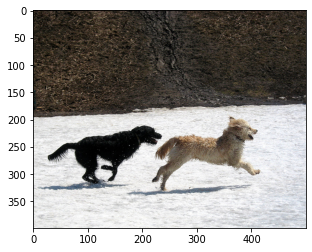

In [ ]:
#visualising one of the train images
img=cv2.imread("/content/drive/MyDrive/Flicker8k_Dataset"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [ ]:
#removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [ ]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [ ]:
#head of the image_tokens dataframe
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [ ]:
#head of the train_image_names dataframe
train_image_names.head()

img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

### Creating dictionaries to map image_id and their corresponding captions

In [ ]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:31<00:00, 192.75it/s]


In [ ]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 251.06it/s]


In [ ]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 290.26it/s]


### ResNet50 model for encoding images

In [ ]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="/content/drive/MyDrive/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

100%|██████████| 6000/6000 [09:39<00:00, 10.35it/s]


In [ ]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="/content/drive/MyDrive/Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


In [ ]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="/content/drive/MyDrive/Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]


In [ ]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [ ]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 6000/6000 [00:00<00:00, 294440.44it/s]


1991192
6328


In [ ]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [ ]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

### Transforming data into dictonary mapping of image_id to encoded captions

In [ ]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 6000/6000 [00:00<00:00, 61764.66it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[2576, 3982, 1425, 1403, 6201, 4604, 2516, 2519, 994, 1403, 4205, 2934, 4385, 461, 2586], [2576, 1257, 1403, 2543, 2471, 1403, 3876, 4385, 2586], [2576, 5904, 1403, 2543, 1671, 4085, 967, 2934, 4029, 1466, 461, 2586], [2576, 5904, 1403, 2232, 5617, 4205, 2934, 4385, 461, 2586], [2576, 5904, 1403, 4604, 3876, 2519, 2737, 6033, 5718, 4402, 3453, 461, 2586]]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 6000/6000 [00:00<00:00, 43269.39it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[2576 3982 1425 1403 6201 4604 2516 2519  994 1403 4205 2934 4385  461
  2586    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2576 1257 1403 2543 2471 1403 3876 4385 2586    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2576 5904 1403 2543 1671 4085  967 2934 4029 1466  461 2586    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2576 5904 1403 2232 5617 4205 2934 4385  461 2586    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2576 5904 1403 4604 3876 2519 2737 6033 5718 4402 3453  461 2586    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [ ]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [ ]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[2576]

## Data Generator for Modelling

In [ ]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

## Modelling

In [ ]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

In [ ]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


## Model

In [ ]:
#model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      1620224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [ ]:
len(train_encoded_captions)

6000

## Training

In [ ]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

<ipython-input-36-c4fdab068e51>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  0%|          | 5/6000 [00:02<56:59,  1.75it/s]

   1/1200 [..............................] - ETA: 1:02:32 - loss: 8.6249 - accuracy: 0.0000e+00

  0%|          | 10/6000 [00:03<28:18,  3.53it/s]

   2/1200 [..............................] - ETA: 6:09 - loss: 8.0288 - accuracy: 0.3154       

  0%|          | 15/6000 [00:03<18:10,  5.49it/s]

   3/1200 [..............................] - ETA: 5:56 - loss: 7.1155 - accuracy: 0.4472

  0%|          | 20/6000 [00:03<13:15,  7.52it/s]

   4/1200 [..............................] - ETA: 5:59 - loss: 6.3207 - accuracy: 0.4954

  0%|          | 25/6000 [00:04<10:39,  9.34it/s]

   5/1200 [..............................] - ETA: 6:04 - loss: 5.8270 - accuracy: 0.5245

  0%|          | 30/6000 [00:04<09:11, 10.82it/s]

   6/1200 [..............................] - ETA: 5:49 - loss: 5.7727 - accuracy: 0.5359

  1%|          | 35/6000 [00:04<07:44, 12.84it/s]

   7/1200 [..............................] - ETA: 5:47 - loss: 5.5020 - accuracy: 0.5547

  1%|          | 40/6000 [00:05<07:06, 13.98it/s]

   8/1200 [..............................] - ETA: 5:41 - loss: 5.2963 - accuracy: 0.5664

  1%|          | 45/6000 [00:05<06:28, 15.32it/s]

   9/1200 [..............................] - ETA: 5:42 - loss: 5.0215 - accuracy: 0.5819

  1%|          | 50/6000 [00:05<06:15, 15.83it/s]

  10/1200 [..............................] - ETA: 5:44 - loss: 4.8100 - accuracy: 0.5897

  1%|          | 55/6000 [00:05<06:11, 15.99it/s]

  11/1200 [..............................] - ETA: 5:44 - loss: 4.6245 - accuracy: 0.5991

  1%|          | 60/6000 [00:06<06:04, 16.30it/s]

  12/1200 [..............................] - ETA: 5:43 - loss: 4.4888 - accuracy: 0.6044

  1%|          | 65/6000 [00:06<05:55, 16.68it/s]

  13/1200 [..............................] - ETA: 5:39 - loss: 4.3516 - accuracy: 0.6100

  1%|          | 70/6000 [00:06<05:37, 17.55it/s]

  14/1200 [..............................] - ETA: 5:36 - loss: 4.2621 - accuracy: 0.6123

  1%|▏         | 75/6000 [00:06<05:29, 18.01it/s]

  15/1200 [..............................] - ETA: 5:35 - loss: 4.1786 - accuracy: 0.6148

  1%|▏         | 80/6000 [00:07<05:25, 18.21it/s]

  16/1200 [..............................] - ETA: 5:33 - loss: 4.0690 - accuracy: 0.6210

  1%|▏         | 85/6000 [00:07<05:22, 18.34it/s]

  17/1200 [..............................] - ETA: 5:38 - loss: 3.9767 - accuracy: 0.6254

  2%|▏         | 94/6000 [00:07<05:03, 19.44it/s]

  18/1200 [..............................] - ETA: 5:57 - loss: 3.9205 - accuracy: 0.6260

  2%|▏         | 97/6000 [00:08<07:32, 13.05it/s]

  19/1200 [..............................] - ETA: 6:15 - loss: 3.8746 - accuracy: 0.6267

  2%|▏         | 100/6000 [00:09<09:55,  9.90it/s]

  20/1200 [..............................] - ETA: 6:24 - loss: 3.8128 - accuracy: 0.6282

  2%|▏         | 109/6000 [00:09<07:35, 12.94it/s]

  21/1200 [..............................] - ETA: 6:37 - loss: 3.7593 - accuracy: 0.6304

  2%|▏         | 112/6000 [00:10<09:25, 10.41it/s]

  22/1200 [..............................] - ETA: 6:49 - loss: 3.7297 - accuracy: 0.6309

  2%|▏         | 119/6000 [00:10<08:33, 11.45it/s]

  23/1200 [..............................] - ETA: 7:01 - loss: 3.6744 - accuracy: 0.6330

  2%|▏         | 124/6000 [00:11<09:18, 10.52it/s]

  24/1200 [..............................] - ETA: 7:15 - loss: 3.6278 - accuracy: 0.6350

  2%|▏         | 129/6000 [00:11<09:53,  9.90it/s]

  25/1200 [..............................] - ETA: 7:26 - loss: 3.6067 - accuracy: 0.6347

  2%|▏         | 131/6000 [00:12<13:00,  7.52it/s]

  26/1200 [..............................] - ETA: 7:31 - loss: 3.5595 - accuracy: 0.6373

  2%|▏         | 138/6000 [00:12<09:46, 10.00it/s]

  27/1200 [..............................] - ETA: 7:43 - loss: 3.5244 - accuracy: 0.6377

  2%|▏         | 143/6000 [00:13<10:38,  9.17it/s]

  28/1200 [..............................] - ETA: 7:46 - loss: 3.4858 - accuracy: 0.6401

  2%|▏         | 145/6000 [00:14<11:57,  8.16it/s]

  29/1200 [..............................] - ETA: 7:42 - loss: 3.4586 - accuracy: 0.6415

  2%|▎         | 150/6000 [00:14<09:20, 10.45it/s]

  30/1200 [..............................] - ETA: 7:36 - loss: 3.4262 - accuracy: 0.6430

  3%|▎         | 155/6000 [00:14<07:39, 12.72it/s]

  31/1200 [..............................] - ETA: 7:32 - loss: 3.4001 - accuracy: 0.6443

  3%|▎         | 160/6000 [00:14<06:48, 14.28it/s]

  32/1200 [..............................] - ETA: 7:28 - loss: 3.3818 - accuracy: 0.6442

  3%|▎         | 165/6000 [00:15<06:32, 14.86it/s]

  33/1200 [..............................] - ETA: 7:25 - loss: 3.3597 - accuracy: 0.6445

  3%|▎         | 170/6000 [00:15<06:17, 15.44it/s]

  34/1200 [..............................] - ETA: 7:20 - loss: 3.3293 - accuracy: 0.6457

  3%|▎         | 175/6000 [00:15<05:50, 16.64it/s]

  35/1200 [..............................] - ETA: 7:16 - loss: 3.3109 - accuracy: 0.6459

  3%|▎         | 180/6000 [00:16<05:42, 16.98it/s]

  36/1200 [..............................] - ETA: 7:12 - loss: 3.2824 - accuracy: 0.6474

  3%|▎         | 185/6000 [00:16<05:28, 17.68it/s]

  37/1200 [..............................] - ETA: 7:09 - loss: 3.2594 - accuracy: 0.6482

  3%|▎         | 190/6000 [00:16<05:33, 17.41it/s]

  38/1200 [..............................] - ETA: 7:05 - loss: 3.2368 - accuracy: 0.6487

  3%|▎         | 195/6000 [00:16<05:23, 17.94it/s]

  39/1200 [..............................] - ETA: 7:02 - loss: 3.2049 - accuracy: 0.6513

  3%|▎         | 200/6000 [00:17<05:20, 18.12it/s]

  40/1200 [>.............................] - ETA: 7:00 - loss: 3.1849 - accuracy: 0.6523

  3%|▎         | 205/6000 [00:17<05:30, 17.55it/s]

  41/1200 [>.............................] - ETA: 6:57 - loss: 3.1605 - accuracy: 0.6534

  4%|▎         | 210/6000 [00:17<05:22, 17.95it/s]

  42/1200 [>.............................] - ETA: 6:55 - loss: 3.1358 - accuracy: 0.6545

  4%|▎         | 215/6000 [00:17<05:32, 17.41it/s]

  43/1200 [>.............................] - ETA: 6:53 - loss: 3.1150 - accuracy: 0.6560

  4%|▎         | 220/6000 [00:18<05:37, 17.12it/s]

  44/1200 [>.............................] - ETA: 6:51 - loss: 3.0945 - accuracy: 0.6575

  4%|▍         | 225/6000 [00:18<05:35, 17.23it/s]

  45/1200 [>.............................] - ETA: 6:49 - loss: 3.0812 - accuracy: 0.6578

  4%|▍         | 230/6000 [00:18<05:40, 16.96it/s]

  46/1200 [>.............................] - ETA: 6:47 - loss: 3.0732 - accuracy: 0.6578

  4%|▍         | 235/6000 [00:19<05:39, 16.97it/s]

  47/1200 [>.............................] - ETA: 6:44 - loss: 3.0597 - accuracy: 0.6576

  4%|▍         | 240/6000 [00:19<05:24, 17.74it/s]

  48/1200 [>.............................] - ETA: 6:42 - loss: 3.0432 - accuracy: 0.6584

  4%|▍         | 245/6000 [00:19<05:24, 17.74it/s]

  49/1200 [>.............................] - ETA: 6:41 - loss: 3.0344 - accuracy: 0.6584

  4%|▍         | 250/6000 [00:20<05:34, 17.17it/s]

  50/1200 [>.............................] - ETA: 6:39 - loss: 3.0263 - accuracy: 0.6584

  4%|▍         | 255/6000 [00:20<05:41, 16.84it/s]

  51/1200 [>.............................] - ETA: 6:38 - loss: 3.0191 - accuracy: 0.6585

  4%|▍         | 260/6000 [00:20<05:39, 16.90it/s]

  52/1200 [>.............................] - ETA: 6:36 - loss: 3.0093 - accuracy: 0.6588

  4%|▍         | 265/6000 [00:20<05:36, 17.02it/s]

  53/1200 [>.............................] - ETA: 6:35 - loss: 2.9956 - accuracy: 0.6600

  4%|▍         | 270/6000 [00:21<05:45, 16.60it/s]

  54/1200 [>.............................] - ETA: 6:34 - loss: 2.9872 - accuracy: 0.6600

  5%|▍         | 275/6000 [00:21<05:42, 16.72it/s]

  55/1200 [>.............................] - ETA: 6:32 - loss: 2.9746 - accuracy: 0.6605

  5%|▍         | 280/6000 [00:21<05:31, 17.25it/s]

  56/1200 [>.............................] - ETA: 6:31 - loss: 2.9656 - accuracy: 0.6603

  5%|▍         | 285/6000 [00:22<05:39, 16.85it/s]

  57/1200 [>.............................] - ETA: 6:29 - loss: 2.9526 - accuracy: 0.6612

  5%|▍         | 290/6000 [00:22<05:28, 17.36it/s]

  58/1200 [>.............................] - ETA: 6:27 - loss: 2.9428 - accuracy: 0.6615

  5%|▍         | 295/6000 [00:22<05:19, 17.86it/s]

  59/1200 [>.............................] - ETA: 6:25 - loss: 2.9371 - accuracy: 0.6618

  5%|▌         | 304/6000 [00:22<04:28, 21.20it/s]

  60/1200 [>.............................] - ETA: 6:25 - loss: 2.9295 - accuracy: 0.6619

  5%|▌         | 307/6000 [00:23<05:20, 17.78it/s]

  61/1200 [>.............................] - ETA: 6:24 - loss: 2.9255 - accuracy: 0.6618

  5%|▌         | 314/6000 [00:23<04:57, 19.14it/s]

  62/1200 [>.............................] - ETA: 6:23 - loss: 2.9145 - accuracy: 0.6624

  5%|▌         | 317/6000 [00:23<05:41, 16.63it/s]

  63/1200 [>.............................] - ETA: 6:24 - loss: 2.9058 - accuracy: 0.6629

  5%|▌         | 320/6000 [00:24<07:14, 13.07it/s]

  64/1200 [>.............................] - ETA: 6:25 - loss: 2.8999 - accuracy: 0.6634

  5%|▌         | 325/6000 [00:24<07:36, 12.43it/s]

  65/1200 [>.............................] - ETA: 6:29 - loss: 2.8936 - accuracy: 0.6634

  6%|▌         | 334/6000 [00:25<06:51, 13.75it/s]

  66/1200 [>.............................] - ETA: 6:32 - loss: 2.8896 - accuracy: 0.6631

  6%|▌         | 336/6000 [00:25<09:08, 10.33it/s]

  67/1200 [>.............................] - ETA: 6:35 - loss: 2.8825 - accuracy: 0.6631

  6%|▌         | 344/6000 [00:26<07:54, 11.92it/s]

  68/1200 [>.............................] - ETA: 6:37 - loss: 2.8752 - accuracy: 0.6633

  6%|▌         | 349/6000 [00:26<07:59, 11.79it/s]

  69/1200 [>.............................] - ETA: 6:40 - loss: 2.8732 - accuracy: 0.6627

  6%|▌         | 354/6000 [00:27<08:24, 11.20it/s]

  70/1200 [>.............................] - ETA: 6:41 - loss: 2.8629 - accuracy: 0.6633

  6%|▌         | 356/6000 [00:27<09:56,  9.47it/s]

  71/1200 [>.............................] - ETA: 6:45 - loss: 2.8540 - accuracy: 0.6637

  6%|▌         | 363/6000 [00:28<09:09, 10.25it/s]

  72/1200 [>.............................] - ETA: 6:48 - loss: 2.8491 - accuracy: 0.6637

  6%|▌         | 365/6000 [00:28<12:18,  7.63it/s]

  73/1200 [>.............................] - ETA: 6:51 - loss: 2.8437 - accuracy: 0.6638

  6%|▌         | 374/6000 [00:29<08:29, 11.04it/s]

  74/1200 [>.............................] - ETA: 6:54 - loss: 2.8381 - accuracy: 0.6640

  6%|▋         | 376/6000 [00:30<11:28,  8.17it/s]

  75/1200 [>.............................] - ETA: 6:53 - loss: 2.8366 - accuracy: 0.6639

  6%|▋         | 380/6000 [00:30<09:39,  9.70it/s]

  76/1200 [>.............................] - ETA: 6:51 - loss: 2.8295 - accuracy: 0.6641

  6%|▋         | 385/6000 [00:30<07:47, 12.01it/s]

  77/1200 [>.............................] - ETA: 6:49 - loss: 2.8244 - accuracy: 0.6642

  6%|▋         | 390/6000 [00:30<06:43, 13.89it/s]

  78/1200 [>.............................] - ETA: 6:47 - loss: 2.8185 - accuracy: 0.6645

  7%|▋         | 395/6000 [00:31<06:02, 15.44it/s]

  79/1200 [>.............................] - ETA: 6:46 - loss: 2.8099 - accuracy: 0.6653

  7%|▋         | 400/6000 [00:31<05:54, 15.80it/s]

  80/1200 [=>............................] - ETA: 6:44 - loss: 2.8076 - accuracy: 0.6650

  7%|▋         | 405/6000 [00:31<05:32, 16.82it/s]

  81/1200 [=>............................] - ETA: 6:43 - loss: 2.7997 - accuracy: 0.6656

  7%|▋         | 410/6000 [00:32<05:37, 16.57it/s]

  82/1200 [=>............................] - ETA: 6:41 - loss: 2.7939 - accuracy: 0.6659

  7%|▋         | 415/6000 [00:32<05:27, 17.03it/s]

  83/1200 [=>............................] - ETA: 6:40 - loss: 2.7920 - accuracy: 0.6659

  7%|▋         | 420/6000 [00:32<05:23, 17.26it/s]

  84/1200 [=>............................] - ETA: 6:39 - loss: 2.7911 - accuracy: 0.6654

  7%|▋         | 425/6000 [00:32<05:34, 16.65it/s]

  85/1200 [=>............................] - ETA: 6:37 - loss: 2.7856 - accuracy: 0.6657

  7%|▋         | 430/6000 [00:33<05:28, 16.95it/s]

  86/1200 [=>............................] - ETA: 6:36 - loss: 2.7837 - accuracy: 0.6655

  7%|▋         | 435/6000 [00:33<05:30, 16.86it/s]

  87/1200 [=>............................] - ETA: 6:35 - loss: 2.7813 - accuracy: 0.6658

  7%|▋         | 440/6000 [00:33<05:15, 17.60it/s]

  88/1200 [=>............................] - ETA: 6:33 - loss: 2.7756 - accuracy: 0.6663

  7%|▋         | 445/6000 [00:34<05:05, 18.21it/s]

  89/1200 [=>............................] - ETA: 6:32 - loss: 2.7713 - accuracy: 0.6664

  8%|▊         | 454/6000 [00:34<04:24, 20.97it/s]

  90/1200 [=>............................] - ETA: 6:31 - loss: 2.7672 - accuracy: 0.6666

  8%|▊         | 457/6000 [00:34<05:01, 18.40it/s]

  91/1200 [=>............................] - ETA: 6:30 - loss: 2.7657 - accuracy: 0.6667

  8%|▊         | 460/6000 [00:34<05:49, 15.84it/s]

  92/1200 [=>............................] - ETA: 6:28 - loss: 2.7604 - accuracy: 0.6670

  8%|▊         | 465/6000 [00:35<05:27, 16.90it/s]

  93/1200 [=>............................] - ETA: 6:28 - loss: 2.7565 - accuracy: 0.6671

  8%|▊         | 470/6000 [00:35<05:30, 16.76it/s]

  94/1200 [=>............................] - ETA: 6:26 - loss: 2.7557 - accuracy: 0.6668

  8%|▊         | 475/6000 [00:35<05:12, 17.66it/s]

  95/1200 [=>............................] - ETA: 6:24 - loss: 2.7536 - accuracy: 0.6670

  8%|▊         | 480/6000 [00:36<05:01, 18.29it/s]

  96/1200 [=>............................] - ETA: 6:23 - loss: 2.7508 - accuracy: 0.6670

  8%|▊         | 485/6000 [00:36<05:06, 17.99it/s]

  97/1200 [=>............................] - ETA: 6:22 - loss: 2.7470 - accuracy: 0.6673

  8%|▊         | 490/6000 [00:36<05:01, 18.25it/s]

  98/1200 [=>............................] - ETA: 6:21 - loss: 2.7458 - accuracy: 0.6672

  8%|▊         | 495/6000 [00:36<05:05, 18.02it/s]

  99/1200 [=>............................] - ETA: 6:20 - loss: 2.7475 - accuracy: 0.6671

  8%|▊         | 500/6000 [00:37<04:58, 18.45it/s]

 100/1200 [=>............................] - ETA: 6:19 - loss: 2.7415 - accuracy: 0.6673

  8%|▊         | 505/6000 [00:37<05:08, 17.79it/s]

 101/1200 [=>............................] - ETA: 6:18 - loss: 2.7415 - accuracy: 0.6671

  8%|▊         | 510/6000 [00:37<05:06, 17.91it/s]

 102/1200 [=>............................] - ETA: 6:17 - loss: 2.7376 - accuracy: 0.6671

  9%|▊         | 515/6000 [00:38<05:18, 17.21it/s]

 103/1200 [=>............................] - ETA: 6:16 - loss: 2.7380 - accuracy: 0.6667

  9%|▊         | 520/6000 [00:38<05:15, 17.35it/s]

 104/1200 [=>............................] - ETA: 6:15 - loss: 2.7369 - accuracy: 0.6670

  9%|▉         | 525/6000 [00:38<05:23, 16.95it/s]

 105/1200 [=>............................] - ETA: 6:15 - loss: 2.7319 - accuracy: 0.6674

  9%|▉         | 530/6000 [00:38<05:29, 16.62it/s]

 106/1200 [=>............................] - ETA: 6:14 - loss: 2.7300 - accuracy: 0.6675

  9%|▉         | 535/6000 [00:39<05:22, 16.97it/s]

 107/1200 [=>............................] - ETA: 6:13 - loss: 2.7244 - accuracy: 0.6678

  9%|▉         | 540/6000 [00:39<05:12, 17.48it/s]

 108/1200 [=>............................] - ETA: 6:12 - loss: 2.7221 - accuracy: 0.6679

  9%|▉         | 545/6000 [00:39<05:20, 17.00it/s]

 109/1200 [=>............................] - ETA: 6:11 - loss: 2.7194 - accuracy: 0.6681

  9%|▉         | 550/6000 [00:40<05:13, 17.39it/s]

 110/1200 [=>............................] - ETA: 6:11 - loss: 2.7174 - accuracy: 0.6682

  9%|▉         | 559/6000 [00:40<05:01, 18.04it/s]

 111/1200 [=>............................] - ETA: 6:13 - loss: 2.7139 - accuracy: 0.6684

  9%|▉         | 562/6000 [00:41<07:16, 12.46it/s]

 112/1200 [=>............................] - ETA: 6:15 - loss: 2.7127 - accuracy: 0.6682

  9%|▉         | 565/6000 [00:41<08:57, 10.10it/s]

 113/1200 [=>............................] - ETA: 6:15 - loss: 2.7114 - accuracy: 0.6679

 10%|▉         | 573/6000 [00:42<06:47, 13.30it/s]

 114/1200 [=>............................] - ETA: 6:15 - loss: 2.7078 - accuracy: 0.6681

 10%|▉         | 579/6000 [00:42<06:21, 14.23it/s]

 115/1200 [=>............................] - ETA: 6:16 - loss: 2.7033 - accuracy: 0.6685

 10%|▉         | 582/6000 [00:42<08:34, 10.53it/s]

 116/1200 [=>............................] - ETA: 6:18 - loss: 2.7009 - accuracy: 0.6685

 10%|▉         | 588/6000 [00:43<08:15, 10.91it/s]

 117/1200 [=>............................] - ETA: 6:19 - loss: 2.6985 - accuracy: 0.6683

 10%|▉         | 590/6000 [00:43<10:11,  8.84it/s]

 118/1200 [=>............................] - ETA: 6:21 - loss: 2.6969 - accuracy: 0.6684

 10%|▉         | 599/6000 [00:44<07:43, 11.66it/s]

 119/1200 [=>............................] - ETA: 6:22 - loss: 2.6940 - accuracy: 0.6685

 10%|█         | 601/6000 [00:45<10:23,  8.65it/s]

 120/1200 [==>...........................] - ETA: 6:25 - loss: 2.6913 - accuracy: 0.6685

 10%|█         | 605/6000 [00:45<11:37,  7.74it/s]

 121/1200 [==>...........................] - ETA: 6:25 - loss: 2.6886 - accuracy: 0.6686

 10%|█         | 614/6000 [00:46<08:02, 11.16it/s]

 122/1200 [==>...........................] - ETA: 6:26 - loss: 2.6839 - accuracy: 0.6691

 10%|█         | 616/6000 [00:46<09:35,  9.35it/s]

 123/1200 [==>...........................] - ETA: 6:25 - loss: 2.6827 - accuracy: 0.6690

 10%|█         | 620/6000 [00:46<08:18, 10.78it/s]

 124/1200 [==>...........................] - ETA: 6:24 - loss: 2.6773 - accuracy: 0.6695

 10%|█         | 625/6000 [00:47<06:54, 12.97it/s]

 125/1200 [==>...........................] - ETA: 6:23 - loss: 2.6769 - accuracy: 0.6693

 10%|█         | 630/6000 [00:47<06:13, 14.39it/s]

 126/1200 [==>...........................] - ETA: 6:22 - loss: 2.6745 - accuracy: 0.6693

 11%|█         | 635/6000 [00:47<05:45, 15.52it/s]

 127/1200 [==>...........................] - ETA: 6:21 - loss: 2.6719 - accuracy: 0.6692

 11%|█         | 640/6000 [00:48<05:41, 15.70it/s]

 128/1200 [==>...........................] - ETA: 6:20 - loss: 2.6687 - accuracy: 0.6694

 11%|█         | 645/6000 [00:48<05:26, 16.41it/s]

 129/1200 [==>...........................] - ETA: 6:19 - loss: 2.6672 - accuracy: 0.6693

 11%|█         | 650/6000 [00:48<05:20, 16.72it/s]

 130/1200 [==>...........................] - ETA: 6:18 - loss: 2.6643 - accuracy: 0.6695

 11%|█         | 655/6000 [00:48<05:06, 17.41it/s]

 131/1200 [==>...........................] - ETA: 6:17 - loss: 2.6661 - accuracy: 0.6689

 11%|█         | 660/6000 [00:49<05:00, 17.79it/s]

 132/1200 [==>...........................] - ETA: 6:16 - loss: 2.6630 - accuracy: 0.6689

 11%|█         | 665/6000 [00:49<04:56, 18.02it/s]

 133/1200 [==>...........................] - ETA: 6:15 - loss: 2.6610 - accuracy: 0.6689

 11%|█         | 670/6000 [00:49<04:54, 18.10it/s]

 134/1200 [==>...........................] - ETA: 6:14 - loss: 2.6594 - accuracy: 0.6691

 11%|█▏        | 675/6000 [00:49<04:46, 18.56it/s]

 135/1200 [==>...........................] - ETA: 6:13 - loss: 2.6587 - accuracy: 0.6689

 11%|█▏        | 680/6000 [00:50<04:49, 18.38it/s]

 136/1200 [==>...........................] - ETA: 6:12 - loss: 2.6577 - accuracy: 0.6689

 11%|█▏        | 685/6000 [00:50<05:00, 17.66it/s]

 137/1200 [==>...........................] - ETA: 6:11 - loss: 2.6555 - accuracy: 0.6690

 12%|█▏        | 690/6000 [00:50<04:53, 18.10it/s]

 138/1200 [==>...........................] - ETA: 6:10 - loss: 2.6550 - accuracy: 0.6689

 12%|█▏        | 695/6000 [00:51<04:44, 18.65it/s]

 139/1200 [==>...........................] - ETA: 6:09 - loss: 2.6527 - accuracy: 0.6691

 12%|█▏        | 700/6000 [00:51<04:40, 18.92it/s]

 140/1200 [==>...........................] - ETA: 6:08 - loss: 2.6482 - accuracy: 0.6693

 12%|█▏        | 705/6000 [00:51<04:43, 18.67it/s]

 141/1200 [==>...........................] - ETA: 6:07 - loss: 2.6457 - accuracy: 0.6695

 12%|█▏        | 710/6000 [00:51<05:04, 17.37it/s]

 142/1200 [==>...........................] - ETA: 6:07 - loss: 2.6429 - accuracy: 0.6697

 12%|█▏        | 715/6000 [00:52<05:12, 16.92it/s]

 143/1200 [==>...........................] - ETA: 6:06 - loss: 2.6421 - accuracy: 0.6697

 12%|█▏        | 720/6000 [00:52<04:59, 17.63it/s]

 144/1200 [==>...........................] - ETA: 6:05 - loss: 2.6417 - accuracy: 0.6695

 12%|█▏        | 725/6000 [00:52<04:57, 17.75it/s]

 145/1200 [==>...........................] - ETA: 6:04 - loss: 2.6424 - accuracy: 0.6692

 12%|█▏        | 733/6000 [00:53<04:40, 18.81it/s]

 146/1200 [==>...........................] - ETA: 6:03 - loss: 2.6402 - accuracy: 0.6693

 12%|█▏        | 736/6000 [00:53<04:49, 18.18it/s]

 147/1200 [==>...........................] - ETA: 6:03 - loss: 2.6392 - accuracy: 0.6693

 12%|█▏        | 740/6000 [00:53<05:10, 16.96it/s]

 148/1200 [==>...........................] - ETA: 6:02 - loss: 2.6362 - accuracy: 0.6695

 12%|█▏        | 745/6000 [00:53<05:13, 16.77it/s]

 149/1200 [==>...........................] - ETA: 6:01 - loss: 2.6351 - accuracy: 0.6695

 12%|█▎        | 750/6000 [00:54<05:15, 16.66it/s]

 150/1200 [==>...........................] - ETA: 6:01 - loss: 2.6330 - accuracy: 0.6695

 13%|█▎        | 755/6000 [00:54<05:17, 16.54it/s]

 151/1200 [==>...........................] - ETA: 6:00 - loss: 2.6304 - accuracy: 0.6695

 13%|█▎        | 760/6000 [00:54<05:18, 16.47it/s]

 152/1200 [==>...........................] - ETA: 5:59 - loss: 2.6272 - accuracy: 0.6695

 13%|█▎        | 765/6000 [00:55<05:02, 17.30it/s]

 153/1200 [==>...........................] - ETA: 5:59 - loss: 2.6255 - accuracy: 0.6693

 13%|█▎        | 770/6000 [00:55<05:08, 16.95it/s]

 154/1200 [==>...........................] - ETA: 5:58 - loss: 2.6211 - accuracy: 0.6694

 13%|█▎        | 775/6000 [00:55<05:02, 17.30it/s]

 155/1200 [==>...........................] - ETA: 5:57 - loss: 2.6169 - accuracy: 0.6695

 13%|█▎        | 780/6000 [00:55<04:54, 17.72it/s]

 156/1200 [==>...........................] - ETA: 5:56 - loss: 2.6117 - accuracy: 0.6698

 13%|█▎        | 785/6000 [00:56<04:50, 17.98it/s]

 157/1200 [==>...........................] - ETA: 5:56 - loss: 2.6083 - accuracy: 0.6698

 13%|█▎        | 790/6000 [00:56<05:02, 17.23it/s]

 158/1200 [==>...........................] - ETA: 5:55 - loss: 2.6065 - accuracy: 0.6696

 13%|█▎        | 795/6000 [00:56<05:11, 16.69it/s]

 159/1200 [==>...........................] - ETA: 5:55 - loss: 2.6038 - accuracy: 0.6695

 13%|█▎        | 804/6000 [00:57<04:54, 17.66it/s]

 160/1200 [===>..........................] - ETA: 5:56 - loss: 2.5994 - accuracy: 0.6696

 13%|█▎        | 807/6000 [00:57<06:59, 12.37it/s]

 161/1200 [===>..........................] - ETA: 5:57 - loss: 2.5953 - accuracy: 0.6697

 14%|█▎        | 814/6000 [00:58<06:56, 12.46it/s]

 162/1200 [===>..........................] - ETA: 5:59 - loss: 2.5934 - accuracy: 0.6694

 14%|█▎        | 816/6000 [00:58<09:23,  9.20it/s]

 163/1200 [===>..........................] - ETA: 6:00 - loss: 2.5890 - accuracy: 0.6693

 14%|█▎        | 824/6000 [00:59<07:37, 11.32it/s]

 164/1200 [===>..........................] - ETA: 6:01 - loss: 2.5853 - accuracy: 0.6692

 14%|█▍        | 829/6000 [01:00<08:12, 10.51it/s]

 165/1200 [===>..........................] - ETA: 6:02 - loss: 2.5809 - accuracy: 0.6694

 14%|█▍        | 834/6000 [01:00<08:13, 10.48it/s]

 166/1200 [===>..........................] - ETA: 6:03 - loss: 2.5772 - accuracy: 0.6694

 14%|█▍        | 839/6000 [01:01<08:43,  9.85it/s]

 167/1200 [===>..........................] - ETA: 6:04 - loss: 2.5740 - accuracy: 0.6692

 14%|█▍        | 841/6000 [01:01<11:47,  7.30it/s]

 168/1200 [===>..........................] - ETA: 6:05 - loss: 2.5697 - accuracy: 0.6692

 14%|█▍        | 845/6000 [01:02<11:40,  7.36it/s]

 169/1200 [===>..........................] - ETA: 6:05 - loss: 2.5639 - accuracy: 0.6694

 14%|█▍        | 854/6000 [01:03<07:20, 11.69it/s]

 170/1200 [===>..........................] - ETA: 6:05 - loss: 2.5600 - accuracy: 0.6694

 14%|█▍        | 856/6000 [01:03<08:00, 10.70it/s]

 171/1200 [===>..........................] - ETA: 6:04 - loss: 2.5561 - accuracy: 0.6695

 14%|█▍        | 860/6000 [01:03<07:03, 12.12it/s]

 172/1200 [===>..........................] - ETA: 6:03 - loss: 2.5506 - accuracy: 0.6698

 14%|█▍        | 865/6000 [01:03<06:18, 13.56it/s]

 173/1200 [===>..........................] - ETA: 6:02 - loss: 2.5469 - accuracy: 0.6698

 14%|█▍        | 870/6000 [01:04<05:35, 15.28it/s]

 174/1200 [===>..........................] - ETA: 6:02 - loss: 2.5422 - accuracy: 0.6699

 15%|█▍        | 879/6000 [01:04<04:32, 18.80it/s]

 175/1200 [===>..........................] - ETA: 6:01 - loss: 2.5363 - accuracy: 0.6703

 15%|█▍        | 882/6000 [01:04<05:11, 16.44it/s]

 176/1200 [===>..........................] - ETA: 6:00 - loss: 2.5308 - accuracy: 0.6704

 15%|█▍        | 885/6000 [01:04<05:33, 15.34it/s]

 177/1200 [===>..........................] - ETA: 6:00 - loss: 2.5271 - accuracy: 0.6705

 15%|█▍        | 894/6000 [01:05<04:23, 19.37it/s]

 178/1200 [===>..........................] - ETA: 5:59 - loss: 2.5223 - accuracy: 0.6707

 15%|█▍        | 897/6000 [01:05<04:54, 17.32it/s]

 179/1200 [===>..........................] - ETA: 5:58 - loss: 2.5180 - accuracy: 0.6708

 15%|█▌        | 900/6000 [01:05<05:30, 15.41it/s]

 180/1200 [===>..........................] - ETA: 5:58 - loss: 2.5114 - accuracy: 0.6712

 15%|█▌        | 905/6000 [01:06<05:05, 16.70it/s]

 181/1200 [===>..........................] - ETA: 5:57 - loss: 2.5066 - accuracy: 0.6714

 15%|█▌        | 910/6000 [01:06<05:03, 16.76it/s]

 182/1200 [===>..........................] - ETA: 5:56 - loss: 2.5020 - accuracy: 0.6716

 15%|█▌        | 915/6000 [01:06<05:07, 16.52it/s]

 183/1200 [===>..........................] - ETA: 5:55 - loss: 2.4985 - accuracy: 0.6715

 15%|█▌        | 920/6000 [01:06<04:53, 17.31it/s]

 184/1200 [===>..........................] - ETA: 5:55 - loss: 2.4935 - accuracy: 0.6718

 15%|█▌        | 929/6000 [01:07<04:12, 20.09it/s]

 185/1200 [===>..........................] - ETA: 5:54 - loss: 2.4902 - accuracy: 0.6719

 16%|█▌        | 932/6000 [01:07<04:53, 17.27it/s]

 186/1200 [===>..........................] - ETA: 5:54 - loss: 2.4866 - accuracy: 0.6720

 16%|█▌        | 935/6000 [01:07<05:24, 15.60it/s]

 187/1200 [===>..........................] - ETA: 5:53 - loss: 2.4827 - accuracy: 0.6721

 16%|█▌        | 940/6000 [01:08<05:25, 15.53it/s]

 188/1200 [===>..........................] - ETA: 5:52 - loss: 2.4777 - accuracy: 0.6723

 16%|█▌        | 945/6000 [01:08<05:05, 16.57it/s]

 189/1200 [===>..........................] - ETA: 5:52 - loss: 2.4739 - accuracy: 0.6725

 16%|█▌        | 950/6000 [01:08<05:03, 16.63it/s]

 190/1200 [===>..........................] - ETA: 5:51 - loss: 2.4699 - accuracy: 0.6726

 16%|█▌        | 955/6000 [01:09<04:54, 17.16it/s]

 191/1200 [===>..........................] - ETA: 5:50 - loss: 2.4660 - accuracy: 0.6728

 16%|█▌        | 960/6000 [01:09<04:59, 16.82it/s]

 192/1200 [===>..........................] - ETA: 5:50 - loss: 2.4626 - accuracy: 0.6728

 16%|█▌        | 965/6000 [01:09<04:47, 17.54it/s]

 193/1200 [===>..........................] - ETA: 5:49 - loss: 2.4575 - accuracy: 0.6733

 16%|█▌        | 970/6000 [01:09<04:45, 17.65it/s]

 194/1200 [===>..........................] - ETA: 5:48 - loss: 2.4551 - accuracy: 0.6732

 16%|█▋        | 975/6000 [01:10<04:49, 17.35it/s]

 195/1200 [===>..........................] - ETA: 5:48 - loss: 2.4506 - accuracy: 0.6736

 16%|█▋        | 980/6000 [01:10<04:46, 17.54it/s]

 198/1200 [===>..........................] - ETA: 5:46 - loss: 2.4412 - accuracy: 0.6740

 17%|█▋        | 995/6000 [01:11<04:48, 17.34it/s]

 199/1200 [===>..........................] - ETA: 5:45 - loss: 2.4375 - accuracy: 0.6742

 17%|█▋        | 1000/6000 [01:11<04:49, 17.25it/s]

 200/1200 [====>.........................] - ETA: 5:45 - loss: 2.4334 - accuracy: 0.6744

 17%|█▋        | 1005/6000 [01:11<05:05, 16.36it/s]

 201/1200 [====>.........................] - ETA: 5:44 - loss: 2.4304 - accuracy: 0.6746

 17%|█▋        | 1010/6000 [01:12<05:01, 16.53it/s]

 202/1200 [====>.........................] - ETA: 5:43 - loss: 2.4267 - accuracy: 0.6747

 17%|█▋        | 1015/6000 [01:12<04:49, 17.20it/s]

 203/1200 [====>.........................] - ETA: 5:43 - loss: 2.4228 - accuracy: 0.6750

 17%|█▋        | 1020/6000 [01:12<04:56, 16.79it/s]

 204/1200 [====>.........................] - ETA: 5:42 - loss: 2.4192 - accuracy: 0.6752

 17%|█▋        | 1025/6000 [01:13<04:53, 16.93it/s]

 205/1200 [====>.........................] - ETA: 5:42 - loss: 2.4146 - accuracy: 0.6756

 17%|█▋        | 1030/6000 [01:13<05:35, 14.80it/s]

 206/1200 [====>.........................] - ETA: 5:42 - loss: 2.4099 - accuracy: 0.6759

 17%|█▋        | 1039/6000 [01:14<05:11, 15.92it/s]

 207/1200 [====>.........................] - ETA: 5:43 - loss: 2.4059 - accuracy: 0.6762

 17%|█▋        | 1041/6000 [01:14<07:13, 11.43it/s]

 208/1200 [====>.........................] - ETA: 5:44 - loss: 2.4028 - accuracy: 0.6763

 17%|█▋        | 1049/6000 [01:15<06:32, 12.61it/s]

 209/1200 [====>.........................] - ETA: 5:44 - loss: 2.3987 - accuracy: 0.6766

 18%|█▊        | 1052/6000 [01:15<08:17,  9.94it/s]

 210/1200 [====>.........................] - ETA: 5:45 - loss: 2.3940 - accuracy: 0.6769

 18%|█▊        | 1055/6000 [01:16<09:41,  8.51it/s]

 211/1200 [====>.........................] - ETA: 5:46 - loss: 2.3901 - accuracy: 0.6771

 18%|█▊        | 1064/6000 [01:16<07:16, 11.31it/s]

 212/1200 [====>.........................] - ETA: 5:46 - loss: 2.3875 - accuracy: 0.6772

 18%|█▊        | 1066/6000 [01:17<09:26,  8.71it/s]

 213/1200 [====>.........................] - ETA: 5:47 - loss: 2.3844 - accuracy: 0.6773

 18%|█▊        | 1073/6000 [01:17<07:42, 10.66it/s]

 214/1200 [====>.........................] - ETA: 5:48 - loss: 2.3801 - accuracy: 0.6776

 18%|█▊        | 1075/6000 [01:18<10:34,  7.76it/s]

 215/1200 [====>.........................] - ETA: 5:48 - loss: 2.3762 - accuracy: 0.6778

 18%|█▊        | 1083/6000 [01:19<07:50, 10.44it/s]

 216/1200 [====>.........................] - ETA: 5:48 - loss: 2.3729 - accuracy: 0.6778

 18%|█▊        | 1085/6000 [01:19<08:54,  9.19it/s]

 217/1200 [====>.........................] - ETA: 5:47 - loss: 2.3685 - accuracy: 0.6782

 18%|█▊        | 1090/6000 [01:19<07:08, 11.45it/s]

 218/1200 [====>.........................] - ETA: 5:47 - loss: 2.3648 - accuracy: 0.6784

 18%|█▊        | 1095/6000 [01:19<06:05, 13.40it/s]

 219/1200 [====>.........................] - ETA: 5:46 - loss: 2.3601 - accuracy: 0.6789

 18%|█▊        | 1100/6000 [01:20<05:45, 14.20it/s]

 220/1200 [====>.........................] - ETA: 5:45 - loss: 2.3551 - accuracy: 0.6793

 18%|█▊        | 1105/6000 [01:20<05:11, 15.70it/s]

 221/1200 [====>.........................] - ETA: 5:44 - loss: 2.3515 - accuracy: 0.6796

 18%|█▊        | 1110/6000 [01:20<04:50, 16.81it/s]

 222/1200 [====>.........................] - ETA: 5:44 - loss: 2.3481 - accuracy: 0.6798

 19%|█▊        | 1115/6000 [01:21<04:48, 16.92it/s]

 223/1200 [====>.........................] - ETA: 5:43 - loss: 2.3447 - accuracy: 0.6801

 19%|█▊        | 1120/6000 [01:21<04:40, 17.38it/s]

 224/1200 [====>.........................] - ETA: 5:42 - loss: 2.3419 - accuracy: 0.6802

 19%|█▉        | 1129/6000 [01:21<03:58, 20.42it/s]

 225/1200 [====>.........................] - ETA: 5:42 - loss: 2.3393 - accuracy: 0.6803

 19%|█▉        | 1132/6000 [01:21<04:38, 17.45it/s]

 226/1200 [====>.........................] - ETA: 5:41 - loss: 2.3357 - accuracy: 0.6806

 19%|█▉        | 1135/6000 [01:22<05:17, 15.32it/s]

 227/1200 [====>.........................] - ETA: 5:41 - loss: 2.3323 - accuracy: 0.6808

 19%|█▉        | 1140/6000 [01:22<05:12, 15.55it/s]

 228/1200 [====>.........................] - ETA: 5:40 - loss: 2.3291 - accuracy: 0.6810

 19%|█▉        | 1145/6000 [01:22<04:53, 16.55it/s]

 229/1200 [====>.........................] - ETA: 5:39 - loss: 2.3259 - accuracy: 0.6812

 19%|█▉        | 1154/6000 [01:23<03:58, 20.36it/s]

 230/1200 [====>.........................] - ETA: 5:39 - loss: 2.3228 - accuracy: 0.6814

 19%|█▉        | 1157/6000 [01:23<04:29, 17.96it/s]

 231/1200 [====>.........................] - ETA: 5:38 - loss: 2.3201 - accuracy: 0.6815

 19%|█▉        | 1160/6000 [01:23<05:03, 15.97it/s]

 232/1200 [====>.........................] - ETA: 5:38 - loss: 2.3172 - accuracy: 0.6817

 19%|█▉        | 1165/6000 [01:23<04:57, 16.23it/s]

 233/1200 [====>.........................] - ETA: 5:37 - loss: 2.3146 - accuracy: 0.6818

 20%|█▉        | 1170/6000 [01:24<04:49, 16.68it/s]

 234/1200 [====>.........................] - ETA: 5:36 - loss: 2.3109 - accuracy: 0.6821

 20%|█▉        | 1175/6000 [01:24<04:34, 17.55it/s]

 235/1200 [====>.........................] - ETA: 5:36 - loss: 2.3078 - accuracy: 0.6824

 20%|█▉        | 1180/6000 [01:24<04:43, 16.99it/s]

 236/1200 [====>.........................] - ETA: 5:35 - loss: 2.3050 - accuracy: 0.6826

 20%|█▉        | 1185/6000 [01:25<04:46, 16.81it/s]

 237/1200 [====>.........................] - ETA: 5:35 - loss: 2.3026 - accuracy: 0.6827

 20%|█▉        | 1190/6000 [01:25<04:48, 16.68it/s]

 238/1200 [====>.........................] - ETA: 5:34 - loss: 2.2993 - accuracy: 0.6828

 20%|█▉        | 1195/6000 [01:25<04:46, 16.77it/s]

 239/1200 [====>.........................] - ETA: 5:34 - loss: 2.2964 - accuracy: 0.6830

 20%|██        | 1200/6000 [01:26<05:02, 15.87it/s]

 240/1200 [=====>........................] - ETA: 5:33 - loss: 2.2935 - accuracy: 0.6832

 20%|██        | 1205/6000 [01:26<04:50, 16.53it/s]

 241/1200 [=====>........................] - ETA: 5:33 - loss: 2.2913 - accuracy: 0.6833

 20%|██        | 1210/6000 [01:26<04:37, 17.26it/s]

 242/1200 [=====>........................] - ETA: 5:32 - loss: 2.2886 - accuracy: 0.6835

 20%|██        | 1215/6000 [01:26<04:49, 16.50it/s]

 243/1200 [=====>........................] - ETA: 5:31 - loss: 2.2851 - accuracy: 0.6837

 20%|██        | 1220/6000 [01:27<04:38, 17.17it/s]

 244/1200 [=====>........................] - ETA: 5:31 - loss: 2.2837 - accuracy: 0.6837

 20%|██        | 1225/6000 [01:27<04:45, 16.73it/s]

 245/1200 [=====>........................] - ETA: 5:31 - loss: 2.2799 - accuracy: 0.6840

 20%|██        | 1230/6000 [01:27<04:56, 16.07it/s]

 246/1200 [=====>........................] - ETA: 5:30 - loss: 2.2770 - accuracy: 0.6842

 21%|██        | 1235/6000 [01:28<04:47, 16.60it/s]

 247/1200 [=====>........................] - ETA: 5:30 - loss: 2.2743 - accuracy: 0.6844

 21%|██        | 1244/6000 [01:28<04:06, 19.32it/s]

 248/1200 [=====>........................] - ETA: 5:29 - loss: 2.2719 - accuracy: 0.6845

 21%|██        | 1247/6000 [01:28<04:40, 16.94it/s]

 249/1200 [=====>........................] - ETA: 5:29 - loss: 2.2700 - accuracy: 0.6845

 21%|██        | 1250/6000 [01:29<05:21, 14.77it/s]

 250/1200 [=====>........................] - ETA: 5:28 - loss: 2.2666 - accuracy: 0.6848

 21%|██        | 1255/6000 [01:29<05:12, 15.20it/s]

 251/1200 [=====>........................] - ETA: 5:28 - loss: 2.2635 - accuracy: 0.6850

 21%|██        | 1260/6000 [01:29<05:51, 13.50it/s]

 252/1200 [=====>........................] - ETA: 5:29 - loss: 2.2606 - accuracy: 0.6852

 21%|██        | 1269/6000 [01:30<05:33, 14.19it/s]

 253/1200 [=====>........................] - ETA: 5:29 - loss: 2.2579 - accuracy: 0.6853

 21%|██        | 1272/6000 [01:31<07:06, 11.08it/s]

 254/1200 [=====>........................] - ETA: 5:30 - loss: 2.2553 - accuracy: 0.6856

 21%|██▏       | 1279/6000 [01:31<06:48, 11.55it/s]

 255/1200 [=====>........................] - ETA: 5:30 - loss: 2.2530 - accuracy: 0.6858

 21%|██▏       | 1284/6000 [01:32<07:02, 11.16it/s]

 256/1200 [=====>........................] - ETA: 5:30 - loss: 2.2507 - accuracy: 0.6859

 21%|██▏       | 1289/6000 [01:32<07:21, 10.67it/s]

 257/1200 [=====>........................] - ETA: 5:31 - loss: 2.2482 - accuracy: 0.6860

 22%|██▏       | 1291/6000 [01:33<10:09,  7.73it/s]

 258/1200 [=====>........................] - ETA: 5:32 - loss: 2.2455 - accuracy: 0.6862

 22%|██▏       | 1299/6000 [01:33<07:38, 10.25it/s]

 259/1200 [=====>........................] - ETA: 5:32 - loss: 2.2423 - accuracy: 0.6864

 22%|██▏       | 1301/6000 [01:34<08:55,  8.77it/s]

 260/1200 [=====>........................] - ETA: 5:32 - loss: 2.2412 - accuracy: 0.6864

 22%|██▏       | 1305/6000 [01:34<09:32,  8.20it/s]

 261/1200 [=====>........................] - ETA: 5:32 - loss: 2.2385 - accuracy: 0.6866

 22%|██▏       | 1314/6000 [01:35<06:59, 11.17it/s]

 262/1200 [=====>........................] - ETA: 5:32 - loss: 2.2364 - accuracy: 0.6867

 22%|██▏       | 1316/6000 [01:35<08:18,  9.39it/s]

 263/1200 [=====>........................] - ETA: 5:32 - loss: 2.2325 - accuracy: 0.6871

 22%|██▏       | 1324/6000 [01:36<05:25, 14.35it/s]

 264/1200 [=====>........................] - ETA: 5:31 - loss: 2.2310 - accuracy: 0.6871

 22%|██▏       | 1327/6000 [01:36<05:19, 14.63it/s]

 265/1200 [=====>........................] - ETA: 5:31 - loss: 2.2279 - accuracy: 0.6874

 22%|██▏       | 1334/6000 [01:36<04:38, 16.73it/s]

 266/1200 [=====>........................] - ETA: 5:30 - loss: 2.2266 - accuracy: 0.6874

 22%|██▏       | 1337/6000 [01:37<05:05, 15.28it/s]

 267/1200 [=====>........................] - ETA: 5:30 - loss: 2.2232 - accuracy: 0.6877

 22%|██▏       | 1340/6000 [01:37<05:38, 13.77it/s]

 268/1200 [=====>........................] - ETA: 5:29 - loss: 2.2208 - accuracy: 0.6878

 22%|██▏       | 1345/6000 [01:37<05:20, 14.52it/s]

 269/1200 [=====>........................] - ETA: 5:29 - loss: 2.2181 - accuracy: 0.6880

 22%|██▎       | 1350/6000 [01:37<05:00, 15.47it/s]

 270/1200 [=====>........................] - ETA: 5:28 - loss: 2.2148 - accuracy: 0.6883

 23%|██▎       | 1355/6000 [01:38<04:43, 16.40it/s]

 271/1200 [=====>........................] - ETA: 5:27 - loss: 2.2121 - accuracy: 0.6885

 23%|██▎       | 1360/6000 [01:38<04:30, 17.13it/s]

 272/1200 [=====>........................] - ETA: 5:27 - loss: 2.2093 - accuracy: 0.6888

 23%|██▎       | 1365/6000 [01:38<04:43, 16.34it/s]

 273/1200 [=====>........................] - ETA: 5:26 - loss: 2.2068 - accuracy: 0.6890

 23%|██▎       | 1370/6000 [01:39<04:31, 17.07it/s]

 274/1200 [=====>........................] - ETA: 5:26 - loss: 2.2045 - accuracy: 0.6891

 23%|██▎       | 1375/6000 [01:39<04:20, 17.77it/s]

 275/1200 [=====>........................] - ETA: 5:25 - loss: 2.2022 - accuracy: 0.6892

 23%|██▎       | 1380/6000 [01:39<04:12, 18.33it/s]

 276/1200 [=====>........................] - ETA: 5:24 - loss: 2.1998 - accuracy: 0.6895

 23%|██▎       | 1389/6000 [01:40<03:48, 20.21it/s]

 277/1200 [=====>........................] - ETA: 5:24 - loss: 2.1976 - accuracy: 0.6897

 23%|██▎       | 1392/6000 [01:40<04:01, 19.06it/s]

 278/1200 [=====>........................] - ETA: 5:23 - loss: 2.1953 - accuracy: 0.6898

 23%|██▎       | 1399/6000 [01:40<03:48, 20.14it/s]

 279/1200 [=====>........................] - ETA: 5:23 - loss: 2.1930 - accuracy: 0.6900

 23%|██▎       | 1402/6000 [01:40<04:15, 18.02it/s]

 280/1200 [======>.......................] - ETA: 5:22 - loss: 2.1906 - accuracy: 0.6902

 23%|██▎       | 1405/6000 [01:41<05:07, 14.95it/s]

 281/1200 [======>.......................] - ETA: 5:22 - loss: 2.1878 - accuracy: 0.6904

 24%|██▎       | 1410/6000 [01:41<04:52, 15.68it/s]

 282/1200 [======>.......................] - ETA: 5:21 - loss: 2.1848 - accuracy: 0.6907

 24%|██▎       | 1415/6000 [01:41<04:49, 15.82it/s]

 283/1200 [======>.......................] - ETA: 5:21 - loss: 2.1825 - accuracy: 0.6909

 24%|██▎       | 1420/6000 [01:42<04:39, 16.39it/s]

 284/1200 [======>.......................] - ETA: 5:20 - loss: 2.1817 - accuracy: 0.6909

 24%|██▍       | 1425/6000 [01:42<04:23, 17.33it/s]

 285/1200 [======>.......................] - ETA: 5:19 - loss: 2.1790 - accuracy: 0.6911

 24%|██▍       | 1430/6000 [01:42<04:25, 17.19it/s]

 286/1200 [======>.......................] - ETA: 5:19 - loss: 2.1769 - accuracy: 0.6913

 24%|██▍       | 1435/6000 [01:42<04:16, 17.79it/s]

 287/1200 [======>.......................] - ETA: 5:18 - loss: 2.1746 - accuracy: 0.6915

 24%|██▍       | 1440/6000 [01:43<04:19, 17.60it/s]

 288/1200 [======>.......................] - ETA: 5:18 - loss: 2.1726 - accuracy: 0.6917

 24%|██▍       | 1449/6000 [01:43<03:48, 19.96it/s]

 289/1200 [======>.......................] - ETA: 5:17 - loss: 2.1712 - accuracy: 0.6918

 24%|██▍       | 1452/6000 [01:43<04:17, 17.69it/s]

 290/1200 [======>.......................] - ETA: 5:17 - loss: 2.1677 - accuracy: 0.6922

 24%|██▍       | 1455/6000 [01:44<04:57, 15.28it/s]

 291/1200 [======>.......................] - ETA: 5:16 - loss: 2.1650 - accuracy: 0.6924

 24%|██▍       | 1460/6000 [01:44<04:39, 16.22it/s]

 292/1200 [======>.......................] - ETA: 5:16 - loss: 2.1632 - accuracy: 0.6925

 24%|██▍       | 1465/6000 [01:44<04:23, 17.21it/s]

 293/1200 [======>.......................] - ETA: 5:15 - loss: 2.1611 - accuracy: 0.6927

 24%|██▍       | 1470/6000 [01:44<04:13, 17.85it/s]

 294/1200 [======>.......................] - ETA: 5:14 - loss: 2.1581 - accuracy: 0.6930

 25%|██▍       | 1475/6000 [01:45<04:10, 18.05it/s]

 295/1200 [======>.......................] - ETA: 5:14 - loss: 2.1558 - accuracy: 0.6932

 25%|██▍       | 1480/6000 [01:45<04:09, 18.08it/s]

 296/1200 [======>.......................] - ETA: 5:13 - loss: 2.1540 - accuracy: 0.6934

 25%|██▍       | 1485/6000 [01:45<04:09, 18.13it/s]

 297/1200 [======>.......................] - ETA: 5:13 - loss: 2.1516 - accuracy: 0.6936

 25%|██▍       | 1490/6000 [01:45<04:02, 18.58it/s]

 298/1200 [======>.......................] - ETA: 5:13 - loss: 2.1500 - accuracy: 0.6937

 25%|██▍       | 1495/6000 [01:46<05:12, 14.40it/s]

 299/1200 [======>.......................] - ETA: 5:13 - loss: 2.1473 - accuracy: 0.6939

 25%|██▌       | 1500/6000 [01:46<06:02, 12.40it/s]

 300/1200 [======>.......................] - ETA: 5:13 - loss: 2.1445 - accuracy: 0.6942

 25%|██▌       | 1505/6000 [01:47<06:18, 11.88it/s]

 301/1200 [======>.......................] - ETA: 5:13 - loss: 2.1418 - accuracy: 0.6945

 25%|██▌       | 1514/6000 [01:48<05:20, 14.00it/s]

 302/1200 [======>.......................] - ETA: 5:13 - loss: 2.1398 - accuracy: 0.6946

 25%|██▌       | 1517/6000 [01:48<07:01, 10.64it/s]

 303/1200 [======>.......................] - ETA: 5:13 - loss: 2.1380 - accuracy: 0.6947

 25%|██▌       | 1524/6000 [01:49<05:49, 12.79it/s]

 304/1200 [======>.......................] - ETA: 5:14 - loss: 2.1357 - accuracy: 0.6950

 25%|██▌       | 1526/6000 [01:49<08:06,  9.20it/s]

 305/1200 [======>.......................] - ETA: 5:14 - loss: 2.1338 - accuracy: 0.6951

 26%|██▌       | 1530/6000 [01:49<08:13,  9.06it/s]

 306/1200 [======>.......................] - ETA: 5:14 - loss: 2.1331 - accuracy: 0.6951

 26%|██▌       | 1535/6000 [01:50<07:53,  9.42it/s]

 307/1200 [======>.......................] - ETA: 5:14 - loss: 2.1297 - accuracy: 0.6955

 26%|██▌       | 1544/6000 [01:51<06:21, 11.69it/s]

 308/1200 [======>.......................] - ETA: 5:14 - loss: 2.1279 - accuracy: 0.6956

 26%|██▌       | 1546/6000 [01:51<08:07,  9.13it/s]

 309/1200 [======>.......................] - ETA: 5:14 - loss: 2.1257 - accuracy: 0.6958

 26%|██▌       | 1550/6000 [01:52<08:19,  8.90it/s]

 310/1200 [======>.......................] - ETA: 5:14 - loss: 2.1238 - accuracy: 0.6959

 26%|██▌       | 1555/6000 [01:52<07:51,  9.44it/s]

 311/1200 [======>.......................] - ETA: 5:14 - loss: 2.1212 - accuracy: 0.6961

 26%|██▌       | 1560/6000 [01:52<06:47, 10.90it/s]

 312/1200 [======>.......................] - ETA: 5:13 - loss: 2.1197 - accuracy: 0.6962

 26%|██▌       | 1565/6000 [01:53<05:58, 12.37it/s]

 313/1200 [======>.......................] - ETA: 5:13 - loss: 2.1177 - accuracy: 0.6963

 26%|██▌       | 1570/6000 [01:53<05:17, 13.97it/s]

 314/1200 [======>.......................] - ETA: 5:12 - loss: 2.1153 - accuracy: 0.6965

 26%|██▋       | 1575/6000 [01:53<04:59, 14.75it/s]

 315/1200 [======>.......................] - ETA: 5:11 - loss: 2.1135 - accuracy: 0.6967

 26%|██▋       | 1580/6000 [01:53<04:37, 15.93it/s]

 316/1200 [======>.......................] - ETA: 5:11 - loss: 2.1108 - accuracy: 0.6970

 26%|██▋       | 1585/6000 [01:54<04:20, 16.92it/s]

 317/1200 [======>.......................] - ETA: 5:10 - loss: 2.1085 - accuracy: 0.6972

 26%|██▋       | 1590/6000 [01:54<04:17, 17.12it/s]

 318/1200 [======>.......................] - ETA: 5:10 - loss: 2.1069 - accuracy: 0.6973

 27%|██▋       | 1595/6000 [01:54<04:18, 17.07it/s]

 319/1200 [======>.......................] - ETA: 5:09 - loss: 2.1044 - accuracy: 0.6976

 27%|██▋       | 1600/6000 [01:55<04:07, 17.78it/s]

 320/1200 [=======>......................] - ETA: 5:09 - loss: 2.1028 - accuracy: 0.6977

 27%|██▋       | 1605/6000 [01:55<04:10, 17.52it/s]

 321/1200 [=======>......................] - ETA: 5:08 - loss: 2.1013 - accuracy: 0.6978

 27%|██▋       | 1610/6000 [01:55<04:14, 17.24it/s]

 322/1200 [=======>......................] - ETA: 5:08 - loss: 2.1007 - accuracy: 0.6978

 27%|██▋       | 1615/6000 [01:55<04:18, 16.99it/s]

 323/1200 [=======>......................] - ETA: 5:07 - loss: 2.0988 - accuracy: 0.6980

 27%|██▋       | 1620/6000 [01:56<04:24, 16.59it/s]

 324/1200 [=======>......................] - ETA: 5:07 - loss: 2.0969 - accuracy: 0.6981

 27%|██▋       | 1629/6000 [01:56<03:47, 19.20it/s]

 325/1200 [=======>......................] - ETA: 5:06 - loss: 2.0953 - accuracy: 0.6983

 27%|██▋       | 1632/6000 [01:56<04:18, 16.92it/s]

 326/1200 [=======>......................] - ETA: 5:06 - loss: 2.0941 - accuracy: 0.6983

 27%|██▋       | 1635/6000 [01:57<05:05, 14.29it/s]

 327/1200 [=======>......................] - ETA: 5:06 - loss: 2.0921 - accuracy: 0.6985

 27%|██▋       | 1640/6000 [01:57<04:56, 14.73it/s]

 328/1200 [=======>......................] - ETA: 5:05 - loss: 2.0901 - accuracy: 0.6987

 27%|██▋       | 1645/6000 [01:57<04:31, 16.06it/s]

 329/1200 [=======>......................] - ETA: 5:05 - loss: 2.0878 - accuracy: 0.6989

 28%|██▊       | 1650/6000 [01:58<04:29, 16.15it/s]

 330/1200 [=======>......................] - ETA: 5:04 - loss: 2.0861 - accuracy: 0.6991

 28%|██▊       | 1655/6000 [01:58<04:29, 16.11it/s]

 331/1200 [=======>......................] - ETA: 5:04 - loss: 2.0841 - accuracy: 0.6992

 28%|██▊       | 1660/6000 [01:58<04:20, 16.67it/s]

 332/1200 [=======>......................] - ETA: 5:03 - loss: 2.0818 - accuracy: 0.6994

 28%|██▊       | 1665/6000 [01:59<04:11, 17.22it/s]

 333/1200 [=======>......................] - ETA: 5:03 - loss: 2.0800 - accuracy: 0.6996

 28%|██▊       | 1670/6000 [01:59<04:14, 17.04it/s]

 334/1200 [=======>......................] - ETA: 5:02 - loss: 2.0786 - accuracy: 0.6997

 28%|██▊       | 1675/6000 [01:59<04:14, 16.96it/s]

 335/1200 [=======>......................] - ETA: 5:01 - loss: 2.0762 - accuracy: 0.6999

 28%|██▊       | 1680/6000 [01:59<04:06, 17.50it/s]

 336/1200 [=======>......................] - ETA: 5:01 - loss: 2.0751 - accuracy: 0.7000

 28%|██▊       | 1685/6000 [02:00<03:59, 17.98it/s]

 337/1200 [=======>......................] - ETA: 5:00 - loss: 2.0734 - accuracy: 0.7001

 28%|██▊       | 1690/6000 [02:00<03:53, 18.45it/s]

 338/1200 [=======>......................] - ETA: 5:00 - loss: 2.0715 - accuracy: 0.7003

 28%|██▊       | 1695/6000 [02:00<04:07, 17.42it/s]

 339/1200 [=======>......................] - ETA: 4:59 - loss: 2.0703 - accuracy: 0.7004

 28%|██▊       | 1700/6000 [02:00<04:00, 17.87it/s]

 340/1200 [=======>......................] - ETA: 4:59 - loss: 2.0676 - accuracy: 0.7007

 28%|██▊       | 1705/6000 [02:01<04:03, 17.65it/s]

 341/1200 [=======>......................] - ETA: 4:58 - loss: 2.0665 - accuracy: 0.7007

 28%|██▊       | 1710/6000 [02:01<03:59, 17.94it/s]

 342/1200 [=======>......................] - ETA: 4:58 - loss: 2.0646 - accuracy: 0.7009

 29%|██▊       | 1715/6000 [02:01<04:02, 17.68it/s]

 343/1200 [=======>......................] - ETA: 4:57 - loss: 2.0623 - accuracy: 0.7011

 29%|██▊       | 1720/6000 [02:02<04:02, 17.63it/s]

 344/1200 [=======>......................] - ETA: 4:57 - loss: 2.0606 - accuracy: 0.7013

 29%|██▉       | 1725/6000 [02:02<04:13, 16.88it/s]

 345/1200 [=======>......................] - ETA: 4:57 - loss: 2.0583 - accuracy: 0.7015

 29%|██▉       | 1734/6000 [02:03<04:11, 16.95it/s]

 346/1200 [=======>......................] - ETA: 4:57 - loss: 2.0561 - accuracy: 0.7017

 29%|██▉       | 1737/6000 [02:03<05:44, 12.37it/s]

 347/1200 [=======>......................] - ETA: 4:57 - loss: 2.0542 - accuracy: 0.7019

 29%|██▉       | 1744/6000 [02:04<05:29, 12.90it/s]

 348/1200 [=======>......................] - ETA: 4:57 - loss: 2.0528 - accuracy: 0.7021

 29%|██▉       | 1747/6000 [02:04<06:41, 10.58it/s]

 349/1200 [=======>......................] - ETA: 4:57 - loss: 2.0509 - accuracy: 0.7022

 29%|██▉       | 1754/6000 [02:05<06:03, 11.67it/s]

 350/1200 [=======>......................] - ETA: 4:57 - loss: 2.0484 - accuracy: 0.7025

 29%|██▉       | 1756/6000 [02:05<08:00,  8.84it/s]

 351/1200 [=======>......................] - ETA: 4:58 - loss: 2.0474 - accuracy: 0.7026

 29%|██▉       | 1764/6000 [02:06<06:36, 10.69it/s]

 352/1200 [=======>......................] - ETA: 4:58 - loss: 2.0464 - accuracy: 0.7026

 29%|██▉       | 1766/6000 [02:06<09:03,  7.78it/s]

 353/1200 [=======>......................] - ETA: 4:58 - loss: 2.0451 - accuracy: 0.7027

 30%|██▉       | 1774/6000 [02:07<06:14, 11.28it/s]

 354/1200 [=======>......................] - ETA: 4:58 - loss: 2.0436 - accuracy: 0.7028

 30%|██▉       | 1777/6000 [02:07<07:02, 10.00it/s]

 355/1200 [=======>......................] - ETA: 4:58 - loss: 2.0428 - accuracy: 0.7029

 30%|██▉       | 1780/6000 [02:08<08:53,  7.90it/s]

 356/1200 [=======>......................] - ETA: 4:58 - loss: 2.0406 - accuracy: 0.7031

 30%|██▉       | 1785/6000 [02:08<08:08,  8.63it/s]

 357/1200 [=======>......................] - ETA: 4:58 - loss: 2.0400 - accuracy: 0.7031

 30%|██▉       | 1790/6000 [02:09<06:47, 10.34it/s]

 358/1200 [=======>......................] - ETA: 4:57 - loss: 2.0386 - accuracy: 0.7032

 30%|██▉       | 1795/6000 [02:09<05:42, 12.28it/s]

 359/1200 [=======>......................] - ETA: 4:57 - loss: 2.0369 - accuracy: 0.7033

 30%|███       | 1800/6000 [02:09<05:11, 13.48it/s]

 360/1200 [========>.....................] - ETA: 4:56 - loss: 2.0354 - accuracy: 0.7034

 30%|███       | 1805/6000 [02:10<04:51, 14.41it/s]

 361/1200 [========>.....................] - ETA: 4:56 - loss: 2.0338 - accuracy: 0.7036

 30%|███       | 1810/6000 [02:10<04:38, 15.02it/s]

 362/1200 [========>.....................] - ETA: 4:55 - loss: 2.0322 - accuracy: 0.7037

 30%|███       | 1815/6000 [02:10<04:22, 15.95it/s]

 363/1200 [========>.....................] - ETA: 4:55 - loss: 2.0306 - accuracy: 0.7039

 30%|███       | 1820/6000 [02:10<04:18, 16.20it/s]

 364/1200 [========>.....................] - ETA: 4:54 - loss: 2.0288 - accuracy: 0.7041

 30%|███       | 1829/6000 [02:11<03:36, 19.22it/s]

 365/1200 [========>.....................] - ETA: 4:54 - loss: 2.0272 - accuracy: 0.7042

 31%|███       | 1832/6000 [02:11<04:01, 17.24it/s]

 366/1200 [========>.....................] - ETA: 4:53 - loss: 2.0259 - accuracy: 0.7044

 31%|███       | 1835/6000 [02:11<04:34, 15.17it/s]

 367/1200 [========>.....................] - ETA: 4:53 - loss: 2.0246 - accuracy: 0.7045

 31%|███       | 1844/6000 [02:12<03:33, 19.50it/s]

 368/1200 [========>.....................] - ETA: 4:52 - loss: 2.0220 - accuracy: 0.7047

 31%|███       | 1847/6000 [02:12<03:55, 17.66it/s]

 369/1200 [========>.....................] - ETA: 4:52 - loss: 2.0204 - accuracy: 0.7048

 31%|███       | 1850/6000 [02:12<04:25, 15.64it/s]

 370/1200 [========>.....................] - ETA: 4:51 - loss: 2.0186 - accuracy: 0.7050

 31%|███       | 1855/6000 [02:12<04:13, 16.33it/s]

 371/1200 [========>.....................] - ETA: 4:51 - loss: 2.0166 - accuracy: 0.7052

 31%|███       | 1860/6000 [02:13<04:01, 17.13it/s]

 372/1200 [========>.....................] - ETA: 4:50 - loss: 2.0151 - accuracy: 0.7053

 31%|███       | 1865/6000 [02:13<03:57, 17.38it/s]

 373/1200 [========>.....................] - ETA: 4:50 - loss: 2.0135 - accuracy: 0.7054

 31%|███       | 1870/6000 [02:13<03:54, 17.60it/s]

 374/1200 [========>.....................] - ETA: 4:49 - loss: 2.0113 - accuracy: 0.7057

 31%|███▏      | 1875/6000 [02:14<03:59, 17.21it/s]

 375/1200 [========>.....................] - ETA: 4:49 - loss: 2.0093 - accuracy: 0.7059

 31%|███▏      | 1880/6000 [02:14<03:51, 17.82it/s]

 376/1200 [========>.....................] - ETA: 4:48 - loss: 2.0079 - accuracy: 0.7061

 31%|███▏      | 1885/6000 [02:14<03:58, 17.25it/s]

 377/1200 [========>.....................] - ETA: 4:48 - loss: 2.0059 - accuracy: 0.7063

 32%|███▏      | 1890/6000 [02:14<03:58, 17.24it/s]

 378/1200 [========>.....................] - ETA: 4:47 - loss: 2.0046 - accuracy: 0.7064

 32%|███▏      | 1895/6000 [02:15<04:01, 17.02it/s]

 379/1200 [========>.....................] - ETA: 4:47 - loss: 2.0034 - accuracy: 0.7065

 32%|███▏      | 1900/6000 [02:15<04:02, 16.90it/s]

 380/1200 [========>.....................] - ETA: 4:46 - loss: 2.0015 - accuracy: 0.7067

 32%|███▏      | 1905/6000 [02:15<04:09, 16.44it/s]

 381/1200 [========>.....................] - ETA: 4:46 - loss: 1.9998 - accuracy: 0.7069

 32%|███▏      | 1910/6000 [02:16<03:58, 17.12it/s]

 382/1200 [========>.....................] - ETA: 4:45 - loss: 1.9985 - accuracy: 0.7070

 32%|███▏      | 1915/6000 [02:16<03:52, 17.57it/s]

 383/1200 [========>.....................] - ETA: 4:45 - loss: 1.9975 - accuracy: 0.7070

 32%|███▏      | 1920/6000 [02:16<03:50, 17.70it/s]

 384/1200 [========>.....................] - ETA: 4:44 - loss: 1.9954 - accuracy: 0.7073

 32%|███▏      | 1925/6000 [02:16<03:53, 17.48it/s]

 385/1200 [========>.....................] - ETA: 4:44 - loss: 1.9935 - accuracy: 0.7075

 32%|███▏      | 1930/6000 [02:17<03:52, 17.47it/s]

 386/1200 [========>.....................] - ETA: 4:43 - loss: 1.9919 - accuracy: 0.7076

 32%|███▏      | 1935/6000 [02:17<03:46, 17.98it/s]

 387/1200 [========>.....................] - ETA: 4:43 - loss: 1.9903 - accuracy: 0.7078

 32%|███▏      | 1940/6000 [02:17<03:50, 17.65it/s]

 388/1200 [========>.....................] - ETA: 4:42 - loss: 1.9886 - accuracy: 0.7079

 32%|███▏      | 1945/6000 [02:18<03:54, 17.29it/s]

 389/1200 [========>.....................] - ETA: 4:42 - loss: 1.9871 - accuracy: 0.7080

 32%|███▎      | 1950/6000 [02:18<03:55, 17.19it/s]

 390/1200 [========>.....................] - ETA: 4:42 - loss: 1.9859 - accuracy: 0.7081

 33%|███▎      | 1955/6000 [02:18<03:59, 16.92it/s]

 391/1200 [========>.....................] - ETA: 4:41 - loss: 1.9856 - accuracy: 0.7081

 33%|███▎      | 1960/6000 [02:19<03:58, 16.95it/s]

 392/1200 [========>.....................] - ETA: 4:41 - loss: 1.9842 - accuracy: 0.7082

 33%|███▎      | 1968/6000 [02:19<04:11, 16.02it/s]

 393/1200 [========>.....................] - ETA: 4:41 - loss: 1.9831 - accuracy: 0.7083

 33%|███▎      | 1974/6000 [02:20<04:49, 13.92it/s]

 394/1200 [========>.....................] - ETA: 4:41 - loss: 1.9816 - accuracy: 0.7085

 33%|███▎      | 1979/6000 [02:20<05:47, 11.58it/s]

 395/1200 [========>.....................] - ETA: 4:41 - loss: 1.9804 - accuracy: 0.7085

 33%|███▎      | 1984/6000 [02:21<05:32, 12.07it/s]

 396/1200 [========>.....................] - ETA: 4:41 - loss: 1.9785 - accuracy: 0.7087

 33%|███▎      | 1986/6000 [02:21<07:50,  8.53it/s]

 397/1200 [========>.....................] - ETA: 4:41 - loss: 1.9768 - accuracy: 0.7089

 33%|███▎      | 1994/6000 [02:22<05:11, 12.84it/s]

 398/1200 [========>.....................] - ETA: 4:41 - loss: 1.9756 - accuracy: 0.7090

 33%|███▎      | 1996/6000 [02:22<07:23,  9.03it/s]

 399/1200 [========>.....................] - ETA: 4:41 - loss: 1.9743 - accuracy: 0.7092

 33%|███▎      | 2000/6000 [02:23<07:50,  8.49it/s]

 400/1200 [=========>....................] - ETA: 4:41 - loss: 1.9730 - accuracy: 0.7093

 33%|███▎      | 2005/6000 [02:23<07:45,  8.59it/s]

 401/1200 [=========>....................] - ETA: 4:41 - loss: 1.9722 - accuracy: 0.7094

 34%|███▎      | 2014/6000 [02:24<05:50, 11.38it/s]

 402/1200 [=========>....................] - ETA: 4:41 - loss: 1.9702 - accuracy: 0.7096

 34%|███▎      | 2016/6000 [02:24<08:04,  8.22it/s]

 403/1200 [=========>....................] - ETA: 4:41 - loss: 1.9689 - accuracy: 0.7097

 34%|███▎      | 2020/6000 [02:25<07:52,  8.42it/s]

 404/1200 [=========>....................] - ETA: 4:41 - loss: 1.9673 - accuracy: 0.7099

 34%|███▍      | 2025/6000 [02:25<06:21, 10.41it/s]

 405/1200 [=========>....................] - ETA: 4:40 - loss: 1.9659 - accuracy: 0.7100

 34%|███▍      | 2030/6000 [02:25<05:26, 12.16it/s]

 406/1200 [=========>....................] - ETA: 4:40 - loss: 1.9645 - accuracy: 0.7101

 34%|███▍      | 2035/6000 [02:26<05:01, 13.15it/s]

 407/1200 [=========>....................] - ETA: 4:40 - loss: 1.9628 - accuracy: 0.7103

 34%|███▍      | 2040/6000 [02:26<04:52, 13.55it/s]

 408/1200 [=========>....................] - ETA: 4:39 - loss: 1.9616 - accuracy: 0.7104

 34%|███▍      | 2045/6000 [02:26<04:32, 14.49it/s]

 409/1200 [=========>....................] - ETA: 4:39 - loss: 1.9605 - accuracy: 0.7105

 34%|███▍      | 2050/6000 [02:27<04:17, 15.32it/s]

 410/1200 [=========>....................] - ETA: 4:38 - loss: 1.9586 - accuracy: 0.7107

 34%|███▍      | 2055/6000 [02:27<04:02, 16.26it/s]

 411/1200 [=========>....................] - ETA: 4:38 - loss: 1.9577 - accuracy: 0.7108

 34%|███▍      | 2060/6000 [02:27<04:01, 16.31it/s]

 412/1200 [=========>....................] - ETA: 4:37 - loss: 1.9562 - accuracy: 0.7109

 34%|███▍      | 2069/6000 [02:28<03:23, 19.31it/s]

 413/1200 [=========>....................] - ETA: 4:37 - loss: 1.9552 - accuracy: 0.7110

 35%|███▍      | 2072/6000 [02:28<03:48, 17.23it/s]

 414/1200 [=========>....................] - ETA: 4:36 - loss: 1.9548 - accuracy: 0.7110

 35%|███▍      | 2075/6000 [02:28<04:21, 14.98it/s]

 415/1200 [=========>....................] - ETA: 4:36 - loss: 1.9538 - accuracy: 0.7111

 35%|███▍      | 2080/6000 [02:29<04:08, 15.76it/s]

 416/1200 [=========>....................] - ETA: 4:35 - loss: 1.9526 - accuracy: 0.7112

 35%|███▍      | 2085/6000 [02:29<04:10, 15.65it/s]

 417/1200 [=========>....................] - ETA: 4:35 - loss: 1.9515 - accuracy: 0.7113

 35%|███▍      | 2090/6000 [02:29<03:54, 16.67it/s]

 418/1200 [=========>....................] - ETA: 4:34 - loss: 1.9505 - accuracy: 0.7114

 35%|███▍      | 2095/6000 [02:29<03:57, 16.47it/s]

 419/1200 [=========>....................] - ETA: 4:34 - loss: 1.9492 - accuracy: 0.7115

 35%|███▌      | 2100/6000 [02:30<03:55, 16.55it/s]

 420/1200 [=========>....................] - ETA: 4:34 - loss: 1.9477 - accuracy: 0.7116

 35%|███▌      | 2105/6000 [02:30<03:56, 16.44it/s]

 421/1200 [=========>....................] - ETA: 4:33 - loss: 1.9458 - accuracy: 0.7118

 35%|███▌      | 2114/6000 [02:30<03:18, 19.60it/s]

 422/1200 [=========>....................] - ETA: 4:33 - loss: 1.9445 - accuracy: 0.7120

 35%|███▌      | 2117/6000 [02:31<03:38, 17.80it/s]

 423/1200 [=========>....................] - ETA: 4:32 - loss: 1.9435 - accuracy: 0.7121

 35%|███▌      | 2120/6000 [02:31<04:14, 15.22it/s]

 424/1200 [=========>....................] - ETA: 4:32 - loss: 1.9425 - accuracy: 0.7122

 35%|███▌      | 2125/6000 [02:31<04:10, 15.46it/s]

 425/1200 [=========>....................] - ETA: 4:31 - loss: 1.9415 - accuracy: 0.7123

 36%|███▌      | 2130/6000 [02:32<03:59, 16.14it/s]

 426/1200 [=========>....................] - ETA: 4:31 - loss: 1.9402 - accuracy: 0.7124

 36%|███▌      | 2135/6000 [02:32<03:58, 16.20it/s]

 427/1200 [=========>....................] - ETA: 4:31 - loss: 1.9387 - accuracy: 0.7125

 36%|███▌      | 2140/6000 [02:32<03:56, 16.31it/s]

 428/1200 [=========>....................] - ETA: 4:30 - loss: 1.9375 - accuracy: 0.7127

 36%|███▌      | 2145/6000 [02:32<03:49, 16.79it/s]

 429/1200 [=========>....................] - ETA: 4:30 - loss: 1.9366 - accuracy: 0.7127

 36%|███▌      | 2150/6000 [02:33<03:41, 17.39it/s]

 430/1200 [=========>....................] - ETA: 4:29 - loss: 1.9350 - accuracy: 0.7129

 36%|███▌      | 2155/6000 [02:33<03:45, 17.07it/s]

 431/1200 [=========>....................] - ETA: 4:29 - loss: 1.9336 - accuracy: 0.7131

 36%|███▌      | 2160/6000 [02:33<03:55, 16.32it/s]

 432/1200 [=========>....................] - ETA: 4:28 - loss: 1.9322 - accuracy: 0.7132

 36%|███▌      | 2169/6000 [02:34<03:18, 19.28it/s]

 433/1200 [=========>....................] - ETA: 4:28 - loss: 1.9313 - accuracy: 0.7133

 36%|███▌      | 2172/6000 [02:34<03:39, 17.48it/s]

 434/1200 [=========>....................] - ETA: 4:27 - loss: 1.9300 - accuracy: 0.7134

 36%|███▋      | 2175/6000 [02:34<04:00, 15.90it/s]

 435/1200 [=========>....................] - ETA: 4:27 - loss: 1.9288 - accuracy: 0.7135

 36%|███▋      | 2180/6000 [02:35<04:03, 15.71it/s]

 436/1200 [=========>....................] - ETA: 4:27 - loss: 1.9273 - accuracy: 0.7137

 36%|███▋      | 2185/6000 [02:35<04:05, 15.56it/s]

 437/1200 [=========>....................] - ETA: 4:26 - loss: 1.9264 - accuracy: 0.7137

 36%|███▋      | 2190/6000 [02:35<04:33, 13.91it/s]

 438/1200 [=========>....................] - ETA: 4:26 - loss: 1.9257 - accuracy: 0.7138

 37%|███▋      | 2198/6000 [02:36<04:15, 14.88it/s]

 439/1200 [=========>....................] - ETA: 4:26 - loss: 1.9246 - accuracy: 0.7139

 37%|███▋      | 2204/6000 [02:36<04:09, 15.21it/s]

 440/1200 [==========>...................] - ETA: 4:26 - loss: 1.9232 - accuracy: 0.7140

 37%|███▋      | 2207/6000 [02:37<05:29, 11.50it/s]

 441/1200 [==========>...................] - ETA: 4:26 - loss: 1.9223 - accuracy: 0.7141

 37%|███▋      | 2214/6000 [02:37<04:55, 12.81it/s]

 442/1200 [==========>...................] - ETA: 4:26 - loss: 1.9215 - accuracy: 0.7141

 37%|███▋      | 2219/6000 [02:38<05:16, 11.94it/s]

 443/1200 [==========>...................] - ETA: 4:26 - loss: 1.9206 - accuracy: 0.7142

 37%|███▋      | 2221/6000 [02:38<07:15,  8.67it/s]

 444/1200 [==========>...................] - ETA: 4:26 - loss: 1.9191 - accuracy: 0.7143

 37%|███▋      | 2225/6000 [02:39<07:28,  8.42it/s]

 445/1200 [==========>...................] - ETA: 4:25 - loss: 1.9184 - accuracy: 0.7143

 37%|███▋      | 2234/6000 [02:39<05:12, 12.07it/s]

 446/1200 [==========>...................] - ETA: 4:26 - loss: 1.9170 - accuracy: 0.7145

 37%|███▋      | 2236/6000 [02:40<07:13,  8.68it/s]

 447/1200 [==========>...................] - ETA: 4:25 - loss: 1.9154 - accuracy: 0.7146

 37%|███▋      | 2244/6000 [02:40<05:23, 11.62it/s]

 448/1200 [==========>...................] - ETA: 4:25 - loss: 1.9151 - accuracy: 0.7146

 37%|███▋      | 2246/6000 [02:41<07:09,  8.75it/s]

 449/1200 [==========>...................] - ETA: 4:25 - loss: 1.9140 - accuracy: 0.7147

 38%|███▊      | 2250/6000 [02:41<07:40,  8.14it/s]

 450/1200 [==========>...................] - ETA: 4:25 - loss: 1.9128 - accuracy: 0.7148

 38%|███▊      | 2259/6000 [02:42<04:50, 12.89it/s]

 451/1200 [==========>...................] - ETA: 4:25 - loss: 1.9120 - accuracy: 0.7149

 38%|███▊      | 2262/6000 [02:42<04:47, 13.02it/s]

 452/1200 [==========>...................] - ETA: 4:24 - loss: 1.9114 - accuracy: 0.7149

 38%|███▊      | 2265/6000 [02:42<04:58, 12.52it/s]

 453/1200 [==========>...................] - ETA: 4:24 - loss: 1.9103 - accuracy: 0.7150

 38%|███▊      | 2274/6000 [02:43<03:41, 16.81it/s]

 454/1200 [==========>...................] - ETA: 4:23 - loss: 1.9086 - accuracy: 0.7152

 38%|███▊      | 2277/6000 [02:43<03:49, 16.21it/s]

 455/1200 [==========>...................] - ETA: 4:23 - loss: 1.9077 - accuracy: 0.7152

 38%|███▊      | 2280/6000 [02:43<04:15, 14.57it/s]

 456/1200 [==========>...................] - ETA: 4:22 - loss: 1.9068 - accuracy: 0.7153

 38%|███▊      | 2285/6000 [02:43<03:47, 16.31it/s]

 457/1200 [==========>...................] - ETA: 4:22 - loss: 1.9055 - accuracy: 0.7154

 38%|███▊      | 2290/6000 [02:44<03:54, 15.79it/s]

 458/1200 [==========>...................] - ETA: 4:21 - loss: 1.9043 - accuracy: 0.7155

 38%|███▊      | 2295/6000 [02:44<03:47, 16.30it/s]

 459/1200 [==========>...................] - ETA: 4:21 - loss: 1.9031 - accuracy: 0.7156

 38%|███▊      | 2300/6000 [02:44<03:36, 17.10it/s]

 460/1200 [==========>...................] - ETA: 4:20 - loss: 1.9019 - accuracy: 0.7158

 38%|███▊      | 2305/6000 [02:45<03:37, 16.96it/s]

 461/1200 [==========>...................] - ETA: 4:20 - loss: 1.9012 - accuracy: 0.7159

 38%|███▊      | 2310/6000 [02:45<03:39, 16.79it/s]

 462/1200 [==========>...................] - ETA: 4:20 - loss: 1.8998 - accuracy: 0.7160

 39%|███▊      | 2315/6000 [02:45<03:46, 16.25it/s]

 463/1200 [==========>...................] - ETA: 4:19 - loss: 1.8983 - accuracy: 0.7161

 39%|███▊      | 2320/6000 [02:46<03:32, 17.29it/s]

 464/1200 [==========>...................] - ETA: 4:19 - loss: 1.8973 - accuracy: 0.7162

 39%|███▉      | 2325/6000 [02:46<03:30, 17.43it/s]

 465/1200 [==========>...................] - ETA: 4:18 - loss: 1.8959 - accuracy: 0.7164

 39%|███▉      | 2330/6000 [02:46<03:23, 18.06it/s]

 466/1200 [==========>...................] - ETA: 4:18 - loss: 1.8953 - accuracy: 0.7164

 39%|███▉      | 2335/6000 [02:46<03:29, 17.49it/s]

 467/1200 [==========>...................] - ETA: 4:17 - loss: 1.8939 - accuracy: 0.7166

 39%|███▉      | 2340/6000 [02:47<03:31, 17.29it/s]

 468/1200 [==========>...................] - ETA: 4:17 - loss: 1.8924 - accuracy: 0.7167

 39%|███▉      | 2345/6000 [02:47<03:28, 17.51it/s]

 469/1200 [==========>...................] - ETA: 4:16 - loss: 1.8915 - accuracy: 0.7168

 39%|███▉      | 2350/6000 [02:47<03:24, 17.89it/s]

 470/1200 [==========>...................] - ETA: 4:16 - loss: 1.8904 - accuracy: 0.7170

 39%|███▉      | 2355/6000 [02:47<03:24, 17.78it/s]

 471/1200 [==========>...................] - ETA: 4:15 - loss: 1.8893 - accuracy: 0.7171

 39%|███▉      | 2360/6000 [02:48<03:28, 17.48it/s]

 472/1200 [==========>...................] - ETA: 4:15 - loss: 1.8880 - accuracy: 0.7172

 39%|███▉      | 2365/6000 [02:48<03:31, 17.22it/s]

 473/1200 [==========>...................] - ETA: 4:15 - loss: 1.8864 - accuracy: 0.7173

 40%|███▉      | 2370/6000 [02:48<03:38, 16.63it/s]

 474/1200 [==========>...................] - ETA: 4:14 - loss: 1.8850 - accuracy: 0.7175

 40%|███▉      | 2375/6000 [02:49<03:40, 16.43it/s]

 475/1200 [==========>...................] - ETA: 4:14 - loss: 1.8838 - accuracy: 0.7176

 40%|███▉      | 2384/6000 [02:49<03:04, 19.64it/s]

 476/1200 [==========>...................] - ETA: 4:13 - loss: 1.8829 - accuracy: 0.7177

 40%|███▉      | 2387/6000 [02:49<03:22, 17.81it/s]

 477/1200 [==========>...................] - ETA: 4:13 - loss: 1.8816 - accuracy: 0.7178

 40%|███▉      | 2390/6000 [02:50<03:44, 16.07it/s]

 478/1200 [==========>...................] - ETA: 4:12 - loss: 1.8815 - accuracy: 0.7177

 40%|███▉      | 2395/6000 [02:50<03:47, 15.82it/s]

 479/1200 [==========>...................] - ETA: 4:12 - loss: 1.8803 - accuracy: 0.7179

 40%|████      | 2400/6000 [02:50<03:40, 16.35it/s]

 480/1200 [===========>..................] - ETA: 4:12 - loss: 1.8790 - accuracy: 0.7179

 40%|████      | 2405/6000 [02:51<03:42, 16.15it/s]

 481/1200 [===========>..................] - ETA: 4:11 - loss: 1.8776 - accuracy: 0.7181

 40%|████      | 2410/6000 [02:51<03:34, 16.75it/s]

 482/1200 [===========>..................] - ETA: 4:11 - loss: 1.8763 - accuracy: 0.7182

 40%|████      | 2415/6000 [02:51<03:31, 16.97it/s]

 483/1200 [===========>..................] - ETA: 4:10 - loss: 1.8752 - accuracy: 0.7183

 40%|████      | 2420/6000 [02:51<03:26, 17.38it/s]

 484/1200 [===========>..................] - ETA: 4:10 - loss: 1.8740 - accuracy: 0.7184

 40%|████      | 2425/6000 [02:52<03:35, 16.56it/s]

 485/1200 [===========>..................] - ETA: 4:10 - loss: 1.8728 - accuracy: 0.7185

 40%|████      | 2430/6000 [02:52<04:19, 13.75it/s]

 486/1200 [===========>..................] - ETA: 4:10 - loss: 1.8716 - accuracy: 0.7187

 41%|████      | 2439/6000 [02:53<03:53, 15.24it/s]

 487/1200 [===========>..................] - ETA: 4:10 - loss: 1.8703 - accuracy: 0.7188

 41%|████      | 2441/6000 [02:53<05:18, 11.16it/s]

 488/1200 [===========>..................] - ETA: 4:09 - loss: 1.8693 - accuracy: 0.7188

 41%|████      | 2449/6000 [02:54<04:47, 12.35it/s]

 489/1200 [===========>..................] - ETA: 4:09 - loss: 1.8692 - accuracy: 0.7188

 41%|████      | 2451/6000 [02:54<06:20,  9.33it/s]

 490/1200 [===========>..................] - ETA: 4:09 - loss: 1.8687 - accuracy: 0.7188

 41%|████      | 2459/6000 [02:55<04:37, 12.75it/s]

 491/1200 [===========>..................] - ETA: 4:09 - loss: 1.8679 - accuracy: 0.7189

 41%|████      | 2462/6000 [02:55<05:26, 10.85it/s]

 492/1200 [===========>..................] - ETA: 4:09 - loss: 1.8676 - accuracy: 0.7189

 41%|████      | 2465/6000 [02:56<05:57,  9.88it/s]

 493/1200 [===========>..................] - ETA: 4:08 - loss: 1.8668 - accuracy: 0.7190

 41%|████      | 2470/6000 [02:56<05:47, 10.17it/s]

 494/1200 [===========>..................] - ETA: 4:08 - loss: 1.8659 - accuracy: 0.7190

 41%|████▏     | 2479/6000 [02:57<04:50, 12.14it/s]

 495/1200 [===========>..................] - ETA: 4:08 - loss: 1.8653 - accuracy: 0.7190

 41%|████▏     | 2481/6000 [02:57<06:25,  9.14it/s]

 496/1200 [===========>..................] - ETA: 4:08 - loss: 1.8642 - accuracy: 0.7191

 41%|████▏     | 2489/6000 [02:58<05:01, 11.65it/s]

 497/1200 [===========>..................] - ETA: 4:08 - loss: 1.8633 - accuracy: 0.7192

 42%|████▏     | 2491/6000 [02:58<06:19,  9.25it/s]

 498/1200 [===========>..................] - ETA: 4:08 - loss: 1.8621 - accuracy: 0.7193

 42%|████▏     | 2495/6000 [02:59<05:46, 10.12it/s]

 499/1200 [===========>..................] - ETA: 4:07 - loss: 1.8607 - accuracy: 0.7195

 42%|████▏     | 2500/6000 [02:59<04:49, 12.09it/s]

 500/1200 [===========>..................] - ETA: 4:07 - loss: 1.8595 - accuracy: 0.7196

 42%|████▏     | 2505/6000 [02:59<04:23, 13.26it/s]

 501/1200 [===========>..................] - ETA: 4:06 - loss: 1.8587 - accuracy: 0.7197

 42%|████▏     | 2510/6000 [02:59<04:01, 14.45it/s]

 502/1200 [===========>..................] - ETA: 4:06 - loss: 1.8576 - accuracy: 0.7198

 42%|████▏     | 2515/6000 [03:00<03:47, 15.30it/s]

 503/1200 [===========>..................] - ETA: 4:06 - loss: 1.8567 - accuracy: 0.7198

 42%|████▏     | 2520/6000 [03:00<03:38, 15.96it/s]

 504/1200 [===========>..................] - ETA: 4:05 - loss: 1.8553 - accuracy: 0.7199

 42%|████▏     | 2525/6000 [03:00<03:28, 16.69it/s]

 505/1200 [===========>..................] - ETA: 4:05 - loss: 1.8546 - accuracy: 0.7200

 42%|████▏     | 2530/6000 [03:01<03:25, 16.91it/s]

 506/1200 [===========>..................] - ETA: 4:04 - loss: 1.8542 - accuracy: 0.7200

 42%|████▏     | 2535/6000 [03:01<03:18, 17.49it/s]

 507/1200 [===========>..................] - ETA: 4:04 - loss: 1.8526 - accuracy: 0.7202

 42%|████▏     | 2540/6000 [03:01<03:29, 16.55it/s]

 508/1200 [===========>..................] - ETA: 4:03 - loss: 1.8516 - accuracy: 0.7203

 42%|████▏     | 2545/6000 [03:01<03:33, 16.18it/s]

 509/1200 [===========>..................] - ETA: 4:03 - loss: 1.8504 - accuracy: 0.7204

 42%|████▎     | 2550/6000 [03:02<03:25, 16.76it/s]

 510/1200 [===========>..................] - ETA: 4:02 - loss: 1.8495 - accuracy: 0.7206

 43%|████▎     | 2555/6000 [03:02<03:20, 17.17it/s]

 511/1200 [===========>..................] - ETA: 4:02 - loss: 1.8487 - accuracy: 0.7206

 43%|████▎     | 2560/6000 [03:02<03:13, 17.78it/s]

 512/1200 [===========>..................] - ETA: 4:02 - loss: 1.8481 - accuracy: 0.7206

 43%|████▎     | 2565/6000 [03:03<03:17, 17.38it/s]

 513/1200 [===========>..................] - ETA: 4:01 - loss: 1.8471 - accuracy: 0.7207

 43%|████▎     | 2570/6000 [03:03<03:11, 17.88it/s]

 514/1200 [===========>..................] - ETA: 4:01 - loss: 1.8461 - accuracy: 0.7208

 43%|████▎     | 2575/6000 [03:03<03:06, 18.39it/s]

 515/1200 [===========>..................] - ETA: 4:00 - loss: 1.8453 - accuracy: 0.7209

 43%|████▎     | 2580/6000 [03:03<03:04, 18.52it/s]

 516/1200 [===========>..................] - ETA: 4:00 - loss: 1.8443 - accuracy: 0.7210

 43%|████▎     | 2585/6000 [03:04<03:05, 18.38it/s]

 517/1200 [===========>..................] - ETA: 3:59 - loss: 1.8438 - accuracy: 0.7210

 43%|████▎     | 2590/6000 [03:04<03:10, 17.88it/s]

 518/1200 [===========>..................] - ETA: 3:59 - loss: 1.8434 - accuracy: 0.7211

 43%|████▎     | 2595/6000 [03:04<03:21, 16.88it/s]

 519/1200 [===========>..................] - ETA: 3:58 - loss: 1.8423 - accuracy: 0.7212

 43%|████▎     | 2600/6000 [03:05<03:16, 17.29it/s]

 520/1200 [============>.................] - ETA: 3:58 - loss: 1.8411 - accuracy: 0.7213

 43%|████▎     | 2605/6000 [03:05<03:12, 17.60it/s]

 521/1200 [============>.................] - ETA: 3:58 - loss: 1.8406 - accuracy: 0.7213

 44%|████▎     | 2610/6000 [03:05<03:09, 17.91it/s]

 522/1200 [============>.................] - ETA: 3:57 - loss: 1.8401 - accuracy: 0.7213

 44%|████▎     | 2615/6000 [03:05<03:07, 18.01it/s]

 523/1200 [============>.................] - ETA: 3:57 - loss: 1.8395 - accuracy: 0.7213

 44%|████▎     | 2620/6000 [03:06<03:14, 17.41it/s]

 524/1200 [============>.................] - ETA: 3:56 - loss: 1.8387 - accuracy: 0.7214

 44%|████▍     | 2625/6000 [03:06<03:16, 17.16it/s]

 525/1200 [============>.................] - ETA: 3:56 - loss: 1.8370 - accuracy: 0.7216

 44%|████▍     | 2630/6000 [03:06<03:15, 17.28it/s]

 526/1200 [============>.................] - ETA: 3:55 - loss: 1.8364 - accuracy: 0.7216

 44%|████▍     | 2635/6000 [03:07<03:14, 17.27it/s]

 527/1200 [============>.................] - ETA: 3:55 - loss: 1.8352 - accuracy: 0.7217

 44%|████▍     | 2640/6000 [03:07<03:11, 17.53it/s]

 528/1200 [============>.................] - ETA: 3:55 - loss: 1.8342 - accuracy: 0.7218

 44%|████▍     | 2645/6000 [03:07<03:11, 17.54it/s]

 529/1200 [============>.................] - ETA: 3:54 - loss: 1.8329 - accuracy: 0.7219

 44%|████▍     | 2650/6000 [03:07<03:11, 17.49it/s]

 530/1200 [============>.................] - ETA: 3:54 - loss: 1.8319 - accuracy: 0.7220

 44%|████▍     | 2655/6000 [03:08<03:24, 16.37it/s]

 531/1200 [============>.................] - ETA: 3:53 - loss: 1.8315 - accuracy: 0.7221

 44%|████▍     | 2660/6000 [03:08<03:19, 16.75it/s]

 532/1200 [============>.................] - ETA: 3:53 - loss: 1.8306 - accuracy: 0.7221

 44%|████▍     | 2665/6000 [03:08<03:18, 16.82it/s]

 533/1200 [============>.................] - ETA: 3:53 - loss: 1.8296 - accuracy: 0.7222

 45%|████▍     | 2674/6000 [03:09<03:18, 16.73it/s]

 534/1200 [============>.................] - ETA: 3:53 - loss: 1.8290 - accuracy: 0.7222

 45%|████▍     | 2677/6000 [03:09<04:35, 12.07it/s]

 535/1200 [============>.................] - ETA: 3:52 - loss: 1.8285 - accuracy: 0.7222

 45%|████▍     | 2680/6000 [03:10<05:21, 10.32it/s]

 536/1200 [============>.................] - ETA: 3:52 - loss: 1.8274 - accuracy: 0.7223

 45%|████▍     | 2689/6000 [03:10<04:05, 13.48it/s]

 537/1200 [============>.................] - ETA: 3:52 - loss: 1.8268 - accuracy: 0.7223

 45%|████▍     | 2691/6000 [03:11<05:45,  9.57it/s]

 538/1200 [============>.................] - ETA: 3:52 - loss: 1.8263 - accuracy: 0.7224

 45%|████▍     | 2699/6000 [03:12<04:40, 11.75it/s]

 539/1200 [============>.................] - ETA: 3:52 - loss: 1.8253 - accuracy: 0.7224

 45%|████▌     | 2701/6000 [03:12<06:11,  8.87it/s]

 540/1200 [============>.................] - ETA: 3:52 - loss: 1.8246 - accuracy: 0.7224

 45%|████▌     | 2709/6000 [03:13<04:57, 11.05it/s]

 541/1200 [============>.................] - ETA: 3:52 - loss: 1.8239 - accuracy: 0.7225

 45%|████▌     | 2711/6000 [03:13<06:07,  8.96it/s]

 542/1200 [============>.................] - ETA: 3:52 - loss: 1.8226 - accuracy: 0.7227

 45%|████▌     | 2715/6000 [03:14<06:19,  8.65it/s]

 543/1200 [============>.................] - ETA: 3:51 - loss: 1.8220 - accuracy: 0.7227

 45%|████▌     | 2724/6000 [03:14<04:35, 11.88it/s]

 544/1200 [============>.................] - ETA: 3:51 - loss: 1.8215 - accuracy: 0.7228

 45%|████▌     | 2729/6000 [03:15<04:44, 11.50it/s]

 545/1200 [============>.................] - ETA: 3:51 - loss: 1.8208 - accuracy: 0.7229

 46%|████▌     | 2731/6000 [03:15<05:49,  9.35it/s]

 546/1200 [============>.................] - ETA: 3:51 - loss: 1.8200 - accuracy: 0.7229

 46%|████▌     | 2735/6000 [03:15<05:03, 10.76it/s]

 547/1200 [============>.................] - ETA: 3:50 - loss: 1.8188 - accuracy: 0.7230

 46%|████▌     | 2740/6000 [03:16<04:25, 12.29it/s]

 548/1200 [============>.................] - ETA: 3:50 - loss: 1.8177 - accuracy: 0.7232

 46%|████▌     | 2745/6000 [03:16<04:04, 13.33it/s]

 549/1200 [============>.................] - ETA: 3:49 - loss: 1.8167 - accuracy: 0.7232

 46%|████▌     | 2750/6000 [03:16<03:40, 14.73it/s]

 550/1200 [============>.................] - ETA: 3:49 - loss: 1.8161 - accuracy: 0.7233

 46%|████▌     | 2759/6000 [03:17<02:56, 18.36it/s]

 551/1200 [============>.................] - ETA: 3:48 - loss: 1.8151 - accuracy: 0.7233

 46%|████▌     | 2762/6000 [03:17<03:13, 16.74it/s]

 552/1200 [============>.................] - ETA: 3:48 - loss: 1.8140 - accuracy: 0.7234

 46%|████▌     | 2765/6000 [03:17<03:32, 15.25it/s]

 553/1200 [============>.................] - ETA: 3:48 - loss: 1.8132 - accuracy: 0.7235

 46%|████▌     | 2770/6000 [03:17<03:23, 15.85it/s]

 554/1200 [============>.................] - ETA: 3:47 - loss: 1.8123 - accuracy: 0.7236

 46%|████▋     | 2775/6000 [03:18<03:11, 16.87it/s]

 555/1200 [============>.................] - ETA: 3:47 - loss: 1.8115 - accuracy: 0.7236

 46%|████▋     | 2780/6000 [03:18<03:11, 16.84it/s]

 556/1200 [============>.................] - ETA: 3:46 - loss: 1.8105 - accuracy: 0.7237

 46%|████▋     | 2785/6000 [03:18<02:59, 17.88it/s]

 557/1200 [============>.................] - ETA: 3:46 - loss: 1.8098 - accuracy: 0.7238

 46%|████▋     | 2790/6000 [03:18<02:55, 18.28it/s]

 558/1200 [============>.................] - ETA: 3:45 - loss: 1.8092 - accuracy: 0.7238

 47%|████▋     | 2795/6000 [03:19<02:51, 18.68it/s]

 559/1200 [============>.................] - ETA: 3:45 - loss: 1.8091 - accuracy: 0.7238

 47%|████▋     | 2800/6000 [03:19<02:56, 18.14it/s]

 560/1200 [=============>................] - ETA: 3:45 - loss: 1.8078 - accuracy: 0.7239

 47%|████▋     | 2809/6000 [03:19<02:38, 20.12it/s]

 561/1200 [=============>................] - ETA: 3:44 - loss: 1.8071 - accuracy: 0.7240

 47%|████▋     | 2812/6000 [03:20<02:56, 18.02it/s]

 562/1200 [=============>................] - ETA: 3:44 - loss: 1.8062 - accuracy: 0.7240

 47%|████▋     | 2819/6000 [03:20<02:43, 19.40it/s]

 563/1200 [=============>................] - ETA: 3:43 - loss: 1.8052 - accuracy: 0.7241

 47%|████▋     | 2822/6000 [03:20<03:14, 16.31it/s]

 564/1200 [=============>................] - ETA: 3:43 - loss: 1.8046 - accuracy: 0.7242

 47%|████▋     | 2825/6000 [03:21<03:29, 15.14it/s]

 565/1200 [=============>................] - ETA: 3:42 - loss: 1.8037 - accuracy: 0.7242

 47%|████▋     | 2834/6000 [03:21<02:40, 19.77it/s]

 566/1200 [=============>................] - ETA: 3:42 - loss: 1.8031 - accuracy: 0.7243

 47%|████▋     | 2837/6000 [03:21<03:03, 17.20it/s]

 567/1200 [=============>................] - ETA: 3:42 - loss: 1.8021 - accuracy: 0.7244

 47%|████▋     | 2840/6000 [03:21<03:22, 15.59it/s]

 568/1200 [=============>................] - ETA: 3:41 - loss: 1.8012 - accuracy: 0.7245

 47%|████▋     | 2845/6000 [03:22<03:10, 16.58it/s]

 569/1200 [=============>................] - ETA: 3:41 - loss: 1.8000 - accuracy: 0.7247

 48%|████▊     | 2850/6000 [03:22<03:11, 16.41it/s]

 570/1200 [=============>................] - ETA: 3:40 - loss: 1.7993 - accuracy: 0.7247

 48%|████▊     | 2855/6000 [03:22<03:06, 16.87it/s]

 571/1200 [=============>................] - ETA: 3:40 - loss: 1.7983 - accuracy: 0.7248

 48%|████▊     | 2860/6000 [03:23<03:04, 17.04it/s]

 572/1200 [=============>................] - ETA: 3:40 - loss: 1.7975 - accuracy: 0.7249

 48%|████▊     | 2865/6000 [03:23<03:03, 17.12it/s]

 573/1200 [=============>................] - ETA: 3:39 - loss: 1.7968 - accuracy: 0.7250

 48%|████▊     | 2870/6000 [03:23<03:01, 17.26it/s]

 574/1200 [=============>................] - ETA: 3:39 - loss: 1.7961 - accuracy: 0.7250

 48%|████▊     | 2875/6000 [03:23<02:56, 17.68it/s]

 575/1200 [=============>................] - ETA: 3:38 - loss: 1.7956 - accuracy: 0.7251

 48%|████▊     | 2880/6000 [03:24<02:59, 17.34it/s]

 576/1200 [=============>................] - ETA: 3:38 - loss: 1.7946 - accuracy: 0.7251

 48%|████▊     | 2885/6000 [03:24<02:54, 17.87it/s]

 577/1200 [=============>................] - ETA: 3:37 - loss: 1.7938 - accuracy: 0.7252

 48%|████▊     | 2890/6000 [03:24<03:00, 17.28it/s]

 578/1200 [=============>................] - ETA: 3:37 - loss: 1.7933 - accuracy: 0.7252

 48%|████▊     | 2895/6000 [03:25<02:59, 17.33it/s]

 579/1200 [=============>................] - ETA: 3:37 - loss: 1.7922 - accuracy: 0.7253

 48%|████▊     | 2900/6000 [03:25<02:54, 17.82it/s]

 580/1200 [=============>................] - ETA: 3:36 - loss: 1.7913 - accuracy: 0.7254

 48%|████▊     | 2905/6000 [03:25<03:26, 15.01it/s]

 581/1200 [=============>................] - ETA: 3:36 - loss: 1.7904 - accuracy: 0.7255

 48%|████▊     | 2910/6000 [03:26<03:53, 13.23it/s]

 582/1200 [=============>................] - ETA: 3:36 - loss: 1.7897 - accuracy: 0.7255

 49%|████▊     | 2915/6000 [03:26<04:14, 12.14it/s]

 583/1200 [=============>................] - ETA: 3:36 - loss: 1.7897 - accuracy: 0.7255

 49%|████▊     | 2924/6000 [03:27<03:29, 14.69it/s]

 584/1200 [=============>................] - ETA: 3:35 - loss: 1.7892 - accuracy: 0.7255

 49%|████▉     | 2927/6000 [03:27<04:19, 11.86it/s]

 585/1200 [=============>................] - ETA: 3:35 - loss: 1.7884 - accuracy: 0.7256

 49%|████▉     | 2934/6000 [03:28<04:12, 12.15it/s]

 586/1200 [=============>................] - ETA: 3:35 - loss: 1.7870 - accuracy: 0.7257

 49%|████▉     | 2936/6000 [03:28<05:39,  9.02it/s]

 587/1200 [=============>................] - ETA: 3:35 - loss: 1.7865 - accuracy: 0.7258

 49%|████▉     | 2940/6000 [03:29<05:56,  8.59it/s]

 588/1200 [=============>................] - ETA: 3:35 - loss: 1.7862 - accuracy: 0.7258

 49%|████▉     | 2945/6000 [03:29<05:33,  9.17it/s]

 589/1200 [=============>................] - ETA: 3:35 - loss: 1.7859 - accuracy: 0.7258

 49%|████▉     | 2950/6000 [03:30<05:20,  9.53it/s]

 590/1200 [=============>................] - ETA: 3:34 - loss: 1.7851 - accuracy: 0.7258

 49%|████▉     | 2955/6000 [03:30<05:21,  9.49it/s]

 591/1200 [=============>................] - ETA: 3:34 - loss: 1.7844 - accuracy: 0.7259

 49%|████▉     | 2963/6000 [03:31<04:33, 11.10it/s]

 592/1200 [=============>................] - ETA: 3:34 - loss: 1.7833 - accuracy: 0.7260

 49%|████▉     | 2965/6000 [03:31<05:45,  8.78it/s]

 593/1200 [=============>................] - ETA: 3:34 - loss: 1.7823 - accuracy: 0.7261

 50%|████▉     | 2974/6000 [03:32<03:59, 12.65it/s]

 594/1200 [=============>................] - ETA: 3:33 - loss: 1.7814 - accuracy: 0.7262

 50%|████▉     | 2976/6000 [03:32<04:15, 11.83it/s]

 595/1200 [=============>................] - ETA: 3:33 - loss: 1.7805 - accuracy: 0.7263

 50%|████▉     | 2980/6000 [03:32<04:07, 12.22it/s]

 596/1200 [=============>................] - ETA: 3:33 - loss: 1.7798 - accuracy: 0.7264

 50%|████▉     | 2985/6000 [03:33<03:45, 13.37it/s]

 597/1200 [=============>................] - ETA: 3:32 - loss: 1.7788 - accuracy: 0.7265

 50%|████▉     | 2990/6000 [03:33<03:22, 14.83it/s]

 598/1200 [=============>................] - ETA: 3:32 - loss: 1.7778 - accuracy: 0.7266

 50%|████▉     | 2995/6000 [03:33<03:08, 15.96it/s]

 599/1200 [=============>................] - ETA: 3:31 - loss: 1.7774 - accuracy: 0.7266

 50%|█████     | 3000/6000 [03:34<03:13, 15.54it/s]

 600/1200 [==============>...............] - ETA: 3:31 - loss: 1.7763 - accuracy: 0.7267

 50%|█████     | 3005/6000 [03:34<03:03, 16.34it/s]

 601/1200 [==============>...............] - ETA: 3:31 - loss: 1.7751 - accuracy: 0.7268

 50%|█████     | 3010/6000 [03:34<02:57, 16.89it/s]

 602/1200 [==============>...............] - ETA: 3:30 - loss: 1.7746 - accuracy: 0.7269

 50%|█████     | 3015/6000 [03:34<02:56, 16.87it/s]

 603/1200 [==============>...............] - ETA: 3:30 - loss: 1.7739 - accuracy: 0.7269

 50%|█████     | 3020/6000 [03:35<02:53, 17.22it/s]

 604/1200 [==============>...............] - ETA: 3:29 - loss: 1.7729 - accuracy: 0.7270

 50%|█████     | 3025/6000 [03:35<02:52, 17.24it/s]

 605/1200 [==============>...............] - ETA: 3:29 - loss: 1.7722 - accuracy: 0.7271

 51%|█████     | 3034/6000 [03:35<02:32, 19.44it/s]

 606/1200 [==============>...............] - ETA: 3:29 - loss: 1.7721 - accuracy: 0.7271

 51%|█████     | 3037/6000 [03:36<02:44, 18.00it/s]

 607/1200 [==============>...............] - ETA: 3:28 - loss: 1.7716 - accuracy: 0.7271

 51%|█████     | 3040/6000 [03:36<03:10, 15.51it/s]

 608/1200 [==============>...............] - ETA: 3:28 - loss: 1.7705 - accuracy: 0.7272

 51%|█████     | 3045/6000 [03:36<02:57, 16.63it/s]

 609/1200 [==============>...............] - ETA: 3:27 - loss: 1.7697 - accuracy: 0.7273

 51%|█████     | 3050/6000 [03:36<02:53, 17.02it/s]

 610/1200 [==============>...............] - ETA: 3:27 - loss: 1.7688 - accuracy: 0.7274

 51%|█████     | 3055/6000 [03:37<02:54, 16.85it/s]

 611/1200 [==============>...............] - ETA: 3:26 - loss: 1.7677 - accuracy: 0.7275

 51%|█████     | 3060/6000 [03:37<02:59, 16.34it/s]

 612/1200 [==============>...............] - ETA: 3:26 - loss: 1.7667 - accuracy: 0.7276

 51%|█████     | 3065/6000 [03:37<03:00, 16.28it/s]

 613/1200 [==============>...............] - ETA: 3:26 - loss: 1.7662 - accuracy: 0.7277

 51%|█████     | 3070/6000 [03:38<03:04, 15.87it/s]

 614/1200 [==============>...............] - ETA: 3:25 - loss: 1.7656 - accuracy: 0.7277

 51%|█████▏    | 3075/6000 [03:38<02:56, 16.55it/s]

 615/1200 [==============>...............] - ETA: 3:25 - loss: 1.7652 - accuracy: 0.7277

 51%|█████▏    | 3080/6000 [03:38<02:54, 16.73it/s]

 616/1200 [==============>...............] - ETA: 3:24 - loss: 1.7641 - accuracy: 0.7278

 51%|█████▏    | 3085/6000 [03:39<02:57, 16.40it/s]

 617/1200 [==============>...............] - ETA: 3:24 - loss: 1.7635 - accuracy: 0.7279

 52%|█████▏    | 3090/6000 [03:39<02:50, 17.04it/s]

 618/1200 [==============>...............] - ETA: 3:24 - loss: 1.7626 - accuracy: 0.7279

 52%|█████▏    | 3095/6000 [03:39<02:57, 16.34it/s]

 619/1200 [==============>...............] - ETA: 3:23 - loss: 1.7615 - accuracy: 0.7281

 52%|█████▏    | 3100/6000 [03:40<02:57, 16.31it/s]

 620/1200 [==============>...............] - ETA: 3:23 - loss: 1.7603 - accuracy: 0.7282

 52%|█████▏    | 3105/6000 [03:40<02:56, 16.43it/s]

 621/1200 [==============>...............] - ETA: 3:23 - loss: 1.7594 - accuracy: 0.7283

 52%|█████▏    | 3114/6000 [03:40<02:32, 18.98it/s]

 622/1200 [==============>...............] - ETA: 3:22 - loss: 1.7587 - accuracy: 0.7284

 52%|█████▏    | 3117/6000 [03:41<02:47, 17.20it/s]

 623/1200 [==============>...............] - ETA: 3:22 - loss: 1.7579 - accuracy: 0.7284

 52%|█████▏    | 3120/6000 [03:41<03:05, 15.51it/s]

 624/1200 [==============>...............] - ETA: 3:21 - loss: 1.7571 - accuracy: 0.7285

 52%|█████▏    | 3125/6000 [03:41<02:58, 16.08it/s]

 625/1200 [==============>...............] - ETA: 3:21 - loss: 1.7565 - accuracy: 0.7286

 52%|█████▏    | 3130/6000 [03:41<02:55, 16.34it/s]

 626/1200 [==============>...............] - ETA: 3:20 - loss: 1.7555 - accuracy: 0.7287

 52%|█████▏    | 3135/6000 [03:42<02:50, 16.81it/s]

 627/1200 [==============>...............] - ETA: 3:20 - loss: 1.7546 - accuracy: 0.7287

 52%|█████▏    | 3144/6000 [03:42<02:41, 17.67it/s]

 628/1200 [==============>...............] - ETA: 3:20 - loss: 1.7541 - accuracy: 0.7288

 52%|█████▏    | 3147/6000 [03:43<03:46, 12.58it/s]

 629/1200 [==============>...............] - ETA: 3:20 - loss: 1.7534 - accuracy: 0.7288

 53%|█████▎    | 3154/6000 [03:43<03:48, 12.48it/s]

 630/1200 [==============>...............] - ETA: 3:20 - loss: 1.7530 - accuracy: 0.7288

 53%|█████▎    | 3159/6000 [03:44<04:15, 11.13it/s]

 631/1200 [==============>...............] - ETA: 3:20 - loss: 1.7526 - accuracy: 0.7289

 53%|█████▎    | 3161/6000 [03:44<05:51,  8.08it/s]

 632/1200 [==============>...............] - ETA: 3:19 - loss: 1.7517 - accuracy: 0.7289

 53%|█████▎    | 3168/6000 [03:45<04:46,  9.90it/s]

 633/1200 [==============>...............] - ETA: 3:19 - loss: 1.7511 - accuracy: 0.7290

 53%|█████▎    | 3174/6000 [03:46<03:55, 12.01it/s]

 634/1200 [==============>...............] - ETA: 3:19 - loss: 1.7504 - accuracy: 0.7291

 53%|█████▎    | 3177/6000 [03:46<04:30, 10.43it/s]

 635/1200 [==============>...............] - ETA: 3:19 - loss: 1.7504 - accuracy: 0.7291

 53%|█████▎    | 3184/6000 [03:47<04:09, 11.29it/s]

 636/1200 [==============>...............] - ETA: 3:19 - loss: 1.7495 - accuracy: 0.7292

 53%|█████▎    | 3187/6000 [03:47<05:06,  9.17it/s]

 637/1200 [==============>...............] - ETA: 3:18 - loss: 1.7491 - accuracy: 0.7292

 53%|█████▎    | 3190/6000 [03:47<05:32,  8.46it/s]

 638/1200 [==============>...............] - ETA: 3:18 - loss: 1.7482 - accuracy: 0.7293

 53%|█████▎    | 3199/6000 [03:48<04:00, 11.64it/s]

 639/1200 [==============>...............] - ETA: 3:18 - loss: 1.7478 - accuracy: 0.7292

 53%|█████▎    | 3202/6000 [03:48<04:07, 11.29it/s]

 640/1200 [===============>..............] - ETA: 3:17 - loss: 1.7473 - accuracy: 0.7293

 53%|█████▎    | 3205/6000 [03:49<04:04, 11.42it/s]

 641/1200 [===============>..............] - ETA: 3:17 - loss: 1.7468 - accuracy: 0.7293

 54%|█████▎    | 3210/6000 [03:49<03:28, 13.41it/s]

 642/1200 [===============>..............] - ETA: 3:17 - loss: 1.7463 - accuracy: 0.7293

 54%|█████▎    | 3215/6000 [03:49<03:14, 14.28it/s]

 643/1200 [===============>..............] - ETA: 3:16 - loss: 1.7455 - accuracy: 0.7294

 54%|█████▎    | 3220/6000 [03:49<02:58, 15.53it/s]

 644/1200 [===============>..............] - ETA: 3:16 - loss: 1.7446 - accuracy: 0.7295

 54%|█████▍    | 3225/6000 [03:50<02:54, 15.93it/s]

 645/1200 [===============>..............] - ETA: 3:15 - loss: 1.7436 - accuracy: 0.7296

 54%|█████▍    | 3230/6000 [03:50<02:50, 16.25it/s]

 646/1200 [===============>..............] - ETA: 3:15 - loss: 1.7429 - accuracy: 0.7296

 54%|█████▍    | 3235/6000 [03:50<02:49, 16.31it/s]

 647/1200 [===============>..............] - ETA: 3:15 - loss: 1.7423 - accuracy: 0.7297

 54%|█████▍    | 3244/6000 [03:51<02:20, 19.66it/s]

 648/1200 [===============>..............] - ETA: 3:14 - loss: 1.7415 - accuracy: 0.7298

 54%|█████▍    | 3247/6000 [03:51<02:30, 18.34it/s]

 649/1200 [===============>..............] - ETA: 3:14 - loss: 1.7410 - accuracy: 0.7298

 54%|█████▍    | 3250/6000 [03:51<02:47, 16.40it/s]

 650/1200 [===============>..............] - ETA: 3:13 - loss: 1.7402 - accuracy: 0.7299

 54%|█████▍    | 3255/6000 [03:52<02:44, 16.66it/s]

 651/1200 [===============>..............] - ETA: 3:13 - loss: 1.7394 - accuracy: 0.7300

 54%|█████▍    | 3260/6000 [03:52<02:39, 17.14it/s]

 652/1200 [===============>..............] - ETA: 3:12 - loss: 1.7389 - accuracy: 0.7301

 54%|█████▍    | 3265/6000 [03:52<02:32, 17.89it/s]

 653/1200 [===============>..............] - ETA: 3:12 - loss: 1.7386 - accuracy: 0.7301

 55%|█████▍    | 3270/6000 [03:52<02:39, 17.12it/s]

 654/1200 [===============>..............] - ETA: 3:12 - loss: 1.7383 - accuracy: 0.7301

 55%|█████▍    | 3279/6000 [03:53<02:18, 19.63it/s]

 655/1200 [===============>..............] - ETA: 3:11 - loss: 1.7375 - accuracy: 0.7302

 55%|█████▍    | 3282/6000 [03:53<02:39, 17.00it/s]

 656/1200 [===============>..............] - ETA: 3:11 - loss: 1.7365 - accuracy: 0.7303

 55%|█████▍    | 3285/6000 [03:53<03:02, 14.84it/s]

 657/1200 [===============>..............] - ETA: 3:11 - loss: 1.7360 - accuracy: 0.7303

 55%|█████▍    | 3294/6000 [03:54<02:21, 19.19it/s]

 658/1200 [===============>..............] - ETA: 3:10 - loss: 1.7354 - accuracy: 0.7304

 55%|█████▍    | 3297/6000 [03:54<02:39, 16.94it/s]

 659/1200 [===============>..............] - ETA: 3:10 - loss: 1.7347 - accuracy: 0.7305

 55%|█████▌    | 3300/6000 [03:54<02:53, 15.59it/s]

 660/1200 [===============>..............] - ETA: 3:09 - loss: 1.7341 - accuracy: 0.7305

 55%|█████▌    | 3305/6000 [03:54<02:53, 15.56it/s]

 661/1200 [===============>..............] - ETA: 3:09 - loss: 1.7335 - accuracy: 0.7306

 55%|█████▌    | 3310/6000 [03:55<02:40, 16.75it/s]

 662/1200 [===============>..............] - ETA: 3:09 - loss: 1.7330 - accuracy: 0.7306

 55%|█████▌    | 3315/6000 [03:55<02:41, 16.64it/s]

 663/1200 [===============>..............] - ETA: 3:08 - loss: 1.7322 - accuracy: 0.7307

 55%|█████▌    | 3320/6000 [03:55<02:37, 17.02it/s]

 664/1200 [===============>..............] - ETA: 3:08 - loss: 1.7318 - accuracy: 0.7307

 55%|█████▌    | 3325/6000 [03:56<02:39, 16.82it/s]

 665/1200 [===============>..............] - ETA: 3:07 - loss: 1.7306 - accuracy: 0.7308

 56%|█████▌    | 3330/6000 [03:56<02:38, 16.87it/s]

 666/1200 [===============>..............] - ETA: 3:07 - loss: 1.7300 - accuracy: 0.7308

 56%|█████▌    | 3335/6000 [03:56<02:34, 17.28it/s]

 667/1200 [===============>..............] - ETA: 3:07 - loss: 1.7294 - accuracy: 0.7309

 56%|█████▌    | 3340/6000 [03:57<02:35, 17.11it/s]

 668/1200 [===============>..............] - ETA: 3:06 - loss: 1.7289 - accuracy: 0.7309

 56%|█████▌    | 3345/6000 [03:57<02:32, 17.38it/s]

 669/1200 [===============>..............] - ETA: 3:06 - loss: 1.7281 - accuracy: 0.7310

 56%|█████▌    | 3350/6000 [03:57<02:33, 17.22it/s]

 670/1200 [===============>..............] - ETA: 3:05 - loss: 1.7276 - accuracy: 0.7311

 56%|█████▌    | 3355/6000 [03:57<02:31, 17.51it/s]

 671/1200 [===============>..............] - ETA: 3:05 - loss: 1.7266 - accuracy: 0.7312

 56%|█████▌    | 3360/6000 [03:58<02:28, 17.77it/s]

 672/1200 [===============>..............] - ETA: 3:05 - loss: 1.7258 - accuracy: 0.7313

 56%|█████▌    | 3365/6000 [03:58<02:27, 17.85it/s]

 673/1200 [===============>..............] - ETA: 3:04 - loss: 1.7252 - accuracy: 0.7313

 56%|█████▌    | 3370/6000 [03:58<02:32, 17.29it/s]

 674/1200 [===============>..............] - ETA: 3:04 - loss: 1.7242 - accuracy: 0.7314

 56%|█████▋    | 3379/6000 [03:59<02:22, 18.37it/s]

 675/1200 [===============>..............] - ETA: 3:03 - loss: 1.7234 - accuracy: 0.7315

 56%|█████▋    | 3382/6000 [03:59<02:51, 15.29it/s]

 676/1200 [===============>..............] - ETA: 3:03 - loss: 1.7229 - accuracy: 0.7316

 56%|█████▋    | 3389/6000 [04:00<02:55, 14.84it/s]

 677/1200 [===============>..............] - ETA: 3:03 - loss: 1.7224 - accuracy: 0.7316

 57%|█████▋    | 3394/6000 [04:00<03:06, 14.00it/s]

 678/1200 [===============>..............] - ETA: 3:03 - loss: 1.7221 - accuracy: 0.7316

 57%|█████▋    | 3399/6000 [04:01<03:37, 11.97it/s]

 679/1200 [===============>..............] - ETA: 3:03 - loss: 1.7217 - accuracy: 0.7317

 57%|█████▋    | 3404/6000 [04:01<04:00, 10.78it/s]

 680/1200 [================>.............] - ETA: 3:02 - loss: 1.7214 - accuracy: 0.7317

 57%|█████▋    | 3406/6000 [04:02<05:29,  7.86it/s]

 681/1200 [================>.............] - ETA: 3:02 - loss: 1.7206 - accuracy: 0.7318

 57%|█████▋    | 3414/6000 [04:02<04:05, 10.53it/s]

 682/1200 [================>.............] - ETA: 3:02 - loss: 1.7200 - accuracy: 0.7318

 57%|█████▋    | 3416/6000 [04:03<04:55,  8.74it/s]

 683/1200 [================>.............] - ETA: 3:02 - loss: 1.7194 - accuracy: 0.7319

 57%|█████▋    | 3420/6000 [04:03<05:27,  7.88it/s]

 684/1200 [================>.............] - ETA: 3:02 - loss: 1.7190 - accuracy: 0.7319

 57%|█████▋    | 3429/6000 [04:04<03:59, 10.75it/s]

 685/1200 [================>.............] - ETA: 3:01 - loss: 1.7181 - accuracy: 0.7320

 57%|█████▋    | 3431/6000 [04:04<04:45,  9.01it/s]

 686/1200 [================>.............] - ETA: 3:01 - loss: 1.7175 - accuracy: 0.7321

 57%|█████▋    | 3439/6000 [04:05<03:39, 11.65it/s]

 687/1200 [================>.............] - ETA: 3:01 - loss: 1.7170 - accuracy: 0.7321

 57%|█████▋    | 3441/6000 [04:05<04:15, 10.00it/s]

 688/1200 [================>.............] - ETA: 3:00 - loss: 1.7165 - accuracy: 0.7322

 57%|█████▋    | 3445/6000 [04:06<03:47, 11.25it/s]

 689/1200 [================>.............] - ETA: 3:00 - loss: 1.7156 - accuracy: 0.7323

 57%|█████▊    | 3450/6000 [04:06<03:14, 13.08it/s]

 690/1200 [================>.............] - ETA: 3:00 - loss: 1.7153 - accuracy: 0.7323

 58%|█████▊    | 3455/6000 [04:06<03:03, 13.87it/s]

 691/1200 [================>.............] - ETA: 2:59 - loss: 1.7146 - accuracy: 0.7324

 58%|█████▊    | 3460/6000 [04:06<02:47, 15.16it/s]

 692/1200 [================>.............] - ETA: 2:59 - loss: 1.7141 - accuracy: 0.7324

 58%|█████▊    | 3465/6000 [04:07<02:45, 15.27it/s]

 693/1200 [================>.............] - ETA: 2:58 - loss: 1.7136 - accuracy: 0.7325

 58%|█████▊    | 3470/6000 [04:07<02:39, 15.83it/s]

 694/1200 [================>.............] - ETA: 2:58 - loss: 1.7136 - accuracy: 0.7325

 58%|█████▊    | 3475/6000 [04:07<02:40, 15.75it/s]

 695/1200 [================>.............] - ETA: 2:58 - loss: 1.7125 - accuracy: 0.7326

 58%|█████▊    | 3480/6000 [04:08<02:37, 15.99it/s]

 696/1200 [================>.............] - ETA: 2:57 - loss: 1.7120 - accuracy: 0.7326

 58%|█████▊    | 3485/6000 [04:08<02:37, 15.98it/s]

 697/1200 [================>.............] - ETA: 2:57 - loss: 1.7116 - accuracy: 0.7326

 58%|█████▊    | 3490/6000 [04:08<02:31, 16.57it/s]

 698/1200 [================>.............] - ETA: 2:57 - loss: 1.7109 - accuracy: 0.7327

 58%|█████▊    | 3495/6000 [04:09<02:30, 16.64it/s]

 699/1200 [================>.............] - ETA: 2:56 - loss: 1.7105 - accuracy: 0.7327

 58%|█████▊    | 3500/6000 [04:09<02:32, 16.44it/s]

 700/1200 [================>.............] - ETA: 2:56 - loss: 1.7101 - accuracy: 0.7328

 58%|█████▊    | 3505/6000 [04:09<02:34, 16.17it/s]

 701/1200 [================>.............] - ETA: 2:55 - loss: 1.7095 - accuracy: 0.7328

 58%|█████▊    | 3510/6000 [04:09<02:30, 16.58it/s]

 702/1200 [================>.............] - ETA: 2:55 - loss: 1.7090 - accuracy: 0.7329

 59%|█████▊    | 3515/6000 [04:10<02:29, 16.61it/s]

 703/1200 [================>.............] - ETA: 2:55 - loss: 1.7086 - accuracy: 0.7329

 59%|█████▊    | 3520/6000 [04:10<02:26, 16.90it/s]

 704/1200 [================>.............] - ETA: 2:54 - loss: 1.7079 - accuracy: 0.7330

 59%|█████▉    | 3525/6000 [04:10<02:21, 17.47it/s]

 705/1200 [================>.............] - ETA: 2:54 - loss: 1.7072 - accuracy: 0.7331

 59%|█████▉    | 3530/6000 [04:11<02:16, 18.03it/s]

 706/1200 [================>.............] - ETA: 2:53 - loss: 1.7066 - accuracy: 0.7331

 59%|█████▉    | 3535/6000 [04:11<02:17, 17.92it/s]

 707/1200 [================>.............] - ETA: 2:53 - loss: 1.7064 - accuracy: 0.7331

 59%|█████▉    | 3540/6000 [04:11<02:16, 17.96it/s]

 708/1200 [================>.............] - ETA: 2:53 - loss: 1.7059 - accuracy: 0.7332

 59%|█████▉    | 3545/6000 [04:11<02:21, 17.39it/s]

 709/1200 [================>.............] - ETA: 2:52 - loss: 1.7052 - accuracy: 0.7332

 59%|█████▉    | 3550/6000 [04:12<02:25, 16.86it/s]

 710/1200 [================>.............] - ETA: 2:52 - loss: 1.7047 - accuracy: 0.7333

 59%|█████▉    | 3555/6000 [04:12<02:27, 16.53it/s]

 711/1200 [================>.............] - ETA: 2:51 - loss: 1.7042 - accuracy: 0.7333

 59%|█████▉    | 3560/6000 [04:12<02:26, 16.68it/s]

 712/1200 [================>.............] - ETA: 2:51 - loss: 1.7039 - accuracy: 0.7333

 59%|█████▉    | 3569/6000 [04:13<02:03, 19.65it/s]

 713/1200 [================>.............] - ETA: 2:51 - loss: 1.7033 - accuracy: 0.7334

 60%|█████▉    | 3572/6000 [04:13<02:20, 17.33it/s]

 714/1200 [================>.............] - ETA: 2:50 - loss: 1.7030 - accuracy: 0.7335

 60%|█████▉    | 3575/6000 [04:13<02:31, 15.97it/s]

 715/1200 [================>.............] - ETA: 2:50 - loss: 1.7026 - accuracy: 0.7335

 60%|█████▉    | 3580/6000 [04:14<02:26, 16.49it/s]

 716/1200 [================>.............] - ETA: 2:49 - loss: 1.7019 - accuracy: 0.7335

 60%|█████▉    | 3585/6000 [04:14<02:22, 17.00it/s]

 717/1200 [================>.............] - ETA: 2:49 - loss: 1.7017 - accuracy: 0.7336

 60%|█████▉    | 3590/6000 [04:14<02:21, 17.02it/s]

 718/1200 [================>.............] - ETA: 2:49 - loss: 1.7013 - accuracy: 0.7336

 60%|█████▉    | 3595/6000 [04:14<02:20, 17.09it/s]

 719/1200 [================>.............] - ETA: 2:48 - loss: 1.7008 - accuracy: 0.7336

 60%|██████    | 3600/6000 [04:15<02:22, 16.83it/s]

 720/1200 [=================>............] - ETA: 2:48 - loss: 1.7005 - accuracy: 0.7337

 60%|██████    | 3605/6000 [04:15<02:18, 17.30it/s]

 721/1200 [=================>............] - ETA: 2:48 - loss: 1.6998 - accuracy: 0.7337

 60%|██████    | 3610/6000 [04:15<02:43, 14.59it/s]

 722/1200 [=================>............] - ETA: 2:47 - loss: 1.6991 - accuracy: 0.7338

 60%|██████    | 3615/6000 [04:16<02:47, 14.21it/s]

 723/1200 [=================>............] - ETA: 2:47 - loss: 1.6984 - accuracy: 0.7338

 60%|██████    | 3624/6000 [04:16<02:28, 16.03it/s]

 724/1200 [=================>............] - ETA: 2:47 - loss: 1.6977 - accuracy: 0.7339

 60%|██████    | 3627/6000 [04:17<02:55, 13.55it/s]

 725/1200 [=================>............] - ETA: 2:46 - loss: 1.6968 - accuracy: 0.7340

 60%|██████    | 3630/6000 [04:17<03:28, 11.39it/s]

 726/1200 [=================>............] - ETA: 2:46 - loss: 1.6968 - accuracy: 0.7340

 61%|██████    | 3639/6000 [04:18<02:41, 14.60it/s]

 727/1200 [=================>............] - ETA: 2:46 - loss: 1.6964 - accuracy: 0.7340

 61%|██████    | 3642/6000 [04:18<03:24, 11.54it/s]

 728/1200 [=================>............] - ETA: 2:46 - loss: 1.6956 - accuracy: 0.7341

 61%|██████    | 3645/6000 [04:19<04:18,  9.10it/s]

 729/1200 [=================>............] - ETA: 2:45 - loss: 1.6952 - accuracy: 0.7341

 61%|██████    | 3650/6000 [04:19<03:55, 10.00it/s]

 730/1200 [=================>............] - ETA: 2:45 - loss: 1.6946 - accuracy: 0.7341

 61%|██████    | 3655/6000 [04:20<04:02,  9.66it/s]

 731/1200 [=================>............] - ETA: 2:45 - loss: 1.6936 - accuracy: 0.7342

 61%|██████    | 3660/6000 [04:20<03:54,  9.97it/s]

 732/1200 [=================>............] - ETA: 2:45 - loss: 1.6929 - accuracy: 0.7343

 61%|██████    | 3665/6000 [04:21<04:09,  9.37it/s]

 733/1200 [=================>............] - ETA: 2:44 - loss: 1.6924 - accuracy: 0.7344

 61%|██████    | 3670/6000 [04:21<03:59,  9.72it/s]

 734/1200 [=================>............] - ETA: 2:44 - loss: 1.6915 - accuracy: 0.7344

 61%|██████▏   | 3675/6000 [04:22<03:50, 10.10it/s]

 735/1200 [=================>............] - ETA: 2:44 - loss: 1.6910 - accuracy: 0.7345

 61%|██████▏   | 3680/6000 [04:22<03:40, 10.53it/s]

 736/1200 [=================>............] - ETA: 2:43 - loss: 1.6903 - accuracy: 0.7346

 61%|██████▏   | 3685/6000 [04:22<03:09, 12.20it/s]

 737/1200 [=================>............] - ETA: 2:43 - loss: 1.6895 - accuracy: 0.7347

 62%|██████▏   | 3690/6000 [04:22<02:49, 13.61it/s]

 738/1200 [=================>............] - ETA: 2:42 - loss: 1.6889 - accuracy: 0.7347

 62%|██████▏   | 3695/6000 [04:23<02:41, 14.28it/s]

 739/1200 [=================>............] - ETA: 2:42 - loss: 1.6881 - accuracy: 0.7348

 62%|██████▏   | 3700/6000 [04:23<02:32, 15.08it/s]

 740/1200 [=================>............] - ETA: 2:42 - loss: 1.6878 - accuracy: 0.7348

 62%|██████▏   | 3705/6000 [04:23<02:26, 15.65it/s]

 741/1200 [=================>............] - ETA: 2:41 - loss: 1.6875 - accuracy: 0.7348

 62%|██████▏   | 3710/6000 [04:24<02:19, 16.39it/s]

 742/1200 [=================>............] - ETA: 2:41 - loss: 1.6870 - accuracy: 0.7349

 62%|██████▏   | 3715/6000 [04:24<02:11, 17.37it/s]

 743/1200 [=================>............] - ETA: 2:41 - loss: 1.6868 - accuracy: 0.7349

 62%|██████▏   | 3720/6000 [04:24<02:15, 16.77it/s]

 744/1200 [=================>............] - ETA: 2:40 - loss: 1.6863 - accuracy: 0.7349

 62%|██████▏   | 3725/6000 [04:25<02:21, 16.09it/s]

 745/1200 [=================>............] - ETA: 2:40 - loss: 1.6858 - accuracy: 0.7349

 62%|██████▏   | 3730/6000 [04:25<02:21, 16.00it/s]

 746/1200 [=================>............] - ETA: 2:39 - loss: 1.6852 - accuracy: 0.7350

 62%|██████▏   | 3735/6000 [04:25<02:16, 16.55it/s]

 747/1200 [=================>............] - ETA: 2:39 - loss: 1.6846 - accuracy: 0.7350

 62%|██████▏   | 3740/6000 [04:25<02:17, 16.42it/s]

 748/1200 [=================>............] - ETA: 2:39 - loss: 1.6841 - accuracy: 0.7351

 62%|██████▏   | 3745/6000 [04:26<02:20, 16.09it/s]

 749/1200 [=================>............] - ETA: 2:38 - loss: 1.6836 - accuracy: 0.7352

 62%|██████▎   | 3750/6000 [04:26<02:16, 16.43it/s]

 750/1200 [=================>............] - ETA: 2:38 - loss: 1.6830 - accuracy: 0.7352

 63%|██████▎   | 3755/6000 [04:26<02:14, 16.67it/s]

 751/1200 [=================>............] - ETA: 2:37 - loss: 1.6824 - accuracy: 0.7353

 63%|██████▎   | 3764/6000 [04:27<01:53, 19.64it/s]

 752/1200 [=================>............] - ETA: 2:37 - loss: 1.6821 - accuracy: 0.7353

 63%|██████▎   | 3767/6000 [04:27<02:03, 18.12it/s]

 753/1200 [=================>............] - ETA: 2:37 - loss: 1.6820 - accuracy: 0.7352

 63%|██████▎   | 3770/6000 [04:27<02:18, 16.15it/s]

 754/1200 [=================>............] - ETA: 2:36 - loss: 1.6814 - accuracy: 0.7353

 63%|██████▎   | 3775/6000 [04:28<02:15, 16.36it/s]

 755/1200 [=================>............] - ETA: 2:36 - loss: 1.6810 - accuracy: 0.7353

 63%|██████▎   | 3780/6000 [04:28<02:12, 16.81it/s]

 756/1200 [=================>............] - ETA: 2:36 - loss: 1.6804 - accuracy: 0.7353

 63%|██████▎   | 3785/6000 [04:28<02:16, 16.28it/s]

 757/1200 [=================>............] - ETA: 2:35 - loss: 1.6798 - accuracy: 0.7354

 63%|██████▎   | 3790/6000 [04:28<02:20, 15.68it/s]

 758/1200 [=================>............] - ETA: 2:35 - loss: 1.6789 - accuracy: 0.7355

 63%|██████▎   | 3795/6000 [04:29<02:21, 15.55it/s]

 759/1200 [=================>............] - ETA: 2:34 - loss: 1.6780 - accuracy: 0.7356

 63%|██████▎   | 3800/6000 [04:29<02:14, 16.32it/s]

 760/1200 [==================>...........] - ETA: 2:34 - loss: 1.6776 - accuracy: 0.7356

 63%|██████▎   | 3805/6000 [04:29<02:16, 16.08it/s]

 761/1200 [==================>...........] - ETA: 2:34 - loss: 1.6771 - accuracy: 0.7357

 64%|██████▎   | 3810/6000 [04:30<02:14, 16.33it/s]

 762/1200 [==================>...........] - ETA: 2:33 - loss: 1.6765 - accuracy: 0.7357

 64%|██████▎   | 3815/6000 [04:30<02:14, 16.26it/s]

 763/1200 [==================>...........] - ETA: 2:33 - loss: 1.6759 - accuracy: 0.7358

 64%|██████▎   | 3820/6000 [04:30<02:10, 16.75it/s]

 764/1200 [==================>...........] - ETA: 2:33 - loss: 1.6755 - accuracy: 0.7358

 64%|██████▍   | 3825/6000 [04:31<02:12, 16.44it/s]

 765/1200 [==================>...........] - ETA: 2:32 - loss: 1.6750 - accuracy: 0.7358

 64%|██████▍   | 3830/6000 [04:31<02:08, 16.87it/s]

 766/1200 [==================>...........] - ETA: 2:32 - loss: 1.6743 - accuracy: 0.7359

 64%|██████▍   | 3835/6000 [04:31<02:03, 17.49it/s]

 767/1200 [==================>...........] - ETA: 2:31 - loss: 1.6740 - accuracy: 0.7359

 64%|██████▍   | 3840/6000 [04:31<02:00, 18.00it/s]

 768/1200 [==================>...........] - ETA: 2:31 - loss: 1.6739 - accuracy: 0.7359

 64%|██████▍   | 3845/6000 [04:32<02:05, 17.24it/s]

 769/1200 [==================>...........] - ETA: 2:31 - loss: 1.6731 - accuracy: 0.7360

 64%|██████▍   | 3854/6000 [04:32<02:09, 16.56it/s]

 770/1200 [==================>...........] - ETA: 2:30 - loss: 1.6727 - accuracy: 0.7360

 64%|██████▍   | 3856/6000 [04:33<03:09, 11.31it/s]

 771/1200 [==================>...........] - ETA: 2:30 - loss: 1.6721 - accuracy: 0.7360

 64%|██████▍   | 3860/6000 [04:33<03:14, 10.98it/s]

 772/1200 [==================>...........] - ETA: 2:30 - loss: 1.6717 - accuracy: 0.7361

 64%|██████▍   | 3869/6000 [04:34<02:24, 14.79it/s]

 773/1200 [==================>...........] - ETA: 2:29 - loss: 1.6710 - accuracy: 0.7361

 65%|██████▍   | 3872/6000 [04:34<02:43, 13.03it/s]

 774/1200 [==================>...........] - ETA: 2:29 - loss: 1.6707 - accuracy: 0.7361

 65%|██████▍   | 3879/6000 [04:35<02:35, 13.67it/s]

 775/1200 [==================>...........] - ETA: 2:29 - loss: 1.6704 - accuracy: 0.7362

 65%|██████▍   | 3884/6000 [04:35<03:03, 11.51it/s]

 776/1200 [==================>...........] - ETA: 2:29 - loss: 1.6697 - accuracy: 0.7363

 65%|██████▍   | 3886/6000 [04:36<04:06,  8.56it/s]

 777/1200 [==================>...........] - ETA: 2:29 - loss: 1.6688 - accuracy: 0.7364

 65%|██████▍   | 3894/6000 [04:36<03:09, 11.09it/s]

 778/1200 [==================>...........] - ETA: 2:28 - loss: 1.6683 - accuracy: 0.7364

 65%|██████▍   | 3899/6000 [04:37<03:18, 10.59it/s]

 779/1200 [==================>...........] - ETA: 2:28 - loss: 1.6677 - accuracy: 0.7365

 65%|██████▌   | 3901/6000 [04:37<04:21,  8.02it/s]

 780/1200 [==================>...........] - ETA: 2:28 - loss: 1.6676 - accuracy: 0.7365

 65%|██████▌   | 3909/6000 [04:38<02:48, 12.39it/s]

 781/1200 [==================>...........] - ETA: 2:27 - loss: 1.6670 - accuracy: 0.7365

 65%|██████▌   | 3912/6000 [04:38<03:24, 10.19it/s]

 782/1200 [==================>...........] - ETA: 2:27 - loss: 1.6666 - accuracy: 0.7365

 65%|██████▌   | 3915/6000 [04:39<04:13,  8.24it/s]

 783/1200 [==================>...........] - ETA: 2:27 - loss: 1.6663 - accuracy: 0.7366

 65%|██████▌   | 3920/6000 [04:39<03:17, 10.56it/s]

 784/1200 [==================>...........] - ETA: 2:26 - loss: 1.6661 - accuracy: 0.7366

 65%|██████▌   | 3925/6000 [04:39<02:48, 12.29it/s]

 785/1200 [==================>...........] - ETA: 2:26 - loss: 1.6657 - accuracy: 0.7366

 66%|██████▌   | 3930/6000 [04:40<02:31, 13.62it/s]

 786/1200 [==================>...........] - ETA: 2:26 - loss: 1.6653 - accuracy: 0.7366

 66%|██████▌   | 3939/6000 [04:40<01:58, 17.35it/s]

 787/1200 [==================>...........] - ETA: 2:25 - loss: 1.6649 - accuracy: 0.7367

 66%|██████▌   | 3942/6000 [04:40<02:04, 16.53it/s]

 788/1200 [==================>...........] - ETA: 2:25 - loss: 1.6645 - accuracy: 0.7367

 66%|██████▌   | 3945/6000 [04:40<02:13, 15.36it/s]

 789/1200 [==================>...........] - ETA: 2:24 - loss: 1.6641 - accuracy: 0.7368

 66%|██████▌   | 3950/6000 [04:41<02:09, 15.88it/s]

 790/1200 [==================>...........] - ETA: 2:24 - loss: 1.6636 - accuracy: 0.7368

 66%|██████▌   | 3955/6000 [04:41<02:06, 16.15it/s]

 791/1200 [==================>...........] - ETA: 2:24 - loss: 1.6633 - accuracy: 0.7368

 66%|██████▌   | 3960/6000 [04:41<02:06, 16.10it/s]

 792/1200 [==================>...........] - ETA: 2:23 - loss: 1.6629 - accuracy: 0.7369

 66%|██████▌   | 3965/6000 [04:42<02:01, 16.69it/s]

 793/1200 [==================>...........] - ETA: 2:23 - loss: 1.6623 - accuracy: 0.7369

 66%|██████▌   | 3974/6000 [04:42<01:44, 19.30it/s]

 794/1200 [==================>...........] - ETA: 2:23 - loss: 1.6617 - accuracy: 0.7370

 66%|██████▋   | 3977/6000 [04:42<01:57, 17.18it/s]

 795/1200 [==================>...........] - ETA: 2:22 - loss: 1.6615 - accuracy: 0.7370

 66%|██████▋   | 3980/6000 [04:43<02:14, 14.98it/s]

 796/1200 [==================>...........] - ETA: 2:22 - loss: 1.6608 - accuracy: 0.7370

 66%|██████▋   | 3985/6000 [04:43<02:10, 15.45it/s]

 797/1200 [==================>...........] - ETA: 2:21 - loss: 1.6604 - accuracy: 0.7371

 66%|██████▋   | 3990/6000 [04:43<02:08, 15.60it/s]

 798/1200 [==================>...........] - ETA: 2:21 - loss: 1.6599 - accuracy: 0.7371

 67%|██████▋   | 3995/6000 [04:43<02:07, 15.72it/s]

 799/1200 [==================>...........] - ETA: 2:21 - loss: 1.6597 - accuracy: 0.7371

 67%|██████▋   | 4004/6000 [04:44<01:45, 19.01it/s]

 800/1200 [===================>..........] - ETA: 2:20 - loss: 1.6589 - accuracy: 0.7372

 67%|██████▋   | 4007/6000 [04:44<01:57, 16.98it/s]

 801/1200 [===================>..........] - ETA: 2:20 - loss: 1.6582 - accuracy: 0.7373

 67%|██████▋   | 4010/6000 [04:44<02:12, 14.98it/s]

 802/1200 [===================>..........] - ETA: 2:20 - loss: 1.6576 - accuracy: 0.7373

 67%|██████▋   | 4015/6000 [04:45<02:03, 16.02it/s]

 803/1200 [===================>..........] - ETA: 2:19 - loss: 1.6569 - accuracy: 0.7374

 67%|██████▋   | 4020/6000 [04:45<02:02, 16.12it/s]

 804/1200 [===================>..........] - ETA: 2:19 - loss: 1.6564 - accuracy: 0.7374

 67%|██████▋   | 4025/6000 [04:45<01:59, 16.58it/s]

 805/1200 [===================>..........] - ETA: 2:18 - loss: 1.6558 - accuracy: 0.7375

 67%|██████▋   | 4030/6000 [04:46<02:00, 16.38it/s]

 806/1200 [===================>..........] - ETA: 2:18 - loss: 1.6551 - accuracy: 0.7375

 67%|██████▋   | 4035/6000 [04:46<01:57, 16.77it/s]

 807/1200 [===================>..........] - ETA: 2:18 - loss: 1.6546 - accuracy: 0.7376

 67%|██████▋   | 4044/6000 [04:46<01:40, 19.42it/s]

 808/1200 [===================>..........] - ETA: 2:17 - loss: 1.6538 - accuracy: 0.7377

 67%|██████▋   | 4047/6000 [04:47<01:53, 17.21it/s]

 809/1200 [===================>..........] - ETA: 2:17 - loss: 1.6532 - accuracy: 0.7378

 68%|██████▊   | 4050/6000 [04:47<02:03, 15.78it/s]

 810/1200 [===================>..........] - ETA: 2:17 - loss: 1.6526 - accuracy: 0.7378

 68%|██████▊   | 4055/6000 [04:47<01:57, 16.60it/s]

 811/1200 [===================>..........] - ETA: 2:16 - loss: 1.6524 - accuracy: 0.7378

 68%|██████▊   | 4060/6000 [04:47<01:54, 16.88it/s]

 812/1200 [===================>..........] - ETA: 2:16 - loss: 1.6518 - accuracy: 0.7379

 68%|██████▊   | 4065/6000 [04:48<01:56, 16.57it/s]

 813/1200 [===================>..........] - ETA: 2:15 - loss: 1.6508 - accuracy: 0.7380

 68%|██████▊   | 4074/6000 [04:48<01:39, 19.32it/s]

 814/1200 [===================>..........] - ETA: 2:15 - loss: 1.6502 - accuracy: 0.7380

 68%|██████▊   | 4077/6000 [04:48<01:48, 17.71it/s]

 815/1200 [===================>..........] - ETA: 2:15 - loss: 1.6495 - accuracy: 0.7381

 68%|██████▊   | 4080/6000 [04:49<02:04, 15.44it/s]

 816/1200 [===================>..........] - ETA: 2:14 - loss: 1.6490 - accuracy: 0.7381

 68%|██████▊   | 4085/6000 [04:49<02:13, 14.32it/s]

 817/1200 [===================>..........] - ETA: 2:14 - loss: 1.6486 - accuracy: 0.7382

 68%|██████▊   | 4094/6000 [04:49<01:57, 16.29it/s]

 818/1200 [===================>..........] - ETA: 2:14 - loss: 1.6483 - accuracy: 0.7382

 68%|██████▊   | 4097/6000 [04:50<02:19, 13.62it/s]

 819/1200 [===================>..........] - ETA: 2:13 - loss: 1.6481 - accuracy: 0.7382

 68%|██████▊   | 4100/6000 [04:50<02:34, 12.28it/s]

 820/1200 [===================>..........] - ETA: 2:13 - loss: 1.6476 - accuracy: 0.7383

 68%|██████▊   | 4109/6000 [04:51<02:05, 15.03it/s]

 821/1200 [===================>..........] - ETA: 2:13 - loss: 1.6469 - accuracy: 0.7384

 69%|██████▊   | 4112/6000 [04:51<02:30, 12.55it/s]

 822/1200 [===================>..........] - ETA: 2:12 - loss: 1.6463 - accuracy: 0.7384

 69%|██████▊   | 4115/6000 [04:52<03:15,  9.65it/s]

 823/1200 [===================>..........] - ETA: 2:12 - loss: 1.6460 - accuracy: 0.7384

 69%|██████▊   | 4120/6000 [04:52<03:07, 10.01it/s]

 824/1200 [===================>..........] - ETA: 2:12 - loss: 1.6455 - accuracy: 0.7384

 69%|██████▉   | 4129/6000 [04:53<02:25, 12.88it/s]

 825/1200 [===================>..........] - ETA: 2:12 - loss: 1.6450 - accuracy: 0.7385

 69%|██████▉   | 4131/6000 [04:53<02:55, 10.67it/s]

 826/1200 [===================>..........] - ETA: 2:11 - loss: 1.6445 - accuracy: 0.7385

 69%|██████▉   | 4139/6000 [04:54<02:34, 12.05it/s]

 827/1200 [===================>..........] - ETA: 2:11 - loss: 1.6441 - accuracy: 0.7386

 69%|██████▉   | 4144/6000 [04:54<02:55, 10.58it/s]

 828/1200 [===================>..........] - ETA: 2:11 - loss: 1.6438 - accuracy: 0.7386

 69%|██████▉   | 4146/6000 [04:55<03:57,  7.80it/s]

 829/1200 [===================>..........] - ETA: 2:11 - loss: 1.6436 - accuracy: 0.7387

 69%|██████▉   | 4153/6000 [04:55<03:17,  9.37it/s]

 830/1200 [===================>..........] - ETA: 2:10 - loss: 1.6433 - accuracy: 0.7387

 69%|██████▉   | 4159/6000 [04:56<02:34, 11.89it/s]

 831/1200 [===================>..........] - ETA: 2:10 - loss: 1.6427 - accuracy: 0.7387

 69%|██████▉   | 4162/6000 [04:56<02:30, 12.19it/s]

 832/1200 [===================>..........] - ETA: 2:10 - loss: 1.6420 - accuracy: 0.7388

 69%|██████▉   | 4165/6000 [04:56<02:36, 11.72it/s]

 833/1200 [===================>..........] - ETA: 2:09 - loss: 1.6418 - accuracy: 0.7389

 70%|██████▉   | 4170/6000 [04:57<02:18, 13.20it/s]

 834/1200 [===================>..........] - ETA: 2:09 - loss: 1.6415 - accuracy: 0.7389

 70%|██████▉   | 4175/6000 [04:57<02:09, 14.12it/s]

 835/1200 [===================>..........] - ETA: 2:08 - loss: 1.6411 - accuracy: 0.7389

 70%|██████▉   | 4180/6000 [04:57<02:06, 14.36it/s]

 836/1200 [===================>..........] - ETA: 2:08 - loss: 1.6407 - accuracy: 0.7390

 70%|██████▉   | 4189/6000 [04:58<01:39, 18.24it/s]

 837/1200 [===================>..........] - ETA: 2:08 - loss: 1.6399 - accuracy: 0.7390

 70%|██████▉   | 4192/6000 [04:58<01:48, 16.64it/s]

 838/1200 [===================>..........] - ETA: 2:07 - loss: 1.6397 - accuracy: 0.7391

 70%|██████▉   | 4195/6000 [04:58<02:01, 14.90it/s]

 839/1200 [===================>..........] - ETA: 2:07 - loss: 1.6393 - accuracy: 0.7391

 70%|███████   | 4204/6000 [04:59<01:36, 18.57it/s]

 840/1200 [====================>.........] - ETA: 2:07 - loss: 1.6386 - accuracy: 0.7392

 70%|███████   | 4207/6000 [04:59<01:49, 16.36it/s]

 841/1200 [====================>.........] - ETA: 2:06 - loss: 1.6384 - accuracy: 0.7392

 70%|███████   | 4210/6000 [04:59<02:07, 14.07it/s]

 842/1200 [====================>.........] - ETA: 2:06 - loss: 1.6379 - accuracy: 0.7393

 70%|███████   | 4215/6000 [05:00<01:55, 15.45it/s]

 843/1200 [====================>.........] - ETA: 2:05 - loss: 1.6374 - accuracy: 0.7393

 70%|███████   | 4220/6000 [05:00<01:53, 15.75it/s]

 844/1200 [====================>.........] - ETA: 2:05 - loss: 1.6368 - accuracy: 0.7394

 70%|███████   | 4225/6000 [05:00<01:48, 16.31it/s]

 845/1200 [====================>.........] - ETA: 2:05 - loss: 1.6363 - accuracy: 0.7395

 70%|███████   | 4230/6000 [05:00<01:47, 16.53it/s]

 846/1200 [====================>.........] - ETA: 2:04 - loss: 1.6361 - accuracy: 0.7394

 71%|███████   | 4235/6000 [05:01<01:42, 17.27it/s]

 847/1200 [====================>.........] - ETA: 2:04 - loss: 1.6359 - accuracy: 0.7394

 71%|███████   | 4240/6000 [05:01<01:40, 17.48it/s]

 848/1200 [====================>.........] - ETA: 2:04 - loss: 1.6353 - accuracy: 0.7395

 71%|███████   | 4245/6000 [05:01<01:40, 17.49it/s]

 849/1200 [====================>.........] - ETA: 2:03 - loss: 1.6347 - accuracy: 0.7396

 71%|███████   | 4250/6000 [05:01<01:37, 18.01it/s]

 850/1200 [====================>.........] - ETA: 2:03 - loss: 1.6341 - accuracy: 0.7396

 71%|███████   | 4255/6000 [05:02<01:39, 17.60it/s]

 851/1200 [====================>.........] - ETA: 2:02 - loss: 1.6333 - accuracy: 0.7397

 71%|███████   | 4260/6000 [05:02<01:40, 17.38it/s]

 852/1200 [====================>.........] - ETA: 2:02 - loss: 1.6330 - accuracy: 0.7398

 71%|███████   | 4265/6000 [05:02<01:42, 16.88it/s]

 853/1200 [====================>.........] - ETA: 2:02 - loss: 1.6325 - accuracy: 0.7398

 71%|███████   | 4274/6000 [05:03<01:28, 19.59it/s]

 854/1200 [====================>.........] - ETA: 2:01 - loss: 1.6325 - accuracy: 0.7398

 71%|███████▏  | 4277/6000 [05:03<01:37, 17.67it/s]

 855/1200 [====================>.........] - ETA: 2:01 - loss: 1.6320 - accuracy: 0.7398

 71%|███████▏  | 4284/6000 [05:03<01:34, 18.15it/s]

 856/1200 [====================>.........] - ETA: 2:01 - loss: 1.6315 - accuracy: 0.7399

 71%|███████▏  | 4287/6000 [05:04<01:41, 16.93it/s]

 857/1200 [====================>.........] - ETA: 2:00 - loss: 1.6313 - accuracy: 0.7399

 72%|███████▏  | 4290/6000 [05:04<01:59, 14.30it/s]

 858/1200 [====================>.........] - ETA: 2:00 - loss: 1.6309 - accuracy: 0.7399

 72%|███████▏  | 4295/6000 [05:04<01:56, 14.60it/s]

 859/1200 [====================>.........] - ETA: 1:59 - loss: 1.6304 - accuracy: 0.7400

 72%|███████▏  | 4300/6000 [05:05<01:49, 15.52it/s]

 860/1200 [====================>.........] - ETA: 1:59 - loss: 1.6299 - accuracy: 0.7400

 72%|███████▏  | 4305/6000 [05:05<01:47, 15.78it/s]

 861/1200 [====================>.........] - ETA: 1:59 - loss: 1.6293 - accuracy: 0.7400

 72%|███████▏  | 4310/6000 [05:05<01:43, 16.27it/s]

 862/1200 [====================>.........] - ETA: 1:58 - loss: 1.6287 - accuracy: 0.7401

 72%|███████▏  | 4315/6000 [05:05<01:43, 16.32it/s]

 863/1200 [====================>.........] - ETA: 1:58 - loss: 1.6282 - accuracy: 0.7402

 72%|███████▏  | 4320/6000 [05:06<01:49, 15.39it/s]

 864/1200 [====================>.........] - ETA: 1:58 - loss: 1.6278 - accuracy: 0.7402

 72%|███████▏  | 4328/6000 [05:06<01:41, 16.49it/s]

 865/1200 [====================>.........] - ETA: 1:57 - loss: 1.6272 - accuracy: 0.7402

 72%|███████▏  | 4334/6000 [05:07<01:48, 15.29it/s]

 866/1200 [====================>.........] - ETA: 1:57 - loss: 1.6265 - accuracy: 0.7403

 72%|███████▏  | 4337/6000 [05:07<02:25, 11.45it/s]

 867/1200 [====================>.........] - ETA: 1:57 - loss: 1.6259 - accuracy: 0.7404

 72%|███████▏  | 4344/6000 [05:08<02:16, 12.17it/s]

 868/1200 [====================>.........] - ETA: 1:56 - loss: 1.6255 - accuracy: 0.7405

 72%|███████▏  | 4347/6000 [05:08<02:48,  9.82it/s]

 869/1200 [====================>.........] - ETA: 1:56 - loss: 1.6250 - accuracy: 0.7405

 73%|███████▎  | 4354/6000 [05:09<02:02, 13.43it/s]

 870/1200 [====================>.........] - ETA: 1:56 - loss: 1.6247 - accuracy: 0.7405

 73%|███████▎  | 4357/6000 [05:09<02:25, 11.29it/s]

 871/1200 [====================>.........] - ETA: 1:55 - loss: 1.6239 - accuracy: 0.7406

 73%|███████▎  | 4364/6000 [05:10<02:01, 13.48it/s]

 872/1200 [====================>.........] - ETA: 1:55 - loss: 1.6235 - accuracy: 0.7406

 73%|███████▎  | 4366/6000 [05:10<02:56,  9.26it/s]

 873/1200 [====================>.........] - ETA: 1:55 - loss: 1.6226 - accuracy: 0.7407

 73%|███████▎  | 4374/6000 [05:11<02:17, 11.87it/s]

 874/1200 [====================>.........] - ETA: 1:55 - loss: 1.6223 - accuracy: 0.7408

 73%|███████▎  | 4376/6000 [05:11<02:47,  9.72it/s]

 875/1200 [====================>.........] - ETA: 1:54 - loss: 1.6214 - accuracy: 0.7409

 73%|███████▎  | 4384/6000 [05:12<02:11, 12.27it/s]

 876/1200 [====================>.........] - ETA: 1:54 - loss: 1.6213 - accuracy: 0.7409

 73%|███████▎  | 4387/6000 [05:12<02:34, 10.42it/s]

 877/1200 [====================>.........] - ETA: 1:54 - loss: 1.6208 - accuracy: 0.7409

 73%|███████▎  | 4394/6000 [05:13<02:13, 12.01it/s]

 878/1200 [====================>.........] - ETA: 1:53 - loss: 1.6207 - accuracy: 0.7409

 73%|███████▎  | 4397/6000 [05:13<02:30, 10.67it/s]

 879/1200 [====================>.........] - ETA: 1:53 - loss: 1.6203 - accuracy: 0.7409

 73%|███████▎  | 4400/6000 [05:13<02:29, 10.73it/s]

 880/1200 [=====================>........] - ETA: 1:53 - loss: 1.6197 - accuracy: 0.7410

 73%|███████▎  | 4405/6000 [05:14<02:05, 12.74it/s]

 881/1200 [=====================>........] - ETA: 1:52 - loss: 1.6192 - accuracy: 0.7411

 74%|███████▎  | 4410/6000 [05:14<01:51, 14.31it/s]

 882/1200 [=====================>........] - ETA: 1:52 - loss: 1.6187 - accuracy: 0.7411

 74%|███████▎  | 4415/6000 [05:14<01:43, 15.33it/s]

 883/1200 [=====================>........] - ETA: 1:52 - loss: 1.6183 - accuracy: 0.7412

 74%|███████▎  | 4420/6000 [05:14<01:44, 15.05it/s]

 884/1200 [=====================>........] - ETA: 1:51 - loss: 1.6177 - accuracy: 0.7412

 74%|███████▍  | 4425/6000 [05:15<01:39, 15.77it/s]

 885/1200 [=====================>........] - ETA: 1:51 - loss: 1.6170 - accuracy: 0.7413

 74%|███████▍  | 4430/6000 [05:15<01:34, 16.57it/s]

 886/1200 [=====================>........] - ETA: 1:50 - loss: 1.6166 - accuracy: 0.7413

 74%|███████▍  | 4435/6000 [05:15<01:36, 16.30it/s]

 887/1200 [=====================>........] - ETA: 1:50 - loss: 1.6163 - accuracy: 0.7414

 74%|███████▍  | 4440/6000 [05:16<01:33, 16.68it/s]

 888/1200 [=====================>........] - ETA: 1:50 - loss: 1.6158 - accuracy: 0.7414

 74%|███████▍  | 4445/6000 [05:16<01:32, 16.74it/s]

 889/1200 [=====================>........] - ETA: 1:49 - loss: 1.6153 - accuracy: 0.7415

 74%|███████▍  | 4450/6000 [05:16<01:33, 16.54it/s]

 890/1200 [=====================>........] - ETA: 1:49 - loss: 1.6146 - accuracy: 0.7415

 74%|███████▍  | 4455/6000 [05:17<01:33, 16.47it/s]

 891/1200 [=====================>........] - ETA: 1:49 - loss: 1.6139 - accuracy: 0.7416

 74%|███████▍  | 4460/6000 [05:17<01:34, 16.38it/s]

 892/1200 [=====================>........] - ETA: 1:48 - loss: 1.6135 - accuracy: 0.7416

 74%|███████▍  | 4469/6000 [05:17<01:20, 19.10it/s]

 893/1200 [=====================>........] - ETA: 1:48 - loss: 1.6133 - accuracy: 0.7416

 75%|███████▍  | 4472/6000 [05:17<01:28, 17.23it/s]

 894/1200 [=====================>........] - ETA: 1:47 - loss: 1.6127 - accuracy: 0.7417

 75%|███████▍  | 4475/6000 [05:18<01:45, 14.42it/s]

 895/1200 [=====================>........] - ETA: 1:47 - loss: 1.6121 - accuracy: 0.7417

 75%|███████▍  | 4480/6000 [05:18<01:36, 15.79it/s]

 896/1200 [=====================>........] - ETA: 1:47 - loss: 1.6116 - accuracy: 0.7418

 75%|███████▍  | 4485/6000 [05:18<01:33, 16.14it/s]

 897/1200 [=====================>........] - ETA: 1:46 - loss: 1.6113 - accuracy: 0.7418

 75%|███████▍  | 4490/6000 [05:19<01:34, 16.00it/s]

 898/1200 [=====================>........] - ETA: 1:46 - loss: 1.6109 - accuracy: 0.7418

 75%|███████▍  | 4499/6000 [05:19<01:15, 19.96it/s]

 899/1200 [=====================>........] - ETA: 1:46 - loss: 1.6103 - accuracy: 0.7419

 75%|███████▌  | 4502/6000 [05:19<01:21, 18.47it/s]

 900/1200 [=====================>........] - ETA: 1:45 - loss: 1.6095 - accuracy: 0.7420

 75%|███████▌  | 4505/6000 [05:20<01:35, 15.66it/s]

 901/1200 [=====================>........] - ETA: 1:45 - loss: 1.6092 - accuracy: 0.7420

 75%|███████▌  | 4510/6000 [05:20<01:32, 16.15it/s]

 902/1200 [=====================>........] - ETA: 1:44 - loss: 1.6087 - accuracy: 0.7421

 75%|███████▌  | 4515/6000 [05:20<01:29, 16.66it/s]

 903/1200 [=====================>........] - ETA: 1:44 - loss: 1.6079 - accuracy: 0.7422

 75%|███████▌  | 4520/6000 [05:20<01:29, 16.52it/s]

 904/1200 [=====================>........] - ETA: 1:44 - loss: 1.6078 - accuracy: 0.7422

 75%|███████▌  | 4525/6000 [05:21<01:28, 16.74it/s]

 905/1200 [=====================>........] - ETA: 1:43 - loss: 1.6073 - accuracy: 0.7422

 76%|███████▌  | 4530/6000 [05:21<01:27, 16.78it/s]

 906/1200 [=====================>........] - ETA: 1:43 - loss: 1.6070 - accuracy: 0.7423

 76%|███████▌  | 4535/6000 [05:21<01:26, 16.95it/s]

 907/1200 [=====================>........] - ETA: 1:43 - loss: 1.6067 - accuracy: 0.7423

 76%|███████▌  | 4544/6000 [05:22<01:12, 20.18it/s]

 908/1200 [=====================>........] - ETA: 1:42 - loss: 1.6065 - accuracy: 0.7424

 76%|███████▌  | 4547/6000 [05:22<01:20, 18.01it/s]

 909/1200 [=====================>........] - ETA: 1:42 - loss: 1.6060 - accuracy: 0.7424

 76%|███████▌  | 4550/6000 [05:22<01:29, 16.26it/s]

 910/1200 [=====================>........] - ETA: 1:41 - loss: 1.6056 - accuracy: 0.7425

 76%|███████▌  | 4555/6000 [05:22<01:30, 15.98it/s]

 911/1200 [=====================>........] - ETA: 1:41 - loss: 1.6050 - accuracy: 0.7425

 76%|███████▌  | 4560/6000 [05:23<01:28, 16.25it/s]

 912/1200 [=====================>........] - ETA: 1:41 - loss: 1.6048 - accuracy: 0.7425

 76%|███████▌  | 4569/6000 [05:23<01:21, 17.51it/s]

 913/1200 [=====================>........] - ETA: 1:40 - loss: 1.6044 - accuracy: 0.7426

 76%|███████▌  | 4572/6000 [05:24<01:35, 14.92it/s]

 914/1200 [=====================>........] - ETA: 1:40 - loss: 1.6040 - accuracy: 0.7426

 76%|███████▋  | 4579/6000 [05:24<01:39, 14.22it/s]

 915/1200 [=====================>........] - ETA: 1:40 - loss: 1.6038 - accuracy: 0.7426

 76%|███████▋  | 4582/6000 [05:25<02:14, 10.52it/s]

 916/1200 [=====================>........] - ETA: 1:40 - loss: 1.6033 - accuracy: 0.7427

 76%|███████▋  | 4589/6000 [05:25<01:59, 11.77it/s]

 917/1200 [=====================>........] - ETA: 1:39 - loss: 1.6028 - accuracy: 0.7427

 77%|███████▋  | 4592/6000 [05:26<02:34,  9.11it/s]

 918/1200 [=====================>........] - ETA: 1:39 - loss: 1.6026 - accuracy: 0.7427

 77%|███████▋  | 4599/6000 [05:26<02:11, 10.66it/s]

 919/1200 [=====================>........] - ETA: 1:39 - loss: 1.6022 - accuracy: 0.7428

 77%|███████▋  | 4601/6000 [05:27<02:51,  8.17it/s]

 920/1200 [======================>.......] - ETA: 1:38 - loss: 1.6015 - accuracy: 0.7429

 77%|███████▋  | 4609/6000 [05:28<02:10, 10.69it/s]

 921/1200 [======================>.......] - ETA: 1:38 - loss: 1.6010 - accuracy: 0.7429

 77%|███████▋  | 4611/6000 [05:28<02:44,  8.47it/s]

 922/1200 [======================>.......] - ETA: 1:38 - loss: 1.6006 - accuracy: 0.7430

 77%|███████▋  | 4619/6000 [05:29<02:04, 11.12it/s]

 923/1200 [======================>.......] - ETA: 1:38 - loss: 1.6000 - accuracy: 0.7430

 77%|███████▋  | 4621/6000 [05:29<02:48,  8.21it/s]

 924/1200 [======================>.......] - ETA: 1:37 - loss: 1.5995 - accuracy: 0.7431

 77%|███████▋  | 4629/6000 [05:30<02:09, 10.56it/s]

 925/1200 [======================>.......] - ETA: 1:37 - loss: 1.5990 - accuracy: 0.7431

 77%|███████▋  | 4631/6000 [05:30<02:18,  9.90it/s]

 926/1200 [======================>.......] - ETA: 1:37 - loss: 1.5986 - accuracy: 0.7432

 77%|███████▋  | 4635/6000 [05:30<02:07, 10.71it/s]

 927/1200 [======================>.......] - ETA: 1:36 - loss: 1.5982 - accuracy: 0.7432

 77%|███████▋  | 4640/6000 [05:31<01:47, 12.71it/s]

 928/1200 [======================>.......] - ETA: 1:36 - loss: 1.5978 - accuracy: 0.7432

 77%|███████▋  | 4645/6000 [05:31<01:35, 14.13it/s]

 929/1200 [======================>.......] - ETA: 1:35 - loss: 1.5972 - accuracy: 0.7433

 78%|███████▊  | 4650/6000 [05:31<01:32, 14.62it/s]

 930/1200 [======================>.......] - ETA: 1:35 - loss: 1.5965 - accuracy: 0.7434

 78%|███████▊  | 4655/6000 [05:32<01:26, 15.61it/s]

 931/1200 [======================>.......] - ETA: 1:35 - loss: 1.5960 - accuracy: 0.7434

 78%|███████▊  | 4664/6000 [05:32<01:10, 18.85it/s]

 932/1200 [======================>.......] - ETA: 1:34 - loss: 1.5955 - accuracy: 0.7435

 78%|███████▊  | 4667/6000 [05:32<01:21, 16.37it/s]

 933/1200 [======================>.......] - ETA: 1:34 - loss: 1.5952 - accuracy: 0.7435

 78%|███████▊  | 4670/6000 [05:32<01:29, 14.92it/s]

 934/1200 [======================>.......] - ETA: 1:34 - loss: 1.5947 - accuracy: 0.7436

 78%|███████▊  | 4675/6000 [05:33<01:26, 15.40it/s]

 935/1200 [======================>.......] - ETA: 1:33 - loss: 1.5941 - accuracy: 0.7436

 78%|███████▊  | 4680/6000 [05:33<01:22, 16.07it/s]

 936/1200 [======================>.......] - ETA: 1:33 - loss: 1.5937 - accuracy: 0.7437

 78%|███████▊  | 4685/6000 [05:33<01:19, 16.55it/s]

 937/1200 [======================>.......] - ETA: 1:32 - loss: 1.5932 - accuracy: 0.7437

 78%|███████▊  | 4690/6000 [05:34<01:18, 16.72it/s]

 938/1200 [======================>.......] - ETA: 1:32 - loss: 1.5924 - accuracy: 0.7438

 78%|███████▊  | 4695/6000 [05:34<01:15, 17.19it/s]

 939/1200 [======================>.......] - ETA: 1:32 - loss: 1.5921 - accuracy: 0.7438

 78%|███████▊  | 4700/6000 [05:34<01:14, 17.40it/s]

 940/1200 [======================>.......] - ETA: 1:31 - loss: 1.5918 - accuracy: 0.7438

 78%|███████▊  | 4705/6000 [05:35<01:13, 17.51it/s]

 941/1200 [======================>.......] - ETA: 1:31 - loss: 1.5913 - accuracy: 0.7439

 78%|███████▊  | 4710/6000 [05:35<01:13, 17.62it/s]

 942/1200 [======================>.......] - ETA: 1:31 - loss: 1.5909 - accuracy: 0.7439

 79%|███████▊  | 4715/6000 [05:35<01:14, 17.27it/s]

 943/1200 [======================>.......] - ETA: 1:30 - loss: 1.5907 - accuracy: 0.7439

 79%|███████▊  | 4720/6000 [05:35<01:13, 17.49it/s]

 944/1200 [======================>.......] - ETA: 1:30 - loss: 1.5902 - accuracy: 0.7440

 79%|███████▉  | 4725/6000 [05:36<01:12, 17.47it/s]

 945/1200 [======================>.......] - ETA: 1:29 - loss: 1.5901 - accuracy: 0.7440

 79%|███████▉  | 4730/6000 [05:36<01:11, 17.88it/s]

 946/1200 [======================>.......] - ETA: 1:29 - loss: 1.5898 - accuracy: 0.7440

 79%|███████▉  | 4735/6000 [05:36<01:11, 17.73it/s]

 947/1200 [======================>.......] - ETA: 1:29 - loss: 1.5894 - accuracy: 0.7441

 79%|███████▉  | 4740/6000 [05:37<01:13, 17.03it/s]

 948/1200 [======================>.......] - ETA: 1:28 - loss: 1.5888 - accuracy: 0.7441

 79%|███████▉  | 4745/6000 [05:37<01:12, 17.37it/s]

 949/1200 [======================>.......] - ETA: 1:28 - loss: 1.5885 - accuracy: 0.7442

 79%|███████▉  | 4750/6000 [05:37<01:14, 16.73it/s]

 950/1200 [======================>.......] - ETA: 1:28 - loss: 1.5882 - accuracy: 0.7442

 79%|███████▉  | 4755/6000 [05:37<01:15, 16.53it/s]

 951/1200 [======================>.......] - ETA: 1:27 - loss: 1.5878 - accuracy: 0.7442

 79%|███████▉  | 4760/6000 [05:38<01:15, 16.42it/s]

 952/1200 [======================>.......] - ETA: 1:27 - loss: 1.5873 - accuracy: 0.7443

 79%|███████▉  | 4765/6000 [05:38<01:15, 16.45it/s]

 953/1200 [======================>.......] - ETA: 1:27 - loss: 1.5870 - accuracy: 0.7443

 80%|███████▉  | 4770/6000 [05:38<01:14, 16.59it/s]

 954/1200 [======================>.......] - ETA: 1:26 - loss: 1.5867 - accuracy: 0.7443

 80%|███████▉  | 4775/6000 [05:39<01:13, 16.58it/s]

 955/1200 [======================>.......] - ETA: 1:26 - loss: 1.5866 - accuracy: 0.7443

 80%|███████▉  | 4780/6000 [05:39<01:13, 16.50it/s]

 956/1200 [======================>.......] - ETA: 1:25 - loss: 1.5863 - accuracy: 0.7443

 80%|███████▉  | 4785/6000 [05:39<01:13, 16.63it/s]

 957/1200 [======================>.......] - ETA: 1:25 - loss: 1.5863 - accuracy: 0.7443

 80%|███████▉  | 4790/6000 [05:40<01:13, 16.51it/s]

 958/1200 [======================>.......] - ETA: 1:25 - loss: 1.5859 - accuracy: 0.7444

 80%|███████▉  | 4799/6000 [05:40<01:03, 19.01it/s]

 959/1200 [======================>.......] - ETA: 1:24 - loss: 1.5855 - accuracy: 0.7444

 80%|████████  | 4802/6000 [05:40<01:26, 13.87it/s]

 960/1200 [=======================>......] - ETA: 1:24 - loss: 1.5849 - accuracy: 0.7445

 80%|████████  | 4809/6000 [05:41<01:23, 14.28it/s]

 961/1200 [=======================>......] - ETA: 1:24 - loss: 1.5847 - accuracy: 0.7445

 80%|████████  | 4812/6000 [05:41<01:55, 10.32it/s]

 962/1200 [=======================>......] - ETA: 1:24 - loss: 1.5842 - accuracy: 0.7446

 80%|████████  | 4819/6000 [05:42<01:46, 11.12it/s]

 963/1200 [=======================>......] - ETA: 1:23 - loss: 1.5837 - accuracy: 0.7446

 80%|████████  | 4824/6000 [05:43<01:52, 10.47it/s]

 964/1200 [=======================>......] - ETA: 1:23 - loss: 1.5833 - accuracy: 0.7446

 80%|████████  | 4829/6000 [05:43<01:55, 10.15it/s]

 965/1200 [=======================>......] - ETA: 1:23 - loss: 1.5831 - accuracy: 0.7447

 81%|████████  | 4831/6000 [05:44<02:29,  7.82it/s]

 966/1200 [=======================>......] - ETA: 1:22 - loss: 1.5828 - accuracy: 0.7447

 81%|████████  | 4835/6000 [05:44<02:15,  8.62it/s]

 967/1200 [=======================>......] - ETA: 1:22 - loss: 1.5826 - accuracy: 0.7447

 81%|████████  | 4844/6000 [05:45<01:31, 12.60it/s]

 968/1200 [=======================>......] - ETA: 1:22 - loss: 1.5821 - accuracy: 0.7448

 81%|████████  | 4846/6000 [05:45<01:58,  9.77it/s]

 969/1200 [=======================>......] - ETA: 1:21 - loss: 1.5818 - accuracy: 0.7448

 81%|████████  | 4854/6000 [05:46<01:28, 12.93it/s]

 970/1200 [=======================>......] - ETA: 1:21 - loss: 1.5813 - accuracy: 0.7448

 81%|████████  | 4859/6000 [05:46<01:34, 12.11it/s]

 971/1200 [=======================>......] - ETA: 1:21 - loss: 1.5811 - accuracy: 0.7448

 81%|████████  | 4861/6000 [05:47<02:12,  8.61it/s]

 972/1200 [=======================>......] - ETA: 1:20 - loss: 1.5808 - accuracy: 0.7449

 81%|████████  | 4865/6000 [05:47<02:15,  8.38it/s]

 973/1200 [=======================>......] - ETA: 1:20 - loss: 1.5800 - accuracy: 0.7450

 81%|████████  | 4874/6000 [05:48<01:22, 13.60it/s]

 974/1200 [=======================>......] - ETA: 1:20 - loss: 1.5797 - accuracy: 0.7450

 81%|████████▏ | 4877/6000 [05:48<01:26, 13.02it/s]

 975/1200 [=======================>......] - ETA: 1:19 - loss: 1.5794 - accuracy: 0.7450

 81%|████████▏ | 4880/6000 [05:48<01:28, 12.60it/s]

 976/1200 [=======================>......] - ETA: 1:19 - loss: 1.5789 - accuracy: 0.7451

 81%|████████▏ | 4885/6000 [05:48<01:20, 13.79it/s]

 977/1200 [=======================>......] - ETA: 1:19 - loss: 1.5783 - accuracy: 0.7451

 82%|████████▏ | 4890/6000 [05:49<01:18, 14.13it/s]

 978/1200 [=======================>......] - ETA: 1:18 - loss: 1.5779 - accuracy: 0.7452

 82%|████████▏ | 4895/6000 [05:49<01:10, 15.69it/s]

 979/1200 [=======================>......] - ETA: 1:18 - loss: 1.5778 - accuracy: 0.7452

 82%|████████▏ | 4900/6000 [05:49<01:06, 16.51it/s]

 980/1200 [=======================>......] - ETA: 1:17 - loss: 1.5778 - accuracy: 0.7452

 82%|████████▏ | 4905/6000 [05:50<01:06, 16.53it/s]

 981/1200 [=======================>......] - ETA: 1:17 - loss: 1.5774 - accuracy: 0.7452

 82%|████████▏ | 4910/6000 [05:50<01:04, 16.81it/s]

 982/1200 [=======================>......] - ETA: 1:17 - loss: 1.5769 - accuracy: 0.7452

 82%|████████▏ | 4915/6000 [05:50<01:03, 17.02it/s]

 983/1200 [=======================>......] - ETA: 1:16 - loss: 1.5765 - accuracy: 0.7453

 82%|████████▏ | 4920/6000 [05:50<01:04, 16.85it/s]

 984/1200 [=======================>......] - ETA: 1:16 - loss: 1.5761 - accuracy: 0.7453

 82%|████████▏ | 4925/6000 [05:51<01:04, 16.54it/s]

 985/1200 [=======================>......] - ETA: 1:16 - loss: 1.5760 - accuracy: 0.7453

 82%|████████▏ | 4934/6000 [05:51<00:53, 19.85it/s]

 986/1200 [=======================>......] - ETA: 1:15 - loss: 1.5759 - accuracy: 0.7453

 82%|████████▏ | 4937/6000 [05:51<01:01, 17.42it/s]

 987/1200 [=======================>......] - ETA: 1:15 - loss: 1.5755 - accuracy: 0.7454

 82%|████████▏ | 4940/6000 [05:52<01:08, 15.47it/s]

 988/1200 [=======================>......] - ETA: 1:15 - loss: 1.5752 - accuracy: 0.7454

 82%|████████▏ | 4945/6000 [05:52<01:09, 15.13it/s]

 989/1200 [=======================>......] - ETA: 1:14 - loss: 1.5748 - accuracy: 0.7455

 82%|████████▎ | 4950/6000 [05:52<01:09, 15.00it/s]

 990/1200 [=======================>......] - ETA: 1:14 - loss: 1.5743 - accuracy: 0.7455

 83%|████████▎ | 4955/6000 [05:53<01:10, 14.90it/s]

 991/1200 [=======================>......] - ETA: 1:13 - loss: 1.5740 - accuracy: 0.7456

 83%|████████▎ | 4960/6000 [05:53<01:07, 15.32it/s]

 992/1200 [=======================>......] - ETA: 1:13 - loss: 1.5735 - accuracy: 0.7456

 83%|████████▎ | 4965/6000 [05:53<01:06, 15.65it/s]

 993/1200 [=======================>......] - ETA: 1:13 - loss: 1.5730 - accuracy: 0.7457

 83%|████████▎ | 4970/6000 [05:54<01:02, 16.36it/s]

 994/1200 [=======================>......] - ETA: 1:12 - loss: 1.5725 - accuracy: 0.7457

 83%|████████▎ | 4975/6000 [05:54<01:02, 16.38it/s]

 995/1200 [=======================>......] - ETA: 1:12 - loss: 1.5722 - accuracy: 0.7458

 83%|████████▎ | 4980/6000 [05:54<01:01, 16.53it/s]

 996/1200 [=======================>......] - ETA: 1:12 - loss: 1.5719 - accuracy: 0.7458

 83%|████████▎ | 4985/6000 [05:54<01:00, 16.68it/s]

 997/1200 [=======================>......] - ETA: 1:11 - loss: 1.5715 - accuracy: 0.7458

 83%|████████▎ | 4990/6000 [05:55<01:03, 15.97it/s]

 998/1200 [=======================>......] - ETA: 1:11 - loss: 1.5711 - accuracy: 0.7458

 83%|████████▎ | 4995/6000 [05:55<01:01, 16.36it/s]

 999/1200 [=======================>......] - ETA: 1:11 - loss: 1.5707 - accuracy: 0.7459

 83%|████████▎ | 5000/6000 [05:55<01:00, 16.59it/s]

1000/1200 [========================>.....] - ETA: 1:10 - loss: 1.5702 - accuracy: 0.7459

 83%|████████▎ | 5005/6000 [05:56<00:58, 17.02it/s]

1001/1200 [========================>.....] - ETA: 1:10 - loss: 1.5699 - accuracy: 0.7460

 84%|████████▎ | 5010/6000 [05:56<00:57, 17.19it/s]

1002/1200 [========================>.....] - ETA: 1:09 - loss: 1.5695 - accuracy: 0.7460

 84%|████████▎ | 5015/6000 [05:56<00:57, 17.06it/s]

1003/1200 [========================>.....] - ETA: 1:09 - loss: 1.5691 - accuracy: 0.7461

 84%|████████▎ | 5020/6000 [05:57<00:58, 16.68it/s]

1004/1200 [========================>.....] - ETA: 1:09 - loss: 1.5688 - accuracy: 0.7461

 84%|████████▍ | 5025/6000 [05:57<00:58, 16.61it/s]

1005/1200 [========================>.....] - ETA: 1:08 - loss: 1.5682 - accuracy: 0.7462

 84%|████████▍ | 5030/6000 [05:57<00:56, 17.18it/s]

1006/1200 [========================>.....] - ETA: 1:08 - loss: 1.5678 - accuracy: 0.7462

 84%|████████▍ | 5035/6000 [05:58<01:11, 13.54it/s]

1007/1200 [========================>.....] - ETA: 1:08 - loss: 1.5673 - accuracy: 0.7462

 84%|████████▍ | 5044/6000 [05:58<01:08, 13.88it/s]

1008/1200 [========================>.....] - ETA: 1:07 - loss: 1.5671 - accuracy: 0.7463

 84%|████████▍ | 5046/6000 [05:59<01:30, 10.56it/s]

1009/1200 [========================>.....] - ETA: 1:07 - loss: 1.5668 - accuracy: 0.7463

 84%|████████▍ | 5054/6000 [05:59<01:09, 13.61it/s]

1010/1200 [========================>.....] - ETA: 1:07 - loss: 1.5665 - accuracy: 0.7463

 84%|████████▍ | 5059/6000 [06:00<01:17, 12.09it/s]

1011/1200 [========================>.....] - ETA: 1:06 - loss: 1.5661 - accuracy: 0.7463

 84%|████████▍ | 5061/6000 [06:00<01:50,  8.52it/s]

1012/1200 [========================>.....] - ETA: 1:06 - loss: 1.5655 - accuracy: 0.7464

 84%|████████▍ | 5065/6000 [06:01<01:54,  8.20it/s]

1013/1200 [========================>.....] - ETA: 1:06 - loss: 1.5653 - accuracy: 0.7464

 85%|████████▍ | 5074/6000 [06:02<01:24, 10.95it/s]

1014/1200 [========================>.....] - ETA: 1:05 - loss: 1.5650 - accuracy: 0.7465

 85%|████████▍ | 5076/6000 [06:02<01:48,  8.55it/s]

1015/1200 [========================>.....] - ETA: 1:05 - loss: 1.5646 - accuracy: 0.7465

 85%|████████▍ | 5084/6000 [06:03<01:19, 11.55it/s]

1016/1200 [========================>.....] - ETA: 1:05 - loss: 1.5639 - accuracy: 0.7466

 85%|████████▍ | 5086/6000 [06:03<01:42,  8.94it/s]

1017/1200 [========================>.....] - ETA: 1:04 - loss: 1.5636 - accuracy: 0.7466

 85%|████████▍ | 5094/6000 [06:04<01:19, 11.36it/s]

1018/1200 [========================>.....] - ETA: 1:04 - loss: 1.5634 - accuracy: 0.7466

 85%|████████▍ | 5097/6000 [06:04<01:32,  9.74it/s]

1019/1200 [========================>.....] - ETA: 1:04 - loss: 1.5627 - accuracy: 0.7467

 85%|████████▌ | 5100/6000 [06:04<01:28, 10.17it/s]

1020/1200 [========================>.....] - ETA: 1:03 - loss: 1.5622 - accuracy: 0.7467

 85%|████████▌ | 5105/6000 [06:05<01:15, 11.89it/s]

1021/1200 [========================>.....] - ETA: 1:03 - loss: 1.5616 - accuracy: 0.7468

 85%|████████▌ | 5110/6000 [06:05<01:04, 13.70it/s]

1022/1200 [========================>.....] - ETA: 1:03 - loss: 1.5612 - accuracy: 0.7468

 85%|████████▌ | 5115/6000 [06:05<01:01, 14.42it/s]

1023/1200 [========================>.....] - ETA: 1:02 - loss: 1.5609 - accuracy: 0.7468

 85%|████████▌ | 5120/6000 [06:05<00:57, 15.38it/s]

1024/1200 [========================>.....] - ETA: 1:02 - loss: 1.5606 - accuracy: 0.7469

 85%|████████▌ | 5125/6000 [06:06<00:54, 16.12it/s]

1025/1200 [========================>.....] - ETA: 1:02 - loss: 1.5605 - accuracy: 0.7468

 86%|████████▌ | 5134/6000 [06:06<00:44, 19.32it/s]

1026/1200 [========================>.....] - ETA: 1:01 - loss: 1.5602 - accuracy: 0.7469

 86%|████████▌ | 5137/6000 [06:06<00:52, 16.42it/s]

1027/1200 [========================>.....] - ETA: 1:01 - loss: 1.5598 - accuracy: 0.7469

 86%|████████▌ | 5140/6000 [06:07<00:56, 15.25it/s]

1028/1200 [========================>.....] - ETA: 1:00 - loss: 1.5593 - accuracy: 0.7470

 86%|████████▌ | 5145/6000 [06:07<00:55, 15.31it/s]

1029/1200 [========================>.....] - ETA: 1:00 - loss: 1.5590 - accuracy: 0.7470

 86%|████████▌ | 5150/6000 [06:07<00:54, 15.65it/s]

1030/1200 [========================>.....] - ETA: 1:00 - loss: 1.5587 - accuracy: 0.7470

 86%|████████▌ | 5155/6000 [06:08<00:53, 15.85it/s]

1031/1200 [========================>.....] - ETA: 59s - loss: 1.5582 - accuracy: 0.7471 

 86%|████████▌ | 5164/6000 [06:08<00:43, 19.36it/s]

1032/1200 [========================>.....] - ETA: 59s - loss: 1.5580 - accuracy: 0.7471

 86%|████████▌ | 5167/6000 [06:08<00:48, 17.19it/s]

1033/1200 [========================>.....] - ETA: 59s - loss: 1.5579 - accuracy: 0.7471

 86%|████████▌ | 5170/6000 [06:09<00:55, 14.87it/s]

1034/1200 [========================>.....] - ETA: 58s - loss: 1.5575 - accuracy: 0.7471

 86%|████████▋ | 5175/6000 [06:09<00:52, 15.78it/s]

1035/1200 [========================>.....] - ETA: 58s - loss: 1.5573 - accuracy: 0.7472

 86%|████████▋ | 5184/6000 [06:09<00:41, 19.89it/s]

1036/1200 [========================>.....] - ETA: 58s - loss: 1.5570 - accuracy: 0.7472

 86%|████████▋ | 5187/6000 [06:09<00:48, 16.61it/s]

1037/1200 [========================>.....] - ETA: 57s - loss: 1.5565 - accuracy: 0.7473

 86%|████████▋ | 5190/6000 [06:10<00:53, 15.06it/s]

1038/1200 [========================>.....] - ETA: 57s - loss: 1.5563 - accuracy: 0.7473

 87%|████████▋ | 5195/6000 [06:10<00:49, 16.17it/s]

1039/1200 [========================>.....] - ETA: 57s - loss: 1.5559 - accuracy: 0.7473

 87%|████████▋ | 5200/6000 [06:10<00:48, 16.39it/s]

1040/1200 [=========================>....] - ETA: 56s - loss: 1.5555 - accuracy: 0.7473

 87%|████████▋ | 5205/6000 [06:11<00:47, 16.60it/s]

1041/1200 [=========================>....] - ETA: 56s - loss: 1.5551 - accuracy: 0.7474

 87%|████████▋ | 5210/6000 [06:11<00:47, 16.59it/s]

1042/1200 [=========================>....] - ETA: 55s - loss: 1.5546 - accuracy: 0.7474

 87%|████████▋ | 5219/6000 [06:11<00:41, 18.91it/s]

1043/1200 [=========================>....] - ETA: 55s - loss: 1.5542 - accuracy: 0.7474

 87%|████████▋ | 5222/6000 [06:12<00:46, 16.88it/s]

1044/1200 [=========================>....] - ETA: 55s - loss: 1.5539 - accuracy: 0.7475

 87%|████████▋ | 5225/6000 [06:12<00:48, 16.00it/s]

1045/1200 [=========================>....] - ETA: 54s - loss: 1.5535 - accuracy: 0.7475

 87%|████████▋ | 5230/6000 [06:12<00:46, 16.49it/s]

1046/1200 [=========================>....] - ETA: 54s - loss: 1.5530 - accuracy: 0.7476

 87%|████████▋ | 5235/6000 [06:12<00:47, 16.07it/s]

1047/1200 [=========================>....] - ETA: 54s - loss: 1.5525 - accuracy: 0.7476

 87%|████████▋ | 5240/6000 [06:13<00:46, 16.17it/s]

1048/1200 [=========================>....] - ETA: 53s - loss: 1.5521 - accuracy: 0.7477

 87%|████████▋ | 5245/6000 [06:13<00:44, 17.01it/s]

1049/1200 [=========================>....] - ETA: 53s - loss: 1.5518 - accuracy: 0.7477

 88%|████████▊ | 5250/6000 [06:13<00:46, 16.23it/s]

1050/1200 [=========================>....] - ETA: 53s - loss: 1.5515 - accuracy: 0.7477

 88%|████████▊ | 5255/6000 [06:14<00:44, 16.92it/s]

1051/1200 [=========================>....] - ETA: 52s - loss: 1.5511 - accuracy: 0.7478

 88%|████████▊ | 5260/6000 [06:14<00:44, 16.56it/s]

1052/1200 [=========================>....] - ETA: 52s - loss: 1.5508 - accuracy: 0.7478

 88%|████████▊ | 5265/6000 [06:14<00:51, 14.28it/s]

1053/1200 [=========================>....] - ETA: 51s - loss: 1.5502 - accuracy: 0.7479

 88%|████████▊ | 5270/6000 [06:15<00:57, 12.78it/s]

1054/1200 [=========================>....] - ETA: 51s - loss: 1.5497 - accuracy: 0.7479

 88%|████████▊ | 5278/6000 [06:15<00:51, 14.07it/s]

1055/1200 [=========================>....] - ETA: 51s - loss: 1.5494 - accuracy: 0.7479

 88%|████████▊ | 5280/6000 [06:16<01:10, 10.26it/s]

1056/1200 [=========================>....] - ETA: 50s - loss: 1.5492 - accuracy: 0.7479

 88%|████████▊ | 5288/6000 [06:16<00:56, 12.58it/s]

1057/1200 [=========================>....] - ETA: 50s - loss: 1.5489 - accuracy: 0.7480

 88%|████████▊ | 5290/6000 [06:17<01:18,  9.04it/s]

1058/1200 [=========================>....] - ETA: 50s - loss: 1.5487 - accuracy: 0.7480

 88%|████████▊ | 5299/6000 [06:17<00:58, 12.04it/s]

1059/1200 [=========================>....] - ETA: 50s - loss: 1.5484 - accuracy: 0.7480

 88%|████████▊ | 5304/6000 [06:18<01:04, 10.81it/s]

1060/1200 [=========================>....] - ETA: 49s - loss: 1.5480 - accuracy: 0.7480

 88%|████████▊ | 5306/6000 [06:18<01:19,  8.68it/s]

1061/1200 [=========================>....] - ETA: 49s - loss: 1.5475 - accuracy: 0.7481

 88%|████████▊ | 5310/6000 [06:19<01:26,  7.99it/s]

1062/1200 [=========================>....] - ETA: 49s - loss: 1.5470 - accuracy: 0.7482

 89%|████████▊ | 5319/6000 [06:20<01:04, 10.49it/s]

1063/1200 [=========================>....] - ETA: 48s - loss: 1.5468 - accuracy: 0.7482

 89%|████████▊ | 5324/6000 [06:20<00:59, 11.30it/s]

1064/1200 [=========================>....] - ETA: 48s - loss: 1.5464 - accuracy: 0.7482

 89%|████████▉ | 5326/6000 [06:21<01:09,  9.69it/s]

1065/1200 [=========================>....] - ETA: 47s - loss: 1.5461 - accuracy: 0.7483

 89%|████████▉ | 5330/6000 [06:21<01:12,  9.23it/s]

1066/1200 [=========================>....] - ETA: 47s - loss: 1.5456 - accuracy: 0.7483

 89%|████████▉ | 5335/6000 [06:21<01:00, 10.98it/s]

1067/1200 [=========================>....] - ETA: 47s - loss: 1.5452 - accuracy: 0.7483

 89%|████████▉ | 5340/6000 [06:22<00:53, 12.36it/s]

1068/1200 [=========================>....] - ETA: 46s - loss: 1.5448 - accuracy: 0.7484

 89%|████████▉ | 5345/6000 [06:22<00:48, 13.51it/s]

1069/1200 [=========================>....] - ETA: 46s - loss: 1.5443 - accuracy: 0.7484

 89%|████████▉ | 5350/6000 [06:22<00:44, 14.69it/s]

1070/1200 [=========================>....] - ETA: 46s - loss: 1.5441 - accuracy: 0.7484

 89%|████████▉ | 5355/6000 [06:23<00:42, 15.02it/s]

1071/1200 [=========================>....] - ETA: 45s - loss: 1.5439 - accuracy: 0.7484

 89%|████████▉ | 5360/6000 [06:23<00:40, 15.69it/s]

1072/1200 [=========================>....] - ETA: 45s - loss: 1.5437 - accuracy: 0.7485

 89%|████████▉ | 5365/6000 [06:23<00:39, 16.12it/s]

1073/1200 [=========================>....] - ETA: 45s - loss: 1.5433 - accuracy: 0.7485

 90%|████████▉ | 5370/6000 [06:23<00:37, 16.69it/s]

1074/1200 [=========================>....] - ETA: 44s - loss: 1.5430 - accuracy: 0.7486

 90%|████████▉ | 5375/6000 [06:24<00:36, 17.13it/s]

1075/1200 [=========================>....] - ETA: 44s - loss: 1.5425 - accuracy: 0.7486

 90%|████████▉ | 5380/6000 [06:24<00:36, 16.91it/s]

1076/1200 [=========================>....] - ETA: 44s - loss: 1.5421 - accuracy: 0.7486

 90%|████████▉ | 5385/6000 [06:24<00:35, 17.09it/s]

1077/1200 [=========================>....] - ETA: 43s - loss: 1.5419 - accuracy: 0.7486

 90%|████████▉ | 5390/6000 [06:25<00:35, 17.21it/s]

1078/1200 [=========================>....] - ETA: 43s - loss: 1.5417 - accuracy: 0.7487

 90%|████████▉ | 5395/6000 [06:25<00:35, 17.18it/s]

1079/1200 [=========================>....] - ETA: 42s - loss: 1.5414 - accuracy: 0.7487

 90%|█████████ | 5400/6000 [06:25<00:34, 17.57it/s]

1080/1200 [==========================>...] - ETA: 42s - loss: 1.5412 - accuracy: 0.7487

 90%|█████████ | 5405/6000 [06:25<00:34, 17.19it/s]

1081/1200 [==========================>...] - ETA: 42s - loss: 1.5409 - accuracy: 0.7487

 90%|█████████ | 5410/6000 [06:26<00:34, 17.22it/s]

1082/1200 [==========================>...] - ETA: 41s - loss: 1.5408 - accuracy: 0.7487

 90%|█████████ | 5415/6000 [06:26<00:36, 16.25it/s]

1083/1200 [==========================>...] - ETA: 41s - loss: 1.5406 - accuracy: 0.7487

 90%|█████████ | 5420/6000 [06:26<00:34, 16.76it/s]

1084/1200 [==========================>...] - ETA: 41s - loss: 1.5401 - accuracy: 0.7488

 90%|█████████ | 5425/6000 [06:27<00:34, 16.51it/s]

1085/1200 [==========================>...] - ETA: 40s - loss: 1.5398 - accuracy: 0.7488

 90%|█████████ | 5430/6000 [06:27<00:33, 16.94it/s]

1086/1200 [==========================>...] - ETA: 40s - loss: 1.5396 - accuracy: 0.7488

 91%|█████████ | 5438/6000 [06:27<00:30, 18.58it/s]

1087/1200 [==========================>...] - ETA: 40s - loss: 1.5392 - accuracy: 0.7488

 91%|█████████ | 5441/6000 [06:28<00:34, 16.34it/s]

1088/1200 [==========================>...] - ETA: 39s - loss: 1.5387 - accuracy: 0.7489

 91%|█████████ | 5445/6000 [06:28<00:34, 16.31it/s]

1089/1200 [==========================>...] - ETA: 39s - loss: 1.5383 - accuracy: 0.7489

 91%|█████████ | 5450/6000 [06:28<00:33, 16.52it/s]

1090/1200 [==========================>...] - ETA: 38s - loss: 1.5382 - accuracy: 0.7489

 91%|█████████ | 5455/6000 [06:28<00:33, 16.50it/s]

1091/1200 [==========================>...] - ETA: 38s - loss: 1.5379 - accuracy: 0.7489

 91%|█████████ | 5460/6000 [06:29<00:32, 16.54it/s]

1092/1200 [==========================>...] - ETA: 38s - loss: 1.5376 - accuracy: 0.7490

 91%|█████████ | 5465/6000 [06:29<00:33, 16.01it/s]

1093/1200 [==========================>...] - ETA: 37s - loss: 1.5370 - accuracy: 0.7490

 91%|█████████ | 5470/6000 [06:29<00:32, 16.50it/s]

1094/1200 [==========================>...] - ETA: 37s - loss: 1.5367 - accuracy: 0.7491

 91%|█████████▏| 5475/6000 [06:30<00:31, 16.42it/s]

1095/1200 [==========================>...] - ETA: 37s - loss: 1.5362 - accuracy: 0.7491

 91%|█████████▏| 5484/6000 [06:30<00:26, 19.80it/s]

1096/1200 [==========================>...] - ETA: 36s - loss: 1.5359 - accuracy: 0.7492

 91%|█████████▏| 5487/6000 [06:30<00:29, 17.46it/s]

1097/1200 [==========================>...] - ETA: 36s - loss: 1.5355 - accuracy: 0.7492

 92%|█████████▏| 5490/6000 [06:31<00:32, 15.83it/s]

1098/1200 [==========================>...] - ETA: 36s - loss: 1.5350 - accuracy: 0.7493

 92%|█████████▏| 5495/6000 [06:31<00:30, 16.36it/s]

1099/1200 [==========================>...] - ETA: 35s - loss: 1.5345 - accuracy: 0.7493

 92%|█████████▏| 5500/6000 [06:31<00:29, 16.74it/s]

1100/1200 [==========================>...] - ETA: 35s - loss: 1.5340 - accuracy: 0.7493

 92%|█████████▏| 5509/6000 [06:32<00:28, 16.99it/s]

1101/1200 [==========================>...] - ETA: 35s - loss: 1.5336 - accuracy: 0.7494

 92%|█████████▏| 5511/6000 [06:32<00:42, 11.55it/s]

1102/1200 [==========================>...] - ETA: 34s - loss: 1.5333 - accuracy: 0.7494

 92%|█████████▏| 5519/6000 [06:33<00:36, 13.11it/s]

1103/1200 [==========================>...] - ETA: 34s - loss: 1.5327 - accuracy: 0.7495

 92%|█████████▏| 5522/6000 [06:33<00:50,  9.54it/s]

1104/1200 [==========================>...] - ETA: 34s - loss: 1.5323 - accuracy: 0.7495

 92%|█████████▏| 5528/6000 [06:34<00:46, 10.26it/s]

1105/1200 [==========================>...] - ETA: 33s - loss: 1.5319 - accuracy: 0.7496

 92%|█████████▏| 5534/6000 [06:34<00:40, 11.54it/s]

1106/1200 [==========================>...] - ETA: 33s - loss: 1.5315 - accuracy: 0.7496

 92%|█████████▏| 5539/6000 [06:35<00:42, 10.80it/s]

1107/1200 [==========================>...] - ETA: 33s - loss: 1.5312 - accuracy: 0.7497

 92%|█████████▏| 5541/6000 [06:35<00:55,  8.28it/s]

1108/1200 [==========================>...] - ETA: 32s - loss: 1.5309 - accuracy: 0.7497

 92%|█████████▏| 5549/6000 [06:36<00:40, 11.12it/s]

1109/1200 [==========================>...] - ETA: 32s - loss: 1.5307 - accuracy: 0.7497

 93%|█████████▎| 5551/6000 [06:37<00:52,  8.57it/s]

1110/1200 [==========================>...] - ETA: 31s - loss: 1.5302 - accuracy: 0.7498

 93%|█████████▎| 5559/6000 [06:37<00:38, 11.33it/s]

1111/1200 [==========================>...] - ETA: 31s - loss: 1.5296 - accuracy: 0.7498

 93%|█████████▎| 5562/6000 [06:38<00:47,  9.30it/s]

1112/1200 [==========================>...] - ETA: 31s - loss: 1.5295 - accuracy: 0.7499

 93%|█████████▎| 5565/6000 [06:38<00:51,  8.52it/s]

1113/1200 [==========================>...] - ETA: 30s - loss: 1.5292 - accuracy: 0.7499

 93%|█████████▎| 5570/6000 [06:39<00:44,  9.58it/s]

1114/1200 [==========================>...] - ETA: 30s - loss: 1.5288 - accuracy: 0.7499

 93%|█████████▎| 5579/6000 [06:39<00:29, 14.14it/s]

1115/1200 [==========================>...] - ETA: 30s - loss: 1.5287 - accuracy: 0.7500

 93%|█████████▎| 5582/6000 [06:39<00:29, 13.97it/s]

1116/1200 [==========================>...] - ETA: 29s - loss: 1.5283 - accuracy: 0.7500

 93%|█████████▎| 5585/6000 [06:39<00:30, 13.72it/s]

1117/1200 [==========================>...] - ETA: 29s - loss: 1.5278 - accuracy: 0.7500

 93%|█████████▎| 5590/6000 [06:40<00:27, 14.66it/s]

1118/1200 [==========================>...] - ETA: 29s - loss: 1.5276 - accuracy: 0.7501

 93%|█████████▎| 5595/6000 [06:40<00:26, 15.12it/s]

1119/1200 [==========================>...] - ETA: 28s - loss: 1.5275 - accuracy: 0.7501

 93%|█████████▎| 5600/6000 [06:40<00:24, 16.13it/s]

1120/1200 [===========================>..] - ETA: 28s - loss: 1.5274 - accuracy: 0.7500

 93%|█████████▎| 5605/6000 [06:41<00:24, 16.13it/s]

1121/1200 [===========================>..] - ETA: 28s - loss: 1.5271 - accuracy: 0.7501

 94%|█████████▎| 5610/6000 [06:41<00:24, 16.25it/s]

1122/1200 [===========================>..] - ETA: 27s - loss: 1.5269 - accuracy: 0.7501

 94%|█████████▎| 5615/6000 [06:41<00:22, 16.79it/s]

1123/1200 [===========================>..] - ETA: 27s - loss: 1.5265 - accuracy: 0.7501

 94%|█████████▎| 5620/6000 [06:41<00:22, 16.94it/s]

1124/1200 [===========================>..] - ETA: 27s - loss: 1.5262 - accuracy: 0.7502

 94%|█████████▍| 5625/6000 [06:42<00:22, 16.72it/s]

1125/1200 [===========================>..] - ETA: 26s - loss: 1.5258 - accuracy: 0.7502

 94%|█████████▍| 5630/6000 [06:42<00:21, 16.99it/s]

1126/1200 [===========================>..] - ETA: 26s - loss: 1.5255 - accuracy: 0.7502

 94%|█████████▍| 5635/6000 [06:42<00:21, 16.99it/s]

1127/1200 [===========================>..] - ETA: 25s - loss: 1.5251 - accuracy: 0.7503

 94%|█████████▍| 5644/6000 [06:43<00:18, 19.16it/s]

1128/1200 [===========================>..] - ETA: 25s - loss: 1.5250 - accuracy: 0.7503

 94%|█████████▍| 5647/6000 [06:43<00:20, 17.08it/s]

1129/1200 [===========================>..] - ETA: 25s - loss: 1.5247 - accuracy: 0.7503

 94%|█████████▍| 5650/6000 [06:43<00:22, 15.75it/s]

1130/1200 [===========================>..] - ETA: 24s - loss: 1.5243 - accuracy: 0.7503

 94%|█████████▍| 5655/6000 [06:44<00:21, 16.26it/s]

1131/1200 [===========================>..] - ETA: 24s - loss: 1.5239 - accuracy: 0.7504

 94%|█████████▍| 5660/6000 [06:44<00:20, 16.72it/s]

1132/1200 [===========================>..] - ETA: 24s - loss: 1.5233 - accuracy: 0.7505

 94%|█████████▍| 5665/6000 [06:44<00:19, 16.87it/s]

1133/1200 [===========================>..] - ETA: 23s - loss: 1.5229 - accuracy: 0.7505

 94%|█████████▍| 5670/6000 [06:44<00:19, 16.63it/s]

1134/1200 [===========================>..] - ETA: 23s - loss: 1.5222 - accuracy: 0.7506

 95%|█████████▍| 5675/6000 [06:45<00:19, 16.88it/s]

1135/1200 [===========================>..] - ETA: 23s - loss: 1.5221 - accuracy: 0.7506

 95%|█████████▍| 5684/6000 [06:45<00:16, 19.06it/s]

1136/1200 [===========================>..] - ETA: 22s - loss: 1.5219 - accuracy: 0.7506

 95%|█████████▍| 5687/6000 [06:45<00:17, 17.47it/s]

1137/1200 [===========================>..] - ETA: 22s - loss: 1.5216 - accuracy: 0.7507

 95%|█████████▍| 5694/6000 [06:46<00:16, 18.19it/s]

1138/1200 [===========================>..] - ETA: 21s - loss: 1.5211 - accuracy: 0.7507

 95%|█████████▍| 5697/6000 [06:46<00:18, 16.14it/s]

1139/1200 [===========================>..] - ETA: 21s - loss: 1.5207 - accuracy: 0.7508

 95%|█████████▌| 5700/6000 [06:46<00:20, 14.50it/s]

1140/1200 [===========================>..] - ETA: 21s - loss: 1.5206 - accuracy: 0.7508

 95%|█████████▌| 5709/6000 [06:47<00:15, 18.68it/s]

1141/1200 [===========================>..] - ETA: 20s - loss: 1.5203 - accuracy: 0.7508

 95%|█████████▌| 5712/6000 [06:47<00:17, 16.22it/s]

1142/1200 [===========================>..] - ETA: 20s - loss: 1.5199 - accuracy: 0.7508

 95%|█████████▌| 5715/6000 [06:47<00:19, 14.58it/s]

1143/1200 [===========================>..] - ETA: 20s - loss: 1.5195 - accuracy: 0.7509

 95%|█████████▌| 5720/6000 [06:47<00:17, 15.83it/s]

1144/1200 [===========================>..] - ETA: 19s - loss: 1.5191 - accuracy: 0.7509

 95%|█████████▌| 5725/6000 [06:48<00:17, 15.90it/s]

1145/1200 [===========================>..] - ETA: 19s - loss: 1.5188 - accuracy: 0.7509

 96%|█████████▌| 5730/6000 [06:48<00:16, 16.03it/s]

1146/1200 [===========================>..] - ETA: 19s - loss: 1.5185 - accuracy: 0.7510

 96%|█████████▌| 5735/6000 [06:48<00:15, 16.69it/s]

1147/1200 [===========================>..] - ETA: 18s - loss: 1.5184 - accuracy: 0.7510

 96%|█████████▌| 5744/6000 [06:49<00:14, 17.31it/s]

1148/1200 [===========================>..] - ETA: 18s - loss: 1.5181 - accuracy: 0.7510

 96%|█████████▌| 5747/6000 [06:49<00:21, 11.84it/s]

1149/1200 [===========================>..] - ETA: 18s - loss: 1.5179 - accuracy: 0.7510

 96%|█████████▌| 5754/6000 [06:50<00:19, 12.46it/s]

1150/1200 [===========================>..] - ETA: 17s - loss: 1.5177 - accuracy: 0.7510

 96%|█████████▌| 5759/6000 [06:51<00:21, 11.24it/s]

1151/1200 [===========================>..] - ETA: 17s - loss: 1.5174 - accuracy: 0.7510

 96%|█████████▌| 5761/6000 [06:51<00:28,  8.47it/s]

1152/1200 [===========================>..] - ETA: 17s - loss: 1.5170 - accuracy: 0.7511

 96%|█████████▌| 5769/6000 [06:52<00:21, 10.92it/s]

1153/1200 [===========================>..] - ETA: 16s - loss: 1.5168 - accuracy: 0.7511

 96%|█████████▌| 5771/6000 [06:52<00:27,  8.28it/s]

1154/1200 [===========================>..] - ETA: 16s - loss: 1.5166 - accuracy: 0.7511

 96%|█████████▋| 5778/6000 [06:53<00:21, 10.09it/s]

1155/1200 [===========================>..] - ETA: 16s - loss: 1.5164 - accuracy: 0.7511

 96%|█████████▋| 5784/6000 [06:53<00:19, 10.92it/s]

1156/1200 [===========================>..] - ETA: 15s - loss: 1.5161 - accuracy: 0.7511

 96%|█████████▋| 5789/6000 [06:54<00:20, 10.52it/s]

1157/1200 [===========================>..] - ETA: 15s - loss: 1.5157 - accuracy: 0.7512

 97%|█████████▋| 5791/6000 [06:55<00:26,  7.76it/s]

1158/1200 [===========================>..] - ETA: 14s - loss: 1.5154 - accuracy: 0.7512

 97%|█████████▋| 5799/6000 [06:55<00:17, 11.63it/s]

1159/1200 [===========================>..] - ETA: 14s - loss: 1.5151 - accuracy: 0.7512

 97%|█████████▋| 5802/6000 [06:55<00:19, 10.05it/s]

1160/1200 [============================>.] - ETA: 14s - loss: 1.5148 - accuracy: 0.7513

 97%|█████████▋| 5805/6000 [06:56<00:20,  9.71it/s]

1161/1200 [============================>.] - ETA: 13s - loss: 1.5145 - accuracy: 0.7513

 97%|█████████▋| 5810/6000 [06:56<00:16, 11.79it/s]

1162/1200 [============================>.] - ETA: 13s - loss: 1.5143 - accuracy: 0.7513

 97%|█████████▋| 5815/6000 [06:56<00:13, 13.36it/s]

1163/1200 [============================>.] - ETA: 13s - loss: 1.5138 - accuracy: 0.7514

 97%|█████████▋| 5820/6000 [06:57<00:12, 14.68it/s]

1164/1200 [============================>.] - ETA: 12s - loss: 1.5135 - accuracy: 0.7514

 97%|█████████▋| 5829/6000 [06:57<00:09, 18.14it/s]

1165/1200 [============================>.] - ETA: 12s - loss: 1.5133 - accuracy: 0.7514

 97%|█████████▋| 5832/6000 [06:57<00:10, 16.57it/s]

1166/1200 [============================>.] - ETA: 12s - loss: 1.5130 - accuracy: 0.7514

 97%|█████████▋| 5839/6000 [06:58<00:08, 18.39it/s]

1167/1200 [============================>.] - ETA: 11s - loss: 1.5128 - accuracy: 0.7514

 97%|█████████▋| 5842/6000 [06:58<00:09, 16.70it/s]

1168/1200 [============================>.] - ETA: 11s - loss: 1.5125 - accuracy: 0.7515

 97%|█████████▋| 5845/6000 [06:58<00:10, 14.32it/s]

1169/1200 [============================>.] - ETA: 11s - loss: 1.5121 - accuracy: 0.7515

 98%|█████████▊| 5850/6000 [06:59<00:10, 14.82it/s]

1170/1200 [============================>.] - ETA: 10s - loss: 1.5119 - accuracy: 0.7516

 98%|█████████▊| 5855/6000 [06:59<00:09, 15.46it/s]

1171/1200 [============================>.] - ETA: 10s - loss: 1.5114 - accuracy: 0.7516

 98%|█████████▊| 5860/6000 [06:59<00:08, 15.63it/s]

1172/1200 [============================>.] - ETA: 9s - loss: 1.5110 - accuracy: 0.7517 

 98%|█████████▊| 5865/6000 [06:59<00:08, 15.40it/s]

1173/1200 [============================>.] - ETA: 9s - loss: 1.5109 - accuracy: 0.7517

 98%|█████████▊| 5870/6000 [07:00<00:08, 15.74it/s]

1174/1200 [============================>.] - ETA: 9s - loss: 1.5105 - accuracy: 0.7517

 98%|█████████▊| 5875/6000 [07:00<00:07, 15.90it/s]

1175/1200 [============================>.] - ETA: 8s - loss: 1.5101 - accuracy: 0.7518

 98%|█████████▊| 5880/6000 [07:00<00:07, 16.38it/s]

1176/1200 [============================>.] - ETA: 8s - loss: 1.5100 - accuracy: 0.7518

 98%|█████████▊| 5885/6000 [07:01<00:07, 16.40it/s]

1177/1200 [============================>.] - ETA: 8s - loss: 1.5097 - accuracy: 0.7518

 98%|█████████▊| 5890/6000 [07:01<00:06, 16.18it/s]

1178/1200 [============================>.] - ETA: 7s - loss: 1.5093 - accuracy: 0.7518

 98%|█████████▊| 5895/6000 [07:01<00:06, 16.98it/s]

1179/1200 [============================>.] - ETA: 7s - loss: 1.5091 - accuracy: 0.7519

 98%|█████████▊| 5904/6000 [07:02<00:04, 19.88it/s]

1180/1200 [============================>.] - ETA: 7s - loss: 1.5086 - accuracy: 0.7519

 98%|█████████▊| 5907/6000 [07:02<00:05, 17.13it/s]

1181/1200 [============================>.] - ETA: 6s - loss: 1.5083 - accuracy: 0.7519

 98%|█████████▊| 5910/6000 [07:02<00:05, 15.15it/s]

1182/1200 [============================>.] - ETA: 6s - loss: 1.5079 - accuracy: 0.7520

 99%|█████████▊| 5915/6000 [07:02<00:05, 15.95it/s]

1183/1200 [============================>.] - ETA: 6s - loss: 1.5075 - accuracy: 0.7520

 99%|█████████▊| 5920/6000 [07:03<00:04, 16.55it/s]

1184/1200 [============================>.] - ETA: 5s - loss: 1.5074 - accuracy: 0.7520

 99%|█████████▉| 5925/6000 [07:03<00:04, 16.94it/s]

1185/1200 [============================>.] - ETA: 5s - loss: 1.5075 - accuracy: 0.7520

 99%|█████████▉| 5934/6000 [07:03<00:03, 18.93it/s]

1186/1200 [============================>.] - ETA: 4s - loss: 1.5074 - accuracy: 0.7520

 99%|█████████▉| 5937/6000 [07:04<00:03, 17.13it/s]

1187/1200 [============================>.] - ETA: 4s - loss: 1.5070 - accuracy: 0.7521

 99%|█████████▉| 5940/6000 [07:04<00:03, 15.54it/s]

1188/1200 [============================>.] - ETA: 4s - loss: 1.5069 - accuracy: 0.7521

 99%|█████████▉| 5949/6000 [07:04<00:02, 18.71it/s]

1189/1200 [============================>.] - ETA: 3s - loss: 1.5065 - accuracy: 0.7521

 99%|█████████▉| 5952/6000 [07:05<00:02, 16.33it/s]

1190/1200 [============================>.] - ETA: 3s - loss: 1.5064 - accuracy: 0.7521

 99%|█████████▉| 5955/6000 [07:05<00:03, 14.14it/s]

1191/1200 [============================>.] - ETA: 3s - loss: 1.5060 - accuracy: 0.7522

 99%|█████████▉| 5960/6000 [07:05<00:02, 15.06it/s]

1192/1200 [============================>.] - ETA: 2s - loss: 1.5057 - accuracy: 0.7522

 99%|█████████▉| 5965/6000 [07:06<00:02, 15.56it/s]

1193/1200 [============================>.] - ETA: 2s - loss: 1.5057 - accuracy: 0.7522

100%|█████████▉| 5970/6000 [07:06<00:01, 15.37it/s]

1194/1200 [============================>.] - ETA: 2s - loss: 1.5053 - accuracy: 0.7522

100%|█████████▉| 5979/6000 [07:06<00:01, 18.13it/s]

1195/1200 [============================>.] - ETA: 1s - loss: 1.5049 - accuracy: 0.7523

100%|█████████▉| 5982/6000 [07:07<00:01, 12.38it/s]

1196/1200 [============================>.] - ETA: 1s - loss: 1.5046 - accuracy: 0.7523

100%|█████████▉| 5989/6000 [07:07<00:00, 12.61it/s]

1197/1200 [============================>.] - ETA: 1s - loss: 1.5046 - accuracy: 0.7523

100%|█████████▉| 5994/6000 [07:08<00:00, 11.86it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 1.5046 - accuracy: 0.7523

100%|█████████▉| 5996/6000 [07:08<00:00,  8.40it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 1.5042 - accuracy: 0.7523

100%|██████████| 6000/6000 [07:09<00:00, 13.97it/s]


1200/1200 [==============================] - 430s 356ms/step - loss: 1.5040 - accuracy: 0.7523


In [ ]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

<ipython-input-37-186a005ae53b>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  0%|          | 5/6000 [00:00<03:10, 31.54it/s]

   1/1200 [..............................] - ETA: 11:23 - loss: 0.8270 - accuracy: 0.8287

  0%|          | 14/6000 [00:00<05:45, 17.34it/s]

   2/1200 [..............................] - ETA: 9:47 - loss: 1.0329 - accuracy: 0.7903 

  0%|          | 17/6000 [00:01<08:27, 11.78it/s]

   3/1200 [..............................] - ETA: 11:37 - loss: 1.0182 - accuracy: 0.7986

  0%|          | 23/6000 [00:01<09:26, 10.55it/s]

   4/1200 [..............................] - ETA: 10:15 - loss: 1.1035 - accuracy: 0.7874

  0%|          | 25/6000 [00:02<10:22,  9.60it/s]

   5/1200 [..............................] - ETA: 9:12 - loss: 1.1154 - accuracy: 0.7856 

  0%|          | 30/6000 [00:02<08:27, 11.75it/s]

   6/1200 [..............................] - ETA: 8:33 - loss: 1.1647 - accuracy: 0.7744

  1%|          | 35/6000 [00:02<07:31, 13.23it/s]

   7/1200 [..............................] - ETA: 8:07 - loss: 1.1490 - accuracy: 0.7744

  1%|          | 44/6000 [00:03<05:45, 17.22it/s]

   8/1200 [..............................] - ETA: 7:53 - loss: 1.1747 - accuracy: 0.7724

  1%|          | 47/6000 [00:03<06:15, 15.86it/s]

   9/1200 [..............................] - ETA: 7:33 - loss: 1.1685 - accuracy: 0.7760

  1%|          | 50/6000 [00:03<06:45, 14.67it/s]

  10/1200 [..............................] - ETA: 7:22 - loss: 1.1709 - accuracy: 0.7763

  1%|          | 55/6000 [00:04<06:22, 15.55it/s]

  11/1200 [..............................] - ETA: 7:11 - loss: 1.1666 - accuracy: 0.7776

  1%|          | 60/6000 [00:04<06:05, 16.24it/s]

  12/1200 [..............................] - ETA: 7:04 - loss: 1.1548 - accuracy: 0.7789

  1%|          | 65/6000 [00:04<06:03, 16.33it/s]

  13/1200 [..............................] - ETA: 7:00 - loss: 1.1347 - accuracy: 0.7814

  1%|          | 70/6000 [00:04<06:06, 16.16it/s]

  14/1200 [..............................] - ETA: 6:53 - loss: 1.1512 - accuracy: 0.7793

  1%|▏         | 75/6000 [00:05<05:59, 16.49it/s]

  15/1200 [..............................] - ETA: 6:45 - loss: 1.1591 - accuracy: 0.7794

  1%|▏         | 80/6000 [00:05<05:39, 17.42it/s]

  16/1200 [..............................] - ETA: 6:40 - loss: 1.1463 - accuracy: 0.7821

  1%|▏         | 85/6000 [00:05<05:41, 17.34it/s]

  17/1200 [..............................] - ETA: 6:40 - loss: 1.1340 - accuracy: 0.7837

  2%|▏         | 90/6000 [00:06<06:01, 16.33it/s]

  18/1200 [..............................] - ETA: 6:38 - loss: 1.1422 - accuracy: 0.7825

  2%|▏         | 95/6000 [00:06<06:01, 16.33it/s]

  19/1200 [..............................] - ETA: 6:32 - loss: 1.1537 - accuracy: 0.7806

  2%|▏         | 100/6000 [00:06<05:42, 17.22it/s]

  20/1200 [..............................] - ETA: 6:27 - loss: 1.1575 - accuracy: 0.7794

  2%|▏         | 105/6000 [00:06<05:32, 17.75it/s]

  21/1200 [..............................] - ETA: 6:25 - loss: 1.1540 - accuracy: 0.7804

  2%|▏         | 110/6000 [00:07<05:37, 17.44it/s]

  22/1200 [..............................] - ETA: 6:23 - loss: 1.1551 - accuracy: 0.7799

  2%|▏         | 115/6000 [00:07<05:42, 17.17it/s]

  23/1200 [..............................] - ETA: 6:21 - loss: 1.1531 - accuracy: 0.7802

  2%|▏         | 120/6000 [00:07<05:43, 17.11it/s]

  24/1200 [..............................] - ETA: 6:20 - loss: 1.1529 - accuracy: 0.7809

  2%|▏         | 125/6000 [00:08<05:49, 16.81it/s]

  25/1200 [..............................] - ETA: 6:17 - loss: 1.1630 - accuracy: 0.7796

  2%|▏         | 130/6000 [00:08<05:33, 17.62it/s]

  26/1200 [..............................] - ETA: 6:16 - loss: 1.1573 - accuracy: 0.7809

  2%|▏         | 135/6000 [00:08<05:45, 16.98it/s]

  27/1200 [..............................] - ETA: 6:17 - loss: 1.1577 - accuracy: 0.7808

  2%|▏         | 140/6000 [00:09<06:04, 16.07it/s]

  28/1200 [..............................] - ETA: 6:14 - loss: 1.1541 - accuracy: 0.7817

  2%|▏         | 145/6000 [00:09<05:45, 16.92it/s]

  29/1200 [..............................] - ETA: 6:12 - loss: 1.1536 - accuracy: 0.7819

  2%|▎         | 150/6000 [00:09<05:39, 17.22it/s]

  30/1200 [..............................] - ETA: 6:10 - loss: 1.1544 - accuracy: 0.7822

  3%|▎         | 155/6000 [00:09<05:36, 17.35it/s]

  31/1200 [..............................] - ETA: 6:11 - loss: 1.1564 - accuracy: 0.7824

  3%|▎         | 160/6000 [00:10<05:53, 16.53it/s]

  32/1200 [..............................] - ETA: 6:10 - loss: 1.1642 - accuracy: 0.7810

  3%|▎         | 165/6000 [00:10<05:54, 16.48it/s]

  33/1200 [..............................] - ETA: 6:09 - loss: 1.1737 - accuracy: 0.7798

  3%|▎         | 170/6000 [00:10<05:55, 16.41it/s]

  34/1200 [..............................] - ETA: 6:07 - loss: 1.1691 - accuracy: 0.7801

  3%|▎         | 175/6000 [00:11<05:45, 16.86it/s]

  35/1200 [..............................] - ETA: 6:07 - loss: 1.1712 - accuracy: 0.7800

  3%|▎         | 184/6000 [00:11<05:01, 19.30it/s]

  36/1200 [..............................] - ETA: 6:06 - loss: 1.1682 - accuracy: 0.7805

  3%|▎         | 187/6000 [00:11<05:20, 18.15it/s]

  37/1200 [..............................] - ETA: 6:10 - loss: 1.1661 - accuracy: 0.7808

  3%|▎         | 190/6000 [00:12<07:13, 13.42it/s]

  38/1200 [..............................] - ETA: 6:11 - loss: 1.1622 - accuracy: 0.7812

  3%|▎         | 195/6000 [00:12<07:12, 13.42it/s]

  39/1200 [..............................] - ETA: 6:20 - loss: 1.1528 - accuracy: 0.7829

  3%|▎         | 204/6000 [00:13<07:11, 13.42it/s]

  40/1200 [>.............................] - ETA: 6:26 - loss: 1.1503 - accuracy: 0.7840

  3%|▎         | 206/6000 [00:13<09:44,  9.92it/s]

  41/1200 [>.............................] - ETA: 6:32 - loss: 1.1424 - accuracy: 0.7850

  4%|▎         | 214/6000 [00:14<08:06, 11.90it/s]

  42/1200 [>.............................] - ETA: 6:37 - loss: 1.1355 - accuracy: 0.7858

  4%|▎         | 217/6000 [00:14<09:35, 10.05it/s]

  43/1200 [>.............................] - ETA: 6:43 - loss: 1.1288 - accuracy: 0.7870

  4%|▎         | 224/6000 [00:15<08:38, 11.15it/s]

  44/1200 [>.............................] - ETA: 6:50 - loss: 1.1260 - accuracy: 0.7878

  4%|▍         | 227/6000 [00:16<11:00,  8.74it/s]

  45/1200 [>.............................] - ETA: 6:51 - loss: 1.1270 - accuracy: 0.7876

  4%|▍         | 230/6000 [00:16<11:22,  8.45it/s]

  46/1200 [>.............................] - ETA: 6:55 - loss: 1.1332 - accuracy: 0.7868

  4%|▍         | 239/6000 [00:17<08:11, 11.72it/s]

  47/1200 [>.............................] - ETA: 6:59 - loss: 1.1313 - accuracy: 0.7865

  4%|▍         | 242/6000 [00:17<10:01,  9.57it/s]

  48/1200 [>.............................] - ETA: 7:02 - loss: 1.1272 - accuracy: 0.7866

  4%|▍         | 245/6000 [00:17<11:07,  8.63it/s]

  49/1200 [>.............................] - ETA: 7:03 - loss: 1.1298 - accuracy: 0.7864

  4%|▍         | 250/6000 [00:18<09:52,  9.70it/s]

  50/1200 [>.............................] - ETA: 7:02 - loss: 1.1329 - accuracy: 0.7860

  4%|▍         | 255/6000 [00:18<08:36, 11.12it/s]

  51/1200 [>.............................] - ETA: 6:59 - loss: 1.1374 - accuracy: 0.7855

  4%|▍         | 260/6000 [00:18<07:26, 12.85it/s]

  52/1200 [>.............................] - ETA: 6:57 - loss: 1.1402 - accuracy: 0.7857

  4%|▍         | 265/6000 [00:19<06:46, 14.12it/s]

  53/1200 [>.............................] - ETA: 6:54 - loss: 1.1396 - accuracy: 0.7859

  4%|▍         | 270/6000 [00:19<06:10, 15.45it/s]

  54/1200 [>.............................] - ETA: 6:52 - loss: 1.1409 - accuracy: 0.7858

  5%|▍         | 275/6000 [00:19<06:03, 15.77it/s]

  55/1200 [>.............................] - ETA: 6:51 - loss: 1.1392 - accuracy: 0.7861

  5%|▍         | 280/6000 [00:20<05:59, 15.90it/s]

  56/1200 [>.............................] - ETA: 6:49 - loss: 1.1384 - accuracy: 0.7860

  5%|▍         | 285/6000 [00:20<05:53, 16.18it/s]

  57/1200 [>.............................] - ETA: 6:47 - loss: 1.1372 - accuracy: 0.7864

  5%|▍         | 290/6000 [00:20<05:35, 17.00it/s]

  58/1200 [>.............................] - ETA: 6:45 - loss: 1.1374 - accuracy: 0.7862

  5%|▍         | 295/6000 [00:20<05:22, 17.67it/s]

  59/1200 [>.............................] - ETA: 6:42 - loss: 1.1399 - accuracy: 0.7860

  5%|▌         | 304/6000 [00:21<04:31, 20.97it/s]

  60/1200 [>.............................] - ETA: 6:41 - loss: 1.1414 - accuracy: 0.7858

  5%|▌         | 307/6000 [00:21<05:16, 18.01it/s]

  61/1200 [>.............................] - ETA: 6:40 - loss: 1.1439 - accuracy: 0.7856

  5%|▌         | 310/6000 [00:21<05:55, 15.98it/s]

  62/1200 [>.............................] - ETA: 6:38 - loss: 1.1415 - accuracy: 0.7858

  5%|▌         | 315/6000 [00:22<05:32, 17.08it/s]

  63/1200 [>.............................] - ETA: 6:36 - loss: 1.1404 - accuracy: 0.7860

  5%|▌         | 320/6000 [00:22<05:20, 17.75it/s]

  64/1200 [>.............................] - ETA: 6:35 - loss: 1.1399 - accuracy: 0.7862

  5%|▌         | 325/6000 [00:22<05:28, 17.28it/s]

  65/1200 [>.............................] - ETA: 6:33 - loss: 1.1392 - accuracy: 0.7860

  6%|▌         | 330/6000 [00:22<05:19, 17.74it/s]

  66/1200 [>.............................] - ETA: 6:31 - loss: 1.1411 - accuracy: 0.7856

  6%|▌         | 335/6000 [00:23<05:06, 18.51it/s]

  67/1200 [>.............................] - ETA: 6:29 - loss: 1.1400 - accuracy: 0.7858

  6%|▌         | 340/6000 [00:23<05:01, 18.78it/s]

  68/1200 [>.............................] - ETA: 6:28 - loss: 1.1394 - accuracy: 0.7858

  6%|▌         | 345/6000 [00:23<05:09, 18.26it/s]

  69/1200 [>.............................] - ETA: 6:26 - loss: 1.1430 - accuracy: 0.7852

  6%|▌         | 350/6000 [00:23<05:13, 18.02it/s]

  70/1200 [>.............................] - ETA: 6:25 - loss: 1.1396 - accuracy: 0.7856

  6%|▌         | 355/6000 [00:24<05:19, 17.68it/s]

  71/1200 [>.............................] - ETA: 6:24 - loss: 1.1369 - accuracy: 0.7858

  6%|▌         | 360/6000 [00:24<05:30, 17.08it/s]

  72/1200 [>.............................] - ETA: 6:23 - loss: 1.1390 - accuracy: 0.7855

  6%|▌         | 365/6000 [00:24<05:13, 17.95it/s]

  73/1200 [>.............................] - ETA: 6:22 - loss: 1.1382 - accuracy: 0.7858

  6%|▌         | 374/6000 [00:25<04:33, 20.56it/s]

  74/1200 [>.............................] - ETA: 6:20 - loss: 1.1393 - accuracy: 0.7858

  6%|▋         | 377/6000 [00:25<04:53, 19.19it/s]

  75/1200 [>.............................] - ETA: 6:19 - loss: 1.1430 - accuracy: 0.7852

  6%|▋         | 380/6000 [00:25<05:34, 16.79it/s]

  76/1200 [>.............................] - ETA: 6:18 - loss: 1.1415 - accuracy: 0.7852

  6%|▋         | 385/6000 [00:25<05:42, 16.38it/s]

  77/1200 [>.............................] - ETA: 6:17 - loss: 1.1416 - accuracy: 0.7851

  7%|▋         | 394/6000 [00:26<04:38, 20.16it/s]

  78/1200 [>.............................] - ETA: 6:17 - loss: 1.1396 - accuracy: 0.7853

  7%|▋         | 397/6000 [00:26<05:21, 17.40it/s]

  79/1200 [>.............................] - ETA: 6:15 - loss: 1.1379 - accuracy: 0.7859

  7%|▋         | 400/6000 [00:26<05:52, 15.87it/s]

  80/1200 [=>............................] - ETA: 6:15 - loss: 1.1385 - accuracy: 0.7858

  7%|▋         | 405/6000 [00:27<05:58, 15.63it/s]

  81/1200 [=>............................] - ETA: 6:14 - loss: 1.1366 - accuracy: 0.7860

  7%|▋         | 410/6000 [00:27<05:46, 16.14it/s]

  82/1200 [=>............................] - ETA: 6:13 - loss: 1.1356 - accuracy: 0.7862

  7%|▋         | 415/6000 [00:27<05:31, 16.86it/s]

  83/1200 [=>............................] - ETA: 6:11 - loss: 1.1372 - accuracy: 0.7859

  7%|▋         | 420/6000 [00:27<05:14, 17.75it/s]

  84/1200 [=>............................] - ETA: 6:10 - loss: 1.1396 - accuracy: 0.7856

  7%|▋         | 425/6000 [00:28<05:01, 18.49it/s]

  85/1200 [=>............................] - ETA: 6:11 - loss: 1.1386 - accuracy: 0.7858

  7%|▋         | 434/6000 [00:28<05:21, 17.33it/s]

  86/1200 [=>............................] - ETA: 6:12 - loss: 1.1411 - accuracy: 0.7856

  7%|▋         | 437/6000 [00:29<06:20, 14.61it/s]

  87/1200 [=>............................] - ETA: 6:12 - loss: 1.1410 - accuracy: 0.7855

  7%|▋         | 443/6000 [00:29<06:24, 14.44it/s]

  88/1200 [=>............................] - ETA: 6:14 - loss: 1.1402 - accuracy: 0.7858

  7%|▋         | 449/6000 [00:30<06:44, 13.73it/s]

  89/1200 [=>............................] - ETA: 6:17 - loss: 1.1394 - accuracy: 0.7861

  8%|▊         | 454/6000 [00:30<07:40, 12.03it/s]

  90/1200 [=>............................] - ETA: 6:19 - loss: 1.1382 - accuracy: 0.7864

  8%|▊         | 456/6000 [00:31<10:46,  8.57it/s]

  91/1200 [=>............................] - ETA: 6:19 - loss: 1.1385 - accuracy: 0.7862

  8%|▊         | 463/6000 [00:31<07:50, 11.78it/s]

  92/1200 [=>............................] - ETA: 6:21 - loss: 1.1368 - accuracy: 0.7865

  8%|▊         | 469/6000 [00:32<07:01, 13.13it/s]

  93/1200 [=>............................] - ETA: 6:23 - loss: 1.1353 - accuracy: 0.7867

  8%|▊         | 472/6000 [00:32<09:17,  9.92it/s]

  94/1200 [=>............................] - ETA: 6:25 - loss: 1.1355 - accuracy: 0.7865

  8%|▊         | 479/6000 [00:33<08:16, 11.13it/s]

  95/1200 [=>............................] - ETA: 6:28 - loss: 1.1354 - accuracy: 0.7865

  8%|▊         | 481/6000 [00:33<11:44,  7.83it/s]

  96/1200 [=>............................] - ETA: 6:30 - loss: 1.1350 - accuracy: 0.7866

  8%|▊         | 489/6000 [00:34<08:27, 10.86it/s]

  97/1200 [=>............................] - ETA: 6:30 - loss: 1.1340 - accuracy: 0.7869

  8%|▊         | 491/6000 [00:34<09:36,  9.56it/s]

  98/1200 [=>............................] - ETA: 6:29 - loss: 1.1353 - accuracy: 0.7866

  8%|▊         | 495/6000 [00:34<08:11, 11.19it/s]

  99/1200 [=>............................] - ETA: 6:27 - loss: 1.1372 - accuracy: 0.7864

  8%|▊         | 500/6000 [00:35<06:49, 13.43it/s]

 100/1200 [=>............................] - ETA: 6:26 - loss: 1.1358 - accuracy: 0.7866

  8%|▊         | 505/6000 [00:35<06:24, 14.29it/s]

 101/1200 [=>............................] - ETA: 6:25 - loss: 1.1382 - accuracy: 0.7865

  8%|▊         | 510/6000 [00:35<05:50, 15.67it/s]

 102/1200 [=>............................] - ETA: 6:24 - loss: 1.1374 - accuracy: 0.7868

  9%|▊         | 515/6000 [00:36<05:50, 15.65it/s]

 103/1200 [=>............................] - ETA: 6:23 - loss: 1.1395 - accuracy: 0.7865

  9%|▊         | 520/6000 [00:36<05:44, 15.93it/s]

 104/1200 [=>............................] - ETA: 6:23 - loss: 1.1405 - accuracy: 0.7867

  9%|▉         | 525/6000 [00:36<05:47, 15.74it/s]

 105/1200 [=>............................] - ETA: 6:22 - loss: 1.1395 - accuracy: 0.7868

  9%|▉         | 530/6000 [00:37<05:36, 16.25it/s]

 106/1200 [=>............................] - ETA: 6:21 - loss: 1.1401 - accuracy: 0.7868

  9%|▉         | 539/6000 [00:37<04:33, 19.97it/s]

 107/1200 [=>............................] - ETA: 6:19 - loss: 1.1384 - accuracy: 0.7871

  9%|▉         | 542/6000 [00:37<04:50, 18.80it/s]

 108/1200 [=>............................] - ETA: 6:19 - loss: 1.1391 - accuracy: 0.7872

  9%|▉         | 545/6000 [00:37<05:42, 15.91it/s]

 109/1200 [=>............................] - ETA: 6:18 - loss: 1.1395 - accuracy: 0.7871

  9%|▉         | 550/6000 [00:38<05:34, 16.29it/s]

 110/1200 [=>............................] - ETA: 6:17 - loss: 1.1394 - accuracy: 0.7870

  9%|▉         | 555/6000 [00:38<05:42, 15.92it/s]

 111/1200 [=>............................] - ETA: 6:17 - loss: 1.1387 - accuracy: 0.7872

  9%|▉         | 560/6000 [00:38<05:40, 15.96it/s]

 112/1200 [=>............................] - ETA: 6:16 - loss: 1.1401 - accuracy: 0.7868

  9%|▉         | 565/6000 [00:39<05:44, 15.79it/s]

 113/1200 [=>............................] - ETA: 6:15 - loss: 1.1407 - accuracy: 0.7867

 10%|▉         | 570/6000 [00:39<05:32, 16.35it/s]

 114/1200 [=>............................] - ETA: 6:14 - loss: 1.1399 - accuracy: 0.7869

 10%|▉         | 575/6000 [00:39<05:15, 17.17it/s]

 115/1200 [=>............................] - ETA: 6:13 - loss: 1.1380 - accuracy: 0.7872

 10%|▉         | 580/6000 [00:39<05:01, 17.95it/s]

 116/1200 [=>............................] - ETA: 6:12 - loss: 1.1377 - accuracy: 0.7873

 10%|▉         | 585/6000 [00:40<05:07, 17.58it/s]

 117/1200 [=>............................] - ETA: 6:11 - loss: 1.1373 - accuracy: 0.7873

 10%|▉         | 590/6000 [00:40<05:02, 17.87it/s]

 118/1200 [=>............................] - ETA: 6:10 - loss: 1.1376 - accuracy: 0.7872

 10%|▉         | 595/6000 [00:40<05:01, 17.95it/s]

 119/1200 [=>............................] - ETA: 6:09 - loss: 1.1368 - accuracy: 0.7874

 10%|█         | 600/6000 [00:41<05:10, 17.42it/s]

 120/1200 [==>...........................] - ETA: 6:08 - loss: 1.1363 - accuracy: 0.7876

 10%|█         | 605/6000 [00:41<05:05, 17.66it/s]

 121/1200 [==>...........................] - ETA: 6:07 - loss: 1.1356 - accuracy: 0.7877

 10%|█         | 610/6000 [00:41<04:56, 18.18it/s]

 122/1200 [==>...........................] - ETA: 6:06 - loss: 1.1343 - accuracy: 0.7880

 10%|█         | 615/6000 [00:41<04:50, 18.53it/s]

 123/1200 [==>...........................] - ETA: 6:05 - loss: 1.1344 - accuracy: 0.7878

 10%|█         | 624/6000 [00:42<04:09, 21.51it/s]

 124/1200 [==>...........................] - ETA: 6:04 - loss: 1.1318 - accuracy: 0.7882

 10%|█         | 627/6000 [00:42<04:45, 18.85it/s]

 125/1200 [==>...........................] - ETA: 6:03 - loss: 1.1338 - accuracy: 0.7878

 10%|█         | 630/6000 [00:42<05:14, 17.06it/s]

 126/1200 [==>...........................] - ETA: 6:03 - loss: 1.1336 - accuracy: 0.7877

 11%|█         | 635/6000 [00:42<05:19, 16.81it/s]

 127/1200 [==>...........................] - ETA: 6:02 - loss: 1.1329 - accuracy: 0.7878

 11%|█         | 640/6000 [00:43<05:13, 17.11it/s]

 128/1200 [==>...........................] - ETA: 6:01 - loss: 1.1322 - accuracy: 0.7878

 11%|█         | 645/6000 [00:43<05:24, 16.52it/s]

 129/1200 [==>...........................] - ETA: 6:01 - loss: 1.1320 - accuracy: 0.7877

 11%|█         | 650/6000 [00:43<05:24, 16.49it/s]

 130/1200 [==>...........................] - ETA: 6:00 - loss: 1.1318 - accuracy: 0.7878

 11%|█         | 655/6000 [00:44<05:06, 17.45it/s]

 131/1200 [==>...........................] - ETA: 5:59 - loss: 1.1343 - accuracy: 0.7875

 11%|█         | 660/6000 [00:44<05:17, 16.81it/s]

 132/1200 [==>...........................] - ETA: 6:00 - loss: 1.1334 - accuracy: 0.7875

 11%|█         | 665/6000 [00:44<05:59, 14.84it/s]

 133/1200 [==>...........................] - ETA: 6:01 - loss: 1.1326 - accuracy: 0.7876

 11%|█         | 673/6000 [00:45<06:25, 13.83it/s]

 134/1200 [==>...........................] - ETA: 6:03 - loss: 1.1332 - accuracy: 0.7876

 11%|█▏        | 679/6000 [00:46<06:49, 12.98it/s]

 135/1200 [==>...........................] - ETA: 6:03 - loss: 1.1346 - accuracy: 0.7875

 11%|█▏        | 684/6000 [00:46<07:10, 12.34it/s]

 136/1200 [==>...........................] - ETA: 6:05 - loss: 1.1346 - accuracy: 0.7875

 11%|█▏        | 686/6000 [00:47<09:53,  8.95it/s]

 137/1200 [==>...........................] - ETA: 6:05 - loss: 1.1343 - accuracy: 0.7876

 12%|█▏        | 690/6000 [00:47<09:48,  9.02it/s]

 138/1200 [==>...........................] - ETA: 6:07 - loss: 1.1348 - accuracy: 0.7874

 12%|█▏        | 695/6000 [00:48<09:44,  9.08it/s]

 139/1200 [==>...........................] - ETA: 6:07 - loss: 1.1342 - accuracy: 0.7874

 12%|█▏        | 700/6000 [00:48<09:12,  9.59it/s]

 140/1200 [==>...........................] - ETA: 6:09 - loss: 1.1321 - accuracy: 0.7877

 12%|█▏        | 705/6000 [00:49<09:45,  9.04it/s]

 141/1200 [==>...........................] - ETA: 6:10 - loss: 1.1317 - accuracy: 0.7877

 12%|█▏        | 714/6000 [00:49<07:46, 11.33it/s]

 142/1200 [==>...........................] - ETA: 6:12 - loss: 1.1307 - accuracy: 0.7878

 12%|█▏        | 716/6000 [00:50<10:10,  8.66it/s]

 143/1200 [==>...........................] - ETA: 6:12 - loss: 1.1314 - accuracy: 0.7877

 12%|█▏        | 720/6000 [00:50<09:45,  9.02it/s]

 144/1200 [==>...........................] - ETA: 6:12 - loss: 1.1317 - accuracy: 0.7875

 12%|█▏        | 725/6000 [00:51<08:24, 10.46it/s]

 145/1200 [==>...........................] - ETA: 6:11 - loss: 1.1331 - accuracy: 0.7873

 12%|█▏        | 730/6000 [00:51<07:22, 11.91it/s]

 146/1200 [==>...........................] - ETA: 6:10 - loss: 1.1326 - accuracy: 0.7873

 12%|█▏        | 735/6000 [00:51<06:36, 13.29it/s]

 147/1200 [==>...........................] - ETA: 6:10 - loss: 1.1331 - accuracy: 0.7871

 12%|█▏        | 740/6000 [00:52<06:28, 13.52it/s]

 148/1200 [==>...........................] - ETA: 6:09 - loss: 1.1324 - accuracy: 0.7871

 12%|█▏        | 745/6000 [00:52<05:53, 14.84it/s]

 149/1200 [==>...........................] - ETA: 6:08 - loss: 1.1327 - accuracy: 0.7871

 12%|█▎        | 750/6000 [00:52<05:29, 15.96it/s]

 150/1200 [==>...........................] - ETA: 6:07 - loss: 1.1328 - accuracy: 0.7870

 13%|█▎        | 755/6000 [00:52<05:23, 16.22it/s]

 151/1200 [==>...........................] - ETA: 6:06 - loss: 1.1322 - accuracy: 0.7871

 13%|█▎        | 760/6000 [00:53<05:13, 16.70it/s]

 152/1200 [==>...........................] - ETA: 6:06 - loss: 1.1318 - accuracy: 0.7871

 13%|█▎        | 765/6000 [00:53<05:15, 16.60it/s]

 153/1200 [==>...........................] - ETA: 6:05 - loss: 1.1330 - accuracy: 0.7870

 13%|█▎        | 770/6000 [00:53<05:07, 17.03it/s]

 154/1200 [==>...........................] - ETA: 6:04 - loss: 1.1320 - accuracy: 0.7872

 13%|█▎        | 775/6000 [00:53<04:58, 17.48it/s]

 155/1200 [==>...........................] - ETA: 6:03 - loss: 1.1315 - accuracy: 0.7873

 13%|█▎        | 780/6000 [00:54<05:03, 17.21it/s]

 156/1200 [==>...........................] - ETA: 6:02 - loss: 1.1306 - accuracy: 0.7874

 13%|█▎        | 785/6000 [00:54<04:51, 17.87it/s]

 157/1200 [==>...........................] - ETA: 6:01 - loss: 1.1313 - accuracy: 0.7873

 13%|█▎        | 790/6000 [00:54<04:57, 17.52it/s]

 158/1200 [==>...........................] - ETA: 6:00 - loss: 1.1320 - accuracy: 0.7872

 13%|█▎        | 795/6000 [00:55<04:45, 18.20it/s]

 159/1200 [==>...........................] - ETA: 6:00 - loss: 1.1328 - accuracy: 0.7871

 13%|█▎        | 800/6000 [00:55<04:57, 17.50it/s]

 160/1200 [===>..........................] - ETA: 5:59 - loss: 1.1322 - accuracy: 0.7871

 13%|█▎        | 805/6000 [00:55<05:00, 17.30it/s]

 161/1200 [===>..........................] - ETA: 5:58 - loss: 1.1318 - accuracy: 0.7872

 14%|█▎        | 810/6000 [00:55<04:57, 17.43it/s]

 162/1200 [===>..........................] - ETA: 5:58 - loss: 1.1328 - accuracy: 0.7869

 14%|█▎        | 815/6000 [00:56<05:06, 16.93it/s]

 163/1200 [===>..........................] - ETA: 5:57 - loss: 1.1323 - accuracy: 0.7869

 14%|█▎        | 820/6000 [00:56<05:13, 16.50it/s]

 164/1200 [===>..........................] - ETA: 5:57 - loss: 1.1321 - accuracy: 0.7869

 14%|█▍        | 825/6000 [00:56<05:09, 16.73it/s]

 165/1200 [===>..........................] - ETA: 5:56 - loss: 1.1320 - accuracy: 0.7869

 14%|█▍        | 830/6000 [00:57<04:56, 17.41it/s]

 166/1200 [===>..........................] - ETA: 5:55 - loss: 1.1326 - accuracy: 0.7868

 14%|█▍        | 835/6000 [00:57<04:52, 17.67it/s]

 167/1200 [===>..........................] - ETA: 5:54 - loss: 1.1333 - accuracy: 0.7867

 14%|█▍        | 840/6000 [00:57<04:50, 17.75it/s]

 168/1200 [===>..........................] - ETA: 5:53 - loss: 1.1331 - accuracy: 0.7867

 14%|█▍        | 845/6000 [00:57<04:45, 18.09it/s]

 169/1200 [===>..........................] - ETA: 5:53 - loss: 1.1322 - accuracy: 0.7868

 14%|█▍        | 850/6000 [00:58<04:42, 18.23it/s]

 170/1200 [===>..........................] - ETA: 5:52 - loss: 1.1326 - accuracy: 0.7867

 14%|█▍        | 855/6000 [00:58<04:37, 18.52it/s]

 171/1200 [===>..........................] - ETA: 5:51 - loss: 1.1328 - accuracy: 0.7867

 14%|█▍        | 860/6000 [00:58<04:47, 17.89it/s]

 172/1200 [===>..........................] - ETA: 5:50 - loss: 1.1320 - accuracy: 0.7868

 14%|█▍        | 865/6000 [00:59<04:35, 18.62it/s]

 173/1200 [===>..........................] - ETA: 5:49 - loss: 1.1330 - accuracy: 0.7867

 14%|█▍        | 870/6000 [00:59<04:35, 18.65it/s]

 174/1200 [===>..........................] - ETA: 5:49 - loss: 1.1327 - accuracy: 0.7866

 15%|█▍        | 875/6000 [00:59<04:34, 18.70it/s]

 175/1200 [===>..........................] - ETA: 5:48 - loss: 1.1314 - accuracy: 0.7869

 15%|█▍        | 880/6000 [00:59<04:47, 17.80it/s]

 176/1200 [===>..........................] - ETA: 5:48 - loss: 1.1302 - accuracy: 0.7869

 15%|█▍        | 885/6000 [01:00<05:00, 17.02it/s]

 177/1200 [===>..........................] - ETA: 5:47 - loss: 1.1310 - accuracy: 0.7869

 15%|█▍        | 890/6000 [01:00<05:10, 16.48it/s]

 178/1200 [===>..........................] - ETA: 5:47 - loss: 1.1306 - accuracy: 0.7869

 15%|█▍        | 895/6000 [01:00<05:07, 16.59it/s]

 179/1200 [===>..........................] - ETA: 5:47 - loss: 1.1310 - accuracy: 0.7867

 15%|█▌        | 904/6000 [01:01<04:40, 18.20it/s]

 180/1200 [===>..........................] - ETA: 5:48 - loss: 1.1293 - accuracy: 0.7870

 15%|█▌        | 907/6000 [01:01<06:48, 12.47it/s]

 181/1200 [===>..........................] - ETA: 5:49 - loss: 1.1287 - accuracy: 0.7870

 15%|█▌        | 914/6000 [01:02<06:50, 12.38it/s]

 182/1200 [===>..........................] - ETA: 5:49 - loss: 1.1289 - accuracy: 0.7870

 15%|█▌        | 916/6000 [01:02<08:19, 10.18it/s]

 183/1200 [===>..........................] - ETA: 5:50 - loss: 1.1296 - accuracy: 0.7869

 15%|█▌        | 924/6000 [01:03<07:05, 11.92it/s]

 184/1200 [===>..........................] - ETA: 5:51 - loss: 1.1290 - accuracy: 0.7871

 15%|█▌        | 926/6000 [01:03<09:28,  8.93it/s]

 185/1200 [===>..........................] - ETA: 5:51 - loss: 1.1299 - accuracy: 0.7870

 16%|█▌        | 930/6000 [01:04<10:04,  8.39it/s]

 186/1200 [===>..........................] - ETA: 5:52 - loss: 1.1308 - accuracy: 0.7870

 16%|█▌        | 939/6000 [01:05<07:05, 11.90it/s]

 187/1200 [===>..........................] - ETA: 5:52 - loss: 1.1314 - accuracy: 0.7869

 16%|█▌        | 942/6000 [01:05<08:41,  9.70it/s]

 188/1200 [===>..........................] - ETA: 5:52 - loss: 1.1310 - accuracy: 0.7870

 16%|█▌        | 945/6000 [01:05<08:55,  9.44it/s]

 189/1200 [===>..........................] - ETA: 5:52 - loss: 1.1318 - accuracy: 0.7869

 16%|█▌        | 954/6000 [01:06<06:19, 13.30it/s]

 190/1200 [===>..........................] - ETA: 5:52 - loss: 1.1317 - accuracy: 0.7868

 16%|█▌        | 959/6000 [01:06<06:26, 13.04it/s]

 191/1200 [===>..........................] - ETA: 5:53 - loss: 1.1316 - accuracy: 0.7869

 16%|█▌        | 961/6000 [01:07<08:25,  9.97it/s]

 192/1200 [===>..........................] - ETA: 5:53 - loss: 1.1323 - accuracy: 0.7868

 16%|█▌        | 969/6000 [01:07<06:33, 12.79it/s]

 193/1200 [===>..........................] - ETA: 5:53 - loss: 1.1319 - accuracy: 0.7869

 16%|█▌        | 972/6000 [01:08<06:38, 12.62it/s]

 194/1200 [===>..........................] - ETA: 5:52 - loss: 1.1334 - accuracy: 0.7866

 16%|█▋        | 975/6000 [01:08<06:58, 12.01it/s]

 195/1200 [===>..........................] - ETA: 5:51 - loss: 1.1329 - accuracy: 0.7866

 16%|█▋        | 980/6000 [01:08<06:17, 13.30it/s]

 196/1200 [===>..........................] - ETA: 5:51 - loss: 1.1328 - accuracy: 0.7866

 16%|█▋        | 985/6000 [01:08<05:36, 14.89it/s]

 197/1200 [===>..........................] - ETA: 5:50 - loss: 1.1341 - accuracy: 0.7864

 17%|█▋        | 994/6000 [01:09<04:27, 18.74it/s]

 198/1200 [===>..........................] - ETA: 5:49 - loss: 1.1344 - accuracy: 0.7863

 17%|█▋        | 997/6000 [01:09<04:51, 17.17it/s]

 199/1200 [===>..........................] - ETA: 5:49 - loss: 1.1344 - accuracy: 0.7863

 17%|█▋        | 1000/6000 [01:09<05:25, 15.35it/s]

 200/1200 [====>.........................] - ETA: 5:48 - loss: 1.1341 - accuracy: 0.7863

 17%|█▋        | 1005/6000 [01:10<05:02, 16.53it/s]

 201/1200 [====>.........................] - ETA: 5:47 - loss: 1.1349 - accuracy: 0.7861

 17%|█▋        | 1014/6000 [01:10<04:07, 20.17it/s]

 202/1200 [====>.........................] - ETA: 5:47 - loss: 1.1349 - accuracy: 0.7861

 17%|█▋        | 1017/6000 [01:10<04:21, 19.04it/s]

 203/1200 [====>.........................] - ETA: 5:46 - loss: 1.1344 - accuracy: 0.7861

 17%|█▋        | 1020/6000 [01:10<05:11, 15.98it/s]

 204/1200 [====>.........................] - ETA: 5:45 - loss: 1.1350 - accuracy: 0.7861

 17%|█▋        | 1025/6000 [01:11<05:09, 16.07it/s]

 205/1200 [====>.........................] - ETA: 5:45 - loss: 1.1341 - accuracy: 0.7862

 17%|█▋        | 1034/6000 [01:11<04:13, 19.61it/s]

 206/1200 [====>.........................] - ETA: 5:44 - loss: 1.1332 - accuracy: 0.7863

 17%|█▋        | 1037/6000 [01:11<04:39, 17.75it/s]

 207/1200 [====>.........................] - ETA: 5:44 - loss: 1.1330 - accuracy: 0.7864

 17%|█▋        | 1040/6000 [01:12<05:22, 15.37it/s]

 208/1200 [====>.........................] - ETA: 5:43 - loss: 1.1335 - accuracy: 0.7864

 17%|█▋        | 1045/6000 [01:12<05:12, 15.88it/s]

 209/1200 [====>.........................] - ETA: 5:42 - loss: 1.1328 - accuracy: 0.7865

 18%|█▊        | 1050/6000 [01:12<05:06, 16.14it/s]

 210/1200 [====>.........................] - ETA: 5:42 - loss: 1.1317 - accuracy: 0.7867

 18%|█▊        | 1055/6000 [01:13<05:11, 15.87it/s]

 211/1200 [====>.........................] - ETA: 5:41 - loss: 1.1315 - accuracy: 0.7867

 18%|█▊        | 1060/6000 [01:13<05:05, 16.19it/s]

 212/1200 [====>.........................] - ETA: 5:41 - loss: 1.1325 - accuracy: 0.7866

 18%|█▊        | 1069/6000 [01:13<04:12, 19.55it/s]

 213/1200 [====>.........................] - ETA: 5:40 - loss: 1.1330 - accuracy: 0.7865

 18%|█▊        | 1072/6000 [01:13<04:44, 17.31it/s]

 214/1200 [====>.........................] - ETA: 5:40 - loss: 1.1321 - accuracy: 0.7866

 18%|█▊        | 1075/6000 [01:14<05:24, 15.17it/s]

 215/1200 [====>.........................] - ETA: 5:39 - loss: 1.1316 - accuracy: 0.7867

 18%|█▊        | 1080/6000 [01:14<05:02, 16.25it/s]

 216/1200 [====>.........................] - ETA: 5:38 - loss: 1.1317 - accuracy: 0.7865

 18%|█▊        | 1085/6000 [01:14<04:56, 16.59it/s]

 217/1200 [====>.........................] - ETA: 5:38 - loss: 1.1310 - accuracy: 0.7867

 18%|█▊        | 1090/6000 [01:15<04:44, 17.28it/s]

 218/1200 [====>.........................] - ETA: 5:37 - loss: 1.1307 - accuracy: 0.7867

 18%|█▊        | 1095/6000 [01:15<04:50, 16.90it/s]

 219/1200 [====>.........................] - ETA: 5:37 - loss: 1.1297 - accuracy: 0.7868

 18%|█▊        | 1100/6000 [01:15<04:50, 16.89it/s]

 220/1200 [====>.........................] - ETA: 5:36 - loss: 1.1283 - accuracy: 0.7871

 18%|█▊        | 1105/6000 [01:15<04:37, 17.66it/s]

 221/1200 [====>.........................] - ETA: 5:35 - loss: 1.1282 - accuracy: 0.7872

 18%|█▊        | 1110/6000 [01:16<04:39, 17.46it/s]

 222/1200 [====>.........................] - ETA: 5:35 - loss: 1.1280 - accuracy: 0.7871

 19%|█▊        | 1115/6000 [01:16<04:39, 17.49it/s]

 223/1200 [====>.........................] - ETA: 5:34 - loss: 1.1278 - accuracy: 0.7872

 19%|█▊        | 1120/6000 [01:16<04:42, 17.27it/s]

 224/1200 [====>.........................] - ETA: 5:34 - loss: 1.1280 - accuracy: 0.7871

 19%|█▉        | 1125/6000 [01:17<04:55, 16.49it/s]

 225/1200 [====>.........................] - ETA: 5:33 - loss: 1.1286 - accuracy: 0.7872

 19%|█▉        | 1130/6000 [01:17<04:45, 17.03it/s]

 226/1200 [====>.........................] - ETA: 5:33 - loss: 1.1281 - accuracy: 0.7872

 19%|█▉        | 1135/6000 [01:17<04:37, 17.52it/s]

 227/1200 [====>.........................] - ETA: 5:32 - loss: 1.1280 - accuracy: 0.7872

 19%|█▉        | 1144/6000 [01:18<04:17, 18.82it/s]

 228/1200 [====>.........................] - ETA: 5:33 - loss: 1.1280 - accuracy: 0.7872

 19%|█▉        | 1147/6000 [01:18<06:07, 13.22it/s]

 229/1200 [====>.........................] - ETA: 5:33 - loss: 1.1281 - accuracy: 0.7872

 19%|█▉        | 1154/6000 [01:19<05:49, 13.87it/s]

 230/1200 [====>.........................] - ETA: 5:33 - loss: 1.1279 - accuracy: 0.7872

 19%|█▉        | 1156/6000 [01:19<07:34, 10.66it/s]

 231/1200 [====>.........................] - ETA: 5:33 - loss: 1.1283 - accuracy: 0.7872

 19%|█▉        | 1164/6000 [01:20<06:04, 13.27it/s]

 232/1200 [====>.........................] - ETA: 5:34 - loss: 1.1285 - accuracy: 0.7871

 19%|█▉        | 1169/6000 [01:20<06:57, 11.57it/s]

 233/1200 [====>.........................] - ETA: 5:35 - loss: 1.1289 - accuracy: 0.7870

 20%|█▉        | 1174/6000 [01:21<07:23, 10.89it/s]

 234/1200 [====>.........................] - ETA: 5:35 - loss: 1.1281 - accuracy: 0.7872

 20%|█▉        | 1176/6000 [01:21<09:42,  8.28it/s]

 235/1200 [====>.........................] - ETA: 5:35 - loss: 1.1282 - accuracy: 0.7871

 20%|█▉        | 1183/6000 [01:22<07:28, 10.75it/s]

 236/1200 [====>.........................] - ETA: 5:36 - loss: 1.1283 - accuracy: 0.7871

 20%|█▉        | 1185/6000 [01:22<10:39,  7.53it/s]

 237/1200 [====>.........................] - ETA: 5:37 - loss: 1.1287 - accuracy: 0.7871

 20%|█▉        | 1194/6000 [01:23<07:23, 10.84it/s]

 238/1200 [====>.........................] - ETA: 5:37 - loss: 1.1280 - accuracy: 0.7871

 20%|█▉        | 1199/6000 [01:24<07:34, 10.55it/s]

 239/1200 [====>.........................] - ETA: 5:37 - loss: 1.1282 - accuracy: 0.7871

 20%|██        | 1201/6000 [01:24<08:10,  9.78it/s]

 240/1200 [=====>........................] - ETA: 5:36 - loss: 1.1279 - accuracy: 0.7871

 20%|██        | 1205/6000 [01:24<07:15, 11.01it/s]

 241/1200 [=====>........................] - ETA: 5:36 - loss: 1.1284 - accuracy: 0.7870

 20%|██        | 1210/6000 [01:24<06:14, 12.81it/s]

 242/1200 [=====>........................] - ETA: 5:35 - loss: 1.1282 - accuracy: 0.7870

 20%|██        | 1215/6000 [01:25<05:45, 13.83it/s]

 243/1200 [=====>........................] - ETA: 5:34 - loss: 1.1279 - accuracy: 0.7870

 20%|██        | 1220/6000 [01:25<05:12, 15.29it/s]

 244/1200 [=====>........................] - ETA: 5:34 - loss: 1.1289 - accuracy: 0.7869

 20%|██        | 1225/6000 [01:25<05:06, 15.56it/s]

 245/1200 [=====>........................] - ETA: 5:33 - loss: 1.1283 - accuracy: 0.7870

 20%|██        | 1230/6000 [01:25<04:46, 16.67it/s]

 246/1200 [=====>........................] - ETA: 5:33 - loss: 1.1279 - accuracy: 0.7871

 21%|██        | 1235/6000 [01:26<04:46, 16.66it/s]

 247/1200 [=====>........................] - ETA: 5:32 - loss: 1.1277 - accuracy: 0.7870

 21%|██        | 1240/6000 [01:26<04:50, 16.38it/s]

 248/1200 [=====>........................] - ETA: 5:32 - loss: 1.1279 - accuracy: 0.7870

 21%|██        | 1245/6000 [01:26<04:54, 16.16it/s]

 249/1200 [=====>........................] - ETA: 5:31 - loss: 1.1282 - accuracy: 0.7870

 21%|██        | 1250/6000 [01:27<04:39, 16.98it/s]

 250/1200 [=====>........................] - ETA: 5:30 - loss: 1.1273 - accuracy: 0.7871

 21%|██        | 1255/6000 [01:27<04:30, 17.54it/s]

 251/1200 [=====>........................] - ETA: 5:30 - loss: 1.1265 - accuracy: 0.7872

 21%|██        | 1260/6000 [01:27<04:32, 17.39it/s]

 252/1200 [=====>........................] - ETA: 5:29 - loss: 1.1262 - accuracy: 0.7872

 21%|██        | 1269/6000 [01:28<03:59, 19.74it/s]

 253/1200 [=====>........................] - ETA: 5:29 - loss: 1.1261 - accuracy: 0.7872

 21%|██        | 1272/6000 [01:28<04:29, 17.56it/s]

 254/1200 [=====>........................] - ETA: 5:28 - loss: 1.1263 - accuracy: 0.7872

 21%|██▏       | 1275/6000 [01:28<04:50, 16.27it/s]

 255/1200 [=====>........................] - ETA: 5:28 - loss: 1.1265 - accuracy: 0.7873

 21%|██▏       | 1280/6000 [01:28<04:35, 17.12it/s]

 256/1200 [=====>........................] - ETA: 5:27 - loss: 1.1266 - accuracy: 0.7872

 21%|██▏       | 1285/6000 [01:29<04:23, 17.86it/s]

 257/1200 [=====>........................] - ETA: 5:26 - loss: 1.1267 - accuracy: 0.7872

 22%|██▏       | 1290/6000 [01:29<04:19, 18.14it/s]

 258/1200 [=====>........................] - ETA: 5:26 - loss: 1.1265 - accuracy: 0.7872

 22%|██▏       | 1299/6000 [01:29<03:47, 20.66it/s]

 259/1200 [=====>........................] - ETA: 5:25 - loss: 1.1261 - accuracy: 0.7873

 22%|██▏       | 1302/6000 [01:30<04:20, 18.03it/s]

 260/1200 [=====>........................] - ETA: 5:25 - loss: 1.1272 - accuracy: 0.7870

 22%|██▏       | 1308/6000 [01:30<04:32, 17.22it/s]

 261/1200 [=====>........................] - ETA: 5:24 - loss: 1.1268 - accuracy: 0.7871

 22%|██▏       | 1311/6000 [01:30<04:52, 16.04it/s]

 262/1200 [=====>........................] - ETA: 5:24 - loss: 1.1267 - accuracy: 0.7870

 22%|██▏       | 1315/6000 [01:30<05:06, 15.31it/s]

 263/1200 [=====>........................] - ETA: 5:23 - loss: 1.1256 - accuracy: 0.7872

 22%|██▏       | 1320/6000 [01:31<05:08, 15.18it/s]

 264/1200 [=====>........................] - ETA: 5:23 - loss: 1.1263 - accuracy: 0.7871

 22%|██▏       | 1325/6000 [01:31<04:56, 15.78it/s]

 265/1200 [=====>........................] - ETA: 5:23 - loss: 1.1256 - accuracy: 0.7872

 22%|██▏       | 1330/6000 [01:31<05:03, 15.41it/s]

 266/1200 [=====>........................] - ETA: 5:22 - loss: 1.1265 - accuracy: 0.7870

 22%|██▏       | 1335/6000 [01:32<05:01, 15.48it/s]

 267/1200 [=====>........................] - ETA: 5:22 - loss: 1.1256 - accuracy: 0.7871

 22%|██▏       | 1340/6000 [01:32<04:51, 15.99it/s]

 268/1200 [=====>........................] - ETA: 5:21 - loss: 1.1254 - accuracy: 0.7872

 22%|██▏       | 1345/6000 [01:32<04:45, 16.30it/s]

 269/1200 [=====>........................] - ETA: 5:21 - loss: 1.1249 - accuracy: 0.7872

 22%|██▎       | 1350/6000 [01:33<04:38, 16.69it/s]

 270/1200 [=====>........................] - ETA: 5:20 - loss: 1.1238 - accuracy: 0.7874

 23%|██▎       | 1355/6000 [01:33<04:28, 17.32it/s]

 271/1200 [=====>........................] - ETA: 5:19 - loss: 1.1232 - accuracy: 0.7875

 23%|██▎       | 1360/6000 [01:33<04:22, 17.69it/s]

 272/1200 [=====>........................] - ETA: 5:19 - loss: 1.1227 - accuracy: 0.7875

 23%|██▎       | 1365/6000 [01:33<04:24, 17.55it/s]

 273/1200 [=====>........................] - ETA: 5:19 - loss: 1.1226 - accuracy: 0.7876

 23%|██▎       | 1374/6000 [01:34<04:23, 17.59it/s]

 274/1200 [=====>........................] - ETA: 5:19 - loss: 1.1226 - accuracy: 0.7876

 23%|██▎       | 1377/6000 [01:34<06:03, 12.72it/s]

 275/1200 [=====>........................] - ETA: 5:19 - loss: 1.1223 - accuracy: 0.7876

 23%|██▎       | 1384/6000 [01:35<06:05, 12.62it/s]

 276/1200 [=====>........................] - ETA: 5:20 - loss: 1.1222 - accuracy: 0.7877

 23%|██▎       | 1389/6000 [01:36<06:40, 11.53it/s]

 277/1200 [=====>........................] - ETA: 5:20 - loss: 1.1221 - accuracy: 0.7878

 23%|██▎       | 1394/6000 [01:36<07:10, 10.70it/s]

 278/1200 [=====>........................] - ETA: 5:21 - loss: 1.1219 - accuracy: 0.7878

 23%|██▎       | 1399/6000 [01:37<07:29, 10.24it/s]

 279/1200 [=====>........................] - ETA: 5:21 - loss: 1.1216 - accuracy: 0.7878

 23%|██▎       | 1404/6000 [01:37<06:59, 10.97it/s]

 280/1200 [======>.......................] - ETA: 5:21 - loss: 1.1214 - accuracy: 0.7878

 23%|██▎       | 1406/6000 [01:38<09:04,  8.43it/s]

 281/1200 [======>.......................] - ETA: 5:22 - loss: 1.1206 - accuracy: 0.7879

 24%|██▎       | 1410/6000 [01:38<10:24,  7.35it/s]

 282/1200 [======>.......................] - ETA: 5:22 - loss: 1.1197 - accuracy: 0.7880

 24%|██▎       | 1419/6000 [01:39<06:49, 11.19it/s]

 283/1200 [======>.......................] - ETA: 5:22 - loss: 1.1195 - accuracy: 0.7880

 24%|██▎       | 1421/6000 [01:39<09:00,  8.47it/s]

 284/1200 [======>.......................] - ETA: 5:22 - loss: 1.1206 - accuracy: 0.7878

 24%|██▍       | 1429/6000 [01:40<06:42, 11.37it/s]

 285/1200 [======>.......................] - ETA: 5:22 - loss: 1.1200 - accuracy: 0.7879

 24%|██▍       | 1431/6000 [01:40<06:57, 10.95it/s]

 286/1200 [======>.......................] - ETA: 5:21 - loss: 1.1199 - accuracy: 0.7879

 24%|██▍       | 1435/6000 [01:41<06:12, 12.26it/s]

 287/1200 [======>.......................] - ETA: 5:21 - loss: 1.1195 - accuracy: 0.7879

 24%|██▍       | 1440/6000 [01:41<05:43, 13.27it/s]

 288/1200 [======>.......................] - ETA: 5:20 - loss: 1.1193 - accuracy: 0.7880

 24%|██▍       | 1445/6000 [01:41<05:07, 14.80it/s]

 289/1200 [======>.......................] - ETA: 5:20 - loss: 1.1200 - accuracy: 0.7879

 24%|██▍       | 1450/6000 [01:41<04:55, 15.39it/s]

 290/1200 [======>.......................] - ETA: 5:19 - loss: 1.1187 - accuracy: 0.7881

 24%|██▍       | 1455/6000 [01:42<04:41, 16.12it/s]

 291/1200 [======>.......................] - ETA: 5:18 - loss: 1.1182 - accuracy: 0.7882

 24%|██▍       | 1460/6000 [01:42<04:28, 16.93it/s]

 292/1200 [======>.......................] - ETA: 5:18 - loss: 1.1185 - accuracy: 0.7881

 24%|██▍       | 1465/6000 [01:42<04:13, 17.89it/s]

 293/1200 [======>.......................] - ETA: 5:17 - loss: 1.1184 - accuracy: 0.7881

 24%|██▍       | 1470/6000 [01:42<04:06, 18.35it/s]

 294/1200 [======>.......................] - ETA: 5:17 - loss: 1.1177 - accuracy: 0.7882

 25%|██▍       | 1475/6000 [01:43<04:11, 17.96it/s]

 295/1200 [======>.......................] - ETA: 5:16 - loss: 1.1176 - accuracy: 0.7882

 25%|██▍       | 1480/6000 [01:43<04:20, 17.38it/s]

 296/1200 [======>.......................] - ETA: 5:15 - loss: 1.1177 - accuracy: 0.7882

 25%|██▍       | 1485/6000 [01:43<04:11, 17.95it/s]

 297/1200 [======>.......................] - ETA: 5:15 - loss: 1.1172 - accuracy: 0.7883

 25%|██▍       | 1490/6000 [01:44<04:11, 17.93it/s]

 298/1200 [======>.......................] - ETA: 5:14 - loss: 1.1176 - accuracy: 0.7882

 25%|██▍       | 1499/6000 [01:44<03:37, 20.66it/s]

 299/1200 [======>.......................] - ETA: 5:14 - loss: 1.1169 - accuracy: 0.7883

 25%|██▌       | 1502/6000 [01:44<04:17, 17.46it/s]

 300/1200 [======>.......................] - ETA: 5:13 - loss: 1.1160 - accuracy: 0.7884

 25%|██▌       | 1505/6000 [01:45<04:45, 15.73it/s]

 301/1200 [======>.......................] - ETA: 5:13 - loss: 1.1157 - accuracy: 0.7885

 25%|██▌       | 1510/6000 [01:45<04:37, 16.17it/s]

 302/1200 [======>.......................] - ETA: 5:12 - loss: 1.1158 - accuracy: 0.7885

 25%|██▌       | 1519/6000 [01:45<03:42, 20.17it/s]

 303/1200 [======>.......................] - ETA: 5:12 - loss: 1.1160 - accuracy: 0.7884

 25%|██▌       | 1522/6000 [01:45<04:04, 18.32it/s]

 304/1200 [======>.......................] - ETA: 5:11 - loss: 1.1152 - accuracy: 0.7885

 25%|██▌       | 1525/6000 [01:46<04:36, 16.18it/s]

 305/1200 [======>.......................] - ETA: 5:11 - loss: 1.1153 - accuracy: 0.7885

 26%|██▌       | 1530/6000 [01:46<04:31, 16.47it/s]

 306/1200 [======>.......................] - ETA: 5:10 - loss: 1.1160 - accuracy: 0.7883

 26%|██▌       | 1535/6000 [01:46<04:18, 17.28it/s]

 307/1200 [======>.......................] - ETA: 5:10 - loss: 1.1147 - accuracy: 0.7885

 26%|██▌       | 1540/6000 [01:46<04:11, 17.77it/s]

 308/1200 [======>.......................] - ETA: 5:09 - loss: 1.1147 - accuracy: 0.7885

 26%|██▌       | 1545/6000 [01:47<04:19, 17.15it/s]

 309/1200 [======>.......................] - ETA: 5:09 - loss: 1.1142 - accuracy: 0.7885

 26%|██▌       | 1550/6000 [01:47<04:23, 16.90it/s]

 310/1200 [======>.......................] - ETA: 5:08 - loss: 1.1138 - accuracy: 0.7885

 26%|██▌       | 1555/6000 [01:47<04:27, 16.60it/s]

 311/1200 [======>.......................] - ETA: 5:08 - loss: 1.1130 - accuracy: 0.7887

 26%|██▌       | 1560/6000 [01:48<04:17, 17.25it/s]

 312/1200 [======>.......................] - ETA: 5:07 - loss: 1.1134 - accuracy: 0.7886

 26%|██▌       | 1565/6000 [01:48<04:24, 16.74it/s]

 313/1200 [======>.......................] - ETA: 5:07 - loss: 1.1132 - accuracy: 0.7886

 26%|██▌       | 1570/6000 [01:48<04:24, 16.76it/s]

 314/1200 [======>.......................] - ETA: 5:06 - loss: 1.1127 - accuracy: 0.7886

 26%|██▋       | 1575/6000 [01:49<04:08, 17.84it/s]

 315/1200 [======>.......................] - ETA: 5:06 - loss: 1.1127 - accuracy: 0.7886

 26%|██▋       | 1580/6000 [01:49<04:23, 16.74it/s]

 316/1200 [======>.......................] - ETA: 5:05 - loss: 1.1119 - accuracy: 0.7887

 26%|██▋       | 1585/6000 [01:49<04:20, 16.93it/s]

 317/1200 [======>.......................] - ETA: 5:05 - loss: 1.1115 - accuracy: 0.7888

 26%|██▋       | 1590/6000 [01:49<04:14, 17.35it/s]

 318/1200 [======>.......................] - ETA: 5:04 - loss: 1.1114 - accuracy: 0.7888

 27%|██▋       | 1595/6000 [01:50<04:12, 17.42it/s]

 319/1200 [======>.......................] - ETA: 5:04 - loss: 1.1110 - accuracy: 0.7889

 27%|██▋       | 1600/6000 [01:50<04:11, 17.48it/s]

 320/1200 [=======>......................] - ETA: 5:04 - loss: 1.1110 - accuracy: 0.7889

 27%|██▋       | 1609/6000 [01:51<04:12, 17.39it/s]

 321/1200 [=======>......................] - ETA: 5:04 - loss: 1.1113 - accuracy: 0.7888

 27%|██▋       | 1612/6000 [01:51<05:52, 12.45it/s]

 322/1200 [=======>......................] - ETA: 5:04 - loss: 1.1125 - accuracy: 0.7886

 27%|██▋       | 1619/6000 [01:52<05:46, 12.66it/s]

 323/1200 [=======>......................] - ETA: 5:04 - loss: 1.1124 - accuracy: 0.7886

 27%|██▋       | 1621/6000 [01:52<07:53,  9.24it/s]

 324/1200 [=======>......................] - ETA: 5:04 - loss: 1.1123 - accuracy: 0.7886

 27%|██▋       | 1628/6000 [01:53<06:08, 11.86it/s]

 325/1200 [=======>......................] - ETA: 5:04 - loss: 1.1124 - accuracy: 0.7886

 27%|██▋       | 1634/6000 [01:53<06:10, 11.80it/s]

 326/1200 [=======>......................] - ETA: 5:05 - loss: 1.1128 - accuracy: 0.7886

 27%|██▋       | 1637/6000 [01:54<07:48,  9.32it/s]

 327/1200 [=======>......................] - ETA: 5:05 - loss: 1.1126 - accuracy: 0.7886

 27%|██▋       | 1644/6000 [01:54<07:02, 10.30it/s]

 328/1200 [=======>......................] - ETA: 5:06 - loss: 1.1122 - accuracy: 0.7886

 27%|██▋       | 1646/6000 [01:55<09:58,  7.27it/s]

 329/1200 [=======>......................] - ETA: 5:06 - loss: 1.1116 - accuracy: 0.7887

 28%|██▊       | 1654/6000 [01:56<07:02, 10.27it/s]

 330/1200 [=======>......................] - ETA: 5:06 - loss: 1.1115 - accuracy: 0.7887

 28%|██▊       | 1656/6000 [01:56<09:16,  7.80it/s]

 331/1200 [=======>......................] - ETA: 5:06 - loss: 1.1112 - accuracy: 0.7887

 28%|██▊       | 1660/6000 [01:57<08:20,  8.68it/s]

 332/1200 [=======>......................] - ETA: 5:05 - loss: 1.1107 - accuracy: 0.7887

 28%|██▊       | 1665/6000 [01:57<06:49, 10.58it/s]

 333/1200 [=======>......................] - ETA: 5:05 - loss: 1.1107 - accuracy: 0.7888

 28%|██▊       | 1670/6000 [01:57<06:04, 11.87it/s]

 334/1200 [=======>......................] - ETA: 5:04 - loss: 1.1109 - accuracy: 0.7887

 28%|██▊       | 1675/6000 [01:57<05:35, 12.89it/s]

 335/1200 [=======>......................] - ETA: 5:04 - loss: 1.1104 - accuracy: 0.7888

 28%|██▊       | 1680/6000 [01:58<05:03, 14.24it/s]

 336/1200 [=======>......................] - ETA: 5:03 - loss: 1.1107 - accuracy: 0.7887

 28%|██▊       | 1685/6000 [01:58<04:49, 14.90it/s]

 337/1200 [=======>......................] - ETA: 5:03 - loss: 1.1107 - accuracy: 0.7886

 28%|██▊       | 1694/6000 [01:59<04:05, 17.52it/s]

 338/1200 [=======>......................] - ETA: 5:03 - loss: 1.1107 - accuracy: 0.7886

 28%|██▊       | 1697/6000 [01:59<04:09, 17.22it/s]

 339/1200 [=======>......................] - ETA: 5:02 - loss: 1.1109 - accuracy: 0.7886

 28%|██▊       | 1700/6000 [01:59<04:45, 15.04it/s]

 340/1200 [=======>......................] - ETA: 5:02 - loss: 1.1101 - accuracy: 0.7887

 28%|██▊       | 1705/6000 [01:59<04:48, 14.88it/s]

 341/1200 [=======>......................] - ETA: 5:01 - loss: 1.1104 - accuracy: 0.7886

 28%|██▊       | 1710/6000 [02:00<04:26, 16.09it/s]

 342/1200 [=======>......................] - ETA: 5:01 - loss: 1.1102 - accuracy: 0.7886

 29%|██▊       | 1715/6000 [02:00<04:16, 16.71it/s]

 343/1200 [=======>......................] - ETA: 5:00 - loss: 1.1097 - accuracy: 0.7887

 29%|██▊       | 1720/6000 [02:00<04:18, 16.55it/s]

 344/1200 [=======>......................] - ETA: 5:00 - loss: 1.1097 - accuracy: 0.7887

 29%|██▉       | 1725/6000 [02:00<04:09, 17.15it/s]

 345/1200 [=======>......................] - ETA: 4:59 - loss: 1.1092 - accuracy: 0.7888

 29%|██▉       | 1730/6000 [02:01<03:57, 17.97it/s]

 346/1200 [=======>......................] - ETA: 4:58 - loss: 1.1087 - accuracy: 0.7889

 29%|██▉       | 1735/6000 [02:01<03:58, 17.85it/s]

 347/1200 [=======>......................] - ETA: 4:58 - loss: 1.1086 - accuracy: 0.7889

 29%|██▉       | 1740/6000 [02:01<04:06, 17.29it/s]

 348/1200 [=======>......................] - ETA: 4:58 - loss: 1.1085 - accuracy: 0.7889

 29%|██▉       | 1745/6000 [02:02<04:21, 16.30it/s]

 349/1200 [=======>......................] - ETA: 4:57 - loss: 1.1084 - accuracy: 0.7889

 29%|██▉       | 1750/6000 [02:02<04:14, 16.68it/s]

 350/1200 [=======>......................] - ETA: 4:57 - loss: 1.1076 - accuracy: 0.7890

 29%|██▉       | 1755/6000 [02:02<04:10, 16.94it/s]

 351/1200 [=======>......................] - ETA: 4:56 - loss: 1.1082 - accuracy: 0.7889

 29%|██▉       | 1760/6000 [02:02<04:08, 17.08it/s]

 352/1200 [=======>......................] - ETA: 4:56 - loss: 1.1086 - accuracy: 0.7889

 29%|██▉       | 1765/6000 [02:03<04:14, 16.64it/s]

 353/1200 [=======>......................] - ETA: 4:55 - loss: 1.1091 - accuracy: 0.7888

 30%|██▉       | 1770/6000 [02:03<04:23, 16.06it/s]

 354/1200 [=======>......................] - ETA: 4:55 - loss: 1.1092 - accuracy: 0.7887

 30%|██▉       | 1775/6000 [02:03<04:28, 15.73it/s]

 355/1200 [=======>......................] - ETA: 4:54 - loss: 1.1097 - accuracy: 0.7886

 30%|██▉       | 1780/6000 [02:04<04:28, 15.71it/s]

 356/1200 [=======>......................] - ETA: 4:54 - loss: 1.1090 - accuracy: 0.7887

 30%|██▉       | 1785/6000 [02:04<04:24, 15.95it/s]

 357/1200 [=======>......................] - ETA: 4:53 - loss: 1.1101 - accuracy: 0.7885

 30%|██▉       | 1790/6000 [02:04<04:13, 16.58it/s]

 358/1200 [=======>......................] - ETA: 4:53 - loss: 1.1104 - accuracy: 0.7885

 30%|██▉       | 1795/6000 [02:05<04:05, 17.12it/s]

 359/1200 [=======>......................] - ETA: 4:52 - loss: 1.1103 - accuracy: 0.7885

 30%|███       | 1800/6000 [02:05<04:05, 17.11it/s]

 360/1200 [========>.....................] - ETA: 4:52 - loss: 1.1102 - accuracy: 0.7885

 30%|███       | 1805/6000 [02:05<04:02, 17.27it/s]

 361/1200 [========>.....................] - ETA: 4:51 - loss: 1.1102 - accuracy: 0.7885

 30%|███       | 1810/6000 [02:05<03:59, 17.46it/s]

 362/1200 [========>.....................] - ETA: 4:51 - loss: 1.1101 - accuracy: 0.7885

 30%|███       | 1819/6000 [02:06<03:19, 20.92it/s]

 363/1200 [========>.....................] - ETA: 4:50 - loss: 1.1099 - accuracy: 0.7885

 30%|███       | 1822/6000 [02:06<03:44, 18.64it/s]

 364/1200 [========>.....................] - ETA: 4:50 - loss: 1.1097 - accuracy: 0.7886

 30%|███       | 1825/6000 [02:06<04:08, 16.77it/s]

 365/1200 [========>.....................] - ETA: 4:50 - loss: 1.1097 - accuracy: 0.7886

 31%|███       | 1833/6000 [02:07<04:02, 17.22it/s]

 366/1200 [========>.....................] - ETA: 4:50 - loss: 1.1100 - accuracy: 0.7886

 31%|███       | 1839/6000 [02:07<05:00, 13.83it/s]

 367/1200 [========>.....................] - ETA: 4:50 - loss: 1.1102 - accuracy: 0.7885

 31%|███       | 1844/6000 [02:08<05:42, 12.13it/s]

 368/1200 [========>.....................] - ETA: 4:50 - loss: 1.1092 - accuracy: 0.7886

 31%|███       | 1849/6000 [02:09<06:18, 10.98it/s]

 369/1200 [========>.....................] - ETA: 4:50 - loss: 1.1091 - accuracy: 0.7886

 31%|███       | 1854/6000 [02:09<06:37, 10.44it/s]

 370/1200 [========>.....................] - ETA: 4:50 - loss: 1.1090 - accuracy: 0.7886

 31%|███       | 1856/6000 [02:09<08:04,  8.56it/s]

 371/1200 [========>.....................] - ETA: 4:50 - loss: 1.1085 - accuracy: 0.7886

 31%|███       | 1860/6000 [02:10<07:55,  8.71it/s]

 372/1200 [========>.....................] - ETA: 4:50 - loss: 1.1085 - accuracy: 0.7886

 31%|███       | 1869/6000 [02:10<05:24, 12.75it/s]

 373/1200 [========>.....................] - ETA: 4:50 - loss: 1.1084 - accuracy: 0.7886

 31%|███       | 1871/6000 [02:11<06:52, 10.02it/s]

 374/1200 [========>.....................] - ETA: 4:50 - loss: 1.1078 - accuracy: 0.7887

 31%|███▏      | 1879/6000 [02:11<05:29, 12.50it/s]

 375/1200 [========>.....................] - ETA: 4:50 - loss: 1.1071 - accuracy: 0.7889

 31%|███▏      | 1882/6000 [02:12<06:38, 10.33it/s]

 376/1200 [========>.....................] - ETA: 4:50 - loss: 1.1071 - accuracy: 0.7889

 31%|███▏      | 1889/6000 [02:12<05:26, 12.58it/s]

 377/1200 [========>.....................] - ETA: 4:50 - loss: 1.1066 - accuracy: 0.7889

 32%|███▏      | 1892/6000 [02:13<06:35, 10.39it/s]

 378/1200 [========>.....................] - ETA: 4:50 - loss: 1.1067 - accuracy: 0.7889

 32%|███▏      | 1895/6000 [02:13<07:28,  9.16it/s]

 379/1200 [========>.....................] - ETA: 4:49 - loss: 1.1069 - accuracy: 0.7888

 32%|███▏      | 1900/6000 [02:13<05:55, 11.54it/s]

 380/1200 [========>.....................] - ETA: 4:48 - loss: 1.1064 - accuracy: 0.7889

 32%|███▏      | 1905/6000 [02:14<05:11, 13.13it/s]

 381/1200 [========>.....................] - ETA: 4:48 - loss: 1.1062 - accuracy: 0.7889

 32%|███▏      | 1910/6000 [02:14<04:46, 14.28it/s]

 382/1200 [========>.....................] - ETA: 4:48 - loss: 1.1061 - accuracy: 0.7889

 32%|███▏      | 1915/6000 [02:14<04:30, 15.11it/s]

 383/1200 [========>.....................] - ETA: 4:47 - loss: 1.1065 - accuracy: 0.7888

 32%|███▏      | 1920/6000 [02:15<04:16, 15.93it/s]

 384/1200 [========>.....................] - ETA: 4:46 - loss: 1.1058 - accuracy: 0.7889

 32%|███▏      | 1925/6000 [02:15<04:02, 16.78it/s]

 385/1200 [========>.....................] - ETA: 4:46 - loss: 1.1056 - accuracy: 0.7890

 32%|███▏      | 1930/6000 [02:15<03:59, 17.01it/s]

 386/1200 [========>.....................] - ETA: 4:45 - loss: 1.1053 - accuracy: 0.7890

 32%|███▏      | 1935/6000 [02:15<03:58, 17.07it/s]

 387/1200 [========>.....................] - ETA: 4:45 - loss: 1.1050 - accuracy: 0.7891

 32%|███▏      | 1940/6000 [02:16<03:56, 17.15it/s]

 388/1200 [========>.....................] - ETA: 4:44 - loss: 1.1048 - accuracy: 0.7891

 32%|███▏      | 1945/6000 [02:16<03:48, 17.71it/s]

 389/1200 [========>.....................] - ETA: 4:44 - loss: 1.1046 - accuracy: 0.7891

 32%|███▎      | 1950/6000 [02:16<03:54, 17.26it/s]

 390/1200 [========>.....................] - ETA: 4:44 - loss: 1.1049 - accuracy: 0.7890

 33%|███▎      | 1955/6000 [02:17<03:59, 16.90it/s]

 391/1200 [========>.....................] - ETA: 4:43 - loss: 1.1058 - accuracy: 0.7889

 33%|███▎      | 1960/6000 [02:17<04:01, 16.72it/s]

 392/1200 [========>.....................] - ETA: 4:43 - loss: 1.1057 - accuracy: 0.7889

 33%|███▎      | 1965/6000 [02:17<03:57, 16.95it/s]

 393/1200 [========>.....................] - ETA: 4:42 - loss: 1.1058 - accuracy: 0.7889

 33%|███▎      | 1970/6000 [02:18<03:54, 17.20it/s]

 394/1200 [========>.....................] - ETA: 4:42 - loss: 1.1056 - accuracy: 0.7889

 33%|███▎      | 1975/6000 [02:18<03:50, 17.50it/s]

 395/1200 [========>.....................] - ETA: 4:41 - loss: 1.1057 - accuracy: 0.7889

 33%|███▎      | 1980/6000 [02:18<03:50, 17.45it/s]

 396/1200 [========>.....................] - ETA: 4:41 - loss: 1.1050 - accuracy: 0.7889

 33%|███▎      | 1985/6000 [02:18<03:47, 17.65it/s]

 397/1200 [========>.....................] - ETA: 4:40 - loss: 1.1045 - accuracy: 0.7890

 33%|███▎      | 1990/6000 [02:19<04:00, 16.70it/s]

 398/1200 [========>.....................] - ETA: 4:40 - loss: 1.1048 - accuracy: 0.7890

 33%|███▎      | 1995/6000 [02:19<03:55, 16.99it/s]

 399/1200 [========>.....................] - ETA: 4:39 - loss: 1.1049 - accuracy: 0.7890

 33%|███▎      | 2000/6000 [02:19<03:44, 17.83it/s]

 400/1200 [=========>....................] - ETA: 4:39 - loss: 1.1050 - accuracy: 0.7890

 33%|███▎      | 2005/6000 [02:20<03:55, 16.94it/s]

 401/1200 [=========>....................] - ETA: 4:38 - loss: 1.1054 - accuracy: 0.7890

 34%|███▎      | 2010/6000 [02:20<03:49, 17.36it/s]

 402/1200 [=========>....................] - ETA: 4:38 - loss: 1.1047 - accuracy: 0.7891

 34%|███▎      | 2015/6000 [02:20<03:59, 16.62it/s]

 403/1200 [=========>....................] - ETA: 4:37 - loss: 1.1046 - accuracy: 0.7891

 34%|███▎      | 2020/6000 [02:20<03:51, 17.23it/s]

 404/1200 [=========>....................] - ETA: 4:37 - loss: 1.1043 - accuracy: 0.7891

 34%|███▍      | 2025/6000 [02:21<03:43, 17.81it/s]

 405/1200 [=========>....................] - ETA: 4:36 - loss: 1.1041 - accuracy: 0.7891

 34%|███▍      | 2030/6000 [02:21<03:46, 17.51it/s]

 406/1200 [=========>....................] - ETA: 4:36 - loss: 1.1039 - accuracy: 0.7892

 34%|███▍      | 2035/6000 [02:21<03:41, 17.91it/s]

 407/1200 [=========>....................] - ETA: 4:36 - loss: 1.1035 - accuracy: 0.7892

 34%|███▍      | 2040/6000 [02:22<03:45, 17.59it/s]

 408/1200 [=========>....................] - ETA: 4:35 - loss: 1.1035 - accuracy: 0.7892

 34%|███▍      | 2049/6000 [02:22<03:13, 20.40it/s]

 409/1200 [=========>....................] - ETA: 4:35 - loss: 1.1038 - accuracy: 0.7892

 34%|███▍      | 2052/6000 [02:22<03:36, 18.28it/s]

 410/1200 [=========>....................] - ETA: 4:34 - loss: 1.1033 - accuracy: 0.7893

 34%|███▍      | 2055/6000 [02:22<04:03, 16.23it/s]

 411/1200 [=========>....................] - ETA: 4:34 - loss: 1.1036 - accuracy: 0.7892

 34%|███▍      | 2064/6000 [02:23<03:14, 20.21it/s]

 412/1200 [=========>....................] - ETA: 4:33 - loss: 1.1034 - accuracy: 0.7893

 34%|███▍      | 2067/6000 [02:23<03:42, 17.64it/s]

 413/1200 [=========>....................] - ETA: 4:33 - loss: 1.1035 - accuracy: 0.7892

 35%|███▍      | 2074/6000 [02:23<03:24, 19.21it/s]

 414/1200 [=========>....................] - ETA: 4:33 - loss: 1.1042 - accuracy: 0.7891

 35%|███▍      | 2077/6000 [02:24<04:59, 13.12it/s]

 415/1200 [=========>....................] - ETA: 4:33 - loss: 1.1044 - accuracy: 0.7891

 35%|███▍      | 2084/6000 [02:24<04:53, 13.33it/s]

 416/1200 [=========>....................] - ETA: 4:33 - loss: 1.1044 - accuracy: 0.7891

 35%|███▍      | 2086/6000 [02:25<06:51,  9.51it/s]

 417/1200 [=========>....................] - ETA: 4:33 - loss: 1.1046 - accuracy: 0.7890

 35%|███▍      | 2090/6000 [02:25<07:02,  9.26it/s]

 418/1200 [=========>....................] - ETA: 4:32 - loss: 1.1049 - accuracy: 0.7890

 35%|███▍      | 2095/6000 [02:26<06:39,  9.78it/s]

 419/1200 [=========>....................] - ETA: 4:33 - loss: 1.1048 - accuracy: 0.7890

 35%|███▌      | 2100/6000 [02:26<06:54,  9.41it/s]

 420/1200 [=========>....................] - ETA: 4:33 - loss: 1.1043 - accuracy: 0.7890

 35%|███▌      | 2109/6000 [02:27<05:35, 11.59it/s]

 421/1200 [=========>....................] - ETA: 4:33 - loss: 1.1036 - accuracy: 0.7891

 35%|███▌      | 2114/6000 [02:28<05:51, 11.07it/s]

 422/1200 [=========>....................] - ETA: 4:32 - loss: 1.1036 - accuracy: 0.7891

 35%|███▌      | 2116/6000 [02:28<06:38,  9.74it/s]

 423/1200 [=========>....................] - ETA: 4:32 - loss: 1.1038 - accuracy: 0.7891

 35%|███▌      | 2120/6000 [02:28<06:39,  9.70it/s]

 424/1200 [=========>....................] - ETA: 4:32 - loss: 1.1039 - accuracy: 0.7891

 35%|███▌      | 2129/6000 [02:29<04:59, 12.91it/s]

 425/1200 [=========>....................] - ETA: 4:32 - loss: 1.1040 - accuracy: 0.7891

 36%|███▌      | 2131/6000 [02:29<06:24, 10.06it/s]

 426/1200 [=========>....................] - ETA: 4:32 - loss: 1.1038 - accuracy: 0.7891

 36%|███▌      | 2135/6000 [02:30<06:31,  9.88it/s]

 427/1200 [=========>....................] - ETA: 4:31 - loss: 1.1035 - accuracy: 0.7891

 36%|███▌      | 2140/6000 [02:30<06:02, 10.65it/s]

 428/1200 [=========>....................] - ETA: 4:31 - loss: 1.1035 - accuracy: 0.7891

 36%|███▌      | 2145/6000 [02:30<05:13, 12.31it/s]

 429/1200 [=========>....................] - ETA: 4:31 - loss: 1.1036 - accuracy: 0.7891

 36%|███▌      | 2154/6000 [02:31<03:56, 16.28it/s]

 430/1200 [=========>....................] - ETA: 4:30 - loss: 1.1033 - accuracy: 0.7891

 36%|███▌      | 2157/6000 [02:31<04:16, 14.97it/s]

 431/1200 [=========>....................] - ETA: 4:30 - loss: 1.1031 - accuracy: 0.7892

 36%|███▌      | 2160/6000 [02:31<04:33, 14.05it/s]

 432/1200 [=========>....................] - ETA: 4:29 - loss: 1.1028 - accuracy: 0.7892

 36%|███▌      | 2165/6000 [02:32<04:20, 14.74it/s]

 433/1200 [=========>....................] - ETA: 4:29 - loss: 1.1030 - accuracy: 0.7892

 36%|███▌      | 2170/6000 [02:32<03:58, 16.06it/s]

 434/1200 [=========>....................] - ETA: 4:28 - loss: 1.1028 - accuracy: 0.7892

 36%|███▋      | 2175/6000 [02:32<03:45, 16.95it/s]

 435/1200 [=========>....................] - ETA: 4:28 - loss: 1.1027 - accuracy: 0.7892

 36%|███▋      | 2180/6000 [02:32<03:45, 16.93it/s]

 436/1200 [=========>....................] - ETA: 4:27 - loss: 1.1024 - accuracy: 0.7892

 36%|███▋      | 2185/6000 [02:33<03:46, 16.82it/s]

 437/1200 [=========>....................] - ETA: 4:27 - loss: 1.1030 - accuracy: 0.7891

 36%|███▋      | 2190/6000 [02:33<03:54, 16.24it/s]

 438/1200 [=========>....................] - ETA: 4:27 - loss: 1.1033 - accuracy: 0.7891

 37%|███▋      | 2195/6000 [02:33<03:58, 15.97it/s]

 439/1200 [=========>....................] - ETA: 4:26 - loss: 1.1032 - accuracy: 0.7891

 37%|███▋      | 2200/6000 [02:34<03:46, 16.76it/s]

 440/1200 [==========>...................] - ETA: 4:26 - loss: 1.1029 - accuracy: 0.7891

 37%|███▋      | 2205/6000 [02:34<03:48, 16.63it/s]

 441/1200 [==========>...................] - ETA: 4:25 - loss: 1.1032 - accuracy: 0.7891

 37%|███▋      | 2210/6000 [02:34<03:42, 17.07it/s]

 442/1200 [==========>...................] - ETA: 4:25 - loss: 1.1032 - accuracy: 0.7890

 37%|███▋      | 2215/6000 [02:35<03:39, 17.22it/s]

 443/1200 [==========>...................] - ETA: 4:24 - loss: 1.1033 - accuracy: 0.7890

 37%|███▋      | 2220/6000 [02:35<03:37, 17.40it/s]

 444/1200 [==========>...................] - ETA: 4:24 - loss: 1.1028 - accuracy: 0.7890

 37%|███▋      | 2225/6000 [02:35<03:35, 17.51it/s]

 445/1200 [==========>...................] - ETA: 4:23 - loss: 1.1030 - accuracy: 0.7890

 37%|███▋      | 2230/6000 [02:35<03:48, 16.48it/s]

 446/1200 [==========>...................] - ETA: 4:23 - loss: 1.1028 - accuracy: 0.7890

 37%|███▋      | 2235/6000 [02:36<03:51, 16.29it/s]

 447/1200 [==========>...................] - ETA: 4:23 - loss: 1.1023 - accuracy: 0.7891

 37%|███▋      | 2240/6000 [02:36<03:42, 16.88it/s]

 448/1200 [==========>...................] - ETA: 4:22 - loss: 1.1029 - accuracy: 0.7890

 37%|███▋      | 2245/6000 [02:36<03:44, 16.75it/s]

 449/1200 [==========>...................] - ETA: 4:22 - loss: 1.1028 - accuracy: 0.7890

 38%|███▊      | 2250/6000 [02:37<03:49, 16.33it/s]

 450/1200 [==========>...................] - ETA: 4:21 - loss: 1.1027 - accuracy: 0.7890

 38%|███▊      | 2255/6000 [02:37<03:51, 16.18it/s]

 451/1200 [==========>...................] - ETA: 4:21 - loss: 1.1028 - accuracy: 0.7890

 38%|███▊      | 2260/6000 [02:37<03:52, 16.09it/s]

 452/1200 [==========>...................] - ETA: 4:20 - loss: 1.1032 - accuracy: 0.7889

 38%|███▊      | 2265/6000 [02:38<03:47, 16.43it/s]

 453/1200 [==========>...................] - ETA: 4:20 - loss: 1.1031 - accuracy: 0.7889

 38%|███▊      | 2270/6000 [02:38<03:37, 17.12it/s]

 454/1200 [==========>...................] - ETA: 4:20 - loss: 1.1026 - accuracy: 0.7890

 38%|███▊      | 2275/6000 [02:38<03:35, 17.30it/s]

 455/1200 [==========>...................] - ETA: 4:19 - loss: 1.1027 - accuracy: 0.7889

 38%|███▊      | 2280/6000 [02:38<03:39, 16.96it/s]

 456/1200 [==========>...................] - ETA: 4:19 - loss: 1.1029 - accuracy: 0.7889

 38%|███▊      | 2285/6000 [02:39<03:39, 16.95it/s]

 457/1200 [==========>...................] - ETA: 4:18 - loss: 1.1027 - accuracy: 0.7889

 38%|███▊      | 2290/6000 [02:39<03:39, 16.87it/s]

 458/1200 [==========>...................] - ETA: 4:18 - loss: 1.1026 - accuracy: 0.7889

 38%|███▊      | 2295/6000 [02:39<03:38, 16.97it/s]

 459/1200 [==========>...................] - ETA: 4:17 - loss: 1.1025 - accuracy: 0.7889

 38%|███▊      | 2300/6000 [02:40<03:37, 17.02it/s]

 460/1200 [==========>...................] - ETA: 4:17 - loss: 1.1023 - accuracy: 0.7890

 38%|███▊      | 2305/6000 [02:40<03:31, 17.46it/s]

 461/1200 [==========>...................] - ETA: 4:17 - loss: 1.1024 - accuracy: 0.7890

 38%|███▊      | 2310/6000 [02:40<03:58, 15.46it/s]

 462/1200 [==========>...................] - ETA: 4:16 - loss: 1.1021 - accuracy: 0.7890

 39%|███▊      | 2319/6000 [02:41<03:39, 16.75it/s]

 463/1200 [==========>...................] - ETA: 4:16 - loss: 1.1017 - accuracy: 0.7891

 39%|███▊      | 2322/6000 [02:41<05:09, 11.88it/s]

 464/1200 [==========>...................] - ETA: 4:16 - loss: 1.1016 - accuracy: 0.7891

 39%|███▉      | 2329/6000 [02:42<04:49, 12.70it/s]

 465/1200 [==========>...................] - ETA: 4:16 - loss: 1.1014 - accuracy: 0.7891

 39%|███▉      | 2332/6000 [02:42<05:41, 10.74it/s]

 466/1200 [==========>...................] - ETA: 4:16 - loss: 1.1016 - accuracy: 0.7891

 39%|███▉      | 2338/6000 [02:43<05:37, 10.85it/s]

 467/1200 [==========>...................] - ETA: 4:16 - loss: 1.1014 - accuracy: 0.7892

 39%|███▉      | 2343/6000 [02:43<05:36, 10.86it/s]

 468/1200 [==========>...................] - ETA: 4:16 - loss: 1.1009 - accuracy: 0.7892

 39%|███▉      | 2349/6000 [02:44<05:25, 11.22it/s]

 469/1200 [==========>...................] - ETA: 4:16 - loss: 1.1010 - accuracy: 0.7892

 39%|███▉      | 2352/6000 [02:45<06:45,  9.01it/s]

 470/1200 [==========>...................] - ETA: 4:16 - loss: 1.1009 - accuracy: 0.7893

 39%|███▉      | 2359/6000 [02:45<05:46, 10.51it/s]

 471/1200 [==========>...................] - ETA: 4:16 - loss: 1.1009 - accuracy: 0.7893

 39%|███▉      | 2362/6000 [02:46<07:34,  8.00it/s]

 472/1200 [==========>...................] - ETA: 4:16 - loss: 1.1006 - accuracy: 0.7893

 39%|███▉      | 2365/6000 [02:46<08:29,  7.14it/s]

 473/1200 [==========>...................] - ETA: 4:16 - loss: 1.1002 - accuracy: 0.7893

 40%|███▉      | 2370/6000 [02:47<06:23,  9.46it/s]

 474/1200 [==========>...................] - ETA: 4:15 - loss: 1.0998 - accuracy: 0.7894

 40%|███▉      | 2375/6000 [02:47<05:17, 11.43it/s]

 475/1200 [==========>...................] - ETA: 4:15 - loss: 1.0996 - accuracy: 0.7894

 40%|███▉      | 2380/6000 [02:47<04:32, 13.29it/s]

 476/1200 [==========>...................] - ETA: 4:14 - loss: 1.0994 - accuracy: 0.7895

 40%|███▉      | 2385/6000 [02:47<04:03, 14.87it/s]

 477/1200 [==========>...................] - ETA: 4:14 - loss: 1.0990 - accuracy: 0.7895

 40%|███▉      | 2390/6000 [02:48<03:50, 15.69it/s]

 478/1200 [==========>...................] - ETA: 4:14 - loss: 1.0997 - accuracy: 0.7894

 40%|███▉      | 2395/6000 [02:48<03:46, 15.92it/s]

 479/1200 [==========>...................] - ETA: 4:13 - loss: 1.0994 - accuracy: 0.7894

 40%|████      | 2400/6000 [02:48<03:51, 15.54it/s]

 480/1200 [===========>..................] - ETA: 4:13 - loss: 1.0991 - accuracy: 0.7894

 40%|████      | 2405/6000 [02:49<03:40, 16.27it/s]

 481/1200 [===========>..................] - ETA: 4:12 - loss: 1.0989 - accuracy: 0.7894

 40%|████      | 2410/6000 [02:49<03:37, 16.47it/s]

 482/1200 [===========>..................] - ETA: 4:12 - loss: 1.0986 - accuracy: 0.7895

 40%|████      | 2415/6000 [02:49<03:24, 17.50it/s]

 483/1200 [===========>..................] - ETA: 4:11 - loss: 1.0985 - accuracy: 0.7895

 40%|████      | 2420/6000 [02:50<03:38, 16.42it/s]

 484/1200 [===========>..................] - ETA: 4:11 - loss: 1.0982 - accuracy: 0.7895

 40%|████      | 2425/6000 [02:50<03:26, 17.28it/s]

 485/1200 [===========>..................] - ETA: 4:10 - loss: 1.0980 - accuracy: 0.7896

 40%|████      | 2430/6000 [02:50<03:25, 17.35it/s]

 486/1200 [===========>..................] - ETA: 4:10 - loss: 1.0976 - accuracy: 0.7896

 41%|████      | 2435/6000 [02:50<03:30, 16.93it/s]

 487/1200 [===========>..................] - ETA: 4:10 - loss: 1.0973 - accuracy: 0.7896

 41%|████      | 2440/6000 [02:51<03:27, 17.18it/s]

 488/1200 [===========>..................] - ETA: 4:09 - loss: 1.0973 - accuracy: 0.7896

 41%|████      | 2445/6000 [02:51<03:27, 17.10it/s]

 489/1200 [===========>..................] - ETA: 4:09 - loss: 1.0979 - accuracy: 0.7895

 41%|████      | 2450/6000 [02:51<03:21, 17.58it/s]

 490/1200 [===========>..................] - ETA: 4:08 - loss: 1.0982 - accuracy: 0.7894

 41%|████      | 2455/6000 [02:52<03:19, 17.73it/s]

 491/1200 [===========>..................] - ETA: 4:08 - loss: 1.0983 - accuracy: 0.7894

 41%|████      | 2460/6000 [02:52<03:13, 18.26it/s]

 492/1200 [===========>..................] - ETA: 4:07 - loss: 1.0989 - accuracy: 0.7893

 41%|████      | 2465/6000 [02:52<03:18, 17.78it/s]

 493/1200 [===========>..................] - ETA: 4:07 - loss: 1.0990 - accuracy: 0.7893

 41%|████      | 2470/6000 [02:52<03:14, 18.16it/s]

 494/1200 [===========>..................] - ETA: 4:06 - loss: 1.0990 - accuracy: 0.7893

 41%|████▏     | 2475/6000 [02:53<03:22, 17.41it/s]

 495/1200 [===========>..................] - ETA: 4:06 - loss: 1.0992 - accuracy: 0.7893

 41%|████▏     | 2480/6000 [02:53<03:30, 16.73it/s]

 496/1200 [===========>..................] - ETA: 4:06 - loss: 1.0991 - accuracy: 0.7892

 41%|████▏     | 2489/6000 [02:53<03:05, 18.95it/s]

 497/1200 [===========>..................] - ETA: 4:05 - loss: 1.0990 - accuracy: 0.7893

 42%|████▏     | 2492/6000 [02:54<03:27, 16.89it/s]

 498/1200 [===========>..................] - ETA: 4:05 - loss: 1.0986 - accuracy: 0.7893

 42%|████▏     | 2495/6000 [02:54<03:44, 15.65it/s]

 499/1200 [===========>..................] - ETA: 4:04 - loss: 1.0982 - accuracy: 0.7894

 42%|████▏     | 2500/6000 [02:54<03:48, 15.32it/s]

 500/1200 [===========>..................] - ETA: 4:04 - loss: 1.0979 - accuracy: 0.7894

 42%|████▏     | 2505/6000 [02:55<03:32, 16.44it/s]

 501/1200 [===========>..................] - ETA: 4:04 - loss: 1.0978 - accuracy: 0.7894

 42%|████▏     | 2510/6000 [02:55<03:31, 16.51it/s]

 502/1200 [===========>..................] - ETA: 4:03 - loss: 1.0976 - accuracy: 0.7894

 42%|████▏     | 2515/6000 [02:55<03:23, 17.15it/s]

 503/1200 [===========>..................] - ETA: 4:03 - loss: 1.0976 - accuracy: 0.7894

 42%|████▏     | 2520/6000 [02:55<03:18, 17.55it/s]

 504/1200 [===========>..................] - ETA: 4:02 - loss: 1.0972 - accuracy: 0.7895

 42%|████▏     | 2525/6000 [02:56<03:15, 17.76it/s]

 505/1200 [===========>..................] - ETA: 4:02 - loss: 1.0972 - accuracy: 0.7894

 42%|████▏     | 2530/6000 [02:56<03:09, 18.27it/s]

 506/1200 [===========>..................] - ETA: 4:01 - loss: 1.0976 - accuracy: 0.7894

 42%|████▏     | 2535/6000 [02:56<03:16, 17.62it/s]

 507/1200 [===========>..................] - ETA: 4:01 - loss: 1.0971 - accuracy: 0.7895

 42%|████▏     | 2540/6000 [02:57<03:34, 16.15it/s]

 508/1200 [===========>..................] - ETA: 4:01 - loss: 1.0969 - accuracy: 0.7895

 42%|████▏     | 2545/6000 [02:57<03:42, 15.56it/s]

 509/1200 [===========>..................] - ETA: 4:01 - loss: 1.0965 - accuracy: 0.7896

 43%|████▎     | 2554/6000 [02:58<03:42, 15.46it/s]

 510/1200 [===========>..................] - ETA: 4:00 - loss: 1.0966 - accuracy: 0.7896

 43%|████▎     | 2556/6000 [02:58<05:00, 11.46it/s]

 511/1200 [===========>..................] - ETA: 4:00 - loss: 1.0966 - accuracy: 0.7895

 43%|████▎     | 2563/6000 [02:59<04:50, 11.84it/s]

 512/1200 [===========>..................] - ETA: 4:00 - loss: 1.0968 - accuracy: 0.7895

 43%|████▎     | 2568/6000 [02:59<05:13, 10.95it/s]

 513/1200 [===========>..................] - ETA: 4:00 - loss: 1.0966 - accuracy: 0.7895

 43%|████▎     | 2573/6000 [03:00<05:25, 10.54it/s]

 514/1200 [===========>..................] - ETA: 4:00 - loss: 1.0965 - accuracy: 0.7895

 43%|████▎     | 2575/6000 [03:00<06:57,  8.20it/s]

 515/1200 [===========>..................] - ETA: 4:00 - loss: 1.0965 - accuracy: 0.7895

 43%|████▎     | 2584/6000 [03:01<04:58, 11.43it/s]

 516/1200 [===========>..................] - ETA: 4:00 - loss: 1.0963 - accuracy: 0.7895

 43%|████▎     | 2586/6000 [03:01<06:55,  8.21it/s]

 517/1200 [===========>..................] - ETA: 4:00 - loss: 1.0966 - accuracy: 0.7895

 43%|████▎     | 2594/6000 [03:02<05:30, 10.29it/s]

 518/1200 [===========>..................] - ETA: 4:00 - loss: 1.0968 - accuracy: 0.7894

 43%|████▎     | 2596/6000 [03:02<06:36,  8.59it/s]

 519/1200 [===========>..................] - ETA: 4:00 - loss: 1.0965 - accuracy: 0.7895

 43%|████▎     | 2600/6000 [03:03<06:50,  8.28it/s]

 520/1200 [============>.................] - ETA: 3:59 - loss: 1.0962 - accuracy: 0.7895

 43%|████▎     | 2605/6000 [03:03<05:21, 10.55it/s]

 521/1200 [============>.................] - ETA: 3:59 - loss: 1.0965 - accuracy: 0.7895

 44%|████▎     | 2614/6000 [03:04<03:41, 15.31it/s]

 522/1200 [============>.................] - ETA: 3:59 - loss: 1.0970 - accuracy: 0.7894

 44%|████▎     | 2617/6000 [03:04<03:49, 14.71it/s]

 523/1200 [============>.................] - ETA: 3:58 - loss: 1.0972 - accuracy: 0.7893

 44%|████▎     | 2620/6000 [03:04<04:13, 13.31it/s]

 524/1200 [============>.................] - ETA: 3:58 - loss: 1.0974 - accuracy: 0.7893

 44%|████▍     | 2629/6000 [03:05<03:18, 17.00it/s]

 525/1200 [============>.................] - ETA: 3:57 - loss: 1.0966 - accuracy: 0.7894

 44%|████▍     | 2632/6000 [03:05<03:30, 15.99it/s]

 526/1200 [============>.................] - ETA: 3:57 - loss: 1.0966 - accuracy: 0.7894

 44%|████▍     | 2635/6000 [03:05<03:48, 14.70it/s]

 527/1200 [============>.................] - ETA: 3:56 - loss: 1.0964 - accuracy: 0.7894

 44%|████▍     | 2640/6000 [03:05<03:35, 15.62it/s]

 528/1200 [============>.................] - ETA: 3:56 - loss: 1.0962 - accuracy: 0.7894

 44%|████▍     | 2645/6000 [03:06<03:34, 15.65it/s]

 529/1200 [============>.................] - ETA: 3:56 - loss: 1.0958 - accuracy: 0.7895

 44%|████▍     | 2650/6000 [03:06<03:29, 15.99it/s]

 530/1200 [============>.................] - ETA: 3:55 - loss: 1.0957 - accuracy: 0.7895

 44%|████▍     | 2655/6000 [03:06<03:32, 15.71it/s]

 531/1200 [============>.................] - ETA: 3:55 - loss: 1.0961 - accuracy: 0.7894

 44%|████▍     | 2660/6000 [03:07<03:37, 15.37it/s]

 532/1200 [============>.................] - ETA: 3:54 - loss: 1.0961 - accuracy: 0.7894

 44%|████▍     | 2669/6000 [03:07<03:00, 18.48it/s]

 533/1200 [============>.................] - ETA: 3:54 - loss: 1.0959 - accuracy: 0.7894

 45%|████▍     | 2672/6000 [03:07<03:26, 16.13it/s]

 534/1200 [============>.................] - ETA: 3:54 - loss: 1.0960 - accuracy: 0.7894

 45%|████▍     | 2675/6000 [03:08<03:40, 15.07it/s]

 535/1200 [============>.................] - ETA: 3:53 - loss: 1.0964 - accuracy: 0.7893

 45%|████▍     | 2680/6000 [03:08<03:36, 15.35it/s]

 536/1200 [============>.................] - ETA: 3:53 - loss: 1.0961 - accuracy: 0.7893

 45%|████▍     | 2685/6000 [03:08<03:30, 15.74it/s]

 537/1200 [============>.................] - ETA: 3:52 - loss: 1.0964 - accuracy: 0.7893

 45%|████▍     | 2690/6000 [03:08<03:18, 16.71it/s]

 538/1200 [============>.................] - ETA: 3:52 - loss: 1.0965 - accuracy: 0.7892

 45%|████▍     | 2695/6000 [03:09<03:12, 17.16it/s]

 539/1200 [============>.................] - ETA: 3:52 - loss: 1.0962 - accuracy: 0.7893

 45%|████▌     | 2700/6000 [03:09<03:12, 17.17it/s]

 540/1200 [============>.................] - ETA: 3:51 - loss: 1.0963 - accuracy: 0.7892

 45%|████▌     | 2705/6000 [03:09<03:06, 17.66it/s]

 541/1200 [============>.................] - ETA: 3:51 - loss: 1.0965 - accuracy: 0.7892

 45%|████▌     | 2710/6000 [03:10<03:08, 17.47it/s]

 542/1200 [============>.................] - ETA: 3:50 - loss: 1.0960 - accuracy: 0.7893

 45%|████▌     | 2719/6000 [03:10<02:39, 20.57it/s]

 543/1200 [============>.................] - ETA: 3:50 - loss: 1.0962 - accuracy: 0.7892

 45%|████▌     | 2722/6000 [03:10<02:57, 18.46it/s]

 544/1200 [============>.................] - ETA: 3:49 - loss: 1.0963 - accuracy: 0.7892

 45%|████▌     | 2725/6000 [03:10<03:28, 15.68it/s]

 545/1200 [============>.................] - ETA: 3:49 - loss: 1.0964 - accuracy: 0.7892

 46%|████▌     | 2730/6000 [03:11<03:20, 16.34it/s]

 546/1200 [============>.................] - ETA: 3:49 - loss: 1.0964 - accuracy: 0.7892

 46%|████▌     | 2735/6000 [03:11<03:15, 16.68it/s]

 547/1200 [============>.................] - ETA: 3:48 - loss: 1.0961 - accuracy: 0.7892

 46%|████▌     | 2740/6000 [03:11<03:19, 16.34it/s]

 548/1200 [============>.................] - ETA: 3:48 - loss: 1.0958 - accuracy: 0.7893

 46%|████▌     | 2745/6000 [03:12<03:16, 16.59it/s]

 549/1200 [============>.................] - ETA: 3:47 - loss: 1.0955 - accuracy: 0.7893

 46%|████▌     | 2750/6000 [03:12<03:15, 16.66it/s]

 550/1200 [============>.................] - ETA: 3:47 - loss: 1.0957 - accuracy: 0.7893

 46%|████▌     | 2758/6000 [03:12<02:53, 18.64it/s]

 551/1200 [============>.................] - ETA: 3:46 - loss: 1.0954 - accuracy: 0.7893

 46%|████▌     | 2761/6000 [03:13<03:06, 17.32it/s]

 552/1200 [============>.................] - ETA: 3:46 - loss: 1.0952 - accuracy: 0.7894

 46%|████▌     | 2765/6000 [03:13<03:17, 16.36it/s]

 553/1200 [============>.................] - ETA: 3:46 - loss: 1.0952 - accuracy: 0.7894

 46%|████▌     | 2770/6000 [03:13<03:41, 14.57it/s]

 554/1200 [============>.................] - ETA: 3:46 - loss: 1.0951 - accuracy: 0.7894

 46%|████▋     | 2775/6000 [03:14<04:12, 12.77it/s]

 555/1200 [============>.................] - ETA: 3:45 - loss: 1.0949 - accuracy: 0.7894

 46%|████▋     | 2784/6000 [03:14<03:58, 13.51it/s]

 556/1200 [============>.................] - ETA: 3:45 - loss: 1.0947 - accuracy: 0.7894

 46%|████▋     | 2786/6000 [03:15<05:36,  9.56it/s]

 557/1200 [============>.................] - ETA: 3:45 - loss: 1.0948 - accuracy: 0.7894

 47%|████▋     | 2794/6000 [03:16<04:43, 11.31it/s]

 558/1200 [============>.................] - ETA: 3:45 - loss: 1.0950 - accuracy: 0.7894

 47%|████▋     | 2799/6000 [03:16<04:56, 10.81it/s]

 559/1200 [============>.................] - ETA: 3:45 - loss: 1.0954 - accuracy: 0.7893

 47%|████▋     | 2804/6000 [03:17<05:02, 10.57it/s]

 560/1200 [=============>................] - ETA: 3:45 - loss: 1.0949 - accuracy: 0.7893

 47%|████▋     | 2809/6000 [03:17<04:54, 10.83it/s]

 561/1200 [=============>................] - ETA: 3:45 - loss: 1.0948 - accuracy: 0.7893

 47%|████▋     | 2811/6000 [03:18<06:55,  7.67it/s]

 562/1200 [=============>................] - ETA: 3:45 - loss: 1.0949 - accuracy: 0.7893

 47%|████▋     | 2819/6000 [03:18<05:03, 10.47it/s]

 563/1200 [=============>................] - ETA: 3:45 - loss: 1.0946 - accuracy: 0.7893

 47%|████▋     | 2821/6000 [03:19<06:49,  7.77it/s]

 564/1200 [=============>................] - ETA: 3:45 - loss: 1.0947 - accuracy: 0.7893

 47%|████▋     | 2825/6000 [03:19<06:31,  8.10it/s]

 565/1200 [=============>................] - ETA: 3:44 - loss: 1.0946 - accuracy: 0.7893

 47%|████▋     | 2830/6000 [03:20<05:22,  9.82it/s]

 566/1200 [=============>................] - ETA: 3:44 - loss: 1.0946 - accuracy: 0.7893

 47%|████▋     | 2835/6000 [03:20<04:42, 11.20it/s]

 567/1200 [=============>................] - ETA: 3:43 - loss: 1.0943 - accuracy: 0.7894

 47%|████▋     | 2840/6000 [03:20<04:09, 12.65it/s]

 568/1200 [=============>................] - ETA: 3:43 - loss: 1.0941 - accuracy: 0.7894

 47%|████▋     | 2845/6000 [03:21<03:56, 13.34it/s]

 569/1200 [=============>................] - ETA: 3:43 - loss: 1.0939 - accuracy: 0.7894

 48%|████▊     | 2850/6000 [03:21<03:42, 14.15it/s]

 570/1200 [=============>................] - ETA: 3:42 - loss: 1.0940 - accuracy: 0.7895

 48%|████▊     | 2855/6000 [03:21<03:24, 15.37it/s]

 571/1200 [=============>................] - ETA: 3:42 - loss: 1.0936 - accuracy: 0.7895

 48%|████▊     | 2860/6000 [03:22<03:19, 15.72it/s]

 572/1200 [=============>................] - ETA: 3:41 - loss: 1.0935 - accuracy: 0.7895

 48%|████▊     | 2865/6000 [03:22<03:13, 16.22it/s]

 573/1200 [=============>................] - ETA: 3:41 - loss: 1.0935 - accuracy: 0.7896

 48%|████▊     | 2870/6000 [03:22<03:16, 15.89it/s]

 574/1200 [=============>................] - ETA: 3:41 - loss: 1.0934 - accuracy: 0.7895

 48%|████▊     | 2875/6000 [03:23<03:15, 15.98it/s]

 575/1200 [=============>................] - ETA: 3:40 - loss: 1.0935 - accuracy: 0.7895

 48%|████▊     | 2880/6000 [03:23<03:11, 16.29it/s]

 576/1200 [=============>................] - ETA: 3:40 - loss: 1.0933 - accuracy: 0.7895

 48%|████▊     | 2885/6000 [03:23<03:15, 15.96it/s]

 577/1200 [=============>................] - ETA: 3:39 - loss: 1.0932 - accuracy: 0.7895

 48%|████▊     | 2890/6000 [03:23<03:13, 16.06it/s]

 578/1200 [=============>................] - ETA: 3:39 - loss: 1.0935 - accuracy: 0.7895

 48%|████▊     | 2895/6000 [03:24<03:06, 16.61it/s]

 579/1200 [=============>................] - ETA: 3:38 - loss: 1.0931 - accuracy: 0.7895

 48%|████▊     | 2900/6000 [03:24<02:58, 17.33it/s]

 580/1200 [=============>................] - ETA: 3:38 - loss: 1.0930 - accuracy: 0.7896

 48%|████▊     | 2905/6000 [03:24<02:56, 17.54it/s]

 581/1200 [=============>................] - ETA: 3:38 - loss: 1.0928 - accuracy: 0.7896

 48%|████▊     | 2910/6000 [03:25<03:03, 16.81it/s]

 582/1200 [=============>................] - ETA: 3:37 - loss: 1.0928 - accuracy: 0.7896

 49%|████▊     | 2915/6000 [03:25<02:57, 17.33it/s]

 583/1200 [=============>................] - ETA: 3:37 - loss: 1.0932 - accuracy: 0.7895

 49%|████▊     | 2920/6000 [03:25<02:58, 17.28it/s]

 584/1200 [=============>................] - ETA: 3:36 - loss: 1.0933 - accuracy: 0.7895

 49%|████▉     | 2925/6000 [03:25<02:59, 17.17it/s]

 585/1200 [=============>................] - ETA: 3:36 - loss: 1.0932 - accuracy: 0.7895

 49%|████▉     | 2930/6000 [03:26<02:54, 17.56it/s]

 586/1200 [=============>................] - ETA: 3:35 - loss: 1.0926 - accuracy: 0.7896

 49%|████▉     | 2939/6000 [03:26<02:31, 20.22it/s]

 587/1200 [=============>................] - ETA: 3:35 - loss: 1.0928 - accuracy: 0.7896

 49%|████▉     | 2942/6000 [03:26<02:50, 17.97it/s]

 588/1200 [=============>................] - ETA: 3:35 - loss: 1.0931 - accuracy: 0.7895

 49%|████▉     | 2945/6000 [03:27<03:21, 15.14it/s]

 589/1200 [=============>................] - ETA: 3:34 - loss: 1.0935 - accuracy: 0.7894

 49%|████▉     | 2950/6000 [03:27<03:22, 15.06it/s]

 590/1200 [=============>................] - ETA: 3:34 - loss: 1.0933 - accuracy: 0.7894

 49%|████▉     | 2955/6000 [03:27<03:16, 15.52it/s]

 591/1200 [=============>................] - ETA: 3:34 - loss: 1.0933 - accuracy: 0.7895

 49%|████▉     | 2960/6000 [03:28<03:06, 16.30it/s]

 592/1200 [=============>................] - ETA: 3:33 - loss: 1.0930 - accuracy: 0.7895

 49%|████▉     | 2965/6000 [03:28<03:08, 16.13it/s]

 593/1200 [=============>................] - ETA: 3:33 - loss: 1.0926 - accuracy: 0.7896

 50%|████▉     | 2970/6000 [03:28<03:00, 16.82it/s]

 594/1200 [=============>................] - ETA: 3:32 - loss: 1.0924 - accuracy: 0.7896

 50%|████▉     | 2975/6000 [03:28<02:54, 17.31it/s]

 595/1200 [=============>................] - ETA: 3:32 - loss: 1.0921 - accuracy: 0.7896

 50%|████▉     | 2980/6000 [03:29<02:55, 17.19it/s]

 596/1200 [=============>................] - ETA: 3:31 - loss: 1.0921 - accuracy: 0.7896

 50%|████▉     | 2985/6000 [03:29<02:55, 17.18it/s]

 597/1200 [=============>................] - ETA: 3:31 - loss: 1.0919 - accuracy: 0.7897

 50%|████▉     | 2990/6000 [03:29<02:52, 17.40it/s]

 598/1200 [=============>................] - ETA: 3:31 - loss: 1.0917 - accuracy: 0.7897

 50%|████▉     | 2995/6000 [03:30<02:55, 17.12it/s]

 599/1200 [=============>................] - ETA: 3:30 - loss: 1.0918 - accuracy: 0.7897

 50%|█████     | 3003/6000 [03:30<03:17, 15.20it/s]

 600/1200 [==============>...............] - ETA: 3:30 - loss: 1.0913 - accuracy: 0.7897

 50%|█████     | 3005/6000 [03:31<04:37, 10.79it/s]

 601/1200 [==============>...............] - ETA: 3:30 - loss: 1.0907 - accuracy: 0.7898

 50%|█████     | 3010/6000 [03:31<04:54, 10.16it/s]

 602/1200 [==============>...............] - ETA: 3:30 - loss: 1.0907 - accuracy: 0.7898

 50%|█████     | 3018/6000 [03:32<04:02, 12.27it/s]

 603/1200 [==============>...............] - ETA: 3:30 - loss: 1.0907 - accuracy: 0.7898

 50%|█████     | 3023/6000 [03:32<04:22, 11.35it/s]

 604/1200 [==============>...............] - ETA: 3:30 - loss: 1.0903 - accuracy: 0.7899

 50%|█████     | 3028/6000 [03:33<04:32, 10.90it/s]

 605/1200 [==============>...............] - ETA: 3:29 - loss: 1.0904 - accuracy: 0.7898

 51%|█████     | 3034/6000 [03:33<03:51, 12.82it/s]

 606/1200 [==============>...............] - ETA: 3:29 - loss: 1.0907 - accuracy: 0.7898

 51%|█████     | 3036/6000 [03:34<05:21,  9.21it/s]

 607/1200 [==============>...............] - ETA: 3:29 - loss: 1.0909 - accuracy: 0.7898

 51%|█████     | 3044/6000 [03:34<03:59, 12.33it/s]

 608/1200 [==============>...............] - ETA: 3:29 - loss: 1.0906 - accuracy: 0.7898

 51%|█████     | 3047/6000 [03:35<05:36,  8.77it/s]

 609/1200 [==============>...............] - ETA: 3:29 - loss: 1.0905 - accuracy: 0.7898

 51%|█████     | 3054/6000 [03:36<04:43, 10.40it/s]

 610/1200 [==============>...............] - ETA: 3:29 - loss: 1.0903 - accuracy: 0.7899

 51%|█████     | 3057/6000 [03:36<05:04,  9.66it/s]

 611/1200 [==============>...............] - ETA: 3:28 - loss: 1.0898 - accuracy: 0.7900

 51%|█████     | 3063/6000 [03:36<04:19, 11.32it/s]

 612/1200 [==============>...............] - ETA: 3:28 - loss: 1.0896 - accuracy: 0.7900

 51%|█████     | 3065/6000 [03:37<04:29, 10.87it/s]

 613/1200 [==============>...............] - ETA: 3:27 - loss: 1.0898 - accuracy: 0.7900

 51%|█████     | 3070/6000 [03:37<03:51, 12.67it/s]

 614/1200 [==============>...............] - ETA: 3:27 - loss: 1.0898 - accuracy: 0.7900

 51%|█████▏    | 3075/6000 [03:37<03:29, 13.94it/s]

 615/1200 [==============>...............] - ETA: 3:27 - loss: 1.0899 - accuracy: 0.7900

 51%|█████▏    | 3080/6000 [03:38<03:09, 15.37it/s]

 616/1200 [==============>...............] - ETA: 3:26 - loss: 1.0895 - accuracy: 0.7900

 51%|█████▏    | 3085/6000 [03:38<02:56, 16.52it/s]

 617/1200 [==============>...............] - ETA: 3:26 - loss: 1.0896 - accuracy: 0.7900

 52%|█████▏    | 3090/6000 [03:38<02:52, 16.92it/s]

 618/1200 [==============>...............] - ETA: 3:25 - loss: 1.0894 - accuracy: 0.7900

 52%|█████▏    | 3095/6000 [03:38<02:49, 17.18it/s]

 619/1200 [==============>...............] - ETA: 3:25 - loss: 1.0891 - accuracy: 0.7900

 52%|█████▏    | 3100/6000 [03:39<02:53, 16.73it/s]

 620/1200 [==============>...............] - ETA: 3:24 - loss: 1.0885 - accuracy: 0.7901

 52%|█████▏    | 3105/6000 [03:39<02:50, 16.99it/s]

 621/1200 [==============>...............] - ETA: 3:24 - loss: 1.0883 - accuracy: 0.7901

 52%|█████▏    | 3114/6000 [03:39<02:21, 20.36it/s]

 622/1200 [==============>...............] - ETA: 3:24 - loss: 1.0884 - accuracy: 0.7901

 52%|█████▏    | 3117/6000 [03:40<02:39, 18.03it/s]

 623/1200 [==============>...............] - ETA: 3:23 - loss: 1.0882 - accuracy: 0.7901

 52%|█████▏    | 3124/6000 [03:40<02:25, 19.81it/s]

 624/1200 [==============>...............] - ETA: 3:23 - loss: 1.0880 - accuracy: 0.7901

 52%|█████▏    | 3127/6000 [03:40<02:46, 17.28it/s]

 625/1200 [==============>...............] - ETA: 3:22 - loss: 1.0880 - accuracy: 0.7901

 52%|█████▏    | 3130/6000 [03:40<03:09, 15.19it/s]

 626/1200 [==============>...............] - ETA: 3:22 - loss: 1.0876 - accuracy: 0.7902

 52%|█████▏    | 3135/6000 [03:41<02:54, 16.39it/s]

 627/1200 [==============>...............] - ETA: 3:22 - loss: 1.0874 - accuracy: 0.7902

 52%|█████▏    | 3140/6000 [03:41<02:53, 16.45it/s]

 628/1200 [==============>...............] - ETA: 3:21 - loss: 1.0874 - accuracy: 0.7902

 52%|█████▏    | 3145/6000 [03:41<02:44, 17.34it/s]

 629/1200 [==============>...............] - ETA: 3:21 - loss: 1.0873 - accuracy: 0.7902

 52%|█████▎    | 3150/6000 [03:42<02:41, 17.60it/s]

 630/1200 [==============>...............] - ETA: 3:20 - loss: 1.0876 - accuracy: 0.7902

 53%|█████▎    | 3155/6000 [03:42<02:40, 17.76it/s]

 631/1200 [==============>...............] - ETA: 3:20 - loss: 1.0877 - accuracy: 0.7901

 53%|█████▎    | 3160/6000 [03:42<02:42, 17.44it/s]

 632/1200 [==============>...............] - ETA: 3:20 - loss: 1.0873 - accuracy: 0.7902

 53%|█████▎    | 3165/6000 [03:42<02:43, 17.38it/s]

 633/1200 [==============>...............] - ETA: 3:19 - loss: 1.0874 - accuracy: 0.7901

 53%|█████▎    | 3170/6000 [03:43<02:43, 17.30it/s]

 634/1200 [==============>...............] - ETA: 3:19 - loss: 1.0872 - accuracy: 0.7902

 53%|█████▎    | 3179/6000 [03:43<02:23, 19.62it/s]

 635/1200 [==============>...............] - ETA: 3:18 - loss: 1.0877 - accuracy: 0.7901

 53%|█████▎    | 3182/6000 [03:43<02:38, 17.74it/s]

 636/1200 [==============>...............] - ETA: 3:18 - loss: 1.0874 - accuracy: 0.7902

 53%|█████▎    | 3185/6000 [03:44<02:56, 15.93it/s]

 637/1200 [==============>...............] - ETA: 3:18 - loss: 1.0876 - accuracy: 0.7901

 53%|█████▎    | 3194/6000 [03:44<02:25, 19.24it/s]

 638/1200 [==============>...............] - ETA: 3:17 - loss: 1.0873 - accuracy: 0.7901

 53%|█████▎    | 3197/6000 [03:44<02:40, 17.49it/s]

 639/1200 [==============>...............] - ETA: 3:17 - loss: 1.0874 - accuracy: 0.7901

 53%|█████▎    | 3200/6000 [03:44<02:58, 15.65it/s]

 640/1200 [===============>..............] - ETA: 3:16 - loss: 1.0874 - accuracy: 0.7901

 53%|█████▎    | 3205/6000 [03:45<02:52, 16.23it/s]

 641/1200 [===============>..............] - ETA: 3:16 - loss: 1.0874 - accuracy: 0.7901

 54%|█████▎    | 3214/6000 [03:45<02:22, 19.59it/s]

 642/1200 [===============>..............] - ETA: 3:16 - loss: 1.0876 - accuracy: 0.7900

 54%|█████▎    | 3217/6000 [03:45<02:39, 17.47it/s]

 643/1200 [===============>..............] - ETA: 3:15 - loss: 1.0874 - accuracy: 0.7900

 54%|█████▎    | 3220/6000 [03:46<03:04, 15.07it/s]

 644/1200 [===============>..............] - ETA: 3:15 - loss: 1.0871 - accuracy: 0.7901

 54%|█████▍    | 3225/6000 [03:46<03:00, 15.36it/s]

 645/1200 [===============>..............] - ETA: 3:14 - loss: 1.0867 - accuracy: 0.7901

 54%|█████▍    | 3234/6000 [03:46<02:30, 18.32it/s]

 646/1200 [===============>..............] - ETA: 3:14 - loss: 1.0866 - accuracy: 0.7901

 54%|█████▍    | 3237/6000 [03:47<03:20, 13.75it/s]

 647/1200 [===============>..............] - ETA: 3:14 - loss: 1.0865 - accuracy: 0.7902

 54%|█████▍    | 3244/6000 [03:47<03:22, 13.58it/s]

 648/1200 [===============>..............] - ETA: 3:14 - loss: 1.0863 - accuracy: 0.7902

 54%|█████▍    | 3247/6000 [03:48<04:35, 10.01it/s]

 649/1200 [===============>..............] - ETA: 3:14 - loss: 1.0863 - accuracy: 0.7902

 54%|█████▍    | 3253/6000 [03:49<04:14, 10.79it/s]

 650/1200 [===============>..............] - ETA: 3:13 - loss: 1.0861 - accuracy: 0.7902

 54%|█████▍    | 3259/6000 [03:49<04:01, 11.35it/s]

 651/1200 [===============>..............] - ETA: 3:13 - loss: 1.0859 - accuracy: 0.7903

 54%|█████▍    | 3264/6000 [03:50<04:14, 10.74it/s]

 652/1200 [===============>..............] - ETA: 3:13 - loss: 1.0860 - accuracy: 0.7903

 54%|█████▍    | 3266/6000 [03:50<05:37,  8.10it/s]

 653/1200 [===============>..............] - ETA: 3:13 - loss: 1.0862 - accuracy: 0.7902

 55%|█████▍    | 3274/6000 [03:51<04:15, 10.67it/s]

 654/1200 [===============>..............] - ETA: 3:13 - loss: 1.0864 - accuracy: 0.7902

 55%|█████▍    | 3276/6000 [03:51<05:50,  7.77it/s]

 655/1200 [===============>..............] - ETA: 3:13 - loss: 1.0862 - accuracy: 0.7902

 55%|█████▍    | 3283/6000 [03:52<04:55,  9.18it/s]

 656/1200 [===============>..............] - ETA: 3:12 - loss: 1.0859 - accuracy: 0.7902

 55%|█████▍    | 3289/6000 [03:52<03:44, 12.10it/s]

 657/1200 [===============>..............] - ETA: 3:12 - loss: 1.0860 - accuracy: 0.7902

 55%|█████▍    | 3292/6000 [03:53<04:28, 10.10it/s]

 658/1200 [===============>..............] - ETA: 3:12 - loss: 1.0859 - accuracy: 0.7903

 55%|█████▍    | 3295/6000 [03:53<04:24, 10.23it/s]

 659/1200 [===============>..............] - ETA: 3:11 - loss: 1.0858 - accuracy: 0.7902

 55%|█████▌    | 3300/6000 [03:54<03:43, 12.07it/s]

 660/1200 [===============>..............] - ETA: 3:11 - loss: 1.0858 - accuracy: 0.7902

 55%|█████▌    | 3305/6000 [03:54<03:21, 13.38it/s]

 661/1200 [===============>..............] - ETA: 3:11 - loss: 1.0858 - accuracy: 0.7902

 55%|█████▌    | 3314/6000 [03:54<02:33, 17.46it/s]

 662/1200 [===============>..............] - ETA: 3:10 - loss: 1.0859 - accuracy: 0.7902

 55%|█████▌    | 3317/6000 [03:54<02:46, 16.10it/s]

 663/1200 [===============>..............] - ETA: 3:10 - loss: 1.0857 - accuracy: 0.7902

 55%|█████▌    | 3320/6000 [03:55<03:03, 14.57it/s]

 664/1200 [===============>..............] - ETA: 3:09 - loss: 1.0858 - accuracy: 0.7902

 55%|█████▌    | 3325/6000 [03:55<02:57, 15.05it/s]

 665/1200 [===============>..............] - ETA: 3:09 - loss: 1.0852 - accuracy: 0.7903

 56%|█████▌    | 3334/6000 [03:55<02:23, 18.56it/s]

 666/1200 [===============>..............] - ETA: 3:09 - loss: 1.0851 - accuracy: 0.7903

 56%|█████▌    | 3337/6000 [03:56<02:33, 17.40it/s]

 667/1200 [===============>..............] - ETA: 3:08 - loss: 1.0851 - accuracy: 0.7903

 56%|█████▌    | 3340/6000 [03:56<02:55, 15.16it/s]

 668/1200 [===============>..............] - ETA: 3:08 - loss: 1.0851 - accuracy: 0.7903

 56%|█████▌    | 3345/6000 [03:56<02:45, 16.04it/s]

 669/1200 [===============>..............] - ETA: 3:07 - loss: 1.0849 - accuracy: 0.7903

 56%|█████▌    | 3350/6000 [03:56<02:39, 16.63it/s]

 670/1200 [===============>..............] - ETA: 3:07 - loss: 1.0850 - accuracy: 0.7904

 56%|█████▌    | 3355/6000 [03:57<02:36, 16.95it/s]

 671/1200 [===============>..............] - ETA: 3:07 - loss: 1.0845 - accuracy: 0.7904

 56%|█████▌    | 3360/6000 [03:57<02:36, 16.89it/s]

 672/1200 [===============>..............] - ETA: 3:06 - loss: 1.0843 - accuracy: 0.7904

 56%|█████▌    | 3365/6000 [03:57<02:36, 16.85it/s]

 673/1200 [===============>..............] - ETA: 3:06 - loss: 1.0843 - accuracy: 0.7904

 56%|█████▌    | 3370/6000 [03:58<02:31, 17.41it/s]

 674/1200 [===============>..............] - ETA: 3:05 - loss: 1.0839 - accuracy: 0.7905

 56%|█████▋    | 3375/6000 [03:58<02:27, 17.79it/s]

 675/1200 [===============>..............] - ETA: 3:05 - loss: 1.0837 - accuracy: 0.7905

 56%|█████▋    | 3380/6000 [03:58<02:27, 17.71it/s]

 676/1200 [===============>..............] - ETA: 3:04 - loss: 1.0836 - accuracy: 0.7905

 56%|█████▋    | 3385/6000 [03:58<02:25, 17.98it/s]

 677/1200 [===============>..............] - ETA: 3:04 - loss: 1.0836 - accuracy: 0.7905

 56%|█████▋    | 3390/6000 [03:59<02:27, 17.73it/s]

 678/1200 [===============>..............] - ETA: 3:04 - loss: 1.0839 - accuracy: 0.7905

 57%|█████▋    | 3395/6000 [03:59<02:28, 17.49it/s]

 679/1200 [===============>..............] - ETA: 3:03 - loss: 1.0840 - accuracy: 0.7905

 57%|█████▋    | 3404/6000 [03:59<02:08, 20.19it/s]

 680/1200 [================>.............] - ETA: 3:03 - loss: 1.0843 - accuracy: 0.7905

 57%|█████▋    | 3407/6000 [04:00<02:27, 17.57it/s]

 681/1200 [================>.............] - ETA: 3:02 - loss: 1.0841 - accuracy: 0.7905

 57%|█████▋    | 3410/6000 [04:00<02:46, 15.57it/s]

 682/1200 [================>.............] - ETA: 3:02 - loss: 1.0841 - accuracy: 0.7905

 57%|█████▋    | 3415/6000 [04:00<02:42, 15.90it/s]

 683/1200 [================>.............] - ETA: 3:02 - loss: 1.0840 - accuracy: 0.7905

 57%|█████▋    | 3424/6000 [04:01<02:12, 19.43it/s]

 684/1200 [================>.............] - ETA: 3:01 - loss: 1.0841 - accuracy: 0.7905

 57%|█████▋    | 3427/6000 [04:01<02:26, 17.62it/s]

 685/1200 [================>.............] - ETA: 3:01 - loss: 1.0838 - accuracy: 0.7905

 57%|█████▋    | 3430/6000 [04:01<02:51, 14.97it/s]

 686/1200 [================>.............] - ETA: 3:01 - loss: 1.0838 - accuracy: 0.7905

 57%|█████▋    | 3435/6000 [04:01<02:45, 15.46it/s]

 687/1200 [================>.............] - ETA: 3:00 - loss: 1.0838 - accuracy: 0.7905

 57%|█████▋    | 3444/6000 [04:02<02:11, 19.39it/s]

 688/1200 [================>.............] - ETA: 3:00 - loss: 1.0837 - accuracy: 0.7905

 57%|█████▋    | 3447/6000 [04:02<02:30, 16.98it/s]

 689/1200 [================>.............] - ETA: 2:59 - loss: 1.0834 - accuracy: 0.7906

 57%|█████▊    | 3450/6000 [04:02<02:55, 14.51it/s]

 690/1200 [================>.............] - ETA: 2:59 - loss: 1.0836 - accuracy: 0.7906

 58%|█████▊    | 3455/6000 [04:03<02:41, 15.74it/s]

 691/1200 [================>.............] - ETA: 2:59 - loss: 1.0834 - accuracy: 0.7906

 58%|█████▊    | 3464/6000 [04:03<02:18, 18.36it/s]

 692/1200 [================>.............] - ETA: 2:58 - loss: 1.0834 - accuracy: 0.7906

 58%|█████▊    | 3467/6000 [04:04<03:12, 13.16it/s]

 693/1200 [================>.............] - ETA: 2:58 - loss: 1.0835 - accuracy: 0.7906

 58%|█████▊    | 3474/6000 [04:04<03:05, 13.59it/s]

 694/1200 [================>.............] - ETA: 2:58 - loss: 1.0839 - accuracy: 0.7905

 58%|█████▊    | 3477/6000 [04:04<03:24, 12.33it/s]

 695/1200 [================>.............] - ETA: 2:57 - loss: 1.0835 - accuracy: 0.7906

 58%|█████▊    | 3480/6000 [04:05<03:36, 11.64it/s]

 696/1200 [================>.............] - ETA: 2:57 - loss: 1.0834 - accuracy: 0.7906

 58%|█████▊    | 3485/6000 [04:05<03:51, 10.87it/s]

 697/1200 [================>.............] - ETA: 2:57 - loss: 1.0835 - accuracy: 0.7906

 58%|█████▊    | 3490/6000 [04:06<03:53, 10.74it/s]

 698/1200 [================>.............] - ETA: 2:57 - loss: 1.0833 - accuracy: 0.7906

 58%|█████▊    | 3499/6000 [04:06<03:15, 12.77it/s]

 699/1200 [================>.............] - ETA: 2:56 - loss: 1.0833 - accuracy: 0.7906

 58%|█████▊    | 3501/6000 [04:07<04:10,  9.96it/s]

 700/1200 [================>.............] - ETA: 2:56 - loss: 1.0834 - accuracy: 0.7906

 58%|█████▊    | 3509/6000 [04:07<03:26, 12.09it/s]

 701/1200 [================>.............] - ETA: 2:56 - loss: 1.0833 - accuracy: 0.7906

 59%|█████▊    | 3511/6000 [04:08<04:24,  9.43it/s]

 702/1200 [================>.............] - ETA: 2:56 - loss: 1.0833 - accuracy: 0.7906

 59%|█████▊    | 3519/6000 [04:08<03:23, 12.18it/s]

 703/1200 [================>.............] - ETA: 2:56 - loss: 1.0834 - accuracy: 0.7906

 59%|█████▊    | 3521/6000 [04:09<05:02,  8.19it/s]

 704/1200 [================>.............] - ETA: 2:55 - loss: 1.0832 - accuracy: 0.7906

 59%|█████▉    | 3525/6000 [04:10<05:37,  7.33it/s]

 705/1200 [================>.............] - ETA: 2:55 - loss: 1.0831 - accuracy: 0.7907

 59%|█████▉    | 3530/6000 [04:10<04:47,  8.58it/s]

 706/1200 [================>.............] - ETA: 2:55 - loss: 1.0831 - accuracy: 0.7907

 59%|█████▉    | 3535/6000 [04:10<03:57, 10.40it/s]

 707/1200 [================>.............] - ETA: 2:54 - loss: 1.0833 - accuracy: 0.7906

 59%|█████▉    | 3540/6000 [04:11<03:20, 12.25it/s]

 708/1200 [================>.............] - ETA: 2:54 - loss: 1.0833 - accuracy: 0.7906

 59%|█████▉    | 3545/6000 [04:11<03:07, 13.12it/s]

 709/1200 [================>.............] - ETA: 2:54 - loss: 1.0833 - accuracy: 0.7906

 59%|█████▉    | 3550/6000 [04:11<02:50, 14.33it/s]

 710/1200 [================>.............] - ETA: 2:53 - loss: 1.0832 - accuracy: 0.7906

 59%|█████▉    | 3559/6000 [04:12<02:20, 17.35it/s]

 711/1200 [================>.............] - ETA: 2:53 - loss: 1.0833 - accuracy: 0.7906

 59%|█████▉    | 3562/6000 [04:12<02:36, 15.55it/s]

 712/1200 [================>.............] - ETA: 2:52 - loss: 1.0835 - accuracy: 0.7906

 59%|█████▉    | 3565/6000 [04:12<02:49, 14.36it/s]

 713/1200 [================>.............] - ETA: 2:52 - loss: 1.0834 - accuracy: 0.7906

 60%|█████▉    | 3570/6000 [04:12<02:38, 15.38it/s]

 714/1200 [================>.............] - ETA: 2:52 - loss: 1.0834 - accuracy: 0.7906

 60%|█████▉    | 3575/6000 [04:13<02:36, 15.53it/s]

 715/1200 [================>.............] - ETA: 2:51 - loss: 1.0835 - accuracy: 0.7906

 60%|█████▉    | 3580/6000 [04:13<02:28, 16.30it/s]

 716/1200 [================>.............] - ETA: 2:51 - loss: 1.0834 - accuracy: 0.7906

 60%|█████▉    | 3585/6000 [04:13<02:24, 16.70it/s]

 717/1200 [================>.............] - ETA: 2:50 - loss: 1.0837 - accuracy: 0.7905

 60%|█████▉    | 3590/6000 [04:14<02:21, 17.03it/s]

 718/1200 [================>.............] - ETA: 2:50 - loss: 1.0838 - accuracy: 0.7905

 60%|█████▉    | 3595/6000 [04:14<02:18, 17.37it/s]

 719/1200 [================>.............] - ETA: 2:50 - loss: 1.0838 - accuracy: 0.7905

 60%|██████    | 3600/6000 [04:14<02:14, 17.80it/s]

 720/1200 [=================>............] - ETA: 2:49 - loss: 1.0839 - accuracy: 0.7905

 60%|██████    | 3609/6000 [04:15<01:55, 20.66it/s]

 721/1200 [=================>............] - ETA: 2:49 - loss: 1.0837 - accuracy: 0.7905

 60%|██████    | 3612/6000 [04:15<02:08, 18.55it/s]

 722/1200 [=================>............] - ETA: 2:48 - loss: 1.0835 - accuracy: 0.7905

 60%|██████    | 3615/6000 [04:15<02:27, 16.13it/s]

 723/1200 [=================>............] - ETA: 2:48 - loss: 1.0834 - accuracy: 0.7906

 60%|██████    | 3620/6000 [04:15<02:23, 16.62it/s]

 724/1200 [=================>............] - ETA: 2:48 - loss: 1.0833 - accuracy: 0.7906

 60%|██████    | 3625/6000 [04:16<02:31, 15.63it/s]

 725/1200 [=================>............] - ETA: 2:47 - loss: 1.0829 - accuracy: 0.7907

 60%|██████    | 3630/6000 [04:16<02:36, 15.13it/s]

 726/1200 [=================>............] - ETA: 2:47 - loss: 1.0833 - accuracy: 0.7906

 61%|██████    | 3635/6000 [04:16<02:30, 15.71it/s]

 727/1200 [=================>............] - ETA: 2:47 - loss: 1.0834 - accuracy: 0.7906

 61%|██████    | 3644/6000 [04:17<02:04, 18.87it/s]

 728/1200 [=================>............] - ETA: 2:46 - loss: 1.0831 - accuracy: 0.7907

 61%|██████    | 3647/6000 [04:17<02:17, 17.12it/s]

 729/1200 [=================>............] - ETA: 2:46 - loss: 1.0831 - accuracy: 0.7907

 61%|██████    | 3654/6000 [04:17<02:03, 18.94it/s]

 730/1200 [=================>............] - ETA: 2:45 - loss: 1.0831 - accuracy: 0.7907

 61%|██████    | 3657/6000 [04:18<02:16, 17.18it/s]

 731/1200 [=================>............] - ETA: 2:45 - loss: 1.0826 - accuracy: 0.7907

 61%|██████    | 3660/6000 [04:18<02:32, 15.36it/s]

 732/1200 [=================>............] - ETA: 2:45 - loss: 1.0824 - accuracy: 0.7908

 61%|██████    | 3665/6000 [04:18<02:29, 15.63it/s]

 733/1200 [=================>............] - ETA: 2:44 - loss: 1.0823 - accuracy: 0.7908

 61%|██████    | 3670/6000 [04:18<02:25, 16.05it/s]

 734/1200 [=================>............] - ETA: 2:44 - loss: 1.0820 - accuracy: 0.7908

 61%|██████▏   | 3675/6000 [04:19<02:23, 16.16it/s]

 735/1200 [=================>............] - ETA: 2:43 - loss: 1.0819 - accuracy: 0.7908

 61%|██████▏   | 3680/6000 [04:19<02:27, 15.69it/s]

 736/1200 [=================>............] - ETA: 2:43 - loss: 1.0818 - accuracy: 0.7909

 61%|██████▏   | 3685/6000 [04:19<02:27, 15.74it/s]

 737/1200 [=================>............] - ETA: 2:43 - loss: 1.0814 - accuracy: 0.7909

 62%|██████▏   | 3690/6000 [04:20<02:19, 16.59it/s]

 738/1200 [=================>............] - ETA: 2:42 - loss: 1.0813 - accuracy: 0.7909

 62%|██████▏   | 3699/6000 [04:20<01:57, 19.53it/s]

 739/1200 [=================>............] - ETA: 2:42 - loss: 1.0811 - accuracy: 0.7909

 62%|██████▏   | 3702/6000 [04:20<02:26, 15.66it/s]

 740/1200 [=================>............] - ETA: 2:42 - loss: 1.0812 - accuracy: 0.7909

 62%|██████▏   | 3709/6000 [04:21<02:22, 16.06it/s]

 741/1200 [=================>............] - ETA: 2:41 - loss: 1.0813 - accuracy: 0.7909

 62%|██████▏   | 3712/6000 [04:21<03:27, 11.05it/s]

 742/1200 [=================>............] - ETA: 2:41 - loss: 1.0813 - accuracy: 0.7909

 62%|██████▏   | 3719/6000 [04:22<03:09, 12.03it/s]

 743/1200 [=================>............] - ETA: 2:41 - loss: 1.0815 - accuracy: 0.7909

 62%|██████▏   | 3724/6000 [04:23<03:25, 11.08it/s]

 744/1200 [=================>............] - ETA: 2:41 - loss: 1.0814 - accuracy: 0.7908

 62%|██████▏   | 3729/6000 [04:23<03:40, 10.32it/s]

 745/1200 [=================>............] - ETA: 2:41 - loss: 1.0814 - accuracy: 0.7908

 62%|██████▏   | 3734/6000 [04:24<03:43, 10.15it/s]

 746/1200 [=================>............] - ETA: 2:40 - loss: 1.0813 - accuracy: 0.7909

 62%|██████▏   | 3736/6000 [04:24<04:18,  8.75it/s]

 747/1200 [=================>............] - ETA: 2:40 - loss: 1.0811 - accuracy: 0.7909

 62%|██████▏   | 3740/6000 [04:25<04:21,  8.64it/s]

 748/1200 [=================>............] - ETA: 2:40 - loss: 1.0810 - accuracy: 0.7909

 62%|██████▏   | 3745/6000 [04:25<04:25,  8.48it/s]

 749/1200 [=================>............] - ETA: 2:40 - loss: 1.0810 - accuracy: 0.7909

 63%|██████▎   | 3754/6000 [04:26<03:23, 11.04it/s]

 750/1200 [=================>............] - ETA: 2:39 - loss: 1.0808 - accuracy: 0.7910

 63%|██████▎   | 3756/6000 [04:26<03:50,  9.72it/s]

 751/1200 [=================>............] - ETA: 2:39 - loss: 1.0807 - accuracy: 0.7910

 63%|██████▎   | 3763/6000 [04:27<03:36, 10.32it/s]

 752/1200 [=================>............] - ETA: 2:39 - loss: 1.0808 - accuracy: 0.7909

 63%|██████▎   | 3765/6000 [04:27<03:49,  9.76it/s]

 753/1200 [=================>............] - ETA: 2:38 - loss: 1.0810 - accuracy: 0.7909

 63%|██████▎   | 3770/6000 [04:27<03:10, 11.69it/s]

 754/1200 [=================>............] - ETA: 2:38 - loss: 1.0808 - accuracy: 0.7909

 63%|██████▎   | 3775/6000 [04:28<02:50, 13.03it/s]

 755/1200 [=================>............] - ETA: 2:38 - loss: 1.0809 - accuracy: 0.7909

 63%|██████▎   | 3780/6000 [04:28<02:33, 14.47it/s]

 756/1200 [=================>............] - ETA: 2:37 - loss: 1.0807 - accuracy: 0.7909

 63%|██████▎   | 3785/6000 [04:28<02:28, 14.93it/s]

 757/1200 [=================>............] - ETA: 2:37 - loss: 1.0806 - accuracy: 0.7909

 63%|██████▎   | 3794/6000 [04:29<01:58, 18.61it/s]

 758/1200 [=================>............] - ETA: 2:36 - loss: 1.0802 - accuracy: 0.7910

 63%|██████▎   | 3797/6000 [04:29<02:08, 17.09it/s]

 759/1200 [=================>............] - ETA: 2:36 - loss: 1.0798 - accuracy: 0.7911

 63%|██████▎   | 3800/6000 [04:29<02:20, 15.64it/s]

 760/1200 [==================>...........] - ETA: 2:36 - loss: 1.0798 - accuracy: 0.7910

 63%|██████▎   | 3805/6000 [04:29<02:19, 15.78it/s]

 761/1200 [==================>...........] - ETA: 2:35 - loss: 1.0797 - accuracy: 0.7911

 64%|██████▎   | 3810/6000 [04:30<02:17, 15.90it/s]

 762/1200 [==================>...........] - ETA: 2:35 - loss: 1.0796 - accuracy: 0.7911

 64%|██████▎   | 3815/6000 [04:30<02:13, 16.31it/s]

 763/1200 [==================>...........] - ETA: 2:34 - loss: 1.0794 - accuracy: 0.7911

 64%|██████▎   | 3824/6000 [04:31<01:55, 18.81it/s]

 764/1200 [==================>...........] - ETA: 2:34 - loss: 1.0795 - accuracy: 0.7911

 64%|██████▍   | 3827/6000 [04:31<02:07, 17.08it/s]

 765/1200 [==================>...........] - ETA: 2:34 - loss: 1.0794 - accuracy: 0.7911

 64%|██████▍   | 3830/6000 [04:31<02:22, 15.19it/s]

 766/1200 [==================>...........] - ETA: 2:33 - loss: 1.0792 - accuracy: 0.7911

 64%|██████▍   | 3835/6000 [04:31<02:18, 15.60it/s]

 767/1200 [==================>...........] - ETA: 2:33 - loss: 1.0793 - accuracy: 0.7911

 64%|██████▍   | 3840/6000 [04:32<02:17, 15.70it/s]

 768/1200 [==================>...........] - ETA: 2:33 - loss: 1.0795 - accuracy: 0.7910

 64%|██████▍   | 3845/6000 [04:32<02:11, 16.43it/s]

 769/1200 [==================>...........] - ETA: 2:32 - loss: 1.0793 - accuracy: 0.7911

 64%|██████▍   | 3850/6000 [04:32<02:09, 16.56it/s]

 770/1200 [==================>...........] - ETA: 2:32 - loss: 1.0793 - accuracy: 0.7910

 64%|██████▍   | 3855/6000 [04:32<02:07, 16.78it/s]

 771/1200 [==================>...........] - ETA: 2:31 - loss: 1.0792 - accuracy: 0.7910

 64%|██████▍   | 3860/6000 [04:33<02:03, 17.27it/s]

 772/1200 [==================>...........] - ETA: 2:31 - loss: 1.0792 - accuracy: 0.7910

 64%|██████▍   | 3865/6000 [04:33<02:06, 16.87it/s]

 773/1200 [==================>...........] - ETA: 2:31 - loss: 1.0791 - accuracy: 0.7910

 64%|██████▍   | 3870/6000 [04:33<02:04, 17.12it/s]

 774/1200 [==================>...........] - ETA: 2:30 - loss: 1.0792 - accuracy: 0.7910

 65%|██████▍   | 3875/6000 [04:34<02:01, 17.42it/s]

 775/1200 [==================>...........] - ETA: 2:30 - loss: 1.0793 - accuracy: 0.7910

 65%|██████▍   | 3880/6000 [04:34<02:00, 17.58it/s]

 776/1200 [==================>...........] - ETA: 2:29 - loss: 1.0790 - accuracy: 0.7911

 65%|██████▍   | 3885/6000 [04:34<02:02, 17.23it/s]

 777/1200 [==================>...........] - ETA: 2:29 - loss: 1.0786 - accuracy: 0.7911

 65%|██████▍   | 3890/6000 [04:34<01:59, 17.60it/s]

 778/1200 [==================>...........] - ETA: 2:29 - loss: 1.0786 - accuracy: 0.7911

 65%|██████▍   | 3895/6000 [04:35<02:04, 16.89it/s]

 779/1200 [==================>...........] - ETA: 2:28 - loss: 1.0785 - accuracy: 0.7911

 65%|██████▌   | 3900/6000 [04:35<02:04, 16.87it/s]

 780/1200 [==================>...........] - ETA: 2:28 - loss: 1.0787 - accuracy: 0.7911

 65%|██████▌   | 3905/6000 [04:35<02:06, 16.51it/s]

 781/1200 [==================>...........] - ETA: 2:27 - loss: 1.0786 - accuracy: 0.7911

 65%|██████▌   | 3910/6000 [04:36<02:04, 16.78it/s]

 782/1200 [==================>...........] - ETA: 2:27 - loss: 1.0786 - accuracy: 0.7911

 65%|██████▌   | 3915/6000 [04:36<02:03, 16.90it/s]

 783/1200 [==================>...........] - ETA: 2:27 - loss: 1.0787 - accuracy: 0.7910

 65%|██████▌   | 3924/6000 [04:36<01:43, 20.10it/s]

 784/1200 [==================>...........] - ETA: 2:26 - loss: 1.0789 - accuracy: 0.7910

 65%|██████▌   | 3927/6000 [04:37<01:55, 17.91it/s]

 785/1200 [==================>...........] - ETA: 2:26 - loss: 1.0790 - accuracy: 0.7910

 66%|██████▌   | 3930/6000 [04:37<02:27, 14.07it/s]

 786/1200 [==================>...........] - ETA: 2:26 - loss: 1.0790 - accuracy: 0.7910

 66%|██████▌   | 3939/6000 [04:38<02:10, 15.75it/s]

 787/1200 [==================>...........] - ETA: 2:25 - loss: 1.0790 - accuracy: 0.7910

 66%|██████▌   | 3942/6000 [04:38<03:01, 11.34it/s]

 788/1200 [==================>...........] - ETA: 2:25 - loss: 1.0791 - accuracy: 0.7910

 66%|██████▌   | 3949/6000 [04:39<02:49, 12.08it/s]

 789/1200 [==================>...........] - ETA: 2:25 - loss: 1.0791 - accuracy: 0.7910

 66%|██████▌   | 3951/6000 [04:39<03:31,  9.70it/s]

 790/1200 [==================>...........] - ETA: 2:25 - loss: 1.0791 - accuracy: 0.7910

 66%|██████▌   | 3955/6000 [04:39<03:38,  9.36it/s]

 791/1200 [==================>...........] - ETA: 2:24 - loss: 1.0792 - accuracy: 0.7910

 66%|██████▌   | 3964/6000 [04:40<02:57, 11.48it/s]

 792/1200 [==================>...........] - ETA: 2:24 - loss: 1.0792 - accuracy: 0.7910

 66%|██████▌   | 3966/6000 [04:41<03:49,  8.86it/s]

 793/1200 [==================>...........] - ETA: 2:24 - loss: 1.0791 - accuracy: 0.7910

 66%|██████▌   | 3970/6000 [04:41<04:02,  8.37it/s]

 794/1200 [==================>...........] - ETA: 2:24 - loss: 1.0789 - accuracy: 0.7910

 66%|██████▋   | 3979/6000 [04:42<03:04, 10.98it/s]

 795/1200 [==================>...........] - ETA: 2:23 - loss: 1.0790 - accuracy: 0.7910

 66%|██████▋   | 3981/6000 [04:42<03:39,  9.20it/s]

 796/1200 [==================>...........] - ETA: 2:23 - loss: 1.0788 - accuracy: 0.7910

 66%|██████▋   | 3988/6000 [04:43<03:05, 10.82it/s]

 797/1200 [==================>...........] - ETA: 2:23 - loss: 1.0789 - accuracy: 0.7910

 66%|██████▋   | 3990/6000 [04:43<04:11,  8.01it/s]

 798/1200 [==================>...........] - ETA: 2:23 - loss: 1.0788 - accuracy: 0.7910

 67%|██████▋   | 3995/6000 [04:44<03:31,  9.49it/s]

 799/1200 [==================>...........] - ETA: 2:22 - loss: 1.0790 - accuracy: 0.7910

 67%|██████▋   | 4000/6000 [04:44<02:54, 11.46it/s]

 800/1200 [===================>..........] - ETA: 2:22 - loss: 1.0787 - accuracy: 0.7910

 67%|██████▋   | 4009/6000 [04:44<02:07, 15.59it/s]

 801/1200 [===================>..........] - ETA: 2:21 - loss: 1.0785 - accuracy: 0.7911

 67%|██████▋   | 4012/6000 [04:45<02:11, 15.18it/s]

 802/1200 [===================>..........] - ETA: 2:21 - loss: 1.0783 - accuracy: 0.7911

 67%|██████▋   | 4019/6000 [04:45<01:49, 18.13it/s]

 803/1200 [===================>..........] - ETA: 2:21 - loss: 1.0782 - accuracy: 0.7911

 67%|██████▋   | 4022/6000 [04:45<02:07, 15.56it/s]

 804/1200 [===================>..........] - ETA: 2:20 - loss: 1.0781 - accuracy: 0.7911

 67%|██████▋   | 4025/6000 [04:46<02:16, 14.43it/s]

 805/1200 [===================>..........] - ETA: 2:20 - loss: 1.0779 - accuracy: 0.7912

 67%|██████▋   | 4030/6000 [04:46<02:17, 14.31it/s]

 806/1200 [===================>..........] - ETA: 2:19 - loss: 1.0777 - accuracy: 0.7912

 67%|██████▋   | 4039/6000 [04:46<01:46, 18.44it/s]

 807/1200 [===================>..........] - ETA: 2:19 - loss: 1.0776 - accuracy: 0.7912

 67%|██████▋   | 4042/6000 [04:46<01:48, 18.12it/s]

 808/1200 [===================>..........] - ETA: 2:19 - loss: 1.0773 - accuracy: 0.7912

 67%|██████▋   | 4045/6000 [04:47<02:02, 15.94it/s]

 809/1200 [===================>..........] - ETA: 2:18 - loss: 1.0771 - accuracy: 0.7913

 68%|██████▊   | 4050/6000 [04:47<02:02, 15.92it/s]

 810/1200 [===================>..........] - ETA: 2:18 - loss: 1.0770 - accuracy: 0.7913

 68%|██████▊   | 4059/6000 [04:47<01:41, 19.09it/s]

 811/1200 [===================>..........] - ETA: 2:18 - loss: 1.0772 - accuracy: 0.7912

 68%|██████▊   | 4062/6000 [04:48<01:58, 16.31it/s]

 812/1200 [===================>..........] - ETA: 2:17 - loss: 1.0770 - accuracy: 0.7913

 68%|██████▊   | 4065/6000 [04:48<02:13, 14.46it/s]

 813/1200 [===================>..........] - ETA: 2:17 - loss: 1.0765 - accuracy: 0.7913

 68%|██████▊   | 4070/6000 [04:48<02:09, 14.96it/s]

 814/1200 [===================>..........] - ETA: 2:16 - loss: 1.0763 - accuracy: 0.7914

 68%|██████▊   | 4075/6000 [04:49<02:05, 15.36it/s]

 815/1200 [===================>..........] - ETA: 2:16 - loss: 1.0760 - accuracy: 0.7914

 68%|██████▊   | 4080/6000 [04:49<02:00, 15.97it/s]

 816/1200 [===================>..........] - ETA: 2:16 - loss: 1.0760 - accuracy: 0.7914

 68%|██████▊   | 4085/6000 [04:49<01:58, 16.19it/s]

 817/1200 [===================>..........] - ETA: 2:15 - loss: 1.0761 - accuracy: 0.7914

 68%|██████▊   | 4090/6000 [04:50<01:55, 16.57it/s]

 818/1200 [===================>..........] - ETA: 2:15 - loss: 1.0761 - accuracy: 0.7914

 68%|██████▊   | 4095/6000 [04:50<01:53, 16.82it/s]

 819/1200 [===================>..........] - ETA: 2:15 - loss: 1.0762 - accuracy: 0.7914

 68%|██████▊   | 4100/6000 [04:50<01:50, 17.19it/s]

 820/1200 [===================>..........] - ETA: 2:14 - loss: 1.0761 - accuracy: 0.7914

 68%|██████▊   | 4105/6000 [04:50<01:51, 17.00it/s]

 821/1200 [===================>..........] - ETA: 2:14 - loss: 1.0758 - accuracy: 0.7914

 68%|██████▊   | 4110/6000 [04:51<01:57, 16.11it/s]

 822/1200 [===================>..........] - ETA: 2:13 - loss: 1.0757 - accuracy: 0.7914

 69%|██████▊   | 4119/6000 [04:51<01:39, 19.00it/s]

 823/1200 [===================>..........] - ETA: 2:13 - loss: 1.0758 - accuracy: 0.7914

 69%|██████▊   | 4122/6000 [04:51<01:49, 17.21it/s]

 824/1200 [===================>..........] - ETA: 2:13 - loss: 1.0757 - accuracy: 0.7914

 69%|██████▉   | 4125/6000 [04:52<02:01, 15.41it/s]

 825/1200 [===================>..........] - ETA: 2:12 - loss: 1.0756 - accuracy: 0.7914

 69%|██████▉   | 4130/6000 [04:52<01:54, 16.31it/s]

 826/1200 [===================>..........] - ETA: 2:12 - loss: 1.0756 - accuracy: 0.7914

 69%|██████▉   | 4135/6000 [04:52<01:50, 16.89it/s]

 827/1200 [===================>..........] - ETA: 2:11 - loss: 1.0756 - accuracy: 0.7915

 69%|██████▉   | 4140/6000 [04:52<01:47, 17.30it/s]

 828/1200 [===================>..........] - ETA: 2:11 - loss: 1.0757 - accuracy: 0.7914

 69%|██████▉   | 4145/6000 [04:53<01:49, 17.01it/s]

 829/1200 [===================>..........] - ETA: 2:11 - loss: 1.0758 - accuracy: 0.7914

 69%|██████▉   | 4150/6000 [04:53<01:48, 17.04it/s]

 830/1200 [===================>..........] - ETA: 2:10 - loss: 1.0759 - accuracy: 0.7914

 69%|██████▉   | 4159/6000 [04:54<01:37, 18.88it/s]

 831/1200 [===================>..........] - ETA: 2:10 - loss: 1.0758 - accuracy: 0.7914

 69%|██████▉   | 4162/6000 [04:54<01:57, 15.64it/s]

 832/1200 [===================>..........] - ETA: 2:10 - loss: 1.0755 - accuracy: 0.7914

 69%|██████▉   | 4169/6000 [04:54<01:56, 15.67it/s]

 833/1200 [===================>..........] - ETA: 2:09 - loss: 1.0756 - accuracy: 0.7914

 70%|██████▉   | 4172/6000 [04:55<02:17, 13.30it/s]

 834/1200 [===================>..........] - ETA: 2:09 - loss: 1.0757 - accuracy: 0.7914

 70%|██████▉   | 4179/6000 [04:55<01:57, 15.45it/s]

 835/1200 [===================>..........] - ETA: 2:09 - loss: 1.0757 - accuracy: 0.7915

 70%|██████▉   | 4182/6000 [04:55<02:17, 13.18it/s]

 836/1200 [===================>..........] - ETA: 2:08 - loss: 1.0757 - accuracy: 0.7914

 70%|██████▉   | 4189/6000 [04:56<02:10, 13.86it/s]

 837/1200 [===================>..........] - ETA: 2:08 - loss: 1.0753 - accuracy: 0.7915

 70%|██████▉   | 4192/6000 [04:56<02:59, 10.09it/s]

 838/1200 [===================>..........] - ETA: 2:08 - loss: 1.0755 - accuracy: 0.7915

 70%|██████▉   | 4199/6000 [04:57<02:23, 12.59it/s]

 839/1200 [===================>..........] - ETA: 2:08 - loss: 1.0755 - accuracy: 0.7915

 70%|███████   | 4202/6000 [04:57<02:55, 10.25it/s]

 840/1200 [====================>.........] - ETA: 2:07 - loss: 1.0753 - accuracy: 0.7915

 70%|███████   | 4209/6000 [04:58<02:32, 11.71it/s]

 841/1200 [====================>.........] - ETA: 2:07 - loss: 1.0754 - accuracy: 0.7915

 70%|███████   | 4212/6000 [04:58<02:53, 10.29it/s]

 842/1200 [====================>.........] - ETA: 2:07 - loss: 1.0753 - accuracy: 0.7915

 70%|███████   | 4215/6000 [04:59<03:02,  9.81it/s]

 843/1200 [====================>.........] - ETA: 2:06 - loss: 1.0752 - accuracy: 0.7915

 70%|███████   | 4224/6000 [04:59<02:28, 11.97it/s]

 844/1200 [====================>.........] - ETA: 2:06 - loss: 1.0751 - accuracy: 0.7916

 70%|███████   | 4229/6000 [05:00<02:46, 10.63it/s]

 845/1200 [====================>.........] - ETA: 2:06 - loss: 1.0750 - accuracy: 0.7916

 71%|███████   | 4231/6000 [05:01<03:43,  7.90it/s]

 846/1200 [====================>.........] - ETA: 2:05 - loss: 1.0752 - accuracy: 0.7915

 71%|███████   | 4235/6000 [05:01<03:05,  9.50it/s]

 847/1200 [====================>.........] - ETA: 2:05 - loss: 1.0754 - accuracy: 0.7915

 71%|███████   | 4240/6000 [05:01<02:37, 11.17it/s]

 848/1200 [====================>.........] - ETA: 2:05 - loss: 1.0753 - accuracy: 0.7915

 71%|███████   | 4245/6000 [05:02<02:18, 12.63it/s]

 849/1200 [====================>.........] - ETA: 2:04 - loss: 1.0752 - accuracy: 0.7915

 71%|███████   | 4250/6000 [05:02<02:08, 13.59it/s]

 850/1200 [====================>.........] - ETA: 2:04 - loss: 1.0750 - accuracy: 0.7916

 71%|███████   | 4259/6000 [05:02<01:42, 17.02it/s]

 851/1200 [====================>.........] - ETA: 2:04 - loss: 1.0746 - accuracy: 0.7916

 71%|███████   | 4262/6000 [05:02<01:49, 15.84it/s]

 852/1200 [====================>.........] - ETA: 2:03 - loss: 1.0747 - accuracy: 0.7916

 71%|███████   | 4265/6000 [05:03<02:02, 14.21it/s]

 853/1200 [====================>.........] - ETA: 2:03 - loss: 1.0747 - accuracy: 0.7916

 71%|███████   | 4270/6000 [05:03<01:53, 15.21it/s]

 854/1200 [====================>.........] - ETA: 2:02 - loss: 1.0750 - accuracy: 0.7915

 71%|███████▏  | 4275/6000 [05:03<01:49, 15.75it/s]

 855/1200 [====================>.........] - ETA: 2:02 - loss: 1.0749 - accuracy: 0.7916

 71%|███████▏  | 4280/6000 [05:04<01:47, 15.94it/s]

 856/1200 [====================>.........] - ETA: 2:02 - loss: 1.0748 - accuracy: 0.7916

 71%|███████▏  | 4285/6000 [05:04<01:43, 16.64it/s]

 857/1200 [====================>.........] - ETA: 2:01 - loss: 1.0750 - accuracy: 0.7915

 72%|███████▏  | 4290/6000 [05:04<01:42, 16.69it/s]

 858/1200 [====================>.........] - ETA: 2:01 - loss: 1.0748 - accuracy: 0.7915

 72%|███████▏  | 4295/6000 [05:05<01:40, 16.96it/s]

 859/1200 [====================>.........] - ETA: 2:01 - loss: 1.0747 - accuracy: 0.7916

 72%|███████▏  | 4300/6000 [05:05<01:40, 16.92it/s]

 860/1200 [====================>.........] - ETA: 2:00 - loss: 1.0746 - accuracy: 0.7916

 72%|███████▏  | 4305/6000 [05:05<01:38, 17.27it/s]

 861/1200 [====================>.........] - ETA: 2:00 - loss: 1.0744 - accuracy: 0.7916

 72%|███████▏  | 4310/6000 [05:05<01:40, 16.81it/s]

 862/1200 [====================>.........] - ETA: 1:59 - loss: 1.0742 - accuracy: 0.7916

 72%|███████▏  | 4315/6000 [05:06<01:39, 17.02it/s]

 863/1200 [====================>.........] - ETA: 1:59 - loss: 1.0741 - accuracy: 0.7916

 72%|███████▏  | 4320/6000 [05:06<01:37, 17.26it/s]

 864/1200 [====================>.........] - ETA: 1:59 - loss: 1.0741 - accuracy: 0.7916

 72%|███████▏  | 4325/6000 [05:06<01:35, 17.47it/s]

 865/1200 [====================>.........] - ETA: 1:58 - loss: 1.0739 - accuracy: 0.7916

 72%|███████▏  | 4330/6000 [05:07<01:32, 17.96it/s]

 866/1200 [====================>.........] - ETA: 1:58 - loss: 1.0736 - accuracy: 0.7917

 72%|███████▏  | 4335/6000 [05:07<01:33, 17.72it/s]

 867/1200 [====================>.........] - ETA: 1:58 - loss: 1.0734 - accuracy: 0.7917

 72%|███████▏  | 4340/6000 [05:07<01:35, 17.42it/s]

 868/1200 [====================>.........] - ETA: 1:57 - loss: 1.0735 - accuracy: 0.7917

 72%|███████▏  | 4345/6000 [05:07<01:35, 17.25it/s]

 869/1200 [====================>.........] - ETA: 1:57 - loss: 1.0734 - accuracy: 0.7917

 72%|███████▎  | 4350/6000 [05:08<01:37, 16.88it/s]

 870/1200 [====================>.........] - ETA: 1:56 - loss: 1.0734 - accuracy: 0.7917

 73%|███████▎  | 4355/6000 [05:08<01:37, 16.87it/s]

 871/1200 [====================>.........] - ETA: 1:56 - loss: 1.0730 - accuracy: 0.7918

 73%|███████▎  | 4360/6000 [05:08<01:35, 17.17it/s]

 872/1200 [====================>.........] - ETA: 1:56 - loss: 1.0730 - accuracy: 0.7918

 73%|███████▎  | 4365/6000 [05:09<01:37, 16.81it/s]

 873/1200 [====================>.........] - ETA: 1:55 - loss: 1.0726 - accuracy: 0.7918

 73%|███████▎  | 4370/6000 [05:09<01:41, 16.10it/s]

 874/1200 [====================>.........] - ETA: 1:55 - loss: 1.0727 - accuracy: 0.7918

 73%|███████▎  | 4375/6000 [05:09<01:42, 15.90it/s]

 875/1200 [====================>.........] - ETA: 1:55 - loss: 1.0722 - accuracy: 0.7919

 73%|███████▎  | 4384/6000 [05:10<01:25, 18.86it/s]

 876/1200 [====================>.........] - ETA: 1:54 - loss: 1.0724 - accuracy: 0.7919

 73%|███████▎  | 4387/6000 [05:10<01:33, 17.22it/s]

 877/1200 [====================>.........] - ETA: 1:54 - loss: 1.0723 - accuracy: 0.7919

 73%|███████▎  | 4390/6000 [05:10<01:47, 15.00it/s]

 878/1200 [====================>.........] - ETA: 1:53 - loss: 1.0725 - accuracy: 0.7919

 73%|███████▎  | 4399/6000 [05:11<01:27, 18.22it/s]

 879/1200 [====================>.........] - ETA: 1:53 - loss: 1.0725 - accuracy: 0.7918

 73%|███████▎  | 4402/6000 [05:11<01:45, 15.18it/s]

 880/1200 [=====================>........] - ETA: 1:53 - loss: 1.0723 - accuracy: 0.7919

 73%|███████▎  | 4409/6000 [05:11<01:39, 16.01it/s]

 881/1200 [=====================>........] - ETA: 1:52 - loss: 1.0722 - accuracy: 0.7919

 74%|███████▎  | 4414/6000 [05:12<02:05, 12.60it/s]

 882/1200 [=====================>........] - ETA: 1:52 - loss: 1.0721 - accuracy: 0.7919

 74%|███████▎  | 4416/6000 [05:12<03:01,  8.72it/s]

 883/1200 [=====================>........] - ETA: 1:52 - loss: 1.0721 - accuracy: 0.7919

 74%|███████▎  | 4424/6000 [05:13<02:17, 11.47it/s]

 884/1200 [=====================>........] - ETA: 1:52 - loss: 1.0719 - accuracy: 0.7919

 74%|███████▍  | 4426/6000 [05:14<03:06,  8.44it/s]

 885/1200 [=====================>........] - ETA: 1:51 - loss: 1.0716 - accuracy: 0.7920

 74%|███████▍  | 4430/6000 [05:14<03:19,  7.88it/s]

 886/1200 [=====================>........] - ETA: 1:51 - loss: 1.0716 - accuracy: 0.7920

 74%|███████▍  | 4439/6000 [05:15<02:21, 11.05it/s]

 887/1200 [=====================>........] - ETA: 1:51 - loss: 1.0717 - accuracy: 0.7919

 74%|███████▍  | 4441/6000 [05:15<02:48,  9.24it/s]

 888/1200 [=====================>........] - ETA: 1:50 - loss: 1.0716 - accuracy: 0.7920

 74%|███████▍  | 4449/6000 [05:16<02:07, 12.16it/s]

 889/1200 [=====================>........] - ETA: 1:50 - loss: 1.0715 - accuracy: 0.7920

 74%|███████▍  | 4451/6000 [05:16<02:40,  9.63it/s]

 890/1200 [=====================>........] - ETA: 1:50 - loss: 1.0712 - accuracy: 0.7920

 74%|███████▍  | 4459/6000 [05:17<02:01, 12.65it/s]

 891/1200 [=====================>........] - ETA: 1:50 - loss: 1.0709 - accuracy: 0.7920

 74%|███████▍  | 4462/6000 [05:17<02:41,  9.50it/s]

 892/1200 [=====================>........] - ETA: 1:49 - loss: 1.0708 - accuracy: 0.7920

 74%|███████▍  | 4465/6000 [05:18<02:51,  8.97it/s]

 893/1200 [=====================>........] - ETA: 1:49 - loss: 1.0709 - accuracy: 0.7920

 74%|███████▍  | 4470/6000 [05:18<02:35,  9.85it/s]

 894/1200 [=====================>........] - ETA: 1:48 - loss: 1.0708 - accuracy: 0.7920

 75%|███████▍  | 4475/6000 [05:18<02:14, 11.32it/s]

 895/1200 [=====================>........] - ETA: 1:48 - loss: 1.0706 - accuracy: 0.7920

 75%|███████▍  | 4483/6000 [05:19<01:42, 14.78it/s]

 896/1200 [=====================>........] - ETA: 1:48 - loss: 1.0704 - accuracy: 0.7921

 75%|███████▍  | 4489/6000 [05:19<01:27, 17.35it/s]

 897/1200 [=====================>........] - ETA: 1:47 - loss: 1.0705 - accuracy: 0.7920

 75%|███████▍  | 4492/6000 [05:19<01:37, 15.40it/s]

 898/1200 [=====================>........] - ETA: 1:47 - loss: 1.0705 - accuracy: 0.7920

 75%|███████▍  | 4495/6000 [05:20<01:48, 13.91it/s]

 899/1200 [=====================>........] - ETA: 1:47 - loss: 1.0703 - accuracy: 0.7921

 75%|███████▌  | 4500/6000 [05:20<01:40, 14.85it/s]

 900/1200 [=====================>........] - ETA: 1:46 - loss: 1.0699 - accuracy: 0.7921

 75%|███████▌  | 4505/6000 [05:20<01:37, 15.26it/s]

 901/1200 [=====================>........] - ETA: 1:46 - loss: 1.0699 - accuracy: 0.7921

 75%|███████▌  | 4510/6000 [05:20<01:33, 15.94it/s]

 902/1200 [=====================>........] - ETA: 1:46 - loss: 1.0699 - accuracy: 0.7921

 75%|███████▌  | 4515/6000 [05:21<01:32, 16.00it/s]

 903/1200 [=====================>........] - ETA: 1:45 - loss: 1.0695 - accuracy: 0.7922

 75%|███████▌  | 4524/6000 [05:21<01:18, 18.81it/s]

 904/1200 [=====================>........] - ETA: 1:45 - loss: 1.0696 - accuracy: 0.7922

 75%|███████▌  | 4527/6000 [05:21<01:27, 16.85it/s]

 905/1200 [=====================>........] - ETA: 1:44 - loss: 1.0696 - accuracy: 0.7922

 76%|███████▌  | 4530/6000 [05:22<01:35, 15.31it/s]

 906/1200 [=====================>........] - ETA: 1:44 - loss: 1.0696 - accuracy: 0.7922

 76%|███████▌  | 4535/6000 [05:22<01:31, 15.93it/s]

 907/1200 [=====================>........] - ETA: 1:44 - loss: 1.0696 - accuracy: 0.7922

 76%|███████▌  | 4540/6000 [05:22<01:30, 16.05it/s]

 908/1200 [=====================>........] - ETA: 1:43 - loss: 1.0698 - accuracy: 0.7922

 76%|███████▌  | 4545/6000 [05:23<01:29, 16.26it/s]

 909/1200 [=====================>........] - ETA: 1:43 - loss: 1.0696 - accuracy: 0.7922

 76%|███████▌  | 4550/6000 [05:23<01:29, 16.27it/s]

 910/1200 [=====================>........] - ETA: 1:43 - loss: 1.0695 - accuracy: 0.7922

 76%|███████▌  | 4555/6000 [05:23<01:25, 16.82it/s]

 911/1200 [=====================>........] - ETA: 1:42 - loss: 1.0693 - accuracy: 0.7922

 76%|███████▌  | 4560/6000 [05:23<01:28, 16.29it/s]

 912/1200 [=====================>........] - ETA: 1:42 - loss: 1.0694 - accuracy: 0.7922

 76%|███████▌  | 4569/6000 [05:24<01:12, 19.75it/s]

 913/1200 [=====================>........] - ETA: 1:41 - loss: 1.0694 - accuracy: 0.7922

 76%|███████▌  | 4572/6000 [05:24<01:24, 17.00it/s]

 914/1200 [=====================>........] - ETA: 1:41 - loss: 1.0694 - accuracy: 0.7922

 76%|███████▋  | 4575/6000 [05:24<01:32, 15.43it/s]

 915/1200 [=====================>........] - ETA: 1:41 - loss: 1.0695 - accuracy: 0.7922

 76%|███████▋  | 4580/6000 [05:25<01:35, 14.84it/s]

 916/1200 [=====================>........] - ETA: 1:40 - loss: 1.0695 - accuracy: 0.7922

 76%|███████▋  | 4585/6000 [05:25<01:30, 15.57it/s]

 917/1200 [=====================>........] - ETA: 1:40 - loss: 1.0694 - accuracy: 0.7922

 76%|███████▋  | 4590/6000 [05:25<01:31, 15.48it/s]

 918/1200 [=====================>........] - ETA: 1:40 - loss: 1.0695 - accuracy: 0.7922

 77%|███████▋  | 4595/6000 [05:26<01:28, 15.96it/s]

 919/1200 [=====================>........] - ETA: 1:39 - loss: 1.0694 - accuracy: 0.7922

 77%|███████▋  | 4600/6000 [05:26<01:24, 16.61it/s]

 920/1200 [======================>.......] - ETA: 1:39 - loss: 1.0692 - accuracy: 0.7922

 77%|███████▋  | 4605/6000 [05:26<01:21, 17.15it/s]

 921/1200 [======================>.......] - ETA: 1:38 - loss: 1.0690 - accuracy: 0.7922

 77%|███████▋  | 4610/6000 [05:26<01:23, 16.71it/s]

 922/1200 [======================>.......] - ETA: 1:38 - loss: 1.0689 - accuracy: 0.7922

 77%|███████▋  | 4615/6000 [05:27<01:25, 16.17it/s]

 923/1200 [======================>.......] - ETA: 1:38 - loss: 1.0688 - accuracy: 0.7923

 77%|███████▋  | 4620/6000 [05:27<01:23, 16.47it/s]

 924/1200 [======================>.......] - ETA: 1:37 - loss: 1.0686 - accuracy: 0.7923

 77%|███████▋  | 4625/6000 [05:27<01:27, 15.78it/s]

 925/1200 [======================>.......] - ETA: 1:37 - loss: 1.0685 - accuracy: 0.7923

 77%|███████▋  | 4634/6000 [05:28<01:12, 18.93it/s]

 926/1200 [======================>.......] - ETA: 1:37 - loss: 1.0684 - accuracy: 0.7923

 77%|███████▋  | 4637/6000 [05:28<01:35, 14.34it/s]

 927/1200 [======================>.......] - ETA: 1:36 - loss: 1.0683 - accuracy: 0.7923

 77%|███████▋  | 4644/6000 [05:29<01:41, 13.35it/s]

 928/1200 [======================>.......] - ETA: 1:36 - loss: 1.0682 - accuracy: 0.7923

 77%|███████▋  | 4647/6000 [05:29<02:12, 10.24it/s]

 929/1200 [======================>.......] - ETA: 1:36 - loss: 1.0680 - accuracy: 0.7924

 78%|███████▊  | 4650/6000 [05:30<02:27,  9.15it/s]

 930/1200 [======================>.......] - ETA: 1:35 - loss: 1.0677 - accuracy: 0.7924

 78%|███████▊  | 4658/6000 [05:30<01:48, 12.39it/s]

 931/1200 [======================>.......] - ETA: 1:35 - loss: 1.0676 - accuracy: 0.7924

 78%|███████▊  | 4663/6000 [05:31<02:00, 11.13it/s]

 932/1200 [======================>.......] - ETA: 1:35 - loss: 1.0675 - accuracy: 0.7924

 78%|███████▊  | 4669/6000 [05:31<01:53, 11.68it/s]

 933/1200 [======================>.......] - ETA: 1:35 - loss: 1.0675 - accuracy: 0.7924

 78%|███████▊  | 4672/6000 [05:32<02:26,  9.05it/s]

 934/1200 [======================>.......] - ETA: 1:34 - loss: 1.0674 - accuracy: 0.7924

 78%|███████▊  | 4675/6000 [05:33<02:59,  7.39it/s]

 935/1200 [======================>.......] - ETA: 1:34 - loss: 1.0671 - accuracy: 0.7925

 78%|███████▊  | 4680/6000 [05:33<02:44,  8.03it/s]

 936/1200 [======================>.......] - ETA: 1:34 - loss: 1.0670 - accuracy: 0.7925

 78%|███████▊  | 4685/6000 [05:34<02:24,  9.08it/s]

 937/1200 [======================>.......] - ETA: 1:33 - loss: 1.0669 - accuracy: 0.7925

 78%|███████▊  | 4690/6000 [05:34<02:14,  9.72it/s]

 938/1200 [======================>.......] - ETA: 1:33 - loss: 1.0665 - accuracy: 0.7926

 78%|███████▊  | 4695/6000 [05:34<02:12,  9.84it/s]

 939/1200 [======================>.......] - ETA: 1:33 - loss: 1.0665 - accuracy: 0.7925

 78%|███████▊  | 4700/6000 [05:35<02:11,  9.87it/s]

 940/1200 [======================>.......] - ETA: 1:32 - loss: 1.0665 - accuracy: 0.7925

 78%|███████▊  | 4705/6000 [05:35<01:54, 11.33it/s]

 941/1200 [======================>.......] - ETA: 1:32 - loss: 1.0665 - accuracy: 0.7925

 78%|███████▊  | 4710/6000 [05:36<01:41, 12.77it/s]

 942/1200 [======================>.......] - ETA: 1:32 - loss: 1.0663 - accuracy: 0.7925

 79%|███████▊  | 4715/6000 [05:36<01:32, 13.89it/s]

 943/1200 [======================>.......] - ETA: 1:31 - loss: 1.0665 - accuracy: 0.7925

 79%|███████▊  | 4720/6000 [05:36<01:28, 14.46it/s]

 944/1200 [======================>.......] - ETA: 1:31 - loss: 1.0664 - accuracy: 0.7925

 79%|███████▉  | 4725/6000 [05:36<01:23, 15.33it/s]

 945/1200 [======================>.......] - ETA: 1:30 - loss: 1.0667 - accuracy: 0.7925

 79%|███████▉  | 4730/6000 [05:37<01:18, 16.14it/s]

 946/1200 [======================>.......] - ETA: 1:30 - loss: 1.0666 - accuracy: 0.7925

 79%|███████▉  | 4735/6000 [05:37<01:17, 16.28it/s]

 947/1200 [======================>.......] - ETA: 1:30 - loss: 1.0666 - accuracy: 0.7925

 79%|███████▉  | 4740/6000 [05:37<01:16, 16.45it/s]

 948/1200 [======================>.......] - ETA: 1:29 - loss: 1.0664 - accuracy: 0.7925

 79%|███████▉  | 4745/6000 [05:38<01:17, 16.28it/s]

 949/1200 [======================>.......] - ETA: 1:29 - loss: 1.0663 - accuracy: 0.7925

 79%|███████▉  | 4750/6000 [05:38<01:15, 16.56it/s]

 950/1200 [======================>.......] - ETA: 1:29 - loss: 1.0664 - accuracy: 0.7925

 79%|███████▉  | 4755/6000 [05:38<01:15, 16.48it/s]

 951/1200 [======================>.......] - ETA: 1:28 - loss: 1.0663 - accuracy: 0.7925

 79%|███████▉  | 4760/6000 [05:39<01:16, 16.26it/s]

 952/1200 [======================>.......] - ETA: 1:28 - loss: 1.0661 - accuracy: 0.7926

 79%|███████▉  | 4765/6000 [05:39<01:14, 16.57it/s]

 953/1200 [======================>.......] - ETA: 1:27 - loss: 1.0662 - accuracy: 0.7925

 80%|███████▉  | 4770/6000 [05:39<01:13, 16.82it/s]

 954/1200 [======================>.......] - ETA: 1:27 - loss: 1.0662 - accuracy: 0.7925

 80%|███████▉  | 4775/6000 [05:39<01:13, 16.59it/s]

 955/1200 [======================>.......] - ETA: 1:27 - loss: 1.0664 - accuracy: 0.7925

 80%|███████▉  | 4780/6000 [05:40<01:11, 16.98it/s]

 956/1200 [======================>.......] - ETA: 1:26 - loss: 1.0664 - accuracy: 0.7925

 80%|███████▉  | 4785/6000 [05:40<01:10, 17.28it/s]

 957/1200 [======================>.......] - ETA: 1:26 - loss: 1.0667 - accuracy: 0.7925

 80%|███████▉  | 4790/6000 [05:40<01:11, 16.91it/s]

 958/1200 [======================>.......] - ETA: 1:26 - loss: 1.0666 - accuracy: 0.7925

 80%|███████▉  | 4795/6000 [05:41<01:09, 17.33it/s]

 959/1200 [======================>.......] - ETA: 1:25 - loss: 1.0666 - accuracy: 0.7925

 80%|████████  | 4804/6000 [05:41<00:59, 20.15it/s]

 960/1200 [=======================>......] - ETA: 1:25 - loss: 1.0664 - accuracy: 0.7925

 80%|████████  | 4807/6000 [05:41<01:06, 17.93it/s]

 961/1200 [=======================>......] - ETA: 1:24 - loss: 1.0665 - accuracy: 0.7925

 80%|████████  | 4810/6000 [05:41<01:14, 16.04it/s]

 962/1200 [=======================>......] - ETA: 1:24 - loss: 1.0664 - accuracy: 0.7925

 80%|████████  | 4815/6000 [05:42<01:11, 16.67it/s]

 963/1200 [=======================>......] - ETA: 1:24 - loss: 1.0661 - accuracy: 0.7926

 80%|████████  | 4820/6000 [05:42<01:09, 16.93it/s]

 964/1200 [=======================>......] - ETA: 1:23 - loss: 1.0660 - accuracy: 0.7926

 80%|████████  | 4825/6000 [05:42<01:07, 17.33it/s]

 965/1200 [=======================>......] - ETA: 1:23 - loss: 1.0661 - accuracy: 0.7925

 80%|████████  | 4830/6000 [05:43<01:09, 16.95it/s]

 966/1200 [=======================>......] - ETA: 1:23 - loss: 1.0662 - accuracy: 0.7925

 81%|████████  | 4835/6000 [05:43<01:06, 17.50it/s]

 967/1200 [=======================>......] - ETA: 1:22 - loss: 1.0662 - accuracy: 0.7925

 81%|████████  | 4840/6000 [05:43<01:05, 17.59it/s]

 968/1200 [=======================>......] - ETA: 1:22 - loss: 1.0661 - accuracy: 0.7925

 81%|████████  | 4845/6000 [05:43<01:07, 17.15it/s]

 969/1200 [=======================>......] - ETA: 1:21 - loss: 1.0661 - accuracy: 0.7925

 81%|████████  | 4850/6000 [05:44<01:06, 17.24it/s]

 970/1200 [=======================>......] - ETA: 1:21 - loss: 1.0660 - accuracy: 0.7925

 81%|████████  | 4859/6000 [05:44<01:00, 19.01it/s]

 971/1200 [=======================>......] - ETA: 1:21 - loss: 1.0661 - accuracy: 0.7925

 81%|████████  | 4862/6000 [05:44<01:09, 16.33it/s]

 972/1200 [=======================>......] - ETA: 1:20 - loss: 1.0662 - accuracy: 0.7925

 81%|████████  | 4865/6000 [05:45<01:16, 14.82it/s]

 973/1200 [=======================>......] - ETA: 1:20 - loss: 1.0657 - accuracy: 0.7926

 81%|████████  | 4870/6000 [05:45<01:20, 14.05it/s]

 974/1200 [=======================>......] - ETA: 1:20 - loss: 1.0657 - accuracy: 0.7926

 81%|████████▏ | 4875/6000 [05:45<01:17, 14.58it/s]

 975/1200 [=======================>......] - ETA: 1:19 - loss: 1.0657 - accuracy: 0.7926

 81%|████████▏ | 4883/6000 [05:46<01:15, 14.72it/s]

 976/1200 [=======================>......] - ETA: 1:19 - loss: 1.0656 - accuracy: 0.7926

 81%|████████▏ | 4889/6000 [05:47<01:23, 13.34it/s]

 977/1200 [=======================>......] - ETA: 1:19 - loss: 1.0653 - accuracy: 0.7926

 82%|████████▏ | 4892/6000 [05:47<01:53,  9.79it/s]

 978/1200 [=======================>......] - ETA: 1:18 - loss: 1.0652 - accuracy: 0.7926

 82%|████████▏ | 4899/6000 [05:48<01:36, 11.42it/s]

 979/1200 [=======================>......] - ETA: 1:18 - loss: 1.0654 - accuracy: 0.7926

 82%|████████▏ | 4901/6000 [05:48<02:00,  9.10it/s]

 980/1200 [=======================>......] - ETA: 1:18 - loss: 1.0657 - accuracy: 0.7926

 82%|████████▏ | 4905/6000 [05:49<02:09,  8.48it/s]

 981/1200 [=======================>......] - ETA: 1:17 - loss: 1.0656 - accuracy: 0.7926

 82%|████████▏ | 4914/6000 [05:49<01:29, 12.16it/s]

 982/1200 [=======================>......] - ETA: 1:17 - loss: 1.0655 - accuracy: 0.7926

 82%|████████▏ | 4916/6000 [05:50<01:56,  9.34it/s]

 983/1200 [=======================>......] - ETA: 1:17 - loss: 1.0655 - accuracy: 0.7926

 82%|████████▏ | 4920/6000 [05:50<01:56,  9.24it/s]

 984/1200 [=======================>......] - ETA: 1:16 - loss: 1.0654 - accuracy: 0.7926

 82%|████████▏ | 4929/6000 [05:51<01:28, 12.09it/s]

 985/1200 [=======================>......] - ETA: 1:16 - loss: 1.0656 - accuracy: 0.7925

 82%|████████▏ | 4934/6000 [05:51<01:35, 11.16it/s]

 986/1200 [=======================>......] - ETA: 1:16 - loss: 1.0658 - accuracy: 0.7925

 82%|████████▏ | 4936/6000 [05:52<02:14,  7.91it/s]

 987/1200 [=======================>......] - ETA: 1:16 - loss: 1.0657 - accuracy: 0.7925

 82%|████████▏ | 4940/6000 [05:52<01:51,  9.53it/s]

 988/1200 [=======================>......] - ETA: 1:15 - loss: 1.0657 - accuracy: 0.7926

 82%|████████▏ | 4945/6000 [05:52<01:29, 11.75it/s]

 989/1200 [=======================>......] - ETA: 1:15 - loss: 1.0657 - accuracy: 0.7926

 82%|████████▎ | 4950/6000 [05:53<01:21, 12.84it/s]

 990/1200 [=======================>......] - ETA: 1:14 - loss: 1.0655 - accuracy: 0.7926

 83%|████████▎ | 4955/6000 [05:53<01:13, 14.20it/s]

 991/1200 [=======================>......] - ETA: 1:14 - loss: 1.0655 - accuracy: 0.7926

 83%|████████▎ | 4960/6000 [05:53<01:09, 15.06it/s]

 992/1200 [=======================>......] - ETA: 1:14 - loss: 1.0654 - accuracy: 0.7926

 83%|████████▎ | 4965/6000 [05:54<01:06, 15.51it/s]

 993/1200 [=======================>......] - ETA: 1:13 - loss: 1.0652 - accuracy: 0.7926

 83%|████████▎ | 4970/6000 [05:54<01:05, 15.62it/s]

 994/1200 [=======================>......] - ETA: 1:13 - loss: 1.0651 - accuracy: 0.7926

 83%|████████▎ | 4975/6000 [05:54<01:04, 15.95it/s]

 995/1200 [=======================>......] - ETA: 1:13 - loss: 1.0650 - accuracy: 0.7927

 83%|████████▎ | 4984/6000 [05:55<00:52, 19.25it/s]

 996/1200 [=======================>......] - ETA: 1:12 - loss: 1.0650 - accuracy: 0.7926

 83%|████████▎ | 4987/6000 [05:55<00:59, 17.14it/s]

 997/1200 [=======================>......] - ETA: 1:12 - loss: 1.0650 - accuracy: 0.7926

 83%|████████▎ | 4990/6000 [05:55<01:03, 15.81it/s]

 998/1200 [=======================>......] - ETA: 1:11 - loss: 1.0649 - accuracy: 0.7926

 83%|████████▎ | 4995/6000 [05:55<00:59, 16.95it/s]

 999/1200 [=======================>......] - ETA: 1:11 - loss: 1.0649 - accuracy: 0.7926

 83%|████████▎ | 5004/6000 [05:56<00:50, 19.72it/s]

1000/1200 [========================>.....] - ETA: 1:11 - loss: 1.0647 - accuracy: 0.7927

 83%|████████▎ | 5007/6000 [05:56<00:55, 17.88it/s]

1001/1200 [========================>.....] - ETA: 1:10 - loss: 1.0646 - accuracy: 0.7927

 84%|████████▎ | 5010/6000 [05:56<01:05, 15.16it/s]

1002/1200 [========================>.....] - ETA: 1:10 - loss: 1.0646 - accuracy: 0.7927

 84%|████████▎ | 5019/6000 [05:57<00:52, 18.63it/s]

1003/1200 [========================>.....] - ETA: 1:10 - loss: 1.0645 - accuracy: 0.7927

 84%|████████▎ | 5022/6000 [05:57<00:57, 17.09it/s]

1004/1200 [========================>.....] - ETA: 1:09 - loss: 1.0645 - accuracy: 0.7927

 84%|████████▍ | 5025/6000 [05:57<01:04, 15.20it/s]

1005/1200 [========================>.....] - ETA: 1:09 - loss: 1.0642 - accuracy: 0.7927

 84%|████████▍ | 5030/6000 [05:57<01:00, 15.97it/s]

1006/1200 [========================>.....] - ETA: 1:09 - loss: 1.0642 - accuracy: 0.7928

 84%|████████▍ | 5035/6000 [05:58<00:59, 16.28it/s]

1007/1200 [========================>.....] - ETA: 1:08 - loss: 1.0640 - accuracy: 0.7928

 84%|████████▍ | 5040/6000 [05:58<00:57, 16.73it/s]

1008/1200 [========================>.....] - ETA: 1:08 - loss: 1.0640 - accuracy: 0.7928

 84%|████████▍ | 5045/6000 [05:58<00:57, 16.53it/s]

1009/1200 [========================>.....] - ETA: 1:07 - loss: 1.0641 - accuracy: 0.7928

 84%|████████▍ | 5050/6000 [05:59<00:56, 16.78it/s]

1010/1200 [========================>.....] - ETA: 1:07 - loss: 1.0640 - accuracy: 0.7928

 84%|████████▍ | 5055/6000 [05:59<00:55, 16.94it/s]

1011/1200 [========================>.....] - ETA: 1:07 - loss: 1.0639 - accuracy: 0.7928

 84%|████████▍ | 5060/6000 [05:59<00:56, 16.73it/s]

1012/1200 [========================>.....] - ETA: 1:06 - loss: 1.0638 - accuracy: 0.7928

 84%|████████▍ | 5069/6000 [06:00<00:46, 19.91it/s]

1013/1200 [========================>.....] - ETA: 1:06 - loss: 1.0638 - accuracy: 0.7928

 85%|████████▍ | 5072/6000 [06:00<00:53, 17.49it/s]

1014/1200 [========================>.....] - ETA: 1:06 - loss: 1.0638 - accuracy: 0.7928

 85%|████████▍ | 5075/6000 [06:00<00:59, 15.63it/s]

1015/1200 [========================>.....] - ETA: 1:05 - loss: 1.0638 - accuracy: 0.7928

 85%|████████▍ | 5080/6000 [06:00<00:58, 15.85it/s]

1016/1200 [========================>.....] - ETA: 1:05 - loss: 1.0634 - accuracy: 0.7928

 85%|████████▍ | 5085/6000 [06:01<00:57, 15.80it/s]

1017/1200 [========================>.....] - ETA: 1:04 - loss: 1.0634 - accuracy: 0.7928

 85%|████████▍ | 5090/6000 [06:01<00:55, 16.39it/s]

1018/1200 [========================>.....] - ETA: 1:04 - loss: 1.0635 - accuracy: 0.7928

 85%|████████▍ | 5095/6000 [06:01<00:53, 16.94it/s]

1019/1200 [========================>.....] - ETA: 1:04 - loss: 1.0632 - accuracy: 0.7929

 85%|████████▌ | 5104/6000 [06:02<00:45, 19.70it/s]

1020/1200 [========================>.....] - ETA: 1:03 - loss: 1.0630 - accuracy: 0.7929

 85%|████████▌ | 5107/6000 [06:02<00:56, 15.83it/s]

1021/1200 [========================>.....] - ETA: 1:03 - loss: 1.0627 - accuracy: 0.7929

 85%|████████▌ | 5114/6000 [06:03<00:55, 15.94it/s]

1022/1200 [========================>.....] - ETA: 1:03 - loss: 1.0626 - accuracy: 0.7929

 85%|████████▌ | 5117/6000 [06:03<01:12, 12.16it/s]

1023/1200 [========================>.....] - ETA: 1:02 - loss: 1.0626 - accuracy: 0.7929

 85%|████████▌ | 5120/6000 [06:03<01:34,  9.32it/s]

1024/1200 [========================>.....] - ETA: 1:02 - loss: 1.0626 - accuracy: 0.7929

 85%|████████▌ | 5125/6000 [06:04<01:33,  9.37it/s]

1025/1200 [========================>.....] - ETA: 1:02 - loss: 1.0628 - accuracy: 0.7928

 86%|████████▌ | 5134/6000 [06:05<01:13, 11.80it/s]

1026/1200 [========================>.....] - ETA: 1:01 - loss: 1.0628 - accuracy: 0.7928

 86%|████████▌ | 5136/6000 [06:05<01:32,  9.34it/s]

1027/1200 [========================>.....] - ETA: 1:01 - loss: 1.0627 - accuracy: 0.7929

 86%|████████▌ | 5143/6000 [06:06<01:20, 10.69it/s]

1028/1200 [========================>.....] - ETA: 1:01 - loss: 1.0626 - accuracy: 0.7929

 86%|████████▌ | 5149/6000 [06:06<01:11, 11.85it/s]

1029/1200 [========================>.....] - ETA: 1:00 - loss: 1.0626 - accuracy: 0.7929

 86%|████████▌ | 5151/6000 [06:07<01:33,  9.11it/s]

1030/1200 [========================>.....] - ETA: 1:00 - loss: 1.0625 - accuracy: 0.7929

 86%|████████▌ | 5158/6000 [06:07<01:22, 10.23it/s]

1031/1200 [========================>.....] - ETA: 1:00 - loss: 1.0624 - accuracy: 0.7929

 86%|████████▌ | 5164/6000 [06:08<01:09, 12.08it/s]

1032/1200 [========================>.....] - ETA: 59s - loss: 1.0625 - accuracy: 0.7929 

 86%|████████▌ | 5167/6000 [06:08<01:24,  9.81it/s]

1033/1200 [========================>.....] - ETA: 59s - loss: 1.0627 - accuracy: 0.7929

 86%|████████▌ | 5174/6000 [06:09<01:08, 12.03it/s]

1034/1200 [========================>.....] - ETA: 59s - loss: 1.0626 - accuracy: 0.7929

 86%|████████▋ | 5177/6000 [06:09<01:18, 10.43it/s]

1035/1200 [========================>.....] - ETA: 58s - loss: 1.0627 - accuracy: 0.7929

 86%|████████▋ | 5180/6000 [06:10<01:26,  9.46it/s]

1036/1200 [========================>.....] - ETA: 58s - loss: 1.0627 - accuracy: 0.7929

 86%|████████▋ | 5185/6000 [06:10<01:11, 11.41it/s]

1037/1200 [========================>.....] - ETA: 58s - loss: 1.0625 - accuracy: 0.7929

 87%|████████▋ | 5194/6000 [06:10<00:51, 15.65it/s]

1038/1200 [========================>.....] - ETA: 57s - loss: 1.0626 - accuracy: 0.7929

 87%|████████▋ | 5197/6000 [06:11<00:52, 15.39it/s]

1039/1200 [========================>.....] - ETA: 57s - loss: 1.0625 - accuracy: 0.7929

 87%|████████▋ | 5204/6000 [06:11<00:46, 17.30it/s]

1040/1200 [=========================>....] - ETA: 57s - loss: 1.0625 - accuracy: 0.7929

 87%|████████▋ | 5207/6000 [06:11<00:49, 16.00it/s]

1041/1200 [=========================>....] - ETA: 56s - loss: 1.0623 - accuracy: 0.7929

 87%|████████▋ | 5210/6000 [06:11<00:54, 14.48it/s]

1042/1200 [=========================>....] - ETA: 56s - loss: 1.0622 - accuracy: 0.7929

 87%|████████▋ | 5215/6000 [06:12<00:51, 15.15it/s]

1043/1200 [=========================>....] - ETA: 56s - loss: 1.0621 - accuracy: 0.7929

 87%|████████▋ | 5220/6000 [06:12<00:49, 15.72it/s]

1044/1200 [=========================>....] - ETA: 55s - loss: 1.0621 - accuracy: 0.7929

 87%|████████▋ | 5225/6000 [06:12<00:51, 15.15it/s]

1045/1200 [=========================>....] - ETA: 55s - loss: 1.0620 - accuracy: 0.7929

 87%|████████▋ | 5234/6000 [06:13<00:42, 18.13it/s]

1046/1200 [=========================>....] - ETA: 54s - loss: 1.0619 - accuracy: 0.7929

 87%|████████▋ | 5237/6000 [06:13<00:45, 16.64it/s]

1047/1200 [=========================>....] - ETA: 54s - loss: 1.0617 - accuracy: 0.7930

 87%|████████▋ | 5240/6000 [06:13<00:50, 15.02it/s]

1048/1200 [=========================>....] - ETA: 54s - loss: 1.0616 - accuracy: 0.7930

 87%|████████▋ | 5245/6000 [06:14<00:50, 15.09it/s]

1049/1200 [=========================>....] - ETA: 53s - loss: 1.0616 - accuracy: 0.7930

 88%|████████▊ | 5250/6000 [06:14<00:47, 15.75it/s]

1050/1200 [=========================>....] - ETA: 53s - loss: 1.0615 - accuracy: 0.7930

 88%|████████▊ | 5255/6000 [06:14<00:46, 16.14it/s]

1051/1200 [=========================>....] - ETA: 53s - loss: 1.0615 - accuracy: 0.7930

 88%|████████▊ | 5260/6000 [06:14<00:44, 16.69it/s]

1052/1200 [=========================>....] - ETA: 52s - loss: 1.0614 - accuracy: 0.7930

 88%|████████▊ | 5265/6000 [06:15<00:44, 16.65it/s]

1053/1200 [=========================>....] - ETA: 52s - loss: 1.0612 - accuracy: 0.7931

 88%|████████▊ | 5270/6000 [06:15<00:42, 17.08it/s]

1054/1200 [=========================>....] - ETA: 52s - loss: 1.0610 - accuracy: 0.7931

 88%|████████▊ | 5275/6000 [06:15<00:44, 16.36it/s]

1055/1200 [=========================>....] - ETA: 51s - loss: 1.0611 - accuracy: 0.7931

 88%|████████▊ | 5280/6000 [06:16<00:43, 16.40it/s]

1056/1200 [=========================>....] - ETA: 51s - loss: 1.0611 - accuracy: 0.7931

 88%|████████▊ | 5285/6000 [06:16<00:43, 16.47it/s]

1057/1200 [=========================>....] - ETA: 50s - loss: 1.0611 - accuracy: 0.7930

 88%|████████▊ | 5290/6000 [06:16<00:43, 16.16it/s]

1058/1200 [=========================>....] - ETA: 50s - loss: 1.0612 - accuracy: 0.7930

 88%|████████▊ | 5295/6000 [06:17<00:42, 16.51it/s]

1059/1200 [=========================>....] - ETA: 50s - loss: 1.0612 - accuracy: 0.7930

 88%|████████▊ | 5300/6000 [06:17<00:41, 16.68it/s]

1060/1200 [=========================>....] - ETA: 49s - loss: 1.0611 - accuracy: 0.7931

 88%|████████▊ | 5305/6000 [06:17<00:42, 16.53it/s]

1061/1200 [=========================>....] - ETA: 49s - loss: 1.0609 - accuracy: 0.7931

 88%|████████▊ | 5310/6000 [06:18<00:42, 16.06it/s]

1062/1200 [=========================>....] - ETA: 49s - loss: 1.0608 - accuracy: 0.7931

 89%|████████▊ | 5315/6000 [06:18<00:42, 16.14it/s]

1063/1200 [=========================>....] - ETA: 48s - loss: 1.0608 - accuracy: 0.7931

 89%|████████▊ | 5320/6000 [06:18<00:42, 16.00it/s]

1064/1200 [=========================>....] - ETA: 48s - loss: 1.0607 - accuracy: 0.7931

 89%|████████▉ | 5325/6000 [06:18<00:41, 16.26it/s]

1065/1200 [=========================>....] - ETA: 48s - loss: 1.0607 - accuracy: 0.7931

 89%|████████▉ | 5330/6000 [06:19<00:41, 16.23it/s]

1066/1200 [=========================>....] - ETA: 47s - loss: 1.0605 - accuracy: 0.7931

 89%|████████▉ | 5335/6000 [06:19<00:40, 16.44it/s]

1067/1200 [=========================>....] - ETA: 47s - loss: 1.0603 - accuracy: 0.7931

 89%|████████▉ | 5340/6000 [06:19<00:38, 17.00it/s]

1068/1200 [=========================>....] - ETA: 46s - loss: 1.0602 - accuracy: 0.7931

 89%|████████▉ | 5349/6000 [06:20<00:37, 17.54it/s]

1069/1200 [=========================>....] - ETA: 46s - loss: 1.0601 - accuracy: 0.7932

 89%|████████▉ | 5352/6000 [06:20<00:51, 12.59it/s]

1070/1200 [=========================>....] - ETA: 46s - loss: 1.0602 - accuracy: 0.7931

 89%|████████▉ | 5355/6000 [06:21<01:05,  9.88it/s]

1071/1200 [=========================>....] - ETA: 45s - loss: 1.0603 - accuracy: 0.7931

 89%|████████▉ | 5364/6000 [06:21<00:50, 12.55it/s]

1072/1200 [=========================>....] - ETA: 45s - loss: 1.0603 - accuracy: 0.7931

 89%|████████▉ | 5366/6000 [06:22<01:04,  9.81it/s]

1073/1200 [=========================>....] - ETA: 45s - loss: 1.0603 - accuracy: 0.7931

 90%|████████▉ | 5370/6000 [06:22<01:07,  9.40it/s]

1074/1200 [=========================>....] - ETA: 44s - loss: 1.0603 - accuracy: 0.7932

 90%|████████▉ | 5375/6000 [06:23<01:05,  9.51it/s]

1075/1200 [=========================>....] - ETA: 44s - loss: 1.0601 - accuracy: 0.7932

 90%|████████▉ | 5380/6000 [06:23<00:58, 10.58it/s]

1076/1200 [=========================>....] - ETA: 44s - loss: 1.0600 - accuracy: 0.7932

 90%|████████▉ | 5388/6000 [06:24<00:49, 12.35it/s]

1077/1200 [=========================>....] - ETA: 43s - loss: 1.0601 - accuracy: 0.7931

 90%|████████▉ | 5394/6000 [06:24<00:45, 13.35it/s]

1078/1200 [=========================>....] - ETA: 43s - loss: 1.0601 - accuracy: 0.7931

 90%|████████▉ | 5397/6000 [06:25<00:52, 11.49it/s]

1079/1200 [=========================>....] - ETA: 43s - loss: 1.0602 - accuracy: 0.7931

 90%|█████████ | 5404/6000 [06:25<00:45, 13.20it/s]

1080/1200 [==========================>...] - ETA: 42s - loss: 1.0602 - accuracy: 0.7931

 90%|█████████ | 5407/6000 [06:26<00:59, 10.00it/s]

1081/1200 [==========================>...] - ETA: 42s - loss: 1.0602 - accuracy: 0.7931

 90%|█████████ | 5414/6000 [06:26<00:48, 12.00it/s]

1082/1200 [==========================>...] - ETA: 42s - loss: 1.0604 - accuracy: 0.7931

 90%|█████████ | 5416/6000 [06:27<01:05,  8.88it/s]

1083/1200 [==========================>...] - ETA: 41s - loss: 1.0604 - accuracy: 0.7931

 90%|█████████ | 5420/6000 [06:27<00:56, 10.20it/s]

1084/1200 [==========================>...] - ETA: 41s - loss: 1.0602 - accuracy: 0.7931

 90%|█████████ | 5429/6000 [06:27<00:37, 15.34it/s]

1085/1200 [==========================>...] - ETA: 41s - loss: 1.0602 - accuracy: 0.7931

 91%|█████████ | 5432/6000 [06:28<00:38, 14.74it/s]

1086/1200 [==========================>...] - ETA: 40s - loss: 1.0603 - accuracy: 0.7931

 91%|█████████ | 5435/6000 [06:28<00:41, 13.65it/s]

1087/1200 [==========================>...] - ETA: 40s - loss: 1.0601 - accuracy: 0.7931

 91%|█████████ | 5440/6000 [06:28<00:37, 14.83it/s]

1088/1200 [==========================>...] - ETA: 40s - loss: 1.0600 - accuracy: 0.7931

 91%|█████████ | 5445/6000 [06:28<00:36, 15.39it/s]

1089/1200 [==========================>...] - ETA: 39s - loss: 1.0599 - accuracy: 0.7931

 91%|█████████ | 5450/6000 [06:29<00:35, 15.64it/s]

1090/1200 [==========================>...] - ETA: 39s - loss: 1.0600 - accuracy: 0.7931

 91%|█████████ | 5455/6000 [06:29<00:33, 16.15it/s]

1091/1200 [==========================>...] - ETA: 38s - loss: 1.0600 - accuracy: 0.7931

 91%|█████████ | 5460/6000 [06:29<00:32, 16.42it/s]

1092/1200 [==========================>...] - ETA: 38s - loss: 1.0599 - accuracy: 0.7931

 91%|█████████ | 5465/6000 [06:30<00:31, 17.14it/s]

1093/1200 [==========================>...] - ETA: 38s - loss: 1.0597 - accuracy: 0.7932

 91%|█████████ | 5470/6000 [06:30<00:32, 16.56it/s]

1094/1200 [==========================>...] - ETA: 37s - loss: 1.0596 - accuracy: 0.7932

 91%|█████████▏| 5475/6000 [06:30<00:30, 16.97it/s]

1095/1200 [==========================>...] - ETA: 37s - loss: 1.0595 - accuracy: 0.7932

 91%|█████████▏| 5480/6000 [06:31<00:30, 16.94it/s]

1096/1200 [==========================>...] - ETA: 37s - loss: 1.0595 - accuracy: 0.7932

 91%|█████████▏| 5489/6000 [06:31<00:25, 20.23it/s]

1097/1200 [==========================>...] - ETA: 36s - loss: 1.0594 - accuracy: 0.7932

 92%|█████████▏| 5492/6000 [06:31<00:28, 17.97it/s]

1098/1200 [==========================>...] - ETA: 36s - loss: 1.0592 - accuracy: 0.7932

 92%|█████████▏| 5495/6000 [06:31<00:31, 16.15it/s]

1099/1200 [==========================>...] - ETA: 36s - loss: 1.0590 - accuracy: 0.7932

 92%|█████████▏| 5500/6000 [06:32<00:30, 16.37it/s]

1100/1200 [==========================>...] - ETA: 35s - loss: 1.0588 - accuracy: 0.7932

 92%|█████████▏| 5505/6000 [06:32<00:29, 16.62it/s]

1101/1200 [==========================>...] - ETA: 35s - loss: 1.0587 - accuracy: 0.7933

 92%|█████████▏| 5510/6000 [06:32<00:30, 16.15it/s]

1102/1200 [==========================>...] - ETA: 34s - loss: 1.0586 - accuracy: 0.7933

 92%|█████████▏| 5515/6000 [06:33<00:29, 16.52it/s]

1103/1200 [==========================>...] - ETA: 34s - loss: 1.0584 - accuracy: 0.7933

 92%|█████████▏| 5520/6000 [06:33<00:28, 16.58it/s]

1104/1200 [==========================>...] - ETA: 34s - loss: 1.0583 - accuracy: 0.7933

 92%|█████████▏| 5525/6000 [06:33<00:28, 16.61it/s]

1105/1200 [==========================>...] - ETA: 33s - loss: 1.0582 - accuracy: 0.7933

 92%|█████████▏| 5534/6000 [06:34<00:23, 19.92it/s]

1106/1200 [==========================>...] - ETA: 33s - loss: 1.0581 - accuracy: 0.7934

 92%|█████████▏| 5537/6000 [06:34<00:25, 17.83it/s]

1107/1200 [==========================>...] - ETA: 33s - loss: 1.0580 - accuracy: 0.7934

 92%|█████████▏| 5540/6000 [06:34<00:29, 15.71it/s]

1108/1200 [==========================>...] - ETA: 32s - loss: 1.0580 - accuracy: 0.7934

 92%|█████████▏| 5545/6000 [06:34<00:29, 15.67it/s]

1109/1200 [==========================>...] - ETA: 32s - loss: 1.0581 - accuracy: 0.7934

 92%|█████████▎| 5550/6000 [06:35<00:28, 15.54it/s]

1110/1200 [==========================>...] - ETA: 32s - loss: 1.0579 - accuracy: 0.7934

 93%|█████████▎| 5555/6000 [06:35<00:27, 16.14it/s]

1111/1200 [==========================>...] - ETA: 31s - loss: 1.0576 - accuracy: 0.7934

 93%|█████████▎| 5560/6000 [06:35<00:26, 16.59it/s]

1112/1200 [==========================>...] - ETA: 31s - loss: 1.0578 - accuracy: 0.7934

 93%|█████████▎| 5565/6000 [06:36<00:25, 16.78it/s]

1113/1200 [==========================>...] - ETA: 30s - loss: 1.0578 - accuracy: 0.7934

 93%|█████████▎| 5574/6000 [06:36<00:22, 19.30it/s]

1114/1200 [==========================>...] - ETA: 30s - loss: 1.0577 - accuracy: 0.7934

 93%|█████████▎| 5577/6000 [06:36<00:23, 17.75it/s]

1115/1200 [==========================>...] - ETA: 30s - loss: 1.0578 - accuracy: 0.7934

 93%|█████████▎| 5580/6000 [06:36<00:28, 14.80it/s]

1116/1200 [==========================>...] - ETA: 29s - loss: 1.0577 - accuracy: 0.7934

 93%|█████████▎| 5589/6000 [06:37<00:21, 19.07it/s]

1117/1200 [==========================>...] - ETA: 29s - loss: 1.0575 - accuracy: 0.7935

 93%|█████████▎| 5592/6000 [06:37<00:33, 12.07it/s]

1118/1200 [==========================>...] - ETA: 29s - loss: 1.0576 - accuracy: 0.7934

 93%|█████████▎| 5595/6000 [06:38<00:41,  9.79it/s]

1119/1200 [==========================>...] - ETA: 28s - loss: 1.0578 - accuracy: 0.7934

 93%|█████████▎| 5604/6000 [06:39<00:32, 12.22it/s]

1120/1200 [===========================>..] - ETA: 28s - loss: 1.0591 - accuracy: 0.7929

 93%|█████████▎| 5607/6000 [06:39<00:37, 10.43it/s]

1121/1200 [===========================>..] - ETA: 28s - loss: 1.0592 - accuracy: 0.7929

 94%|█████████▎| 5610/6000 [06:40<00:45,  8.55it/s]

1122/1200 [===========================>..] - ETA: 27s - loss: 1.0597 - accuracy: 0.7929

 94%|█████████▎| 5619/6000 [06:40<00:30, 12.63it/s]

1123/1200 [===========================>..] - ETA: 27s - loss: 1.0601 - accuracy: 0.7929

 94%|█████████▎| 5622/6000 [06:41<00:39,  9.60it/s]

1124/1200 [===========================>..] - ETA: 27s - loss: 1.0604 - accuracy: 0.7929

 94%|█████████▍| 5625/6000 [06:41<00:42,  8.73it/s]

1125/1200 [===========================>..] - ETA: 26s - loss: 1.0606 - accuracy: 0.7929

 94%|█████████▍| 5630/6000 [06:41<00:39,  9.47it/s]

1126/1200 [===========================>..] - ETA: 26s - loss: 1.0609 - accuracy: 0.7928

 94%|█████████▍| 5639/6000 [06:42<00:31, 11.40it/s]

1127/1200 [===========================>..] - ETA: 26s - loss: 1.0612 - accuracy: 0.7928

 94%|█████████▍| 5641/6000 [06:43<00:42,  8.52it/s]

1128/1200 [===========================>..] - ETA: 25s - loss: 1.0615 - accuracy: 0.7928

 94%|█████████▍| 5649/6000 [06:43<00:33, 10.58it/s]

1129/1200 [===========================>..] - ETA: 25s - loss: 1.0618 - accuracy: 0.7928

 94%|█████████▍| 5652/6000 [06:44<00:36,  9.62it/s]

1130/1200 [===========================>..] - ETA: 25s - loss: 1.0619 - accuracy: 0.7927

 94%|█████████▍| 5659/6000 [06:44<00:25, 13.40it/s]

1131/1200 [===========================>..] - ETA: 24s - loss: 1.0621 - accuracy: 0.7927

 94%|█████████▍| 5662/6000 [06:44<00:25, 13.31it/s]

1132/1200 [===========================>..] - ETA: 24s - loss: 1.0620 - accuracy: 0.7927

 94%|█████████▍| 5669/6000 [06:45<00:20, 16.22it/s]

1133/1200 [===========================>..] - ETA: 23s - loss: 1.0621 - accuracy: 0.7927

 95%|█████████▍| 5672/6000 [06:45<00:22, 14.84it/s]

1134/1200 [===========================>..] - ETA: 23s - loss: 1.0619 - accuracy: 0.7928

 95%|█████████▍| 5675/6000 [06:45<00:23, 13.90it/s]

1135/1200 [===========================>..] - ETA: 23s - loss: 1.0621 - accuracy: 0.7927

 95%|█████████▍| 5680/6000 [06:46<00:20, 15.29it/s]

1136/1200 [===========================>..] - ETA: 22s - loss: 1.0623 - accuracy: 0.7927

 95%|█████████▍| 5685/6000 [06:46<00:19, 16.21it/s]

1137/1200 [===========================>..] - ETA: 22s - loss: 1.0624 - accuracy: 0.7927

 95%|█████████▍| 5690/6000 [06:46<00:18, 16.44it/s]

1138/1200 [===========================>..] - ETA: 22s - loss: 1.0622 - accuracy: 0.7927

 95%|█████████▍| 5699/6000 [06:46<00:15, 19.85it/s]

1139/1200 [===========================>..] - ETA: 21s - loss: 1.0622 - accuracy: 0.7927

 95%|█████████▌| 5702/6000 [06:47<00:17, 17.33it/s]

1140/1200 [===========================>..] - ETA: 21s - loss: 1.0625 - accuracy: 0.7926

 95%|█████████▌| 5705/6000 [06:47<00:18, 15.91it/s]

1141/1200 [===========================>..] - ETA: 21s - loss: 1.0624 - accuracy: 0.7926

 95%|█████████▌| 5710/6000 [06:47<00:18, 16.00it/s]

1142/1200 [===========================>..] - ETA: 20s - loss: 1.0623 - accuracy: 0.7926

 95%|█████████▌| 5715/6000 [06:48<00:17, 15.88it/s]

1143/1200 [===========================>..] - ETA: 20s - loss: 1.0622 - accuracy: 0.7927

 95%|█████████▌| 5720/6000 [06:48<00:17, 16.08it/s]

1144/1200 [===========================>..] - ETA: 19s - loss: 1.0621 - accuracy: 0.7927

 95%|█████████▌| 5725/6000 [06:48<00:17, 15.98it/s]

1145/1200 [===========================>..] - ETA: 19s - loss: 1.0622 - accuracy: 0.7927

 96%|█████████▌| 5730/6000 [06:49<00:17, 15.82it/s]

1146/1200 [===========================>..] - ETA: 19s - loss: 1.0622 - accuracy: 0.7927

 96%|█████████▌| 5735/6000 [06:49<00:16, 16.21it/s]

1147/1200 [===========================>..] - ETA: 18s - loss: 1.0623 - accuracy: 0.7927

 96%|█████████▌| 5740/6000 [06:49<00:15, 16.94it/s]

1148/1200 [===========================>..] - ETA: 18s - loss: 1.0623 - accuracy: 0.7927

 96%|█████████▌| 5745/6000 [06:49<00:14, 17.10it/s]

1149/1200 [===========================>..] - ETA: 18s - loss: 1.0624 - accuracy: 0.7927

 96%|█████████▌| 5750/6000 [06:50<00:14, 16.97it/s]

1150/1200 [===========================>..] - ETA: 17s - loss: 1.0624 - accuracy: 0.7927

 96%|█████████▌| 5755/6000 [06:50<00:14, 17.02it/s]

1151/1200 [===========================>..] - ETA: 17s - loss: 1.0625 - accuracy: 0.7926

 96%|█████████▌| 5760/6000 [06:50<00:14, 16.89it/s]

1152/1200 [===========================>..] - ETA: 17s - loss: 1.0623 - accuracy: 0.7927

 96%|█████████▌| 5765/6000 [06:51<00:14, 16.55it/s]

1153/1200 [===========================>..] - ETA: 16s - loss: 1.0624 - accuracy: 0.7926

 96%|█████████▌| 5774/6000 [06:51<00:11, 19.06it/s]

1154/1200 [===========================>..] - ETA: 16s - loss: 1.0625 - accuracy: 0.7927

 96%|█████████▋| 5777/6000 [06:51<00:12, 17.53it/s]

1155/1200 [===========================>..] - ETA: 16s - loss: 1.0626 - accuracy: 0.7926

 96%|█████████▋| 5780/6000 [06:51<00:13, 15.81it/s]

1156/1200 [===========================>..] - ETA: 15s - loss: 1.0626 - accuracy: 0.7926

 96%|█████████▋| 5785/6000 [06:52<00:13, 16.08it/s]

1157/1200 [===========================>..] - ETA: 15s - loss: 1.0625 - accuracy: 0.7926

 96%|█████████▋| 5790/6000 [06:52<00:12, 16.24it/s]

1158/1200 [===========================>..] - ETA: 14s - loss: 1.0625 - accuracy: 0.7926

 97%|█████████▋| 5799/6000 [06:52<00:10, 19.68it/s]

1159/1200 [===========================>..] - ETA: 14s - loss: 1.0624 - accuracy: 0.7926

 97%|█████████▋| 5802/6000 [06:53<00:11, 17.09it/s]

1160/1200 [============================>.] - ETA: 14s - loss: 1.0625 - accuracy: 0.7926

 97%|█████████▋| 5805/6000 [06:53<00:12, 15.05it/s]

1161/1200 [============================>.] - ETA: 13s - loss: 1.0624 - accuracy: 0.7927

 97%|█████████▋| 5810/6000 [06:53<00:11, 15.93it/s]

1162/1200 [============================>.] - ETA: 13s - loss: 1.0625 - accuracy: 0.7926

 97%|█████████▋| 5819/6000 [06:54<00:09, 19.48it/s]

1163/1200 [============================>.] - ETA: 13s - loss: 1.0622 - accuracy: 0.7927

 97%|█████████▋| 5822/6000 [06:54<00:11, 15.33it/s]

1164/1200 [============================>.] - ETA: 12s - loss: 1.0622 - accuracy: 0.7927

 97%|█████████▋| 5825/6000 [06:54<00:14, 12.09it/s]

1165/1200 [============================>.] - ETA: 12s - loss: 1.0623 - accuracy: 0.7927

 97%|█████████▋| 5834/6000 [06:55<00:11, 14.04it/s]

1166/1200 [============================>.] - ETA: 12s - loss: 1.0622 - accuracy: 0.7927

 97%|█████████▋| 5837/6000 [06:55<00:14, 11.23it/s]

1167/1200 [============================>.] - ETA: 11s - loss: 1.0623 - accuracy: 0.7926

 97%|█████████▋| 5844/6000 [06:56<00:11, 13.07it/s]

1168/1200 [============================>.] - ETA: 11s - loss: 1.0623 - accuracy: 0.7927

 97%|█████████▋| 5849/6000 [06:57<00:12, 11.74it/s]

1169/1200 [============================>.] - ETA: 11s - loss: 1.0622 - accuracy: 0.7927

 98%|█████████▊| 5851/6000 [06:57<00:17,  8.33it/s]

1170/1200 [============================>.] - ETA: 10s - loss: 1.0623 - accuracy: 0.7927

 98%|█████████▊| 5859/6000 [06:58<00:12, 10.87it/s]

1171/1200 [============================>.] - ETA: 10s - loss: 1.0621 - accuracy: 0.7927

 98%|█████████▊| 5861/6000 [06:58<00:16,  8.44it/s]

1172/1200 [============================>.] - ETA: 10s - loss: 1.0619 - accuracy: 0.7927

 98%|█████████▊| 5869/6000 [06:59<00:11, 11.43it/s]

1173/1200 [============================>.] - ETA: 9s - loss: 1.0620 - accuracy: 0.7927 

 98%|█████████▊| 5871/6000 [06:59<00:13,  9.22it/s]

1174/1200 [============================>.] - ETA: 9s - loss: 1.0619 - accuracy: 0.7927

 98%|█████████▊| 5879/6000 [07:00<00:10, 11.65it/s]

1175/1200 [============================>.] - ETA: 8s - loss: 1.0618 - accuracy: 0.7928

 98%|█████████▊| 5881/6000 [07:00<00:12,  9.50it/s]

1176/1200 [============================>.] - ETA: 8s - loss: 1.0620 - accuracy: 0.7927

 98%|█████████▊| 5889/6000 [07:01<00:09, 12.16it/s]

1177/1200 [============================>.] - ETA: 8s - loss: 1.0619 - accuracy: 0.7928

 98%|█████████▊| 5892/6000 [07:01<00:10, 10.02it/s]

1178/1200 [============================>.] - ETA: 7s - loss: 1.0618 - accuracy: 0.7928

 98%|█████████▊| 5895/6000 [07:01<00:10, 10.26it/s]

1179/1200 [============================>.] - ETA: 7s - loss: 1.0618 - accuracy: 0.7928

 98%|█████████▊| 5900/6000 [07:02<00:08, 11.80it/s]

1180/1200 [============================>.] - ETA: 7s - loss: 1.0617 - accuracy: 0.7928

 98%|█████████▊| 5905/6000 [07:02<00:07, 12.84it/s]

1181/1200 [============================>.] - ETA: 6s - loss: 1.0616 - accuracy: 0.7928

 98%|█████████▊| 5910/6000 [07:02<00:06, 13.34it/s]

1182/1200 [============================>.] - ETA: 6s - loss: 1.0615 - accuracy: 0.7928

 99%|█████████▊| 5915/6000 [07:03<00:05, 14.47it/s]

1183/1200 [============================>.] - ETA: 6s - loss: 1.0613 - accuracy: 0.7928

 99%|█████████▊| 5920/6000 [07:03<00:05, 15.20it/s]

1184/1200 [============================>.] - ETA: 5s - loss: 1.0615 - accuracy: 0.7928

 99%|█████████▉| 5925/6000 [07:03<00:04, 15.90it/s]

1185/1200 [============================>.] - ETA: 5s - loss: 1.0618 - accuracy: 0.7927

 99%|█████████▉| 5930/6000 [07:04<00:04, 16.21it/s]

1186/1200 [============================>.] - ETA: 5s - loss: 1.0620 - accuracy: 0.7927

 99%|█████████▉| 5935/6000 [07:04<00:03, 16.58it/s]

1187/1200 [============================>.] - ETA: 4s - loss: 1.0619 - accuracy: 0.7928

 99%|█████████▉| 5940/6000 [07:04<00:03, 16.51it/s]

1188/1200 [============================>.] - ETA: 4s - loss: 1.0620 - accuracy: 0.7927

 99%|█████████▉| 5945/6000 [07:04<00:03, 16.67it/s]

1189/1200 [============================>.] - ETA: 3s - loss: 1.0619 - accuracy: 0.7927

 99%|█████████▉| 5950/6000 [07:05<00:02, 16.97it/s]

1190/1200 [============================>.] - ETA: 3s - loss: 1.0620 - accuracy: 0.7927

 99%|█████████▉| 5959/6000 [07:05<00:02, 18.56it/s]

1191/1200 [============================>.] - ETA: 3s - loss: 1.0619 - accuracy: 0.7927

 99%|█████████▉| 5962/6000 [07:05<00:02, 17.42it/s]

1192/1200 [============================>.] - ETA: 2s - loss: 1.0619 - accuracy: 0.7927

 99%|█████████▉| 5969/6000 [07:06<00:01, 18.84it/s]

1193/1200 [============================>.] - ETA: 2s - loss: 1.0621 - accuracy: 0.7927

100%|█████████▉| 5972/6000 [07:06<00:01, 16.80it/s]

1194/1200 [============================>.] - ETA: 2s - loss: 1.0621 - accuracy: 0.7927

100%|█████████▉| 5975/6000 [07:06<00:01, 14.98it/s]

1195/1200 [============================>.] - ETA: 1s - loss: 1.0619 - accuracy: 0.7927

100%|█████████▉| 5980/6000 [07:07<00:01, 15.87it/s]

1196/1200 [============================>.] - ETA: 1s - loss: 1.0619 - accuracy: 0.7927

100%|█████████▉| 5985/6000 [07:07<00:00, 15.97it/s]

1197/1200 [============================>.] - ETA: 1s - loss: 1.0621 - accuracy: 0.7927

100%|█████████▉| 5990/6000 [07:07<00:00, 16.50it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 1.0623 - accuracy: 0.7927

100%|█████████▉| 5995/6000 [07:07<00:00, 17.22it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 1.0622 - accuracy: 0.7927

100%|██████████| 6000/6000 [07:08<00:00, 14.01it/s]


1200/1200 [==============================] - 428s 357ms/step - loss: 1.0622 - accuracy: 0.7927


  0%|          | 5/6000 [00:00<02:49, 35.29it/s]

   1/1200 [..............................] - ETA: 7:51 - loss: 0.7670 - accuracy: 0.8431

  0%|          | 10/6000 [00:00<05:27, 18.30it/s]

   2/1200 [..............................] - ETA: 8:13 - loss: 0.9171 - accuracy: 0.8118

  0%|          | 19/6000 [00:01<05:19, 18.73it/s]

   3/1200 [..............................] - ETA: 7:24 - loss: 0.9090 - accuracy: 0.8154

  0%|          | 22/6000 [00:01<06:09, 16.17it/s]

   4/1200 [..............................] - ETA: 7:30 - loss: 0.9824 - accuracy: 0.8003

  0%|          | 25/6000 [00:01<07:42, 12.91it/s]

   5/1200 [..............................] - ETA: 7:07 - loss: 0.9929 - accuracy: 0.7992

  0%|          | 30/6000 [00:01<07:02, 14.12it/s]

   6/1200 [..............................] - ETA: 6:55 - loss: 1.0314 - accuracy: 0.7882

  1%|          | 35/6000 [00:02<06:41, 14.85it/s]

   7/1200 [..............................] - ETA: 6:52 - loss: 1.0132 - accuracy: 0.7897

  1%|          | 40/6000 [00:02<06:43, 14.76it/s]

   8/1200 [..............................] - ETA: 6:41 - loss: 1.0367 - accuracy: 0.7885

  1%|          | 45/6000 [00:02<06:20, 15.66it/s]

   9/1200 [..............................] - ETA: 6:39 - loss: 1.0324 - accuracy: 0.7908

  1%|          | 50/6000 [00:03<06:21, 15.59it/s]

  10/1200 [..............................] - ETA: 6:42 - loss: 1.0345 - accuracy: 0.7915

  1%|          | 55/6000 [00:03<06:33, 15.11it/s]

  11/1200 [..............................] - ETA: 6:55 - loss: 1.0320 - accuracy: 0.7928

  1%|          | 64/6000 [00:04<06:06, 16.18it/s]

  12/1200 [..............................] - ETA: 7:14 - loss: 1.0251 - accuracy: 0.7933

  1%|          | 67/6000 [00:04<07:57, 12.44it/s]

  13/1200 [..............................] - ETA: 7:23 - loss: 1.0079 - accuracy: 0.7961

  1%|          | 74/6000 [00:05<07:24, 13.34it/s]

  14/1200 [..............................] - ETA: 7:34 - loss: 1.0238 - accuracy: 0.7930

  1%|▏         | 77/6000 [00:05<09:04, 10.87it/s]

  15/1200 [..............................] - ETA: 7:38 - loss: 1.0321 - accuracy: 0.7929

  1%|▏         | 84/6000 [00:06<07:37, 12.93it/s]

  16/1200 [..............................] - ETA: 7:52 - loss: 1.0222 - accuracy: 0.7949

  1%|▏         | 87/6000 [00:06<09:50, 10.02it/s]

  17/1200 [..............................] - ETA: 8:03 - loss: 1.0113 - accuracy: 0.7961

  2%|▏         | 93/6000 [00:07<09:33, 10.30it/s]

  18/1200 [..............................] - ETA: 8:11 - loss: 1.0181 - accuracy: 0.7949

  2%|▏         | 95/6000 [00:07<11:51,  8.30it/s]

  19/1200 [..............................] - ETA: 8:17 - loss: 1.0277 - accuracy: 0.7932

  2%|▏         | 100/6000 [00:08<11:00,  8.93it/s]

  20/1200 [..............................] - ETA: 8:19 - loss: 1.0313 - accuracy: 0.7924

  2%|▏         | 109/6000 [00:08<08:08, 12.07it/s]

  21/1200 [..............................] - ETA: 8:26 - loss: 1.0272 - accuracy: 0.7935

  2%|▏         | 111/6000 [00:09<10:36,  9.25it/s]

  22/1200 [..............................] - ETA: 8:31 - loss: 1.0277 - accuracy: 0.7931

  2%|▏         | 119/6000 [00:09<08:35, 11.42it/s]

  23/1200 [..............................] - ETA: 8:39 - loss: 1.0245 - accuracy: 0.7938

  2%|▏         | 121/6000 [00:10<11:30,  8.51it/s]

  24/1200 [..............................] - ETA: 8:42 - loss: 1.0259 - accuracy: 0.7942

  2%|▏         | 125/6000 [00:10<11:31,  8.50it/s]

  25/1200 [..............................] - ETA: 8:35 - loss: 1.0324 - accuracy: 0.7928

  2%|▏         | 130/6000 [00:11<09:30, 10.29it/s]

  26/1200 [..............................] - ETA: 8:27 - loss: 1.0268 - accuracy: 0.7943

  2%|▏         | 135/6000 [00:11<08:02, 12.16it/s]

  27/1200 [..............................] - ETA: 8:21 - loss: 1.0268 - accuracy: 0.7942

  2%|▏         | 140/6000 [00:11<07:24, 13.19it/s]

  28/1200 [..............................] - ETA: 8:17 - loss: 1.0231 - accuracy: 0.7947

  2%|▏         | 145/6000 [00:11<07:05, 13.77it/s]

  29/1200 [..............................] - ETA: 8:10 - loss: 1.0250 - accuracy: 0.7944

  2%|▎         | 150/6000 [00:12<06:32, 14.91it/s]

  30/1200 [..............................] - ETA: 8:06 - loss: 1.0259 - accuracy: 0.7946

  3%|▎         | 158/6000 [00:12<05:49, 16.70it/s]

  31/1200 [..............................] - ETA: 8:02 - loss: 1.0275 - accuracy: 0.7949

  3%|▎         | 160/6000 [00:12<06:44, 14.44it/s]

  32/1200 [..............................] - ETA: 7:58 - loss: 1.0342 - accuracy: 0.7935

  3%|▎         | 165/6000 [00:13<06:31, 14.91it/s]

  33/1200 [..............................] - ETA: 7:54 - loss: 1.0438 - accuracy: 0.7925

  3%|▎         | 170/6000 [00:13<06:22, 15.24it/s]

  34/1200 [..............................] - ETA: 7:50 - loss: 1.0390 - accuracy: 0.7929

  3%|▎         | 175/6000 [00:13<06:07, 15.83it/s]

  35/1200 [..............................] - ETA: 7:46 - loss: 1.0393 - accuracy: 0.7927

  3%|▎         | 180/6000 [00:14<06:00, 16.14it/s]

  36/1200 [..............................] - ETA: 7:42 - loss: 1.0363 - accuracy: 0.7930

  3%|▎         | 185/6000 [00:14<05:57, 16.27it/s]

  37/1200 [..............................] - ETA: 7:39 - loss: 1.0344 - accuracy: 0.7934

  3%|▎         | 190/6000 [00:14<06:02, 16.04it/s]

  38/1200 [..............................] - ETA: 7:35 - loss: 1.0311 - accuracy: 0.7936

  3%|▎         | 195/6000 [00:15<05:48, 16.66it/s]

  39/1200 [..............................] - ETA: 7:32 - loss: 1.0235 - accuracy: 0.7950

  3%|▎         | 200/6000 [00:15<05:50, 16.54it/s]

  40/1200 [>.............................] - ETA: 7:30 - loss: 1.0208 - accuracy: 0.7958

  3%|▎         | 209/6000 [00:15<05:12, 18.52it/s]

  41/1200 [>.............................] - ETA: 7:27 - loss: 1.0137 - accuracy: 0.7968

  4%|▎         | 212/6000 [00:15<05:28, 17.63it/s]

  42/1200 [>.............................] - ETA: 7:23 - loss: 1.0072 - accuracy: 0.7977

  4%|▎         | 215/6000 [00:16<06:01, 16.00it/s]

  43/1200 [>.............................] - ETA: 7:21 - loss: 1.0015 - accuracy: 0.7988

  4%|▎         | 220/6000 [00:16<05:59, 16.09it/s]

  44/1200 [>.............................] - ETA: 7:18 - loss: 0.9990 - accuracy: 0.7996

  4%|▍         | 225/6000 [00:16<05:56, 16.20it/s]

  45/1200 [>.............................] - ETA: 7:16 - loss: 0.9995 - accuracy: 0.7993

  4%|▍         | 230/6000 [00:17<05:57, 16.15it/s]

  46/1200 [>.............................] - ETA: 7:14 - loss: 1.0043 - accuracy: 0.7988

  4%|▍         | 235/6000 [00:17<05:58, 16.10it/s]

  47/1200 [>.............................] - ETA: 7:12 - loss: 1.0029 - accuracy: 0.7986

  4%|▍         | 240/6000 [00:17<05:52, 16.32it/s]

  48/1200 [>.............................] - ETA: 7:10 - loss: 0.9997 - accuracy: 0.7990

  4%|▍         | 245/6000 [00:18<05:56, 16.13it/s]

  49/1200 [>.............................] - ETA: 7:07 - loss: 1.0023 - accuracy: 0.7987

  4%|▍         | 253/6000 [00:18<05:14, 18.30it/s]

  50/1200 [>.............................] - ETA: 7:05 - loss: 1.0049 - accuracy: 0.7982

  4%|▍         | 255/6000 [00:18<05:55, 16.16it/s]

  51/1200 [>.............................] - ETA: 7:02 - loss: 1.0095 - accuracy: 0.7975

  4%|▍         | 260/6000 [00:18<05:39, 16.93it/s]

  52/1200 [>.............................] - ETA: 7:00 - loss: 1.0121 - accuracy: 0.7978

  4%|▍         | 265/6000 [00:19<05:36, 17.03it/s]

  53/1200 [>.............................] - ETA: 6:58 - loss: 1.0110 - accuracy: 0.7979

  4%|▍         | 270/6000 [00:19<05:33, 17.18it/s]

  54/1200 [>.............................] - ETA: 6:56 - loss: 1.0123 - accuracy: 0.7978

  5%|▍         | 275/6000 [00:19<05:38, 16.89it/s]

  55/1200 [>.............................] - ETA: 6:55 - loss: 1.0113 - accuracy: 0.7979

  5%|▍         | 280/6000 [00:20<05:35, 17.04it/s]

  56/1200 [>.............................] - ETA: 6:53 - loss: 1.0108 - accuracy: 0.7978

  5%|▍         | 285/6000 [00:20<05:32, 17.19it/s]

  57/1200 [>.............................] - ETA: 6:51 - loss: 1.0101 - accuracy: 0.7980

  5%|▍         | 290/6000 [00:20<05:28, 17.36it/s]

  58/1200 [>.............................] - ETA: 6:50 - loss: 1.0100 - accuracy: 0.7978

  5%|▍         | 299/6000 [00:21<05:01, 18.89it/s]

  59/1200 [>.............................] - ETA: 6:50 - loss: 1.0119 - accuracy: 0.7975

  5%|▌         | 302/6000 [00:21<06:08, 15.44it/s]

  60/1200 [>.............................] - ETA: 6:54 - loss: 1.0135 - accuracy: 0.7974

  5%|▌         | 305/6000 [00:21<08:23, 11.32it/s]

  61/1200 [>.............................] - ETA: 6:54 - loss: 1.0156 - accuracy: 0.7972

  5%|▌         | 310/6000 [00:22<07:57, 11.91it/s]

  62/1200 [>.............................] - ETA: 6:56 - loss: 1.0131 - accuracy: 0.7974

  5%|▌         | 318/6000 [00:22<07:23, 12.82it/s]

  63/1200 [>.............................] - ETA: 6:58 - loss: 1.0120 - accuracy: 0.7977

  5%|▌         | 324/6000 [00:23<07:18, 12.93it/s]

  64/1200 [>.............................] - ETA: 7:02 - loss: 1.0113 - accuracy: 0.7979

  5%|▌         | 329/6000 [00:24<08:10, 11.57it/s]

  65/1200 [>.............................] - ETA: 7:05 - loss: 1.0112 - accuracy: 0.7977

  6%|▌         | 331/6000 [00:24<11:18,  8.36it/s]

  66/1200 [>.............................] - ETA: 7:06 - loss: 1.0129 - accuracy: 0.7973

  6%|▌         | 335/6000 [00:24<10:55,  8.65it/s]

  67/1200 [>.............................] - ETA: 7:09 - loss: 1.0122 - accuracy: 0.7974

  6%|▌         | 344/6000 [00:25<08:06, 11.64it/s]

  68/1200 [>.............................] - ETA: 7:12 - loss: 1.0115 - accuracy: 0.7975

  6%|▌         | 346/6000 [00:26<10:57,  8.60it/s]

  69/1200 [>.............................] - ETA: 7:13 - loss: 1.0150 - accuracy: 0.7970

  6%|▌         | 350/6000 [00:26<10:51,  8.67it/s]

  70/1200 [>.............................] - ETA: 7:14 - loss: 1.0122 - accuracy: 0.7973

  6%|▌         | 355/6000 [00:27<10:00,  9.40it/s]

  71/1200 [>.............................] - ETA: 7:14 - loss: 1.0099 - accuracy: 0.7976

  6%|▌         | 364/6000 [00:27<07:30, 12.51it/s]

  72/1200 [>.............................] - ETA: 7:17 - loss: 1.0117 - accuracy: 0.7975

  6%|▌         | 366/6000 [00:28<09:57,  9.43it/s]

  73/1200 [>.............................] - ETA: 7:15 - loss: 1.0111 - accuracy: 0.7976

  6%|▌         | 374/6000 [00:28<06:44, 13.90it/s]

  74/1200 [>.............................] - ETA: 7:14 - loss: 1.0121 - accuracy: 0.7976

  6%|▋         | 377/6000 [00:28<07:07, 13.15it/s]

  75/1200 [>.............................] - ETA: 7:12 - loss: 1.0160 - accuracy: 0.7970

  6%|▋         | 384/6000 [00:29<05:51, 15.98it/s]

  76/1200 [>.............................] - ETA: 7:11 - loss: 1.0148 - accuracy: 0.7970

  6%|▋         | 387/6000 [00:29<06:22, 14.68it/s]

  77/1200 [>.............................] - ETA: 7:09 - loss: 1.0146 - accuracy: 0.7969

  6%|▋         | 390/6000 [00:29<06:49, 13.70it/s]

  78/1200 [>.............................] - ETA: 7:08 - loss: 1.0127 - accuracy: 0.7971

  7%|▋         | 399/6000 [00:30<05:13, 17.85it/s]

  79/1200 [>.............................] - ETA: 7:07 - loss: 1.0116 - accuracy: 0.7976

  7%|▋         | 402/6000 [00:30<05:44, 16.23it/s]

  80/1200 [=>............................] - ETA: 7:05 - loss: 1.0123 - accuracy: 0.7974

  7%|▋         | 405/6000 [00:30<06:25, 14.53it/s]

  81/1200 [=>............................] - ETA: 7:04 - loss: 1.0107 - accuracy: 0.7976

  7%|▋         | 410/6000 [00:30<06:09, 15.13it/s]

  82/1200 [=>............................] - ETA: 7:02 - loss: 1.0094 - accuracy: 0.7978

  7%|▋         | 419/6000 [00:31<04:56, 18.84it/s]

  83/1200 [=>............................] - ETA: 7:01 - loss: 1.0113 - accuracy: 0.7976

  7%|▋         | 422/6000 [00:31<05:29, 16.91it/s]

  84/1200 [=>............................] - ETA: 6:59 - loss: 1.0134 - accuracy: 0.7973

  7%|▋         | 425/6000 [00:31<06:04, 15.30it/s]

  85/1200 [=>............................] - ETA: 6:58 - loss: 1.0127 - accuracy: 0.7974

  7%|▋         | 430/6000 [00:31<05:47, 16.04it/s]

  86/1200 [=>............................] - ETA: 6:56 - loss: 1.0142 - accuracy: 0.7973

  7%|▋         | 435/6000 [00:32<05:29, 16.89it/s]

  87/1200 [=>............................] - ETA: 6:54 - loss: 1.0145 - accuracy: 0.7971

  7%|▋         | 444/6000 [00:32<04:34, 20.23it/s]

  88/1200 [=>............................] - ETA: 6:53 - loss: 1.0139 - accuracy: 0.7973

  7%|▋         | 447/6000 [00:32<05:08, 17.98it/s]

  89/1200 [=>............................] - ETA: 6:52 - loss: 1.0133 - accuracy: 0.7976

  8%|▊         | 450/6000 [00:33<06:01, 15.36it/s]

  90/1200 [=>............................] - ETA: 6:51 - loss: 1.0118 - accuracy: 0.7979

  8%|▊         | 455/6000 [00:33<05:48, 15.93it/s]

  91/1200 [=>............................] - ETA: 6:49 - loss: 1.0122 - accuracy: 0.7977

  8%|▊         | 460/6000 [00:33<05:38, 16.35it/s]

  92/1200 [=>............................] - ETA: 6:48 - loss: 1.0108 - accuracy: 0.7980

  8%|▊         | 465/6000 [00:34<05:41, 16.22it/s]

  93/1200 [=>............................] - ETA: 6:47 - loss: 1.0094 - accuracy: 0.7983

  8%|▊         | 470/6000 [00:34<05:40, 16.25it/s]

  94/1200 [=>............................] - ETA: 6:46 - loss: 1.0094 - accuracy: 0.7982

  8%|▊         | 475/6000 [00:34<05:37, 16.39it/s]

  95/1200 [=>............................] - ETA: 6:45 - loss: 1.0094 - accuracy: 0.7982

  8%|▊         | 480/6000 [00:34<05:35, 16.48it/s]

  96/1200 [=>............................] - ETA: 6:44 - loss: 1.0089 - accuracy: 0.7983

  8%|▊         | 485/6000 [00:35<05:39, 16.25it/s]

  97/1200 [=>............................] - ETA: 6:43 - loss: 1.0080 - accuracy: 0.7986

  8%|▊         | 490/6000 [00:35<05:36, 16.36it/s]

  98/1200 [=>............................] - ETA: 6:41 - loss: 1.0091 - accuracy: 0.7983

  8%|▊         | 495/6000 [00:35<05:36, 16.38it/s]

  99/1200 [=>............................] - ETA: 6:40 - loss: 1.0106 - accuracy: 0.7981

  8%|▊         | 500/6000 [00:36<05:35, 16.39it/s]

 100/1200 [=>............................] - ETA: 6:39 - loss: 1.0094 - accuracy: 0.7982

  8%|▊         | 505/6000 [00:36<05:33, 16.47it/s]

 101/1200 [=>............................] - ETA: 6:39 - loss: 1.0118 - accuracy: 0.7980

  8%|▊         | 510/6000 [00:36<05:42, 16.02it/s]

 102/1200 [=>............................] - ETA: 6:38 - loss: 1.0112 - accuracy: 0.7982

  9%|▊         | 515/6000 [00:37<05:39, 16.13it/s]

 103/1200 [=>............................] - ETA: 6:37 - loss: 1.0126 - accuracy: 0.7980

  9%|▊         | 520/6000 [00:37<05:45, 15.88it/s]

 104/1200 [=>............................] - ETA: 6:36 - loss: 1.0133 - accuracy: 0.7981

  9%|▉         | 525/6000 [00:37<05:41, 16.01it/s]

 105/1200 [=>............................] - ETA: 6:36 - loss: 1.0121 - accuracy: 0.7983

  9%|▉         | 534/6000 [00:38<05:06, 17.86it/s]

 106/1200 [=>............................] - ETA: 6:36 - loss: 1.0127 - accuracy: 0.7982

  9%|▉         | 537/6000 [00:38<06:34, 13.85it/s]

 107/1200 [=>............................] - ETA: 6:38 - loss: 1.0111 - accuracy: 0.7985

  9%|▉         | 544/6000 [00:39<06:39, 13.66it/s]

 108/1200 [=>............................] - ETA: 6:40 - loss: 1.0119 - accuracy: 0.7985

  9%|▉         | 547/6000 [00:39<09:06,  9.97it/s]

 109/1200 [=>............................] - ETA: 6:41 - loss: 1.0124 - accuracy: 0.7984

  9%|▉         | 553/6000 [00:40<08:33, 10.60it/s]

 110/1200 [=>............................] - ETA: 6:43 - loss: 1.0121 - accuracy: 0.7984

  9%|▉         | 559/6000 [00:40<08:15, 10.99it/s]

 111/1200 [=>............................] - ETA: 6:44 - loss: 1.0114 - accuracy: 0.7985

  9%|▉         | 564/6000 [00:41<08:15, 10.97it/s]

 112/1200 [=>............................] - ETA: 6:46 - loss: 1.0127 - accuracy: 0.7981

  9%|▉         | 566/6000 [00:41<10:53,  8.32it/s]

 113/1200 [=>............................] - ETA: 6:47 - loss: 1.0135 - accuracy: 0.7979

 10%|▉         | 570/6000 [00:42<11:22,  7.96it/s]

 114/1200 [=>............................] - ETA: 6:48 - loss: 1.0127 - accuracy: 0.7981

 10%|▉         | 575/6000 [00:42<10:25,  8.68it/s]

 115/1200 [=>............................] - ETA: 6:49 - loss: 1.0109 - accuracy: 0.7984

 10%|▉         | 580/6000 [00:43<09:53,  9.14it/s]

 116/1200 [=>............................] - ETA: 6:50 - loss: 1.0104 - accuracy: 0.7986

 10%|▉         | 585/6000 [00:44<09:52,  9.13it/s]

 117/1200 [=>............................] - ETA: 6:51 - loss: 1.0101 - accuracy: 0.7986

 10%|▉         | 594/6000 [00:44<08:01, 11.22it/s]

 118/1200 [=>............................] - ETA: 6:53 - loss: 1.0103 - accuracy: 0.7986

 10%|▉         | 596/6000 [00:45<10:39,  8.44it/s]

 119/1200 [=>............................] - ETA: 6:52 - loss: 1.0095 - accuracy: 0.7988

 10%|█         | 604/6000 [00:45<07:04, 12.71it/s]

 120/1200 [==>...........................] - ETA: 6:51 - loss: 1.0091 - accuracy: 0.7988

 10%|█         | 607/6000 [00:45<07:24, 12.14it/s]

 121/1200 [==>...........................] - ETA: 6:50 - loss: 1.0086 - accuracy: 0.7989

 10%|█         | 610/6000 [00:46<07:35, 11.84it/s]

 122/1200 [==>...........................] - ETA: 6:49 - loss: 1.0076 - accuracy: 0.7992

 10%|█         | 615/6000 [00:46<06:41, 13.43it/s]

 123/1200 [==>...........................] - ETA: 6:48 - loss: 1.0074 - accuracy: 0.7991

 10%|█         | 620/6000 [00:46<06:08, 14.61it/s]

 124/1200 [==>...........................] - ETA: 6:47 - loss: 1.0051 - accuracy: 0.7995

 10%|█         | 625/6000 [00:47<05:49, 15.38it/s]

 125/1200 [==>...........................] - ETA: 6:46 - loss: 1.0068 - accuracy: 0.7991

 10%|█         | 630/6000 [00:47<05:33, 16.10it/s]

 126/1200 [==>...........................] - ETA: 6:45 - loss: 1.0066 - accuracy: 0.7991

 11%|█         | 635/6000 [00:47<05:37, 15.90it/s]

 127/1200 [==>...........................] - ETA: 6:44 - loss: 1.0059 - accuracy: 0.7992

 11%|█         | 640/6000 [00:47<05:33, 16.07it/s]

 128/1200 [==>...........................] - ETA: 6:43 - loss: 1.0055 - accuracy: 0.7992

 11%|█         | 645/6000 [00:48<05:32, 16.13it/s]

 129/1200 [==>...........................] - ETA: 6:42 - loss: 1.0053 - accuracy: 0.7991

 11%|█         | 654/6000 [00:48<04:47, 18.57it/s]

 130/1200 [==>...........................] - ETA: 6:42 - loss: 1.0052 - accuracy: 0.7992

 11%|█         | 657/6000 [00:49<05:50, 15.24it/s]

 131/1200 [==>...........................] - ETA: 6:41 - loss: 1.0074 - accuracy: 0.7989

 11%|█         | 660/6000 [00:49<06:03, 14.69it/s]

 132/1200 [==>...........................] - ETA: 6:39 - loss: 1.0068 - accuracy: 0.7990

 11%|█         | 665/6000 [00:49<05:42, 15.57it/s]

 133/1200 [==>...........................] - ETA: 6:38 - loss: 1.0057 - accuracy: 0.7992

 11%|█         | 674/6000 [00:49<04:40, 18.99it/s]

 134/1200 [==>...........................] - ETA: 6:38 - loss: 1.0062 - accuracy: 0.7992

 11%|█▏        | 677/6000 [00:50<05:37, 15.79it/s]

 135/1200 [==>...........................] - ETA: 6:37 - loss: 1.0078 - accuracy: 0.7990

 11%|█▏        | 680/6000 [00:50<06:02, 14.69it/s]

 136/1200 [==>...........................] - ETA: 6:36 - loss: 1.0079 - accuracy: 0.7990

 11%|█▏        | 685/6000 [00:50<05:51, 15.10it/s]

 137/1200 [==>...........................] - ETA: 6:35 - loss: 1.0077 - accuracy: 0.7991

 12%|█▏        | 690/6000 [00:51<05:45, 15.39it/s]

 138/1200 [==>...........................] - ETA: 6:35 - loss: 1.0083 - accuracy: 0.7989

 12%|█▏        | 695/6000 [00:51<05:48, 15.23it/s]

 139/1200 [==>...........................] - ETA: 6:33 - loss: 1.0080 - accuracy: 0.7989

 12%|█▏        | 700/6000 [00:51<05:28, 16.14it/s]

 140/1200 [==>...........................] - ETA: 6:32 - loss: 1.0062 - accuracy: 0.7992

 12%|█▏        | 705/6000 [00:52<05:23, 16.38it/s]

 141/1200 [==>...........................] - ETA: 6:32 - loss: 1.0060 - accuracy: 0.7992

 12%|█▏        | 710/6000 [00:52<05:27, 16.14it/s]

 142/1200 [==>...........................] - ETA: 6:31 - loss: 1.0050 - accuracy: 0.7993

 12%|█▏        | 715/6000 [00:52<05:32, 15.88it/s]

 143/1200 [==>...........................] - ETA: 6:30 - loss: 1.0057 - accuracy: 0.7992

 12%|█▏        | 720/6000 [00:52<05:25, 16.20it/s]

 144/1200 [==>...........................] - ETA: 6:29 - loss: 1.0058 - accuracy: 0.7991

 12%|█▏        | 725/6000 [00:53<05:33, 15.82it/s]

 145/1200 [==>...........................] - ETA: 6:29 - loss: 1.0069 - accuracy: 0.7988

 12%|█▏        | 730/6000 [00:53<05:28, 16.03it/s]

 146/1200 [==>...........................] - ETA: 6:28 - loss: 1.0065 - accuracy: 0.7989

 12%|█▏        | 735/6000 [00:53<05:21, 16.39it/s]

 147/1200 [==>...........................] - ETA: 6:27 - loss: 1.0072 - accuracy: 0.7987

 12%|█▏        | 743/6000 [00:54<04:50, 18.09it/s]

 148/1200 [==>...........................] - ETA: 6:26 - loss: 1.0065 - accuracy: 0.7988

 12%|█▏        | 746/6000 [00:54<05:16, 16.60it/s]

 149/1200 [==>...........................] - ETA: 6:25 - loss: 1.0068 - accuracy: 0.7987

 13%|█▎        | 754/6000 [00:54<04:39, 18.76it/s]

 150/1200 [==>...........................] - ETA: 6:25 - loss: 1.0069 - accuracy: 0.7987

 13%|█▎        | 757/6000 [00:55<05:33, 15.73it/s]

 151/1200 [==>...........................] - ETA: 6:24 - loss: 1.0064 - accuracy: 0.7989

 13%|█▎        | 760/6000 [00:55<06:20, 13.76it/s]

 152/1200 [==>...........................] - ETA: 6:25 - loss: 1.0058 - accuracy: 0.7990

 13%|█▎        | 769/6000 [00:56<05:55, 14.73it/s]

 153/1200 [==>...........................] - ETA: 6:26 - loss: 1.0071 - accuracy: 0.7989

 13%|█▎        | 774/6000 [00:56<07:16, 11.98it/s]

 154/1200 [==>...........................] - ETA: 6:27 - loss: 1.0062 - accuracy: 0.7990

 13%|█▎        | 776/6000 [00:57<09:34,  9.09it/s]

 155/1200 [==>...........................] - ETA: 6:27 - loss: 1.0061 - accuracy: 0.7991

 13%|█▎        | 780/6000 [00:57<09:36,  9.05it/s]

 156/1200 [==>...........................] - ETA: 6:27 - loss: 1.0054 - accuracy: 0.7992

 13%|█▎        | 785/6000 [00:58<08:53,  9.77it/s]

 157/1200 [==>...........................] - ETA: 6:28 - loss: 1.0062 - accuracy: 0.7991

 13%|█▎        | 790/6000 [00:58<08:34, 10.14it/s]

 158/1200 [==>...........................] - ETA: 6:28 - loss: 1.0068 - accuracy: 0.7991

 13%|█▎        | 799/6000 [00:59<06:45, 12.81it/s]

 159/1200 [==>...........................] - ETA: 6:29 - loss: 1.0075 - accuracy: 0.7989

 13%|█▎        | 804/6000 [00:59<07:35, 11.42it/s]

 160/1200 [===>..........................] - ETA: 6:30 - loss: 1.0070 - accuracy: 0.7989

 13%|█▎        | 806/6000 [01:00<09:47,  8.84it/s]

 161/1200 [===>..........................] - ETA: 6:30 - loss: 1.0064 - accuracy: 0.7989

 14%|█▎        | 814/6000 [01:00<07:42, 11.20it/s]

 162/1200 [===>..........................] - ETA: 6:31 - loss: 1.0075 - accuracy: 0.7987

 14%|█▎        | 816/6000 [01:01<09:42,  8.91it/s]

 163/1200 [===>..........................] - ETA: 6:31 - loss: 1.0069 - accuracy: 0.7987

 14%|█▎        | 824/6000 [01:01<07:01, 12.29it/s]

 164/1200 [===>..........................] - ETA: 6:31 - loss: 1.0067 - accuracy: 0.7986

 14%|█▍        | 827/6000 [01:02<08:47,  9.80it/s]

 165/1200 [===>..........................] - ETA: 6:32 - loss: 1.0065 - accuracy: 0.7987

 14%|█▍        | 830/6000 [01:02<09:52,  8.72it/s]

 166/1200 [===>..........................] - ETA: 6:31 - loss: 1.0070 - accuracy: 0.7986

 14%|█▍        | 835/6000 [01:02<07:49, 10.99it/s]

 167/1200 [===>..........................] - ETA: 6:30 - loss: 1.0075 - accuracy: 0.7984

 14%|█▍        | 840/6000 [01:03<07:06, 12.09it/s]

 168/1200 [===>..........................] - ETA: 6:29 - loss: 1.0073 - accuracy: 0.7984

 14%|█▍        | 845/6000 [01:03<06:21, 13.50it/s]

 169/1200 [===>..........................] - ETA: 6:28 - loss: 1.0064 - accuracy: 0.7986

 14%|█▍        | 850/6000 [01:03<05:57, 14.41it/s]

 170/1200 [===>..........................] - ETA: 6:28 - loss: 1.0067 - accuracy: 0.7985

 14%|█▍        | 859/6000 [01:04<04:53, 17.54it/s]

 171/1200 [===>..........................] - ETA: 6:27 - loss: 1.0067 - accuracy: 0.7985

 14%|█▍        | 862/6000 [01:04<05:25, 15.77it/s]

 172/1200 [===>..........................] - ETA: 6:26 - loss: 1.0061 - accuracy: 0.7986

 14%|█▍        | 865/6000 [01:04<06:09, 13.89it/s]

 173/1200 [===>..........................] - ETA: 6:26 - loss: 1.0070 - accuracy: 0.7985

 14%|█▍        | 870/6000 [01:05<05:51, 14.60it/s]

 174/1200 [===>..........................] - ETA: 6:25 - loss: 1.0069 - accuracy: 0.7984

 15%|█▍        | 875/6000 [01:05<05:34, 15.34it/s]

 175/1200 [===>..........................] - ETA: 6:24 - loss: 1.0056 - accuracy: 0.7987

 15%|█▍        | 880/6000 [01:05<05:23, 15.82it/s]

 176/1200 [===>..........................] - ETA: 6:23 - loss: 1.0045 - accuracy: 0.7988

 15%|█▍        | 885/6000 [01:06<05:09, 16.55it/s]

 177/1200 [===>..........................] - ETA: 6:22 - loss: 1.0050 - accuracy: 0.7988

 15%|█▍        | 890/6000 [01:06<05:04, 16.79it/s]

 178/1200 [===>..........................] - ETA: 6:22 - loss: 1.0047 - accuracy: 0.7987

 15%|█▍        | 895/6000 [01:06<05:23, 15.77it/s]

 179/1200 [===>..........................] - ETA: 6:21 - loss: 1.0051 - accuracy: 0.7986

 15%|█▌        | 900/6000 [01:06<05:19, 15.97it/s]

 180/1200 [===>..........................] - ETA: 6:20 - loss: 1.0034 - accuracy: 0.7989

 15%|█▌        | 909/6000 [01:07<04:27, 19.06it/s]

 181/1200 [===>..........................] - ETA: 6:19 - loss: 1.0032 - accuracy: 0.7990

 15%|█▌        | 912/6000 [01:07<04:51, 17.47it/s]

 182/1200 [===>..........................] - ETA: 6:18 - loss: 1.0034 - accuracy: 0.7990

 15%|█▌        | 915/6000 [01:07<05:22, 15.76it/s]

 183/1200 [===>..........................] - ETA: 6:18 - loss: 1.0042 - accuracy: 0.7989

 15%|█▌        | 920/6000 [01:08<05:19, 15.91it/s]

 184/1200 [===>..........................] - ETA: 6:17 - loss: 1.0037 - accuracy: 0.7990

 15%|█▌        | 925/6000 [01:08<05:12, 16.23it/s]

 185/1200 [===>..........................] - ETA: 6:16 - loss: 1.0044 - accuracy: 0.7989

 16%|█▌        | 930/6000 [01:08<05:20, 15.84it/s]

 186/1200 [===>..........................] - ETA: 6:15 - loss: 1.0054 - accuracy: 0.7988

 16%|█▌        | 939/6000 [01:09<04:32, 18.59it/s]

 187/1200 [===>..........................] - ETA: 6:15 - loss: 1.0062 - accuracy: 0.7988

 16%|█▌        | 942/6000 [01:09<04:49, 17.47it/s]

 188/1200 [===>..........................] - ETA: 6:14 - loss: 1.0059 - accuracy: 0.7989

 16%|█▌        | 945/6000 [01:09<05:37, 14.97it/s]

 189/1200 [===>..........................] - ETA: 6:13 - loss: 1.0068 - accuracy: 0.7988

 16%|█▌        | 950/6000 [01:10<05:27, 15.44it/s]

 190/1200 [===>..........................] - ETA: 6:13 - loss: 1.0067 - accuracy: 0.7987

 16%|█▌        | 955/6000 [01:10<05:16, 15.95it/s]

 191/1200 [===>..........................] - ETA: 6:12 - loss: 1.0067 - accuracy: 0.7988

 16%|█▌        | 960/6000 [01:10<05:11, 16.20it/s]

 192/1200 [===>..........................] - ETA: 6:11 - loss: 1.0075 - accuracy: 0.7986

 16%|█▌        | 965/6000 [01:10<05:04, 16.56it/s]

 193/1200 [===>..........................] - ETA: 6:10 - loss: 1.0071 - accuracy: 0.7987

 16%|█▌        | 970/6000 [01:11<04:59, 16.78it/s]

 194/1200 [===>..........................] - ETA: 6:09 - loss: 1.0083 - accuracy: 0.7985

 16%|█▋        | 975/6000 [01:11<04:53, 17.14it/s]

 195/1200 [===>..........................] - ETA: 6:09 - loss: 1.0081 - accuracy: 0.7985

 16%|█▋        | 984/6000 [01:11<04:15, 19.66it/s]

 196/1200 [===>..........................] - ETA: 6:08 - loss: 1.0080 - accuracy: 0.7985

 16%|█▋        | 987/6000 [01:12<04:40, 17.89it/s]

 197/1200 [===>..........................] - ETA: 6:07 - loss: 1.0091 - accuracy: 0.7983

 16%|█▋        | 990/6000 [01:12<05:12, 16.01it/s]

 198/1200 [===>..........................] - ETA: 6:07 - loss: 1.0093 - accuracy: 0.7983

 17%|█▋        | 999/6000 [01:12<04:27, 18.70it/s]

 199/1200 [===>..........................] - ETA: 6:07 - loss: 1.0094 - accuracy: 0.7983

 17%|█▋        | 1002/6000 [01:13<06:20, 13.14it/s]

 200/1200 [====>.........................] - ETA: 6:07 - loss: 1.0093 - accuracy: 0.7982

 17%|█▋        | 1005/6000 [01:13<07:54, 10.54it/s]

 201/1200 [====>.........................] - ETA: 6:08 - loss: 1.0099 - accuracy: 0.7981

 17%|█▋        | 1014/6000 [01:14<06:50, 12.16it/s]

 202/1200 [====>.........................] - ETA: 6:09 - loss: 1.0099 - accuracy: 0.7981

 17%|█▋        | 1019/6000 [01:14<07:18, 11.36it/s]

 203/1200 [====>.........................] - ETA: 6:09 - loss: 1.0096 - accuracy: 0.7981

 17%|█▋        | 1021/6000 [01:15<09:55,  8.36it/s]

 204/1200 [====>.........................] - ETA: 6:10 - loss: 1.0100 - accuracy: 0.7981

 17%|█▋        | 1029/6000 [01:16<07:32, 10.99it/s]

 205/1200 [====>.........................] - ETA: 6:10 - loss: 1.0094 - accuracy: 0.7982

 17%|█▋        | 1034/6000 [01:16<07:52, 10.50it/s]

 206/1200 [====>.........................] - ETA: 6:11 - loss: 1.0086 - accuracy: 0.7983

 17%|█▋        | 1036/6000 [01:17<11:09,  7.41it/s]

 207/1200 [====>.........................] - ETA: 6:12 - loss: 1.0085 - accuracy: 0.7984

 17%|█▋        | 1043/6000 [01:17<08:20,  9.90it/s]

 208/1200 [====>.........................] - ETA: 6:11 - loss: 1.0092 - accuracy: 0.7984

 17%|█▋        | 1045/6000 [01:18<09:18,  8.86it/s]

 209/1200 [====>.........................] - ETA: 6:12 - loss: 1.0087 - accuracy: 0.7985

 18%|█▊        | 1050/6000 [01:18<09:04,  9.08it/s]

 210/1200 [====>.........................] - ETA: 6:13 - loss: 1.0077 - accuracy: 0.7987

 18%|█▊        | 1059/6000 [01:19<07:17, 11.30it/s]

 211/1200 [====>.........................] - ETA: 6:13 - loss: 1.0076 - accuracy: 0.7988

 18%|█▊        | 1061/6000 [01:19<09:00,  9.13it/s]

 212/1200 [====>.........................] - ETA: 6:12 - loss: 1.0086 - accuracy: 0.7987

 18%|█▊        | 1065/6000 [01:20<08:32,  9.63it/s]

 213/1200 [====>.........................] - ETA: 6:12 - loss: 1.0092 - accuracy: 0.7986

 18%|█▊        | 1070/6000 [01:20<07:07, 11.54it/s]

 214/1200 [====>.........................] - ETA: 6:11 - loss: 1.0084 - accuracy: 0.7986

 18%|█▊        | 1075/6000 [01:20<06:21, 12.91it/s]

 215/1200 [====>.........................] - ETA: 6:10 - loss: 1.0080 - accuracy: 0.7987

 18%|█▊        | 1080/6000 [01:21<05:55, 13.85it/s]

 216/1200 [====>.........................] - ETA: 6:10 - loss: 1.0080 - accuracy: 0.7986

 18%|█▊        | 1085/6000 [01:21<05:34, 14.70it/s]

 217/1200 [====>.........................] - ETA: 6:09 - loss: 1.0074 - accuracy: 0.7988

 18%|█▊        | 1090/6000 [01:21<05:18, 15.40it/s]

 218/1200 [====>.........................] - ETA: 6:08 - loss: 1.0072 - accuracy: 0.7988

 18%|█▊        | 1095/6000 [01:21<05:12, 15.71it/s]

 219/1200 [====>.........................] - ETA: 6:07 - loss: 1.0066 - accuracy: 0.7989

 18%|█▊        | 1104/6000 [01:22<04:14, 19.25it/s]

 220/1200 [====>.........................] - ETA: 6:07 - loss: 1.0053 - accuracy: 0.7991

 18%|█▊        | 1107/6000 [01:22<04:48, 16.95it/s]

 221/1200 [====>.........................] - ETA: 6:06 - loss: 1.0052 - accuracy: 0.7992

 18%|█▊        | 1110/6000 [01:22<05:19, 15.31it/s]

 222/1200 [====>.........................] - ETA: 6:05 - loss: 1.0051 - accuracy: 0.7992

 19%|█▊        | 1115/6000 [01:23<05:10, 15.71it/s]

 223/1200 [====>.........................] - ETA: 6:05 - loss: 1.0049 - accuracy: 0.7993

 19%|█▊        | 1120/6000 [01:23<05:07, 15.88it/s]

 224/1200 [====>.........................] - ETA: 6:04 - loss: 1.0050 - accuracy: 0.7992

 19%|█▉        | 1125/6000 [01:23<04:55, 16.49it/s]

 225/1200 [====>.........................] - ETA: 6:03 - loss: 1.0055 - accuracy: 0.7993

 19%|█▉        | 1130/6000 [01:24<04:56, 16.45it/s]

 226/1200 [====>.........................] - ETA: 6:02 - loss: 1.0050 - accuracy: 0.7994

 19%|█▉        | 1135/6000 [01:24<04:51, 16.69it/s]

 227/1200 [====>.........................] - ETA: 6:02 - loss: 1.0051 - accuracy: 0.7993

 19%|█▉        | 1140/6000 [01:24<04:55, 16.44it/s]

 228/1200 [====>.........................] - ETA: 6:01 - loss: 1.0050 - accuracy: 0.7994

 19%|█▉        | 1145/6000 [01:24<04:53, 16.57it/s]

 229/1200 [====>.........................] - ETA: 6:00 - loss: 1.0051 - accuracy: 0.7994

 19%|█▉        | 1150/6000 [01:25<04:52, 16.60it/s]

 230/1200 [====>.........................] - ETA: 6:00 - loss: 1.0047 - accuracy: 0.7994

 19%|█▉        | 1155/6000 [01:25<04:50, 16.69it/s]

 231/1200 [====>.........................] - ETA: 5:59 - loss: 1.0052 - accuracy: 0.7993

 19%|█▉        | 1160/6000 [01:25<04:44, 17.01it/s]

 232/1200 [====>.........................] - ETA: 5:58 - loss: 1.0053 - accuracy: 0.7993

 19%|█▉        | 1168/6000 [01:26<04:20, 18.52it/s]

 233/1200 [====>.........................] - ETA: 5:58 - loss: 1.0055 - accuracy: 0.7992

 20%|█▉        | 1171/6000 [01:26<04:43, 17.03it/s]

 234/1200 [====>.........................] - ETA: 5:57 - loss: 1.0049 - accuracy: 0.7993

 20%|█▉        | 1175/6000 [01:26<04:59, 16.09it/s]

 235/1200 [====>.........................] - ETA: 5:56 - loss: 1.0048 - accuracy: 0.7993

 20%|█▉        | 1180/6000 [01:27<04:54, 16.36it/s]

 236/1200 [====>.........................] - ETA: 5:56 - loss: 1.0048 - accuracy: 0.7993

 20%|█▉        | 1185/6000 [01:27<05:01, 15.98it/s]

 237/1200 [====>.........................] - ETA: 5:55 - loss: 1.0053 - accuracy: 0.7992

 20%|█▉        | 1190/6000 [01:27<04:55, 16.30it/s]

 238/1200 [====>.........................] - ETA: 5:54 - loss: 1.0047 - accuracy: 0.7992

 20%|█▉        | 1195/6000 [01:27<04:51, 16.48it/s]

 239/1200 [====>.........................] - ETA: 5:54 - loss: 1.0050 - accuracy: 0.7992

 20%|██        | 1204/6000 [01:28<04:11, 19.09it/s]

 240/1200 [=====>........................] - ETA: 5:53 - loss: 1.0045 - accuracy: 0.7992

 20%|██        | 1207/6000 [01:28<04:39, 17.15it/s]

 241/1200 [=====>........................] - ETA: 5:52 - loss: 1.0051 - accuracy: 0.7991

 20%|██        | 1210/6000 [01:28<05:09, 15.47it/s]

 242/1200 [=====>........................] - ETA: 5:52 - loss: 1.0049 - accuracy: 0.7991

 20%|██        | 1215/6000 [01:29<04:50, 16.45it/s]

 243/1200 [=====>........................] - ETA: 5:51 - loss: 1.0043 - accuracy: 0.7992

 20%|██        | 1220/6000 [01:29<04:53, 16.27it/s]

 244/1200 [=====>........................] - ETA: 5:50 - loss: 1.0052 - accuracy: 0.7991

 20%|██        | 1225/6000 [01:29<04:43, 16.84it/s]

 245/1200 [=====>........................] - ETA: 5:50 - loss: 1.0047 - accuracy: 0.7992

 20%|██        | 1230/6000 [01:30<04:57, 16.03it/s]

 246/1200 [=====>........................] - ETA: 5:50 - loss: 1.0043 - accuracy: 0.7992

 21%|██        | 1239/6000 [01:30<04:29, 17.66it/s]

 247/1200 [=====>........................] - ETA: 5:50 - loss: 1.0041 - accuracy: 0.7992

 21%|██        | 1242/6000 [01:30<06:06, 12.97it/s]

 248/1200 [=====>........................] - ETA: 5:50 - loss: 1.0043 - accuracy: 0.7992

 21%|██        | 1249/6000 [01:31<05:49, 13.61it/s]

 249/1200 [=====>........................] - ETA: 5:50 - loss: 1.0045 - accuracy: 0.7991

 21%|██        | 1251/6000 [01:31<07:48, 10.14it/s]

 250/1200 [=====>........................] - ETA: 5:50 - loss: 1.0036 - accuracy: 0.7992

 21%|██        | 1259/6000 [01:32<05:58, 13.21it/s]

 251/1200 [=====>........................] - ETA: 5:50 - loss: 1.0028 - accuracy: 0.7994

 21%|██        | 1262/6000 [01:32<07:52, 10.02it/s]

 252/1200 [=====>........................] - ETA: 5:51 - loss: 1.0025 - accuracy: 0.7994

 21%|██        | 1265/6000 [01:33<09:44,  8.10it/s]

 253/1200 [=====>........................] - ETA: 5:51 - loss: 1.0024 - accuracy: 0.7994

 21%|██        | 1270/6000 [01:34<09:24,  8.38it/s]

 254/1200 [=====>........................] - ETA: 5:52 - loss: 1.0026 - accuracy: 0.7994

 21%|██▏       | 1279/6000 [01:34<07:03, 11.14it/s]

 255/1200 [=====>........................] - ETA: 5:52 - loss: 1.0027 - accuracy: 0.7994

 21%|██▏       | 1281/6000 [01:35<08:37,  9.12it/s]

 256/1200 [=====>........................] - ETA: 5:52 - loss: 1.0027 - accuracy: 0.7993

 21%|██▏       | 1285/6000 [01:35<08:35,  9.15it/s]

 257/1200 [=====>........................] - ETA: 5:52 - loss: 1.0027 - accuracy: 0.7993

 22%|██▏       | 1290/6000 [01:36<08:43,  8.99it/s]

 258/1200 [=====>........................] - ETA: 5:52 - loss: 1.0025 - accuracy: 0.7993

 22%|██▏       | 1299/6000 [01:36<06:45, 11.61it/s]

 259/1200 [=====>........................] - ETA: 5:52 - loss: 1.0021 - accuracy: 0.7994

 22%|██▏       | 1301/6000 [01:37<08:32,  9.17it/s]

 260/1200 [=====>........................] - ETA: 5:52 - loss: 1.0031 - accuracy: 0.7992

 22%|██▏       | 1305/6000 [01:37<07:38, 10.25it/s]

 261/1200 [=====>........................] - ETA: 5:51 - loss: 1.0026 - accuracy: 0.7992

 22%|██▏       | 1310/6000 [01:37<06:29, 12.03it/s]

 262/1200 [=====>........................] - ETA: 5:50 - loss: 1.0027 - accuracy: 0.7992

 22%|██▏       | 1315/6000 [01:38<05:47, 13.49it/s]

 263/1200 [=====>........................] - ETA: 5:50 - loss: 1.0016 - accuracy: 0.7994

 22%|██▏       | 1324/6000 [01:38<04:24, 17.65it/s]

 264/1200 [=====>........................] - ETA: 5:49 - loss: 1.0022 - accuracy: 0.7993

 22%|██▏       | 1327/6000 [01:38<05:01, 15.48it/s]

 265/1200 [=====>........................] - ETA: 5:48 - loss: 1.0015 - accuracy: 0.7994

 22%|██▏       | 1330/6000 [01:39<05:26, 14.32it/s]

 266/1200 [=====>........................] - ETA: 5:48 - loss: 1.0022 - accuracy: 0.7992

 22%|██▏       | 1335/6000 [01:39<05:07, 15.15it/s]

 267/1200 [=====>........................] - ETA: 5:47 - loss: 1.0013 - accuracy: 0.7994

 22%|██▏       | 1344/6000 [01:39<04:09, 18.63it/s]

 268/1200 [=====>........................] - ETA: 5:47 - loss: 1.0011 - accuracy: 0.7994

 22%|██▏       | 1347/6000 [01:40<04:43, 16.41it/s]

 269/1200 [=====>........................] - ETA: 5:46 - loss: 1.0005 - accuracy: 0.7995

 22%|██▎       | 1350/6000 [01:40<05:14, 14.78it/s]

 270/1200 [=====>........................] - ETA: 5:46 - loss: 0.9995 - accuracy: 0.7996

 23%|██▎       | 1359/6000 [01:40<04:26, 17.44it/s]

 271/1200 [=====>........................] - ETA: 5:45 - loss: 0.9988 - accuracy: 0.7997

 23%|██▎       | 1362/6000 [01:40<04:57, 15.59it/s]

 272/1200 [=====>........................] - ETA: 5:45 - loss: 0.9985 - accuracy: 0.7998

 23%|██▎       | 1365/6000 [01:41<05:27, 14.15it/s]

 273/1200 [=====>........................] - ETA: 5:44 - loss: 0.9984 - accuracy: 0.7999

 23%|██▎       | 1370/6000 [01:41<05:15, 14.66it/s]

 274/1200 [=====>........................] - ETA: 5:43 - loss: 0.9983 - accuracy: 0.7999

 23%|██▎       | 1375/6000 [01:41<05:12, 14.79it/s]

 275/1200 [=====>........................] - ETA: 5:43 - loss: 0.9981 - accuracy: 0.7999

 23%|██▎       | 1380/6000 [01:42<05:02, 15.29it/s]

 276/1200 [=====>........................] - ETA: 5:42 - loss: 0.9979 - accuracy: 0.7999

 23%|██▎       | 1389/6000 [01:42<04:07, 18.62it/s]

 277/1200 [=====>........................] - ETA: 5:42 - loss: 0.9977 - accuracy: 0.8000

 23%|██▎       | 1392/6000 [01:42<04:35, 16.72it/s]

 278/1200 [=====>........................] - ETA: 5:41 - loss: 0.9976 - accuracy: 0.8000

 23%|██▎       | 1395/6000 [01:43<05:17, 14.49it/s]

 279/1200 [=====>........................] - ETA: 5:41 - loss: 0.9973 - accuracy: 0.8000

 23%|██▎       | 1400/6000 [01:43<04:51, 15.77it/s]

 280/1200 [======>.......................] - ETA: 5:40 - loss: 0.9971 - accuracy: 0.8001

 23%|██▎       | 1405/6000 [01:43<04:47, 15.98it/s]

 281/1200 [======>.......................] - ETA: 5:39 - loss: 0.9963 - accuracy: 0.8002

 24%|██▎       | 1410/6000 [01:44<04:50, 15.78it/s]

 282/1200 [======>.......................] - ETA: 5:39 - loss: 0.9956 - accuracy: 0.8003

 24%|██▎       | 1415/6000 [01:44<04:48, 15.89it/s]

 283/1200 [======>.......................] - ETA: 5:38 - loss: 0.9953 - accuracy: 0.8003

 24%|██▎       | 1420/6000 [01:44<04:44, 16.10it/s]

 284/1200 [======>.......................] - ETA: 5:38 - loss: 0.9964 - accuracy: 0.8001

 24%|██▍       | 1425/6000 [01:44<04:38, 16.44it/s]

 285/1200 [======>.......................] - ETA: 5:37 - loss: 0.9958 - accuracy: 0.8002

 24%|██▍       | 1434/6000 [01:45<03:56, 19.30it/s]

 286/1200 [======>.......................] - ETA: 5:37 - loss: 0.9957 - accuracy: 0.8002

 24%|██▍       | 1437/6000 [01:45<04:45, 15.97it/s]

 287/1200 [======>.......................] - ETA: 5:36 - loss: 0.9953 - accuracy: 0.8002

 24%|██▍       | 1440/6000 [01:45<04:57, 15.35it/s]

 288/1200 [======>.......................] - ETA: 5:35 - loss: 0.9952 - accuracy: 0.8003

 24%|██▍       | 1445/6000 [01:46<04:52, 15.56it/s]

 289/1200 [======>.......................] - ETA: 5:35 - loss: 0.9959 - accuracy: 0.8002

 24%|██▍       | 1450/6000 [01:46<05:00, 15.13it/s]

 290/1200 [======>.......................] - ETA: 5:34 - loss: 0.9948 - accuracy: 0.8004

 24%|██▍       | 1455/6000 [01:46<04:50, 15.62it/s]

 291/1200 [======>.......................] - ETA: 5:34 - loss: 0.9943 - accuracy: 0.8005

 24%|██▍       | 1464/6000 [01:47<04:01, 18.81it/s]

 292/1200 [======>.......................] - ETA: 5:34 - loss: 0.9945 - accuracy: 0.8004

 24%|██▍       | 1467/6000 [01:47<05:03, 14.95it/s]

 293/1200 [======>.......................] - ETA: 5:33 - loss: 0.9946 - accuracy: 0.8004

 25%|██▍       | 1473/6000 [01:48<05:09, 14.62it/s]

 294/1200 [======>.......................] - ETA: 5:34 - loss: 0.9939 - accuracy: 0.8005

 25%|██▍       | 1479/6000 [01:48<05:51, 12.85it/s]

 295/1200 [======>.......................] - ETA: 5:34 - loss: 0.9938 - accuracy: 0.8005

 25%|██▍       | 1482/6000 [01:49<08:07,  9.28it/s]

 296/1200 [======>.......................] - ETA: 5:34 - loss: 0.9940 - accuracy: 0.8005

 25%|██▍       | 1489/6000 [01:49<06:33, 11.46it/s]

 297/1200 [======>.......................] - ETA: 5:34 - loss: 0.9934 - accuracy: 0.8005

 25%|██▍       | 1491/6000 [01:50<08:42,  8.64it/s]

 298/1200 [======>.......................] - ETA: 5:35 - loss: 0.9938 - accuracy: 0.8005

 25%|██▍       | 1499/6000 [01:50<06:58, 10.76it/s]

 299/1200 [======>.......................] - ETA: 5:35 - loss: 0.9931 - accuracy: 0.8005

 25%|██▌       | 1501/6000 [01:51<08:45,  8.55it/s]

 300/1200 [======>.......................] - ETA: 5:35 - loss: 0.9924 - accuracy: 0.8007

 25%|██▌       | 1509/6000 [01:51<06:16, 11.93it/s]

 301/1200 [======>.......................] - ETA: 5:35 - loss: 0.9921 - accuracy: 0.8008

 25%|██▌       | 1511/6000 [01:52<08:02,  9.31it/s]

 302/1200 [======>.......................] - ETA: 5:35 - loss: 0.9923 - accuracy: 0.8008

 25%|██▌       | 1519/6000 [01:52<06:28, 11.53it/s]

 303/1200 [======>.......................] - ETA: 5:35 - loss: 0.9924 - accuracy: 0.8007

 25%|██▌       | 1521/6000 [01:53<08:30,  8.77it/s]

 304/1200 [======>.......................] - ETA: 5:35 - loss: 0.9917 - accuracy: 0.8008

 25%|██▌       | 1525/6000 [01:53<08:34,  8.69it/s]

 305/1200 [======>.......................] - ETA: 5:35 - loss: 0.9919 - accuracy: 0.8008

 26%|██▌       | 1533/6000 [01:54<06:26, 11.57it/s]

 306/1200 [======>.......................] - ETA: 5:35 - loss: 0.9926 - accuracy: 0.8006

 26%|██▌       | 1539/6000 [01:54<05:50, 12.74it/s]

 307/1200 [======>.......................] - ETA: 5:34 - loss: 0.9915 - accuracy: 0.8008

 26%|██▌       | 1542/6000 [01:55<06:31, 11.39it/s]

 308/1200 [======>.......................] - ETA: 5:34 - loss: 0.9914 - accuracy: 0.8008

 26%|██▌       | 1545/6000 [01:55<06:38, 11.18it/s]

 309/1200 [======>.......................] - ETA: 5:33 - loss: 0.9910 - accuracy: 0.8008

 26%|██▌       | 1554/6000 [01:55<04:30, 16.44it/s]

 310/1200 [======>.......................] - ETA: 5:33 - loss: 0.9906 - accuracy: 0.8008

 26%|██▌       | 1557/6000 [01:56<05:13, 14.15it/s]

 311/1200 [======>.......................] - ETA: 5:32 - loss: 0.9898 - accuracy: 0.8009

 26%|██▌       | 1560/6000 [01:56<05:22, 13.78it/s]

 312/1200 [======>.......................] - ETA: 5:32 - loss: 0.9901 - accuracy: 0.8009

 26%|██▌       | 1565/6000 [01:56<05:05, 14.50it/s]

 313/1200 [======>.......................] - ETA: 5:31 - loss: 0.9899 - accuracy: 0.8009

 26%|██▌       | 1573/6000 [01:57<04:15, 17.30it/s]

 314/1200 [======>.......................] - ETA: 5:30 - loss: 0.9894 - accuracy: 0.8009

 26%|██▋       | 1576/6000 [01:57<04:45, 15.50it/s]

 315/1200 [======>.......................] - ETA: 5:30 - loss: 0.9895 - accuracy: 0.8009

 26%|██▋       | 1584/6000 [01:57<04:00, 18.37it/s]

 316/1200 [======>.......................] - ETA: 5:30 - loss: 0.9888 - accuracy: 0.8010

 26%|██▋       | 1587/6000 [01:58<04:50, 15.18it/s]

 317/1200 [======>.......................] - ETA: 5:29 - loss: 0.9884 - accuracy: 0.8011

 26%|██▋       | 1590/6000 [01:58<05:14, 14.04it/s]

 318/1200 [======>.......................] - ETA: 5:28 - loss: 0.9884 - accuracy: 0.8011

 27%|██▋       | 1595/6000 [01:58<04:53, 15.02it/s]

 319/1200 [======>.......................] - ETA: 5:28 - loss: 0.9880 - accuracy: 0.8012

 27%|██▋       | 1600/6000 [01:58<04:38, 15.78it/s]

 320/1200 [=======>......................] - ETA: 5:27 - loss: 0.9880 - accuracy: 0.8011

 27%|██▋       | 1605/6000 [01:59<04:28, 16.34it/s]

 321/1200 [=======>......................] - ETA: 5:27 - loss: 0.9883 - accuracy: 0.8010

 27%|██▋       | 1614/6000 [01:59<03:47, 19.29it/s]

 322/1200 [=======>......................] - ETA: 5:26 - loss: 0.9895 - accuracy: 0.8008

 27%|██▋       | 1617/6000 [01:59<04:17, 17.00it/s]

 323/1200 [=======>......................] - ETA: 5:25 - loss: 0.9895 - accuracy: 0.8008

 27%|██▋       | 1620/6000 [02:00<04:48, 15.21it/s]

 324/1200 [=======>......................] - ETA: 5:25 - loss: 0.9895 - accuracy: 0.8008

 27%|██▋       | 1625/6000 [02:00<04:31, 16.12it/s]

 325/1200 [=======>......................] - ETA: 5:24 - loss: 0.9897 - accuracy: 0.8008

 27%|██▋       | 1634/6000 [02:00<03:43, 19.56it/s]

 326/1200 [=======>......................] - ETA: 5:24 - loss: 0.9902 - accuracy: 0.8007

 27%|██▋       | 1637/6000 [02:01<04:19, 16.82it/s]

 327/1200 [=======>......................] - ETA: 5:23 - loss: 0.9901 - accuracy: 0.8007

 27%|██▋       | 1640/6000 [02:01<04:52, 14.92it/s]

 328/1200 [=======>......................] - ETA: 5:23 - loss: 0.9898 - accuracy: 0.8008

 27%|██▋       | 1645/6000 [02:01<04:33, 15.92it/s]

 329/1200 [=======>......................] - ETA: 5:22 - loss: 0.9892 - accuracy: 0.8008

 28%|██▊       | 1650/6000 [02:01<04:24, 16.46it/s]

 330/1200 [=======>......................] - ETA: 5:22 - loss: 0.9892 - accuracy: 0.8009

 28%|██▊       | 1655/6000 [02:02<04:25, 16.34it/s]

 331/1200 [=======>......................] - ETA: 5:21 - loss: 0.9890 - accuracy: 0.8008

 28%|██▊       | 1660/6000 [02:02<04:21, 16.58it/s]

 332/1200 [=======>......................] - ETA: 5:20 - loss: 0.9886 - accuracy: 0.8009

 28%|██▊       | 1665/6000 [02:02<04:21, 16.56it/s]

 333/1200 [=======>......................] - ETA: 5:20 - loss: 0.9886 - accuracy: 0.8009

 28%|██▊       | 1670/6000 [02:03<04:19, 16.71it/s]

 334/1200 [=======>......................] - ETA: 5:19 - loss: 0.9889 - accuracy: 0.8008

 28%|██▊       | 1675/6000 [02:03<04:22, 16.50it/s]

 335/1200 [=======>......................] - ETA: 5:19 - loss: 0.9884 - accuracy: 0.8009

 28%|██▊       | 1680/6000 [02:03<04:13, 17.02it/s]

 336/1200 [=======>......................] - ETA: 5:18 - loss: 0.9889 - accuracy: 0.8008

 28%|██▊       | 1685/6000 [02:03<04:04, 17.68it/s]

 337/1200 [=======>......................] - ETA: 5:17 - loss: 0.9890 - accuracy: 0.8007

 28%|██▊       | 1694/6000 [02:04<03:29, 20.51it/s]

 338/1200 [=======>......................] - ETA: 5:17 - loss: 0.9890 - accuracy: 0.8007

 28%|██▊       | 1697/6000 [02:04<04:13, 16.99it/s]

 339/1200 [=======>......................] - ETA: 5:16 - loss: 0.9891 - accuracy: 0.8007

 28%|██▊       | 1700/6000 [02:04<04:37, 15.50it/s]

 340/1200 [=======>......................] - ETA: 5:16 - loss: 0.9884 - accuracy: 0.8008

 28%|██▊       | 1705/6000 [02:05<04:46, 15.00it/s]

 341/1200 [=======>......................] - ETA: 5:16 - loss: 0.9888 - accuracy: 0.8007

 29%|██▊       | 1713/6000 [02:05<04:36, 15.51it/s]

 342/1200 [=======>......................] - ETA: 5:16 - loss: 0.9886 - accuracy: 0.8007

 29%|██▊       | 1715/6000 [02:06<06:27, 11.05it/s]

 343/1200 [=======>......................] - ETA: 5:16 - loss: 0.9883 - accuracy: 0.8008

 29%|██▊       | 1724/6000 [02:06<05:07, 13.89it/s]

 344/1200 [=======>......................] - ETA: 5:16 - loss: 0.9883 - accuracy: 0.8008

 29%|██▉       | 1726/6000 [02:07<06:29, 10.98it/s]

 345/1200 [=======>......................] - ETA: 5:16 - loss: 0.9879 - accuracy: 0.8009

 29%|██▉       | 1734/6000 [02:07<05:38, 12.60it/s]

 346/1200 [=======>......................] - ETA: 5:16 - loss: 0.9874 - accuracy: 0.8010

 29%|██▉       | 1737/6000 [02:08<07:23,  9.60it/s]

 347/1200 [=======>......................] - ETA: 5:16 - loss: 0.9874 - accuracy: 0.8010

 29%|██▉       | 1744/6000 [02:08<06:03, 11.69it/s]

 348/1200 [=======>......................] - ETA: 5:16 - loss: 0.9872 - accuracy: 0.8010

 29%|██▉       | 1746/6000 [02:09<07:30,  9.43it/s]

 349/1200 [=======>......................] - ETA: 5:15 - loss: 0.9873 - accuracy: 0.8010

 29%|██▉       | 1753/6000 [02:09<05:55, 11.96it/s]

 350/1200 [=======>......................] - ETA: 5:15 - loss: 0.9865 - accuracy: 0.8011

 29%|██▉       | 1759/6000 [02:10<05:48, 12.15it/s]

 351/1200 [=======>......................] - ETA: 5:15 - loss: 0.9871 - accuracy: 0.8010

 29%|██▉       | 1762/6000 [02:10<07:00, 10.09it/s]

 352/1200 [=======>......................] - ETA: 5:15 - loss: 0.9875 - accuracy: 0.8009

 29%|██▉       | 1765/6000 [02:11<08:13,  8.58it/s]

 353/1200 [=======>......................] - ETA: 5:15 - loss: 0.9880 - accuracy: 0.8009

 30%|██▉       | 1774/6000 [02:11<05:54, 11.91it/s]

 354/1200 [=======>......................] - ETA: 5:15 - loss: 0.9882 - accuracy: 0.8008

 30%|██▉       | 1777/6000 [02:12<07:26,  9.46it/s]

 355/1200 [=======>......................] - ETA: 5:15 - loss: 0.9886 - accuracy: 0.8007

 30%|██▉       | 1780/6000 [02:12<07:05,  9.92it/s]

 356/1200 [=======>......................] - ETA: 5:14 - loss: 0.9881 - accuracy: 0.8008

 30%|██▉       | 1788/6000 [02:13<05:15, 13.35it/s]

 357/1200 [=======>......................] - ETA: 5:14 - loss: 0.9890 - accuracy: 0.8006

 30%|██▉       | 1790/6000 [02:13<05:38, 12.42it/s]

 358/1200 [=======>......................] - ETA: 5:13 - loss: 0.9893 - accuracy: 0.8006

 30%|██▉       | 1795/6000 [02:13<05:01, 13.94it/s]

 359/1200 [=======>......................] - ETA: 5:13 - loss: 0.9893 - accuracy: 0.8006

 30%|███       | 1800/6000 [02:13<04:47, 14.59it/s]

 360/1200 [========>.....................] - ETA: 5:12 - loss: 0.9893 - accuracy: 0.8005

 30%|███       | 1805/6000 [02:14<04:37, 15.12it/s]

 361/1200 [========>.....................] - ETA: 5:12 - loss: 0.9894 - accuracy: 0.8005

 30%|███       | 1810/6000 [02:14<04:25, 15.81it/s]

 362/1200 [========>.....................] - ETA: 5:11 - loss: 0.9894 - accuracy: 0.8005

 30%|███       | 1815/6000 [02:14<04:13, 16.53it/s]

 363/1200 [========>.....................] - ETA: 5:11 - loss: 0.9892 - accuracy: 0.8005

 30%|███       | 1820/6000 [02:15<04:12, 16.59it/s]

 364/1200 [========>.....................] - ETA: 5:10 - loss: 0.9890 - accuracy: 0.8006

 30%|███       | 1825/6000 [02:15<04:05, 17.02it/s]

 365/1200 [========>.....................] - ETA: 5:09 - loss: 0.9890 - accuracy: 0.8006

 30%|███       | 1830/6000 [02:15<04:01, 17.25it/s]

 366/1200 [========>.....................] - ETA: 5:09 - loss: 0.9894 - accuracy: 0.8005

 31%|███       | 1838/6000 [02:16<03:52, 17.88it/s]

 367/1200 [========>.....................] - ETA: 5:09 - loss: 0.9895 - accuracy: 0.8005

 31%|███       | 1840/6000 [02:16<04:38, 14.93it/s]

 368/1200 [========>.....................] - ETA: 5:08 - loss: 0.9887 - accuracy: 0.8006

 31%|███       | 1845/6000 [02:16<04:27, 15.53it/s]

 369/1200 [========>.....................] - ETA: 5:07 - loss: 0.9887 - accuracy: 0.8006

 31%|███       | 1850/6000 [02:16<04:26, 15.58it/s]

 370/1200 [========>.....................] - ETA: 5:07 - loss: 0.9886 - accuracy: 0.8006

 31%|███       | 1855/6000 [02:17<04:22, 15.76it/s]

 371/1200 [========>.....................] - ETA: 5:06 - loss: 0.9881 - accuracy: 0.8007

 31%|███       | 1860/6000 [02:17<04:19, 15.96it/s]

 372/1200 [========>.....................] - ETA: 5:06 - loss: 0.9880 - accuracy: 0.8007

 31%|███       | 1865/6000 [02:17<04:06, 16.79it/s]

 373/1200 [========>.....................] - ETA: 5:05 - loss: 0.9879 - accuracy: 0.8007

 31%|███       | 1870/6000 [02:18<04:03, 16.99it/s]

 374/1200 [========>.....................] - ETA: 5:05 - loss: 0.9874 - accuracy: 0.8008

 31%|███▏      | 1879/6000 [02:18<03:26, 19.91it/s]

 375/1200 [========>.....................] - ETA: 5:04 - loss: 0.9867 - accuracy: 0.8009

 31%|███▏      | 1882/6000 [02:18<04:04, 16.87it/s]

 376/1200 [========>.....................] - ETA: 5:04 - loss: 0.9868 - accuracy: 0.8008

 31%|███▏      | 1889/6000 [02:19<03:39, 18.73it/s]

 377/1200 [========>.....................] - ETA: 5:03 - loss: 0.9864 - accuracy: 0.8009

 32%|███▏      | 1892/6000 [02:19<04:13, 16.21it/s]

 378/1200 [========>.....................] - ETA: 5:03 - loss: 0.9866 - accuracy: 0.8009

 32%|███▏      | 1895/6000 [02:19<04:52, 14.05it/s]

 379/1200 [========>.....................] - ETA: 5:02 - loss: 0.9868 - accuracy: 0.8009

 32%|███▏      | 1900/6000 [02:19<04:41, 14.54it/s]

 380/1200 [========>.....................] - ETA: 5:02 - loss: 0.9864 - accuracy: 0.8009

 32%|███▏      | 1905/6000 [02:20<04:33, 14.98it/s]

 381/1200 [========>.....................] - ETA: 5:01 - loss: 0.9863 - accuracy: 0.8009

 32%|███▏      | 1914/6000 [02:20<03:44, 18.16it/s]

 382/1200 [========>.....................] - ETA: 5:01 - loss: 0.9861 - accuracy: 0.8009

 32%|███▏      | 1917/6000 [02:20<04:13, 16.11it/s]

 383/1200 [========>.....................] - ETA: 5:01 - loss: 0.9865 - accuracy: 0.8009

 32%|███▏      | 1924/6000 [02:21<03:54, 17.35it/s]

 384/1200 [========>.....................] - ETA: 5:00 - loss: 0.9860 - accuracy: 0.8010

 32%|███▏      | 1927/6000 [02:21<04:15, 15.92it/s]

 385/1200 [========>.....................] - ETA: 5:00 - loss: 0.9858 - accuracy: 0.8010

 32%|███▏      | 1933/6000 [02:21<04:06, 16.49it/s]

 386/1200 [========>.....................] - ETA: 4:59 - loss: 0.9856 - accuracy: 0.8010

 32%|███▏      | 1936/6000 [02:22<04:36, 14.72it/s]

 387/1200 [========>.....................] - ETA: 4:59 - loss: 0.9853 - accuracy: 0.8011

 32%|███▏      | 1940/6000 [02:22<05:18, 12.76it/s]

 388/1200 [========>.....................] - ETA: 4:59 - loss: 0.9852 - accuracy: 0.8011

 32%|███▏      | 1945/6000 [02:23<05:31, 12.23it/s]

 389/1200 [========>.....................] - ETA: 4:59 - loss: 0.9850 - accuracy: 0.8011

 32%|███▎      | 1950/6000 [02:23<05:55, 11.39it/s]

 390/1200 [========>.....................] - ETA: 4:58 - loss: 0.9852 - accuracy: 0.8011

 33%|███▎      | 1959/6000 [02:24<05:02, 13.38it/s]

 391/1200 [========>.....................] - ETA: 4:58 - loss: 0.9861 - accuracy: 0.8010

 33%|███▎      | 1964/6000 [02:24<05:32, 12.14it/s]

 392/1200 [========>.....................] - ETA: 4:58 - loss: 0.9860 - accuracy: 0.8009

 33%|███▎      | 1966/6000 [02:25<07:31,  8.94it/s]

 393/1200 [========>.....................] - ETA: 4:58 - loss: 0.9861 - accuracy: 0.8009

 33%|███▎      | 1970/6000 [02:25<08:06,  8.29it/s]

 394/1200 [========>.....................] - ETA: 4:58 - loss: 0.9860 - accuracy: 0.8010

 33%|███▎      | 1975/6000 [02:26<07:01,  9.55it/s]

 395/1200 [========>.....................] - ETA: 4:58 - loss: 0.9862 - accuracy: 0.8009

 33%|███▎      | 1980/6000 [02:26<07:00,  9.56it/s]

 396/1200 [========>.....................] - ETA: 4:58 - loss: 0.9856 - accuracy: 0.8010

 33%|███▎      | 1989/6000 [02:27<05:41, 11.73it/s]

 397/1200 [========>.....................] - ETA: 4:58 - loss: 0.9850 - accuracy: 0.8011

 33%|███▎      | 1994/6000 [02:27<05:59, 11.15it/s]

 398/1200 [========>.....................] - ETA: 4:58 - loss: 0.9854 - accuracy: 0.8010

 33%|███▎      | 1996/6000 [02:28<08:25,  7.92it/s]

 399/1200 [========>.....................] - ETA: 4:58 - loss: 0.9856 - accuracy: 0.8010

 33%|███▎      | 2004/6000 [02:29<05:58, 11.16it/s]

 400/1200 [=========>....................] - ETA: 4:58 - loss: 0.9857 - accuracy: 0.8011

 33%|███▎      | 2007/6000 [02:29<07:13,  9.21it/s]

 401/1200 [=========>....................] - ETA: 4:58 - loss: 0.9860 - accuracy: 0.8010

 34%|███▎      | 2010/6000 [02:29<07:29,  8.88it/s]

 402/1200 [=========>....................] - ETA: 4:57 - loss: 0.9854 - accuracy: 0.8011

 34%|███▎      | 2015/6000 [02:30<06:22, 10.42it/s]

 403/1200 [=========>....................] - ETA: 4:57 - loss: 0.9855 - accuracy: 0.8010

 34%|███▎      | 2020/6000 [02:30<05:32, 11.99it/s]

 404/1200 [=========>....................] - ETA: 4:56 - loss: 0.9852 - accuracy: 0.8011

 34%|███▍      | 2025/6000 [02:30<05:06, 12.98it/s]

 405/1200 [=========>....................] - ETA: 4:56 - loss: 0.9850 - accuracy: 0.8011

 34%|███▍      | 2030/6000 [02:31<04:47, 13.79it/s]

 406/1200 [=========>....................] - ETA: 4:55 - loss: 0.9849 - accuracy: 0.8011

 34%|███▍      | 2035/6000 [02:31<04:32, 14.56it/s]

 407/1200 [=========>....................] - ETA: 4:55 - loss: 0.9846 - accuracy: 0.8012

 34%|███▍      | 2044/6000 [02:31<03:41, 17.87it/s]

 408/1200 [=========>....................] - ETA: 4:55 - loss: 0.9846 - accuracy: 0.8012

 34%|███▍      | 2047/6000 [02:32<04:14, 15.55it/s]

 409/1200 [=========>....................] - ETA: 4:54 - loss: 0.9850 - accuracy: 0.8011

 34%|███▍      | 2050/6000 [02:32<04:37, 14.24it/s]

 410/1200 [=========>....................] - ETA: 4:53 - loss: 0.9846 - accuracy: 0.8012

 34%|███▍      | 2055/6000 [02:32<04:14, 15.51it/s]

 411/1200 [=========>....................] - ETA: 4:53 - loss: 0.9849 - accuracy: 0.8011

 34%|███▍      | 2060/6000 [02:33<04:14, 15.51it/s]

 412/1200 [=========>....................] - ETA: 4:53 - loss: 0.9848 - accuracy: 0.8011

 34%|███▍      | 2065/6000 [02:33<04:07, 15.90it/s]

 413/1200 [=========>....................] - ETA: 4:52 - loss: 0.9850 - accuracy: 0.8011

 35%|███▍      | 2074/6000 [02:33<03:32, 18.48it/s]

 414/1200 [=========>....................] - ETA: 4:52 - loss: 0.9855 - accuracy: 0.8010

 35%|███▍      | 2077/6000 [02:33<03:50, 17.01it/s]

 415/1200 [=========>....................] - ETA: 4:51 - loss: 0.9857 - accuracy: 0.8010

 35%|███▍      | 2080/6000 [02:34<04:17, 15.25it/s]

 416/1200 [=========>....................] - ETA: 4:51 - loss: 0.9858 - accuracy: 0.8009

 35%|███▍      | 2089/6000 [02:34<03:23, 19.23it/s]

 417/1200 [=========>....................] - ETA: 4:50 - loss: 0.9861 - accuracy: 0.8009

 35%|███▍      | 2092/6000 [02:34<04:04, 15.96it/s]

 418/1200 [=========>....................] - ETA: 4:50 - loss: 0.9864 - accuracy: 0.8008

 35%|███▍      | 2095/6000 [02:35<04:29, 14.50it/s]

 419/1200 [=========>....................] - ETA: 4:49 - loss: 0.9863 - accuracy: 0.8008

 35%|███▌      | 2100/6000 [02:35<04:15, 15.28it/s]

 420/1200 [=========>....................] - ETA: 4:49 - loss: 0.9859 - accuracy: 0.8008

 35%|███▌      | 2105/6000 [02:35<04:17, 15.11it/s]

 421/1200 [=========>....................] - ETA: 4:48 - loss: 0.9852 - accuracy: 0.8010

 35%|███▌      | 2110/6000 [02:36<04:05, 15.85it/s]

 422/1200 [=========>....................] - ETA: 4:48 - loss: 0.9852 - accuracy: 0.8010

 35%|███▌      | 2119/6000 [02:36<03:24, 18.95it/s]

 423/1200 [=========>....................] - ETA: 4:47 - loss: 0.9853 - accuracy: 0.8009

 35%|███▌      | 2122/6000 [02:36<03:45, 17.22it/s]

 424/1200 [=========>....................] - ETA: 4:47 - loss: 0.9854 - accuracy: 0.8010

 35%|███▌      | 2125/6000 [02:37<04:23, 14.68it/s]

 425/1200 [=========>....................] - ETA: 4:46 - loss: 0.9856 - accuracy: 0.8009

 36%|███▌      | 2134/6000 [02:37<03:31, 18.29it/s]

 426/1200 [=========>....................] - ETA: 4:46 - loss: 0.9853 - accuracy: 0.8010

 36%|███▌      | 2137/6000 [02:37<03:53, 16.53it/s]

 427/1200 [=========>....................] - ETA: 4:45 - loss: 0.9852 - accuracy: 0.8010

 36%|███▌      | 2140/6000 [02:38<04:28, 14.40it/s]

 428/1200 [=========>....................] - ETA: 4:45 - loss: 0.9851 - accuracy: 0.8010

 36%|███▌      | 2145/6000 [02:38<04:22, 14.68it/s]

 429/1200 [=========>....................] - ETA: 4:44 - loss: 0.9853 - accuracy: 0.8010

 36%|███▌      | 2150/6000 [02:38<04:19, 14.81it/s]

 430/1200 [=========>....................] - ETA: 4:44 - loss: 0.9850 - accuracy: 0.8010

 36%|███▌      | 2155/6000 [02:38<04:13, 15.16it/s]

 431/1200 [=========>....................] - ETA: 4:43 - loss: 0.9849 - accuracy: 0.8010

 36%|███▌      | 2160/6000 [02:39<04:10, 15.32it/s]

 432/1200 [=========>....................] - ETA: 4:43 - loss: 0.9847 - accuracy: 0.8010

 36%|███▌      | 2165/6000 [02:39<03:57, 16.14it/s]

 433/1200 [=========>....................] - ETA: 4:43 - loss: 0.9848 - accuracy: 0.8010

 36%|███▌      | 2170/6000 [02:39<04:03, 15.74it/s]

 434/1200 [=========>....................] - ETA: 4:43 - loss: 0.9847 - accuracy: 0.8010

 36%|███▋      | 2179/6000 [02:40<04:14, 14.99it/s]

 435/1200 [=========>....................] - ETA: 4:42 - loss: 0.9847 - accuracy: 0.8010

 36%|███▋      | 2181/6000 [02:40<05:26, 11.70it/s]

 436/1200 [=========>....................] - ETA: 4:42 - loss: 0.9845 - accuracy: 0.8011

 36%|███▋      | 2185/6000 [02:41<05:36, 11.32it/s]

 437/1200 [=========>....................] - ETA: 4:42 - loss: 0.9850 - accuracy: 0.8010

 36%|███▋      | 2190/6000 [02:41<06:02, 10.52it/s]

 438/1200 [=========>....................] - ETA: 4:42 - loss: 0.9854 - accuracy: 0.8009

 37%|███▋      | 2195/6000 [02:42<05:45, 11.00it/s]

 439/1200 [=========>....................] - ETA: 4:41 - loss: 0.9853 - accuracy: 0.8009

 37%|███▋      | 2204/6000 [02:42<04:24, 14.34it/s]

 440/1200 [==========>...................] - ETA: 4:41 - loss: 0.9852 - accuracy: 0.8010

 37%|███▋      | 2207/6000 [02:43<06:00, 10.53it/s]

 441/1200 [==========>...................] - ETA: 4:41 - loss: 0.9855 - accuracy: 0.8009

 37%|███▋      | 2214/6000 [02:43<05:14, 12.02it/s]

 442/1200 [==========>...................] - ETA: 4:41 - loss: 0.9855 - accuracy: 0.8009

 37%|███▋      | 2216/6000 [02:44<07:06,  8.88it/s]

 443/1200 [==========>...................] - ETA: 4:41 - loss: 0.9855 - accuracy: 0.8008

 37%|███▋      | 2220/6000 [02:44<07:32,  8.35it/s]

 444/1200 [==========>...................] - ETA: 4:41 - loss: 0.9851 - accuracy: 0.8009

 37%|███▋      | 2229/6000 [02:45<05:18, 11.83it/s]

 445/1200 [==========>...................] - ETA: 4:41 - loss: 0.9854 - accuracy: 0.8008

 37%|███▋      | 2231/6000 [02:45<07:04,  8.88it/s]

 446/1200 [==========>...................] - ETA: 4:41 - loss: 0.9853 - accuracy: 0.8008

 37%|███▋      | 2238/6000 [02:46<05:36, 11.18it/s]

 447/1200 [==========>...................] - ETA: 4:40 - loss: 0.9848 - accuracy: 0.8009

 37%|███▋      | 2244/6000 [02:47<05:08, 12.17it/s]

 448/1200 [==========>...................] - ETA: 4:40 - loss: 0.9854 - accuracy: 0.8008

 37%|███▋      | 2247/6000 [02:47<06:23,  9.78it/s]

 449/1200 [==========>...................] - ETA: 4:40 - loss: 0.9853 - accuracy: 0.8008

 38%|███▊      | 2250/6000 [02:47<06:22,  9.80it/s]

 450/1200 [==========>...................] - ETA: 4:39 - loss: 0.9852 - accuracy: 0.8008

 38%|███▊      | 2255/6000 [02:48<05:21, 11.65it/s]

 451/1200 [==========>...................] - ETA: 4:39 - loss: 0.9855 - accuracy: 0.8008

 38%|███▊      | 2260/6000 [02:48<04:51, 12.85it/s]

 452/1200 [==========>...................] - ETA: 4:38 - loss: 0.9859 - accuracy: 0.8007

 38%|███▊      | 2269/6000 [02:48<03:36, 17.21it/s]

 453/1200 [==========>...................] - ETA: 4:38 - loss: 0.9859 - accuracy: 0.8007

 38%|███▊      | 2272/6000 [02:49<04:03, 15.32it/s]

 454/1200 [==========>...................] - ETA: 4:37 - loss: 0.9854 - accuracy: 0.8007

 38%|███▊      | 2275/6000 [02:49<04:11, 14.82it/s]

 455/1200 [==========>...................] - ETA: 4:37 - loss: 0.9854 - accuracy: 0.8007

 38%|███▊      | 2284/6000 [02:49<03:16, 18.94it/s]

 456/1200 [==========>...................] - ETA: 4:37 - loss: 0.9857 - accuracy: 0.8007

 38%|███▊      | 2287/6000 [02:49<03:52, 16.00it/s]

 457/1200 [==========>...................] - ETA: 4:36 - loss: 0.9855 - accuracy: 0.8007

 38%|███▊      | 2294/6000 [02:50<03:28, 17.81it/s]

 458/1200 [==========>...................] - ETA: 4:36 - loss: 0.9855 - accuracy: 0.8007

 38%|███▊      | 2297/6000 [02:50<04:01, 15.35it/s]

 459/1200 [==========>...................] - ETA: 4:35 - loss: 0.9853 - accuracy: 0.8007

 38%|███▊      | 2300/6000 [02:50<04:23, 14.05it/s]

 460/1200 [==========>...................] - ETA: 4:35 - loss: 0.9852 - accuracy: 0.8007

 38%|███▊      | 2305/6000 [02:51<04:04, 15.11it/s]

 461/1200 [==========>...................] - ETA: 4:34 - loss: 0.9855 - accuracy: 0.8007

 38%|███▊      | 2310/6000 [02:51<04:01, 15.28it/s]

 462/1200 [==========>...................] - ETA: 4:34 - loss: 0.9852 - accuracy: 0.8008

 39%|███▊      | 2315/6000 [02:51<03:58, 15.43it/s]

 463/1200 [==========>...................] - ETA: 4:33 - loss: 0.9849 - accuracy: 0.8009

 39%|███▊      | 2324/6000 [02:52<03:15, 18.83it/s]

 464/1200 [==========>...................] - ETA: 4:33 - loss: 0.9848 - accuracy: 0.8009

 39%|███▉      | 2327/6000 [02:52<03:53, 15.71it/s]

 465/1200 [==========>...................] - ETA: 4:32 - loss: 0.9846 - accuracy: 0.8009

 39%|███▉      | 2330/6000 [02:52<04:17, 14.23it/s]

 466/1200 [==========>...................] - ETA: 4:32 - loss: 0.9847 - accuracy: 0.8009

 39%|███▉      | 2335/6000 [02:53<03:58, 15.36it/s]

 467/1200 [==========>...................] - ETA: 4:31 - loss: 0.9846 - accuracy: 0.8009

 39%|███▉      | 2344/6000 [02:53<03:17, 18.48it/s]

 468/1200 [==========>...................] - ETA: 4:31 - loss: 0.9842 - accuracy: 0.8010

 39%|███▉      | 2347/6000 [02:53<03:59, 15.28it/s]

 469/1200 [==========>...................] - ETA: 4:31 - loss: 0.9844 - accuracy: 0.8010

 39%|███▉      | 2353/6000 [02:54<03:51, 15.75it/s]

 470/1200 [==========>...................] - ETA: 4:30 - loss: 0.9843 - accuracy: 0.8010

 39%|███▉      | 2355/6000 [02:54<04:18, 14.12it/s]

 471/1200 [==========>...................] - ETA: 4:30 - loss: 0.9843 - accuracy: 0.8010

 39%|███▉      | 2360/6000 [02:54<03:59, 15.18it/s]

 472/1200 [==========>...................] - ETA: 4:29 - loss: 0.9841 - accuracy: 0.8010

 39%|███▉      | 2369/6000 [02:55<03:13, 18.79it/s]

 473/1200 [==========>...................] - ETA: 4:29 - loss: 0.9837 - accuracy: 0.8011

 40%|███▉      | 2372/6000 [02:55<03:37, 16.66it/s]

 474/1200 [==========>...................] - ETA: 4:28 - loss: 0.9834 - accuracy: 0.8012

 40%|███▉      | 2375/6000 [02:55<04:20, 13.94it/s]

 475/1200 [==========>...................] - ETA: 4:28 - loss: 0.9833 - accuracy: 0.8012

 40%|███▉      | 2380/6000 [02:55<04:07, 14.65it/s]

 476/1200 [==========>...................] - ETA: 4:27 - loss: 0.9832 - accuracy: 0.8012

 40%|███▉      | 2389/6000 [02:56<03:21, 17.92it/s]

 477/1200 [==========>...................] - ETA: 4:27 - loss: 0.9829 - accuracy: 0.8012

 40%|███▉      | 2392/6000 [02:56<03:50, 15.64it/s]

 478/1200 [==========>...................] - ETA: 4:27 - loss: 0.9835 - accuracy: 0.8011

 40%|███▉      | 2395/6000 [02:56<04:12, 14.29it/s]

 479/1200 [==========>...................] - ETA: 4:26 - loss: 0.9833 - accuracy: 0.8011

 40%|████      | 2404/6000 [02:57<03:22, 17.79it/s]

 480/1200 [===========>..................] - ETA: 4:26 - loss: 0.9830 - accuracy: 0.8011

 40%|████      | 2407/6000 [02:57<03:50, 15.60it/s]

 481/1200 [===========>..................] - ETA: 4:26 - loss: 0.9828 - accuracy: 0.8011

 40%|████      | 2410/6000 [02:58<05:17, 11.30it/s]

 482/1200 [===========>..................] - ETA: 4:25 - loss: 0.9825 - accuracy: 0.8012

 40%|████      | 2419/6000 [02:58<04:02, 14.76it/s]

 483/1200 [===========>..................] - ETA: 4:25 - loss: 0.9824 - accuracy: 0.8012

 40%|████      | 2422/6000 [02:59<05:24, 11.03it/s]

 484/1200 [===========>..................] - ETA: 4:25 - loss: 0.9822 - accuracy: 0.8012

 40%|████      | 2425/6000 [02:59<06:29,  9.17it/s]

 485/1200 [===========>..................] - ETA: 4:25 - loss: 0.9820 - accuracy: 0.8012

 41%|████      | 2434/6000 [03:00<04:36, 12.90it/s]

 486/1200 [===========>..................] - ETA: 4:25 - loss: 0.9818 - accuracy: 0.8013

 41%|████      | 2437/6000 [03:00<05:57,  9.96it/s]

 487/1200 [===========>..................] - ETA: 4:24 - loss: 0.9814 - accuracy: 0.8013

 41%|████      | 2440/6000 [03:01<06:28,  9.15it/s]

 488/1200 [===========>..................] - ETA: 4:24 - loss: 0.9814 - accuracy: 0.8013

 41%|████      | 2445/6000 [03:01<06:04,  9.76it/s]

 489/1200 [===========>..................] - ETA: 4:24 - loss: 0.9820 - accuracy: 0.8012

 41%|████      | 2450/6000 [03:02<06:03,  9.77it/s]

 490/1200 [===========>..................] - ETA: 4:24 - loss: 0.9823 - accuracy: 0.8011

 41%|████      | 2459/6000 [03:02<04:57, 11.91it/s]

 491/1200 [===========>..................] - ETA: 4:24 - loss: 0.9823 - accuracy: 0.8011

 41%|████      | 2461/6000 [03:03<06:41,  8.81it/s]

 492/1200 [===========>..................] - ETA: 4:24 - loss: 0.9829 - accuracy: 0.8010

 41%|████      | 2465/6000 [03:03<06:50,  8.61it/s]

 493/1200 [===========>..................] - ETA: 4:24 - loss: 0.9830 - accuracy: 0.8010

 41%|████      | 2474/6000 [03:04<05:19, 11.05it/s]

 494/1200 [===========>..................] - ETA: 4:23 - loss: 0.9831 - accuracy: 0.8009

 41%|████▏     | 2476/6000 [03:04<06:26,  9.11it/s]

 495/1200 [===========>..................] - ETA: 4:23 - loss: 0.9833 - accuracy: 0.8009

 41%|████▏     | 2480/6000 [03:05<05:54,  9.92it/s]

 496/1200 [===========>..................] - ETA: 4:23 - loss: 0.9832 - accuracy: 0.8009

 41%|████▏     | 2485/6000 [03:05<04:57, 11.80it/s]

 497/1200 [===========>..................] - ETA: 4:22 - loss: 0.9833 - accuracy: 0.8009

 42%|████▏     | 2490/6000 [03:05<04:21, 13.41it/s]

 498/1200 [===========>..................] - ETA: 4:22 - loss: 0.9829 - accuracy: 0.8009

 42%|████▏     | 2499/6000 [03:06<03:28, 16.77it/s]

 499/1200 [===========>..................] - ETA: 4:21 - loss: 0.9827 - accuracy: 0.8010

 42%|████▏     | 2502/6000 [03:06<03:55, 14.84it/s]

 500/1200 [===========>..................] - ETA: 4:21 - loss: 0.9824 - accuracy: 0.8010

 42%|████▏     | 2505/6000 [03:06<04:08, 14.06it/s]

 501/1200 [===========>..................] - ETA: 4:20 - loss: 0.9825 - accuracy: 0.8010

 42%|████▏     | 2510/6000 [03:06<03:54, 14.87it/s]

 502/1200 [===========>..................] - ETA: 4:20 - loss: 0.9823 - accuracy: 0.8010

 42%|████▏     | 2519/6000 [03:07<03:07, 18.59it/s]

 503/1200 [===========>..................] - ETA: 4:19 - loss: 0.9823 - accuracy: 0.8010

 42%|████▏     | 2522/6000 [03:07<03:38, 15.92it/s]

 504/1200 [===========>..................] - ETA: 4:19 - loss: 0.9819 - accuracy: 0.8010

 42%|████▏     | 2525/6000 [03:07<04:01, 14.37it/s]

 505/1200 [===========>..................] - ETA: 4:18 - loss: 0.9820 - accuracy: 0.8010

 42%|████▏     | 2530/6000 [03:08<03:46, 15.34it/s]

 506/1200 [===========>..................] - ETA: 4:18 - loss: 0.9824 - accuracy: 0.8009

 42%|████▏     | 2535/6000 [03:08<03:35, 16.05it/s]

 507/1200 [===========>..................] - ETA: 4:17 - loss: 0.9819 - accuracy: 0.8010

 42%|████▏     | 2540/6000 [03:08<03:38, 15.81it/s]

 508/1200 [===========>..................] - ETA: 4:17 - loss: 0.9818 - accuracy: 0.8010

 42%|████▏     | 2545/6000 [03:09<03:32, 16.25it/s]

 509/1200 [===========>..................] - ETA: 4:16 - loss: 0.9815 - accuracy: 0.8011

 42%|████▎     | 2550/6000 [03:09<03:31, 16.30it/s]

 510/1200 [===========>..................] - ETA: 4:16 - loss: 0.9816 - accuracy: 0.8011

 43%|████▎     | 2555/6000 [03:09<03:30, 16.40it/s]

 511/1200 [===========>..................] - ETA: 4:16 - loss: 0.9817 - accuracy: 0.8011

 43%|████▎     | 2560/6000 [03:10<03:26, 16.68it/s]

 512/1200 [===========>..................] - ETA: 4:15 - loss: 0.9819 - accuracy: 0.8010

 43%|████▎     | 2565/6000 [03:10<03:30, 16.34it/s]

 513/1200 [===========>..................] - ETA: 4:15 - loss: 0.9818 - accuracy: 0.8010

 43%|████▎     | 2570/6000 [03:10<03:29, 16.38it/s]

 514/1200 [===========>..................] - ETA: 4:14 - loss: 0.9817 - accuracy: 0.8010

 43%|████▎     | 2575/6000 [03:10<03:25, 16.64it/s]

 515/1200 [===========>..................] - ETA: 4:14 - loss: 0.9817 - accuracy: 0.8010

 43%|████▎     | 2580/6000 [03:11<03:21, 16.94it/s]

 516/1200 [===========>..................] - ETA: 4:13 - loss: 0.9816 - accuracy: 0.8010

 43%|████▎     | 2585/6000 [03:11<03:19, 17.13it/s]

 517/1200 [===========>..................] - ETA: 4:13 - loss: 0.9819 - accuracy: 0.8010

 43%|████▎     | 2590/6000 [03:11<03:20, 16.99it/s]

 518/1200 [===========>..................] - ETA: 4:12 - loss: 0.9823 - accuracy: 0.8009

 43%|████▎     | 2595/6000 [03:12<03:20, 16.98it/s]

 519/1200 [===========>..................] - ETA: 4:12 - loss: 0.9820 - accuracy: 0.8009

 43%|████▎     | 2600/6000 [03:12<03:24, 16.62it/s]

 520/1200 [============>.................] - ETA: 4:11 - loss: 0.9817 - accuracy: 0.8010

 43%|████▎     | 2605/6000 [03:12<03:30, 16.14it/s]

 521/1200 [============>.................] - ETA: 4:11 - loss: 0.9821 - accuracy: 0.8009

 44%|████▎     | 2614/6000 [03:13<02:57, 19.12it/s]

 522/1200 [============>.................] - ETA: 4:10 - loss: 0.9825 - accuracy: 0.8008

 44%|████▎     | 2617/6000 [03:13<03:27, 16.29it/s]

 523/1200 [============>.................] - ETA: 4:10 - loss: 0.9828 - accuracy: 0.8007

 44%|████▎     | 2624/6000 [03:13<03:12, 17.56it/s]

 524/1200 [============>.................] - ETA: 4:10 - loss: 0.9830 - accuracy: 0.8007

 44%|████▍     | 2627/6000 [03:14<03:29, 16.08it/s]

 525/1200 [============>.................] - ETA: 4:09 - loss: 0.9823 - accuracy: 0.8008

 44%|████▍     | 2630/6000 [03:14<03:55, 14.30it/s]

 526/1200 [============>.................] - ETA: 4:09 - loss: 0.9823 - accuracy: 0.8008

 44%|████▍     | 2639/6000 [03:14<03:08, 17.82it/s]

 527/1200 [============>.................] - ETA: 4:08 - loss: 0.9820 - accuracy: 0.8009

 44%|████▍     | 2642/6000 [03:15<03:23, 16.49it/s]

 528/1200 [============>.................] - ETA: 4:08 - loss: 0.9820 - accuracy: 0.8008

 44%|████▍     | 2649/6000 [03:15<03:38, 15.37it/s]

 529/1200 [============>.................] - ETA: 4:08 - loss: 0.9816 - accuracy: 0.8009

 44%|████▍     | 2652/6000 [03:15<04:14, 13.15it/s]

 530/1200 [============>.................] - ETA: 4:08 - loss: 0.9815 - accuracy: 0.8009

 44%|████▍     | 2655/6000 [03:16<05:22, 10.38it/s]

 531/1200 [============>.................] - ETA: 4:07 - loss: 0.9820 - accuracy: 0.8008

 44%|████▍     | 2664/6000 [03:16<04:09, 13.36it/s]

 532/1200 [============>.................] - ETA: 4:07 - loss: 0.9820 - accuracy: 0.8008

 44%|████▍     | 2666/6000 [03:17<05:27, 10.19it/s]

 533/1200 [============>.................] - ETA: 4:07 - loss: 0.9818 - accuracy: 0.8008

 44%|████▍     | 2670/6000 [03:17<05:07, 10.83it/s]

 534/1200 [============>.................] - ETA: 4:06 - loss: 0.9821 - accuracy: 0.8008

 45%|████▍     | 2679/6000 [03:18<03:57, 14.00it/s]

 535/1200 [============>.................] - ETA: 4:06 - loss: 0.9824 - accuracy: 0.8007

 45%|████▍     | 2681/6000 [03:18<05:28, 10.11it/s]

 536/1200 [============>.................] - ETA: 4:06 - loss: 0.9822 - accuracy: 0.8007

 45%|████▍     | 2685/6000 [03:18<05:02, 10.97it/s]

 537/1200 [============>.................] - ETA: 4:05 - loss: 0.9824 - accuracy: 0.8007

 45%|████▍     | 2694/6000 [03:19<03:55, 14.01it/s]

 538/1200 [============>.................] - ETA: 4:05 - loss: 0.9826 - accuracy: 0.8007

 45%|████▍     | 2699/6000 [03:20<04:22, 12.56it/s]

 539/1200 [============>.................] - ETA: 4:05 - loss: 0.9823 - accuracy: 0.8007

 45%|████▌     | 2701/6000 [03:20<06:13,  8.84it/s]

 540/1200 [============>.................] - ETA: 4:05 - loss: 0.9824 - accuracy: 0.8007

 45%|████▌     | 2705/6000 [03:20<05:56,  9.23it/s]

 541/1200 [============>.................] - ETA: 4:05 - loss: 0.9826 - accuracy: 0.8007

 45%|████▌     | 2710/6000 [03:21<05:55,  9.27it/s]

 542/1200 [============>.................] - ETA: 4:04 - loss: 0.9822 - accuracy: 0.8007

 45%|████▌     | 2719/6000 [03:22<04:23, 12.43it/s]

 543/1200 [============>.................] - ETA: 4:04 - loss: 0.9823 - accuracy: 0.8007

 45%|████▌     | 2721/6000 [03:22<05:38,  9.68it/s]

 544/1200 [============>.................] - ETA: 4:04 - loss: 0.9824 - accuracy: 0.8007

 45%|████▌     | 2729/6000 [03:22<04:16, 12.74it/s]

 545/1200 [============>.................] - ETA: 4:04 - loss: 0.9826 - accuracy: 0.8007

 46%|████▌     | 2732/6000 [03:23<04:56, 11.02it/s]

 546/1200 [============>.................] - ETA: 4:03 - loss: 0.9827 - accuracy: 0.8007

 46%|████▌     | 2735/6000 [03:23<04:52, 11.15it/s]

 547/1200 [============>.................] - ETA: 4:03 - loss: 0.9825 - accuracy: 0.8007

 46%|████▌     | 2740/6000 [03:23<04:14, 12.81it/s]

 548/1200 [============>.................] - ETA: 4:02 - loss: 0.9822 - accuracy: 0.8007

 46%|████▌     | 2745/6000 [03:24<03:50, 14.13it/s]

 549/1200 [============>.................] - ETA: 4:02 - loss: 0.9820 - accuracy: 0.8008

 46%|████▌     | 2750/6000 [03:24<03:41, 14.66it/s]

 550/1200 [============>.................] - ETA: 4:01 - loss: 0.9822 - accuracy: 0.8008

 46%|████▌     | 2755/6000 [03:24<03:29, 15.45it/s]

 551/1200 [============>.................] - ETA: 4:01 - loss: 0.9819 - accuracy: 0.8008

 46%|████▌     | 2760/6000 [03:25<03:26, 15.73it/s]

 552/1200 [============>.................] - ETA: 4:00 - loss: 0.9818 - accuracy: 0.8008

 46%|████▌     | 2765/6000 [03:25<03:18, 16.33it/s]

 553/1200 [============>.................] - ETA: 4:00 - loss: 0.9817 - accuracy: 0.8008

 46%|████▌     | 2770/6000 [03:25<03:19, 16.17it/s]

 554/1200 [============>.................] - ETA: 4:00 - loss: 0.9817 - accuracy: 0.8008

 46%|████▋     | 2779/6000 [03:26<02:55, 18.37it/s]

 555/1200 [============>.................] - ETA: 3:59 - loss: 0.9816 - accuracy: 0.8008

 46%|████▋     | 2782/6000 [03:26<03:21, 15.97it/s]

 556/1200 [============>.................] - ETA: 3:59 - loss: 0.9814 - accuracy: 0.8008

 46%|████▋     | 2788/6000 [03:26<03:11, 16.81it/s]

 557/1200 [============>.................] - ETA: 3:58 - loss: 0.9815 - accuracy: 0.8008

 47%|████▋     | 2791/6000 [03:27<03:22, 15.87it/s]

 558/1200 [============>.................] - ETA: 3:58 - loss: 0.9817 - accuracy: 0.8008

 47%|████▋     | 2795/6000 [03:27<03:29, 15.27it/s]

 559/1200 [============>.................] - ETA: 3:57 - loss: 0.9821 - accuracy: 0.8007

 47%|████▋     | 2804/6000 [03:27<02:52, 18.53it/s]

 560/1200 [=============>................] - ETA: 3:57 - loss: 0.9817 - accuracy: 0.8007

 47%|████▋     | 2807/6000 [03:27<03:10, 16.79it/s]

 561/1200 [=============>................] - ETA: 3:57 - loss: 0.9817 - accuracy: 0.8007

 47%|████▋     | 2810/6000 [03:28<03:33, 14.92it/s]

 562/1200 [=============>................] - ETA: 3:56 - loss: 0.9818 - accuracy: 0.8007

 47%|████▋     | 2815/6000 [03:28<03:26, 15.43it/s]

 563/1200 [=============>................] - ETA: 3:56 - loss: 0.9816 - accuracy: 0.8007

 47%|████▋     | 2820/6000 [03:28<03:23, 15.63it/s]

 564/1200 [=============>................] - ETA: 3:55 - loss: 0.9817 - accuracy: 0.8007

 47%|████▋     | 2829/6000 [03:29<02:51, 18.50it/s]

 565/1200 [=============>................] - ETA: 3:55 - loss: 0.9817 - accuracy: 0.8007

 47%|████▋     | 2832/6000 [03:29<03:15, 16.18it/s]

 566/1200 [=============>................] - ETA: 3:54 - loss: 0.9816 - accuracy: 0.8007

 47%|████▋     | 2835/6000 [03:29<03:37, 14.55it/s]

 567/1200 [=============>................] - ETA: 3:54 - loss: 0.9814 - accuracy: 0.8007

 47%|████▋     | 2844/6000 [03:30<02:51, 18.35it/s]

 568/1200 [=============>................] - ETA: 3:54 - loss: 0.9812 - accuracy: 0.8008

 47%|████▋     | 2847/6000 [03:30<03:26, 15.30it/s]

 569/1200 [=============>................] - ETA: 3:53 - loss: 0.9810 - accuracy: 0.8008

 48%|████▊     | 2850/6000 [03:30<03:38, 14.44it/s]

 570/1200 [=============>................] - ETA: 3:53 - loss: 0.9811 - accuracy: 0.8008

 48%|████▊     | 2855/6000 [03:31<03:31, 14.89it/s]

 571/1200 [=============>................] - ETA: 3:52 - loss: 0.9808 - accuracy: 0.8009

 48%|████▊     | 2864/6000 [03:31<02:50, 18.37it/s]

 572/1200 [=============>................] - ETA: 3:52 - loss: 0.9807 - accuracy: 0.8009

 48%|████▊     | 2867/6000 [03:31<03:11, 16.39it/s]

 573/1200 [=============>................] - ETA: 3:51 - loss: 0.9807 - accuracy: 0.8009

 48%|████▊     | 2870/6000 [03:32<03:33, 14.64it/s]

 574/1200 [=============>................] - ETA: 3:51 - loss: 0.9805 - accuracy: 0.8009

 48%|████▊     | 2875/6000 [03:32<03:26, 15.14it/s]

 575/1200 [=============>................] - ETA: 3:50 - loss: 0.9807 - accuracy: 0.8009

 48%|████▊     | 2880/6000 [03:32<03:20, 15.54it/s]

 576/1200 [=============>................] - ETA: 3:50 - loss: 0.9805 - accuracy: 0.8009

 48%|████▊     | 2885/6000 [03:32<03:15, 15.91it/s]

 577/1200 [=============>................] - ETA: 3:50 - loss: 0.9805 - accuracy: 0.8009

 48%|████▊     | 2894/6000 [03:33<02:54, 17.81it/s]

 578/1200 [=============>................] - ETA: 3:49 - loss: 0.9808 - accuracy: 0.8008

 48%|████▊     | 2897/6000 [03:33<04:06, 12.61it/s]

 579/1200 [=============>................] - ETA: 3:49 - loss: 0.9804 - accuracy: 0.8009

 48%|████▊     | 2904/6000 [03:34<03:33, 14.53it/s]

 580/1200 [=============>................] - ETA: 3:49 - loss: 0.9803 - accuracy: 0.8009

 48%|████▊     | 2907/6000 [03:34<04:36, 11.18it/s]

 581/1200 [=============>................] - ETA: 3:49 - loss: 0.9802 - accuracy: 0.8009

 49%|████▊     | 2914/6000 [03:35<04:09, 12.38it/s]

 582/1200 [=============>................] - ETA: 3:49 - loss: 0.9802 - accuracy: 0.8009

 49%|████▊     | 2916/6000 [03:35<05:59,  8.58it/s]

 583/1200 [=============>................] - ETA: 3:48 - loss: 0.9807 - accuracy: 0.8008

 49%|████▊     | 2923/6000 [03:36<05:03, 10.14it/s]

 584/1200 [=============>................] - ETA: 3:48 - loss: 0.9808 - accuracy: 0.8008

 49%|████▉     | 2929/6000 [03:37<04:45, 10.77it/s]

 585/1200 [=============>................] - ETA: 3:48 - loss: 0.9808 - accuracy: 0.8008

 49%|████▉     | 2931/6000 [03:37<06:16,  8.15it/s]

 586/1200 [=============>................] - ETA: 3:48 - loss: 0.9802 - accuracy: 0.8009

 49%|████▉     | 2939/6000 [03:38<04:25, 11.51it/s]

 587/1200 [=============>................] - ETA: 3:48 - loss: 0.9804 - accuracy: 0.8009

 49%|████▉     | 2942/6000 [03:38<05:28,  9.29it/s]

 588/1200 [=============>................] - ETA: 3:48 - loss: 0.9807 - accuracy: 0.8008

 49%|████▉     | 2949/6000 [03:39<04:54, 10.36it/s]

 589/1200 [=============>................] - ETA: 3:47 - loss: 0.9810 - accuracy: 0.8007

 49%|████▉     | 2951/6000 [03:39<06:21,  8.00it/s]

 590/1200 [=============>................] - ETA: 3:47 - loss: 0.9809 - accuracy: 0.8008

 49%|████▉     | 2959/6000 [03:40<04:44, 10.68it/s]

 591/1200 [=============>................] - ETA: 3:47 - loss: 0.9810 - accuracy: 0.8008

 49%|████▉     | 2962/6000 [03:40<04:46, 10.59it/s]

 592/1200 [=============>................] - ETA: 3:46 - loss: 0.9807 - accuracy: 0.8008

 49%|████▉     | 2969/6000 [03:41<03:36, 13.97it/s]

 593/1200 [=============>................] - ETA: 3:46 - loss: 0.9804 - accuracy: 0.8009

 50%|████▉     | 2972/6000 [03:41<03:53, 12.99it/s]

 594/1200 [=============>................] - ETA: 3:46 - loss: 0.9802 - accuracy: 0.8009

 50%|████▉     | 2979/6000 [03:41<03:07, 16.15it/s]

 595/1200 [=============>................] - ETA: 3:45 - loss: 0.9800 - accuracy: 0.8009

 50%|████▉     | 2982/6000 [03:42<03:36, 13.91it/s]

 596/1200 [=============>................] - ETA: 3:45 - loss: 0.9800 - accuracy: 0.8009

 50%|████▉     | 2985/6000 [03:42<03:51, 13.05it/s]

 597/1200 [=============>................] - ETA: 3:44 - loss: 0.9798 - accuracy: 0.8009

 50%|████▉     | 2990/6000 [03:42<03:26, 14.55it/s]

 598/1200 [=============>................] - ETA: 3:44 - loss: 0.9796 - accuracy: 0.8010

 50%|████▉     | 2995/6000 [03:42<03:16, 15.31it/s]

 599/1200 [=============>................] - ETA: 3:43 - loss: 0.9797 - accuracy: 0.8009

 50%|█████     | 3004/6000 [03:43<02:40, 18.67it/s]

 600/1200 [==============>...............] - ETA: 3:43 - loss: 0.9793 - accuracy: 0.8010

 50%|█████     | 3007/6000 [03:43<02:58, 16.80it/s]

 601/1200 [==============>...............] - ETA: 3:43 - loss: 0.9788 - accuracy: 0.8010

 50%|█████     | 3010/6000 [03:43<03:25, 14.56it/s]

 602/1200 [==============>...............] - ETA: 3:42 - loss: 0.9788 - accuracy: 0.8010

 50%|█████     | 3019/6000 [03:44<02:47, 17.78it/s]

 603/1200 [==============>...............] - ETA: 3:42 - loss: 0.9787 - accuracy: 0.8010

 50%|█████     | 3022/6000 [03:44<03:16, 15.12it/s]

 604/1200 [==============>...............] - ETA: 3:41 - loss: 0.9785 - accuracy: 0.8011

 50%|█████     | 3025/6000 [03:44<03:32, 14.02it/s]

 605/1200 [==============>...............] - ETA: 3:41 - loss: 0.9785 - accuracy: 0.8010

 50%|█████     | 3030/6000 [03:45<03:16, 15.14it/s]

 606/1200 [==============>...............] - ETA: 3:40 - loss: 0.9789 - accuracy: 0.8010

 51%|█████     | 3039/6000 [03:45<02:44, 18.02it/s]

 607/1200 [==============>...............] - ETA: 3:40 - loss: 0.9791 - accuracy: 0.8010

 51%|█████     | 3042/6000 [03:45<02:56, 16.79it/s]

 608/1200 [==============>...............] - ETA: 3:40 - loss: 0.9788 - accuracy: 0.8010

 51%|█████     | 3049/6000 [03:46<02:42, 18.14it/s]

 609/1200 [==============>...............] - ETA: 3:39 - loss: 0.9788 - accuracy: 0.8010

 51%|█████     | 3052/6000 [03:46<03:13, 15.24it/s]

 610/1200 [==============>...............] - ETA: 3:39 - loss: 0.9786 - accuracy: 0.8011

 51%|█████     | 3059/6000 [03:46<02:44, 17.93it/s]

 611/1200 [==============>...............] - ETA: 3:38 - loss: 0.9782 - accuracy: 0.8012

 51%|█████     | 3062/6000 [03:47<03:06, 15.71it/s]

 612/1200 [==============>...............] - ETA: 3:38 - loss: 0.9780 - accuracy: 0.8012

 51%|█████     | 3065/6000 [03:47<03:36, 13.56it/s]

 613/1200 [==============>...............] - ETA: 3:37 - loss: 0.9782 - accuracy: 0.8012

 51%|█████     | 3074/6000 [03:47<02:39, 18.39it/s]

 614/1200 [==============>...............] - ETA: 3:37 - loss: 0.9782 - accuracy: 0.8011

 51%|█████▏    | 3077/6000 [03:48<02:53, 16.83it/s]

 615/1200 [==============>...............] - ETA: 3:37 - loss: 0.9784 - accuracy: 0.8011

 51%|█████▏    | 3080/6000 [03:48<03:18, 14.74it/s]

 616/1200 [==============>...............] - ETA: 3:36 - loss: 0.9779 - accuracy: 0.8012

 51%|█████▏    | 3089/6000 [03:48<02:35, 18.71it/s]

 617/1200 [==============>...............] - ETA: 3:36 - loss: 0.9781 - accuracy: 0.8011

 52%|█████▏    | 3092/6000 [03:49<02:56, 16.44it/s]

 618/1200 [==============>...............] - ETA: 3:35 - loss: 0.9779 - accuracy: 0.8012

 52%|█████▏    | 3099/6000 [03:49<02:37, 18.41it/s]

 619/1200 [==============>...............] - ETA: 3:35 - loss: 0.9776 - accuracy: 0.8012

 52%|█████▏    | 3102/6000 [03:49<03:03, 15.79it/s]

 620/1200 [==============>...............] - ETA: 3:34 - loss: 0.9772 - accuracy: 0.8013

 52%|█████▏    | 3105/6000 [03:49<03:25, 14.09it/s]

 621/1200 [==============>...............] - ETA: 3:34 - loss: 0.9770 - accuracy: 0.8013

 52%|█████▏    | 3110/6000 [03:50<03:13, 14.91it/s]

 622/1200 [==============>...............] - ETA: 3:34 - loss: 0.9770 - accuracy: 0.8013

 52%|█████▏    | 3119/6000 [03:50<02:36, 18.41it/s]

 623/1200 [==============>...............] - ETA: 3:33 - loss: 0.9769 - accuracy: 0.8013

 52%|█████▏    | 3122/6000 [03:51<03:47, 12.67it/s]

 624/1200 [==============>...............] - ETA: 3:33 - loss: 0.9768 - accuracy: 0.8013

 52%|█████▏    | 3129/6000 [03:51<03:30, 13.63it/s]

 625/1200 [==============>...............] - ETA: 3:33 - loss: 0.9768 - accuracy: 0.8013

 52%|█████▏    | 3134/6000 [03:52<03:54, 12.21it/s]

 626/1200 [==============>...............] - ETA: 3:33 - loss: 0.9765 - accuracy: 0.8014

 52%|█████▏    | 3136/6000 [03:52<05:38,  8.47it/s]

 627/1200 [==============>...............] - ETA: 3:33 - loss: 0.9763 - accuracy: 0.8014

 52%|█████▏    | 3140/6000 [03:53<06:01,  7.91it/s]

 628/1200 [==============>...............] - ETA: 3:32 - loss: 0.9763 - accuracy: 0.8014

 52%|█████▏    | 3149/6000 [03:54<04:33, 10.42it/s]

 629/1200 [==============>...............] - ETA: 3:32 - loss: 0.9763 - accuracy: 0.8014

 53%|█████▎    | 3154/6000 [03:54<04:32, 10.44it/s]

 630/1200 [==============>...............] - ETA: 3:32 - loss: 0.9765 - accuracy: 0.8013

 53%|█████▎    | 3156/6000 [03:55<05:53,  8.04it/s]

 631/1200 [==============>...............] - ETA: 3:32 - loss: 0.9767 - accuracy: 0.8013

 53%|█████▎    | 3160/6000 [03:55<06:10,  7.68it/s]

 632/1200 [==============>...............] - ETA: 3:32 - loss: 0.9763 - accuracy: 0.8014

 53%|█████▎    | 3169/6000 [03:56<04:19, 10.93it/s]

 633/1200 [==============>...............] - ETA: 3:31 - loss: 0.9763 - accuracy: 0.8013

 53%|█████▎    | 3171/6000 [03:56<05:50,  8.06it/s]

 634/1200 [==============>...............] - ETA: 3:31 - loss: 0.9762 - accuracy: 0.8014

 53%|█████▎    | 3175/6000 [03:57<05:45,  8.18it/s]

 635/1200 [==============>...............] - ETA: 3:31 - loss: 0.9766 - accuracy: 0.8013

 53%|█████▎    | 3180/6000 [03:57<05:01,  9.35it/s]

 636/1200 [==============>...............] - ETA: 3:31 - loss: 0.9763 - accuracy: 0.8013

 53%|█████▎    | 3185/6000 [03:58<04:48,  9.76it/s]

 637/1200 [==============>...............] - ETA: 3:30 - loss: 0.9766 - accuracy: 0.8013

 53%|█████▎    | 3190/6000 [03:58<04:16, 10.95it/s]

 638/1200 [==============>...............] - ETA: 3:30 - loss: 0.9763 - accuracy: 0.8013

 53%|█████▎    | 3199/6000 [03:58<03:10, 14.67it/s]

 639/1200 [==============>...............] - ETA: 3:29 - loss: 0.9765 - accuracy: 0.8012

 53%|█████▎    | 3201/6000 [03:59<03:35, 12.97it/s]

 640/1200 [===============>..............] - ETA: 3:29 - loss: 0.9766 - accuracy: 0.8012

 53%|█████▎    | 3205/6000 [03:59<03:31, 13.22it/s]

 641/1200 [===============>..............] - ETA: 3:29 - loss: 0.9766 - accuracy: 0.8012

 54%|█████▎    | 3210/6000 [03:59<03:18, 14.07it/s]

 642/1200 [===============>..............] - ETA: 3:28 - loss: 0.9767 - accuracy: 0.8012

 54%|█████▎    | 3215/6000 [04:00<03:12, 14.49it/s]

 643/1200 [===============>..............] - ETA: 3:28 - loss: 0.9766 - accuracy: 0.8012

 54%|█████▎    | 3220/6000 [04:00<03:01, 15.33it/s]

 644/1200 [===============>..............] - ETA: 3:27 - loss: 0.9764 - accuracy: 0.8012

 54%|█████▍    | 3225/6000 [04:00<02:56, 15.75it/s]

 645/1200 [===============>..............] - ETA: 3:27 - loss: 0.9760 - accuracy: 0.8013

 54%|█████▍    | 3234/6000 [04:01<02:26, 18.93it/s]

 646/1200 [===============>..............] - ETA: 3:26 - loss: 0.9760 - accuracy: 0.8013

 54%|█████▍    | 3237/6000 [04:01<02:53, 15.95it/s]

 647/1200 [===============>..............] - ETA: 3:26 - loss: 0.9759 - accuracy: 0.8013

 54%|█████▍    | 3244/6000 [04:01<02:34, 17.84it/s]

 648/1200 [===============>..............] - ETA: 3:26 - loss: 0.9756 - accuracy: 0.8013

 54%|█████▍    | 3247/6000 [04:02<02:52, 15.99it/s]

 649/1200 [===============>..............] - ETA: 3:25 - loss: 0.9756 - accuracy: 0.8014

 54%|█████▍    | 3254/6000 [04:02<02:36, 17.50it/s]

 650/1200 [===============>..............] - ETA: 3:25 - loss: 0.9755 - accuracy: 0.8014

 54%|█████▍    | 3257/6000 [04:02<02:55, 15.65it/s]

 651/1200 [===============>..............] - ETA: 3:24 - loss: 0.9754 - accuracy: 0.8014

 54%|█████▍    | 3260/6000 [04:02<03:13, 14.16it/s]

 652/1200 [===============>..............] - ETA: 3:24 - loss: 0.9755 - accuracy: 0.8014

 54%|█████▍    | 3265/6000 [04:03<03:01, 15.09it/s]

 653/1200 [===============>..............] - ETA: 3:23 - loss: 0.9756 - accuracy: 0.8014

 55%|█████▍    | 3270/6000 [04:03<02:56, 15.46it/s]

 654/1200 [===============>..............] - ETA: 3:23 - loss: 0.9758 - accuracy: 0.8013

 55%|█████▍    | 3275/6000 [04:03<02:50, 16.00it/s]

 655/1200 [===============>..............] - ETA: 3:23 - loss: 0.9757 - accuracy: 0.8014

 55%|█████▍    | 3280/6000 [04:04<02:43, 16.68it/s]

 656/1200 [===============>..............] - ETA: 3:22 - loss: 0.9754 - accuracy: 0.8014

 55%|█████▍    | 3289/6000 [04:04<02:22, 19.06it/s]

 657/1200 [===============>..............] - ETA: 3:22 - loss: 0.9755 - accuracy: 0.8014

 55%|█████▍    | 3292/6000 [04:04<02:39, 16.99it/s]

 658/1200 [===============>..............] - ETA: 3:21 - loss: 0.9754 - accuracy: 0.8014

 55%|█████▍    | 3299/6000 [04:05<02:27, 18.27it/s]

 659/1200 [===============>..............] - ETA: 3:21 - loss: 0.9754 - accuracy: 0.8014

 55%|█████▌    | 3302/6000 [04:05<02:49, 15.94it/s]

 660/1200 [===============>..............] - ETA: 3:20 - loss: 0.9753 - accuracy: 0.8014

 55%|█████▌    | 3305/6000 [04:05<03:08, 14.32it/s]

 661/1200 [===============>..............] - ETA: 3:20 - loss: 0.9753 - accuracy: 0.8014

 55%|█████▌    | 3310/6000 [04:05<02:52, 15.64it/s]

 662/1200 [===============>..............] - ETA: 3:20 - loss: 0.9754 - accuracy: 0.8014

 55%|█████▌    | 3319/6000 [04:06<02:16, 19.69it/s]

 663/1200 [===============>..............] - ETA: 3:19 - loss: 0.9752 - accuracy: 0.8014

 55%|█████▌    | 3322/6000 [04:06<02:47, 15.97it/s]

 664/1200 [===============>..............] - ETA: 3:19 - loss: 0.9753 - accuracy: 0.8013

 55%|█████▌    | 3328/6000 [04:07<02:41, 16.50it/s]

 665/1200 [===============>..............] - ETA: 3:18 - loss: 0.9748 - accuracy: 0.8014

 56%|█████▌    | 3331/6000 [04:07<03:02, 14.61it/s]

 666/1200 [===============>..............] - ETA: 3:18 - loss: 0.9748 - accuracy: 0.8014

 56%|█████▌    | 3339/6000 [04:07<02:32, 17.48it/s]

 667/1200 [===============>..............] - ETA: 3:18 - loss: 0.9748 - accuracy: 0.8014

 56%|█████▌    | 3342/6000 [04:07<02:49, 15.69it/s]

 668/1200 [===============>..............] - ETA: 3:17 - loss: 0.9748 - accuracy: 0.8014

 56%|█████▌    | 3349/6000 [04:08<02:32, 17.34it/s]

 669/1200 [===============>..............] - ETA: 3:17 - loss: 0.9748 - accuracy: 0.8014

 56%|█████▌    | 3352/6000 [04:08<03:26, 12.80it/s]

 670/1200 [===============>..............] - ETA: 3:17 - loss: 0.9748 - accuracy: 0.8014

 56%|█████▌    | 3358/6000 [04:09<03:47, 11.61it/s]

 671/1200 [===============>..............] - ETA: 3:16 - loss: 0.9744 - accuracy: 0.8015

 56%|█████▌    | 3363/6000 [04:10<04:08, 10.63it/s]

 672/1200 [===============>..............] - ETA: 3:16 - loss: 0.9743 - accuracy: 0.8015

 56%|█████▌    | 3365/6000 [04:10<05:26,  8.08it/s]

 673/1200 [===============>..............] - ETA: 3:16 - loss: 0.9742 - accuracy: 0.8015

 56%|█████▌    | 3374/6000 [04:11<03:56, 11.08it/s]

 674/1200 [===============>..............] - ETA: 3:16 - loss: 0.9739 - accuracy: 0.8016

 56%|█████▋    | 3376/6000 [04:11<05:15,  8.32it/s]

 675/1200 [===============>..............] - ETA: 3:16 - loss: 0.9736 - accuracy: 0.8016

 56%|█████▋    | 3384/6000 [04:12<04:05, 10.64it/s]

 676/1200 [===============>..............] - ETA: 3:15 - loss: 0.9736 - accuracy: 0.8016

 56%|█████▋    | 3386/6000 [04:12<05:29,  7.93it/s]

 677/1200 [===============>..............] - ETA: 3:15 - loss: 0.9736 - accuracy: 0.8016

 57%|█████▋    | 3394/6000 [04:13<03:53, 11.15it/s]

 678/1200 [===============>..............] - ETA: 3:15 - loss: 0.9738 - accuracy: 0.8016

 57%|█████▋    | 3396/6000 [04:13<05:11,  8.37it/s]

 679/1200 [===============>..............] - ETA: 3:15 - loss: 0.9739 - accuracy: 0.8016

 57%|█████▋    | 3404/6000 [04:14<03:56, 10.96it/s]

 680/1200 [================>.............] - ETA: 3:14 - loss: 0.9742 - accuracy: 0.8016

 57%|█████▋    | 3406/6000 [04:15<05:25,  7.97it/s]

 681/1200 [================>.............] - ETA: 3:14 - loss: 0.9741 - accuracy: 0.8016

 57%|█████▋    | 3414/6000 [04:15<04:01, 10.71it/s]

 682/1200 [================>.............] - ETA: 3:14 - loss: 0.9740 - accuracy: 0.8016

 57%|█████▋    | 3416/6000 [04:16<04:43,  9.10it/s]

 683/1200 [================>.............] - ETA: 3:13 - loss: 0.9741 - accuracy: 0.8016

 57%|█████▋    | 3420/6000 [04:16<04:16, 10.08it/s]

 684/1200 [================>.............] - ETA: 3:13 - loss: 0.9741 - accuracy: 0.8016

 57%|█████▋    | 3425/6000 [04:16<03:36, 11.91it/s]

 685/1200 [================>.............] - ETA: 3:13 - loss: 0.9739 - accuracy: 0.8016

 57%|█████▋    | 3430/6000 [04:17<03:16, 13.09it/s]

 686/1200 [================>.............] - ETA: 3:12 - loss: 0.9739 - accuracy: 0.8016

 57%|█████▋    | 3435/6000 [04:17<02:59, 14.31it/s]

 687/1200 [================>.............] - ETA: 3:12 - loss: 0.9739 - accuracy: 0.8016

 57%|█████▋    | 3440/6000 [04:17<02:53, 14.77it/s]

 688/1200 [================>.............] - ETA: 3:11 - loss: 0.9740 - accuracy: 0.8016

 57%|█████▋    | 3449/6000 [04:18<02:23, 17.73it/s]

 689/1200 [================>.............] - ETA: 3:11 - loss: 0.9737 - accuracy: 0.8017

 58%|█████▊    | 3452/6000 [04:18<02:42, 15.68it/s]

 690/1200 [================>.............] - ETA: 3:11 - loss: 0.9738 - accuracy: 0.8016

 58%|█████▊    | 3455/6000 [04:18<03:00, 14.09it/s]

 691/1200 [================>.............] - ETA: 3:10 - loss: 0.9737 - accuracy: 0.8017

 58%|█████▊    | 3464/6000 [04:18<02:16, 18.53it/s]

 692/1200 [================>.............] - ETA: 3:10 - loss: 0.9738 - accuracy: 0.8017

 58%|█████▊    | 3467/6000 [04:19<02:36, 16.22it/s]

 693/1200 [================>.............] - ETA: 3:09 - loss: 0.9738 - accuracy: 0.8017

 58%|█████▊    | 3474/6000 [04:19<02:17, 18.40it/s]

 694/1200 [================>.............] - ETA: 3:09 - loss: 0.9743 - accuracy: 0.8016

 58%|█████▊    | 3477/6000 [04:19<02:50, 14.80it/s]

 695/1200 [================>.............] - ETA: 3:08 - loss: 0.9740 - accuracy: 0.8016

 58%|█████▊    | 3484/6000 [04:20<02:20, 17.86it/s]

 696/1200 [================>.............] - ETA: 3:08 - loss: 0.9739 - accuracy: 0.8016

 58%|█████▊    | 3487/6000 [04:20<02:48, 14.88it/s]

 697/1200 [================>.............] - ETA: 3:08 - loss: 0.9741 - accuracy: 0.8016

 58%|█████▊    | 3490/6000 [04:20<03:00, 13.94it/s]

 698/1200 [================>.............] - ETA: 3:07 - loss: 0.9739 - accuracy: 0.8017

 58%|█████▊    | 3495/6000 [04:21<02:49, 14.79it/s]

 699/1200 [================>.............] - ETA: 3:07 - loss: 0.9739 - accuracy: 0.8017

 58%|█████▊    | 3504/6000 [04:21<02:14, 18.57it/s]

 700/1200 [================>.............] - ETA: 3:06 - loss: 0.9740 - accuracy: 0.8016

 58%|█████▊    | 3507/6000 [04:21<02:36, 15.97it/s]

 701/1200 [================>.............] - ETA: 3:06 - loss: 0.9739 - accuracy: 0.8017

 58%|█████▊    | 3510/6000 [04:22<02:55, 14.19it/s]

 702/1200 [================>.............] - ETA: 3:06 - loss: 0.9740 - accuracy: 0.8016

 59%|█████▊    | 3519/6000 [04:22<02:14, 18.50it/s]

 703/1200 [================>.............] - ETA: 3:05 - loss: 0.9740 - accuracy: 0.8016

 59%|█████▊    | 3522/6000 [04:22<02:32, 16.29it/s]

 704/1200 [================>.............] - ETA: 3:05 - loss: 0.9739 - accuracy: 0.8017

 59%|█████▉    | 3529/6000 [04:23<02:11, 18.78it/s]

 705/1200 [================>.............] - ETA: 3:04 - loss: 0.9738 - accuracy: 0.8017

 59%|█████▉    | 3532/6000 [04:23<02:36, 15.80it/s]

 706/1200 [================>.............] - ETA: 3:04 - loss: 0.9738 - accuracy: 0.8017

 59%|█████▉    | 3539/6000 [04:23<02:18, 17.79it/s]

 707/1200 [================>.............] - ETA: 3:03 - loss: 0.9740 - accuracy: 0.8016

 59%|█████▉    | 3542/6000 [04:23<02:38, 15.50it/s]

 708/1200 [================>.............] - ETA: 3:03 - loss: 0.9741 - accuracy: 0.8016

 59%|█████▉    | 3545/6000 [04:24<02:51, 14.35it/s]

 709/1200 [================>.............] - ETA: 3:03 - loss: 0.9741 - accuracy: 0.8016

 59%|█████▉    | 3550/6000 [04:24<02:46, 14.71it/s]

 710/1200 [================>.............] - ETA: 3:02 - loss: 0.9740 - accuracy: 0.8017

 59%|█████▉    | 3555/6000 [04:24<02:42, 15.05it/s]

 711/1200 [================>.............] - ETA: 3:02 - loss: 0.9741 - accuracy: 0.8016

 59%|█████▉    | 3560/6000 [04:25<02:36, 15.60it/s]

 712/1200 [================>.............] - ETA: 3:01 - loss: 0.9743 - accuracy: 0.8016

 59%|█████▉    | 3565/6000 [04:25<02:30, 16.18it/s]

 713/1200 [================>.............] - ETA: 3:01 - loss: 0.9742 - accuracy: 0.8016

 60%|█████▉    | 3570/6000 [04:25<02:27, 16.47it/s]

 714/1200 [================>.............] - ETA: 3:01 - loss: 0.9743 - accuracy: 0.8016

 60%|█████▉    | 3575/6000 [04:26<02:25, 16.68it/s]

 715/1200 [================>.............] - ETA: 3:00 - loss: 0.9744 - accuracy: 0.8016

 60%|█████▉    | 3584/6000 [04:26<02:22, 16.90it/s]

 716/1200 [================>.............] - ETA: 3:00 - loss: 0.9744 - accuracy: 0.8016

 60%|█████▉    | 3587/6000 [04:27<03:11, 12.63it/s]

 717/1200 [================>.............] - ETA: 3:00 - loss: 0.9747 - accuracy: 0.8015

 60%|█████▉    | 3590/6000 [04:27<03:50, 10.44it/s]

 718/1200 [================>.............] - ETA: 2:59 - loss: 0.9748 - accuracy: 0.8015

 60%|█████▉    | 3599/6000 [04:28<03:04, 13.04it/s]

 719/1200 [================>.............] - ETA: 2:59 - loss: 0.9748 - accuracy: 0.8015

 60%|██████    | 3604/6000 [04:28<03:29, 11.44it/s]

 720/1200 [=================>............] - ETA: 2:59 - loss: 0.9750 - accuracy: 0.8015

 60%|██████    | 3609/6000 [04:29<03:48, 10.48it/s]

 721/1200 [=================>............] - ETA: 2:59 - loss: 0.9748 - accuracy: 0.8015

 60%|██████    | 3614/6000 [04:29<03:53, 10.23it/s]

 722/1200 [=================>............] - ETA: 2:58 - loss: 0.9747 - accuracy: 0.8015

 60%|██████    | 3619/6000 [04:30<03:47, 10.47it/s]

 723/1200 [=================>............] - ETA: 2:58 - loss: 0.9746 - accuracy: 0.8015

 60%|██████    | 3624/6000 [04:31<03:44, 10.59it/s]

 724/1200 [=================>............] - ETA: 2:58 - loss: 0.9745 - accuracy: 0.8016

 60%|██████    | 3629/6000 [04:31<03:54, 10.10it/s]

 725/1200 [=================>............] - ETA: 2:58 - loss: 0.9741 - accuracy: 0.8016

 61%|██████    | 3631/6000 [04:32<05:37,  7.02it/s]

 726/1200 [=================>............] - ETA: 2:58 - loss: 0.9745 - accuracy: 0.8016

 61%|██████    | 3635/6000 [04:32<05:46,  6.82it/s]

 727/1200 [=================>............] - ETA: 2:57 - loss: 0.9746 - accuracy: 0.8015

 61%|██████    | 3644/6000 [04:33<04:00,  9.78it/s]

 728/1200 [=================>............] - ETA: 2:57 - loss: 0.9744 - accuracy: 0.8016

 61%|██████    | 3646/6000 [04:33<04:42,  8.33it/s]

 729/1200 [=================>............] - ETA: 2:57 - loss: 0.9744 - accuracy: 0.8016

 61%|██████    | 3650/6000 [04:34<04:00,  9.75it/s]

 730/1200 [=================>............] - ETA: 2:56 - loss: 0.9744 - accuracy: 0.8016

 61%|██████    | 3659/6000 [04:34<02:43, 14.34it/s]

 731/1200 [=================>............] - ETA: 2:56 - loss: 0.9739 - accuracy: 0.8017

 61%|██████    | 3662/6000 [04:34<03:04, 12.66it/s]

 732/1200 [=================>............] - ETA: 2:55 - loss: 0.9738 - accuracy: 0.8017

 61%|██████    | 3665/6000 [04:35<03:10, 12.29it/s]

 733/1200 [=================>............] - ETA: 2:55 - loss: 0.9738 - accuracy: 0.8017

 61%|██████    | 3674/6000 [04:35<02:15, 17.20it/s]

 734/1200 [=================>............] - ETA: 2:55 - loss: 0.9735 - accuracy: 0.8017

 61%|██████▏   | 3677/6000 [04:35<02:38, 14.68it/s]

 735/1200 [=================>............] - ETA: 2:54 - loss: 0.9735 - accuracy: 0.8017

 61%|██████▏   | 3680/6000 [04:36<02:48, 13.77it/s]

 736/1200 [=================>............] - ETA: 2:54 - loss: 0.9734 - accuracy: 0.8018

 61%|██████▏   | 3689/6000 [04:36<02:06, 18.31it/s]

 737/1200 [=================>............] - ETA: 2:53 - loss: 0.9731 - accuracy: 0.8018

 62%|██████▏   | 3692/6000 [04:36<02:28, 15.51it/s]

 738/1200 [=================>............] - ETA: 2:53 - loss: 0.9730 - accuracy: 0.8018

 62%|██████▏   | 3695/6000 [04:37<02:41, 14.27it/s]

 739/1200 [=================>............] - ETA: 2:52 - loss: 0.9728 - accuracy: 0.8018

 62%|██████▏   | 3700/6000 [04:37<02:28, 15.45it/s]

 740/1200 [=================>............] - ETA: 2:52 - loss: 0.9729 - accuracy: 0.8018

 62%|██████▏   | 3705/6000 [04:37<02:24, 15.84it/s]

 741/1200 [=================>............] - ETA: 2:52 - loss: 0.9731 - accuracy: 0.8018

 62%|██████▏   | 3714/6000 [04:38<02:00, 18.94it/s]

 742/1200 [=================>............] - ETA: 2:51 - loss: 0.9731 - accuracy: 0.8017

 62%|██████▏   | 3717/6000 [04:38<02:15, 16.89it/s]

 743/1200 [=================>............] - ETA: 2:51 - loss: 0.9734 - accuracy: 0.8017

 62%|██████▏   | 3720/6000 [04:38<02:31, 15.03it/s]

 744/1200 [=================>............] - ETA: 2:50 - loss: 0.9733 - accuracy: 0.8017

 62%|██████▏   | 3728/6000 [04:39<02:12, 17.15it/s]

 745/1200 [=================>............] - ETA: 2:50 - loss: 0.9733 - accuracy: 0.8017

 62%|██████▏   | 3731/6000 [04:39<02:28, 15.30it/s]

 746/1200 [=================>............] - ETA: 2:50 - loss: 0.9732 - accuracy: 0.8017

 62%|██████▏   | 3739/6000 [04:39<02:07, 17.79it/s]

 747/1200 [=================>............] - ETA: 2:49 - loss: 0.9730 - accuracy: 0.8017

 62%|██████▏   | 3742/6000 [04:39<02:20, 16.02it/s]

 748/1200 [=================>............] - ETA: 2:49 - loss: 0.9730 - accuracy: 0.8017

 62%|██████▏   | 3745/6000 [04:40<02:39, 14.13it/s]

 749/1200 [=================>............] - ETA: 2:48 - loss: 0.9730 - accuracy: 0.8017

 62%|██████▎   | 3750/6000 [04:40<02:35, 14.44it/s]

 750/1200 [=================>............] - ETA: 2:48 - loss: 0.9728 - accuracy: 0.8018

 63%|██████▎   | 3755/6000 [04:40<02:29, 15.07it/s]

 751/1200 [=================>............] - ETA: 2:48 - loss: 0.9727 - accuracy: 0.8018

 63%|██████▎   | 3764/6000 [04:41<02:01, 18.45it/s]

 752/1200 [=================>............] - ETA: 2:47 - loss: 0.9728 - accuracy: 0.8017

 63%|██████▎   | 3767/6000 [04:41<02:19, 16.00it/s]

 753/1200 [=================>............] - ETA: 2:47 - loss: 0.9730 - accuracy: 0.8017

 63%|██████▎   | 3774/6000 [04:41<02:07, 17.39it/s]

 754/1200 [=================>............] - ETA: 2:46 - loss: 0.9729 - accuracy: 0.8017

 63%|██████▎   | 3777/6000 [04:42<02:27, 15.04it/s]

 755/1200 [=================>............] - ETA: 2:46 - loss: 0.9730 - accuracy: 0.8017

 63%|██████▎   | 3784/6000 [04:42<02:07, 17.33it/s]

 756/1200 [=================>............] - ETA: 2:46 - loss: 0.9728 - accuracy: 0.8017

 63%|██████▎   | 3787/6000 [04:42<02:29, 14.79it/s]

 757/1200 [=================>............] - ETA: 2:45 - loss: 0.9728 - accuracy: 0.8017

 63%|██████▎   | 3793/6000 [04:43<02:18, 15.91it/s]

 758/1200 [=================>............] - ETA: 2:45 - loss: 0.9724 - accuracy: 0.8018

 63%|██████▎   | 3799/6000 [04:43<02:14, 16.41it/s]

 759/1200 [=================>............] - ETA: 2:44 - loss: 0.9721 - accuracy: 0.8019

 63%|██████▎   | 3802/6000 [04:43<02:41, 13.62it/s]

 760/1200 [==================>...........] - ETA: 2:44 - loss: 0.9721 - accuracy: 0.8018

 63%|██████▎   | 3805/6000 [04:44<03:19, 11.01it/s]

 761/1200 [==================>...........] - ETA: 2:44 - loss: 0.9721 - accuracy: 0.8018

 64%|██████▎   | 3814/6000 [04:44<02:36, 14.00it/s]

 762/1200 [==================>...........] - ETA: 2:43 - loss: 0.9720 - accuracy: 0.8018

 64%|██████▎   | 3816/6000 [04:45<03:38, 10.00it/s]

 763/1200 [==================>...........] - ETA: 2:43 - loss: 0.9718 - accuracy: 0.8019

 64%|██████▎   | 3824/6000 [04:45<02:51, 12.70it/s]

 764/1200 [==================>...........] - ETA: 2:43 - loss: 0.9720 - accuracy: 0.8018

 64%|██████▍   | 3829/6000 [04:46<03:16, 11.06it/s]

 765/1200 [==================>...........] - ETA: 2:43 - loss: 0.9719 - accuracy: 0.8018

 64%|██████▍   | 3831/6000 [04:47<04:30,  8.01it/s]

 766/1200 [==================>...........] - ETA: 2:42 - loss: 0.9717 - accuracy: 0.8019

 64%|██████▍   | 3839/6000 [04:47<03:16, 11.02it/s]

 767/1200 [==================>...........] - ETA: 2:42 - loss: 0.9718 - accuracy: 0.8018

 64%|██████▍   | 3844/6000 [04:48<03:20, 10.74it/s]

 768/1200 [==================>...........] - ETA: 2:42 - loss: 0.9720 - accuracy: 0.8018

 64%|██████▍   | 3846/6000 [04:48<04:33,  7.89it/s]

 769/1200 [==================>...........] - ETA: 2:42 - loss: 0.9719 - accuracy: 0.8018

 64%|██████▍   | 3850/6000 [04:49<04:26,  8.08it/s]

 770/1200 [==================>...........] - ETA: 2:41 - loss: 0.9718 - accuracy: 0.8018

 64%|██████▍   | 3858/6000 [04:49<03:25, 10.44it/s]

 771/1200 [==================>...........] - ETA: 2:41 - loss: 0.9717 - accuracy: 0.8018

 64%|██████▍   | 3864/6000 [04:50<03:06, 11.44it/s]

 772/1200 [==================>...........] - ETA: 2:41 - loss: 0.9718 - accuracy: 0.8018

 64%|██████▍   | 3869/6000 [04:50<03:08, 11.30it/s]

 773/1200 [==================>...........] - ETA: 2:40 - loss: 0.9717 - accuracy: 0.8018

 65%|██████▍   | 3871/6000 [04:51<03:49,  9.29it/s]

 774/1200 [==================>...........] - ETA: 2:40 - loss: 0.9718 - accuracy: 0.8018

 65%|██████▍   | 3875/6000 [04:51<04:05,  8.66it/s]

 775/1200 [==================>...........] - ETA: 2:40 - loss: 0.9720 - accuracy: 0.8017

 65%|██████▍   | 3880/6000 [04:52<03:16, 10.78it/s]

 776/1200 [==================>...........] - ETA: 2:39 - loss: 0.9717 - accuracy: 0.8018

 65%|██████▍   | 3889/6000 [04:52<02:21, 14.96it/s]

 777/1200 [==================>...........] - ETA: 2:39 - loss: 0.9714 - accuracy: 0.8018

 65%|██████▍   | 3892/6000 [04:52<02:26, 14.35it/s]

 778/1200 [==================>...........] - ETA: 2:38 - loss: 0.9715 - accuracy: 0.8018

 65%|██████▍   | 3895/6000 [04:53<02:34, 13.60it/s]

 779/1200 [==================>...........] - ETA: 2:38 - loss: 0.9714 - accuracy: 0.8018

 65%|██████▌   | 3900/6000 [04:53<02:23, 14.60it/s]

 780/1200 [==================>...........] - ETA: 2:38 - loss: 0.9716 - accuracy: 0.8018

 65%|██████▌   | 3909/6000 [04:53<01:55, 18.14it/s]

 781/1200 [==================>...........] - ETA: 2:37 - loss: 0.9716 - accuracy: 0.8018

 65%|██████▌   | 3912/6000 [04:54<02:15, 15.36it/s]

 782/1200 [==================>...........] - ETA: 2:37 - loss: 0.9716 - accuracy: 0.8017

 65%|██████▌   | 3915/6000 [04:54<02:26, 14.27it/s]

 783/1200 [==================>...........] - ETA: 2:36 - loss: 0.9717 - accuracy: 0.8017

 65%|██████▌   | 3924/6000 [04:54<01:54, 18.09it/s]

 784/1200 [==================>...........] - ETA: 2:36 - loss: 0.9719 - accuracy: 0.8017

 65%|██████▌   | 3927/6000 [04:54<02:10, 15.93it/s]

 785/1200 [==================>...........] - ETA: 2:36 - loss: 0.9720 - accuracy: 0.8017

 66%|██████▌   | 3934/6000 [04:55<02:00, 17.14it/s]

 786/1200 [==================>...........] - ETA: 2:35 - loss: 0.9721 - accuracy: 0.8017

 66%|██████▌   | 3937/6000 [04:55<02:15, 15.28it/s]

 787/1200 [==================>...........] - ETA: 2:35 - loss: 0.9720 - accuracy: 0.8017

 66%|██████▌   | 3940/6000 [04:55<02:29, 13.75it/s]

 788/1200 [==================>...........] - ETA: 2:34 - loss: 0.9721 - accuracy: 0.8017

 66%|██████▌   | 3945/6000 [04:56<02:22, 14.45it/s]

 789/1200 [==================>...........] - ETA: 2:34 - loss: 0.9722 - accuracy: 0.8016

 66%|██████▌   | 3950/6000 [04:56<02:14, 15.29it/s]

 790/1200 [==================>...........] - ETA: 2:33 - loss: 0.9721 - accuracy: 0.8016

 66%|██████▌   | 3955/6000 [04:56<02:09, 15.84it/s]

 791/1200 [==================>...........] - ETA: 2:33 - loss: 0.9722 - accuracy: 0.8016

 66%|██████▌   | 3960/6000 [04:57<02:06, 16.07it/s]

 792/1200 [==================>...........] - ETA: 2:33 - loss: 0.9722 - accuracy: 0.8016

 66%|██████▌   | 3965/6000 [04:57<02:02, 16.59it/s]

 793/1200 [==================>...........] - ETA: 2:32 - loss: 0.9721 - accuracy: 0.8016

 66%|██████▌   | 3974/6000 [04:57<01:44, 19.41it/s]

 794/1200 [==================>...........] - ETA: 2:32 - loss: 0.9720 - accuracy: 0.8016

 66%|██████▋   | 3977/6000 [04:58<01:54, 17.59it/s]

 795/1200 [==================>...........] - ETA: 2:31 - loss: 0.9721 - accuracy: 0.8016

 66%|██████▋   | 3980/6000 [04:58<02:04, 16.22it/s]

 796/1200 [==================>...........] - ETA: 2:31 - loss: 0.9719 - accuracy: 0.8016

 66%|██████▋   | 3985/6000 [04:58<02:03, 16.32it/s]

 797/1200 [==================>...........] - ETA: 2:31 - loss: 0.9721 - accuracy: 0.8016

 66%|██████▋   | 3990/6000 [04:58<02:08, 15.61it/s]

 798/1200 [==================>...........] - ETA: 2:30 - loss: 0.9720 - accuracy: 0.8016

 67%|██████▋   | 3998/6000 [04:59<01:52, 17.77it/s]

 799/1200 [==================>...........] - ETA: 2:30 - loss: 0.9722 - accuracy: 0.8016

 67%|██████▋   | 4001/6000 [04:59<02:11, 15.16it/s]

 800/1200 [===================>..........] - ETA: 2:29 - loss: 0.9720 - accuracy: 0.8016

 67%|██████▋   | 4005/6000 [04:59<02:15, 14.76it/s]

 801/1200 [===================>..........] - ETA: 2:29 - loss: 0.9718 - accuracy: 0.8016

 67%|██████▋   | 4014/6000 [05:00<01:45, 18.77it/s]

 802/1200 [===================>..........] - ETA: 2:29 - loss: 0.9716 - accuracy: 0.8016

 67%|██████▋   | 4017/6000 [05:00<02:04, 15.89it/s]

 803/1200 [===================>..........] - ETA: 2:28 - loss: 0.9715 - accuracy: 0.8017

 67%|██████▋   | 4020/6000 [05:00<02:16, 14.51it/s]

 804/1200 [===================>..........] - ETA: 2:28 - loss: 0.9715 - accuracy: 0.8017

 67%|██████▋   | 4025/6000 [05:01<02:08, 15.33it/s]

 805/1200 [===================>..........] - ETA: 2:27 - loss: 0.9713 - accuracy: 0.8017

 67%|██████▋   | 4033/6000 [05:01<01:55, 17.00it/s]

 806/1200 [===================>..........] - ETA: 2:27 - loss: 0.9712 - accuracy: 0.8017

 67%|██████▋   | 4035/6000 [05:01<02:25, 13.51it/s]

 807/1200 [===================>..........] - ETA: 2:27 - loss: 0.9711 - accuracy: 0.8017

 67%|██████▋   | 4044/6000 [05:02<02:12, 14.73it/s]

 808/1200 [===================>..........] - ETA: 2:26 - loss: 0.9708 - accuracy: 0.8017

 67%|██████▋   | 4049/6000 [05:03<02:36, 12.49it/s]

 809/1200 [===================>..........] - ETA: 2:26 - loss: 0.9707 - accuracy: 0.8018

 68%|██████▊   | 4051/6000 [05:03<03:38,  8.92it/s]

 810/1200 [===================>..........] - ETA: 2:26 - loss: 0.9705 - accuracy: 0.8018

 68%|██████▊   | 4059/6000 [05:04<02:47, 11.57it/s]

 811/1200 [===================>..........] - ETA: 2:26 - loss: 0.9707 - accuracy: 0.8017

 68%|██████▊   | 4064/6000 [05:04<02:55, 11.02it/s]

 812/1200 [===================>..........] - ETA: 2:25 - loss: 0.9705 - accuracy: 0.8017

 68%|██████▊   | 4069/6000 [05:05<03:09, 10.18it/s]

 813/1200 [===================>..........] - ETA: 2:25 - loss: 0.9701 - accuracy: 0.8018

 68%|██████▊   | 4074/6000 [05:05<03:16,  9.78it/s]

 814/1200 [===================>..........] - ETA: 2:25 - loss: 0.9699 - accuracy: 0.8019

 68%|██████▊   | 4079/6000 [05:06<03:21,  9.55it/s]

 815/1200 [===================>..........] - ETA: 2:24 - loss: 0.9696 - accuracy: 0.8019

 68%|██████▊   | 4081/6000 [05:06<03:45,  8.50it/s]

 816/1200 [===================>..........] - ETA: 2:24 - loss: 0.9697 - accuracy: 0.8019

 68%|██████▊   | 4085/6000 [05:07<04:08,  7.69it/s]

 817/1200 [===================>..........] - ETA: 2:24 - loss: 0.9698 - accuracy: 0.8019

 68%|██████▊   | 4090/6000 [05:08<03:53,  8.19it/s]

 818/1200 [===================>..........] - ETA: 2:24 - loss: 0.9699 - accuracy: 0.8019

 68%|██████▊   | 4095/6000 [05:08<03:43,  8.51it/s]

 819/1200 [===================>..........] - ETA: 2:23 - loss: 0.9700 - accuracy: 0.8018

 68%|██████▊   | 4104/6000 [05:09<02:55, 10.82it/s]

 820/1200 [===================>..........] - ETA: 2:23 - loss: 0.9699 - accuracy: 0.8019

 68%|██████▊   | 4106/6000 [05:09<03:27,  9.12it/s]

 821/1200 [===================>..........] - ETA: 2:23 - loss: 0.9696 - accuracy: 0.8019

 68%|██████▊   | 4110/6000 [05:09<03:00, 10.46it/s]

 822/1200 [===================>..........] - ETA: 2:22 - loss: 0.9696 - accuracy: 0.8019

 69%|██████▊   | 4119/6000 [05:10<02:06, 14.84it/s]

 823/1200 [===================>..........] - ETA: 2:22 - loss: 0.9696 - accuracy: 0.8019

 69%|██████▊   | 4122/6000 [05:10<02:17, 13.62it/s]

 824/1200 [===================>..........] - ETA: 2:21 - loss: 0.9696 - accuracy: 0.8019

 69%|██████▉   | 4129/6000 [05:11<01:55, 16.20it/s]

 825/1200 [===================>..........] - ETA: 2:21 - loss: 0.9696 - accuracy: 0.8019

 69%|██████▉   | 4132/6000 [05:11<01:57, 15.85it/s]

 826/1200 [===================>..........] - ETA: 2:20 - loss: 0.9695 - accuracy: 0.8019

 69%|██████▉   | 4139/6000 [05:11<01:44, 17.73it/s]

 827/1200 [===================>..........] - ETA: 2:20 - loss: 0.9695 - accuracy: 0.8019

 69%|██████▉   | 4142/6000 [05:11<02:04, 14.96it/s]

 828/1200 [===================>..........] - ETA: 2:20 - loss: 0.9696 - accuracy: 0.8019

 69%|██████▉   | 4145/6000 [05:12<02:10, 14.17it/s]

 829/1200 [===================>..........] - ETA: 2:19 - loss: 0.9697 - accuracy: 0.8019

 69%|██████▉   | 4154/6000 [05:12<01:43, 17.90it/s]

 830/1200 [===================>..........] - ETA: 2:19 - loss: 0.9699 - accuracy: 0.8018

 69%|██████▉   | 4157/6000 [05:12<01:50, 16.72it/s]

 831/1200 [===================>..........] - ETA: 2:18 - loss: 0.9698 - accuracy: 0.8018

 69%|██████▉   | 4160/6000 [05:13<02:07, 14.46it/s]

 832/1200 [===================>..........] - ETA: 2:18 - loss: 0.9696 - accuracy: 0.8019

 69%|██████▉   | 4165/6000 [05:13<02:05, 14.63it/s]

 833/1200 [===================>..........] - ETA: 2:18 - loss: 0.9697 - accuracy: 0.8019

 70%|██████▉   | 4170/6000 [05:13<02:00, 15.24it/s]

 834/1200 [===================>..........] - ETA: 2:17 - loss: 0.9698 - accuracy: 0.8019

 70%|██████▉   | 4175/6000 [05:14<01:56, 15.70it/s]

 835/1200 [===================>..........] - ETA: 2:17 - loss: 0.9698 - accuracy: 0.8019

 70%|██████▉   | 4184/6000 [05:14<01:40, 18.13it/s]

 836/1200 [===================>..........] - ETA: 2:16 - loss: 0.9698 - accuracy: 0.8019

 70%|██████▉   | 4187/6000 [05:14<01:54, 15.78it/s]

 837/1200 [===================>..........] - ETA: 2:16 - loss: 0.9695 - accuracy: 0.8019

 70%|██████▉   | 4194/6000 [05:15<01:43, 17.38it/s]

 838/1200 [===================>..........] - ETA: 2:16 - loss: 0.9697 - accuracy: 0.8019

 70%|██████▉   | 4197/6000 [05:15<01:46, 16.90it/s]

 839/1200 [===================>..........] - ETA: 2:15 - loss: 0.9697 - accuracy: 0.8018

 70%|███████   | 4204/6000 [05:15<01:39, 18.13it/s]

 840/1200 [====================>.........] - ETA: 2:15 - loss: 0.9695 - accuracy: 0.8019

 70%|███████   | 4207/6000 [05:15<01:52, 15.91it/s]

 841/1200 [====================>.........] - ETA: 2:14 - loss: 0.9697 - accuracy: 0.8019

 70%|███████   | 4214/6000 [05:16<01:39, 17.90it/s]

 842/1200 [====================>.........] - ETA: 2:14 - loss: 0.9696 - accuracy: 0.8019

 70%|███████   | 4217/6000 [05:16<02:00, 14.78it/s]

 843/1200 [====================>.........] - ETA: 2:14 - loss: 0.9695 - accuracy: 0.8019

 70%|███████   | 4224/6000 [05:17<01:45, 16.85it/s]

 844/1200 [====================>.........] - ETA: 2:13 - loss: 0.9695 - accuracy: 0.8019

 70%|███████   | 4227/6000 [05:17<01:50, 16.10it/s]

 845/1200 [====================>.........] - ETA: 2:13 - loss: 0.9694 - accuracy: 0.8020

 70%|███████   | 4230/6000 [05:17<02:04, 14.20it/s]

 846/1200 [====================>.........] - ETA: 2:12 - loss: 0.9696 - accuracy: 0.8019

 71%|███████   | 4235/6000 [05:17<01:53, 15.52it/s]

 847/1200 [====================>.........] - ETA: 2:12 - loss: 0.9699 - accuracy: 0.8018

 71%|███████   | 4240/6000 [05:18<01:52, 15.58it/s]

 848/1200 [====================>.........] - ETA: 2:12 - loss: 0.9697 - accuracy: 0.8019

 71%|███████   | 4245/6000 [05:18<01:50, 15.94it/s]

 849/1200 [====================>.........] - ETA: 2:11 - loss: 0.9697 - accuracy: 0.8019

 71%|███████   | 4250/6000 [05:18<01:46, 16.38it/s]

 850/1200 [====================>.........] - ETA: 2:11 - loss: 0.9695 - accuracy: 0.8019

 71%|███████   | 4255/6000 [05:19<01:47, 16.19it/s]

 851/1200 [====================>.........] - ETA: 2:10 - loss: 0.9692 - accuracy: 0.8020

 71%|███████   | 4260/6000 [05:19<01:44, 16.68it/s]

 852/1200 [====================>.........] - ETA: 2:10 - loss: 0.9693 - accuracy: 0.8020

 71%|███████   | 4269/6000 [05:19<01:29, 19.28it/s]

 853/1200 [====================>.........] - ETA: 2:10 - loss: 0.9693 - accuracy: 0.8020

 71%|███████   | 4272/6000 [05:20<02:08, 13.47it/s]

 854/1200 [====================>.........] - ETA: 2:09 - loss: 0.9696 - accuracy: 0.8019

 71%|███████▏  | 4275/6000 [05:20<02:46, 10.36it/s]

 855/1200 [====================>.........] - ETA: 2:09 - loss: 0.9695 - accuracy: 0.8019

 71%|███████▏  | 4284/6000 [05:21<02:08, 13.35it/s]

 856/1200 [====================>.........] - ETA: 2:09 - loss: 0.9695 - accuracy: 0.8019

 71%|███████▏  | 4287/6000 [05:21<02:45, 10.34it/s]

 857/1200 [====================>.........] - ETA: 2:08 - loss: 0.9696 - accuracy: 0.8019

 72%|███████▏  | 4294/6000 [05:22<02:19, 12.22it/s]

 858/1200 [====================>.........] - ETA: 2:08 - loss: 0.9695 - accuracy: 0.8019

 72%|███████▏  | 4299/6000 [05:22<02:40, 10.61it/s]

 859/1200 [====================>.........] - ETA: 2:08 - loss: 0.9694 - accuracy: 0.8019

 72%|███████▏  | 4301/6000 [05:23<03:29,  8.10it/s]

 860/1200 [====================>.........] - ETA: 2:08 - loss: 0.9693 - accuracy: 0.8019

 72%|███████▏  | 4305/6000 [05:23<03:30,  8.04it/s]

 861/1200 [====================>.........] - ETA: 2:07 - loss: 0.9691 - accuracy: 0.8019

 72%|███████▏  | 4310/6000 [05:24<03:16,  8.62it/s]

 862/1200 [====================>.........] - ETA: 2:07 - loss: 0.9689 - accuracy: 0.8020

 72%|███████▏  | 4319/6000 [05:25<02:27, 11.41it/s]

 863/1200 [====================>.........] - ETA: 2:07 - loss: 0.9689 - accuracy: 0.8020

 72%|███████▏  | 4321/6000 [05:25<03:10,  8.84it/s]

 864/1200 [====================>.........] - ETA: 2:06 - loss: 0.9689 - accuracy: 0.8020

 72%|███████▏  | 4325/6000 [05:26<03:25,  8.16it/s]

 865/1200 [====================>.........] - ETA: 2:06 - loss: 0.9687 - accuracy: 0.8020

 72%|███████▏  | 4334/6000 [05:26<02:26, 11.40it/s]

 866/1200 [====================>.........] - ETA: 2:06 - loss: 0.9685 - accuracy: 0.8020

 72%|███████▏  | 4336/6000 [05:27<03:17,  8.43it/s]

 867/1200 [====================>.........] - ETA: 2:05 - loss: 0.9684 - accuracy: 0.8021

 72%|███████▏  | 4340/6000 [05:27<02:58,  9.32it/s]

 868/1200 [====================>.........] - ETA: 2:05 - loss: 0.9685 - accuracy: 0.8021

 72%|███████▏  | 4345/6000 [05:27<02:37, 10.48it/s]

 869/1200 [====================>.........] - ETA: 2:04 - loss: 0.9684 - accuracy: 0.8021

 72%|███████▎  | 4350/6000 [05:28<02:17, 11.97it/s]

 870/1200 [====================>.........] - ETA: 2:04 - loss: 0.9684 - accuracy: 0.8021

 73%|███████▎  | 4359/6000 [05:28<01:45, 15.56it/s]

 871/1200 [====================>.........] - ETA: 2:04 - loss: 0.9682 - accuracy: 0.8021

 73%|███████▎  | 4362/6000 [05:28<01:50, 14.83it/s]

 872/1200 [====================>.........] - ETA: 2:03 - loss: 0.9681 - accuracy: 0.8021

 73%|███████▎  | 4365/6000 [05:29<02:01, 13.51it/s]

 873/1200 [====================>.........] - ETA: 2:03 - loss: 0.9678 - accuracy: 0.8022

 73%|███████▎  | 4374/6000 [05:29<01:33, 17.41it/s]

 874/1200 [====================>.........] - ETA: 2:03 - loss: 0.9679 - accuracy: 0.8021

 73%|███████▎  | 4377/6000 [05:29<01:47, 15.08it/s]

 875/1200 [====================>.........] - ETA: 2:02 - loss: 0.9675 - accuracy: 0.8022

 73%|███████▎  | 4384/6000 [05:30<01:36, 16.73it/s]

 876/1200 [====================>.........] - ETA: 2:02 - loss: 0.9676 - accuracy: 0.8022

 73%|███████▎  | 4387/6000 [05:30<01:49, 14.75it/s]

 877/1200 [====================>.........] - ETA: 2:01 - loss: 0.9676 - accuracy: 0.8022

 73%|███████▎  | 4390/6000 [05:30<01:59, 13.46it/s]

 878/1200 [====================>.........] - ETA: 2:01 - loss: 0.9678 - accuracy: 0.8022

 73%|███████▎  | 4398/6000 [05:31<01:39, 16.05it/s]

 879/1200 [====================>.........] - ETA: 2:01 - loss: 0.9679 - accuracy: 0.8021

 73%|███████▎  | 4400/6000 [05:31<01:54, 13.92it/s]

 880/1200 [=====================>........] - ETA: 2:00 - loss: 0.9677 - accuracy: 0.8022

 73%|███████▎  | 4405/6000 [05:31<01:46, 14.92it/s]

 881/1200 [=====================>........] - ETA: 2:00 - loss: 0.9677 - accuracy: 0.8022

 74%|███████▎  | 4410/6000 [05:32<01:42, 15.45it/s]

 882/1200 [=====================>........] - ETA: 1:59 - loss: 0.9676 - accuracy: 0.8022

 74%|███████▎  | 4415/6000 [05:32<01:39, 16.00it/s]

 883/1200 [=====================>........] - ETA: 1:59 - loss: 0.9676 - accuracy: 0.8022

 74%|███████▎  | 4420/6000 [05:32<01:36, 16.36it/s]

 884/1200 [=====================>........] - ETA: 1:59 - loss: 0.9675 - accuracy: 0.8022

 74%|███████▍  | 4425/6000 [05:33<01:37, 16.15it/s]

 885/1200 [=====================>........] - ETA: 1:58 - loss: 0.9672 - accuracy: 0.8022

 74%|███████▍  | 4430/6000 [05:33<01:36, 16.23it/s]

 886/1200 [=====================>........] - ETA: 1:58 - loss: 0.9673 - accuracy: 0.8022

 74%|███████▍  | 4435/6000 [05:33<01:38, 15.85it/s]

 887/1200 [=====================>........] - ETA: 1:57 - loss: 0.9674 - accuracy: 0.8022

 74%|███████▍  | 4444/6000 [05:34<01:24, 18.52it/s]

 888/1200 [=====================>........] - ETA: 1:57 - loss: 0.9673 - accuracy: 0.8022

 74%|███████▍  | 4447/6000 [05:34<01:30, 17.09it/s]

 889/1200 [=====================>........] - ETA: 1:57 - loss: 0.9673 - accuracy: 0.8022

 74%|███████▍  | 4450/6000 [05:34<01:43, 14.97it/s]

 890/1200 [=====================>........] - ETA: 1:56 - loss: 0.9670 - accuracy: 0.8022

 74%|███████▍  | 4459/6000 [05:35<01:23, 18.44it/s]

 891/1200 [=====================>........] - ETA: 1:56 - loss: 0.9668 - accuracy: 0.8022

 74%|███████▍  | 4462/6000 [05:35<01:30, 16.90it/s]

 892/1200 [=====================>........] - ETA: 1:55 - loss: 0.9668 - accuracy: 0.8023

 74%|███████▍  | 4465/6000 [05:35<01:43, 14.80it/s]

 893/1200 [=====================>........] - ETA: 1:55 - loss: 0.9669 - accuracy: 0.8022

 75%|███████▍  | 4474/6000 [05:35<01:21, 18.62it/s]

 894/1200 [=====================>........] - ETA: 1:55 - loss: 0.9668 - accuracy: 0.8022

 75%|███████▍  | 4477/6000 [05:36<01:35, 16.03it/s]

 895/1200 [=====================>........] - ETA: 1:54 - loss: 0.9666 - accuracy: 0.8023

 75%|███████▍  | 4484/6000 [05:36<01:26, 17.56it/s]

 896/1200 [=====================>........] - ETA: 1:54 - loss: 0.9665 - accuracy: 0.8023

 75%|███████▍  | 4487/6000 [05:36<01:43, 14.66it/s]

 897/1200 [=====================>........] - ETA: 1:53 - loss: 0.9665 - accuracy: 0.8023

 75%|███████▍  | 4490/6000 [05:37<01:50, 13.71it/s]

 898/1200 [=====================>........] - ETA: 1:53 - loss: 0.9666 - accuracy: 0.8022

 75%|███████▍  | 4495/6000 [05:37<01:55, 13.02it/s]

 899/1200 [=====================>........] - ETA: 1:53 - loss: 0.9664 - accuracy: 0.8023

 75%|███████▌  | 4500/6000 [05:37<01:55, 12.94it/s]

 900/1200 [=====================>........] - ETA: 1:52 - loss: 0.9661 - accuracy: 0.8023

 75%|███████▌  | 4505/6000 [05:38<01:53, 13.13it/s]

 901/1200 [=====================>........] - ETA: 1:52 - loss: 0.9662 - accuracy: 0.8023

 75%|███████▌  | 4514/6000 [05:38<01:34, 15.80it/s]

 902/1200 [=====================>........] - ETA: 1:52 - loss: 0.9661 - accuracy: 0.8023

 75%|███████▌  | 4517/6000 [05:39<01:57, 12.67it/s]

 903/1200 [=====================>........] - ETA: 1:51 - loss: 0.9658 - accuracy: 0.8024

 75%|███████▌  | 4520/6000 [05:39<02:22, 10.40it/s]

 904/1200 [=====================>........] - ETA: 1:51 - loss: 0.9660 - accuracy: 0.8024

 75%|███████▌  | 4525/6000 [05:40<02:07, 11.59it/s]

 905/1200 [=====================>........] - ETA: 1:50 - loss: 0.9659 - accuracy: 0.8024

 76%|███████▌  | 4530/6000 [05:40<02:01, 12.07it/s]

 906/1200 [=====================>........] - ETA: 1:50 - loss: 0.9660 - accuracy: 0.8024

 76%|███████▌  | 4539/6000 [05:41<01:44, 13.95it/s]

 907/1200 [=====================>........] - ETA: 1:50 - loss: 0.9660 - accuracy: 0.8024

 76%|███████▌  | 4541/6000 [05:41<02:21, 10.34it/s]

 908/1200 [=====================>........] - ETA: 1:49 - loss: 0.9662 - accuracy: 0.8024

 76%|███████▌  | 4549/6000 [05:42<01:56, 12.47it/s]

 909/1200 [=====================>........] - ETA: 1:49 - loss: 0.9661 - accuracy: 0.8024

 76%|███████▌  | 4551/6000 [05:42<02:15, 10.72it/s]

 910/1200 [=====================>........] - ETA: 1:49 - loss: 0.9660 - accuracy: 0.8024

 76%|███████▌  | 4559/6000 [05:43<01:59, 12.10it/s]

 911/1200 [=====================>........] - ETA: 1:48 - loss: 0.9658 - accuracy: 0.8024

 76%|███████▌  | 4562/6000 [05:43<02:40,  8.97it/s]

 912/1200 [=====================>........] - ETA: 1:48 - loss: 0.9660 - accuracy: 0.8024

 76%|███████▌  | 4565/6000 [05:44<03:12,  7.45it/s]

 913/1200 [=====================>........] - ETA: 1:48 - loss: 0.9659 - accuracy: 0.8024

 76%|███████▌  | 4574/6000 [05:44<02:17, 10.39it/s]

 914/1200 [=====================>........] - ETA: 1:48 - loss: 0.9659 - accuracy: 0.8024

 76%|███████▋  | 4576/6000 [05:45<02:48,  8.44it/s]

 915/1200 [=====================>........] - ETA: 1:47 - loss: 0.9660 - accuracy: 0.8023

 76%|███████▋  | 4580/6000 [05:45<02:26,  9.66it/s]

 916/1200 [=====================>........] - ETA: 1:47 - loss: 0.9660 - accuracy: 0.8024

 76%|███████▋  | 4585/6000 [05:45<02:03, 11.44it/s]

 917/1200 [=====================>........] - ETA: 1:46 - loss: 0.9659 - accuracy: 0.8023

 77%|███████▋  | 4594/6000 [05:46<01:28, 15.97it/s]

 918/1200 [=====================>........] - ETA: 1:46 - loss: 0.9661 - accuracy: 0.8023

 77%|███████▋  | 4597/6000 [05:46<01:37, 14.35it/s]

 919/1200 [=====================>........] - ETA: 1:46 - loss: 0.9660 - accuracy: 0.8023

 77%|███████▋  | 4604/6000 [05:47<01:22, 16.83it/s]

 920/1200 [======================>.......] - ETA: 1:45 - loss: 0.9658 - accuracy: 0.8024

 77%|███████▋  | 4607/6000 [05:47<01:37, 14.31it/s]

 921/1200 [======================>.......] - ETA: 1:45 - loss: 0.9656 - accuracy: 0.8024

 77%|███████▋  | 4610/6000 [05:47<01:44, 13.33it/s]

 922/1200 [======================>.......] - ETA: 1:44 - loss: 0.9655 - accuracy: 0.8024

 77%|███████▋  | 4615/6000 [05:47<01:38, 14.07it/s]

 923/1200 [======================>.......] - ETA: 1:44 - loss: 0.9654 - accuracy: 0.8024

 77%|███████▋  | 4620/6000 [05:48<01:36, 14.29it/s]

 924/1200 [======================>.......] - ETA: 1:44 - loss: 0.9653 - accuracy: 0.8024

 77%|███████▋  | 4628/6000 [05:48<01:25, 16.03it/s]

 925/1200 [======================>.......] - ETA: 1:43 - loss: 0.9652 - accuracy: 0.8024

 77%|███████▋  | 4634/6000 [05:49<01:19, 17.21it/s]

 926/1200 [======================>.......] - ETA: 1:43 - loss: 0.9651 - accuracy: 0.8025

 77%|███████▋  | 4637/6000 [05:49<01:29, 15.22it/s]

 927/1200 [======================>.......] - ETA: 1:42 - loss: 0.9650 - accuracy: 0.8025

 77%|███████▋  | 4640/6000 [05:49<01:35, 14.23it/s]

 928/1200 [======================>.......] - ETA: 1:42 - loss: 0.9650 - accuracy: 0.8025

 77%|███████▋  | 4645/6000 [05:49<01:30, 14.91it/s]

 929/1200 [======================>.......] - ETA: 1:42 - loss: 0.9648 - accuracy: 0.8025

 78%|███████▊  | 4650/6000 [05:50<01:30, 14.84it/s]

 930/1200 [======================>.......] - ETA: 1:41 - loss: 0.9645 - accuracy: 0.8025

 78%|███████▊  | 4658/6000 [05:50<01:18, 17.03it/s]

 931/1200 [======================>.......] - ETA: 1:41 - loss: 0.9645 - accuracy: 0.8026

 78%|███████▊  | 4661/6000 [05:50<01:30, 14.78it/s]

 932/1200 [======================>.......] - ETA: 1:40 - loss: 0.9644 - accuracy: 0.8026

 78%|███████▊  | 4669/6000 [05:51<01:14, 17.99it/s]

 933/1200 [======================>.......] - ETA: 1:40 - loss: 0.9644 - accuracy: 0.8026

 78%|███████▊  | 4672/6000 [05:51<01:23, 15.91it/s]

 934/1200 [======================>.......] - ETA: 1:40 - loss: 0.9643 - accuracy: 0.8026

 78%|███████▊  | 4675/6000 [05:51<01:37, 13.61it/s]

 935/1200 [======================>.......] - ETA: 1:39 - loss: 0.9641 - accuracy: 0.8026

 78%|███████▊  | 4683/6000 [05:52<01:22, 15.88it/s]

 936/1200 [======================>.......] - ETA: 1:39 - loss: 0.9641 - accuracy: 0.8026

 78%|███████▊  | 4689/6000 [05:52<01:16, 17.21it/s]

 937/1200 [======================>.......] - ETA: 1:39 - loss: 0.9639 - accuracy: 0.8026

 78%|███████▊  | 4692/6000 [05:52<01:21, 16.07it/s]

 938/1200 [======================>.......] - ETA: 1:38 - loss: 0.9636 - accuracy: 0.8027

 78%|███████▊  | 4695/6000 [05:53<01:30, 14.36it/s]

 939/1200 [======================>.......] - ETA: 1:38 - loss: 0.9636 - accuracy: 0.8027

 78%|███████▊  | 4700/6000 [05:53<01:26, 14.98it/s]

 940/1200 [======================>.......] - ETA: 1:37 - loss: 0.9636 - accuracy: 0.8027

 78%|███████▊  | 4709/6000 [05:53<01:09, 18.49it/s]

 941/1200 [======================>.......] - ETA: 1:37 - loss: 0.9636 - accuracy: 0.8027

 79%|███████▊  | 4712/6000 [05:54<01:21, 15.83it/s]

 942/1200 [======================>.......] - ETA: 1:37 - loss: 0.9635 - accuracy: 0.8027

 79%|███████▊  | 4715/6000 [05:54<01:30, 14.13it/s]

 943/1200 [======================>.......] - ETA: 1:36 - loss: 0.9637 - accuracy: 0.8026

 79%|███████▊  | 4720/6000 [05:54<01:26, 14.81it/s]

 944/1200 [======================>.......] - ETA: 1:36 - loss: 0.9636 - accuracy: 0.8027

 79%|███████▉  | 4729/6000 [05:55<01:08, 18.42it/s]

 945/1200 [======================>.......] - ETA: 1:35 - loss: 0.9638 - accuracy: 0.8026

 79%|███████▉  | 4732/6000 [05:55<01:28, 14.35it/s]

 946/1200 [======================>.......] - ETA: 1:35 - loss: 0.9637 - accuracy: 0.8026

 79%|███████▉  | 4739/6000 [05:56<01:27, 14.43it/s]

 947/1200 [======================>.......] - ETA: 1:35 - loss: 0.9637 - accuracy: 0.8026

 79%|███████▉  | 4742/6000 [05:56<02:01, 10.32it/s]

 948/1200 [======================>.......] - ETA: 1:34 - loss: 0.9635 - accuracy: 0.8027

 79%|███████▉  | 4745/6000 [05:57<02:23,  8.72it/s]

 949/1200 [======================>.......] - ETA: 1:34 - loss: 0.9635 - accuracy: 0.8026

 79%|███████▉  | 4750/6000 [05:57<02:16,  9.17it/s]

 950/1200 [======================>.......] - ETA: 1:34 - loss: 0.9636 - accuracy: 0.8026

 79%|███████▉  | 4758/6000 [05:58<01:46, 11.69it/s]

 951/1200 [======================>.......] - ETA: 1:33 - loss: 0.9635 - accuracy: 0.8026

 79%|███████▉  | 4764/6000 [05:58<01:46, 11.64it/s]

 952/1200 [======================>.......] - ETA: 1:33 - loss: 0.9633 - accuracy: 0.8027

 79%|███████▉  | 4767/6000 [05:59<02:16,  9.02it/s]

 953/1200 [======================>.......] - ETA: 1:33 - loss: 0.9634 - accuracy: 0.8026

 80%|███████▉  | 4774/6000 [05:59<01:56, 10.55it/s]

 954/1200 [======================>.......] - ETA: 1:32 - loss: 0.9634 - accuracy: 0.8026

 80%|███████▉  | 4776/6000 [06:00<02:27,  8.31it/s]

 955/1200 [======================>.......] - ETA: 1:32 - loss: 0.9636 - accuracy: 0.8026

 80%|███████▉  | 4780/6000 [06:00<02:25,  8.41it/s]

 956/1200 [======================>.......] - ETA: 1:32 - loss: 0.9636 - accuracy: 0.8026

 80%|███████▉  | 4789/6000 [06:01<01:43, 11.64it/s]

 957/1200 [======================>.......] - ETA: 1:31 - loss: 0.9639 - accuracy: 0.8026

 80%|███████▉  | 4794/6000 [06:02<01:55, 10.41it/s]

 958/1200 [======================>.......] - ETA: 1:31 - loss: 0.9638 - accuracy: 0.8026

 80%|███████▉  | 4796/6000 [06:02<02:22,  8.43it/s]

 959/1200 [======================>.......] - ETA: 1:31 - loss: 0.9638 - accuracy: 0.8026

 80%|████████  | 4804/6000 [06:03<01:51, 10.77it/s]

 960/1200 [=======================>......] - ETA: 1:30 - loss: 0.9636 - accuracy: 0.8026

 80%|████████  | 4806/6000 [06:03<02:03,  9.64it/s]

 961/1200 [=======================>......] - ETA: 1:30 - loss: 0.9637 - accuracy: 0.8026

 80%|████████  | 4814/6000 [06:03<01:25, 13.91it/s]

 962/1200 [=======================>......] - ETA: 1:30 - loss: 0.9636 - accuracy: 0.8026

 80%|████████  | 4817/6000 [06:04<01:27, 13.60it/s]

 963/1200 [=======================>......] - ETA: 1:29 - loss: 0.9633 - accuracy: 0.8026

 80%|████████  | 4820/6000 [06:04<01:34, 12.49it/s]

 964/1200 [=======================>......] - ETA: 1:29 - loss: 0.9633 - accuracy: 0.8026

 80%|████████  | 4829/6000 [06:04<01:07, 17.36it/s]

 965/1200 [=======================>......] - ETA: 1:28 - loss: 0.9634 - accuracy: 0.8026

 81%|████████  | 4832/6000 [06:05<01:17, 15.05it/s]

 966/1200 [=======================>......] - ETA: 1:28 - loss: 0.9635 - accuracy: 0.8026

 81%|████████  | 4835/6000 [06:05<01:19, 14.59it/s]

 967/1200 [=======================>......] - ETA: 1:28 - loss: 0.9635 - accuracy: 0.8026

 81%|████████  | 4840/6000 [06:05<01:15, 15.38it/s]

 968/1200 [=======================>......] - ETA: 1:27 - loss: 0.9635 - accuracy: 0.8026

 81%|████████  | 4848/6000 [06:06<01:05, 17.61it/s]

 969/1200 [=======================>......] - ETA: 1:27 - loss: 0.9635 - accuracy: 0.8026

 81%|████████  | 4851/6000 [06:06<01:15, 15.26it/s]

 970/1200 [=======================>......] - ETA: 1:26 - loss: 0.9634 - accuracy: 0.8026

 81%|████████  | 4855/6000 [06:06<01:20, 14.19it/s]

 971/1200 [=======================>......] - ETA: 1:26 - loss: 0.9634 - accuracy: 0.8026

 81%|████████  | 4864/6000 [06:07<01:01, 18.37it/s]

 972/1200 [=======================>......] - ETA: 1:26 - loss: 0.9635 - accuracy: 0.8026

 81%|████████  | 4867/6000 [06:07<01:08, 16.46it/s]

 973/1200 [=======================>......] - ETA: 1:25 - loss: 0.9631 - accuracy: 0.8026

 81%|████████  | 4874/6000 [06:07<01:02, 17.97it/s]

 974/1200 [=======================>......] - ETA: 1:25 - loss: 0.9631 - accuracy: 0.8026

 81%|████████▏ | 4877/6000 [06:07<01:08, 16.45it/s]

 975/1200 [=======================>......] - ETA: 1:24 - loss: 0.9632 - accuracy: 0.8026

 81%|████████▏ | 4883/6000 [06:08<01:07, 16.48it/s]

 976/1200 [=======================>......] - ETA: 1:24 - loss: 0.9631 - accuracy: 0.8026

 81%|████████▏ | 4885/6000 [06:08<01:21, 13.65it/s]

 977/1200 [=======================>......] - ETA: 1:24 - loss: 0.9628 - accuracy: 0.8027

 82%|████████▏ | 4890/6000 [06:08<01:15, 14.70it/s]

 978/1200 [=======================>......] - ETA: 1:23 - loss: 0.9628 - accuracy: 0.8027

 82%|████████▏ | 4895/6000 [06:09<01:12, 15.19it/s]

 979/1200 [=======================>......] - ETA: 1:23 - loss: 0.9630 - accuracy: 0.8026

 82%|████████▏ | 4900/6000 [06:09<01:08, 15.97it/s]

 980/1200 [=======================>......] - ETA: 1:22 - loss: 0.9632 - accuracy: 0.8026

 82%|████████▏ | 4905/6000 [06:09<01:11, 15.33it/s]

 981/1200 [=======================>......] - ETA: 1:22 - loss: 0.9632 - accuracy: 0.8026

 82%|████████▏ | 4914/6000 [06:10<01:00, 18.03it/s]

 982/1200 [=======================>......] - ETA: 1:22 - loss: 0.9631 - accuracy: 0.8026

 82%|████████▏ | 4917/6000 [06:10<01:07, 16.09it/s]

 983/1200 [=======================>......] - ETA: 1:21 - loss: 0.9631 - accuracy: 0.8026

 82%|████████▏ | 4920/6000 [06:10<01:17, 13.93it/s]

 984/1200 [=======================>......] - ETA: 1:21 - loss: 0.9631 - accuracy: 0.8026

 82%|████████▏ | 4925/6000 [06:11<01:13, 14.58it/s]

 985/1200 [=======================>......] - ETA: 1:21 - loss: 0.9633 - accuracy: 0.8026

 82%|████████▏ | 4930/6000 [06:11<01:10, 15.22it/s]

 986/1200 [=======================>......] - ETA: 1:20 - loss: 0.9634 - accuracy: 0.8026

 82%|████████▏ | 4938/6000 [06:11<01:01, 17.38it/s]

 987/1200 [=======================>......] - ETA: 1:20 - loss: 0.9634 - accuracy: 0.8026

 82%|████████▏ | 4944/6000 [06:12<00:59, 17.68it/s]

 988/1200 [=======================>......] - ETA: 1:19 - loss: 0.9634 - accuracy: 0.8026

 82%|████████▏ | 4947/6000 [06:12<01:05, 16.06it/s]

 989/1200 [=======================>......] - ETA: 1:19 - loss: 0.9634 - accuracy: 0.8026

 83%|████████▎ | 4954/6000 [06:12<01:00, 17.30it/s]

 990/1200 [=======================>......] - ETA: 1:19 - loss: 0.9633 - accuracy: 0.8026

 83%|████████▎ | 4957/6000 [06:13<01:16, 13.67it/s]

 991/1200 [=======================>......] - ETA: 1:18 - loss: 0.9633 - accuracy: 0.8026

 83%|████████▎ | 4960/6000 [06:13<01:28, 11.69it/s]

 992/1200 [=======================>......] - ETA: 1:18 - loss: 0.9633 - accuracy: 0.8026

 83%|████████▎ | 4969/6000 [06:14<01:17, 13.25it/s]

 993/1200 [=======================>......] - ETA: 1:18 - loss: 0.9631 - accuracy: 0.8026

 83%|████████▎ | 4971/6000 [06:14<01:47,  9.58it/s]

 994/1200 [=======================>......] - ETA: 1:17 - loss: 0.9630 - accuracy: 0.8026

 83%|████████▎ | 4975/6000 [06:15<01:56,  8.77it/s]

 995/1200 [=======================>......] - ETA: 1:17 - loss: 0.9629 - accuracy: 0.8026

 83%|████████▎ | 4984/6000 [06:15<01:29, 11.31it/s]

 996/1200 [=======================>......] - ETA: 1:17 - loss: 0.9630 - accuracy: 0.8026

 83%|████████▎ | 4986/6000 [06:16<01:55,  8.79it/s]

 997/1200 [=======================>......] - ETA: 1:16 - loss: 0.9630 - accuracy: 0.8026

 83%|████████▎ | 4994/6000 [06:16<01:27, 11.46it/s]

 998/1200 [=======================>......] - ETA: 1:16 - loss: 0.9629 - accuracy: 0.8026

 83%|████████▎ | 4999/6000 [06:17<01:35, 10.49it/s]

 999/1200 [=======================>......] - ETA: 1:16 - loss: 0.9629 - accuracy: 0.8026

 83%|████████▎ | 5001/6000 [06:18<02:16,  7.30it/s]

1000/1200 [========================>.....] - ETA: 1:15 - loss: 0.9627 - accuracy: 0.8026

 83%|████████▎ | 5009/6000 [06:18<01:38, 10.04it/s]

1001/1200 [========================>.....] - ETA: 1:15 - loss: 0.9627 - accuracy: 0.8027

 84%|████████▎ | 5011/6000 [06:19<02:05,  7.91it/s]

1002/1200 [========================>.....] - ETA: 1:15 - loss: 0.9627 - accuracy: 0.8027

 84%|████████▎ | 5018/6000 [06:19<01:41,  9.71it/s]

1003/1200 [========================>.....] - ETA: 1:14 - loss: 0.9626 - accuracy: 0.8027

 84%|████████▎ | 5023/6000 [06:20<01:31, 10.63it/s]

1004/1200 [========================>.....] - ETA: 1:14 - loss: 0.9626 - accuracy: 0.8027

 84%|████████▍ | 5025/6000 [06:20<02:05,  7.78it/s]

1005/1200 [========================>.....] - ETA: 1:13 - loss: 0.9624 - accuracy: 0.8027

 84%|████████▍ | 5034/6000 [06:21<01:12, 13.24it/s]

1006/1200 [========================>.....] - ETA: 1:13 - loss: 0.9623 - accuracy: 0.8027

 84%|████████▍ | 5037/6000 [06:21<01:17, 12.45it/s]

1007/1200 [========================>.....] - ETA: 1:13 - loss: 0.9622 - accuracy: 0.8027

 84%|████████▍ | 5040/6000 [06:21<01:19, 12.06it/s]

1008/1200 [========================>.....] - ETA: 1:12 - loss: 0.9623 - accuracy: 0.8027

 84%|████████▍ | 5049/6000 [06:22<00:57, 16.42it/s]

1009/1200 [========================>.....] - ETA: 1:12 - loss: 0.9623 - accuracy: 0.8027

 84%|████████▍ | 5052/6000 [06:22<01:02, 15.19it/s]

1010/1200 [========================>.....] - ETA: 1:12 - loss: 0.9623 - accuracy: 0.8027

 84%|████████▍ | 5055/6000 [06:22<01:10, 13.41it/s]

1011/1200 [========================>.....] - ETA: 1:11 - loss: 0.9622 - accuracy: 0.8027

 84%|████████▍ | 5060/6000 [06:23<01:06, 14.22it/s]

1012/1200 [========================>.....] - ETA: 1:11 - loss: 0.9621 - accuracy: 0.8027

 84%|████████▍ | 5065/6000 [06:23<01:04, 14.55it/s]

1013/1200 [========================>.....] - ETA: 1:10 - loss: 0.9621 - accuracy: 0.8027

 84%|████████▍ | 5070/6000 [06:23<01:03, 14.70it/s]

1014/1200 [========================>.....] - ETA: 1:10 - loss: 0.9621 - accuracy: 0.8027

 85%|████████▍ | 5079/6000 [06:24<00:50, 18.35it/s]

1015/1200 [========================>.....] - ETA: 1:10 - loss: 0.9621 - accuracy: 0.8027

 85%|████████▍ | 5082/6000 [06:24<00:59, 15.35it/s]

1016/1200 [========================>.....] - ETA: 1:09 - loss: 0.9618 - accuracy: 0.8028

 85%|████████▍ | 5085/6000 [06:24<01:06, 13.78it/s]

1017/1200 [========================>.....] - ETA: 1:09 - loss: 0.9618 - accuracy: 0.8028

 85%|████████▍ | 5090/6000 [06:25<01:02, 14.50it/s]

1018/1200 [========================>.....] - ETA: 1:08 - loss: 0.9618 - accuracy: 0.8028

 85%|████████▍ | 5095/6000 [06:25<01:00, 14.85it/s]

1019/1200 [========================>.....] - ETA: 1:08 - loss: 0.9615 - accuracy: 0.8028

 85%|████████▌ | 5100/6000 [06:25<00:58, 15.40it/s]

1020/1200 [========================>.....] - ETA: 1:08 - loss: 0.9614 - accuracy: 0.8028

 85%|████████▌ | 5105/6000 [06:26<00:56, 15.88it/s]

1021/1200 [========================>.....] - ETA: 1:07 - loss: 0.9612 - accuracy: 0.8028

 85%|████████▌ | 5110/6000 [06:26<00:54, 16.38it/s]

1022/1200 [========================>.....] - ETA: 1:07 - loss: 0.9611 - accuracy: 0.8028

 85%|████████▌ | 5115/6000 [06:26<00:53, 16.57it/s]

1023/1200 [========================>.....] - ETA: 1:06 - loss: 0.9611 - accuracy: 0.8028

 85%|████████▌ | 5120/6000 [06:26<00:52, 16.78it/s]

1024/1200 [========================>.....] - ETA: 1:06 - loss: 0.9612 - accuracy: 0.8028

 85%|████████▌ | 5125/6000 [06:27<00:52, 16.81it/s]

1025/1200 [========================>.....] - ETA: 1:06 - loss: 0.9614 - accuracy: 0.8028

 86%|████████▌ | 5134/6000 [06:27<00:44, 19.38it/s]

1026/1200 [========================>.....] - ETA: 1:05 - loss: 0.9614 - accuracy: 0.8028

 86%|████████▌ | 5137/6000 [06:27<00:51, 16.70it/s]

1027/1200 [========================>.....] - ETA: 1:05 - loss: 0.9613 - accuracy: 0.8028

 86%|████████▌ | 5140/6000 [06:28<00:55, 15.46it/s]

1028/1200 [========================>.....] - ETA: 1:04 - loss: 0.9612 - accuracy: 0.8028

 86%|████████▌ | 5145/6000 [06:28<00:54, 15.83it/s]

1029/1200 [========================>.....] - ETA: 1:04 - loss: 0.9612 - accuracy: 0.8028

 86%|████████▌ | 5150/6000 [06:28<00:54, 15.62it/s]

1030/1200 [========================>.....] - ETA: 1:04 - loss: 0.9612 - accuracy: 0.8028

 86%|████████▌ | 5155/6000 [06:29<00:54, 15.55it/s]

1031/1200 [========================>.....] - ETA: 1:03 - loss: 0.9610 - accuracy: 0.8028

 86%|████████▌ | 5164/6000 [06:29<00:46, 17.87it/s]

1032/1200 [========================>.....] - ETA: 1:03 - loss: 0.9612 - accuracy: 0.8028

 86%|████████▌ | 5167/6000 [06:29<00:52, 15.92it/s]

1033/1200 [========================>.....] - ETA: 1:03 - loss: 0.9613 - accuracy: 0.8028

 86%|████████▌ | 5170/6000 [06:30<00:58, 14.22it/s]

1034/1200 [========================>.....] - ETA: 1:02 - loss: 0.9613 - accuracy: 0.8028

 86%|████████▋ | 5175/6000 [06:30<00:57, 14.43it/s]

1035/1200 [========================>.....] - ETA: 1:02 - loss: 0.9614 - accuracy: 0.8028

 86%|████████▋ | 5180/6000 [06:30<00:53, 15.41it/s]

1036/1200 [========================>.....] - ETA: 1:01 - loss: 0.9614 - accuracy: 0.8028

 86%|████████▋ | 5189/6000 [06:31<00:49, 16.51it/s]

1037/1200 [========================>.....] - ETA: 1:01 - loss: 0.9612 - accuracy: 0.8028

 87%|████████▋ | 5194/6000 [06:31<01:02, 12.97it/s]

1038/1200 [========================>.....] - ETA: 1:01 - loss: 0.9613 - accuracy: 0.8028

 87%|████████▋ | 5199/6000 [06:32<01:10, 11.31it/s]

1039/1200 [========================>.....] - ETA: 1:00 - loss: 0.9612 - accuracy: 0.8028

 87%|████████▋ | 5204/6000 [06:33<01:14, 10.65it/s]

1040/1200 [=========================>....] - ETA: 1:00 - loss: 0.9612 - accuracy: 0.8028

 87%|████████▋ | 5209/6000 [06:33<01:21,  9.74it/s]

1041/1200 [=========================>....] - ETA: 1:00 - loss: 0.9610 - accuracy: 0.8028

 87%|████████▋ | 5213/6000 [06:34<01:29,  8.80it/s]

1042/1200 [=========================>....] - ETA: 59s - loss: 0.9609 - accuracy: 0.8028 

 87%|████████▋ | 5218/6000 [06:34<01:22,  9.44it/s]

1043/1200 [=========================>....] - ETA: 59s - loss: 0.9608 - accuracy: 0.8028

 87%|████████▋ | 5220/6000 [06:35<01:46,  7.31it/s]

1044/1200 [=========================>....] - ETA: 59s - loss: 0.9609 - accuracy: 0.8028

 87%|████████▋ | 5229/6000 [06:35<01:07, 11.38it/s]

1045/1200 [=========================>....] - ETA: 58s - loss: 0.9608 - accuracy: 0.8028

 87%|████████▋ | 5231/6000 [06:36<01:23,  9.17it/s]

1046/1200 [=========================>....] - ETA: 58s - loss: 0.9607 - accuracy: 0.8028

 87%|████████▋ | 5239/6000 [06:36<01:00, 12.57it/s]

1047/1200 [=========================>....] - ETA: 58s - loss: 0.9605 - accuracy: 0.8029

 87%|████████▋ | 5242/6000 [06:37<01:17,  9.73it/s]

1048/1200 [=========================>....] - ETA: 57s - loss: 0.9605 - accuracy: 0.8029

 87%|████████▋ | 5245/6000 [06:37<01:28,  8.54it/s]

1049/1200 [=========================>....] - ETA: 57s - loss: 0.9605 - accuracy: 0.8029

 88%|████████▊ | 5254/6000 [06:38<01:04, 11.63it/s]

1050/1200 [=========================>....] - ETA: 56s - loss: 0.9605 - accuracy: 0.8029

 88%|████████▊ | 5256/6000 [06:38<01:13, 10.10it/s]

1051/1200 [=========================>....] - ETA: 56s - loss: 0.9604 - accuracy: 0.8029

 88%|████████▊ | 5260/6000 [06:39<01:19,  9.25it/s]

1052/1200 [=========================>....] - ETA: 56s - loss: 0.9604 - accuracy: 0.8029

 88%|████████▊ | 5269/6000 [06:39<00:53, 13.60it/s]

1053/1200 [=========================>....] - ETA: 55s - loss: 0.9602 - accuracy: 0.8029

 88%|████████▊ | 5271/6000 [06:40<01:02, 11.74it/s]

1054/1200 [=========================>....] - ETA: 55s - loss: 0.9601 - accuracy: 0.8029

 88%|████████▊ | 5278/6000 [06:40<00:52, 13.85it/s]

1055/1200 [=========================>....] - ETA: 55s - loss: 0.9602 - accuracy: 0.8029

 88%|████████▊ | 5284/6000 [06:40<00:45, 15.70it/s]

1056/1200 [=========================>....] - ETA: 54s - loss: 0.9602 - accuracy: 0.8029

 88%|████████▊ | 5287/6000 [06:41<00:54, 13.13it/s]

1057/1200 [=========================>....] - ETA: 54s - loss: 0.9602 - accuracy: 0.8029

 88%|████████▊ | 5294/6000 [06:41<00:42, 16.61it/s]

1058/1200 [=========================>....] - ETA: 53s - loss: 0.9603 - accuracy: 0.8029

 88%|████████▊ | 5297/6000 [06:41<00:50, 13.79it/s]

1059/1200 [=========================>....] - ETA: 53s - loss: 0.9603 - accuracy: 0.8029

 88%|████████▊ | 5300/6000 [06:42<00:56, 12.42it/s]

1060/1200 [=========================>....] - ETA: 53s - loss: 0.9603 - accuracy: 0.8029

 88%|████████▊ | 5305/6000 [06:42<00:50, 13.66it/s]

1061/1200 [=========================>....] - ETA: 52s - loss: 0.9601 - accuracy: 0.8029

 89%|████████▊ | 5314/6000 [06:42<00:38, 17.75it/s]

1062/1200 [=========================>....] - ETA: 52s - loss: 0.9599 - accuracy: 0.8030

 89%|████████▊ | 5317/6000 [06:43<00:46, 14.69it/s]

1063/1200 [=========================>....] - ETA: 51s - loss: 0.9599 - accuracy: 0.8029

 89%|████████▊ | 5320/6000 [06:43<00:48, 13.95it/s]

1064/1200 [=========================>....] - ETA: 51s - loss: 0.9598 - accuracy: 0.8029

 89%|████████▉ | 5325/6000 [06:43<00:45, 14.72it/s]

1065/1200 [=========================>....] - ETA: 51s - loss: 0.9598 - accuracy: 0.8030

 89%|████████▉ | 5330/6000 [06:44<00:45, 14.84it/s]

1066/1200 [=========================>....] - ETA: 50s - loss: 0.9597 - accuracy: 0.8030

 89%|████████▉ | 5335/6000 [06:44<00:43, 15.21it/s]

1067/1200 [=========================>....] - ETA: 50s - loss: 0.9596 - accuracy: 0.8030

 89%|████████▉ | 5340/6000 [06:44<00:43, 15.32it/s]

1068/1200 [=========================>....] - ETA: 50s - loss: 0.9595 - accuracy: 0.8030

 89%|████████▉ | 5349/6000 [06:45<00:35, 18.58it/s]

1069/1200 [=========================>....] - ETA: 49s - loss: 0.9594 - accuracy: 0.8030

 89%|████████▉ | 5352/6000 [06:45<00:42, 15.24it/s]

1070/1200 [=========================>....] - ETA: 49s - loss: 0.9595 - accuracy: 0.8029

 89%|████████▉ | 5359/6000 [06:45<00:38, 16.68it/s]

1071/1200 [=========================>....] - ETA: 48s - loss: 0.9596 - accuracy: 0.8029

 89%|████████▉ | 5362/6000 [06:46<00:43, 14.73it/s]

1072/1200 [=========================>....] - ETA: 48s - loss: 0.9597 - accuracy: 0.8029

 89%|████████▉ | 5365/6000 [06:46<00:47, 13.42it/s]

1073/1200 [=========================>....] - ETA: 48s - loss: 0.9597 - accuracy: 0.8029

 90%|████████▉ | 5374/6000 [06:46<00:35, 17.48it/s]

1074/1200 [=========================>....] - ETA: 47s - loss: 0.9597 - accuracy: 0.8029

 90%|████████▉ | 5377/6000 [06:47<00:42, 14.74it/s]

1075/1200 [=========================>....] - ETA: 47s - loss: 0.9595 - accuracy: 0.8030

 90%|████████▉ | 5384/6000 [06:47<00:37, 16.55it/s]

1076/1200 [=========================>....] - ETA: 46s - loss: 0.9595 - accuracy: 0.8029

 90%|████████▉ | 5387/6000 [06:47<00:41, 14.65it/s]

1077/1200 [=========================>....] - ETA: 46s - loss: 0.9595 - accuracy: 0.8029

 90%|████████▉ | 5394/6000 [06:48<00:37, 16.03it/s]

1078/1200 [=========================>....] - ETA: 46s - loss: 0.9595 - accuracy: 0.8029

 90%|████████▉ | 5397/6000 [06:48<00:42, 14.22it/s]

1079/1200 [=========================>....] - ETA: 45s - loss: 0.9596 - accuracy: 0.8029

 90%|█████████ | 5400/6000 [06:48<00:43, 13.66it/s]

1080/1200 [==========================>...] - ETA: 45s - loss: 0.9596 - accuracy: 0.8029

 90%|█████████ | 5405/6000 [06:49<00:40, 14.63it/s]

1081/1200 [==========================>...] - ETA: 45s - loss: 0.9597 - accuracy: 0.8029

 90%|█████████ | 5410/6000 [06:49<00:38, 15.13it/s]

1082/1200 [==========================>...] - ETA: 44s - loss: 0.9599 - accuracy: 0.8029

 90%|█████████ | 5419/6000 [06:49<00:35, 16.39it/s]

1083/1200 [==========================>...] - ETA: 44s - loss: 0.9599 - accuracy: 0.8028

 90%|█████████ | 5422/6000 [06:50<00:43, 13.17it/s]

1084/1200 [==========================>...] - ETA: 43s - loss: 0.9598 - accuracy: 0.8029

 90%|█████████ | 5428/6000 [06:50<00:44, 12.79it/s]

1085/1200 [==========================>...] - ETA: 43s - loss: 0.9598 - accuracy: 0.8029

 90%|█████████ | 5430/6000 [06:51<01:03,  8.96it/s]

1086/1200 [==========================>...] - ETA: 43s - loss: 0.9598 - accuracy: 0.8029

 91%|█████████ | 5439/6000 [06:51<00:43, 13.02it/s]

1087/1200 [==========================>...] - ETA: 42s - loss: 0.9597 - accuracy: 0.8029

 91%|█████████ | 5442/6000 [06:52<00:51, 10.81it/s]

1088/1200 [==========================>...] - ETA: 42s - loss: 0.9596 - accuracy: 0.8029

 91%|█████████ | 5449/6000 [06:52<00:44, 12.50it/s]

1089/1200 [==========================>...] - ETA: 42s - loss: 0.9595 - accuracy: 0.8029

 91%|█████████ | 5454/6000 [06:53<00:48, 11.33it/s]

1090/1200 [==========================>...] - ETA: 41s - loss: 0.9596 - accuracy: 0.8029

 91%|█████████ | 5459/6000 [06:54<00:50, 10.80it/s]

1091/1200 [==========================>...] - ETA: 41s - loss: 0.9597 - accuracy: 0.8028

 91%|█████████ | 5464/6000 [06:54<00:53, 10.01it/s]

1092/1200 [==========================>...] - ETA: 41s - loss: 0.9596 - accuracy: 0.8028

 91%|█████████ | 5466/6000 [06:55<01:10,  7.53it/s]

1093/1200 [==========================>...] - ETA: 40s - loss: 0.9594 - accuracy: 0.8029

 91%|█████████ | 5474/6000 [06:55<00:44, 11.88it/s]

1094/1200 [==========================>...] - ETA: 40s - loss: 0.9594 - accuracy: 0.8029

 91%|█████████▏| 5476/6000 [06:56<01:04,  8.11it/s]

1095/1200 [==========================>...] - ETA: 39s - loss: 0.9592 - accuracy: 0.8029

 91%|█████████▏| 5484/6000 [06:56<00:48, 10.70it/s]

1096/1200 [==========================>...] - ETA: 39s - loss: 0.9592 - accuracy: 0.8029

 91%|█████████▏| 5486/6000 [06:57<01:06,  7.76it/s]

1097/1200 [==========================>...] - ETA: 39s - loss: 0.9591 - accuracy: 0.8029

 92%|█████████▏| 5494/6000 [06:57<00:44, 11.31it/s]

1098/1200 [==========================>...] - ETA: 38s - loss: 0.9590 - accuracy: 0.8029

 92%|█████████▏| 5496/6000 [06:58<00:47, 10.69it/s]

1099/1200 [==========================>...] - ETA: 38s - loss: 0.9588 - accuracy: 0.8029

 92%|█████████▏| 5500/6000 [06:58<00:42, 11.87it/s]

1100/1200 [==========================>...] - ETA: 38s - loss: 0.9586 - accuracy: 0.8030

 92%|█████████▏| 5505/6000 [06:58<00:38, 12.99it/s]

1101/1200 [==========================>...] - ETA: 37s - loss: 0.9585 - accuracy: 0.8030

 92%|█████████▏| 5514/6000 [06:59<00:28, 16.97it/s]

1102/1200 [==========================>...] - ETA: 37s - loss: 0.9585 - accuracy: 0.8030

 92%|█████████▏| 5517/6000 [06:59<00:32, 14.87it/s]

1103/1200 [==========================>...] - ETA: 36s - loss: 0.9583 - accuracy: 0.8031

 92%|█████████▏| 5520/6000 [06:59<00:35, 13.54it/s]

1104/1200 [==========================>...] - ETA: 36s - loss: 0.9582 - accuracy: 0.8031

 92%|█████████▏| 5529/6000 [07:00<00:27, 17.27it/s]

1105/1200 [==========================>...] - ETA: 36s - loss: 0.9581 - accuracy: 0.8031

 92%|█████████▏| 5532/6000 [07:00<00:31, 14.96it/s]

1106/1200 [==========================>...] - ETA: 35s - loss: 0.9580 - accuracy: 0.8031

 92%|█████████▏| 5535/6000 [07:00<00:33, 13.87it/s]

1107/1200 [==========================>...] - ETA: 35s - loss: 0.9580 - accuracy: 0.8031

 92%|█████████▏| 5543/6000 [07:01<00:27, 16.32it/s]

1108/1200 [==========================>...] - ETA: 34s - loss: 0.9580 - accuracy: 0.8031

 92%|█████████▏| 5548/6000 [07:01<00:27, 16.29it/s]

1109/1200 [==========================>...] - ETA: 34s - loss: 0.9581 - accuracy: 0.8031

 93%|█████████▎| 5554/6000 [07:01<00:25, 17.39it/s]

1110/1200 [==========================>...] - ETA: 34s - loss: 0.9579 - accuracy: 0.8031

 93%|█████████▎| 5557/6000 [07:02<00:31, 14.00it/s]

1111/1200 [==========================>...] - ETA: 33s - loss: 0.9577 - accuracy: 0.8032

 93%|█████████▎| 5560/6000 [07:02<00:33, 13.26it/s]

1112/1200 [==========================>...] - ETA: 33s - loss: 0.9578 - accuracy: 0.8031

 93%|█████████▎| 5565/6000 [07:02<00:29, 14.79it/s]

1113/1200 [==========================>...] - ETA: 33s - loss: 0.9579 - accuracy: 0.8031

 93%|█████████▎| 5574/6000 [07:03<00:23, 18.42it/s]

1114/1200 [==========================>...] - ETA: 32s - loss: 0.9577 - accuracy: 0.8032

 93%|█████████▎| 5577/6000 [07:03<00:26, 15.98it/s]

1115/1200 [==========================>...] - ETA: 32s - loss: 0.9578 - accuracy: 0.8031

 93%|█████████▎| 5584/6000 [07:03<00:24, 17.20it/s]

1116/1200 [==========================>...] - ETA: 31s - loss: 0.9577 - accuracy: 0.8032

 93%|█████████▎| 5587/6000 [07:04<00:28, 14.65it/s]

1117/1200 [==========================>...] - ETA: 31s - loss: 0.9575 - accuracy: 0.8032

 93%|█████████▎| 5593/6000 [07:04<00:25, 15.76it/s]

1118/1200 [==========================>...] - ETA: 31s - loss: 0.9576 - accuracy: 0.8032

 93%|█████████▎| 5599/6000 [07:04<00:23, 17.24it/s]

1119/1200 [==========================>...] - ETA: 30s - loss: 0.9578 - accuracy: 0.8031

 93%|█████████▎| 5602/6000 [07:05<00:30, 13.02it/s]

1120/1200 [===========================>..] - ETA: 30s - loss: 0.9579 - accuracy: 0.8031

 93%|█████████▎| 5605/6000 [07:05<00:30, 12.93it/s]

1121/1200 [===========================>..] - ETA: 29s - loss: 0.9579 - accuracy: 0.8031

 94%|█████████▎| 5610/6000 [07:05<00:27, 14.22it/s]

1122/1200 [===========================>..] - ETA: 29s - loss: 0.9579 - accuracy: 0.8031

 94%|█████████▎| 5619/6000 [07:06<00:21, 17.69it/s]

1123/1200 [===========================>..] - ETA: 29s - loss: 0.9579 - accuracy: 0.8031

 94%|█████████▎| 5622/6000 [07:06<00:23, 15.98it/s]

1124/1200 [===========================>..] - ETA: 28s - loss: 0.9578 - accuracy: 0.8031

 94%|█████████▍| 5625/6000 [07:06<00:27, 13.76it/s]

1125/1200 [===========================>..] - ETA: 28s - loss: 0.9578 - accuracy: 0.8031

 94%|█████████▍| 5633/6000 [07:07<00:22, 16.48it/s]

1126/1200 [===========================>..] - ETA: 28s - loss: 0.9578 - accuracy: 0.8031

 94%|█████████▍| 5636/6000 [07:07<00:26, 13.94it/s]

1127/1200 [===========================>..] - ETA: 27s - loss: 0.9577 - accuracy: 0.8031

 94%|█████████▍| 5644/6000 [07:07<00:20, 17.05it/s]

1128/1200 [===========================>..] - ETA: 27s - loss: 0.9578 - accuracy: 0.8031

 94%|█████████▍| 5647/6000 [07:08<00:26, 13.20it/s]

1129/1200 [===========================>..] - ETA: 26s - loss: 0.9578 - accuracy: 0.8031

 94%|█████████▍| 5654/6000 [07:08<00:24, 14.17it/s]

1130/1200 [===========================>..] - ETA: 26s - loss: 0.9578 - accuracy: 0.8031

 94%|█████████▍| 5657/6000 [07:09<00:34, 10.04it/s]

1131/1200 [===========================>..] - ETA: 26s - loss: 0.9577 - accuracy: 0.8031

 94%|█████████▍| 5664/6000 [07:09<00:29, 11.24it/s]

1132/1200 [===========================>..] - ETA: 25s - loss: 0.9575 - accuracy: 0.8031

 94%|█████████▍| 5669/6000 [07:10<00:32, 10.34it/s]

1133/1200 [===========================>..] - ETA: 25s - loss: 0.9574 - accuracy: 0.8032

 95%|█████████▍| 5671/6000 [07:10<00:42,  7.77it/s]

1134/1200 [===========================>..] - ETA: 25s - loss: 0.9571 - accuracy: 0.8032

 95%|█████████▍| 5675/6000 [07:11<00:39,  8.30it/s]

1135/1200 [===========================>..] - ETA: 24s - loss: 0.9572 - accuracy: 0.8032

 95%|█████████▍| 5684/6000 [07:12<00:28, 11.17it/s]

1136/1200 [===========================>..] - ETA: 24s - loss: 0.9573 - accuracy: 0.8032

 95%|█████████▍| 5686/6000 [07:12<00:35,  8.77it/s]

1137/1200 [===========================>..] - ETA: 23s - loss: 0.9573 - accuracy: 0.8032

 95%|█████████▍| 5694/6000 [07:13<00:27, 11.21it/s]

1138/1200 [===========================>..] - ETA: 23s - loss: 0.9571 - accuracy: 0.8032

 95%|█████████▍| 5696/6000 [07:13<00:34,  8.86it/s]

1139/1200 [===========================>..] - ETA: 23s - loss: 0.9571 - accuracy: 0.8032

 95%|█████████▌| 5704/6000 [07:14<00:27, 10.73it/s]

1140/1200 [===========================>..] - ETA: 22s - loss: 0.9572 - accuracy: 0.8032

 95%|█████████▌| 5706/6000 [07:14<00:34,  8.45it/s]

1141/1200 [===========================>..] - ETA: 22s - loss: 0.9571 - accuracy: 0.8032

 95%|█████████▌| 5714/6000 [07:15<00:24, 11.68it/s]

1142/1200 [===========================>..] - ETA: 22s - loss: 0.9571 - accuracy: 0.8032

 95%|█████████▌| 5716/6000 [07:15<00:29,  9.73it/s]

1143/1200 [===========================>..] - ETA: 21s - loss: 0.9570 - accuracy: 0.8033

 95%|█████████▌| 5720/6000 [07:16<00:27, 10.16it/s]

1144/1200 [===========================>..] - ETA: 21s - loss: 0.9568 - accuracy: 0.8033

 95%|█████████▌| 5725/6000 [07:16<00:23, 11.47it/s]

1145/1200 [===========================>..] - ETA: 20s - loss: 0.9568 - accuracy: 0.8033

 96%|█████████▌| 5734/6000 [07:16<00:16, 15.67it/s]

1146/1200 [===========================>..] - ETA: 20s - loss: 0.9568 - accuracy: 0.8033

 96%|█████████▌| 5737/6000 [07:17<00:18, 13.92it/s]

1147/1200 [===========================>..] - ETA: 20s - loss: 0.9570 - accuracy: 0.8033

 96%|█████████▌| 5740/6000 [07:17<00:19, 13.48it/s]

1148/1200 [===========================>..] - ETA: 19s - loss: 0.9569 - accuracy: 0.8033

 96%|█████████▌| 5745/6000 [07:17<00:18, 13.80it/s]

1149/1200 [===========================>..] - ETA: 19s - loss: 0.9570 - accuracy: 0.8033

 96%|█████████▌| 5754/6000 [07:18<00:14, 17.24it/s]

1150/1200 [===========================>..] - ETA: 19s - loss: 0.9570 - accuracy: 0.8032

 96%|█████████▌| 5757/6000 [07:18<00:15, 15.73it/s]

1151/1200 [===========================>..] - ETA: 18s - loss: 0.9570 - accuracy: 0.8032

 96%|█████████▌| 5760/6000 [07:18<00:17, 13.79it/s]

1152/1200 [===========================>..] - ETA: 18s - loss: 0.9569 - accuracy: 0.8032

 96%|█████████▌| 5765/6000 [07:18<00:15, 14.71it/s]

1153/1200 [===========================>..] - ETA: 17s - loss: 0.9570 - accuracy: 0.8032

 96%|█████████▌| 5774/6000 [07:19<00:12, 18.83it/s]

1154/1200 [===========================>..] - ETA: 17s - loss: 0.9571 - accuracy: 0.8032

 96%|█████████▋| 5777/6000 [07:19<00:14, 15.21it/s]

1155/1200 [===========================>..] - ETA: 17s - loss: 0.9572 - accuracy: 0.8032

 96%|█████████▋| 5784/6000 [07:20<00:12, 17.38it/s]

1156/1200 [===========================>..] - ETA: 16s - loss: 0.9572 - accuracy: 0.8032

 96%|█████████▋| 5787/6000 [07:20<00:14, 14.60it/s]

1157/1200 [===========================>..] - ETA: 16s - loss: 0.9571 - accuracy: 0.8032

 97%|█████████▋| 5794/6000 [07:20<00:12, 16.82it/s]

1158/1200 [===========================>..] - ETA: 15s - loss: 0.9571 - accuracy: 0.8032

 97%|█████████▋| 5797/6000 [07:20<00:13, 15.34it/s]

1159/1200 [===========================>..] - ETA: 15s - loss: 0.9571 - accuracy: 0.8032

 97%|█████████▋| 5800/6000 [07:21<00:14, 13.70it/s]

1160/1200 [============================>.] - ETA: 15s - loss: 0.9571 - accuracy: 0.8032

 97%|█████████▋| 5809/6000 [07:21<00:10, 17.43it/s]

1161/1200 [============================>.] - ETA: 14s - loss: 0.9570 - accuracy: 0.8032

 97%|█████████▋| 5812/6000 [07:22<00:12, 14.72it/s]

1162/1200 [============================>.] - ETA: 14s - loss: 0.9571 - accuracy: 0.8032

 97%|█████████▋| 5815/6000 [07:22<00:13, 13.38it/s]

1163/1200 [============================>.] - ETA: 14s - loss: 0.9569 - accuracy: 0.8032

 97%|█████████▋| 5820/6000 [07:22<00:12, 14.10it/s]

1164/1200 [============================>.] - ETA: 13s - loss: 0.9569 - accuracy: 0.8032

 97%|█████████▋| 5829/6000 [07:23<00:09, 17.69it/s]

1165/1200 [============================>.] - ETA: 13s - loss: 0.9569 - accuracy: 0.8032

 97%|█████████▋| 5832/6000 [07:23<00:10, 15.44it/s]

1166/1200 [============================>.] - ETA: 12s - loss: 0.9569 - accuracy: 0.8032

 97%|█████████▋| 5835/6000 [07:23<00:11, 13.78it/s]

1167/1200 [============================>.] - ETA: 12s - loss: 0.9570 - accuracy: 0.8032

 97%|█████████▋| 5840/6000 [07:23<00:10, 14.62it/s]

1168/1200 [============================>.] - ETA: 12s - loss: 0.9569 - accuracy: 0.8032

 97%|█████████▋| 5845/6000 [07:24<00:10, 15.20it/s]

1169/1200 [============================>.] - ETA: 11s - loss: 0.9568 - accuracy: 0.8032

 98%|█████████▊| 5854/6000 [07:24<00:07, 19.27it/s]

1170/1200 [============================>.] - ETA: 11s - loss: 0.9569 - accuracy: 0.8032

 98%|█████████▊| 5857/6000 [07:24<00:09, 14.73it/s]

1171/1200 [============================>.] - ETA: 11s - loss: 0.9567 - accuracy: 0.8033

 98%|█████████▊| 5860/6000 [07:25<00:09, 14.72it/s]

1172/1200 [============================>.] - ETA: 10s - loss: 0.9566 - accuracy: 0.8033

 98%|█████████▊| 5869/6000 [07:25<00:06, 18.73it/s]

1173/1200 [============================>.] - ETA: 10s - loss: 0.9567 - accuracy: 0.8032

 98%|█████████▊| 5872/6000 [07:25<00:08, 15.67it/s]

1174/1200 [============================>.] - ETA: 9s - loss: 0.9566 - accuracy: 0.8033 

 98%|█████████▊| 5879/6000 [07:26<00:08, 15.01it/s]

1175/1200 [============================>.] - ETA: 9s - loss: 0.9565 - accuracy: 0.8033

 98%|█████████▊| 5882/6000 [07:26<00:10, 11.71it/s]

1176/1200 [============================>.] - ETA: 9s - loss: 0.9566 - accuracy: 0.8033

 98%|█████████▊| 5889/6000 [07:27<00:09, 12.32it/s]

1177/1200 [============================>.] - ETA: 8s - loss: 0.9566 - accuracy: 0.8033

 98%|█████████▊| 5892/6000 [07:27<00:11,  9.57it/s]

1178/1200 [============================>.] - ETA: 8s - loss: 0.9565 - accuracy: 0.8033

 98%|█████████▊| 5899/6000 [07:28<00:09, 10.62it/s]

1179/1200 [============================>.] - ETA: 7s - loss: 0.9565 - accuracy: 0.8033

 98%|█████████▊| 5901/6000 [07:29<00:11,  8.71it/s]

1180/1200 [============================>.] - ETA: 7s - loss: 0.9564 - accuracy: 0.8033

 98%|█████████▊| 5905/6000 [07:29<00:11,  8.34it/s]

1181/1200 [============================>.] - ETA: 7s - loss: 0.9563 - accuracy: 0.8033

 99%|█████████▊| 5914/6000 [07:30<00:07, 11.64it/s]

1182/1200 [============================>.] - ETA: 6s - loss: 0.9562 - accuracy: 0.8033

 99%|█████████▊| 5917/6000 [07:30<00:08,  9.47it/s]

1183/1200 [============================>.] - ETA: 6s - loss: 0.9561 - accuracy: 0.8033

 99%|█████████▊| 5924/6000 [07:31<00:06, 11.05it/s]

1184/1200 [============================>.] - ETA: 6s - loss: 0.9563 - accuracy: 0.8033

 99%|█████████▉| 5927/6000 [07:31<00:08,  8.65it/s]

1185/1200 [============================>.] - ETA: 5s - loss: 0.9566 - accuracy: 0.8033

 99%|█████████▉| 5930/6000 [07:32<00:08,  7.94it/s]

1186/1200 [============================>.] - ETA: 5s - loss: 0.9567 - accuracy: 0.8033

 99%|█████████▉| 5935/6000 [07:32<00:07,  8.94it/s]

1187/1200 [============================>.] - ETA: 4s - loss: 0.9567 - accuracy: 0.8033

 99%|█████████▉| 5940/6000 [07:33<00:06,  8.58it/s]

1188/1200 [============================>.] - ETA: 4s - loss: 0.9567 - accuracy: 0.8032

 99%|█████████▉| 5949/6000 [07:33<00:04, 12.45it/s]

1189/1200 [============================>.] - ETA: 4s - loss: 0.9567 - accuracy: 0.8033

 99%|█████████▉| 5954/6000 [07:34<00:03, 13.20it/s]

1190/1200 [============================>.] - ETA: 3s - loss: 0.9567 - accuracy: 0.8032

 99%|█████████▉| 5956/6000 [07:34<00:03, 11.16it/s]

1191/1200 [============================>.] - ETA: 3s - loss: 0.9566 - accuracy: 0.8033

 99%|█████████▉| 5960/6000 [07:34<00:03, 11.51it/s]

1192/1200 [============================>.] - ETA: 3s - loss: 0.9566 - accuracy: 0.8032

 99%|█████████▉| 5965/6000 [07:35<00:02, 12.96it/s]

1193/1200 [============================>.] - ETA: 2s - loss: 0.9569 - accuracy: 0.8032

100%|█████████▉| 5970/6000 [07:35<00:02, 13.89it/s]

1194/1200 [============================>.] - ETA: 2s - loss: 0.9568 - accuracy: 0.8032

100%|█████████▉| 5975/6000 [07:35<00:01, 14.45it/s]

1195/1200 [============================>.] - ETA: 1s - loss: 0.9567 - accuracy: 0.8033

100%|█████████▉| 5980/6000 [07:36<00:01, 14.57it/s]

1196/1200 [============================>.] - ETA: 1s - loss: 0.9567 - accuracy: 0.8032

100%|█████████▉| 5985/6000 [07:36<00:00, 15.39it/s]

1197/1200 [============================>.] - ETA: 1s - loss: 0.9569 - accuracy: 0.8032

100%|█████████▉| 5990/6000 [07:36<00:00, 15.61it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 0.9571 - accuracy: 0.8032

100%|█████████▉| 5999/6000 [07:37<00:00, 18.82it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.9571 - accuracy: 0.8032

100%|██████████| 6000/6000 [07:37<00:00, 13.12it/s]


1200/1200 [==============================] - 458s 381ms/step - loss: 0.9571 - accuracy: 0.8032


  0%|          | 5/6000 [00:00<02:57, 33.72it/s]

   1/1200 [..............................] - ETA: 5:38 - loss: 0.6790 - accuracy: 0.8492

  0%|          | 14/6000 [00:00<03:39, 27.21it/s]

   2/1200 [..............................] - ETA: 6:33 - loss: 0.8283 - accuracy: 0.8205

  0%|          | 18/6000 [00:00<04:56, 20.15it/s]

   3/1200 [..............................] - ETA: 6:18 - loss: 0.8264 - accuracy: 0.8226

  0%|          | 21/6000 [00:01<05:51, 17.02it/s]

   4/1200 [..............................] - ETA: 6:24 - loss: 0.9002 - accuracy: 0.8054

  0%|          | 29/6000 [00:01<05:31, 18.01it/s]

   5/1200 [..............................] - ETA: 6:40 - loss: 0.9126 - accuracy: 0.8033

  1%|          | 32/6000 [00:01<06:39, 14.94it/s]

   6/1200 [..............................] - ETA: 6:31 - loss: 0.9500 - accuracy: 0.7949

  1%|          | 35/6000 [00:02<07:03, 14.09it/s]

   7/1200 [..............................] - ETA: 6:32 - loss: 0.9328 - accuracy: 0.7971

  1%|          | 40/6000 [00:02<06:52, 14.44it/s]

   8/1200 [..............................] - ETA: 6:34 - loss: 0.9509 - accuracy: 0.7959

  1%|          | 49/6000 [00:02<05:46, 17.19it/s]

   9/1200 [..............................] - ETA: 6:37 - loss: 0.9444 - accuracy: 0.7976

  1%|          | 52/6000 [00:03<06:35, 15.05it/s]

  10/1200 [..............................] - ETA: 6:35 - loss: 0.9445 - accuracy: 0.7987

  1%|          | 59/6000 [00:03<05:48, 17.07it/s]

  11/1200 [..............................] - ETA: 6:39 - loss: 0.9450 - accuracy: 0.7998

  1%|          | 62/6000 [00:03<06:54, 14.34it/s]

  12/1200 [..............................] - ETA: 6:37 - loss: 0.9413 - accuracy: 0.8001

  1%|          | 69/6000 [00:04<05:45, 17.15it/s]

  13/1200 [..............................] - ETA: 6:35 - loss: 0.9256 - accuracy: 0.8031

  1%|          | 72/6000 [00:04<06:31, 15.15it/s]

  14/1200 [..............................] - ETA: 6:34 - loss: 0.9409 - accuracy: 0.8000

  1%|▏         | 78/6000 [00:04<06:13, 15.87it/s]

  15/1200 [..............................] - ETA: 6:40 - loss: 0.9479 - accuracy: 0.7996

  1%|▏         | 80/6000 [00:05<07:54, 12.48it/s]

  16/1200 [..............................] - ETA: 6:37 - loss: 0.9397 - accuracy: 0.8021

  1%|▏         | 85/6000 [00:05<07:12, 13.67it/s]

  17/1200 [..............................] - ETA: 6:34 - loss: 0.9282 - accuracy: 0.8039

  2%|▏         | 90/6000 [00:05<06:43, 14.65it/s]

  18/1200 [..............................] - ETA: 6:45 - loss: 0.9335 - accuracy: 0.8026

  2%|▏         | 99/6000 [00:06<06:30, 15.12it/s]

  19/1200 [..............................] - ETA: 6:54 - loss: 0.9443 - accuracy: 0.8005

  2%|▏         | 101/6000 [00:06<08:28, 11.61it/s]

  20/1200 [..............................] - ETA: 7:02 - loss: 0.9496 - accuracy: 0.7997

  2%|▏         | 105/6000 [00:07<09:20, 10.51it/s]

  21/1200 [..............................] - ETA: 7:10 - loss: 0.9466 - accuracy: 0.8001

  2%|▏         | 114/6000 [00:07<07:33, 12.97it/s]

  22/1200 [..............................] - ETA: 7:17 - loss: 0.9467 - accuracy: 0.7999

  2%|▏         | 116/6000 [00:08<09:40, 10.14it/s]

  23/1200 [..............................] - ETA: 7:18 - loss: 0.9428 - accuracy: 0.8007

  2%|▏         | 124/6000 [00:08<07:33, 12.97it/s]

  24/1200 [..............................] - ETA: 7:29 - loss: 0.9438 - accuracy: 0.8006

  2%|▏         | 129/6000 [00:09<08:28, 11.54it/s]

  25/1200 [..............................] - ETA: 7:39 - loss: 0.9490 - accuracy: 0.7996

  2%|▏         | 134/6000 [00:09<09:05, 10.75it/s]

  26/1200 [..............................] - ETA: 7:48 - loss: 0.9438 - accuracy: 0.8009

  2%|▏         | 136/6000 [00:10<12:29,  7.83it/s]

  27/1200 [..............................] - ETA: 7:55 - loss: 0.9444 - accuracy: 0.8007

  2%|▏         | 144/6000 [00:11<09:07, 10.69it/s]

  28/1200 [..............................] - ETA: 7:58 - loss: 0.9409 - accuracy: 0.8013

  2%|▏         | 147/6000 [00:11<10:30,  9.28it/s]

  29/1200 [..............................] - ETA: 8:05 - loss: 0.9442 - accuracy: 0.8008

  3%|▎         | 154/6000 [00:12<08:58, 10.85it/s]

  30/1200 [..............................] - ETA: 8:05 - loss: 0.9447 - accuracy: 0.8011

  3%|▎         | 156/6000 [00:12<10:42,  9.09it/s]

  31/1200 [..............................] - ETA: 8:09 - loss: 0.9451 - accuracy: 0.8013

  3%|▎         | 164/6000 [00:13<08:09, 11.92it/s]

  32/1200 [..............................] - ETA: 8:15 - loss: 0.9514 - accuracy: 0.7997

  3%|▎         | 167/6000 [00:13<10:54,  8.91it/s]

  33/1200 [..............................] - ETA: 8:18 - loss: 0.9598 - accuracy: 0.7987

  3%|▎         | 174/6000 [00:14<08:40, 11.19it/s]

  34/1200 [..............................] - ETA: 8:18 - loss: 0.9550 - accuracy: 0.7990

  3%|▎         | 177/6000 [00:14<09:23, 10.34it/s]

  35/1200 [..............................] - ETA: 8:13 - loss: 0.9549 - accuracy: 0.7985

  3%|▎         | 183/6000 [00:14<07:35, 12.77it/s]

  36/1200 [..............................] - ETA: 8:12 - loss: 0.9526 - accuracy: 0.7989

  3%|▎         | 185/6000 [00:15<08:47, 11.03it/s]

  37/1200 [..............................] - ETA: 8:08 - loss: 0.9506 - accuracy: 0.7994

  3%|▎         | 190/6000 [00:15<07:42, 12.57it/s]

  38/1200 [..............................] - ETA: 8:05 - loss: 0.9476 - accuracy: 0.7999

  3%|▎         | 199/6000 [00:15<05:54, 16.34it/s]

  39/1200 [..............................] - ETA: 8:03 - loss: 0.9408 - accuracy: 0.8012

  3%|▎         | 202/6000 [00:16<06:45, 14.29it/s]

  40/1200 [>.............................] - ETA: 7:59 - loss: 0.9379 - accuracy: 0.8020

  3%|▎         | 205/6000 [00:16<07:16, 13.27it/s]

  41/1200 [>.............................] - ETA: 7:56 - loss: 0.9310 - accuracy: 0.8031

  4%|▎         | 214/6000 [00:16<05:33, 17.36it/s]

  42/1200 [>.............................] - ETA: 7:54 - loss: 0.9249 - accuracy: 0.8040

  4%|▎         | 217/6000 [00:17<06:11, 15.55it/s]

  43/1200 [>.............................] - ETA: 7:51 - loss: 0.9202 - accuracy: 0.8048

  4%|▎         | 224/6000 [00:17<05:38, 17.08it/s]

  44/1200 [>.............................] - ETA: 7:50 - loss: 0.9178 - accuracy: 0.8055

  4%|▍         | 227/6000 [00:17<06:25, 14.97it/s]

  45/1200 [>.............................] - ETA: 7:47 - loss: 0.9181 - accuracy: 0.8053

  4%|▍         | 233/6000 [00:18<06:13, 15.42it/s]

  46/1200 [>.............................] - ETA: 7:46 - loss: 0.9222 - accuracy: 0.8048

  4%|▍         | 235/6000 [00:18<07:46, 12.35it/s]

  47/1200 [>.............................] - ETA: 7:43 - loss: 0.9217 - accuracy: 0.8044

  4%|▍         | 244/6000 [00:19<05:38, 16.98it/s]

  48/1200 [>.............................] - ETA: 7:42 - loss: 0.9187 - accuracy: 0.8049

  4%|▍         | 247/6000 [00:19<06:19, 15.15it/s]

  49/1200 [>.............................] - ETA: 7:39 - loss: 0.9209 - accuracy: 0.8048

  4%|▍         | 250/6000 [00:19<06:57, 13.78it/s]

  50/1200 [>.............................] - ETA: 7:37 - loss: 0.9233 - accuracy: 0.8043

  4%|▍         | 255/6000 [00:19<06:54, 13.85it/s]

  51/1200 [>.............................] - ETA: 7:35 - loss: 0.9275 - accuracy: 0.8038

  4%|▍         | 260/6000 [00:20<06:33, 14.60it/s]

  52/1200 [>.............................] - ETA: 7:32 - loss: 0.9307 - accuracy: 0.8038

  4%|▍         | 269/6000 [00:20<05:12, 18.35it/s]

  53/1200 [>.............................] - ETA: 7:30 - loss: 0.9300 - accuracy: 0.8041

  5%|▍         | 272/6000 [00:20<05:48, 16.43it/s]

  54/1200 [>.............................] - ETA: 7:28 - loss: 0.9310 - accuracy: 0.8038

  5%|▍         | 275/6000 [00:21<06:37, 14.42it/s]

  55/1200 [>.............................] - ETA: 7:27 - loss: 0.9303 - accuracy: 0.8041

  5%|▍         | 284/6000 [00:21<05:24, 17.59it/s]

  56/1200 [>.............................] - ETA: 7:26 - loss: 0.9307 - accuracy: 0.8039

  5%|▍         | 287/6000 [00:21<06:15, 15.22it/s]

  57/1200 [>.............................] - ETA: 7:24 - loss: 0.9298 - accuracy: 0.8042

  5%|▍         | 290/6000 [00:22<06:49, 13.95it/s]

  58/1200 [>.............................] - ETA: 7:22 - loss: 0.9294 - accuracy: 0.8040

  5%|▍         | 299/6000 [00:22<05:15, 18.04it/s]

  59/1200 [>.............................] - ETA: 7:21 - loss: 0.9313 - accuracy: 0.8038

  5%|▌         | 302/6000 [00:22<06:34, 14.44it/s]

  60/1200 [>.............................] - ETA: 7:20 - loss: 0.9324 - accuracy: 0.8037

  5%|▌         | 309/6000 [00:23<05:40, 16.74it/s]

  61/1200 [>.............................] - ETA: 7:19 - loss: 0.9338 - accuracy: 0.8037

  5%|▌         | 312/6000 [00:23<06:29, 14.62it/s]

  62/1200 [>.............................] - ETA: 7:17 - loss: 0.9317 - accuracy: 0.8038

  5%|▌         | 315/6000 [00:23<06:56, 13.65it/s]

  63/1200 [>.............................] - ETA: 7:15 - loss: 0.9303 - accuracy: 0.8042

  5%|▌         | 320/6000 [00:24<06:36, 14.32it/s]

  64/1200 [>.............................] - ETA: 7:14 - loss: 0.9296 - accuracy: 0.8043

  5%|▌         | 329/6000 [00:24<05:35, 16.89it/s]

  65/1200 [>.............................] - ETA: 7:16 - loss: 0.9297 - accuracy: 0.8041

  6%|▌         | 334/6000 [00:25<06:38, 14.22it/s]

  66/1200 [>.............................] - ETA: 7:18 - loss: 0.9312 - accuracy: 0.8039

  6%|▌         | 339/6000 [00:25<07:41, 12.26it/s]

  67/1200 [>.............................] - ETA: 7:20 - loss: 0.9305 - accuracy: 0.8040

  6%|▌         | 344/6000 [00:26<07:59, 11.80it/s]

  68/1200 [>.............................] - ETA: 7:23 - loss: 0.9295 - accuracy: 0.8042

  6%|▌         | 346/6000 [00:26<11:24,  8.26it/s]

  69/1200 [>.............................] - ETA: 7:25 - loss: 0.9330 - accuracy: 0.8037

  6%|▌         | 354/6000 [00:27<08:25, 11.17it/s]

  70/1200 [>.............................] - ETA: 7:28 - loss: 0.9302 - accuracy: 0.8041

  6%|▌         | 359/6000 [00:27<09:09, 10.27it/s]

  71/1200 [>.............................] - ETA: 7:31 - loss: 0.9281 - accuracy: 0.8044

  6%|▌         | 364/6000 [00:28<09:18, 10.10it/s]

  72/1200 [>.............................] - ETA: 7:33 - loss: 0.9299 - accuracy: 0.8043

  6%|▌         | 366/6000 [00:29<12:26,  7.55it/s]

  73/1200 [>.............................] - ETA: 7:34 - loss: 0.9295 - accuracy: 0.8044

  6%|▌         | 374/6000 [00:29<08:09, 11.50it/s]

  74/1200 [>.............................] - ETA: 7:35 - loss: 0.9300 - accuracy: 0.8046

  6%|▋         | 377/6000 [00:30<10:04,  9.30it/s]

  75/1200 [>.............................] - ETA: 7:36 - loss: 0.9335 - accuracy: 0.8040

  6%|▋         | 384/6000 [00:30<08:00, 11.69it/s]

  76/1200 [>.............................] - ETA: 7:37 - loss: 0.9325 - accuracy: 0.8040

  6%|▋         | 387/6000 [00:30<09:28,  9.88it/s]

  77/1200 [>.............................] - ETA: 7:38 - loss: 0.9325 - accuracy: 0.8039

  7%|▋         | 394/6000 [00:31<07:58, 11.72it/s]

  78/1200 [>.............................] - ETA: 7:40 - loss: 0.9307 - accuracy: 0.8041

  7%|▋         | 396/6000 [00:32<10:41,  8.73it/s]

  79/1200 [>.............................] - ETA: 7:41 - loss: 0.9301 - accuracy: 0.8045

  7%|▋         | 400/6000 [00:32<10:48,  8.63it/s]

  80/1200 [=>............................] - ETA: 7:41 - loss: 0.9310 - accuracy: 0.8042

  7%|▋         | 409/6000 [00:33<07:37, 12.22it/s]

  81/1200 [=>............................] - ETA: 7:40 - loss: 0.9290 - accuracy: 0.8044

  7%|▋         | 411/6000 [00:33<08:46, 10.61it/s]

  82/1200 [=>............................] - ETA: 7:38 - loss: 0.9279 - accuracy: 0.8045

  7%|▋         | 419/6000 [00:33<06:09, 15.12it/s]

  83/1200 [=>............................] - ETA: 7:37 - loss: 0.9297 - accuracy: 0.8042

  7%|▋         | 422/6000 [00:34<06:49, 13.63it/s]

  84/1200 [=>............................] - ETA: 7:35 - loss: 0.9314 - accuracy: 0.8039

  7%|▋         | 425/6000 [00:34<07:12, 12.88it/s]

  85/1200 [=>............................] - ETA: 7:33 - loss: 0.9308 - accuracy: 0.8041

  7%|▋         | 430/6000 [00:34<06:49, 13.60it/s]

  86/1200 [=>............................] - ETA: 7:32 - loss: 0.9320 - accuracy: 0.8039

  7%|▋         | 435/6000 [00:34<06:31, 14.20it/s]

  87/1200 [=>............................] - ETA: 7:30 - loss: 0.9329 - accuracy: 0.8038

  7%|▋         | 444/6000 [00:35<05:05, 18.21it/s]

  88/1200 [=>............................] - ETA: 7:29 - loss: 0.9322 - accuracy: 0.8040

  7%|▋         | 447/6000 [00:35<05:58, 15.51it/s]

  89/1200 [=>............................] - ETA: 7:28 - loss: 0.9313 - accuracy: 0.8041

  8%|▊         | 450/6000 [00:35<06:42, 13.77it/s]

  90/1200 [=>............................] - ETA: 7:27 - loss: 0.9296 - accuracy: 0.8045

  8%|▊         | 459/6000 [00:36<05:18, 17.41it/s]

  91/1200 [=>............................] - ETA: 7:25 - loss: 0.9300 - accuracy: 0.8044

  8%|▊         | 462/6000 [00:36<05:37, 16.39it/s]

  92/1200 [=>............................] - ETA: 7:23 - loss: 0.9283 - accuracy: 0.8047

  8%|▊         | 465/6000 [00:36<06:25, 14.37it/s]

  93/1200 [=>............................] - ETA: 7:22 - loss: 0.9271 - accuracy: 0.8049

  8%|▊         | 474/6000 [00:37<05:08, 17.89it/s]

  94/1200 [=>............................] - ETA: 7:21 - loss: 0.9268 - accuracy: 0.8048

  8%|▊         | 477/6000 [00:37<05:59, 15.38it/s]

  95/1200 [=>............................] - ETA: 7:20 - loss: 0.9267 - accuracy: 0.8048

  8%|▊         | 484/6000 [00:37<05:19, 17.27it/s]

  96/1200 [=>............................] - ETA: 7:19 - loss: 0.9261 - accuracy: 0.8049

  8%|▊         | 487/6000 [00:38<06:02, 15.22it/s]

  97/1200 [=>............................] - ETA: 7:17 - loss: 0.9251 - accuracy: 0.8050

  8%|▊         | 490/6000 [00:38<06:42, 13.70it/s]

  98/1200 [=>............................] - ETA: 7:16 - loss: 0.9262 - accuracy: 0.8048

  8%|▊         | 499/6000 [00:38<05:17, 17.31it/s]

  99/1200 [=>............................] - ETA: 7:15 - loss: 0.9276 - accuracy: 0.8046

  8%|▊         | 502/6000 [00:39<06:12, 14.75it/s]

 100/1200 [=>............................] - ETA: 7:14 - loss: 0.9265 - accuracy: 0.8048

  8%|▊         | 509/6000 [00:39<05:18, 17.24it/s]

 101/1200 [=>............................] - ETA: 7:13 - loss: 0.9282 - accuracy: 0.8045

  9%|▊         | 512/6000 [00:39<06:04, 15.06it/s]

 102/1200 [=>............................] - ETA: 7:12 - loss: 0.9279 - accuracy: 0.8047

  9%|▊         | 515/6000 [00:40<06:57, 13.15it/s]

 103/1200 [=>............................] - ETA: 7:11 - loss: 0.9288 - accuracy: 0.8045

  9%|▊         | 524/6000 [00:40<05:23, 16.94it/s]

 104/1200 [=>............................] - ETA: 7:10 - loss: 0.9294 - accuracy: 0.8045

  9%|▉         | 527/6000 [00:40<06:06, 14.94it/s]

 105/1200 [=>............................] - ETA: 7:09 - loss: 0.9284 - accuracy: 0.8047

  9%|▉         | 530/6000 [00:41<06:58, 13.06it/s]

 106/1200 [=>............................] - ETA: 7:07 - loss: 0.9290 - accuracy: 0.8045

  9%|▉         | 535/6000 [00:41<06:03, 15.03it/s]

 107/1200 [=>............................] - ETA: 7:06 - loss: 0.9278 - accuracy: 0.8049

  9%|▉         | 540/6000 [00:41<06:02, 15.06it/s]

 108/1200 [=>............................] - ETA: 7:05 - loss: 0.9288 - accuracy: 0.8048

  9%|▉         | 549/6000 [00:42<04:50, 18.75it/s]

 109/1200 [=>............................] - ETA: 7:05 - loss: 0.9296 - accuracy: 0.8048

  9%|▉         | 552/6000 [00:42<06:00, 15.12it/s]

 110/1200 [=>............................] - ETA: 7:04 - loss: 0.9291 - accuracy: 0.8048

  9%|▉         | 559/6000 [00:42<05:28, 16.58it/s]

 111/1200 [=>............................] - ETA: 7:05 - loss: 0.9283 - accuracy: 0.8050

  9%|▉         | 562/6000 [00:43<08:07, 11.15it/s]

 112/1200 [=>............................] - ETA: 7:06 - loss: 0.9294 - accuracy: 0.8045

  9%|▉         | 569/6000 [00:44<07:31, 12.02it/s]

 113/1200 [=>............................] - ETA: 7:08 - loss: 0.9302 - accuracy: 0.8043

 10%|▉         | 571/6000 [00:44<10:27,  8.66it/s]

 114/1200 [=>............................] - ETA: 7:09 - loss: 0.9295 - accuracy: 0.8045

 10%|▉         | 579/6000 [00:45<07:55, 11.41it/s]

 115/1200 [=>............................] - ETA: 7:10 - loss: 0.9280 - accuracy: 0.8047

 10%|▉         | 584/6000 [00:45<08:25, 10.71it/s]

 116/1200 [=>............................] - ETA: 7:11 - loss: 0.9276 - accuracy: 0.8049

 10%|▉         | 589/6000 [00:46<08:32, 10.55it/s]

 117/1200 [=>............................] - ETA: 7:13 - loss: 0.9272 - accuracy: 0.8049

 10%|▉         | 594/6000 [00:46<08:44, 10.31it/s]

 118/1200 [=>............................] - ETA: 7:14 - loss: 0.9276 - accuracy: 0.8049

 10%|▉         | 599/6000 [00:47<08:58, 10.03it/s]

 119/1200 [=>............................] - ETA: 7:15 - loss: 0.9269 - accuracy: 0.8050

 10%|█         | 601/6000 [00:47<11:32,  7.79it/s]

 120/1200 [==>...........................] - ETA: 7:15 - loss: 0.9266 - accuracy: 0.8050

 10%|█         | 605/6000 [00:48<10:36,  8.48it/s]

 121/1200 [==>...........................] - ETA: 7:15 - loss: 0.9263 - accuracy: 0.8051

 10%|█         | 614/6000 [00:48<07:24, 12.13it/s]

 122/1200 [==>...........................] - ETA: 7:17 - loss: 0.9252 - accuracy: 0.8054

 10%|█         | 616/6000 [00:49<10:30,  8.54it/s]

 123/1200 [==>...........................] - ETA: 7:17 - loss: 0.9250 - accuracy: 0.8053

 10%|█         | 620/6000 [00:50<10:55,  8.21it/s]

 124/1200 [==>...........................] - ETA: 7:18 - loss: 0.9229 - accuracy: 0.8058

 10%|█         | 628/6000 [00:50<08:23, 10.67it/s]

 125/1200 [==>...........................] - ETA: 7:18 - loss: 0.9244 - accuracy: 0.8055

 10%|█         | 630/6000 [00:51<10:19,  8.66it/s]

 126/1200 [==>...........................] - ETA: 7:18 - loss: 0.9242 - accuracy: 0.8055

 11%|█         | 635/6000 [00:51<09:13,  9.70it/s]

 127/1200 [==>...........................] - ETA: 7:17 - loss: 0.9236 - accuracy: 0.8057

 11%|█         | 640/6000 [00:51<08:20, 10.71it/s]

 128/1200 [==>...........................] - ETA: 7:16 - loss: 0.9231 - accuracy: 0.8057

 11%|█         | 645/6000 [00:52<07:19, 12.19it/s]

 129/1200 [==>...........................] - ETA: 7:15 - loss: 0.9228 - accuracy: 0.8056

 11%|█         | 654/6000 [00:52<05:35, 15.93it/s]

 130/1200 [==>...........................] - ETA: 7:14 - loss: 0.9227 - accuracy: 0.8057

 11%|█         | 657/6000 [00:52<06:18, 14.13it/s]

 131/1200 [==>...........................] - ETA: 7:13 - loss: 0.9249 - accuracy: 0.8054

 11%|█         | 660/6000 [00:53<06:42, 13.26it/s]

 132/1200 [==>...........................] - ETA: 7:12 - loss: 0.9247 - accuracy: 0.8053

 11%|█         | 665/6000 [00:53<06:23, 13.93it/s]

 133/1200 [==>...........................] - ETA: 7:11 - loss: 0.9235 - accuracy: 0.8055

 11%|█         | 670/6000 [00:53<06:04, 14.63it/s]

 134/1200 [==>...........................] - ETA: 7:10 - loss: 0.9237 - accuracy: 0.8056

 11%|█▏        | 675/6000 [00:54<05:54, 15.03it/s]

 135/1200 [==>...........................] - ETA: 7:08 - loss: 0.9254 - accuracy: 0.8054

 11%|█▏        | 680/6000 [00:54<05:49, 15.22it/s]

 136/1200 [==>...........................] - ETA: 7:07 - loss: 0.9254 - accuracy: 0.8053

 11%|█▏        | 685/6000 [00:54<05:37, 15.77it/s]

 137/1200 [==>...........................] - ETA: 7:06 - loss: 0.9252 - accuracy: 0.8054

 12%|█▏        | 690/6000 [00:55<05:38, 15.70it/s]

 138/1200 [==>...........................] - ETA: 7:05 - loss: 0.9259 - accuracy: 0.8053

 12%|█▏        | 695/6000 [00:55<05:25, 16.32it/s]

 139/1200 [==>...........................] - ETA: 7:04 - loss: 0.9255 - accuracy: 0.8053

 12%|█▏        | 700/6000 [00:55<05:20, 16.52it/s]

 140/1200 [==>...........................] - ETA: 7:03 - loss: 0.9239 - accuracy: 0.8056

 12%|█▏        | 709/6000 [00:56<04:37, 19.05it/s]

 141/1200 [==>...........................] - ETA: 7:02 - loss: 0.9239 - accuracy: 0.8056

 12%|█▏        | 714/6000 [00:56<05:20, 16.50it/s]

 142/1200 [==>...........................] - ETA: 7:01 - loss: 0.9230 - accuracy: 0.8056

 12%|█▏        | 716/6000 [00:56<06:12, 14.17it/s]

 143/1200 [==>...........................] - ETA: 7:00 - loss: 0.9237 - accuracy: 0.8056

 12%|█▏        | 723/6000 [00:57<05:30, 15.98it/s]

 144/1200 [==>...........................] - ETA: 7:00 - loss: 0.9239 - accuracy: 0.8055

 12%|█▏        | 725/6000 [00:57<06:52, 12.78it/s]

 145/1200 [==>...........................] - ETA: 6:59 - loss: 0.9249 - accuracy: 0.8052

 12%|█▏        | 730/6000 [00:57<06:11, 14.18it/s]

 146/1200 [==>...........................] - ETA: 6:58 - loss: 0.9242 - accuracy: 0.8053

 12%|█▏        | 735/6000 [00:57<05:48, 15.12it/s]

 147/1200 [==>...........................] - ETA: 6:57 - loss: 0.9250 - accuracy: 0.8052

 12%|█▏        | 740/6000 [00:58<05:57, 14.70it/s]

 148/1200 [==>...........................] - ETA: 6:56 - loss: 0.9246 - accuracy: 0.8052

 12%|█▏        | 745/6000 [00:58<05:42, 15.35it/s]

 149/1200 [==>...........................] - ETA: 6:54 - loss: 0.9248 - accuracy: 0.8051

 12%|█▎        | 750/6000 [00:58<05:23, 16.23it/s]

 150/1200 [==>...........................] - ETA: 6:53 - loss: 0.9249 - accuracy: 0.8051

 13%|█▎        | 759/6000 [00:59<04:43, 18.50it/s]

 151/1200 [==>...........................] - ETA: 6:53 - loss: 0.9245 - accuracy: 0.8053

 13%|█▎        | 762/6000 [00:59<05:33, 15.73it/s]

 152/1200 [==>...........................] - ETA: 6:52 - loss: 0.9239 - accuracy: 0.8054

 13%|█▎        | 765/6000 [00:59<06:06, 14.29it/s]

 153/1200 [==>...........................] - ETA: 6:51 - loss: 0.9250 - accuracy: 0.8052

 13%|█▎        | 770/6000 [01:00<05:47, 15.07it/s]

 154/1200 [==>...........................] - ETA: 6:50 - loss: 0.9243 - accuracy: 0.8054

 13%|█▎        | 778/6000 [01:00<05:16, 16.52it/s]

 155/1200 [==>...........................] - ETA: 6:50 - loss: 0.9243 - accuracy: 0.8054

 13%|█▎        | 784/6000 [01:00<04:57, 17.51it/s]

 156/1200 [==>...........................] - ETA: 6:49 - loss: 0.9237 - accuracy: 0.8055

 13%|█▎        | 787/6000 [01:01<05:56, 14.61it/s]

 157/1200 [==>...........................] - ETA: 6:49 - loss: 0.9245 - accuracy: 0.8054

 13%|█▎        | 790/6000 [01:01<07:13, 12.02it/s]

 158/1200 [==>...........................] - ETA: 6:49 - loss: 0.9250 - accuracy: 0.8053

 13%|█▎        | 795/6000 [01:02<08:13, 10.55it/s]

 159/1200 [==>...........................] - ETA: 6:51 - loss: 0.9255 - accuracy: 0.8052

 13%|█▎        | 804/6000 [01:02<07:14, 11.96it/s]

 160/1200 [===>..........................] - ETA: 6:50 - loss: 0.9251 - accuracy: 0.8052

 13%|█▎        | 806/6000 [01:03<08:24, 10.30it/s]

 161/1200 [===>..........................] - ETA: 6:51 - loss: 0.9245 - accuracy: 0.8053

 14%|█▎        | 810/6000 [01:03<09:25,  9.18it/s]

 162/1200 [===>..........................] - ETA: 6:51 - loss: 0.9255 - accuracy: 0.8051

 14%|█▎        | 815/6000 [01:04<08:56,  9.67it/s]

 163/1200 [===>..........................] - ETA: 6:51 - loss: 0.9249 - accuracy: 0.8050

 14%|█▎        | 824/6000 [01:04<06:37, 13.03it/s]

 164/1200 [===>..........................] - ETA: 6:51 - loss: 0.9247 - accuracy: 0.8050

 14%|█▍        | 826/6000 [01:05<08:48,  9.79it/s]

 165/1200 [===>..........................] - ETA: 6:52 - loss: 0.9243 - accuracy: 0.8050

 14%|█▍        | 834/6000 [01:05<07:04, 12.18it/s]

 166/1200 [===>..........................] - ETA: 6:52 - loss: 0.9248 - accuracy: 0.8049

 14%|█▍        | 836/6000 [01:06<08:46,  9.81it/s]

 167/1200 [===>..........................] - ETA: 6:52 - loss: 0.9251 - accuracy: 0.8048

 14%|█▍        | 844/6000 [01:06<07:12, 11.93it/s]

 168/1200 [===>..........................] - ETA: 6:52 - loss: 0.9249 - accuracy: 0.8048

 14%|█▍        | 846/6000 [01:07<08:40,  9.91it/s]

 169/1200 [===>..........................] - ETA: 6:52 - loss: 0.9239 - accuracy: 0.8050

 14%|█▍        | 854/6000 [01:07<06:50, 12.54it/s]

 170/1200 [===>..........................] - ETA: 6:52 - loss: 0.9241 - accuracy: 0.8050

 14%|█▍        | 858/6000 [01:08<08:09, 10.50it/s]

 171/1200 [===>..........................] - ETA: 6:53 - loss: 0.9241 - accuracy: 0.8050

 14%|█▍        | 864/6000 [01:08<07:01, 12.19it/s]

 172/1200 [===>..........................] - ETA: 6:53 - loss: 0.9235 - accuracy: 0.8051

 14%|█▍        | 867/6000 [01:09<09:09,  9.34it/s]

 173/1200 [===>..........................] - ETA: 6:54 - loss: 0.9243 - accuracy: 0.8049

 15%|█▍        | 874/6000 [01:09<07:34, 11.27it/s]

 174/1200 [===>..........................] - ETA: 6:53 - loss: 0.9244 - accuracy: 0.8048

 15%|█▍        | 877/6000 [01:10<07:45, 11.00it/s]

 175/1200 [===>..........................] - ETA: 6:52 - loss: 0.9231 - accuracy: 0.8051

 15%|█▍        | 884/6000 [01:10<05:59, 14.23it/s]

 176/1200 [===>..........................] - ETA: 6:51 - loss: 0.9221 - accuracy: 0.8052

 15%|█▍        | 887/6000 [01:10<06:27, 13.20it/s]

 177/1200 [===>..........................] - ETA: 6:50 - loss: 0.9225 - accuracy: 0.8052

 15%|█▍        | 890/6000 [01:11<06:30, 13.09it/s]

 178/1200 [===>..........................] - ETA: 6:49 - loss: 0.9222 - accuracy: 0.8052

 15%|█▍        | 895/6000 [01:11<05:53, 14.46it/s]

 179/1200 [===>..........................] - ETA: 6:48 - loss: 0.9226 - accuracy: 0.8051

 15%|█▌        | 904/6000 [01:11<04:42, 18.04it/s]

 180/1200 [===>..........................] - ETA: 6:48 - loss: 0.9210 - accuracy: 0.8053

 15%|█▌        | 907/6000 [01:12<05:38, 15.07it/s]

 181/1200 [===>..........................] - ETA: 6:47 - loss: 0.9207 - accuracy: 0.8054

 15%|█▌        | 910/6000 [01:12<06:28, 13.09it/s]

 182/1200 [===>..........................] - ETA: 6:46 - loss: 0.9212 - accuracy: 0.8054

 15%|█▌        | 915/6000 [01:12<06:10, 13.71it/s]

 183/1200 [===>..........................] - ETA: 6:46 - loss: 0.9221 - accuracy: 0.8052

 15%|█▌        | 920/6000 [01:13<05:56, 14.26it/s]

 184/1200 [===>..........................] - ETA: 6:45 - loss: 0.9216 - accuracy: 0.8053

 15%|█▌        | 929/6000 [01:13<04:43, 17.91it/s]

 185/1200 [===>..........................] - ETA: 6:44 - loss: 0.9222 - accuracy: 0.8052

 16%|█▌        | 932/6000 [01:13<05:39, 14.94it/s]

 186/1200 [===>..........................] - ETA: 6:43 - loss: 0.9232 - accuracy: 0.8052

 16%|█▌        | 935/6000 [01:14<06:13, 13.56it/s]

 187/1200 [===>..........................] - ETA: 6:43 - loss: 0.9239 - accuracy: 0.8051

 16%|█▌        | 944/6000 [01:14<04:48, 17.53it/s]

 188/1200 [===>..........................] - ETA: 6:42 - loss: 0.9237 - accuracy: 0.8052

 16%|█▌        | 947/6000 [01:14<05:47, 14.56it/s]

 189/1200 [===>..........................] - ETA: 6:41 - loss: 0.9245 - accuracy: 0.8051

 16%|█▌        | 950/6000 [01:15<06:08, 13.72it/s]

 190/1200 [===>..........................] - ETA: 6:40 - loss: 0.9245 - accuracy: 0.8050

 16%|█▌        | 955/6000 [01:15<05:43, 14.68it/s]

 191/1200 [===>..........................] - ETA: 6:39 - loss: 0.9246 - accuracy: 0.8050

 16%|█▌        | 964/6000 [01:15<04:40, 17.92it/s]

 192/1200 [===>..........................] - ETA: 6:39 - loss: 0.9253 - accuracy: 0.8048

 16%|█▌        | 967/6000 [01:16<05:17, 15.83it/s]

 193/1200 [===>..........................] - ETA: 6:38 - loss: 0.9250 - accuracy: 0.8049

 16%|█▌        | 974/6000 [01:16<04:52, 17.17it/s]

 194/1200 [===>..........................] - ETA: 6:37 - loss: 0.9261 - accuracy: 0.8047

 16%|█▋        | 977/6000 [01:16<05:36, 14.91it/s]

 195/1200 [===>..........................] - ETA: 6:37 - loss: 0.9259 - accuracy: 0.8047

 16%|█▋        | 984/6000 [01:17<04:49, 17.33it/s]

 196/1200 [===>..........................] - ETA: 6:36 - loss: 0.9259 - accuracy: 0.8047

 16%|█▋        | 987/6000 [01:17<05:21, 15.59it/s]

 197/1200 [===>..........................] - ETA: 6:35 - loss: 0.9270 - accuracy: 0.8044

 16%|█▋        | 990/6000 [01:17<06:07, 13.62it/s]

 198/1200 [===>..........................] - ETA: 6:34 - loss: 0.9270 - accuracy: 0.8045

 17%|█▋        | 998/6000 [01:18<05:03, 16.47it/s]

 199/1200 [===>..........................] - ETA: 6:34 - loss: 0.9271 - accuracy: 0.8045

 17%|█▋        | 1001/6000 [01:18<05:58, 13.96it/s]

 200/1200 [====>.........................] - ETA: 6:33 - loss: 0.9271 - accuracy: 0.8044

 17%|█▋        | 1005/6000 [01:18<05:56, 14.02it/s]

 201/1200 [====>.........................] - ETA: 6:32 - loss: 0.9276 - accuracy: 0.8043

 17%|█▋        | 1010/6000 [01:18<05:30, 15.08it/s]

 202/1200 [====>.........................] - ETA: 6:31 - loss: 0.9279 - accuracy: 0.8042

 17%|█▋        | 1015/6000 [01:19<05:22, 15.44it/s]

 203/1200 [====>.........................] - ETA: 6:30 - loss: 0.9276 - accuracy: 0.8042

 17%|█▋        | 1024/6000 [01:19<04:19, 19.21it/s]

 204/1200 [====>.........................] - ETA: 6:30 - loss: 0.9281 - accuracy: 0.8042

 17%|█▋        | 1027/6000 [01:20<05:23, 15.36it/s]

 205/1200 [====>.........................] - ETA: 6:30 - loss: 0.9274 - accuracy: 0.8043

 17%|█▋        | 1030/6000 [01:20<07:05, 11.67it/s]

 206/1200 [====>.........................] - ETA: 6:30 - loss: 0.9266 - accuracy: 0.8044

 17%|█▋        | 1035/6000 [01:20<07:12, 11.47it/s]

 207/1200 [====>.........................] - ETA: 6:30 - loss: 0.9265 - accuracy: 0.8045

 17%|█▋        | 1040/6000 [01:21<07:57, 10.38it/s]

 208/1200 [====>.........................] - ETA: 6:30 - loss: 0.9271 - accuracy: 0.8044

 17%|█▋        | 1048/6000 [01:22<06:50, 12.05it/s]

 209/1200 [====>.........................] - ETA: 6:31 - loss: 0.9267 - accuracy: 0.8045

 18%|█▊        | 1050/6000 [01:22<09:03,  9.10it/s]

 210/1200 [====>.........................] - ETA: 6:31 - loss: 0.9258 - accuracy: 0.8047

 18%|█▊        | 1055/6000 [01:22<08:07, 10.14it/s]

 211/1200 [====>.........................] - ETA: 6:31 - loss: 0.9259 - accuracy: 0.8047

 18%|█▊        | 1064/6000 [01:23<06:24, 12.83it/s]

 212/1200 [====>.........................] - ETA: 6:31 - loss: 0.9268 - accuracy: 0.8046

 18%|█▊        | 1067/6000 [01:24<08:34,  9.58it/s]

 213/1200 [====>.........................] - ETA: 6:31 - loss: 0.9274 - accuracy: 0.8045

 18%|█▊        | 1074/6000 [01:24<07:14, 11.35it/s]

 214/1200 [====>.........................] - ETA: 6:32 - loss: 0.9268 - accuracy: 0.8045

 18%|█▊        | 1076/6000 [01:25<09:24,  8.73it/s]

 215/1200 [====>.........................] - ETA: 6:32 - loss: 0.9265 - accuracy: 0.8045

 18%|█▊        | 1084/6000 [01:25<07:06, 11.52it/s]

 216/1200 [====>.........................] - ETA: 6:32 - loss: 0.9265 - accuracy: 0.8045

 18%|█▊        | 1086/6000 [01:26<08:57,  9.14it/s]

 217/1200 [====>.........................] - ETA: 6:32 - loss: 0.9261 - accuracy: 0.8046

 18%|█▊        | 1094/6000 [01:26<06:52, 11.90it/s]

 218/1200 [====>.........................] - ETA: 6:32 - loss: 0.9260 - accuracy: 0.8047

 18%|█▊        | 1096/6000 [01:27<08:43,  9.37it/s]

 219/1200 [====>.........................] - ETA: 6:32 - loss: 0.9253 - accuracy: 0.8048

 18%|█▊        | 1104/6000 [01:27<07:33, 10.79it/s]

 220/1200 [====>.........................] - ETA: 6:33 - loss: 0.9242 - accuracy: 0.8050

 18%|█▊        | 1106/6000 [01:28<09:14,  8.83it/s]

 221/1200 [====>.........................] - ETA: 6:32 - loss: 0.9242 - accuracy: 0.8050

 18%|█▊        | 1110/6000 [01:28<08:12,  9.94it/s]

 222/1200 [====>.........................] - ETA: 6:31 - loss: 0.9242 - accuracy: 0.8050

 19%|█▊        | 1115/6000 [01:28<06:55, 11.76it/s]

 223/1200 [====>.........................] - ETA: 6:30 - loss: 0.9240 - accuracy: 0.8051

 19%|█▊        | 1120/6000 [01:29<06:13, 13.05it/s]

 224/1200 [====>.........................] - ETA: 6:30 - loss: 0.9240 - accuracy: 0.8050

 19%|█▉        | 1125/6000 [01:29<05:57, 13.64it/s]

 225/1200 [====>.........................] - ETA: 6:29 - loss: 0.9244 - accuracy: 0.8051

 19%|█▉        | 1130/6000 [01:29<05:33, 14.62it/s]

 226/1200 [====>.........................] - ETA: 6:28 - loss: 0.9241 - accuracy: 0.8051

 19%|█▉        | 1135/6000 [01:30<05:33, 14.59it/s]

 227/1200 [====>.........................] - ETA: 6:27 - loss: 0.9243 - accuracy: 0.8051

 19%|█▉        | 1140/6000 [01:30<05:20, 15.15it/s]

 228/1200 [====>.........................] - ETA: 6:26 - loss: 0.9242 - accuracy: 0.8051

 19%|█▉        | 1145/6000 [01:30<05:07, 15.79it/s]

 229/1200 [====>.........................] - ETA: 6:26 - loss: 0.9243 - accuracy: 0.8050

 19%|█▉        | 1150/6000 [01:31<05:04, 15.92it/s]

 230/1200 [====>.........................] - ETA: 6:25 - loss: 0.9240 - accuracy: 0.8051

 19%|█▉        | 1159/6000 [01:31<04:15, 18.92it/s]

 231/1200 [====>.........................] - ETA: 6:24 - loss: 0.9246 - accuracy: 0.8050

 19%|█▉        | 1162/6000 [01:31<05:09, 15.63it/s]

 232/1200 [====>.........................] - ETA: 6:23 - loss: 0.9248 - accuracy: 0.8049

 19%|█▉        | 1169/6000 [01:32<04:39, 17.30it/s]

 233/1200 [====>.........................] - ETA: 6:23 - loss: 0.9249 - accuracy: 0.8049

 20%|█▉        | 1172/6000 [01:32<05:14, 15.35it/s]

 234/1200 [====>.........................] - ETA: 6:22 - loss: 0.9244 - accuracy: 0.8050

 20%|█▉        | 1175/6000 [01:32<06:06, 13.18it/s]

 235/1200 [====>.........................] - ETA: 6:22 - loss: 0.9241 - accuracy: 0.8050

 20%|█▉        | 1180/6000 [01:33<05:49, 13.81it/s]

 236/1200 [====>.........................] - ETA: 6:21 - loss: 0.9241 - accuracy: 0.8050

 20%|█▉        | 1189/6000 [01:33<04:35, 17.43it/s]

 237/1200 [====>.........................] - ETA: 6:20 - loss: 0.9245 - accuracy: 0.8049

 20%|█▉        | 1192/6000 [01:33<05:02, 15.91it/s]

 238/1200 [====>.........................] - ETA: 6:20 - loss: 0.9242 - accuracy: 0.8049

 20%|█▉        | 1195/6000 [01:34<05:35, 14.31it/s]

 239/1200 [====>.........................] - ETA: 6:19 - loss: 0.9243 - accuracy: 0.8049

 20%|██        | 1200/6000 [01:34<05:21, 14.91it/s]

 240/1200 [=====>........................] - ETA: 6:18 - loss: 0.9239 - accuracy: 0.8049

 20%|██        | 1205/6000 [01:34<05:06, 15.66it/s]

 241/1200 [=====>........................] - ETA: 6:17 - loss: 0.9245 - accuracy: 0.8047

 20%|██        | 1210/6000 [01:34<04:56, 16.15it/s]

 242/1200 [=====>........................] - ETA: 6:16 - loss: 0.9244 - accuracy: 0.8047

 20%|██        | 1218/6000 [01:35<04:29, 17.75it/s]

 243/1200 [=====>........................] - ETA: 6:16 - loss: 0.9238 - accuracy: 0.8049

 20%|██        | 1221/6000 [01:35<05:22, 14.81it/s]

 244/1200 [=====>........................] - ETA: 6:15 - loss: 0.9246 - accuracy: 0.8047

 20%|██        | 1229/6000 [01:36<04:19, 18.36it/s]

 245/1200 [=====>........................] - ETA: 6:15 - loss: 0.9241 - accuracy: 0.8048

 21%|██        | 1232/6000 [01:36<04:57, 16.00it/s]

 246/1200 [=====>........................] - ETA: 6:14 - loss: 0.9238 - accuracy: 0.8049

 21%|██        | 1238/6000 [01:36<04:56, 16.08it/s]

 247/1200 [=====>........................] - ETA: 6:14 - loss: 0.9237 - accuracy: 0.8049

 21%|██        | 1244/6000 [01:37<04:48, 16.50it/s]

 248/1200 [=====>........................] - ETA: 6:13 - loss: 0.9238 - accuracy: 0.8049

 21%|██        | 1247/6000 [01:37<05:28, 14.48it/s]

 249/1200 [=====>........................] - ETA: 6:12 - loss: 0.9241 - accuracy: 0.8048

 21%|██        | 1250/6000 [01:37<06:04, 13.04it/s]

 250/1200 [=====>........................] - ETA: 6:12 - loss: 0.9231 - accuracy: 0.8050

 21%|██        | 1259/6000 [01:38<04:24, 17.93it/s]

 251/1200 [=====>........................] - ETA: 6:11 - loss: 0.9223 - accuracy: 0.8051

 21%|██        | 1262/6000 [01:38<05:14, 15.06it/s]

 252/1200 [=====>........................] - ETA: 6:11 - loss: 0.9219 - accuracy: 0.8052

 21%|██        | 1268/6000 [01:38<06:08, 12.83it/s]

 253/1200 [=====>........................] - ETA: 6:12 - loss: 0.9218 - accuracy: 0.8052

 21%|██        | 1270/6000 [01:39<08:36,  9.16it/s]

 254/1200 [=====>........................] - ETA: 6:11 - loss: 0.9219 - accuracy: 0.8052

 21%|██▏       | 1275/6000 [01:39<08:10,  9.63it/s]

 255/1200 [=====>........................] - ETA: 6:11 - loss: 0.9221 - accuracy: 0.8052

 21%|██▏       | 1284/6000 [01:40<06:07, 12.82it/s]

 256/1200 [=====>........................] - ETA: 6:11 - loss: 0.9221 - accuracy: 0.8051

 21%|██▏       | 1286/6000 [01:40<07:47, 10.08it/s]

 257/1200 [=====>........................] - ETA: 6:11 - loss: 0.9221 - accuracy: 0.8051

 22%|██▏       | 1290/6000 [01:41<07:35, 10.34it/s]

 258/1200 [=====>........................] - ETA: 6:11 - loss: 0.9219 - accuracy: 0.8051

 22%|██▏       | 1299/6000 [01:41<06:06, 12.84it/s]

 259/1200 [=====>........................] - ETA: 6:11 - loss: 0.9216 - accuracy: 0.8052

 22%|██▏       | 1302/6000 [01:42<07:41, 10.17it/s]

 260/1200 [=====>........................] - ETA: 6:11 - loss: 0.9226 - accuracy: 0.8049

 22%|██▏       | 1309/6000 [01:42<06:51, 11.39it/s]

 261/1200 [=====>........................] - ETA: 6:12 - loss: 0.9221 - accuracy: 0.8050

 22%|██▏       | 1311/6000 [01:43<09:12,  8.49it/s]

 262/1200 [=====>........................] - ETA: 6:12 - loss: 0.9222 - accuracy: 0.8049

 22%|██▏       | 1319/6000 [01:44<07:17, 10.70it/s]

 263/1200 [=====>........................] - ETA: 6:12 - loss: 0.9212 - accuracy: 0.8052

 22%|██▏       | 1322/6000 [01:44<08:18,  9.39it/s]

 264/1200 [=====>........................] - ETA: 6:12 - loss: 0.9216 - accuracy: 0.8051

 22%|██▏       | 1325/6000 [01:45<09:40,  8.06it/s]

 265/1200 [=====>........................] - ETA: 6:12 - loss: 0.9210 - accuracy: 0.8052

 22%|██▏       | 1334/6000 [01:45<07:02, 11.05it/s]

 266/1200 [=====>........................] - ETA: 6:13 - loss: 0.9216 - accuracy: 0.8050

 22%|██▏       | 1336/6000 [01:46<09:33,  8.14it/s]

 267/1200 [=====>........................] - ETA: 6:12 - loss: 0.9207 - accuracy: 0.8052

 22%|██▏       | 1340/6000 [01:46<08:50,  8.79it/s]

 268/1200 [=====>........................] - ETA: 6:11 - loss: 0.9205 - accuracy: 0.8052

 22%|██▏       | 1345/6000 [01:46<07:17, 10.64it/s]

 269/1200 [=====>........................] - ETA: 6:11 - loss: 0.9200 - accuracy: 0.8053

 22%|██▎       | 1350/6000 [01:47<06:30, 11.92it/s]

 270/1200 [=====>........................] - ETA: 6:10 - loss: 0.9190 - accuracy: 0.8055

 23%|██▎       | 1355/6000 [01:47<06:00, 12.89it/s]

 271/1200 [=====>........................] - ETA: 6:10 - loss: 0.9183 - accuracy: 0.8056

 23%|██▎       | 1360/6000 [01:47<05:44, 13.45it/s]

 272/1200 [=====>........................] - ETA: 6:09 - loss: 0.9181 - accuracy: 0.8056

 23%|██▎       | 1365/6000 [01:48<05:34, 13.87it/s]

 273/1200 [=====>........................] - ETA: 6:08 - loss: 0.9181 - accuracy: 0.8057

 23%|██▎       | 1370/6000 [01:48<05:23, 14.29it/s]

 274/1200 [=====>........................] - ETA: 6:08 - loss: 0.9180 - accuracy: 0.8058

 23%|██▎       | 1379/6000 [01:49<04:27, 17.29it/s]

 275/1200 [=====>........................] - ETA: 6:07 - loss: 0.9178 - accuracy: 0.8058

 23%|██▎       | 1382/6000 [01:49<05:23, 14.26it/s]

 276/1200 [=====>........................] - ETA: 6:07 - loss: 0.9178 - accuracy: 0.8058

 23%|██▎       | 1385/6000 [01:49<05:39, 13.61it/s]

 277/1200 [=====>........................] - ETA: 6:06 - loss: 0.9176 - accuracy: 0.8059

 23%|██▎       | 1390/6000 [01:49<05:22, 14.29it/s]

 278/1200 [=====>........................] - ETA: 6:05 - loss: 0.9175 - accuracy: 0.8059

 23%|██▎       | 1395/6000 [01:50<05:15, 14.59it/s]

 279/1200 [=====>........................] - ETA: 6:05 - loss: 0.9172 - accuracy: 0.8059

 23%|██▎       | 1404/6000 [01:50<04:31, 16.93it/s]

 280/1200 [======>.......................] - ETA: 6:04 - loss: 0.9172 - accuracy: 0.8059

 23%|██▎       | 1407/6000 [01:51<05:09, 14.82it/s]

 281/1200 [======>.......................] - ETA: 6:04 - loss: 0.9165 - accuracy: 0.8060

 24%|██▎       | 1410/6000 [01:51<05:27, 14.00it/s]

 282/1200 [======>.......................] - ETA: 6:03 - loss: 0.9159 - accuracy: 0.8061

 24%|██▎       | 1419/6000 [01:51<04:24, 17.30it/s]

 283/1200 [======>.......................] - ETA: 6:02 - loss: 0.9156 - accuracy: 0.8062

 24%|██▎       | 1422/6000 [01:52<04:46, 15.96it/s]

 284/1200 [======>.......................] - ETA: 6:02 - loss: 0.9165 - accuracy: 0.8060

 24%|██▍       | 1429/6000 [01:52<04:32, 16.75it/s]

 285/1200 [======>.......................] - ETA: 6:01 - loss: 0.9160 - accuracy: 0.8061

 24%|██▍       | 1432/6000 [01:52<05:17, 14.41it/s]

 286/1200 [======>.......................] - ETA: 6:01 - loss: 0.9159 - accuracy: 0.8060

 24%|██▍       | 1438/6000 [01:53<04:55, 15.45it/s]

 287/1200 [======>.......................] - ETA: 6:00 - loss: 0.9156 - accuracy: 0.8061

 24%|██▍       | 1440/6000 [01:53<05:54, 12.86it/s]

 288/1200 [======>.......................] - ETA: 5:59 - loss: 0.9156 - accuracy: 0.8061

 24%|██▍       | 1445/6000 [01:53<05:20, 14.21it/s]

 289/1200 [======>.......................] - ETA: 5:59 - loss: 0.9163 - accuracy: 0.8060

 24%|██▍       | 1453/6000 [01:54<04:33, 16.64it/s]

 290/1200 [======>.......................] - ETA: 5:59 - loss: 0.9153 - accuracy: 0.8062

 24%|██▍       | 1459/6000 [01:54<04:42, 16.09it/s]

 291/1200 [======>.......................] - ETA: 5:58 - loss: 0.9150 - accuracy: 0.8063

 24%|██▍       | 1462/6000 [01:54<04:56, 15.30it/s]

 292/1200 [======>.......................] - ETA: 5:57 - loss: 0.9152 - accuracy: 0.8062

 24%|██▍       | 1465/6000 [01:55<05:37, 13.42it/s]

 293/1200 [======>.......................] - ETA: 5:57 - loss: 0.9152 - accuracy: 0.8062

 24%|██▍       | 1470/6000 [01:55<05:07, 14.74it/s]

 294/1200 [======>.......................] - ETA: 5:56 - loss: 0.9146 - accuracy: 0.8064

 25%|██▍       | 1475/6000 [01:55<04:52, 15.46it/s]

 295/1200 [======>.......................] - ETA: 5:55 - loss: 0.9144 - accuracy: 0.8063

 25%|██▍       | 1480/6000 [01:55<04:44, 15.87it/s]

 296/1200 [======>.......................] - ETA: 5:54 - loss: 0.9147 - accuracy: 0.8063

 25%|██▍       | 1489/6000 [01:56<03:57, 19.02it/s]

 297/1200 [======>.......................] - ETA: 5:54 - loss: 0.9141 - accuracy: 0.8064

 25%|██▍       | 1492/6000 [01:56<04:38, 16.20it/s]

 298/1200 [======>.......................] - ETA: 5:54 - loss: 0.9145 - accuracy: 0.8063

 25%|██▍       | 1495/6000 [01:57<06:33, 11.45it/s]

 299/1200 [======>.......................] - ETA: 5:54 - loss: 0.9138 - accuracy: 0.8064

 25%|██▌       | 1500/6000 [01:57<06:17, 11.92it/s]

 300/1200 [======>.......................] - ETA: 5:53 - loss: 0.9131 - accuracy: 0.8066

 25%|██▌       | 1509/6000 [01:58<04:54, 15.27it/s]

 301/1200 [======>.......................] - ETA: 5:53 - loss: 0.9129 - accuracy: 0.8067

 25%|██▌       | 1514/6000 [01:58<05:51, 12.75it/s]

 302/1200 [======>.......................] - ETA: 5:53 - loss: 0.9132 - accuracy: 0.8066

 25%|██▌       | 1516/6000 [01:59<07:49,  9.55it/s]

 303/1200 [======>.......................] - ETA: 5:53 - loss: 0.9134 - accuracy: 0.8066

 25%|██▌       | 1524/6000 [01:59<05:51, 12.74it/s]

 304/1200 [======>.......................] - ETA: 5:53 - loss: 0.9126 - accuracy: 0.8067

 25%|██▌       | 1526/6000 [01:59<07:53,  9.45it/s]

 305/1200 [======>.......................] - ETA: 5:53 - loss: 0.9129 - accuracy: 0.8066

 26%|██▌       | 1534/6000 [02:00<06:10, 12.06it/s]

 306/1200 [======>.......................] - ETA: 5:53 - loss: 0.9135 - accuracy: 0.8065

 26%|██▌       | 1537/6000 [02:01<07:50,  9.49it/s]

 307/1200 [======>.......................] - ETA: 5:53 - loss: 0.9125 - accuracy: 0.8067

 26%|██▌       | 1540/6000 [02:01<08:54,  8.34it/s]

 308/1200 [======>.......................] - ETA: 5:53 - loss: 0.9126 - accuracy: 0.8067

 26%|██▌       | 1545/6000 [02:01<07:43,  9.61it/s]

 309/1200 [======>.......................] - ETA: 5:52 - loss: 0.9122 - accuracy: 0.8067

 26%|██▌       | 1553/6000 [02:02<06:15, 11.83it/s]

 310/1200 [======>.......................] - ETA: 5:53 - loss: 0.9118 - accuracy: 0.8067

 26%|██▌       | 1559/6000 [02:03<06:20, 11.68it/s]

 311/1200 [======>.......................] - ETA: 5:53 - loss: 0.9112 - accuracy: 0.8068

 26%|██▌       | 1561/6000 [02:03<08:06,  9.13it/s]

 312/1200 [======>.......................] - ETA: 5:52 - loss: 0.9115 - accuracy: 0.8068

 26%|██▌       | 1565/6000 [02:04<08:25,  8.77it/s]

 313/1200 [======>.......................] - ETA: 5:53 - loss: 0.9113 - accuracy: 0.8068

 26%|██▌       | 1570/6000 [02:04<08:44,  8.45it/s]

 314/1200 [======>.......................] - ETA: 5:53 - loss: 0.9109 - accuracy: 0.8068

 26%|██▋       | 1575/6000 [02:05<08:02,  9.18it/s]

 315/1200 [======>.......................] - ETA: 5:52 - loss: 0.9110 - accuracy: 0.8068

 26%|██▋       | 1580/6000 [02:05<07:27,  9.89it/s]

 316/1200 [======>.......................] - ETA: 5:52 - loss: 0.9104 - accuracy: 0.8069

 26%|██▋       | 1589/6000 [02:05<05:21, 13.70it/s]

 317/1200 [======>.......................] - ETA: 5:51 - loss: 0.9101 - accuracy: 0.8069

 27%|██▋       | 1591/6000 [02:06<05:56, 12.38it/s]

 318/1200 [======>.......................] - ETA: 5:50 - loss: 0.9100 - accuracy: 0.8069

 27%|██▋       | 1599/6000 [02:06<04:51, 15.12it/s]

 319/1200 [======>.......................] - ETA: 5:50 - loss: 0.9097 - accuracy: 0.8070

 27%|██▋       | 1601/6000 [02:06<05:44, 12.78it/s]

 320/1200 [=======>......................] - ETA: 5:49 - loss: 0.9098 - accuracy: 0.8069

 27%|██▋       | 1605/6000 [02:07<05:13, 14.01it/s]

 321/1200 [=======>......................] - ETA: 5:49 - loss: 0.9102 - accuracy: 0.8069

 27%|██▋       | 1610/6000 [02:07<04:56, 14.81it/s]

 322/1200 [=======>......................] - ETA: 5:48 - loss: 0.9112 - accuracy: 0.8067

 27%|██▋       | 1619/6000 [02:07<04:03, 18.01it/s]

 323/1200 [=======>......................] - ETA: 5:48 - loss: 0.9112 - accuracy: 0.8067

 27%|██▋       | 1622/6000 [02:08<04:52, 14.97it/s]

 324/1200 [=======>......................] - ETA: 5:47 - loss: 0.9113 - accuracy: 0.8066

 27%|██▋       | 1629/6000 [02:08<04:22, 16.67it/s]

 325/1200 [=======>......................] - ETA: 5:47 - loss: 0.9115 - accuracy: 0.8066

 27%|██▋       | 1632/6000 [02:08<05:10, 14.07it/s]

 326/1200 [=======>......................] - ETA: 5:46 - loss: 0.9120 - accuracy: 0.8065

 27%|██▋       | 1635/6000 [02:09<05:44, 12.68it/s]

 327/1200 [=======>......................] - ETA: 5:45 - loss: 0.9119 - accuracy: 0.8065

 27%|██▋       | 1640/6000 [02:09<05:17, 13.74it/s]

 328/1200 [=======>......................] - ETA: 5:45 - loss: 0.9116 - accuracy: 0.8066

 27%|██▋       | 1645/6000 [02:09<05:04, 14.28it/s]

 329/1200 [=======>......................] - ETA: 5:44 - loss: 0.9111 - accuracy: 0.8067

 28%|██▊       | 1650/6000 [02:10<05:02, 14.37it/s]

 330/1200 [=======>......................] - ETA: 5:44 - loss: 0.9111 - accuracy: 0.8067

 28%|██▊       | 1655/6000 [02:10<04:51, 14.93it/s]

 331/1200 [=======>......................] - ETA: 5:43 - loss: 0.9110 - accuracy: 0.8066

 28%|██▊       | 1660/6000 [02:10<04:46, 15.16it/s]

 332/1200 [=======>......................] - ETA: 5:42 - loss: 0.9106 - accuracy: 0.8067

 28%|██▊       | 1665/6000 [02:11<04:46, 15.15it/s]

 333/1200 [=======>......................] - ETA: 5:42 - loss: 0.9106 - accuracy: 0.8067

 28%|██▊       | 1670/6000 [02:11<04:41, 15.37it/s]

 334/1200 [=======>......................] - ETA: 5:41 - loss: 0.9109 - accuracy: 0.8067

 28%|██▊       | 1679/6000 [02:11<03:50, 18.74it/s]

 335/1200 [=======>......................] - ETA: 5:41 - loss: 0.9105 - accuracy: 0.8067

 28%|██▊       | 1682/6000 [02:12<04:32, 15.87it/s]

 336/1200 [=======>......................] - ETA: 5:40 - loss: 0.9110 - accuracy: 0.8066

 28%|██▊       | 1685/6000 [02:12<05:17, 13.58it/s]

 337/1200 [=======>......................] - ETA: 5:40 - loss: 0.9113 - accuracy: 0.8065

 28%|██▊       | 1690/6000 [02:12<04:58, 14.43it/s]

 338/1200 [=======>......................] - ETA: 5:39 - loss: 0.9113 - accuracy: 0.8065

 28%|██▊       | 1695/6000 [02:13<04:59, 14.39it/s]

 339/1200 [=======>......................] - ETA: 5:38 - loss: 0.9114 - accuracy: 0.8065

 28%|██▊       | 1700/6000 [02:13<04:42, 15.24it/s]

 340/1200 [=======>......................] - ETA: 5:38 - loss: 0.9108 - accuracy: 0.8066

 28%|██▊       | 1705/6000 [02:13<04:51, 14.75it/s]

 341/1200 [=======>......................] - ETA: 5:37 - loss: 0.9112 - accuracy: 0.8065

 29%|██▊       | 1713/6000 [02:14<04:15, 16.76it/s]

 342/1200 [=======>......................] - ETA: 5:37 - loss: 0.9110 - accuracy: 0.8066

 29%|██▊       | 1719/6000 [02:14<04:06, 17.37it/s]

 343/1200 [=======>......................] - ETA: 5:36 - loss: 0.9107 - accuracy: 0.8066

 29%|██▊       | 1722/6000 [02:14<04:58, 14.33it/s]

 344/1200 [=======>......................] - ETA: 5:36 - loss: 0.9107 - accuracy: 0.8067

 29%|██▉       | 1725/6000 [02:15<05:38, 12.62it/s]

 345/1200 [=======>......................] - ETA: 5:36 - loss: 0.9103 - accuracy: 0.8067

 29%|██▉       | 1734/6000 [02:15<04:29, 15.82it/s]

 346/1200 [=======>......................] - ETA: 5:35 - loss: 0.9100 - accuracy: 0.8068

 29%|██▉       | 1737/6000 [02:16<05:45, 12.33it/s]

 347/1200 [=======>......................] - ETA: 5:35 - loss: 0.9100 - accuracy: 0.8068

 29%|██▉       | 1743/6000 [02:16<05:29, 12.90it/s]

 348/1200 [=======>......................] - ETA: 5:35 - loss: 0.9099 - accuracy: 0.8068

 29%|██▉       | 1745/6000 [02:17<07:27,  9.52it/s]

 349/1200 [=======>......................] - ETA: 5:35 - loss: 0.9099 - accuracy: 0.8068

 29%|██▉       | 1754/6000 [02:17<05:56, 11.91it/s]

 350/1200 [=======>......................] - ETA: 5:35 - loss: 0.9093 - accuracy: 0.8069

 29%|██▉       | 1757/6000 [02:18<07:30,  9.41it/s]

 351/1200 [=======>......................] - ETA: 5:35 - loss: 0.9098 - accuracy: 0.8068

 29%|██▉       | 1764/6000 [02:18<06:29, 10.88it/s]

 352/1200 [=======>......................] - ETA: 5:35 - loss: 0.9101 - accuracy: 0.8067

 29%|██▉       | 1766/6000 [02:19<08:27,  8.35it/s]

 353/1200 [=======>......................] - ETA: 5:35 - loss: 0.9106 - accuracy: 0.8067

 30%|██▉       | 1774/6000 [02:20<06:19, 11.15it/s]

 354/1200 [=======>......................] - ETA: 5:35 - loss: 0.9108 - accuracy: 0.8066

 30%|██▉       | 1776/6000 [02:20<07:03,  9.98it/s]

 355/1200 [=======>......................] - ETA: 5:35 - loss: 0.9112 - accuracy: 0.8065

 30%|██▉       | 1784/6000 [02:20<05:52, 11.97it/s]

 356/1200 [=======>......................] - ETA: 5:34 - loss: 0.9107 - accuracy: 0.8066

 30%|██▉       | 1786/6000 [02:21<07:23,  9.50it/s]

 357/1200 [=======>......................] - ETA: 5:34 - loss: 0.9117 - accuracy: 0.8064

 30%|██▉       | 1794/6000 [02:21<05:58, 11.73it/s]

 358/1200 [=======>......................] - ETA: 5:34 - loss: 0.9120 - accuracy: 0.8064

 30%|██▉       | 1796/6000 [02:22<07:57,  8.81it/s]

 359/1200 [=======>......................] - ETA: 5:34 - loss: 0.9120 - accuracy: 0.8064

 30%|███       | 1800/6000 [02:22<08:16,  8.46it/s]

 360/1200 [========>.....................] - ETA: 5:34 - loss: 0.9120 - accuracy: 0.8064

 30%|███       | 1808/6000 [02:23<06:36, 10.56it/s]

 361/1200 [========>.....................] - ETA: 5:34 - loss: 0.9123 - accuracy: 0.8063

 30%|███       | 1814/6000 [02:24<05:52, 11.89it/s]

 362/1200 [========>.....................] - ETA: 5:34 - loss: 0.9122 - accuracy: 0.8063

 30%|███       | 1817/6000 [02:24<06:10, 11.30it/s]

 363/1200 [========>.....................] - ETA: 5:33 - loss: 0.9120 - accuracy: 0.8064

 30%|███       | 1820/6000 [02:24<06:22, 10.93it/s]

 364/1200 [========>.....................] - ETA: 5:33 - loss: 0.9118 - accuracy: 0.8064

 30%|███       | 1825/6000 [02:24<05:31, 12.61it/s]

 365/1200 [========>.....................] - ETA: 5:32 - loss: 0.9118 - accuracy: 0.8064

 30%|███       | 1830/6000 [02:25<05:12, 13.34it/s]

 366/1200 [========>.....................] - ETA: 5:31 - loss: 0.9123 - accuracy: 0.8064

 31%|███       | 1835/6000 [02:25<05:01, 13.80it/s]

 367/1200 [========>.....................] - ETA: 5:31 - loss: 0.9124 - accuracy: 0.8063

 31%|███       | 1840/6000 [02:25<04:47, 14.45it/s]

 368/1200 [========>.....................] - ETA: 5:30 - loss: 0.9117 - accuracy: 0.8064

 31%|███       | 1845/6000 [02:26<04:35, 15.11it/s]

 369/1200 [========>.....................] - ETA: 5:30 - loss: 0.9118 - accuracy: 0.8063

 31%|███       | 1850/6000 [02:26<04:33, 15.17it/s]

 370/1200 [========>.....................] - ETA: 5:29 - loss: 0.9117 - accuracy: 0.8064

 31%|███       | 1855/6000 [02:26<04:26, 15.57it/s]

 371/1200 [========>.....................] - ETA: 5:28 - loss: 0.9113 - accuracy: 0.8064

 31%|███       | 1864/6000 [02:27<03:45, 18.38it/s]

 372/1200 [========>.....................] - ETA: 5:28 - loss: 0.9112 - accuracy: 0.8064

 31%|███       | 1867/6000 [02:27<04:14, 16.27it/s]

 373/1200 [========>.....................] - ETA: 5:27 - loss: 0.9113 - accuracy: 0.8064

 31%|███       | 1870/6000 [02:27<04:59, 13.80it/s]

 374/1200 [========>.....................] - ETA: 5:27 - loss: 0.9108 - accuracy: 0.8065

 31%|███▏      | 1879/6000 [02:28<04:01, 17.05it/s]

 375/1200 [========>.....................] - ETA: 5:27 - loss: 0.9102 - accuracy: 0.8066

 31%|███▏      | 1882/6000 [02:28<04:48, 14.27it/s]

 376/1200 [========>.....................] - ETA: 5:26 - loss: 0.9103 - accuracy: 0.8066

 31%|███▏      | 1885/6000 [02:28<05:11, 13.20it/s]

 377/1200 [========>.....................] - ETA: 5:25 - loss: 0.9099 - accuracy: 0.8067

 32%|███▏      | 1890/6000 [02:29<04:58, 13.76it/s]

 378/1200 [========>.....................] - ETA: 5:25 - loss: 0.9101 - accuracy: 0.8067

 32%|███▏      | 1895/6000 [02:29<04:35, 14.89it/s]

 379/1200 [========>.....................] - ETA: 5:24 - loss: 0.9103 - accuracy: 0.8066

 32%|███▏      | 1904/6000 [02:30<03:54, 17.48it/s]

 380/1200 [========>.....................] - ETA: 5:24 - loss: 0.9100 - accuracy: 0.8067

 32%|███▏      | 1907/6000 [02:30<04:24, 15.45it/s]

 381/1200 [========>.....................] - ETA: 5:23 - loss: 0.9098 - accuracy: 0.8067

 32%|███▏      | 1914/6000 [02:30<04:00, 16.98it/s]

 382/1200 [========>.....................] - ETA: 5:23 - loss: 0.9097 - accuracy: 0.8067

 32%|███▏      | 1917/6000 [02:30<04:23, 15.51it/s]

 383/1200 [========>.....................] - ETA: 5:22 - loss: 0.9101 - accuracy: 0.8066

 32%|███▏      | 1924/6000 [02:31<03:59, 17.00it/s]

 384/1200 [========>.....................] - ETA: 5:22 - loss: 0.9096 - accuracy: 0.8067

 32%|███▏      | 1927/6000 [02:31<04:51, 13.96it/s]

 385/1200 [========>.....................] - ETA: 5:21 - loss: 0.9095 - accuracy: 0.8068

 32%|███▏      | 1930/6000 [02:31<04:55, 13.76it/s]

 386/1200 [========>.....................] - ETA: 5:20 - loss: 0.9092 - accuracy: 0.8068

 32%|███▏      | 1939/6000 [02:32<03:44, 18.10it/s]

 387/1200 [========>.....................] - ETA: 5:20 - loss: 0.9090 - accuracy: 0.8069

 32%|███▏      | 1942/6000 [02:32<04:18, 15.69it/s]

 388/1200 [========>.....................] - ETA: 5:19 - loss: 0.9089 - accuracy: 0.8069

 32%|███▏      | 1945/6000 [02:32<04:43, 14.32it/s]

 389/1200 [========>.....................] - ETA: 5:19 - loss: 0.9087 - accuracy: 0.8069

 32%|███▎      | 1950/6000 [02:33<04:30, 14.96it/s]

 390/1200 [========>.....................] - ETA: 5:18 - loss: 0.9090 - accuracy: 0.8069

 33%|███▎      | 1959/6000 [02:33<03:44, 18.01it/s]

 391/1200 [========>.....................] - ETA: 5:18 - loss: 0.9098 - accuracy: 0.8068

 33%|███▎      | 1962/6000 [02:33<04:22, 15.39it/s]

 392/1200 [========>.....................] - ETA: 5:18 - loss: 0.9098 - accuracy: 0.8067

 33%|███▎      | 1965/6000 [02:34<06:01, 11.15it/s]

 393/1200 [========>.....................] - ETA: 5:18 - loss: 0.9100 - accuracy: 0.8067

 33%|███▎      | 1973/6000 [02:35<05:31, 12.14it/s]

 394/1200 [========>.....................] - ETA: 5:18 - loss: 0.9099 - accuracy: 0.8067

 33%|███▎      | 1979/6000 [02:35<05:38, 11.87it/s]

 395/1200 [========>.....................] - ETA: 5:18 - loss: 0.9101 - accuracy: 0.8067

 33%|███▎      | 1981/6000 [02:36<07:50,  8.55it/s]

 396/1200 [========>.....................] - ETA: 5:17 - loss: 0.9096 - accuracy: 0.8068

 33%|███▎      | 1985/6000 [02:36<07:16,  9.20it/s]

 397/1200 [========>.....................] - ETA: 5:17 - loss: 0.9091 - accuracy: 0.8068

 33%|███▎      | 1993/6000 [02:37<05:32, 12.05it/s]

 398/1200 [========>.....................] - ETA: 5:17 - loss: 0.9095 - accuracy: 0.8068

 33%|███▎      | 1999/6000 [02:37<05:02, 13.24it/s]

 399/1200 [========>.....................] - ETA: 5:17 - loss: 0.9096 - accuracy: 0.8068

 33%|███▎      | 2002/6000 [02:38<06:57,  9.59it/s]

 400/1200 [=========>....................] - ETA: 5:17 - loss: 0.9097 - accuracy: 0.8068

 33%|███▎      | 2009/6000 [02:38<06:04, 10.95it/s]

 401/1200 [=========>....................] - ETA: 5:17 - loss: 0.9101 - accuracy: 0.8067

 34%|███▎      | 2011/6000 [02:39<08:23,  7.92it/s]

 402/1200 [=========>....................] - ETA: 5:17 - loss: 0.9096 - accuracy: 0.8068

 34%|███▎      | 2015/6000 [02:39<08:46,  7.57it/s]

 403/1200 [=========>....................] - ETA: 5:17 - loss: 0.9096 - accuracy: 0.8068

 34%|███▎      | 2020/6000 [02:40<08:13,  8.06it/s]

 404/1200 [=========>....................] - ETA: 5:17 - loss: 0.9094 - accuracy: 0.8069

 34%|███▍      | 2029/6000 [02:41<06:09, 10.76it/s]

 405/1200 [=========>....................] - ETA: 5:16 - loss: 0.9093 - accuracy: 0.8069

 34%|███▍      | 2031/6000 [02:41<07:13,  9.15it/s]

 406/1200 [=========>....................] - ETA: 5:16 - loss: 0.9092 - accuracy: 0.8069

 34%|███▍      | 2035/6000 [02:41<07:11,  9.20it/s]

 407/1200 [=========>....................] - ETA: 5:16 - loss: 0.9089 - accuracy: 0.8070

 34%|███▍      | 2044/6000 [02:42<05:33, 11.86it/s]

 408/1200 [=========>....................] - ETA: 5:15 - loss: 0.9089 - accuracy: 0.8069

 34%|███▍      | 2046/6000 [02:42<06:05, 10.81it/s]

 409/1200 [=========>....................] - ETA: 5:15 - loss: 0.9091 - accuracy: 0.8069

 34%|███▍      | 2054/6000 [02:43<04:28, 14.68it/s]

 410/1200 [=========>....................] - ETA: 5:14 - loss: 0.9088 - accuracy: 0.8070

 34%|███▍      | 2057/6000 [02:43<04:38, 14.14it/s]

 411/1200 [=========>....................] - ETA: 5:14 - loss: 0.9091 - accuracy: 0.8069

 34%|███▍      | 2063/6000 [02:43<04:21, 15.06it/s]

 412/1200 [=========>....................] - ETA: 5:13 - loss: 0.9091 - accuracy: 0.8069

 34%|███▍      | 2069/6000 [02:44<04:08, 15.80it/s]

 413/1200 [=========>....................] - ETA: 5:13 - loss: 0.9094 - accuracy: 0.8068

 35%|███▍      | 2072/6000 [02:44<04:37, 14.13it/s]

 414/1200 [=========>....................] - ETA: 5:12 - loss: 0.9099 - accuracy: 0.8067

 35%|███▍      | 2075/6000 [02:44<05:14, 12.50it/s]

 415/1200 [=========>....................] - ETA: 5:12 - loss: 0.9101 - accuracy: 0.8067

 35%|███▍      | 2084/6000 [02:45<04:01, 16.22it/s]

 416/1200 [=========>....................] - ETA: 5:11 - loss: 0.9102 - accuracy: 0.8067

 35%|███▍      | 2087/6000 [02:45<04:34, 14.25it/s]

 417/1200 [=========>....................] - ETA: 5:11 - loss: 0.9105 - accuracy: 0.8066

 35%|███▍      | 2090/6000 [02:45<05:07, 12.71it/s]

 418/1200 [=========>....................] - ETA: 5:10 - loss: 0.9108 - accuracy: 0.8066

 35%|███▍      | 2095/6000 [02:46<04:34, 14.24it/s]

 419/1200 [=========>....................] - ETA: 5:10 - loss: 0.9108 - accuracy: 0.8066

 35%|███▌      | 2100/6000 [02:46<04:27, 14.58it/s]

 420/1200 [=========>....................] - ETA: 5:09 - loss: 0.9104 - accuracy: 0.8066

 35%|███▌      | 2108/6000 [02:46<03:53, 16.67it/s]

 421/1200 [=========>....................] - ETA: 5:09 - loss: 0.9098 - accuracy: 0.8067

 35%|███▌      | 2110/6000 [02:47<04:35, 14.10it/s]

 422/1200 [=========>....................] - ETA: 5:08 - loss: 0.9099 - accuracy: 0.8067

 35%|███▌      | 2115/6000 [02:47<04:23, 14.76it/s]

 423/1200 [=========>....................] - ETA: 5:08 - loss: 0.9100 - accuracy: 0.8067

 35%|███▌      | 2120/6000 [02:47<04:13, 15.29it/s]

 424/1200 [=========>....................] - ETA: 5:07 - loss: 0.9102 - accuracy: 0.8067

 35%|███▌      | 2125/6000 [02:48<04:12, 15.36it/s]

 425/1200 [=========>....................] - ETA: 5:07 - loss: 0.9104 - accuracy: 0.8067

 36%|███▌      | 2130/6000 [02:48<04:10, 15.45it/s]

 426/1200 [=========>....................] - ETA: 5:06 - loss: 0.9102 - accuracy: 0.8067

 36%|███▌      | 2135/6000 [02:48<04:10, 15.40it/s]

 427/1200 [=========>....................] - ETA: 5:05 - loss: 0.9101 - accuracy: 0.8067

 36%|███▌      | 2144/6000 [02:49<03:32, 18.15it/s]

 428/1200 [=========>....................] - ETA: 5:05 - loss: 0.9101 - accuracy: 0.8067

 36%|███▌      | 2147/6000 [02:49<04:07, 15.57it/s]

 429/1200 [=========>....................] - ETA: 5:05 - loss: 0.9103 - accuracy: 0.8067

 36%|███▌      | 2150/6000 [02:49<04:52, 13.15it/s]

 430/1200 [=========>....................] - ETA: 5:04 - loss: 0.9101 - accuracy: 0.8067

 36%|███▌      | 2155/6000 [02:50<04:36, 13.91it/s]

 431/1200 [=========>....................] - ETA: 5:04 - loss: 0.9100 - accuracy: 0.8067

 36%|███▌      | 2164/6000 [02:50<03:45, 17.00it/s]

 432/1200 [=========>....................] - ETA: 5:03 - loss: 0.9099 - accuracy: 0.8067

 36%|███▌      | 2167/6000 [02:50<04:13, 15.14it/s]

 433/1200 [=========>....................] - ETA: 5:03 - loss: 0.9100 - accuracy: 0.8067

 36%|███▌      | 2173/6000 [02:51<04:03, 15.72it/s]

 434/1200 [=========>....................] - ETA: 5:02 - loss: 0.9099 - accuracy: 0.8067

 36%|███▋      | 2175/6000 [02:51<05:01, 12.68it/s]

 435/1200 [=========>....................] - ETA: 5:02 - loss: 0.9099 - accuracy: 0.8067

 36%|███▋      | 2180/6000 [02:51<04:33, 13.99it/s]

 436/1200 [=========>....................] - ETA: 5:01 - loss: 0.9097 - accuracy: 0.8067

 36%|███▋      | 2185/6000 [02:52<04:08, 15.34it/s]

 437/1200 [=========>....................] - ETA: 5:00 - loss: 0.9102 - accuracy: 0.8066

 36%|███▋      | 2190/6000 [02:52<03:59, 15.89it/s]

 438/1200 [=========>....................] - ETA: 5:00 - loss: 0.9106 - accuracy: 0.8066

 37%|███▋      | 2195/6000 [02:52<04:51, 13.03it/s]

 439/1200 [=========>....................] - ETA: 5:00 - loss: 0.9106 - accuracy: 0.8066

 37%|███▋      | 2200/6000 [02:53<04:51, 13.04it/s]

 440/1200 [==========>...................] - ETA: 4:59 - loss: 0.9105 - accuracy: 0.8066

 37%|███▋      | 2209/6000 [02:53<03:59, 15.86it/s]

 441/1200 [==========>...................] - ETA: 4:59 - loss: 0.9108 - accuracy: 0.8066

 37%|███▋      | 2212/6000 [02:54<05:08, 12.28it/s]

 442/1200 [==========>...................] - ETA: 4:59 - loss: 0.9108 - accuracy: 0.8066

 37%|███▋      | 2219/6000 [02:54<04:27, 14.11it/s]

 443/1200 [==========>...................] - ETA: 4:59 - loss: 0.9109 - accuracy: 0.8065

 37%|███▋      | 2222/6000 [02:55<06:00, 10.47it/s]

 444/1200 [==========>...................] - ETA: 4:58 - loss: 0.9105 - accuracy: 0.8066

 37%|███▋      | 2229/6000 [02:55<04:49, 13.02it/s]

 445/1200 [==========>...................] - ETA: 4:58 - loss: 0.9108 - accuracy: 0.8065

 37%|███▋      | 2232/6000 [02:56<06:28,  9.71it/s]

 446/1200 [==========>...................] - ETA: 4:58 - loss: 0.9107 - accuracy: 0.8065

 37%|███▋      | 2239/6000 [02:56<05:38, 11.12it/s]

 447/1200 [==========>...................] - ETA: 4:58 - loss: 0.9102 - accuracy: 0.8066

 37%|███▋      | 2244/6000 [02:57<05:59, 10.45it/s]

 448/1200 [==========>...................] - ETA: 4:58 - loss: 0.9108 - accuracy: 0.8065

 37%|███▋      | 2246/6000 [02:57<07:33,  8.27it/s]

 449/1200 [==========>...................] - ETA: 4:58 - loss: 0.9107 - accuracy: 0.8065

 38%|███▊      | 2250/6000 [02:58<07:25,  8.42it/s]

 450/1200 [==========>...................] - ETA: 4:57 - loss: 0.9107 - accuracy: 0.8065

 38%|███▊      | 2255/6000 [02:58<06:34,  9.49it/s]

 451/1200 [==========>...................] - ETA: 4:57 - loss: 0.9110 - accuracy: 0.8065

 38%|███▊      | 2264/6000 [02:59<04:58, 12.54it/s]

 452/1200 [==========>...................] - ETA: 4:57 - loss: 0.9114 - accuracy: 0.8064

 38%|███▊      | 2266/6000 [02:59<06:47,  9.17it/s]

 453/1200 [==========>...................] - ETA: 4:57 - loss: 0.9114 - accuracy: 0.8063

 38%|███▊      | 2270/6000 [03:00<07:42,  8.07it/s]

 454/1200 [==========>...................] - ETA: 4:57 - loss: 0.9110 - accuracy: 0.8064

 38%|███▊      | 2279/6000 [03:01<05:57, 10.41it/s]

 455/1200 [==========>...................] - ETA: 4:57 - loss: 0.9110 - accuracy: 0.8064

 38%|███▊      | 2281/6000 [03:01<06:47,  9.12it/s]

 456/1200 [==========>...................] - ETA: 4:56 - loss: 0.9113 - accuracy: 0.8063

 38%|███▊      | 2285/6000 [03:01<06:14,  9.92it/s]

 457/1200 [==========>...................] - ETA: 4:56 - loss: 0.9112 - accuracy: 0.8063

 38%|███▊      | 2290/6000 [03:02<05:31, 11.20it/s]

 458/1200 [==========>...................] - ETA: 4:55 - loss: 0.9112 - accuracy: 0.8063

 38%|███▊      | 2299/6000 [03:02<04:09, 14.81it/s]

 459/1200 [==========>...................] - ETA: 4:55 - loss: 0.9110 - accuracy: 0.8064

 38%|███▊      | 2301/6000 [03:02<05:01, 12.29it/s]

 460/1200 [==========>...................] - ETA: 4:54 - loss: 0.9109 - accuracy: 0.8064

 38%|███▊      | 2309/6000 [03:03<03:52, 15.89it/s]

 461/1200 [==========>...................] - ETA: 4:54 - loss: 0.9112 - accuracy: 0.8064

 39%|███▊      | 2312/6000 [03:03<04:28, 13.73it/s]

 462/1200 [==========>...................] - ETA: 4:53 - loss: 0.9109 - accuracy: 0.8064

 39%|███▊      | 2315/6000 [03:03<04:56, 12.44it/s]

 463/1200 [==========>...................] - ETA: 4:53 - loss: 0.9106 - accuracy: 0.8065

 39%|███▊      | 2320/6000 [03:04<04:25, 13.88it/s]

 464/1200 [==========>...................] - ETA: 4:52 - loss: 0.9106 - accuracy: 0.8065

 39%|███▉      | 2329/6000 [03:04<03:33, 17.18it/s]

 465/1200 [==========>...................] - ETA: 4:52 - loss: 0.9105 - accuracy: 0.8065

 39%|███▉      | 2332/6000 [03:05<04:18, 14.16it/s]

 466/1200 [==========>...................] - ETA: 4:51 - loss: 0.9112 - accuracy: 0.8064

 39%|███▉      | 2338/6000 [03:05<03:59, 15.29it/s]

 467/1200 [==========>...................] - ETA: 4:51 - loss: 0.9118 - accuracy: 0.8064

 39%|███▉      | 2343/6000 [03:05<03:59, 15.27it/s]

 468/1200 [==========>...................] - ETA: 4:50 - loss: 0.9118 - accuracy: 0.8064

 39%|███▉      | 2345/6000 [03:06<04:42, 12.96it/s]

 469/1200 [==========>...................] - ETA: 4:50 - loss: 0.9123 - accuracy: 0.8064

 39%|███▉      | 2354/6000 [03:06<03:24, 17.85it/s]

 470/1200 [==========>...................] - ETA: 4:50 - loss: 0.9124 - accuracy: 0.8063

 39%|███▉      | 2357/6000 [03:06<04:02, 15.05it/s]

 471/1200 [==========>...................] - ETA: 4:49 - loss: 0.9127 - accuracy: 0.8063

 39%|███▉      | 2363/6000 [03:07<03:44, 16.22it/s]

 472/1200 [==========>...................] - ETA: 4:49 - loss: 0.9125 - accuracy: 0.8063

 39%|███▉      | 2366/6000 [03:07<04:21, 13.89it/s]

 473/1200 [==========>...................] - ETA: 4:48 - loss: 0.9123 - accuracy: 0.8064

 40%|███▉      | 2370/6000 [03:07<04:25, 13.67it/s]

 474/1200 [==========>...................] - ETA: 4:47 - loss: 0.9119 - accuracy: 0.8065

 40%|███▉      | 2378/6000 [03:08<03:38, 16.58it/s]

 475/1200 [==========>...................] - ETA: 4:47 - loss: 0.9118 - accuracy: 0.8065

 40%|███▉      | 2380/6000 [03:08<04:14, 14.22it/s]

 476/1200 [==========>...................] - ETA: 4:46 - loss: 0.9118 - accuracy: 0.8065

 40%|███▉      | 2385/6000 [03:08<03:54, 15.40it/s]

 477/1200 [==========>...................] - ETA: 4:46 - loss: 0.9115 - accuracy: 0.8065

 40%|███▉      | 2394/6000 [03:09<03:14, 18.52it/s]

 478/1200 [==========>...................] - ETA: 4:45 - loss: 0.9122 - accuracy: 0.8063

 40%|███▉      | 2397/6000 [03:09<03:52, 15.50it/s]

 479/1200 [==========>...................] - ETA: 4:45 - loss: 0.9120 - accuracy: 0.8064

 40%|████      | 2404/6000 [03:09<03:42, 16.16it/s]

 480/1200 [===========>..................] - ETA: 4:45 - loss: 0.9117 - accuracy: 0.8064

 40%|████      | 2407/6000 [03:10<04:07, 14.51it/s]

 481/1200 [===========>..................] - ETA: 4:44 - loss: 0.9116 - accuracy: 0.8064

 40%|████      | 2414/6000 [03:10<03:31, 16.93it/s]

 482/1200 [===========>..................] - ETA: 4:44 - loss: 0.9113 - accuracy: 0.8064

 40%|████      | 2417/6000 [03:10<04:00, 14.88it/s]

 483/1200 [===========>..................] - ETA: 4:43 - loss: 0.9113 - accuracy: 0.8064

 40%|████      | 2420/6000 [03:11<04:24, 13.52it/s]

 484/1200 [===========>..................] - ETA: 4:43 - loss: 0.9111 - accuracy: 0.8065

 40%|████      | 2425/6000 [03:11<04:33, 13.05it/s]

 485/1200 [===========>..................] - ETA: 4:43 - loss: 0.9109 - accuracy: 0.8065

 41%|████      | 2434/6000 [03:12<04:19, 13.73it/s]

 486/1200 [===========>..................] - ETA: 4:42 - loss: 0.9107 - accuracy: 0.8065

 41%|████      | 2436/6000 [03:12<05:55, 10.02it/s]

 487/1200 [===========>..................] - ETA: 4:42 - loss: 0.9105 - accuracy: 0.8066

 41%|████      | 2444/6000 [03:13<04:43, 12.56it/s]

 488/1200 [===========>..................] - ETA: 4:42 - loss: 0.9105 - accuracy: 0.8065

 41%|████      | 2447/6000 [03:13<05:49, 10.15it/s]

 489/1200 [===========>..................] - ETA: 4:41 - loss: 0.9112 - accuracy: 0.8064

 41%|████      | 2450/6000 [03:13<06:02,  9.78it/s]

 490/1200 [===========>..................] - ETA: 4:41 - loss: 0.9114 - accuracy: 0.8064

 41%|████      | 2459/6000 [03:14<04:48, 12.28it/s]

 491/1200 [===========>..................] - ETA: 4:41 - loss: 0.9115 - accuracy: 0.8064

 41%|████      | 2462/6000 [03:15<05:41, 10.36it/s]

 492/1200 [===========>..................] - ETA: 4:41 - loss: 0.9120 - accuracy: 0.8062

 41%|████      | 2469/6000 [03:15<04:48, 12.23it/s]

 493/1200 [===========>..................] - ETA: 4:41 - loss: 0.9121 - accuracy: 0.8062

 41%|████      | 2474/6000 [03:16<05:15, 11.19it/s]

 494/1200 [===========>..................] - ETA: 4:40 - loss: 0.9123 - accuracy: 0.8062

 41%|████▏     | 2476/6000 [03:16<06:17,  9.33it/s]

 495/1200 [===========>..................] - ETA: 4:40 - loss: 0.9124 - accuracy: 0.8061

 41%|████▏     | 2480/6000 [03:16<06:23,  9.17it/s]

 496/1200 [===========>..................] - ETA: 4:40 - loss: 0.9124 - accuracy: 0.8061

 41%|████▏     | 2489/6000 [03:17<04:39, 12.55it/s]

 497/1200 [===========>..................] - ETA: 4:39 - loss: 0.9125 - accuracy: 0.8061

 42%|████▏     | 2491/6000 [03:17<05:43, 10.21it/s]

 498/1200 [===========>..................] - ETA: 4:39 - loss: 0.9122 - accuracy: 0.8061

 42%|████▏     | 2495/6000 [03:18<06:22,  9.15it/s]

 499/1200 [===========>..................] - ETA: 4:39 - loss: 0.9120 - accuracy: 0.8062

 42%|████▏     | 2500/6000 [03:18<05:54,  9.87it/s]

 500/1200 [===========>..................] - ETA: 4:39 - loss: 0.9118 - accuracy: 0.8062

 42%|████▏     | 2509/6000 [03:19<04:46, 12.18it/s]

 501/1200 [===========>..................] - ETA: 4:39 - loss: 0.9119 - accuracy: 0.8062

 42%|████▏     | 2511/6000 [03:20<06:28,  8.98it/s]

 502/1200 [===========>..................] - ETA: 4:38 - loss: 0.9117 - accuracy: 0.8062

 42%|████▏     | 2519/6000 [03:20<04:36, 12.59it/s]

 503/1200 [===========>..................] - ETA: 4:38 - loss: 0.9118 - accuracy: 0.8062

 42%|████▏     | 2522/6000 [03:20<05:07, 11.31it/s]

 504/1200 [===========>..................] - ETA: 4:37 - loss: 0.9115 - accuracy: 0.8062

 42%|████▏     | 2529/6000 [03:21<04:01, 14.37it/s]

 505/1200 [===========>..................] - ETA: 4:37 - loss: 0.9115 - accuracy: 0.8062

 42%|████▏     | 2532/6000 [03:21<04:43, 12.24it/s]

 506/1200 [===========>..................] - ETA: 4:36 - loss: 0.9119 - accuracy: 0.8061

 42%|████▏     | 2535/6000 [03:21<04:55, 11.74it/s]

 507/1200 [===========>..................] - ETA: 4:36 - loss: 0.9116 - accuracy: 0.8062

 42%|████▏     | 2540/6000 [03:22<04:26, 12.99it/s]

 508/1200 [===========>..................] - ETA: 4:35 - loss: 0.9115 - accuracy: 0.8062

 42%|████▏     | 2545/6000 [03:22<04:13, 13.65it/s]

 509/1200 [===========>..................] - ETA: 4:35 - loss: 0.9112 - accuracy: 0.8063

 43%|████▎     | 2554/6000 [03:22<03:29, 16.48it/s]

 510/1200 [===========>..................] - ETA: 4:35 - loss: 0.9114 - accuracy: 0.8063

 43%|████▎     | 2557/6000 [03:23<04:13, 13.59it/s]

 511/1200 [===========>..................] - ETA: 4:34 - loss: 0.9115 - accuracy: 0.8063

 43%|████▎     | 2563/6000 [03:23<04:00, 14.29it/s]

 512/1200 [===========>..................] - ETA: 4:34 - loss: 0.9116 - accuracy: 0.8062

 43%|████▎     | 2569/6000 [03:24<03:50, 14.88it/s]

 513/1200 [===========>..................] - ETA: 4:33 - loss: 0.9115 - accuracy: 0.8062

 43%|████▎     | 2571/6000 [03:24<04:28, 12.79it/s]

 514/1200 [===========>..................] - ETA: 4:33 - loss: 0.9115 - accuracy: 0.8062

 43%|████▎     | 2575/6000 [03:24<04:26, 12.85it/s]

 515/1200 [===========>..................] - ETA: 4:32 - loss: 0.9116 - accuracy: 0.8062

 43%|████▎     | 2583/6000 [03:25<03:36, 15.81it/s]

 516/1200 [===========>..................] - ETA: 4:32 - loss: 0.9115 - accuracy: 0.8062

 43%|████▎     | 2589/6000 [03:25<03:26, 16.48it/s]

 517/1200 [===========>..................] - ETA: 4:31 - loss: 0.9117 - accuracy: 0.8061

 43%|████▎     | 2592/6000 [03:25<04:08, 13.71it/s]

 518/1200 [===========>..................] - ETA: 4:31 - loss: 0.9120 - accuracy: 0.8061

 43%|████▎     | 2595/6000 [03:26<04:27, 12.74it/s]

 519/1200 [===========>..................] - ETA: 4:30 - loss: 0.9118 - accuracy: 0.8061

 43%|████▎     | 2603/6000 [03:26<03:34, 15.84it/s]

 520/1200 [============>.................] - ETA: 4:30 - loss: 0.9115 - accuracy: 0.8062

 43%|████▎     | 2605/6000 [03:26<04:07, 13.72it/s]

 521/1200 [============>.................] - ETA: 4:29 - loss: 0.9119 - accuracy: 0.8061

 44%|████▎     | 2613/6000 [03:27<03:29, 16.14it/s]

 522/1200 [============>.................] - ETA: 4:29 - loss: 0.9124 - accuracy: 0.8060

 44%|████▎     | 2619/6000 [03:27<03:08, 17.95it/s]

 523/1200 [============>.................] - ETA: 4:29 - loss: 0.9126 - accuracy: 0.8059

 44%|████▎     | 2622/6000 [03:27<03:43, 15.12it/s]

 524/1200 [============>.................] - ETA: 4:28 - loss: 0.9128 - accuracy: 0.8059

 44%|████▍     | 2625/6000 [03:28<04:11, 13.40it/s]

 525/1200 [============>.................] - ETA: 4:28 - loss: 0.9121 - accuracy: 0.8060

 44%|████▍     | 2630/6000 [03:28<04:02, 13.92it/s]

 526/1200 [============>.................] - ETA: 4:27 - loss: 0.9121 - accuracy: 0.8060

 44%|████▍     | 2639/6000 [03:28<03:08, 17.86it/s]

 527/1200 [============>.................] - ETA: 4:27 - loss: 0.9119 - accuracy: 0.8060

 44%|████▍     | 2642/6000 [03:29<03:42, 15.07it/s]

 528/1200 [============>.................] - ETA: 4:26 - loss: 0.9118 - accuracy: 0.8060

 44%|████▍     | 2648/6000 [03:29<03:46, 14.77it/s]

 529/1200 [============>.................] - ETA: 4:26 - loss: 0.9115 - accuracy: 0.8061

 44%|████▍     | 2654/6000 [03:30<03:19, 16.77it/s]

 530/1200 [============>.................] - ETA: 4:25 - loss: 0.9114 - accuracy: 0.8061

 44%|████▍     | 2657/6000 [03:30<04:33, 12.24it/s]

 531/1200 [============>.................] - ETA: 4:25 - loss: 0.9119 - accuracy: 0.8060

 44%|████▍     | 2664/6000 [03:31<04:15, 13.05it/s]

 532/1200 [============>.................] - ETA: 4:25 - loss: 0.9119 - accuracy: 0.8060

 44%|████▍     | 2666/6000 [03:31<06:07,  9.06it/s]

 533/1200 [============>.................] - ETA: 4:25 - loss: 0.9117 - accuracy: 0.8060

 45%|████▍     | 2674/6000 [03:32<04:47, 11.56it/s]

 534/1200 [============>.................] - ETA: 4:25 - loss: 0.9119 - accuracy: 0.8059

 45%|████▍     | 2676/6000 [03:32<06:15,  8.84it/s]

 535/1200 [============>.................] - ETA: 4:24 - loss: 0.9123 - accuracy: 0.8059

 45%|████▍     | 2680/6000 [03:32<06:04,  9.11it/s]

 536/1200 [============>.................] - ETA: 4:24 - loss: 0.9121 - accuracy: 0.8059

 45%|████▍     | 2689/6000 [03:33<04:20, 12.71it/s]

 537/1200 [============>.................] - ETA: 4:24 - loss: 0.9124 - accuracy: 0.8058

 45%|████▍     | 2694/6000 [03:34<04:58, 11.09it/s]

 538/1200 [============>.................] - ETA: 4:24 - loss: 0.9126 - accuracy: 0.8058

 45%|████▍     | 2696/6000 [03:34<06:49,  8.07it/s]

 539/1200 [============>.................] - ETA: 4:23 - loss: 0.9123 - accuracy: 0.8058

 45%|████▌     | 2704/6000 [03:35<05:02, 10.88it/s]

 540/1200 [============>.................] - ETA: 4:23 - loss: 0.9124 - accuracy: 0.8058

 45%|████▌     | 2706/6000 [03:35<06:43,  8.15it/s]

 541/1200 [============>.................] - ETA: 4:23 - loss: 0.9126 - accuracy: 0.8058

 45%|████▌     | 2714/6000 [03:36<04:45, 11.50it/s]

 542/1200 [============>.................] - ETA: 4:23 - loss: 0.9122 - accuracy: 0.8059

 45%|████▌     | 2717/6000 [03:36<05:43,  9.57it/s]

 543/1200 [============>.................] - ETA: 4:22 - loss: 0.9124 - accuracy: 0.8058

 45%|████▌     | 2724/6000 [03:37<04:32, 12.03it/s]

 544/1200 [============>.................] - ETA: 4:22 - loss: 0.9126 - accuracy: 0.8058

 45%|████▌     | 2727/6000 [03:37<06:09,  8.87it/s]

 545/1200 [============>.................] - ETA: 4:22 - loss: 0.9128 - accuracy: 0.8058

 46%|████▌     | 2730/6000 [03:38<06:54,  7.89it/s]

 546/1200 [============>.................] - ETA: 4:22 - loss: 0.9129 - accuracy: 0.8058

 46%|████▌     | 2735/6000 [03:38<06:00,  9.07it/s]

 547/1200 [============>.................] - ETA: 4:21 - loss: 0.9126 - accuracy: 0.8058

 46%|████▌     | 2740/6000 [03:39<04:57, 10.94it/s]

 548/1200 [============>.................] - ETA: 4:21 - loss: 0.9124 - accuracy: 0.8058

 46%|████▌     | 2745/6000 [03:39<04:27, 12.17it/s]

 549/1200 [============>.................] - ETA: 4:20 - loss: 0.9122 - accuracy: 0.8059

 46%|████▌     | 2754/6000 [03:39<03:23, 15.91it/s]

 550/1200 [============>.................] - ETA: 4:20 - loss: 0.9125 - accuracy: 0.8058

 46%|████▌     | 2757/6000 [03:40<03:55, 13.76it/s]

 551/1200 [============>.................] - ETA: 4:19 - loss: 0.9122 - accuracy: 0.8059

 46%|████▌     | 2760/6000 [03:40<04:09, 12.98it/s]

 552/1200 [============>.................] - ETA: 4:19 - loss: 0.9121 - accuracy: 0.8059

 46%|████▌     | 2765/6000 [03:40<03:52, 13.91it/s]

 553/1200 [============>.................] - ETA: 4:18 - loss: 0.9121 - accuracy: 0.8059

 46%|████▌     | 2770/6000 [03:41<03:47, 14.22it/s]

 554/1200 [============>.................] - ETA: 4:18 - loss: 0.9121 - accuracy: 0.8059

 46%|████▋     | 2779/6000 [03:41<03:10, 16.93it/s]

 555/1200 [============>.................] - ETA: 4:17 - loss: 0.9120 - accuracy: 0.8059

 46%|████▋     | 2781/6000 [03:41<03:48, 14.06it/s]

 556/1200 [============>.................] - ETA: 4:17 - loss: 0.9118 - accuracy: 0.8060

 46%|████▋     | 2785/6000 [03:42<03:53, 13.77it/s]

 557/1200 [============>.................] - ETA: 4:16 - loss: 0.9119 - accuracy: 0.8059

 46%|████▋     | 2790/6000 [03:42<03:44, 14.31it/s]

 558/1200 [============>.................] - ETA: 4:16 - loss: 0.9121 - accuracy: 0.8059

 47%|████▋     | 2795/6000 [03:42<03:36, 14.78it/s]

 559/1200 [============>.................] - ETA: 4:15 - loss: 0.9126 - accuracy: 0.8058

 47%|████▋     | 2800/6000 [03:43<03:29, 15.29it/s]

 560/1200 [=============>................] - ETA: 4:15 - loss: 0.9122 - accuracy: 0.8058

 47%|████▋     | 2809/6000 [03:43<02:58, 17.91it/s]

 561/1200 [=============>................] - ETA: 4:14 - loss: 0.9122 - accuracy: 0.8059

 47%|████▋     | 2812/6000 [03:43<03:24, 15.56it/s]

 562/1200 [=============>................] - ETA: 4:14 - loss: 0.9123 - accuracy: 0.8058

 47%|████▋     | 2819/6000 [03:44<03:10, 16.72it/s]

 563/1200 [=============>................] - ETA: 4:13 - loss: 0.9121 - accuracy: 0.8059

 47%|████▋     | 2822/6000 [03:44<03:40, 14.43it/s]

 564/1200 [=============>................] - ETA: 4:13 - loss: 0.9122 - accuracy: 0.8058

 47%|████▋     | 2825/6000 [03:44<04:09, 12.73it/s]

 565/1200 [=============>................] - ETA: 4:12 - loss: 0.9122 - accuracy: 0.8058

 47%|████▋     | 2830/6000 [03:45<03:50, 13.75it/s]

 566/1200 [=============>................] - ETA: 4:12 - loss: 0.9122 - accuracy: 0.8058

 47%|████▋     | 2835/6000 [03:45<03:36, 14.61it/s]

 567/1200 [=============>................] - ETA: 4:12 - loss: 0.9120 - accuracy: 0.8059

 47%|████▋     | 2844/6000 [03:45<03:04, 17.14it/s]

 568/1200 [=============>................] - ETA: 4:11 - loss: 0.9118 - accuracy: 0.8059

 47%|████▋     | 2847/6000 [03:46<03:44, 14.08it/s]

 569/1200 [=============>................] - ETA: 4:11 - loss: 0.9117 - accuracy: 0.8059

 48%|████▊     | 2850/6000 [03:46<04:04, 12.90it/s]

 570/1200 [=============>................] - ETA: 4:10 - loss: 0.9118 - accuracy: 0.8059

 48%|████▊     | 2859/6000 [03:46<03:05, 16.91it/s]

 571/1200 [=============>................] - ETA: 4:10 - loss: 0.9115 - accuracy: 0.8060

 48%|████▊     | 2862/6000 [03:47<03:39, 14.32it/s]

 572/1200 [=============>................] - ETA: 4:09 - loss: 0.9114 - accuracy: 0.8060

 48%|████▊     | 2865/6000 [03:47<04:02, 12.94it/s]

 573/1200 [=============>................] - ETA: 4:09 - loss: 0.9114 - accuracy: 0.8061

 48%|████▊     | 2870/6000 [03:47<03:40, 14.17it/s]

 574/1200 [=============>................] - ETA: 4:08 - loss: 0.9112 - accuracy: 0.8061

 48%|████▊     | 2875/6000 [03:48<03:37, 14.35it/s]

 575/1200 [=============>................] - ETA: 4:08 - loss: 0.9114 - accuracy: 0.8060

 48%|████▊     | 2880/6000 [03:48<03:28, 14.96it/s]

 576/1200 [=============>................] - ETA: 4:08 - loss: 0.9113 - accuracy: 0.8060

 48%|████▊     | 2885/6000 [03:48<03:54, 13.29it/s]

 577/1200 [=============>................] - ETA: 4:07 - loss: 0.9112 - accuracy: 0.8060

 48%|████▊     | 2894/6000 [03:49<03:23, 15.26it/s]

 578/1200 [=============>................] - ETA: 4:07 - loss: 0.9116 - accuracy: 0.8060

 48%|████▊     | 2896/6000 [03:49<04:44, 10.92it/s]

 579/1200 [=============>................] - ETA: 4:07 - loss: 0.9113 - accuracy: 0.8060

 48%|████▊     | 2904/6000 [03:50<04:15, 12.12it/s]

 580/1200 [=============>................] - ETA: 4:07 - loss: 0.9112 - accuracy: 0.8060

 48%|████▊     | 2909/6000 [03:51<04:33, 11.32it/s]

 581/1200 [=============>................] - ETA: 4:06 - loss: 0.9110 - accuracy: 0.8061

 49%|████▊     | 2914/6000 [03:51<04:49, 10.68it/s]

 582/1200 [=============>................] - ETA: 4:06 - loss: 0.9110 - accuracy: 0.8061

 49%|████▊     | 2919/6000 [03:52<04:57, 10.36it/s]

 583/1200 [=============>................] - ETA: 4:06 - loss: 0.9115 - accuracy: 0.8060

 49%|████▊     | 2924/6000 [03:52<05:04, 10.10it/s]

 584/1200 [=============>................] - ETA: 4:06 - loss: 0.9116 - accuracy: 0.8059

 49%|████▉     | 2926/6000 [03:53<06:29,  7.90it/s]

 585/1200 [=============>................] - ETA: 4:05 - loss: 0.9116 - accuracy: 0.8059

 49%|████▉     | 2930/6000 [03:53<05:50,  8.76it/s]

 586/1200 [=============>................] - ETA: 4:05 - loss: 0.9110 - accuracy: 0.8060

 49%|████▉     | 2939/6000 [03:54<04:22, 11.65it/s]

 587/1200 [=============>................] - ETA: 4:05 - loss: 0.9111 - accuracy: 0.8061

 49%|████▉     | 2941/6000 [03:54<05:21,  9.53it/s]

 588/1200 [=============>................] - ETA: 4:04 - loss: 0.9114 - accuracy: 0.8060

 49%|████▉     | 2945/6000 [03:55<05:27,  9.34it/s]

 589/1200 [=============>................] - ETA: 4:04 - loss: 0.9117 - accuracy: 0.8059

 49%|████▉     | 2954/6000 [03:55<04:02, 12.58it/s]

 590/1200 [=============>................] - ETA: 4:04 - loss: 0.9115 - accuracy: 0.8059

 49%|████▉     | 2957/6000 [03:56<05:24,  9.37it/s]

 591/1200 [=============>................] - ETA: 4:04 - loss: 0.9117 - accuracy: 0.8060

 49%|████▉     | 2964/6000 [03:56<04:25, 11.42it/s]

 592/1200 [=============>................] - ETA: 4:03 - loss: 0.9114 - accuracy: 0.8060

 49%|████▉     | 2967/6000 [03:57<05:35,  9.04it/s]

 593/1200 [=============>................] - ETA: 4:03 - loss: 0.9111 - accuracy: 0.8060

 50%|████▉     | 2974/6000 [03:57<04:09, 12.15it/s]

 594/1200 [=============>................] - ETA: 4:02 - loss: 0.9109 - accuracy: 0.8061

 50%|████▉     | 2977/6000 [03:58<04:14, 11.86it/s]

 595/1200 [=============>................] - ETA: 4:02 - loss: 0.9107 - accuracy: 0.8061

 50%|████▉     | 2980/6000 [03:58<04:21, 11.57it/s]

 596/1200 [=============>................] - ETA: 4:01 - loss: 0.9107 - accuracy: 0.8061

 50%|████▉     | 2985/6000 [03:58<03:49, 13.14it/s]

 597/1200 [=============>................] - ETA: 4:01 - loss: 0.9106 - accuracy: 0.8061

 50%|████▉     | 2993/6000 [03:59<03:12, 15.64it/s]

 598/1200 [=============>................] - ETA: 4:01 - loss: 0.9104 - accuracy: 0.8061

 50%|████▉     | 2995/6000 [03:59<03:52, 12.92it/s]

 599/1200 [=============>................] - ETA: 4:00 - loss: 0.9105 - accuracy: 0.8061

 50%|█████     | 3003/6000 [03:59<03:14, 15.38it/s]

 600/1200 [==============>...............] - ETA: 4:00 - loss: 0.9102 - accuracy: 0.8062

 50%|█████     | 3005/6000 [04:00<03:57, 12.59it/s]

 601/1200 [==============>...............] - ETA: 3:59 - loss: 0.9096 - accuracy: 0.8062

 50%|█████     | 3010/6000 [04:00<03:42, 13.41it/s]

 602/1200 [==============>...............] - ETA: 3:59 - loss: 0.9096 - accuracy: 0.8062

 50%|█████     | 3018/6000 [04:00<03:01, 16.40it/s]

 603/1200 [==============>...............] - ETA: 3:58 - loss: 0.9096 - accuracy: 0.8062

 50%|█████     | 3020/6000 [04:01<03:43, 13.33it/s]

 604/1200 [==============>...............] - ETA: 3:58 - loss: 0.9093 - accuracy: 0.8063

 50%|█████     | 3029/6000 [04:01<02:54, 17.03it/s]

 605/1200 [==============>...............] - ETA: 3:57 - loss: 0.9094 - accuracy: 0.8062

 51%|█████     | 3032/6000 [04:02<03:22, 14.65it/s]

 606/1200 [==============>...............] - ETA: 3:57 - loss: 0.9097 - accuracy: 0.8062

 51%|█████     | 3035/6000 [04:02<03:44, 13.22it/s]

 607/1200 [==============>...............] - ETA: 3:57 - loss: 0.9099 - accuracy: 0.8062

 51%|█████     | 3044/6000 [04:02<02:56, 16.78it/s]

 608/1200 [==============>...............] - ETA: 3:56 - loss: 0.9097 - accuracy: 0.8062

 51%|█████     | 3047/6000 [04:03<03:26, 14.31it/s]

 609/1200 [==============>...............] - ETA: 3:56 - loss: 0.9097 - accuracy: 0.8062

 51%|█████     | 3050/6000 [04:03<03:45, 13.08it/s]

 610/1200 [==============>...............] - ETA: 3:55 - loss: 0.9095 - accuracy: 0.8063

 51%|█████     | 3055/6000 [04:03<03:40, 13.38it/s]

 611/1200 [==============>...............] - ETA: 3:55 - loss: 0.9091 - accuracy: 0.8063

 51%|█████     | 3064/6000 [04:04<02:45, 17.73it/s]

 612/1200 [==============>...............] - ETA: 3:54 - loss: 0.9090 - accuracy: 0.8064

 51%|█████     | 3067/6000 [04:04<03:17, 14.84it/s]

 613/1200 [==============>...............] - ETA: 3:54 - loss: 0.9091 - accuracy: 0.8063

 51%|█████     | 3070/6000 [04:04<03:49, 12.74it/s]

 614/1200 [==============>...............] - ETA: 3:53 - loss: 0.9092 - accuracy: 0.8063

 51%|█████▏    | 3079/6000 [04:05<02:51, 16.99it/s]

 615/1200 [==============>...............] - ETA: 3:53 - loss: 0.9093 - accuracy: 0.8063

 51%|█████▏    | 3082/6000 [04:05<03:22, 14.40it/s]

 616/1200 [==============>...............] - ETA: 3:52 - loss: 0.9089 - accuracy: 0.8063

 51%|█████▏    | 3089/6000 [04:05<02:41, 18.00it/s]

 617/1200 [==============>...............] - ETA: 3:52 - loss: 0.9091 - accuracy: 0.8063

 52%|█████▏    | 3092/6000 [04:06<03:06, 15.62it/s]

 618/1200 [==============>...............] - ETA: 3:51 - loss: 0.9089 - accuracy: 0.8063

 52%|█████▏    | 3099/6000 [04:06<02:52, 16.82it/s]

 619/1200 [==============>...............] - ETA: 3:51 - loss: 0.9087 - accuracy: 0.8064

 52%|█████▏    | 3102/6000 [04:06<03:28, 13.90it/s]

 620/1200 [==============>...............] - ETA: 3:51 - loss: 0.9083 - accuracy: 0.8064

 52%|█████▏    | 3109/6000 [04:07<02:57, 16.25it/s]

 621/1200 [==============>...............] - ETA: 3:50 - loss: 0.9081 - accuracy: 0.8065

 52%|█████▏    | 3112/6000 [04:07<03:27, 13.91it/s]

 622/1200 [==============>...............] - ETA: 3:50 - loss: 0.9082 - accuracy: 0.8065

 52%|█████▏    | 3115/6000 [04:07<04:16, 11.25it/s]

 623/1200 [==============>...............] - ETA: 3:49 - loss: 0.9081 - accuracy: 0.8064

 52%|█████▏    | 3120/6000 [04:08<04:02, 11.86it/s]

 624/1200 [==============>...............] - ETA: 3:49 - loss: 0.9080 - accuracy: 0.8065

 52%|█████▏    | 3128/6000 [04:08<03:41, 13.00it/s]

 625/1200 [==============>...............] - ETA: 3:49 - loss: 0.9080 - accuracy: 0.8065

 52%|█████▏    | 3134/6000 [04:09<03:35, 13.29it/s]

 626/1200 [==============>...............] - ETA: 3:49 - loss: 0.9077 - accuracy: 0.8065

 52%|█████▏    | 3137/6000 [04:09<04:54,  9.71it/s]

 627/1200 [==============>...............] - ETA: 3:48 - loss: 0.9074 - accuracy: 0.8065

 52%|█████▏    | 3140/6000 [04:10<05:15,  9.07it/s]

 628/1200 [==============>...............] - ETA: 3:48 - loss: 0.9075 - accuracy: 0.8065

 52%|█████▏    | 3149/6000 [04:10<03:48, 12.48it/s]

 629/1200 [==============>...............] - ETA: 3:48 - loss: 0.9075 - accuracy: 0.8065

 53%|█████▎    | 3154/6000 [04:11<04:12, 11.26it/s]

 630/1200 [==============>...............] - ETA: 3:47 - loss: 0.9078 - accuracy: 0.8065

 53%|█████▎    | 3159/6000 [04:12<04:34, 10.34it/s]

 631/1200 [==============>...............] - ETA: 3:47 - loss: 0.9080 - accuracy: 0.8064

 53%|█████▎    | 3164/6000 [04:12<04:44,  9.98it/s]

 632/1200 [==============>...............] - ETA: 3:47 - loss: 0.9076 - accuracy: 0.8065

 53%|█████▎    | 3166/6000 [04:13<06:25,  7.34it/s]

 633/1200 [==============>...............] - ETA: 3:47 - loss: 0.9077 - accuracy: 0.8065

 53%|█████▎    | 3170/6000 [04:13<06:52,  6.85it/s]

 634/1200 [==============>...............] - ETA: 3:47 - loss: 0.9075 - accuracy: 0.8065

 53%|█████▎    | 3179/6000 [04:14<04:40, 10.05it/s]

 635/1200 [==============>...............] - ETA: 3:46 - loss: 0.9079 - accuracy: 0.8064

 53%|█████▎    | 3181/6000 [04:15<05:51,  8.02it/s]

 636/1200 [==============>...............] - ETA: 3:46 - loss: 0.9076 - accuracy: 0.8065

 53%|█████▎    | 3189/6000 [04:15<04:23, 10.67it/s]

 637/1200 [==============>...............] - ETA: 3:46 - loss: 0.9079 - accuracy: 0.8064

 53%|█████▎    | 3191/6000 [04:16<05:35,  8.36it/s]

 638/1200 [==============>...............] - ETA: 3:46 - loss: 0.9077 - accuracy: 0.8064

 53%|█████▎    | 3198/6000 [04:16<04:35, 10.17it/s]

 639/1200 [==============>...............] - ETA: 3:45 - loss: 0.9078 - accuracy: 0.8064

 53%|█████▎    | 3200/6000 [04:17<05:03,  9.24it/s]

 640/1200 [===============>..............] - ETA: 3:45 - loss: 0.9079 - accuracy: 0.8064

 53%|█████▎    | 3209/6000 [04:17<03:13, 14.39it/s]

 641/1200 [===============>..............] - ETA: 3:44 - loss: 0.9079 - accuracy: 0.8063

 54%|█████▎    | 3211/6000 [04:17<03:50, 12.10it/s]

 642/1200 [===============>..............] - ETA: 3:44 - loss: 0.9080 - accuracy: 0.8063

 54%|█████▎    | 3219/6000 [04:18<02:57, 15.71it/s]

 643/1200 [===============>..............] - ETA: 3:43 - loss: 0.9079 - accuracy: 0.8063

 54%|█████▎    | 3222/6000 [04:18<03:21, 13.79it/s]

 644/1200 [===============>..............] - ETA: 3:43 - loss: 0.9077 - accuracy: 0.8064

 54%|█████▍    | 3225/6000 [04:18<03:44, 12.36it/s]

 645/1200 [===============>..............] - ETA: 3:42 - loss: 0.9074 - accuracy: 0.8064

 54%|█████▍    | 3234/6000 [04:19<02:43, 16.97it/s]

 646/1200 [===============>..............] - ETA: 3:42 - loss: 0.9074 - accuracy: 0.8064

 54%|█████▍    | 3237/6000 [04:19<03:21, 13.70it/s]

 647/1200 [===============>..............] - ETA: 3:42 - loss: 0.9073 - accuracy: 0.8064

 54%|█████▍    | 3244/6000 [04:19<02:41, 17.04it/s]

 648/1200 [===============>..............] - ETA: 3:41 - loss: 0.9071 - accuracy: 0.8065

 54%|█████▍    | 3247/6000 [04:20<03:31, 13.02it/s]

 649/1200 [===============>..............] - ETA: 3:41 - loss: 0.9071 - accuracy: 0.8065

 54%|█████▍    | 3253/6000 [04:20<03:04, 14.87it/s]

 650/1200 [===============>..............] - ETA: 3:40 - loss: 0.9070 - accuracy: 0.8065

 54%|█████▍    | 3256/6000 [04:20<03:41, 12.40it/s]

 651/1200 [===============>..............] - ETA: 3:40 - loss: 0.9069 - accuracy: 0.8065

 54%|█████▍    | 3260/6000 [04:21<03:29, 13.11it/s]

 652/1200 [===============>..............] - ETA: 3:39 - loss: 0.9070 - accuracy: 0.8065

 54%|█████▍    | 3265/6000 [04:21<03:20, 13.63it/s]

 653/1200 [===============>..............] - ETA: 3:39 - loss: 0.9071 - accuracy: 0.8065

 55%|█████▍    | 3274/6000 [04:22<02:39, 17.07it/s]

 654/1200 [===============>..............] - ETA: 3:38 - loss: 0.9073 - accuracy: 0.8064

 55%|█████▍    | 3277/6000 [04:22<03:15, 13.90it/s]

 655/1200 [===============>..............] - ETA: 3:38 - loss: 0.9071 - accuracy: 0.8065

 55%|█████▍    | 3283/6000 [04:22<03:00, 15.02it/s]

 656/1200 [===============>..............] - ETA: 3:38 - loss: 0.9069 - accuracy: 0.8065

 55%|█████▍    | 3285/6000 [04:23<03:40, 12.31it/s]

 657/1200 [===============>..............] - ETA: 3:37 - loss: 0.9069 - accuracy: 0.8065

 55%|█████▍    | 3290/6000 [04:23<03:18, 13.63it/s]

 658/1200 [===============>..............] - ETA: 3:37 - loss: 0.9068 - accuracy: 0.8065

 55%|█████▍    | 3295/6000 [04:23<03:12, 14.07it/s]

 659/1200 [===============>..............] - ETA: 3:36 - loss: 0.9068 - accuracy: 0.8065

 55%|█████▌    | 3300/6000 [04:23<03:04, 14.65it/s]

 660/1200 [===============>..............] - ETA: 3:36 - loss: 0.9067 - accuracy: 0.8065

 55%|█████▌    | 3305/6000 [04:24<02:59, 15.00it/s]

 661/1200 [===============>..............] - ETA: 3:35 - loss: 0.9068 - accuracy: 0.8065

 55%|█████▌    | 3310/6000 [04:24<02:55, 15.29it/s]

 662/1200 [===============>..............] - ETA: 3:35 - loss: 0.9069 - accuracy: 0.8065

 55%|█████▌    | 3315/6000 [04:24<02:51, 15.62it/s]

 663/1200 [===============>..............] - ETA: 3:34 - loss: 0.9067 - accuracy: 0.8065

 55%|█████▌    | 3320/6000 [04:25<02:49, 15.80it/s]

 664/1200 [===============>..............] - ETA: 3:34 - loss: 0.9068 - accuracy: 0.8065

 55%|█████▌    | 3329/6000 [04:25<02:22, 18.73it/s]

 665/1200 [===============>..............] - ETA: 3:33 - loss: 0.9063 - accuracy: 0.8065

 56%|█████▌    | 3332/6000 [04:25<02:47, 15.88it/s]

 666/1200 [===============>..............] - ETA: 3:33 - loss: 0.9063 - accuracy: 0.8065

 56%|█████▌    | 3335/6000 [04:26<03:18, 13.44it/s]

 667/1200 [===============>..............] - ETA: 3:33 - loss: 0.9063 - accuracy: 0.8065

 56%|█████▌    | 3344/6000 [04:26<02:46, 15.97it/s]

 668/1200 [===============>..............] - ETA: 3:32 - loss: 0.9064 - accuracy: 0.8065

 56%|█████▌    | 3347/6000 [04:27<03:45, 11.74it/s]

 669/1200 [===============>..............] - ETA: 3:32 - loss: 0.9063 - accuracy: 0.8065

 56%|█████▌    | 3350/6000 [04:27<04:20, 10.17it/s]

 670/1200 [===============>..............] - ETA: 3:32 - loss: 0.9064 - accuracy: 0.8066

 56%|█████▌    | 3355/6000 [04:28<04:12, 10.49it/s]

 671/1200 [===============>..............] - ETA: 3:31 - loss: 0.9060 - accuracy: 0.8066

 56%|█████▌    | 3360/6000 [04:28<03:58, 11.08it/s]

 672/1200 [===============>..............] - ETA: 3:31 - loss: 0.9059 - accuracy: 0.8066

 56%|█████▌    | 3369/6000 [04:29<03:16, 13.39it/s]

 673/1200 [===============>..............] - ETA: 3:31 - loss: 0.9058 - accuracy: 0.8067

 56%|█████▌    | 3371/6000 [04:29<04:10, 10.52it/s]

 674/1200 [===============>..............] - ETA: 3:30 - loss: 0.9055 - accuracy: 0.8067

 56%|█████▋    | 3379/6000 [04:30<03:21, 13.03it/s]

 675/1200 [===============>..............] - ETA: 3:30 - loss: 0.9053 - accuracy: 0.8067

 56%|█████▋    | 3382/6000 [04:30<04:07, 10.58it/s]

 676/1200 [===============>..............] - ETA: 3:30 - loss: 0.9053 - accuracy: 0.8068

 56%|█████▋    | 3389/6000 [04:31<03:45, 11.56it/s]

 677/1200 [===============>..............] - ETA: 3:29 - loss: 0.9053 - accuracy: 0.8067

 57%|█████▋    | 3392/6000 [04:31<04:49,  9.02it/s]

 678/1200 [===============>..............] - ETA: 3:29 - loss: 0.9055 - accuracy: 0.8067

 57%|█████▋    | 3399/6000 [04:32<03:59, 10.87it/s]

 679/1200 [===============>..............] - ETA: 3:29 - loss: 0.9056 - accuracy: 0.8067

 57%|█████▋    | 3401/6000 [04:32<04:58,  8.71it/s]

 680/1200 [================>.............] - ETA: 3:29 - loss: 0.9060 - accuracy: 0.8067

 57%|█████▋    | 3409/6000 [04:33<04:04, 10.60it/s]

 681/1200 [================>.............] - ETA: 3:28 - loss: 0.9058 - accuracy: 0.8067

 57%|█████▋    | 3411/6000 [04:33<05:15,  8.20it/s]

 682/1200 [================>.............] - ETA: 3:28 - loss: 0.9058 - accuracy: 0.8067

 57%|█████▋    | 3419/6000 [04:34<04:02, 10.66it/s]

 683/1200 [================>.............] - ETA: 3:28 - loss: 0.9059 - accuracy: 0.8067

 57%|█████▋    | 3421/6000 [04:35<05:11,  8.27it/s]

 684/1200 [================>.............] - ETA: 3:27 - loss: 0.9060 - accuracy: 0.8067

 57%|█████▋    | 3425/6000 [04:35<04:47,  8.95it/s]

 685/1200 [================>.............] - ETA: 3:27 - loss: 0.9059 - accuracy: 0.8067

 57%|█████▋    | 3434/6000 [04:35<03:09, 13.51it/s]

 686/1200 [================>.............] - ETA: 3:26 - loss: 0.9059 - accuracy: 0.8067

 57%|█████▋    | 3437/6000 [04:36<03:23, 12.59it/s]

 687/1200 [================>.............] - ETA: 3:26 - loss: 0.9059 - accuracy: 0.8067

 57%|█████▋    | 3440/6000 [04:36<03:40, 11.61it/s]

 688/1200 [================>.............] - ETA: 3:25 - loss: 0.9060 - accuracy: 0.8067

 57%|█████▋    | 3445/6000 [04:36<03:12, 13.24it/s]

 689/1200 [================>.............] - ETA: 3:25 - loss: 0.9057 - accuracy: 0.8068

 57%|█████▊    | 3450/6000 [04:37<02:57, 14.33it/s]

 690/1200 [================>.............] - ETA: 3:25 - loss: 0.9059 - accuracy: 0.8067

 58%|█████▊    | 3459/6000 [04:37<02:29, 16.95it/s]

 691/1200 [================>.............] - ETA: 3:24 - loss: 0.9058 - accuracy: 0.8067

 58%|█████▊    | 3462/6000 [04:37<02:51, 14.83it/s]

 692/1200 [================>.............] - ETA: 3:24 - loss: 0.9058 - accuracy: 0.8067

 58%|█████▊    | 3465/6000 [04:38<03:10, 13.32it/s]

 693/1200 [================>.............] - ETA: 3:23 - loss: 0.9060 - accuracy: 0.8067

 58%|█████▊    | 3470/6000 [04:38<03:04, 13.72it/s]

 694/1200 [================>.............] - ETA: 3:23 - loss: 0.9064 - accuracy: 0.8066

 58%|█████▊    | 3475/6000 [04:38<02:58, 14.15it/s]

 695/1200 [================>.............] - ETA: 3:22 - loss: 0.9061 - accuracy: 0.8067

 58%|█████▊    | 3480/6000 [04:39<02:52, 14.57it/s]

 696/1200 [================>.............] - ETA: 3:22 - loss: 0.9061 - accuracy: 0.8067

 58%|█████▊    | 3485/6000 [04:39<02:51, 14.70it/s]

 697/1200 [================>.............] - ETA: 3:21 - loss: 0.9062 - accuracy: 0.8067

 58%|█████▊    | 3490/6000 [04:39<02:50, 14.70it/s]

 698/1200 [================>.............] - ETA: 3:21 - loss: 0.9060 - accuracy: 0.8067

 58%|█████▊    | 3499/6000 [04:40<02:20, 17.76it/s]

 699/1200 [================>.............] - ETA: 3:21 - loss: 0.9061 - accuracy: 0.8067

 58%|█████▊    | 3502/6000 [04:40<02:38, 15.80it/s]

 700/1200 [================>.............] - ETA: 3:20 - loss: 0.9062 - accuracy: 0.8067

 58%|█████▊    | 3509/6000 [04:40<02:32, 16.32it/s]

 701/1200 [================>.............] - ETA: 3:20 - loss: 0.9061 - accuracy: 0.8067

 59%|█████▊    | 3512/6000 [04:41<02:58, 13.97it/s]

 702/1200 [================>.............] - ETA: 3:19 - loss: 0.9062 - accuracy: 0.8067

 59%|█████▊    | 3515/6000 [04:41<03:16, 12.67it/s]

 703/1200 [================>.............] - ETA: 3:19 - loss: 0.9062 - accuracy: 0.8067

 59%|█████▊    | 3520/6000 [04:41<03:05, 13.38it/s]

 704/1200 [================>.............] - ETA: 3:18 - loss: 0.9061 - accuracy: 0.8067

 59%|█████▉    | 3525/6000 [04:42<02:53, 14.25it/s]

 705/1200 [================>.............] - ETA: 3:18 - loss: 0.9061 - accuracy: 0.8067

 59%|█████▉    | 3530/6000 [04:42<02:49, 14.55it/s]

 706/1200 [================>.............] - ETA: 3:17 - loss: 0.9061 - accuracy: 0.8067

 59%|█████▉    | 3535/6000 [04:42<02:51, 14.38it/s]

 707/1200 [================>.............] - ETA: 3:17 - loss: 0.9063 - accuracy: 0.8067

 59%|█████▉    | 3543/6000 [04:43<02:33, 15.97it/s]

 708/1200 [================>.............] - ETA: 3:17 - loss: 0.9064 - accuracy: 0.8067

 59%|█████▉    | 3545/6000 [04:43<02:47, 14.62it/s]

 709/1200 [================>.............] - ETA: 3:16 - loss: 0.9064 - accuracy: 0.8067

 59%|█████▉    | 3550/6000 [04:43<02:44, 14.91it/s]

 710/1200 [================>.............] - ETA: 3:16 - loss: 0.9063 - accuracy: 0.8066

 59%|█████▉    | 3559/6000 [04:44<02:09, 18.91it/s]

 711/1200 [================>.............] - ETA: 3:15 - loss: 0.9064 - accuracy: 0.8066

 59%|█████▉    | 3562/6000 [04:44<02:34, 15.79it/s]

 712/1200 [================>.............] - ETA: 3:15 - loss: 0.9066 - accuracy: 0.8066

 59%|█████▉    | 3569/6000 [04:44<02:22, 17.05it/s]

 713/1200 [================>.............] - ETA: 3:14 - loss: 0.9065 - accuracy: 0.8066

 60%|█████▉    | 3572/6000 [04:45<02:57, 13.70it/s]

 714/1200 [================>.............] - ETA: 3:14 - loss: 0.9066 - accuracy: 0.8066

 60%|█████▉    | 3579/6000 [04:45<02:45, 14.60it/s]

 715/1200 [================>.............] - ETA: 3:14 - loss: 0.9067 - accuracy: 0.8066

 60%|█████▉    | 3584/6000 [04:46<03:19, 12.09it/s]

 716/1200 [================>.............] - ETA: 3:13 - loss: 0.9067 - accuracy: 0.8066

 60%|█████▉    | 3586/6000 [04:46<04:37,  8.70it/s]

 717/1200 [================>.............] - ETA: 3:13 - loss: 0.9070 - accuracy: 0.8065

 60%|█████▉    | 3590/6000 [04:47<04:37,  8.70it/s]

 718/1200 [================>.............] - ETA: 3:13 - loss: 0.9070 - accuracy: 0.8065

 60%|█████▉    | 3595/6000 [04:47<04:14,  9.45it/s]

 719/1200 [================>.............] - ETA: 3:12 - loss: 0.9071 - accuracy: 0.8065

 60%|██████    | 3604/6000 [04:48<03:09, 12.62it/s]

 720/1200 [=================>............] - ETA: 3:12 - loss: 0.9072 - accuracy: 0.8065

 60%|██████    | 3606/6000 [04:48<04:03,  9.84it/s]

 721/1200 [=================>............] - ETA: 3:12 - loss: 0.9071 - accuracy: 0.8065

 60%|██████    | 3614/6000 [04:49<03:11, 12.47it/s]

 722/1200 [=================>............] - ETA: 3:11 - loss: 0.9070 - accuracy: 0.8065

 60%|██████    | 3616/6000 [04:49<04:22,  9.07it/s]

 723/1200 [=================>............] - ETA: 3:11 - loss: 0.9069 - accuracy: 0.8065

 60%|██████    | 3624/6000 [04:50<03:32, 11.16it/s]

 724/1200 [=================>............] - ETA: 3:11 - loss: 0.9068 - accuracy: 0.8066

 60%|██████    | 3627/6000 [04:51<04:42,  8.41it/s]

 725/1200 [=================>............] - ETA: 3:11 - loss: 0.9065 - accuracy: 0.8066

 61%|██████    | 3633/6000 [04:51<04:01,  9.79it/s]

 726/1200 [=================>............] - ETA: 3:10 - loss: 0.9068 - accuracy: 0.8065

 61%|██████    | 3639/6000 [04:52<03:50, 10.24it/s]

 727/1200 [=================>............] - ETA: 3:10 - loss: 0.9069 - accuracy: 0.8065

 61%|██████    | 3641/6000 [04:52<05:18,  7.41it/s]

 728/1200 [=================>............] - ETA: 3:10 - loss: 0.9067 - accuracy: 0.8066

 61%|██████    | 3649/6000 [04:53<03:40, 10.67it/s]

 729/1200 [=================>............] - ETA: 3:09 - loss: 0.9068 - accuracy: 0.8066

 61%|██████    | 3654/6000 [04:53<03:32, 11.02it/s]

 730/1200 [=================>............] - ETA: 3:09 - loss: 0.9068 - accuracy: 0.8066

 61%|██████    | 3659/6000 [04:54<03:17, 11.87it/s]

 731/1200 [=================>............] - ETA: 3:09 - loss: 0.9064 - accuracy: 0.8066

 61%|██████    | 3661/6000 [04:54<03:35, 10.83it/s]

 732/1200 [=================>............] - ETA: 3:08 - loss: 0.9063 - accuracy: 0.8066

 61%|██████    | 3665/6000 [04:54<03:23, 11.49it/s]

 733/1200 [=================>............] - ETA: 3:08 - loss: 0.9062 - accuracy: 0.8066

 61%|██████    | 3670/6000 [04:55<03:03, 12.68it/s]

 734/1200 [=================>............] - ETA: 3:07 - loss: 0.9059 - accuracy: 0.8067

 61%|██████▏   | 3678/6000 [04:55<02:32, 15.18it/s]

 735/1200 [=================>............] - ETA: 3:07 - loss: 0.9059 - accuracy: 0.8067

 61%|██████▏   | 3680/6000 [04:56<03:07, 12.39it/s]

 736/1200 [=================>............] - ETA: 3:06 - loss: 0.9058 - accuracy: 0.8067

 61%|██████▏   | 3688/6000 [04:56<02:23, 16.10it/s]

 737/1200 [=================>............] - ETA: 3:06 - loss: 0.9055 - accuracy: 0.8067

 62%|██████▏   | 3690/6000 [04:56<03:03, 12.59it/s]

 738/1200 [=================>............] - ETA: 3:05 - loss: 0.9055 - accuracy: 0.8067

 62%|██████▏   | 3698/6000 [04:57<02:26, 15.75it/s]

 739/1200 [=================>............] - ETA: 3:05 - loss: 0.9053 - accuracy: 0.8068

 62%|██████▏   | 3700/6000 [04:57<02:58, 12.85it/s]

 740/1200 [=================>............] - ETA: 3:05 - loss: 0.9053 - accuracy: 0.8067

 62%|██████▏   | 3705/6000 [04:57<02:51, 13.40it/s]

 741/1200 [=================>............] - ETA: 3:04 - loss: 0.9055 - accuracy: 0.8067

 62%|██████▏   | 3713/6000 [04:58<02:18, 16.49it/s]

 742/1200 [=================>............] - ETA: 3:04 - loss: 0.9055 - accuracy: 0.8067

 62%|██████▏   | 3715/6000 [04:58<02:40, 14.27it/s]

 743/1200 [=================>............] - ETA: 3:03 - loss: 0.9057 - accuracy: 0.8067

 62%|██████▏   | 3720/6000 [04:58<02:25, 15.64it/s]

 744/1200 [=================>............] - ETA: 3:03 - loss: 0.9056 - accuracy: 0.8067

 62%|██████▏   | 3725/6000 [04:58<02:25, 15.68it/s]

 745/1200 [=================>............] - ETA: 3:02 - loss: 0.9057 - accuracy: 0.8066

 62%|██████▏   | 3733/6000 [04:59<02:08, 17.57it/s]

 746/1200 [=================>............] - ETA: 3:02 - loss: 0.9056 - accuracy: 0.8066

 62%|██████▏   | 3736/6000 [04:59<02:29, 15.12it/s]

 747/1200 [=================>............] - ETA: 3:01 - loss: 0.9054 - accuracy: 0.8067

 62%|██████▏   | 3744/6000 [05:00<02:11, 17.21it/s]

 748/1200 [=================>............] - ETA: 3:01 - loss: 0.9054 - accuracy: 0.8067

 62%|██████▏   | 3747/6000 [05:00<02:26, 15.36it/s]

 749/1200 [=================>............] - ETA: 3:01 - loss: 0.9054 - accuracy: 0.8067

 62%|██████▎   | 3750/6000 [05:00<02:51, 13.12it/s]

 750/1200 [=================>............] - ETA: 3:00 - loss: 0.9052 - accuracy: 0.8067

 63%|██████▎   | 3755/6000 [05:01<02:46, 13.50it/s]

 751/1200 [=================>............] - ETA: 3:00 - loss: 0.9051 - accuracy: 0.8067

 63%|██████▎   | 3760/6000 [05:01<02:46, 13.42it/s]

 752/1200 [=================>............] - ETA: 2:59 - loss: 0.9052 - accuracy: 0.8067

 63%|██████▎   | 3765/6000 [05:01<02:41, 13.86it/s]

 753/1200 [=================>............] - ETA: 2:59 - loss: 0.9055 - accuracy: 0.8066

 63%|██████▎   | 3770/6000 [05:02<02:33, 14.49it/s]

 754/1200 [=================>............] - ETA: 2:58 - loss: 0.9054 - accuracy: 0.8066

 63%|██████▎   | 3775/6000 [05:02<02:35, 14.34it/s]

 755/1200 [=================>............] - ETA: 2:58 - loss: 0.9055 - accuracy: 0.8066

 63%|██████▎   | 3784/6000 [05:02<02:07, 17.44it/s]

 756/1200 [=================>............] - ETA: 2:58 - loss: 0.9053 - accuracy: 0.8067

 63%|██████▎   | 3787/6000 [05:03<02:26, 15.08it/s]

 757/1200 [=================>............] - ETA: 2:57 - loss: 0.9053 - accuracy: 0.8067

 63%|██████▎   | 3790/6000 [05:03<02:48, 13.13it/s]

 758/1200 [=================>............] - ETA: 2:57 - loss: 0.9050 - accuracy: 0.8067

 63%|██████▎   | 3799/6000 [05:03<02:13, 16.47it/s]

 759/1200 [=================>............] - ETA: 2:56 - loss: 0.9047 - accuracy: 0.8068

 63%|██████▎   | 3802/6000 [05:04<02:50, 12.88it/s]

 760/1200 [==================>...........] - ETA: 2:56 - loss: 0.9047 - accuracy: 0.8067

 63%|██████▎   | 3805/6000 [05:04<03:44,  9.79it/s]

 761/1200 [==================>...........] - ETA: 2:56 - loss: 0.9047 - accuracy: 0.8067

 64%|██████▎   | 3814/6000 [05:05<03:10, 11.50it/s]

 762/1200 [==================>...........] - ETA: 2:55 - loss: 0.9046 - accuracy: 0.8068

 64%|██████▎   | 3819/6000 [05:06<03:19, 10.93it/s]

 763/1200 [==================>...........] - ETA: 2:55 - loss: 0.9045 - accuracy: 0.8068

 64%|██████▎   | 3821/6000 [05:06<03:55,  9.24it/s]

 764/1200 [==================>...........] - ETA: 2:55 - loss: 0.9046 - accuracy: 0.8068

 64%|██████▍   | 3829/6000 [05:07<03:01, 11.94it/s]

 765/1200 [==================>...........] - ETA: 2:54 - loss: 0.9045 - accuracy: 0.8068

 64%|██████▍   | 3831/6000 [05:07<04:05,  8.82it/s]

 766/1200 [==================>...........] - ETA: 2:54 - loss: 0.9043 - accuracy: 0.8068

 64%|██████▍   | 3839/6000 [05:08<03:04, 11.74it/s]

 767/1200 [==================>...........] - ETA: 2:54 - loss: 0.9043 - accuracy: 0.8068

 64%|██████▍   | 3844/6000 [05:08<03:16, 10.95it/s]

 768/1200 [==================>...........] - ETA: 2:53 - loss: 0.9046 - accuracy: 0.8067

 64%|██████▍   | 3849/6000 [05:09<03:17, 10.89it/s]

 769/1200 [==================>...........] - ETA: 2:53 - loss: 0.9045 - accuracy: 0.8067

 64%|██████▍   | 3851/6000 [05:09<04:20,  8.25it/s]

 770/1200 [==================>...........] - ETA: 2:53 - loss: 0.9044 - accuracy: 0.8067

 64%|██████▍   | 3855/6000 [05:10<04:04,  8.77it/s]

 771/1200 [==================>...........] - ETA: 2:52 - loss: 0.9043 - accuracy: 0.8067

 64%|██████▍   | 3864/6000 [05:10<02:43, 13.10it/s]

 772/1200 [==================>...........] - ETA: 2:52 - loss: 0.9043 - accuracy: 0.8067

 64%|██████▍   | 3866/6000 [05:11<03:35,  9.89it/s]

 773/1200 [==================>...........] - ETA: 2:52 - loss: 0.9043 - accuracy: 0.8067

 64%|██████▍   | 3870/6000 [05:11<03:44,  9.48it/s]

 774/1200 [==================>...........] - ETA: 2:51 - loss: 0.9045 - accuracy: 0.8067

 65%|██████▍   | 3878/6000 [05:12<03:25, 10.33it/s]

 775/1200 [==================>...........] - ETA: 2:51 - loss: 0.9046 - accuracy: 0.8066

 65%|██████▍   | 3880/6000 [05:12<04:28,  7.91it/s]

 776/1200 [==================>...........] - ETA: 2:51 - loss: 0.9044 - accuracy: 0.8067

 65%|██████▍   | 3885/6000 [05:13<03:51,  9.14it/s]

 777/1200 [==================>...........] - ETA: 2:50 - loss: 0.9041 - accuracy: 0.8067

 65%|██████▍   | 3890/6000 [05:13<03:12, 10.96it/s]

 778/1200 [==================>...........] - ETA: 2:50 - loss: 0.9042 - accuracy: 0.8067

 65%|██████▍   | 3899/6000 [05:14<02:25, 14.42it/s]

 779/1200 [==================>...........] - ETA: 2:49 - loss: 0.9041 - accuracy: 0.8067

 65%|██████▌   | 3902/6000 [05:14<02:44, 12.78it/s]

 780/1200 [==================>...........] - ETA: 2:49 - loss: 0.9043 - accuracy: 0.8067

 65%|██████▌   | 3908/6000 [05:14<02:29, 14.02it/s]

 781/1200 [==================>...........] - ETA: 2:48 - loss: 0.9043 - accuracy: 0.8067

 65%|██████▌   | 3910/6000 [05:14<02:52, 12.14it/s]

 782/1200 [==================>...........] - ETA: 2:48 - loss: 0.9043 - accuracy: 0.8067

 65%|██████▌   | 3918/6000 [05:15<02:18, 14.99it/s]

 783/1200 [==================>...........] - ETA: 2:48 - loss: 0.9044 - accuracy: 0.8067

 65%|██████▌   | 3920/6000 [05:15<02:46, 12.52it/s]

 784/1200 [==================>...........] - ETA: 2:47 - loss: 0.9046 - accuracy: 0.8066

 65%|██████▌   | 3929/6000 [05:16<02:08, 16.09it/s]

 785/1200 [==================>...........] - ETA: 2:47 - loss: 0.9047 - accuracy: 0.8066

 66%|██████▌   | 3931/6000 [05:16<02:35, 13.30it/s]

 786/1200 [==================>...........] - ETA: 2:46 - loss: 0.9047 - accuracy: 0.8066

 66%|██████▌   | 3935/6000 [05:16<02:43, 12.60it/s]

 787/1200 [==================>...........] - ETA: 2:46 - loss: 0.9047 - accuracy: 0.8066

 66%|██████▌   | 3940/6000 [05:17<02:31, 13.59it/s]

 788/1200 [==================>...........] - ETA: 2:45 - loss: 0.9048 - accuracy: 0.8066

 66%|██████▌   | 3945/6000 [05:17<02:23, 14.35it/s]

 789/1200 [==================>...........] - ETA: 2:45 - loss: 0.9048 - accuracy: 0.8066

 66%|██████▌   | 3950/6000 [05:17<02:17, 14.88it/s]

 790/1200 [==================>...........] - ETA: 2:45 - loss: 0.9047 - accuracy: 0.8066

 66%|██████▌   | 3955/6000 [05:18<02:16, 15.01it/s]

 791/1200 [==================>...........] - ETA: 2:44 - loss: 0.9048 - accuracy: 0.8066

 66%|██████▌   | 3960/6000 [05:18<02:15, 15.07it/s]

 792/1200 [==================>...........] - ETA: 2:44 - loss: 0.9048 - accuracy: 0.8066

 66%|██████▌   | 3965/6000 [05:18<02:20, 14.52it/s]

 793/1200 [==================>...........] - ETA: 2:43 - loss: 0.9048 - accuracy: 0.8066

 66%|██████▌   | 3974/6000 [05:19<01:59, 16.90it/s]

 794/1200 [==================>...........] - ETA: 2:43 - loss: 0.9047 - accuracy: 0.8066

 66%|██████▋   | 3976/6000 [05:19<02:21, 14.30it/s]

 795/1200 [==================>...........] - ETA: 2:42 - loss: 0.9049 - accuracy: 0.8066

 66%|██████▋   | 3980/6000 [05:19<02:30, 13.45it/s]

 796/1200 [==================>...........] - ETA: 2:42 - loss: 0.9047 - accuracy: 0.8066

 66%|██████▋   | 3985/6000 [05:20<02:24, 13.94it/s]

 797/1200 [==================>...........] - ETA: 2:42 - loss: 0.9048 - accuracy: 0.8066

 66%|██████▋   | 3990/6000 [05:20<02:18, 14.54it/s]

 798/1200 [==================>...........] - ETA: 2:41 - loss: 0.9047 - accuracy: 0.8066

 67%|██████▋   | 3999/6000 [05:20<01:47, 18.53it/s]

 799/1200 [==================>...........] - ETA: 2:41 - loss: 0.9049 - accuracy: 0.8065

 67%|██████▋   | 4002/6000 [05:21<02:19, 14.35it/s]

 800/1200 [===================>..........] - ETA: 2:40 - loss: 0.9047 - accuracy: 0.8066

 67%|██████▋   | 4005/6000 [05:21<02:24, 13.85it/s]

 801/1200 [===================>..........] - ETA: 2:40 - loss: 0.9046 - accuracy: 0.8066

 67%|██████▋   | 4010/6000 [05:21<02:17, 14.44it/s]

 802/1200 [===================>..........] - ETA: 2:39 - loss: 0.9044 - accuracy: 0.8066

 67%|██████▋   | 4015/6000 [05:22<02:13, 14.85it/s]

 803/1200 [===================>..........] - ETA: 2:39 - loss: 0.9043 - accuracy: 0.8066

 67%|██████▋   | 4020/6000 [05:22<02:09, 15.34it/s]

 804/1200 [===================>..........] - ETA: 2:38 - loss: 0.9043 - accuracy: 0.8066

 67%|██████▋   | 4025/6000 [05:22<02:06, 15.62it/s]

 805/1200 [===================>..........] - ETA: 2:38 - loss: 0.9041 - accuracy: 0.8067

 67%|██████▋   | 4030/6000 [05:23<02:06, 15.52it/s]

 806/1200 [===================>..........] - ETA: 2:38 - loss: 0.9040 - accuracy: 0.8066

 67%|██████▋   | 4039/6000 [05:23<01:56, 16.83it/s]

 807/1200 [===================>..........] - ETA: 2:37 - loss: 0.9039 - accuracy: 0.8067

 67%|██████▋   | 4042/6000 [05:24<02:46, 11.77it/s]

 808/1200 [===================>..........] - ETA: 2:37 - loss: 0.9037 - accuracy: 0.8067

 67%|██████▋   | 4049/6000 [05:24<02:28, 13.13it/s]

 809/1200 [===================>..........] - ETA: 2:37 - loss: 0.9035 - accuracy: 0.8067

 68%|██████▊   | 4051/6000 [05:25<03:20,  9.72it/s]

 810/1200 [===================>..........] - ETA: 2:36 - loss: 0.9034 - accuracy: 0.8067

 68%|██████▊   | 4059/6000 [05:25<02:53, 11.19it/s]

 811/1200 [===================>..........] - ETA: 2:36 - loss: 0.9036 - accuracy: 0.8067

 68%|██████▊   | 4064/6000 [05:26<02:56, 10.96it/s]

 812/1200 [===================>..........] - ETA: 2:36 - loss: 0.9035 - accuracy: 0.8067

 68%|██████▊   | 4069/6000 [05:26<03:09, 10.19it/s]

 813/1200 [===================>..........] - ETA: 2:35 - loss: 0.9030 - accuracy: 0.8068

 68%|██████▊   | 4074/6000 [05:27<03:14,  9.92it/s]

 814/1200 [===================>..........] - ETA: 2:35 - loss: 0.9028 - accuracy: 0.8068

 68%|██████▊   | 4076/6000 [05:27<03:52,  8.26it/s]

 815/1200 [===================>..........] - ETA: 2:35 - loss: 0.9026 - accuracy: 0.8069

 68%|██████▊   | 4084/6000 [05:28<02:44, 11.66it/s]

 816/1200 [===================>..........] - ETA: 2:34 - loss: 0.9027 - accuracy: 0.8068

 68%|██████▊   | 4086/6000 [05:29<03:48,  8.38it/s]

 817/1200 [===================>..........] - ETA: 2:34 - loss: 0.9028 - accuracy: 0.8068

 68%|██████▊   | 4094/6000 [05:29<03:05, 10.28it/s]

 818/1200 [===================>..........] - ETA: 2:34 - loss: 0.9029 - accuracy: 0.8068

 68%|██████▊   | 4096/6000 [05:30<04:06,  7.72it/s]

 819/1200 [===================>..........] - ETA: 2:33 - loss: 0.9030 - accuracy: 0.8068

 68%|██████▊   | 4104/6000 [05:30<02:55, 10.79it/s]

 820/1200 [===================>..........] - ETA: 2:33 - loss: 0.9029 - accuracy: 0.8068

 68%|██████▊   | 4106/6000 [05:31<03:52,  8.15it/s]

 821/1200 [===================>..........] - ETA: 2:33 - loss: 0.9026 - accuracy: 0.8068

 69%|██████▊   | 4114/6000 [05:32<02:56, 10.66it/s]

 822/1200 [===================>..........] - ETA: 2:32 - loss: 0.9026 - accuracy: 0.8068

 69%|██████▊   | 4116/6000 [05:32<03:33,  8.82it/s]

 823/1200 [===================>..........] - ETA: 2:32 - loss: 0.9027 - accuracy: 0.8068

 69%|██████▊   | 4124/6000 [05:32<02:24, 12.98it/s]

 824/1200 [===================>..........] - ETA: 2:32 - loss: 0.9027 - accuracy: 0.8068

 69%|██████▉   | 4127/6000 [05:33<02:35, 12.01it/s]

 825/1200 [===================>..........] - ETA: 2:31 - loss: 0.9027 - accuracy: 0.8068

 69%|██████▉   | 4130/6000 [05:33<02:44, 11.34it/s]

 826/1200 [===================>..........] - ETA: 2:31 - loss: 0.9026 - accuracy: 0.8068

 69%|██████▉   | 4138/6000 [05:33<02:07, 14.60it/s]

 827/1200 [===================>..........] - ETA: 2:30 - loss: 0.9026 - accuracy: 0.8069

 69%|██████▉   | 4143/6000 [05:34<02:10, 14.20it/s]

 828/1200 [===================>..........] - ETA: 2:30 - loss: 0.9027 - accuracy: 0.8068

 69%|██████▉   | 4145/6000 [05:34<02:26, 12.69it/s]

 829/1200 [===================>..........] - ETA: 2:29 - loss: 0.9028 - accuracy: 0.8068

 69%|██████▉   | 4150/6000 [05:34<02:19, 13.22it/s]

 830/1200 [===================>..........] - ETA: 2:29 - loss: 0.9029 - accuracy: 0.8068

 69%|██████▉   | 4158/6000 [05:35<01:54, 16.10it/s]

 831/1200 [===================>..........] - ETA: 2:28 - loss: 0.9028 - accuracy: 0.8068

 69%|██████▉   | 4160/6000 [05:35<02:14, 13.69it/s]

 832/1200 [===================>..........] - ETA: 2:28 - loss: 0.9027 - accuracy: 0.8069

 69%|██████▉   | 4165/6000 [05:35<02:08, 14.30it/s]

 833/1200 [===================>..........] - ETA: 2:28 - loss: 0.9028 - accuracy: 0.8068

 70%|██████▉   | 4170/6000 [05:36<02:04, 14.65it/s]

 834/1200 [===================>..........] - ETA: 2:27 - loss: 0.9029 - accuracy: 0.8068

 70%|██████▉   | 4179/6000 [05:36<01:42, 17.79it/s]

 835/1200 [===================>..........] - ETA: 2:27 - loss: 0.9029 - accuracy: 0.8068

 70%|██████▉   | 4182/6000 [05:36<02:09, 14.04it/s]

 836/1200 [===================>..........] - ETA: 2:26 - loss: 0.9029 - accuracy: 0.8068

 70%|██████▉   | 4185/6000 [05:37<02:17, 13.16it/s]

 837/1200 [===================>..........] - ETA: 2:26 - loss: 0.9026 - accuracy: 0.8068

 70%|██████▉   | 4190/6000 [05:37<02:16, 13.29it/s]

 838/1200 [===================>..........] - ETA: 2:26 - loss: 0.9028 - accuracy: 0.8068

 70%|██████▉   | 4199/6000 [05:38<01:53, 15.94it/s]

 839/1200 [===================>..........] - ETA: 2:25 - loss: 0.9029 - accuracy: 0.8068

 70%|███████   | 4202/6000 [05:38<02:06, 14.19it/s]

 840/1200 [====================>.........] - ETA: 2:25 - loss: 0.9027 - accuracy: 0.8068

 70%|███████   | 4205/6000 [05:38<02:16, 13.13it/s]

 841/1200 [====================>.........] - ETA: 2:24 - loss: 0.9029 - accuracy: 0.8068

 70%|███████   | 4210/6000 [05:39<02:08, 13.90it/s]

 842/1200 [====================>.........] - ETA: 2:24 - loss: 0.9028 - accuracy: 0.8068

 70%|███████   | 4218/6000 [05:39<01:47, 16.52it/s]

 843/1200 [====================>.........] - ETA: 2:23 - loss: 0.9028 - accuracy: 0.8068

 70%|███████   | 4220/6000 [05:39<02:02, 14.52it/s]

 844/1200 [====================>.........] - ETA: 2:23 - loss: 0.9027 - accuracy: 0.8069

 70%|███████   | 4229/6000 [05:40<01:38, 18.02it/s]

 845/1200 [====================>.........] - ETA: 2:22 - loss: 0.9026 - accuracy: 0.8069

 71%|███████   | 4232/6000 [05:40<01:55, 15.28it/s]

 846/1200 [====================>.........] - ETA: 2:22 - loss: 0.9029 - accuracy: 0.8068

 71%|███████   | 4235/6000 [05:40<02:04, 14.17it/s]

 847/1200 [====================>.........] - ETA: 2:22 - loss: 0.9031 - accuracy: 0.8068

 71%|███████   | 4240/6000 [05:40<02:00, 14.64it/s]

 848/1200 [====================>.........] - ETA: 2:21 - loss: 0.9029 - accuracy: 0.8068

 71%|███████   | 4245/6000 [05:41<01:50, 15.82it/s]

 849/1200 [====================>.........] - ETA: 2:21 - loss: 0.9029 - accuracy: 0.8068

 71%|███████   | 4254/6000 [05:41<01:37, 17.97it/s]

 850/1200 [====================>.........] - ETA: 2:20 - loss: 0.9027 - accuracy: 0.8068

 71%|███████   | 4257/6000 [05:41<01:53, 15.31it/s]

 851/1200 [====================>.........] - ETA: 2:20 - loss: 0.9024 - accuracy: 0.8069

 71%|███████   | 4263/6000 [05:42<01:46, 16.35it/s]

 852/1200 [====================>.........] - ETA: 2:19 - loss: 0.9025 - accuracy: 0.8069

 71%|███████   | 4268/6000 [05:42<01:46, 16.26it/s]

 853/1200 [====================>.........] - ETA: 2:19 - loss: 0.9025 - accuracy: 0.8069

 71%|███████   | 4274/6000 [05:43<02:08, 13.47it/s]

 854/1200 [====================>.........] - ETA: 2:19 - loss: 0.9028 - accuracy: 0.8068

 71%|███████▏  | 4277/6000 [05:43<02:54,  9.85it/s]

 855/1200 [====================>.........] - ETA: 2:18 - loss: 0.9027 - accuracy: 0.8068

 71%|███████▏  | 4280/6000 [05:44<03:26,  8.32it/s]

 856/1200 [====================>.........] - ETA: 2:18 - loss: 0.9027 - accuracy: 0.8069

 71%|███████▏  | 4285/6000 [05:44<03:19,  8.61it/s]

 857/1200 [====================>.........] - ETA: 2:18 - loss: 0.9028 - accuracy: 0.8068

 72%|███████▏  | 4294/6000 [05:45<02:18, 12.33it/s]

 858/1200 [====================>.........] - ETA: 2:17 - loss: 0.9027 - accuracy: 0.8068

 72%|███████▏  | 4299/6000 [05:45<02:33, 11.09it/s]

 859/1200 [====================>.........] - ETA: 2:17 - loss: 0.9026 - accuracy: 0.8068

 72%|███████▏  | 4301/6000 [05:46<03:32,  7.98it/s]

 860/1200 [====================>.........] - ETA: 2:17 - loss: 0.9026 - accuracy: 0.8068

 72%|███████▏  | 4305/6000 [05:47<03:41,  7.64it/s]

 861/1200 [====================>.........] - ETA: 2:16 - loss: 0.9024 - accuracy: 0.8069

 72%|███████▏  | 4313/6000 [05:47<02:46, 10.15it/s]

 862/1200 [====================>.........] - ETA: 2:16 - loss: 0.9022 - accuracy: 0.8069

 72%|███████▏  | 4315/6000 [05:48<03:41,  7.60it/s]

 863/1200 [====================>.........] - ETA: 2:16 - loss: 0.9021 - accuracy: 0.8069

 72%|███████▏  | 4324/6000 [05:48<02:28, 11.30it/s]

 864/1200 [====================>.........] - ETA: 2:15 - loss: 0.9021 - accuracy: 0.8069

 72%|███████▏  | 4326/6000 [05:49<03:15,  8.56it/s]

 865/1200 [====================>.........] - ETA: 2:15 - loss: 0.9020 - accuracy: 0.8069

 72%|███████▏  | 4333/6000 [05:49<02:34, 10.79it/s]

 866/1200 [====================>.........] - ETA: 2:15 - loss: 0.9018 - accuracy: 0.8070

 72%|███████▏  | 4335/6000 [05:50<03:14,  8.54it/s]

 867/1200 [====================>.........] - ETA: 2:14 - loss: 0.9017 - accuracy: 0.8070

 72%|███████▏  | 4340/6000 [05:50<03:11,  8.65it/s]

 868/1200 [====================>.........] - ETA: 2:14 - loss: 0.9018 - accuracy: 0.8070

 72%|███████▏  | 4345/6000 [05:51<03:09,  8.73it/s]

 869/1200 [====================>.........] - ETA: 2:13 - loss: 0.9017 - accuracy: 0.8070

 72%|███████▎  | 4350/6000 [05:51<02:45,  9.97it/s]

 870/1200 [====================>.........] - ETA: 2:13 - loss: 0.9017 - accuracy: 0.8070

 73%|███████▎  | 4359/6000 [05:52<02:00, 13.59it/s]

 871/1200 [====================>.........] - ETA: 2:13 - loss: 0.9015 - accuracy: 0.8070

 73%|███████▎  | 4361/6000 [05:52<02:21, 11.56it/s]

 872/1200 [====================>.........] - ETA: 2:12 - loss: 0.9014 - accuracy: 0.8070

 73%|███████▎  | 4365/6000 [05:52<02:14, 12.13it/s]

 873/1200 [====================>.........] - ETA: 2:12 - loss: 0.9012 - accuracy: 0.8071

 73%|███████▎  | 4370/6000 [05:53<02:04, 13.12it/s]

 874/1200 [====================>.........] - ETA: 2:11 - loss: 0.9012 - accuracy: 0.8071

 73%|███████▎  | 4379/6000 [05:53<01:37, 16.68it/s]

 875/1200 [====================>.........] - ETA: 2:11 - loss: 0.9008 - accuracy: 0.8071

 73%|███████▎  | 4382/6000 [05:53<01:58, 13.70it/s]

 876/1200 [====================>.........] - ETA: 2:11 - loss: 0.9010 - accuracy: 0.8071

 73%|███████▎  | 4385/6000 [05:54<02:16, 11.83it/s]

 877/1200 [====================>.........] - ETA: 2:10 - loss: 0.9009 - accuracy: 0.8071

 73%|███████▎  | 4394/6000 [05:54<01:41, 15.79it/s]

 878/1200 [====================>.........] - ETA: 2:10 - loss: 0.9011 - accuracy: 0.8071

 73%|███████▎  | 4397/6000 [05:55<01:53, 14.07it/s]

 879/1200 [====================>.........] - ETA: 2:09 - loss: 0.9012 - accuracy: 0.8070

 73%|███████▎  | 4404/6000 [05:55<01:35, 16.63it/s]

 880/1200 [=====================>........] - ETA: 2:09 - loss: 0.9010 - accuracy: 0.8071

 73%|███████▎  | 4407/6000 [05:55<01:51, 14.33it/s]

 881/1200 [=====================>........] - ETA: 2:08 - loss: 0.9010 - accuracy: 0.8071

 74%|███████▎  | 4410/6000 [05:55<02:05, 12.69it/s]

 882/1200 [=====================>........] - ETA: 2:08 - loss: 0.9009 - accuracy: 0.8071

 74%|███████▎  | 4419/6000 [05:56<01:36, 16.38it/s]

 883/1200 [=====================>........] - ETA: 2:08 - loss: 0.9009 - accuracy: 0.8071

 74%|███████▎  | 4422/6000 [05:56<01:54, 13.78it/s]

 884/1200 [=====================>........] - ETA: 2:07 - loss: 0.9008 - accuracy: 0.8071

 74%|███████▍  | 4425/6000 [05:57<01:59, 13.22it/s]

 885/1200 [=====================>........] - ETA: 2:07 - loss: 0.9006 - accuracy: 0.8071

 74%|███████▍  | 4430/6000 [05:57<01:53, 13.87it/s]

 886/1200 [=====================>........] - ETA: 2:06 - loss: 0.9007 - accuracy: 0.8071

 74%|███████▍  | 4435/6000 [05:57<01:52, 13.85it/s]

 887/1200 [=====================>........] - ETA: 2:06 - loss: 0.9008 - accuracy: 0.8071

 74%|███████▍  | 4440/6000 [05:58<01:48, 14.43it/s]

 888/1200 [=====================>........] - ETA: 2:05 - loss: 0.9007 - accuracy: 0.8071

 74%|███████▍  | 4448/6000 [05:58<01:34, 16.41it/s]

 889/1200 [=====================>........] - ETA: 2:05 - loss: 0.9007 - accuracy: 0.8071

 74%|███████▍  | 4454/6000 [05:58<01:31, 16.84it/s]

 890/1200 [=====================>........] - ETA: 2:05 - loss: 0.9005 - accuracy: 0.8071

 74%|███████▍  | 4457/6000 [05:59<01:48, 14.27it/s]

 891/1200 [=====================>........] - ETA: 2:04 - loss: 0.9003 - accuracy: 0.8072

 74%|███████▍  | 4460/6000 [05:59<01:56, 13.24it/s]

 892/1200 [=====================>........] - ETA: 2:04 - loss: 0.9003 - accuracy: 0.8072

 74%|███████▍  | 4465/6000 [05:59<01:50, 13.88it/s]

 893/1200 [=====================>........] - ETA: 2:03 - loss: 0.9004 - accuracy: 0.8071

 74%|███████▍  | 4470/6000 [06:00<01:44, 14.62it/s]

 894/1200 [=====================>........] - ETA: 2:03 - loss: 0.9003 - accuracy: 0.8071

 75%|███████▍  | 4479/6000 [06:00<01:25, 17.83it/s]

 895/1200 [=====================>........] - ETA: 2:02 - loss: 0.9001 - accuracy: 0.8072

 75%|███████▍  | 4482/6000 [06:00<01:43, 14.60it/s]

 896/1200 [=====================>........] - ETA: 2:02 - loss: 0.9001 - accuracy: 0.8072

 75%|███████▍  | 4489/6000 [06:01<01:31, 16.55it/s]

 897/1200 [=====================>........] - ETA: 2:02 - loss: 0.9001 - accuracy: 0.8072

 75%|███████▍  | 4492/6000 [06:01<02:04, 12.07it/s]

 898/1200 [=====================>........] - ETA: 2:01 - loss: 0.9001 - accuracy: 0.8071

 75%|███████▍  | 4499/6000 [06:02<02:03, 12.12it/s]

 899/1200 [=====================>........] - ETA: 2:01 - loss: 0.8999 - accuracy: 0.8072

 75%|███████▌  | 4501/6000 [06:02<02:43,  9.15it/s]

 900/1200 [=====================>........] - ETA: 2:01 - loss: 0.8996 - accuracy: 0.8073

 75%|███████▌  | 4505/6000 [06:03<02:46,  9.00it/s]

 901/1200 [=====================>........] - ETA: 2:00 - loss: 0.8998 - accuracy: 0.8072

 75%|███████▌  | 4510/6000 [06:03<02:22, 10.46it/s]

 902/1200 [=====================>........] - ETA: 2:00 - loss: 0.8997 - accuracy: 0.8072

 75%|███████▌  | 4518/6000 [06:04<02:03, 11.97it/s]

 903/1200 [=====================>........] - ETA: 1:59 - loss: 0.8994 - accuracy: 0.8073

 75%|███████▌  | 4524/6000 [06:04<02:03, 11.98it/s]

 904/1200 [=====================>........] - ETA: 1:59 - loss: 0.8995 - accuracy: 0.8073

 75%|███████▌  | 4526/6000 [06:05<02:48,  8.74it/s]

 905/1200 [=====================>........] - ETA: 1:59 - loss: 0.8995 - accuracy: 0.8073

 76%|███████▌  | 4530/6000 [06:05<03:02,  8.05it/s]

 906/1200 [=====================>........] - ETA: 1:58 - loss: 0.8996 - accuracy: 0.8073

 76%|███████▌  | 4539/6000 [06:06<02:16, 10.71it/s]

 907/1200 [=====================>........] - ETA: 1:58 - loss: 0.8996 - accuracy: 0.8073

 76%|███████▌  | 4541/6000 [06:07<02:54,  8.36it/s]

 908/1200 [=====================>........] - ETA: 1:58 - loss: 0.8997 - accuracy: 0.8072

 76%|███████▌  | 4549/6000 [06:07<02:18, 10.50it/s]

 909/1200 [=====================>........] - ETA: 1:57 - loss: 0.8996 - accuracy: 0.8073

 76%|███████▌  | 4551/6000 [06:08<02:40,  9.05it/s]

 910/1200 [=====================>........] - ETA: 1:57 - loss: 0.8996 - accuracy: 0.8073

 76%|███████▌  | 4555/6000 [06:08<02:40,  8.99it/s]

 911/1200 [=====================>........] - ETA: 1:57 - loss: 0.8994 - accuracy: 0.8073

 76%|███████▌  | 4564/6000 [06:09<01:58, 12.11it/s]

 912/1200 [=====================>........] - ETA: 1:56 - loss: 0.8996 - accuracy: 0.8072

 76%|███████▌  | 4566/6000 [06:09<02:49,  8.47it/s]

 913/1200 [=====================>........] - ETA: 1:56 - loss: 0.8995 - accuracy: 0.8073

 76%|███████▌  | 4574/6000 [06:10<02:00, 11.83it/s]

 914/1200 [=====================>........] - ETA: 1:55 - loss: 0.8995 - accuracy: 0.8073

 76%|███████▋  | 4577/6000 [06:10<02:08, 11.11it/s]

 915/1200 [=====================>........] - ETA: 1:55 - loss: 0.8996 - accuracy: 0.8072

 76%|███████▋  | 4580/6000 [06:10<02:12, 10.69it/s]

 916/1200 [=====================>........] - ETA: 1:55 - loss: 0.8996 - accuracy: 0.8072

 76%|███████▋  | 4589/6000 [06:11<01:33, 15.04it/s]

 917/1200 [=====================>........] - ETA: 1:54 - loss: 0.8995 - accuracy: 0.8072

 77%|███████▋  | 4592/6000 [06:11<01:45, 13.39it/s]

 918/1200 [=====================>........] - ETA: 1:54 - loss: 0.8997 - accuracy: 0.8072

 77%|███████▋  | 4595/6000 [06:11<01:52, 12.51it/s]

 919/1200 [=====================>........] - ETA: 1:53 - loss: 0.8996 - accuracy: 0.8072

 77%|███████▋  | 4602/6000 [06:12<01:40, 13.96it/s]

 920/1200 [======================>.......] - ETA: 1:53 - loss: 0.8994 - accuracy: 0.8072

 77%|███████▋  | 4605/6000 [06:12<01:46, 13.14it/s]

 921/1200 [======================>.......] - ETA: 1:52 - loss: 0.8993 - accuracy: 0.8073

 77%|███████▋  | 4614/6000 [06:13<01:23, 16.59it/s]

 922/1200 [======================>.......] - ETA: 1:52 - loss: 0.8992 - accuracy: 0.8073

 77%|███████▋  | 4617/6000 [06:13<01:35, 14.54it/s]

 923/1200 [======================>.......] - ETA: 1:52 - loss: 0.8991 - accuracy: 0.8073

 77%|███████▋  | 4620/6000 [06:13<01:47, 12.82it/s]

 924/1200 [======================>.......] - ETA: 1:51 - loss: 0.8990 - accuracy: 0.8073

 77%|███████▋  | 4625/6000 [06:13<01:37, 14.14it/s]

 925/1200 [======================>.......] - ETA: 1:51 - loss: 0.8989 - accuracy: 0.8073

 77%|███████▋  | 4630/6000 [06:14<01:36, 14.21it/s]

 926/1200 [======================>.......] - ETA: 1:50 - loss: 0.8988 - accuracy: 0.8073

 77%|███████▋  | 4639/6000 [06:14<01:18, 17.31it/s]

 927/1200 [======================>.......] - ETA: 1:50 - loss: 0.8987 - accuracy: 0.8073

 77%|███████▋  | 4642/6000 [06:15<01:35, 14.26it/s]

 928/1200 [======================>.......] - ETA: 1:50 - loss: 0.8987 - accuracy: 0.8073

 77%|███████▋  | 4648/6000 [06:15<01:31, 14.81it/s]

 929/1200 [======================>.......] - ETA: 1:49 - loss: 0.8985 - accuracy: 0.8074

 78%|███████▊  | 4650/6000 [06:15<01:41, 13.25it/s]

 930/1200 [======================>.......] - ETA: 1:49 - loss: 0.8983 - accuracy: 0.8074

 78%|███████▊  | 4658/6000 [06:16<01:22, 16.25it/s]

 931/1200 [======================>.......] - ETA: 1:48 - loss: 0.8982 - accuracy: 0.8074

 78%|███████▊  | 4660/6000 [06:16<01:44, 12.81it/s]

 932/1200 [======================>.......] - ETA: 1:48 - loss: 0.8982 - accuracy: 0.8075

 78%|███████▊  | 4669/6000 [06:16<01:16, 17.42it/s]

 933/1200 [======================>.......] - ETA: 1:47 - loss: 0.8981 - accuracy: 0.8075

 78%|███████▊  | 4672/6000 [06:17<01:28, 15.07it/s]

 934/1200 [======================>.......] - ETA: 1:47 - loss: 0.8981 - accuracy: 0.8075

 78%|███████▊  | 4675/6000 [06:17<01:40, 13.13it/s]

 935/1200 [======================>.......] - ETA: 1:47 - loss: 0.8979 - accuracy: 0.8075

 78%|███████▊  | 4680/6000 [06:17<01:36, 13.72it/s]

 936/1200 [======================>.......] - ETA: 1:46 - loss: 0.8979 - accuracy: 0.8075

 78%|███████▊  | 4689/6000 [06:18<01:14, 17.49it/s]

 937/1200 [======================>.......] - ETA: 1:46 - loss: 0.8978 - accuracy: 0.8075

 78%|███████▊  | 4692/6000 [06:18<01:32, 14.15it/s]

 938/1200 [======================>.......] - ETA: 1:45 - loss: 0.8974 - accuracy: 0.8076

 78%|███████▊  | 4699/6000 [06:18<01:20, 16.10it/s]

 939/1200 [======================>.......] - ETA: 1:45 - loss: 0.8974 - accuracy: 0.8076

 78%|███████▊  | 4702/6000 [06:19<01:33, 13.92it/s]

 940/1200 [======================>.......] - ETA: 1:44 - loss: 0.8975 - accuracy: 0.8076

 78%|███████▊  | 4705/6000 [06:19<01:43, 12.56it/s]

 941/1200 [======================>.......] - ETA: 1:44 - loss: 0.8974 - accuracy: 0.8076

 78%|███████▊  | 4710/6000 [06:19<01:36, 13.32it/s]

 942/1200 [======================>.......] - ETA: 1:44 - loss: 0.8974 - accuracy: 0.8076

 79%|███████▊  | 4715/6000 [06:20<01:32, 13.95it/s]

 943/1200 [======================>.......] - ETA: 1:43 - loss: 0.8975 - accuracy: 0.8075

 79%|███████▊  | 4720/6000 [06:20<01:42, 12.54it/s]

 944/1200 [======================>.......] - ETA: 1:43 - loss: 0.8974 - accuracy: 0.8076

 79%|███████▉  | 4729/6000 [06:21<01:32, 13.75it/s]

 945/1200 [======================>.......] - ETA: 1:43 - loss: 0.8976 - accuracy: 0.8075

 79%|███████▉  | 4732/6000 [06:21<02:02, 10.39it/s]

 946/1200 [======================>.......] - ETA: 1:42 - loss: 0.8976 - accuracy: 0.8075

 79%|███████▉  | 4735/6000 [06:22<02:25,  8.71it/s]

 947/1200 [======================>.......] - ETA: 1:42 - loss: 0.8975 - accuracy: 0.8075

 79%|███████▉  | 4744/6000 [06:23<01:46, 11.75it/s]

 948/1200 [======================>.......] - ETA: 1:41 - loss: 0.8974 - accuracy: 0.8076

 79%|███████▉  | 4749/6000 [06:23<01:53, 11.04it/s]

 949/1200 [======================>.......] - ETA: 1:41 - loss: 0.8974 - accuracy: 0.8076

 79%|███████▉  | 4751/6000 [06:24<02:35,  8.01it/s]

 950/1200 [======================>.......] - ETA: 1:41 - loss: 0.8974 - accuracy: 0.8075

 79%|███████▉  | 4755/6000 [06:24<02:44,  7.57it/s]

 951/1200 [======================>.......] - ETA: 1:40 - loss: 0.8974 - accuracy: 0.8075

 79%|███████▉  | 4764/6000 [06:25<01:55, 10.74it/s]

 952/1200 [======================>.......] - ETA: 1:40 - loss: 0.8972 - accuracy: 0.8076

 79%|███████▉  | 4766/6000 [06:25<02:13,  9.21it/s]

 953/1200 [======================>.......] - ETA: 1:40 - loss: 0.8973 - accuracy: 0.8076

 80%|███████▉  | 4770/6000 [06:26<02:12,  9.30it/s]

 954/1200 [======================>.......] - ETA: 1:39 - loss: 0.8973 - accuracy: 0.8076

 80%|███████▉  | 4775/6000 [06:26<02:08,  9.56it/s]

 955/1200 [======================>.......] - ETA: 1:39 - loss: 0.8975 - accuracy: 0.8075

 80%|███████▉  | 4784/6000 [06:27<01:42, 11.91it/s]

 956/1200 [======================>.......] - ETA: 1:38 - loss: 0.8974 - accuracy: 0.8075

 80%|███████▉  | 4786/6000 [06:27<02:20,  8.65it/s]

 957/1200 [======================>.......] - ETA: 1:38 - loss: 0.8977 - accuracy: 0.8075

 80%|███████▉  | 4794/6000 [06:28<01:42, 11.73it/s]

 958/1200 [======================>.......] - ETA: 1:38 - loss: 0.8977 - accuracy: 0.8075

 80%|███████▉  | 4796/6000 [06:28<02:08,  9.37it/s]

 959/1200 [======================>.......] - ETA: 1:37 - loss: 0.8977 - accuracy: 0.8075

 80%|████████  | 4804/6000 [06:29<01:33, 12.75it/s]

 960/1200 [=======================>......] - ETA: 1:37 - loss: 0.8975 - accuracy: 0.8075

 80%|████████  | 4807/6000 [06:29<01:47, 11.12it/s]

 961/1200 [=======================>......] - ETA: 1:36 - loss: 0.8976 - accuracy: 0.8075

 80%|████████  | 4810/6000 [06:29<01:52, 10.62it/s]

 962/1200 [=======================>......] - ETA: 1:36 - loss: 0.8975 - accuracy: 0.8075

 80%|████████  | 4815/6000 [06:30<01:39, 11.87it/s]

 963/1200 [=======================>......] - ETA: 1:36 - loss: 0.8972 - accuracy: 0.8076

 80%|████████  | 4824/6000 [06:30<01:14, 15.69it/s]

 964/1200 [=======================>......] - ETA: 1:35 - loss: 0.8972 - accuracy: 0.8076

 80%|████████  | 4827/6000 [06:31<01:29, 13.16it/s]

 965/1200 [=======================>......] - ETA: 1:35 - loss: 0.8973 - accuracy: 0.8075

 80%|████████  | 4830/6000 [06:31<01:36, 12.16it/s]

 966/1200 [=======================>......] - ETA: 1:34 - loss: 0.8973 - accuracy: 0.8075

 81%|████████  | 4835/6000 [06:31<01:28, 13.18it/s]

 967/1200 [=======================>......] - ETA: 1:34 - loss: 0.8974 - accuracy: 0.8075

 81%|████████  | 4843/6000 [06:32<01:14, 15.60it/s]

 968/1200 [=======================>......] - ETA: 1:34 - loss: 0.8973 - accuracy: 0.8075

 81%|████████  | 4849/6000 [06:32<01:11, 16.05it/s]

 969/1200 [=======================>......] - ETA: 1:33 - loss: 0.8974 - accuracy: 0.8075

 81%|████████  | 4852/6000 [06:32<01:25, 13.40it/s]

 970/1200 [=======================>......] - ETA: 1:33 - loss: 0.8973 - accuracy: 0.8075

 81%|████████  | 4855/6000 [06:33<01:30, 12.59it/s]

 971/1200 [=======================>......] - ETA: 1:32 - loss: 0.8973 - accuracy: 0.8075

 81%|████████  | 4864/6000 [06:33<01:05, 17.30it/s]

 972/1200 [=======================>......] - ETA: 1:32 - loss: 0.8974 - accuracy: 0.8075

 81%|████████  | 4867/6000 [06:33<01:14, 15.23it/s]

 973/1200 [=======================>......] - ETA: 1:31 - loss: 0.8970 - accuracy: 0.8075

 81%|████████  | 4874/6000 [06:34<01:07, 16.69it/s]

 974/1200 [=======================>......] - ETA: 1:31 - loss: 0.8970 - accuracy: 0.8075

 81%|████████▏ | 4877/6000 [06:34<01:24, 13.27it/s]

 975/1200 [=======================>......] - ETA: 1:31 - loss: 0.8970 - accuracy: 0.8075

 81%|████████▏ | 4884/6000 [06:35<01:11, 15.54it/s]

 976/1200 [=======================>......] - ETA: 1:30 - loss: 0.8970 - accuracy: 0.8075

 81%|████████▏ | 4887/6000 [06:35<01:21, 13.58it/s]

 977/1200 [=======================>......] - ETA: 1:30 - loss: 0.8967 - accuracy: 0.8076

 82%|████████▏ | 4890/6000 [06:35<01:28, 12.61it/s]

 978/1200 [=======================>......] - ETA: 1:29 - loss: 0.8967 - accuracy: 0.8076

 82%|████████▏ | 4895/6000 [06:36<01:24, 13.07it/s]

 979/1200 [=======================>......] - ETA: 1:29 - loss: 0.8969 - accuracy: 0.8075

 82%|████████▏ | 4900/6000 [06:36<01:19, 13.90it/s]

 980/1200 [=======================>......] - ETA: 1:29 - loss: 0.8972 - accuracy: 0.8075

 82%|████████▏ | 4905/6000 [06:36<01:16, 14.24it/s]

 981/1200 [=======================>......] - ETA: 1:28 - loss: 0.8971 - accuracy: 0.8075

 82%|████████▏ | 4910/6000 [06:37<01:18, 13.89it/s]

 982/1200 [=======================>......] - ETA: 1:28 - loss: 0.8971 - accuracy: 0.8075

 82%|████████▏ | 4915/6000 [06:37<01:17, 13.93it/s]

 983/1200 [=======================>......] - ETA: 1:27 - loss: 0.8970 - accuracy: 0.8075

 82%|████████▏ | 4920/6000 [06:37<01:13, 14.60it/s]

 984/1200 [=======================>......] - ETA: 1:27 - loss: 0.8971 - accuracy: 0.8075

 82%|████████▏ | 4929/6000 [06:38<01:00, 17.82it/s]

 985/1200 [=======================>......] - ETA: 1:26 - loss: 0.8973 - accuracy: 0.8075

 82%|████████▏ | 4932/6000 [06:38<01:10, 15.08it/s]

 986/1200 [=======================>......] - ETA: 1:26 - loss: 0.8974 - accuracy: 0.8074

 82%|████████▏ | 4939/6000 [06:38<01:02, 16.89it/s]

 987/1200 [=======================>......] - ETA: 1:26 - loss: 0.8974 - accuracy: 0.8075

 82%|████████▏ | 4942/6000 [06:39<01:08, 15.35it/s]

 988/1200 [=======================>......] - ETA: 1:25 - loss: 0.8974 - accuracy: 0.8075

 82%|████████▏ | 4949/6000 [06:39<01:00, 17.38it/s]

 989/1200 [=======================>......] - ETA: 1:25 - loss: 0.8974 - accuracy: 0.8075

 83%|████████▎ | 4952/6000 [06:39<01:27, 12.03it/s]

 990/1200 [=======================>......] - ETA: 1:24 - loss: 0.8973 - accuracy: 0.8075

 83%|████████▎ | 4958/6000 [06:40<01:22, 12.62it/s]

 991/1200 [=======================>......] - ETA: 1:24 - loss: 0.8973 - accuracy: 0.8075

 83%|████████▎ | 4960/6000 [06:40<01:58,  8.75it/s]

 992/1200 [=======================>......] - ETA: 1:24 - loss: 0.8972 - accuracy: 0.8075

 83%|████████▎ | 4969/6000 [06:41<01:29, 11.48it/s]

 993/1200 [=======================>......] - ETA: 1:23 - loss: 0.8970 - accuracy: 0.8075

 83%|████████▎ | 4972/6000 [06:42<01:55,  8.88it/s]

 994/1200 [=======================>......] - ETA: 1:23 - loss: 0.8969 - accuracy: 0.8075

 83%|████████▎ | 4978/6000 [06:42<01:43,  9.89it/s]

 995/1200 [=======================>......] - ETA: 1:23 - loss: 0.8969 - accuracy: 0.8075

 83%|████████▎ | 4984/6000 [06:43<01:37, 10.45it/s]

 996/1200 [=======================>......] - ETA: 1:22 - loss: 0.8970 - accuracy: 0.8075

 83%|████████▎ | 4989/6000 [06:44<01:39, 10.13it/s]

 997/1200 [=======================>......] - ETA: 1:22 - loss: 0.8970 - accuracy: 0.8075

 83%|████████▎ | 4991/6000 [06:44<02:12,  7.61it/s]

 998/1200 [=======================>......] - ETA: 1:21 - loss: 0.8970 - accuracy: 0.8075

 83%|████████▎ | 4999/6000 [06:45<01:39, 10.08it/s]

 999/1200 [=======================>......] - ETA: 1:21 - loss: 0.8970 - accuracy: 0.8075

 83%|████████▎ | 5001/6000 [06:45<02:10,  7.66it/s]

1000/1200 [========================>.....] - ETA: 1:21 - loss: 0.8968 - accuracy: 0.8075

 83%|████████▎ | 5008/6000 [06:46<01:38, 10.07it/s]

1001/1200 [========================>.....] - ETA: 1:20 - loss: 0.8968 - accuracy: 0.8075

 84%|████████▎ | 5010/6000 [06:46<02:00,  8.24it/s]

1002/1200 [========================>.....] - ETA: 1:20 - loss: 0.8969 - accuracy: 0.8075

 84%|████████▎ | 5019/6000 [06:47<01:24, 11.60it/s]

1003/1200 [========================>.....] - ETA: 1:20 - loss: 0.8968 - accuracy: 0.8075

 84%|████████▎ | 5021/6000 [06:47<01:47,  9.11it/s]

1004/1200 [========================>.....] - ETA: 1:19 - loss: 0.8967 - accuracy: 0.8075

 84%|████████▍ | 5025/6000 [06:48<01:50,  8.83it/s]

1005/1200 [========================>.....] - ETA: 1:19 - loss: 0.8966 - accuracy: 0.8075

 84%|████████▍ | 5030/6000 [06:48<01:48,  8.95it/s]

1006/1200 [========================>.....] - ETA: 1:18 - loss: 0.8965 - accuracy: 0.8076

 84%|████████▍ | 5035/6000 [06:49<01:33, 10.27it/s]

1007/1200 [========================>.....] - ETA: 1:18 - loss: 0.8964 - accuracy: 0.8076

 84%|████████▍ | 5040/6000 [06:49<01:24, 11.35it/s]

1008/1200 [========================>.....] - ETA: 1:18 - loss: 0.8965 - accuracy: 0.8075

 84%|████████▍ | 5048/6000 [06:49<01:09, 13.73it/s]

1009/1200 [========================>.....] - ETA: 1:17 - loss: 0.8965 - accuracy: 0.8075

 84%|████████▍ | 5050/6000 [06:50<01:18, 12.15it/s]

1010/1200 [========================>.....] - ETA: 1:17 - loss: 0.8965 - accuracy: 0.8075

 84%|████████▍ | 5055/6000 [06:50<01:12, 13.11it/s]

1011/1200 [========================>.....] - ETA: 1:16 - loss: 0.8965 - accuracy: 0.8075

 84%|████████▍ | 5060/6000 [06:50<01:07, 13.87it/s]

1012/1200 [========================>.....] - ETA: 1:16 - loss: 0.8964 - accuracy: 0.8076

 84%|████████▍ | 5065/6000 [06:51<01:03, 14.71it/s]

1013/1200 [========================>.....] - ETA: 1:15 - loss: 0.8964 - accuracy: 0.8075

 84%|████████▍ | 5070/6000 [06:51<01:03, 14.58it/s]

1014/1200 [========================>.....] - ETA: 1:15 - loss: 0.8964 - accuracy: 0.8076

 85%|████████▍ | 5075/6000 [06:51<01:03, 14.66it/s]

1015/1200 [========================>.....] - ETA: 1:15 - loss: 0.8965 - accuracy: 0.8076

 85%|████████▍ | 5080/6000 [06:52<01:00, 15.25it/s]

1016/1200 [========================>.....] - ETA: 1:14 - loss: 0.8962 - accuracy: 0.8076

 85%|████████▍ | 5089/6000 [06:52<00:51, 17.59it/s]

1017/1200 [========================>.....] - ETA: 1:14 - loss: 0.8961 - accuracy: 0.8076

 85%|████████▍ | 5092/6000 [06:52<01:02, 14.63it/s]

1018/1200 [========================>.....] - ETA: 1:13 - loss: 0.8962 - accuracy: 0.8076

 85%|████████▍ | 5099/6000 [06:53<00:52, 17.00it/s]

1019/1200 [========================>.....] - ETA: 1:13 - loss: 0.8959 - accuracy: 0.8076

 85%|████████▌ | 5102/6000 [06:53<01:01, 14.58it/s]

1020/1200 [========================>.....] - ETA: 1:13 - loss: 0.8958 - accuracy: 0.8076

 85%|████████▌ | 5105/6000 [06:53<01:12, 12.32it/s]

1021/1200 [========================>.....] - ETA: 1:12 - loss: 0.8956 - accuracy: 0.8077

 85%|████████▌ | 5114/6000 [06:54<00:57, 15.29it/s]

1022/1200 [========================>.....] - ETA: 1:12 - loss: 0.8955 - accuracy: 0.8077

 85%|████████▌ | 5116/6000 [06:54<01:08, 12.97it/s]

1023/1200 [========================>.....] - ETA: 1:11 - loss: 0.8956 - accuracy: 0.8076

 85%|████████▌ | 5120/6000 [06:55<01:11, 12.35it/s]

1024/1200 [========================>.....] - ETA: 1:11 - loss: 0.8956 - accuracy: 0.8076

 85%|████████▌ | 5125/6000 [06:55<01:08, 12.80it/s]

1025/1200 [========================>.....] - ETA: 1:10 - loss: 0.8958 - accuracy: 0.8076

 86%|████████▌ | 5133/6000 [06:55<00:56, 15.39it/s]

1026/1200 [========================>.....] - ETA: 1:10 - loss: 0.8959 - accuracy: 0.8076

 86%|████████▌ | 5135/6000 [06:56<01:08, 12.63it/s]

1027/1200 [========================>.....] - ETA: 1:10 - loss: 0.8958 - accuracy: 0.8076

 86%|████████▌ | 5144/6000 [06:56<00:52, 16.41it/s]

1028/1200 [========================>.....] - ETA: 1:09 - loss: 0.8957 - accuracy: 0.8076

 86%|████████▌ | 5147/6000 [06:56<01:00, 14.14it/s]

1029/1200 [========================>.....] - ETA: 1:09 - loss: 0.8957 - accuracy: 0.8076

 86%|████████▌ | 5154/6000 [06:57<00:53, 15.81it/s]

1030/1200 [========================>.....] - ETA: 1:08 - loss: 0.8957 - accuracy: 0.8076

 86%|████████▌ | 5157/6000 [06:57<01:04, 13.15it/s]

1031/1200 [========================>.....] - ETA: 1:08 - loss: 0.8955 - accuracy: 0.8076

 86%|████████▌ | 5160/6000 [06:57<01:05, 12.79it/s]

1032/1200 [========================>.....] - ETA: 1:08 - loss: 0.8957 - accuracy: 0.8076

 86%|████████▌ | 5165/6000 [06:58<01:01, 13.49it/s]

1033/1200 [========================>.....] - ETA: 1:07 - loss: 0.8959 - accuracy: 0.8076

 86%|████████▌ | 5174/6000 [06:58<00:49, 16.53it/s]

1034/1200 [========================>.....] - ETA: 1:07 - loss: 0.8958 - accuracy: 0.8076

 86%|████████▋ | 5177/6000 [06:59<01:02, 13.18it/s]

1035/1200 [========================>.....] - ETA: 1:06 - loss: 0.8959 - accuracy: 0.8076

 86%|████████▋ | 5180/6000 [06:59<01:10, 11.66it/s]

1036/1200 [========================>.....] - ETA: 1:06 - loss: 0.8959 - accuracy: 0.8076

 86%|████████▋ | 5189/6000 [07:00<00:56, 14.44it/s]

1037/1200 [========================>.....] - ETA: 1:06 - loss: 0.8957 - accuracy: 0.8076

 87%|████████▋ | 5191/6000 [07:00<01:17, 10.38it/s]

1038/1200 [========================>.....] - ETA: 1:05 - loss: 0.8958 - accuracy: 0.8076

 87%|████████▋ | 5199/6000 [07:01<01:09, 11.51it/s]

1039/1200 [========================>.....] - ETA: 1:05 - loss: 0.8957 - accuracy: 0.8076

 87%|████████▋ | 5204/6000 [07:01<01:14, 10.69it/s]

1040/1200 [=========================>....] - ETA: 1:04 - loss: 0.8956 - accuracy: 0.8076

 87%|████████▋ | 5209/6000 [07:02<01:13, 10.70it/s]

1041/1200 [=========================>....] - ETA: 1:04 - loss: 0.8955 - accuracy: 0.8076

 87%|████████▋ | 5211/6000 [07:02<01:38,  7.98it/s]

1042/1200 [=========================>....] - ETA: 1:04 - loss: 0.8954 - accuracy: 0.8077

 87%|████████▋ | 5218/6000 [07:03<01:16, 10.17it/s]

1043/1200 [=========================>....] - ETA: 1:03 - loss: 0.8953 - accuracy: 0.8077

 87%|████████▋ | 5224/6000 [07:03<01:08, 11.27it/s]

1044/1200 [=========================>....] - ETA: 1:03 - loss: 0.8954 - accuracy: 0.8077

 87%|████████▋ | 5226/6000 [07:04<01:26,  8.92it/s]

1045/1200 [=========================>....] - ETA: 1:03 - loss: 0.8953 - accuracy: 0.8077

 87%|████████▋ | 5234/6000 [07:04<01:04, 11.86it/s]

1046/1200 [=========================>....] - ETA: 1:02 - loss: 0.8952 - accuracy: 0.8077

 87%|████████▋ | 5239/6000 [07:05<01:09, 10.93it/s]

1047/1200 [=========================>....] - ETA: 1:02 - loss: 0.8951 - accuracy: 0.8077

 87%|████████▋ | 5241/6000 [07:06<01:43,  7.35it/s]

1048/1200 [=========================>....] - ETA: 1:01 - loss: 0.8950 - accuracy: 0.8077

 87%|████████▋ | 5249/6000 [07:06<01:10, 10.60it/s]

1049/1200 [=========================>....] - ETA: 1:01 - loss: 0.8951 - accuracy: 0.8077

 88%|████████▊ | 5254/6000 [07:07<01:13, 10.08it/s]

1050/1200 [=========================>....] - ETA: 1:01 - loss: 0.8950 - accuracy: 0.8077

 88%|████████▊ | 5256/6000 [07:07<01:30,  8.22it/s]

1051/1200 [=========================>....] - ETA: 1:00 - loss: 0.8950 - accuracy: 0.8077

 88%|████████▊ | 5264/6000 [07:08<01:03, 11.52it/s]

1052/1200 [=========================>....] - ETA: 1:00 - loss: 0.8951 - accuracy: 0.8077

 88%|████████▊ | 5266/6000 [07:08<01:13,  9.95it/s]

1053/1200 [=========================>....] - ETA: 59s - loss: 0.8949 - accuracy: 0.8078 

 88%|████████▊ | 5270/6000 [07:08<01:05, 11.15it/s]

1054/1200 [=========================>....] - ETA: 59s - loss: 0.8949 - accuracy: 0.8078

 88%|████████▊ | 5275/6000 [07:09<00:57, 12.68it/s]

1055/1200 [=========================>....] - ETA: 59s - loss: 0.8949 - accuracy: 0.8078

 88%|████████▊ | 5280/6000 [07:09<00:52, 13.66it/s]

1056/1200 [=========================>....] - ETA: 58s - loss: 0.8950 - accuracy: 0.8077

 88%|████████▊ | 5289/6000 [07:10<00:42, 16.83it/s]

1057/1200 [=========================>....] - ETA: 58s - loss: 0.8950 - accuracy: 0.8077

 88%|████████▊ | 5292/6000 [07:10<00:51, 13.70it/s]

1058/1200 [=========================>....] - ETA: 57s - loss: 0.8951 - accuracy: 0.8077

 88%|████████▊ | 5295/6000 [07:10<00:58, 12.02it/s]

1059/1200 [=========================>....] - ETA: 57s - loss: 0.8952 - accuracy: 0.8077

 88%|████████▊ | 5300/6000 [07:11<00:52, 13.40it/s]

1060/1200 [=========================>....] - ETA: 56s - loss: 0.8951 - accuracy: 0.8077

 88%|████████▊ | 5305/6000 [07:11<00:50, 13.87it/s]

1061/1200 [=========================>....] - ETA: 56s - loss: 0.8949 - accuracy: 0.8078

 89%|████████▊ | 5314/6000 [07:11<00:40, 17.09it/s]

1062/1200 [=========================>....] - ETA: 56s - loss: 0.8948 - accuracy: 0.8078

 89%|████████▊ | 5317/6000 [07:12<00:43, 15.72it/s]

1063/1200 [=========================>....] - ETA: 55s - loss: 0.8948 - accuracy: 0.8078

 89%|████████▊ | 5320/6000 [07:12<00:50, 13.51it/s]

1064/1200 [=========================>....] - ETA: 55s - loss: 0.8947 - accuracy: 0.8078

 89%|████████▉ | 5325/6000 [07:12<00:48, 13.83it/s]

1065/1200 [=========================>....] - ETA: 54s - loss: 0.8947 - accuracy: 0.8078

 89%|████████▉ | 5330/6000 [07:13<00:46, 14.38it/s]

1066/1200 [=========================>....] - ETA: 54s - loss: 0.8945 - accuracy: 0.8078

 89%|████████▉ | 5339/6000 [07:13<00:39, 16.84it/s]

1067/1200 [=========================>....] - ETA: 54s - loss: 0.8945 - accuracy: 0.8078

 89%|████████▉ | 5342/6000 [07:13<00:46, 14.19it/s]

1068/1200 [=========================>....] - ETA: 53s - loss: 0.8944 - accuracy: 0.8078

 89%|████████▉ | 5348/6000 [07:14<00:42, 15.32it/s]

1069/1200 [=========================>....] - ETA: 53s - loss: 0.8943 - accuracy: 0.8078

 89%|████████▉ | 5354/6000 [07:14<00:39, 16.29it/s]

1070/1200 [=========================>....] - ETA: 52s - loss: 0.8945 - accuracy: 0.8078

 89%|████████▉ | 5357/6000 [07:14<00:49, 13.00it/s]

1071/1200 [=========================>....] - ETA: 52s - loss: 0.8945 - accuracy: 0.8078

 89%|████████▉ | 5360/6000 [07:15<00:53, 11.88it/s]

1072/1200 [=========================>....] - ETA: 52s - loss: 0.8946 - accuracy: 0.8077

 89%|████████▉ | 5369/6000 [07:15<00:39, 15.91it/s]

1073/1200 [=========================>....] - ETA: 51s - loss: 0.8947 - accuracy: 0.8077

 90%|████████▉ | 5372/6000 [07:16<00:45, 13.75it/s]

1074/1200 [=========================>....] - ETA: 51s - loss: 0.8946 - accuracy: 0.8078

 90%|████████▉ | 5379/6000 [07:16<00:40, 15.40it/s]

1075/1200 [=========================>....] - ETA: 50s - loss: 0.8944 - accuracy: 0.8078

 90%|████████▉ | 5382/6000 [07:16<00:45, 13.72it/s]

1076/1200 [=========================>....] - ETA: 50s - loss: 0.8944 - accuracy: 0.8078

 90%|████████▉ | 5389/6000 [07:17<00:38, 15.69it/s]

1077/1200 [=========================>....] - ETA: 49s - loss: 0.8945 - accuracy: 0.8078

 90%|████████▉ | 5392/6000 [07:17<00:48, 12.61it/s]

1078/1200 [=========================>....] - ETA: 49s - loss: 0.8945 - accuracy: 0.8078

 90%|████████▉ | 5395/6000 [07:17<00:51, 11.68it/s]

1079/1200 [=========================>....] - ETA: 49s - loss: 0.8946 - accuracy: 0.8077

 90%|█████████ | 5400/6000 [07:18<00:49, 12.00it/s]

1080/1200 [==========================>...] - ETA: 48s - loss: 0.8946 - accuracy: 0.8077

 90%|█████████ | 5409/6000 [07:18<00:43, 13.68it/s]

1081/1200 [==========================>...] - ETA: 48s - loss: 0.8947 - accuracy: 0.8077

 90%|█████████ | 5411/6000 [07:19<01:00,  9.70it/s]

1082/1200 [==========================>...] - ETA: 47s - loss: 0.8948 - accuracy: 0.8077

 90%|█████████ | 5419/6000 [07:20<00:50, 11.52it/s]

1083/1200 [==========================>...] - ETA: 47s - loss: 0.8949 - accuracy: 0.8077

 90%|█████████ | 5421/6000 [07:20<01:07,  8.61it/s]

1084/1200 [==========================>...] - ETA: 47s - loss: 0.8948 - accuracy: 0.8077

 90%|█████████ | 5428/6000 [07:21<00:54, 10.45it/s]

1085/1200 [==========================>...] - ETA: 46s - loss: 0.8948 - accuracy: 0.8077

 91%|█████████ | 5434/6000 [07:21<00:50, 11.20it/s]

1086/1200 [==========================>...] - ETA: 46s - loss: 0.8948 - accuracy: 0.8077

 91%|█████████ | 5437/6000 [07:22<01:00,  9.25it/s]

1087/1200 [==========================>...] - ETA: 46s - loss: 0.8947 - accuracy: 0.8077

 91%|█████████ | 5440/6000 [07:22<01:10,  7.99it/s]

1088/1200 [==========================>...] - ETA: 45s - loss: 0.8947 - accuracy: 0.8077

 91%|█████████ | 5445/6000 [07:23<00:58,  9.41it/s]

1089/1200 [==========================>...] - ETA: 45s - loss: 0.8946 - accuracy: 0.8077

 91%|█████████ | 5450/6000 [07:23<00:58,  9.36it/s]

1090/1200 [==========================>...] - ETA: 44s - loss: 0.8947 - accuracy: 0.8077

 91%|█████████ | 5455/6000 [07:24<00:58,  9.36it/s]

1091/1200 [==========================>...] - ETA: 44s - loss: 0.8948 - accuracy: 0.8076

 91%|█████████ | 5460/6000 [07:24<01:00,  8.98it/s]

1092/1200 [==========================>...] - ETA: 44s - loss: 0.8947 - accuracy: 0.8076

 91%|█████████ | 5468/6000 [07:25<00:48, 11.03it/s]

1093/1200 [==========================>...] - ETA: 43s - loss: 0.8945 - accuracy: 0.8077

 91%|█████████ | 5470/6000 [07:25<01:02,  8.50it/s]

1094/1200 [==========================>...] - ETA: 43s - loss: 0.8945 - accuracy: 0.8077

 91%|█████████▏| 5475/6000 [07:26<00:54,  9.60it/s]

1095/1200 [==========================>...] - ETA: 42s - loss: 0.8944 - accuracy: 0.8077

 91%|█████████▏| 5483/6000 [07:26<00:44, 11.66it/s]

1096/1200 [==========================>...] - ETA: 42s - loss: 0.8944 - accuracy: 0.8077

 91%|█████████▏| 5488/6000 [07:27<00:42, 12.08it/s]

1097/1200 [==========================>...] - ETA: 42s - loss: 0.8943 - accuracy: 0.8077

 92%|█████████▏| 5490/6000 [07:27<00:49, 10.27it/s]

1098/1200 [==========================>...] - ETA: 41s - loss: 0.8941 - accuracy: 0.8077

 92%|█████████▏| 5495/6000 [07:28<00:45, 11.18it/s]

1099/1200 [==========================>...] - ETA: 41s - loss: 0.8941 - accuracy: 0.8078

 92%|█████████▏| 5500/6000 [07:28<00:39, 12.51it/s]

1100/1200 [==========================>...] - ETA: 40s - loss: 0.8939 - accuracy: 0.8078

 92%|█████████▏| 5509/6000 [07:28<00:30, 15.94it/s]

1101/1200 [==========================>...] - ETA: 40s - loss: 0.8938 - accuracy: 0.8078

 92%|█████████▏| 5512/6000 [07:29<00:36, 13.48it/s]

1102/1200 [==========================>...] - ETA: 39s - loss: 0.8938 - accuracy: 0.8078

 92%|█████████▏| 5515/6000 [07:29<00:40, 12.10it/s]

1103/1200 [==========================>...] - ETA: 39s - loss: 0.8936 - accuracy: 0.8078

 92%|█████████▏| 5524/6000 [07:29<00:29, 16.09it/s]

1104/1200 [==========================>...] - ETA: 39s - loss: 0.8935 - accuracy: 0.8079

 92%|█████████▏| 5527/6000 [07:30<00:33, 13.92it/s]

1105/1200 [==========================>...] - ETA: 38s - loss: 0.8935 - accuracy: 0.8079

 92%|█████████▏| 5530/6000 [07:30<00:38, 12.22it/s]

1106/1200 [==========================>...] - ETA: 38s - loss: 0.8934 - accuracy: 0.8079

 92%|█████████▏| 5535/6000 [07:30<00:35, 13.15it/s]

1107/1200 [==========================>...] - ETA: 37s - loss: 0.8933 - accuracy: 0.8079

 92%|█████████▏| 5540/6000 [07:31<00:33, 13.67it/s]

1108/1200 [==========================>...] - ETA: 37s - loss: 0.8933 - accuracy: 0.8079

 92%|█████████▏| 5545/6000 [07:31<00:33, 13.44it/s]

1109/1200 [==========================>...] - ETA: 37s - loss: 0.8934 - accuracy: 0.8079

 92%|█████████▎| 5550/6000 [07:31<00:31, 14.12it/s]

1110/1200 [==========================>...] - ETA: 36s - loss: 0.8932 - accuracy: 0.8079

 93%|█████████▎| 5559/6000 [07:32<00:25, 17.07it/s]

1111/1200 [==========================>...] - ETA: 36s - loss: 0.8931 - accuracy: 0.8079

 93%|█████████▎| 5562/6000 [07:32<00:29, 14.91it/s]

1112/1200 [==========================>...] - ETA: 35s - loss: 0.8932 - accuracy: 0.8079

 93%|█████████▎| 5565/6000 [07:32<00:31, 13.69it/s]

1113/1200 [==========================>...] - ETA: 35s - loss: 0.8932 - accuracy: 0.8079

 93%|█████████▎| 5570/6000 [07:33<00:29, 14.68it/s]

1114/1200 [==========================>...] - ETA: 35s - loss: 0.8931 - accuracy: 0.8079

 93%|█████████▎| 5575/6000 [07:33<00:28, 14.78it/s]

1115/1200 [==========================>...] - ETA: 34s - loss: 0.8932 - accuracy: 0.8079

 93%|█████████▎| 5580/6000 [07:33<00:28, 14.50it/s]

1116/1200 [==========================>...] - ETA: 34s - loss: 0.8931 - accuracy: 0.8079

 93%|█████████▎| 5588/6000 [07:34<00:24, 16.77it/s]

1117/1200 [==========================>...] - ETA: 33s - loss: 0.8930 - accuracy: 0.8079

 93%|█████████▎| 5594/6000 [07:34<00:23, 17.39it/s]

1118/1200 [==========================>...] - ETA: 33s - loss: 0.8931 - accuracy: 0.8079

 93%|█████████▎| 5597/6000 [07:35<00:31, 12.95it/s]

1119/1200 [==========================>...] - ETA: 32s - loss: 0.8932 - accuracy: 0.8079

 93%|█████████▎| 5604/6000 [07:35<00:25, 15.78it/s]

1120/1200 [===========================>..] - ETA: 32s - loss: 0.8933 - accuracy: 0.8079

 93%|█████████▎| 5607/6000 [07:35<00:29, 13.24it/s]

1121/1200 [===========================>..] - ETA: 32s - loss: 0.8933 - accuracy: 0.8079

 94%|█████████▎| 5610/6000 [07:36<00:32, 11.90it/s]

1122/1200 [===========================>..] - ETA: 31s - loss: 0.8933 - accuracy: 0.8079

 94%|█████████▎| 5615/6000 [07:36<00:28, 13.41it/s]

1123/1200 [===========================>..] - ETA: 31s - loss: 0.8933 - accuracy: 0.8079

 94%|█████████▎| 5620/6000 [07:36<00:26, 14.15it/s]

1124/1200 [===========================>..] - ETA: 30s - loss: 0.8932 - accuracy: 0.8079

 94%|█████████▍| 5625/6000 [07:37<00:29, 12.84it/s]

1125/1200 [===========================>..] - ETA: 30s - loss: 0.8932 - accuracy: 0.8079

 94%|█████████▍| 5630/6000 [07:37<00:32, 11.41it/s]

1126/1200 [===========================>..] - ETA: 30s - loss: 0.8932 - accuracy: 0.8079

 94%|█████████▍| 5635/6000 [07:38<00:33, 11.00it/s]

1127/1200 [===========================>..] - ETA: 29s - loss: 0.8932 - accuracy: 0.8079

 94%|█████████▍| 5640/6000 [07:38<00:29, 12.20it/s]

1128/1200 [===========================>..] - ETA: 29s - loss: 0.8933 - accuracy: 0.8079

 94%|█████████▍| 5645/6000 [07:38<00:29, 12.17it/s]

1129/1200 [===========================>..] - ETA: 28s - loss: 0.8933 - accuracy: 0.8079

 94%|█████████▍| 5650/6000 [07:39<00:31, 11.14it/s]

1130/1200 [===========================>..] - ETA: 28s - loss: 0.8932 - accuracy: 0.8079

 94%|█████████▍| 5659/6000 [07:40<00:26, 12.93it/s]

1131/1200 [===========================>..] - ETA: 28s - loss: 0.8932 - accuracy: 0.8079

 94%|█████████▍| 5661/6000 [07:40<00:33, 10.06it/s]

1132/1200 [===========================>..] - ETA: 27s - loss: 0.8930 - accuracy: 0.8080

 94%|█████████▍| 5669/6000 [07:41<00:26, 12.40it/s]

1133/1200 [===========================>..] - ETA: 27s - loss: 0.8929 - accuracy: 0.8080

 95%|█████████▍| 5671/6000 [07:41<00:33,  9.68it/s]

1134/1200 [===========================>..] - ETA: 26s - loss: 0.8927 - accuracy: 0.8080

 95%|█████████▍| 5679/6000 [07:42<00:25, 12.73it/s]

1135/1200 [===========================>..] - ETA: 26s - loss: 0.8927 - accuracy: 0.8080

 95%|█████████▍| 5682/6000 [07:42<00:33,  9.47it/s]

1136/1200 [===========================>..] - ETA: 26s - loss: 0.8928 - accuracy: 0.8080

 95%|█████████▍| 5685/6000 [07:43<00:37,  8.32it/s]

1137/1200 [===========================>..] - ETA: 25s - loss: 0.8929 - accuracy: 0.8080

 95%|█████████▍| 5690/6000 [07:43<00:35,  8.65it/s]

1138/1200 [===========================>..] - ETA: 25s - loss: 0.8927 - accuracy: 0.8080

 95%|█████████▍| 5695/6000 [07:44<00:33,  9.06it/s]

1139/1200 [===========================>..] - ETA: 24s - loss: 0.8926 - accuracy: 0.8080

 95%|█████████▌| 5704/6000 [07:44<00:26, 11.22it/s]

1140/1200 [===========================>..] - ETA: 24s - loss: 0.8928 - accuracy: 0.8080

 95%|█████████▌| 5706/6000 [07:45<00:33,  8.78it/s]

1141/1200 [===========================>..] - ETA: 24s - loss: 0.8927 - accuracy: 0.8080

 95%|█████████▌| 5710/6000 [07:45<00:31,  9.18it/s]

1142/1200 [===========================>..] - ETA: 23s - loss: 0.8926 - accuracy: 0.8080

 95%|█████████▌| 5715/6000 [07:46<00:26, 10.59it/s]

1143/1200 [===========================>..] - ETA: 23s - loss: 0.8925 - accuracy: 0.8080

 95%|█████████▌| 5720/6000 [07:46<00:24, 11.66it/s]

1144/1200 [===========================>..] - ETA: 22s - loss: 0.8924 - accuracy: 0.8081

 95%|█████████▌| 5725/6000 [07:46<00:22, 12.45it/s]

1145/1200 [===========================>..] - ETA: 22s - loss: 0.8924 - accuracy: 0.8081

 96%|█████████▌| 5734/6000 [07:47<00:17, 15.42it/s]

1146/1200 [===========================>..] - ETA: 22s - loss: 0.8924 - accuracy: 0.8081

 96%|█████████▌| 5736/6000 [07:47<00:20, 13.18it/s]

1147/1200 [===========================>..] - ETA: 21s - loss: 0.8925 - accuracy: 0.8080

 96%|█████████▌| 5740/6000 [07:47<00:20, 12.58it/s]

1148/1200 [===========================>..] - ETA: 21s - loss: 0.8925 - accuracy: 0.8080

 96%|█████████▌| 5749/6000 [07:48<00:15, 16.28it/s]

1149/1200 [===========================>..] - ETA: 20s - loss: 0.8926 - accuracy: 0.8080

 96%|█████████▌| 5752/6000 [07:48<00:17, 14.21it/s]

1150/1200 [===========================>..] - ETA: 20s - loss: 0.8926 - accuracy: 0.8080

 96%|█████████▌| 5759/6000 [07:49<00:15, 15.69it/s]

1151/1200 [===========================>..] - ETA: 19s - loss: 0.8926 - accuracy: 0.8080

 96%|█████████▌| 5764/6000 [07:49<00:16, 14.32it/s]

1152/1200 [===========================>..] - ETA: 19s - loss: 0.8925 - accuracy: 0.8080

 96%|█████████▌| 5769/6000 [07:49<00:16, 14.00it/s]

1153/1200 [===========================>..] - ETA: 19s - loss: 0.8926 - accuracy: 0.8080

 96%|█████████▌| 5771/6000 [07:50<00:20, 11.34it/s]

1154/1200 [===========================>..] - ETA: 18s - loss: 0.8926 - accuracy: 0.8080

 96%|█████████▋| 5775/6000 [07:50<00:19, 11.42it/s]

1155/1200 [===========================>..] - ETA: 18s - loss: 0.8928 - accuracy: 0.8080

 96%|█████████▋| 5784/6000 [07:50<00:13, 15.97it/s]

1156/1200 [===========================>..] - ETA: 17s - loss: 0.8927 - accuracy: 0.8080

 96%|█████████▋| 5787/6000 [07:51<00:15, 13.71it/s]

1157/1200 [===========================>..] - ETA: 17s - loss: 0.8927 - accuracy: 0.8080

 96%|█████████▋| 5790/6000 [07:51<00:16, 12.58it/s]

1158/1200 [===========================>..] - ETA: 17s - loss: 0.8927 - accuracy: 0.8080

 97%|█████████▋| 5799/6000 [07:52<00:12, 16.70it/s]

1159/1200 [===========================>..] - ETA: 16s - loss: 0.8927 - accuracy: 0.8080

 97%|█████████▋| 5802/6000 [07:52<00:13, 14.42it/s]

1160/1200 [============================>.] - ETA: 16s - loss: 0.8927 - accuracy: 0.8080

 97%|█████████▋| 5805/6000 [07:52<00:15, 12.55it/s]

1161/1200 [============================>.] - ETA: 15s - loss: 0.8926 - accuracy: 0.8080

 97%|█████████▋| 5810/6000 [07:53<00:14, 12.88it/s]

1162/1200 [============================>.] - ETA: 15s - loss: 0.8927 - accuracy: 0.8080

 97%|█████████▋| 5815/6000 [07:53<00:13, 13.89it/s]

1163/1200 [============================>.] - ETA: 15s - loss: 0.8924 - accuracy: 0.8080

 97%|█████████▋| 5820/6000 [07:53<00:12, 14.04it/s]

1164/1200 [============================>.] - ETA: 14s - loss: 0.8925 - accuracy: 0.8080

 97%|█████████▋| 5829/6000 [07:54<00:10, 16.88it/s]

1165/1200 [============================>.] - ETA: 14s - loss: 0.8926 - accuracy: 0.8080

 97%|█████████▋| 5832/6000 [07:54<00:11, 14.11it/s]

1166/1200 [============================>.] - ETA: 13s - loss: 0.8925 - accuracy: 0.8080

 97%|█████████▋| 5839/6000 [07:54<00:10, 15.49it/s]

1167/1200 [============================>.] - ETA: 13s - loss: 0.8926 - accuracy: 0.8080

 97%|█████████▋| 5841/6000 [07:55<00:13, 11.87it/s]

1168/1200 [============================>.] - ETA: 13s - loss: 0.8926 - accuracy: 0.8080

 97%|█████████▋| 5849/6000 [07:55<00:09, 15.40it/s]

1169/1200 [============================>.] - ETA: 12s - loss: 0.8925 - accuracy: 0.8080

 98%|█████████▊| 5852/6000 [07:56<00:12, 12.03it/s]

1170/1200 [============================>.] - ETA: 12s - loss: 0.8925 - accuracy: 0.8080

 98%|█████████▊| 5855/6000 [07:56<00:13, 10.90it/s]

1171/1200 [============================>.] - ETA: 11s - loss: 0.8923 - accuracy: 0.8080

 98%|█████████▊| 5863/6000 [07:57<00:11, 12.40it/s]

1172/1200 [============================>.] - ETA: 11s - loss: 0.8922 - accuracy: 0.8080

 98%|█████████▊| 5869/6000 [07:57<00:10, 12.61it/s]

1173/1200 [============================>.] - ETA: 11s - loss: 0.8923 - accuracy: 0.8080

 98%|█████████▊| 5872/6000 [07:58<00:13,  9.51it/s]

1174/1200 [============================>.] - ETA: 10s - loss: 0.8922 - accuracy: 0.8081

 98%|█████████▊| 5875/6000 [07:58<00:14,  8.83it/s]

1175/1200 [============================>.] - ETA: 10s - loss: 0.8921 - accuracy: 0.8081

 98%|█████████▊| 5883/6000 [07:59<00:10, 11.38it/s]

1176/1200 [============================>.] - ETA: 9s - loss: 0.8922 - accuracy: 0.8081 

 98%|█████████▊| 5885/6000 [07:59<00:13,  8.44it/s]

1177/1200 [============================>.] - ETA: 9s - loss: 0.8922 - accuracy: 0.8081

 98%|█████████▊| 5893/6000 [08:00<00:09, 11.64it/s]

1178/1200 [============================>.] - ETA: 8s - loss: 0.8921 - accuracy: 0.8081

 98%|█████████▊| 5895/6000 [08:00<00:12,  8.73it/s]

1179/1200 [============================>.] - ETA: 8s - loss: 0.8921 - accuracy: 0.8081

 98%|█████████▊| 5900/6000 [08:01<00:11,  8.69it/s]

1180/1200 [============================>.] - ETA: 8s - loss: 0.8920 - accuracy: 0.8081

 98%|█████████▊| 5909/6000 [08:01<00:08, 11.16it/s]

1181/1200 [============================>.] - ETA: 7s - loss: 0.8920 - accuracy: 0.8081

 99%|█████████▊| 5911/6000 [08:02<00:10,  8.12it/s]

1182/1200 [============================>.] - ETA: 7s - loss: 0.8918 - accuracy: 0.8081

 99%|█████████▊| 5919/6000 [08:02<00:07, 11.05it/s]

1183/1200 [============================>.] - ETA: 6s - loss: 0.8917 - accuracy: 0.8081

 99%|█████████▊| 5921/6000 [08:03<00:09,  8.10it/s]

1184/1200 [============================>.] - ETA: 6s - loss: 0.8919 - accuracy: 0.8081

 99%|█████████▉| 5928/6000 [08:04<00:07,  9.75it/s]

1185/1200 [============================>.] - ETA: 6s - loss: 0.8922 - accuracy: 0.8081

 99%|█████████▉| 5930/6000 [08:04<00:08,  7.86it/s]

1186/1200 [============================>.] - ETA: 5s - loss: 0.8923 - accuracy: 0.8080

 99%|█████████▉| 5935/6000 [08:05<00:07,  9.19it/s]

1187/1200 [============================>.] - ETA: 5s - loss: 0.8923 - accuracy: 0.8081

 99%|█████████▉| 5940/6000 [08:05<00:05, 10.85it/s]

1188/1200 [============================>.] - ETA: 4s - loss: 0.8924 - accuracy: 0.8080

 99%|█████████▉| 5945/6000 [08:05<00:04, 11.93it/s]

1189/1200 [============================>.] - ETA: 4s - loss: 0.8923 - accuracy: 0.8080

 99%|█████████▉| 5954/6000 [08:06<00:02, 15.64it/s]

1190/1200 [============================>.] - ETA: 4s - loss: 0.8924 - accuracy: 0.8080

 99%|█████████▉| 5957/6000 [08:06<00:03, 13.11it/s]

1191/1200 [============================>.] - ETA: 3s - loss: 0.8923 - accuracy: 0.8080

 99%|█████████▉| 5963/6000 [08:06<00:02, 14.67it/s]

1192/1200 [============================>.] - ETA: 3s - loss: 0.8923 - accuracy: 0.8080

 99%|█████████▉| 5969/6000 [08:07<00:02, 15.36it/s]

1193/1200 [============================>.] - ETA: 2s - loss: 0.8926 - accuracy: 0.8080

100%|█████████▉| 5972/6000 [08:07<00:02, 12.60it/s]

1194/1200 [============================>.] - ETA: 2s - loss: 0.8925 - accuracy: 0.8080

100%|█████████▉| 5979/6000 [08:08<00:01, 14.98it/s]

1195/1200 [============================>.] - ETA: 2s - loss: 0.8923 - accuracy: 0.8080

100%|█████████▉| 5982/6000 [08:08<00:01, 13.05it/s]

1196/1200 [============================>.] - ETA: 1s - loss: 0.8923 - accuracy: 0.8080

100%|█████████▉| 5985/6000 [08:08<00:01, 11.28it/s]

1197/1200 [============================>.] - ETA: 1s - loss: 0.8926 - accuracy: 0.8080

100%|█████████▉| 5990/6000 [08:09<00:00, 12.44it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 0.8928 - accuracy: 0.8079

100%|█████████▉| 5995/6000 [08:09<00:00, 12.91it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.8928 - accuracy: 0.8079

100%|██████████| 6000/6000 [08:09<00:00, 12.25it/s]


1200/1200 [==============================] - 490s 408ms/step - loss: 0.8928 - accuracy: 0.8079


  0%|          | 5/6000 [00:00<03:01, 33.02it/s]

   1/1200 [..............................] - ETA: 8:39 - loss: 0.6208 - accuracy: 0.8585

  0%|          | 10/6000 [00:00<05:57, 16.74it/s]

   2/1200 [..............................] - ETA: 9:05 - loss: 0.7650 - accuracy: 0.8282

  0%|          | 15/6000 [00:01<07:23, 13.50it/s]

   3/1200 [..............................] - ETA: 7:46 - loss: 0.7578 - accuracy: 0.8311

  0%|          | 23/6000 [00:01<06:11, 16.09it/s]

   4/1200 [..............................] - ETA: 8:10 - loss: 0.8257 - accuracy: 0.8138

  0%|          | 25/6000 [00:01<08:11, 12.16it/s]

   5/1200 [..............................] - ETA: 7:55 - loss: 0.8423 - accuracy: 0.8101

  1%|          | 33/6000 [00:02<06:44, 14.76it/s]

   6/1200 [..............................] - ETA: 7:34 - loss: 0.8872 - accuracy: 0.7990

  1%|          | 35/6000 [00:02<07:21, 13.52it/s]

   7/1200 [..............................] - ETA: 7:26 - loss: 0.8736 - accuracy: 0.8010

  1%|          | 40/6000 [00:02<07:07, 13.95it/s]

   8/1200 [..............................] - ETA: 7:24 - loss: 0.8941 - accuracy: 0.7999

  1%|          | 49/6000 [00:03<05:47, 17.14it/s]

   9/1200 [..............................] - ETA: 7:24 - loss: 0.8902 - accuracy: 0.8010

  1%|          | 52/6000 [00:03<06:57, 14.24it/s]

  10/1200 [..............................] - ETA: 7:22 - loss: 0.8906 - accuracy: 0.8018

  1%|          | 55/6000 [00:03<07:48, 12.69it/s]

  11/1200 [..............................] - ETA: 7:19 - loss: 0.8900 - accuracy: 0.8029

  1%|          | 64/6000 [00:04<05:58, 16.54it/s]

  12/1200 [..............................] - ETA: 7:20 - loss: 0.8876 - accuracy: 0.8038

  1%|          | 67/6000 [00:04<07:17, 13.57it/s]

  13/1200 [..............................] - ETA: 7:20 - loss: 0.8724 - accuracy: 0.8062

  1%|          | 73/6000 [00:05<06:51, 14.39it/s]

  14/1200 [..............................] - ETA: 7:23 - loss: 0.8859 - accuracy: 0.8031

  1%|▏         | 75/6000 [00:05<08:28, 11.65it/s]

  15/1200 [..............................] - ETA: 7:21 - loss: 0.8915 - accuracy: 0.8027

  1%|▏         | 84/6000 [00:05<06:08, 16.05it/s]

  16/1200 [..............................] - ETA: 7:23 - loss: 0.8845 - accuracy: 0.8049

  1%|▏         | 87/6000 [00:06<07:15, 13.59it/s]

  17/1200 [..............................] - ETA: 7:22 - loss: 0.8741 - accuracy: 0.8067

  2%|▏         | 93/6000 [00:06<07:01, 14.00it/s]

  18/1200 [..............................] - ETA: 7:31 - loss: 0.8801 - accuracy: 0.8055

  2%|▏         | 95/6000 [00:07<09:38, 10.20it/s]

  19/1200 [..............................] - ETA: 7:34 - loss: 0.8901 - accuracy: 0.8039

  2%|▏         | 103/6000 [00:07<07:37, 12.88it/s]

  20/1200 [..............................] - ETA: 7:37 - loss: 0.8963 - accuracy: 0.8031

  2%|▏         | 109/6000 [00:08<06:54, 14.22it/s]

  21/1200 [..............................] - ETA: 7:39 - loss: 0.8929 - accuracy: 0.8042

  2%|▏         | 112/6000 [00:08<08:15, 11.88it/s]

  22/1200 [..............................] - ETA: 7:42 - loss: 0.8940 - accuracy: 0.8036

  2%|▏         | 115/6000 [00:08<09:47, 10.02it/s]

  23/1200 [..............................] - ETA: 7:49 - loss: 0.8894 - accuracy: 0.8049

  2%|▏         | 120/6000 [00:09<10:01,  9.77it/s]

  24/1200 [..............................] - ETA: 7:51 - loss: 0.8903 - accuracy: 0.8052

  2%|▏         | 129/6000 [00:09<07:36, 12.87it/s]

  25/1200 [..............................] - ETA: 7:59 - loss: 0.8945 - accuracy: 0.8043

  2%|▏         | 131/6000 [00:10<10:27,  9.35it/s]

  26/1200 [..............................] - ETA: 8:05 - loss: 0.8885 - accuracy: 0.8056

  2%|▏         | 139/6000 [00:10<08:15, 11.83it/s]

  27/1200 [..............................] - ETA: 8:05 - loss: 0.8886 - accuracy: 0.8054

  2%|▏         | 142/6000 [00:11<08:58, 10.87it/s]

  28/1200 [..............................] - ETA: 8:06 - loss: 0.8864 - accuracy: 0.8060

  2%|▏         | 149/6000 [00:11<07:42, 12.66it/s]

  29/1200 [..............................] - ETA: 8:06 - loss: 0.8892 - accuracy: 0.8056

  3%|▎         | 152/6000 [00:12<08:46, 11.11it/s]

  30/1200 [..............................] - ETA: 8:05 - loss: 0.8894 - accuracy: 0.8061

  3%|▎         | 155/6000 [00:12<09:39, 10.08it/s]

  31/1200 [..............................] - ETA: 8:11 - loss: 0.8892 - accuracy: 0.8061

  3%|▎         | 164/6000 [00:13<07:56, 12.24it/s]

  32/1200 [..............................] - ETA: 8:17 - loss: 0.8951 - accuracy: 0.8049

  3%|▎         | 166/6000 [00:13<10:47,  9.01it/s]

  33/1200 [..............................] - ETA: 8:21 - loss: 0.9034 - accuracy: 0.8039

  3%|▎         | 173/6000 [00:14<09:24, 10.32it/s]

  34/1200 [..............................] - ETA: 8:27 - loss: 0.8982 - accuracy: 0.8044

  3%|▎         | 175/6000 [00:14<12:34,  7.72it/s]

  35/1200 [..............................] - ETA: 8:29 - loss: 0.8979 - accuracy: 0.8038

  3%|▎         | 184/6000 [00:15<08:28, 11.45it/s]

  36/1200 [..............................] - ETA: 8:32 - loss: 0.8961 - accuracy: 0.8041

  3%|▎         | 186/6000 [00:15<11:04,  8.74it/s]

  37/1200 [..............................] - ETA: 8:31 - loss: 0.8938 - accuracy: 0.8047

  3%|▎         | 190/6000 [00:16<10:36,  9.13it/s]

  38/1200 [..............................] - ETA: 8:28 - loss: 0.8914 - accuracy: 0.8050

  3%|▎         | 199/6000 [00:16<07:09, 13.51it/s]

  39/1200 [..............................] - ETA: 8:27 - loss: 0.8848 - accuracy: 0.8062

  3%|▎         | 202/6000 [00:17<08:14, 11.73it/s]

  40/1200 [>.............................] - ETA: 8:24 - loss: 0.8816 - accuracy: 0.8068

  3%|▎         | 209/6000 [00:17<06:36, 14.62it/s]

  41/1200 [>.............................] - ETA: 8:22 - loss: 0.8755 - accuracy: 0.8079

  4%|▎         | 212/6000 [00:17<07:31, 12.82it/s]

  42/1200 [>.............................] - ETA: 8:20 - loss: 0.8696 - accuracy: 0.8088

  4%|▎         | 215/6000 [00:18<08:20, 11.55it/s]

  43/1200 [>.............................] - ETA: 8:17 - loss: 0.8655 - accuracy: 0.8097

  4%|▎         | 220/6000 [00:18<07:34, 12.72it/s]

  44/1200 [>.............................] - ETA: 8:14 - loss: 0.8634 - accuracy: 0.8103

  4%|▍         | 225/6000 [00:18<07:14, 13.30it/s]

  45/1200 [>.............................] - ETA: 8:10 - loss: 0.8635 - accuracy: 0.8102

  4%|▍         | 234/6000 [00:19<05:38, 17.03it/s]

  46/1200 [>.............................] - ETA: 8:09 - loss: 0.8670 - accuracy: 0.8096

  4%|▍         | 237/6000 [00:19<06:56, 13.82it/s]

  47/1200 [>.............................] - ETA: 8:07 - loss: 0.8669 - accuracy: 0.8092

  4%|▍         | 240/6000 [00:19<07:27, 12.88it/s]

  48/1200 [>.............................] - ETA: 8:04 - loss: 0.8644 - accuracy: 0.8096

  4%|▍         | 249/6000 [00:20<05:43, 16.75it/s]

  49/1200 [>.............................] - ETA: 8:02 - loss: 0.8662 - accuracy: 0.8094

  4%|▍         | 252/6000 [00:20<06:30, 14.70it/s]

  50/1200 [>.............................] - ETA: 8:00 - loss: 0.8685 - accuracy: 0.8090

  4%|▍         | 258/6000 [00:21<06:19, 15.15it/s]

  51/1200 [>.............................] - ETA: 7:59 - loss: 0.8723 - accuracy: 0.8085

  4%|▍         | 261/6000 [00:21<07:25, 12.89it/s]

  52/1200 [>.............................] - ETA: 7:57 - loss: 0.8748 - accuracy: 0.8087

  4%|▍         | 265/6000 [00:21<07:20, 13.03it/s]

  53/1200 [>.............................] - ETA: 7:55 - loss: 0.8735 - accuracy: 0.8089

  4%|▍         | 270/6000 [00:22<06:58, 13.70it/s]

  54/1200 [>.............................] - ETA: 7:53 - loss: 0.8743 - accuracy: 0.8087

  5%|▍         | 278/6000 [00:22<06:04, 15.69it/s]

  55/1200 [>.............................] - ETA: 7:52 - loss: 0.8734 - accuracy: 0.8089

  5%|▍         | 284/6000 [00:22<05:52, 16.22it/s]

  56/1200 [>.............................] - ETA: 7:52 - loss: 0.8736 - accuracy: 0.8088

  5%|▍         | 287/6000 [00:23<07:17, 13.04it/s]

  57/1200 [>.............................] - ETA: 7:50 - loss: 0.8730 - accuracy: 0.8088

  5%|▍         | 294/6000 [00:23<06:08, 15.49it/s]

  58/1200 [>.............................] - ETA: 7:49 - loss: 0.8723 - accuracy: 0.8089

  5%|▍         | 296/6000 [00:24<07:36, 12.50it/s]

  59/1200 [>.............................] - ETA: 7:47 - loss: 0.8742 - accuracy: 0.8087

  5%|▌         | 303/6000 [00:24<06:07, 15.49it/s]

  60/1200 [>.............................] - ETA: 7:46 - loss: 0.8753 - accuracy: 0.8086

  5%|▌         | 305/6000 [00:24<07:49, 12.12it/s]

  61/1200 [>.............................] - ETA: 7:45 - loss: 0.8763 - accuracy: 0.8085

  5%|▌         | 310/6000 [00:25<07:17, 13.00it/s]

  62/1200 [>.............................] - ETA: 7:42 - loss: 0.8745 - accuracy: 0.8088

  5%|▌         | 319/6000 [00:25<05:36, 16.86it/s]

  63/1200 [>.............................] - ETA: 7:42 - loss: 0.8729 - accuracy: 0.8091

  5%|▌         | 322/6000 [00:25<06:54, 13.71it/s]

  64/1200 [>.............................] - ETA: 7:41 - loss: 0.8720 - accuracy: 0.8093

  5%|▌         | 325/6000 [00:26<07:46, 12.18it/s]

  65/1200 [>.............................] - ETA: 7:40 - loss: 0.8721 - accuracy: 0.8092

  6%|▌         | 330/6000 [00:26<07:20, 12.86it/s]

  66/1200 [>.............................] - ETA: 7:41 - loss: 0.8730 - accuracy: 0.8090

  6%|▌         | 335/6000 [00:27<08:07, 11.63it/s]

  67/1200 [>.............................] - ETA: 7:44 - loss: 0.8724 - accuracy: 0.8091

  6%|▌         | 340/6000 [00:27<09:00, 10.47it/s]

  68/1200 [>.............................] - ETA: 7:43 - loss: 0.8716 - accuracy: 0.8091

  6%|▌         | 345/6000 [00:28<08:39, 10.89it/s]

  69/1200 [>.............................] - ETA: 7:46 - loss: 0.8751 - accuracy: 0.8085

  6%|▌         | 354/6000 [00:28<07:35, 12.40it/s]

  70/1200 [>.............................] - ETA: 7:49 - loss: 0.8722 - accuracy: 0.8091

  6%|▌         | 356/6000 [00:29<10:20,  9.10it/s]

  71/1200 [>.............................] - ETA: 7:49 - loss: 0.8705 - accuracy: 0.8094

  6%|▌         | 364/6000 [00:29<08:01, 11.70it/s]

  72/1200 [>.............................] - ETA: 7:52 - loss: 0.8721 - accuracy: 0.8092

  6%|▌         | 366/6000 [00:30<11:10,  8.41it/s]

  73/1200 [>.............................] - ETA: 7:52 - loss: 0.8720 - accuracy: 0.8093

  6%|▌         | 370/6000 [00:30<10:39,  8.81it/s]

  74/1200 [>.............................] - ETA: 7:53 - loss: 0.8724 - accuracy: 0.8092

  6%|▋         | 375/6000 [00:31<10:10,  9.22it/s]

  75/1200 [>.............................] - ETA: 7:53 - loss: 0.8761 - accuracy: 0.8085

  6%|▋         | 380/6000 [00:31<09:38,  9.71it/s]

  76/1200 [>.............................] - ETA: 7:55 - loss: 0.8756 - accuracy: 0.8085

  6%|▋         | 385/6000 [00:32<09:44,  9.61it/s]

  77/1200 [>.............................] - ETA: 7:56 - loss: 0.8759 - accuracy: 0.8084

  6%|▋         | 390/6000 [00:32<10:00,  9.34it/s]

  78/1200 [>.............................] - ETA: 7:59 - loss: 0.8745 - accuracy: 0.8085

  7%|▋         | 395/6000 [00:33<10:32,  8.87it/s]

  79/1200 [>.............................] - ETA: 8:00 - loss: 0.8733 - accuracy: 0.8090

  7%|▋         | 404/6000 [00:34<08:21, 11.15it/s]

  80/1200 [=>............................] - ETA: 8:02 - loss: 0.8743 - accuracy: 0.8087

  7%|▋         | 406/6000 [00:34<10:55,  8.54it/s]

  81/1200 [=>............................] - ETA: 8:03 - loss: 0.8724 - accuracy: 0.8089

  7%|▋         | 414/6000 [00:35<08:23, 11.08it/s]

  82/1200 [=>............................] - ETA: 8:03 - loss: 0.8714 - accuracy: 0.8091

  7%|▋         | 416/6000 [00:35<09:58,  9.33it/s]

  83/1200 [=>............................] - ETA: 8:01 - loss: 0.8733 - accuracy: 0.8088

  7%|▋         | 420/6000 [00:35<09:19,  9.98it/s]

  84/1200 [=>............................] - ETA: 8:00 - loss: 0.8748 - accuracy: 0.8084

  7%|▋         | 428/6000 [00:36<07:05, 13.10it/s]

  85/1200 [=>............................] - ETA: 7:59 - loss: 0.8744 - accuracy: 0.8086

  7%|▋         | 430/6000 [00:36<08:18, 11.18it/s]

  86/1200 [=>............................] - ETA: 7:57 - loss: 0.8756 - accuracy: 0.8085

  7%|▋         | 435/6000 [00:36<07:12, 12.88it/s]

  87/1200 [=>............................] - ETA: 7:55 - loss: 0.8764 - accuracy: 0.8084

  7%|▋         | 440/6000 [00:37<06:37, 13.98it/s]

  88/1200 [=>............................] - ETA: 7:53 - loss: 0.8756 - accuracy: 0.8086

  7%|▋         | 448/6000 [00:37<05:36, 16.48it/s]

  89/1200 [=>............................] - ETA: 7:52 - loss: 0.8749 - accuracy: 0.8088

  8%|▊         | 454/6000 [00:38<05:39, 16.33it/s]

  90/1200 [=>............................] - ETA: 7:52 - loss: 0.8734 - accuracy: 0.8091

  8%|▊         | 457/6000 [00:38<07:11, 12.85it/s]

  91/1200 [=>............................] - ETA: 7:50 - loss: 0.8739 - accuracy: 0.8089

  8%|▊         | 460/6000 [00:38<07:32, 12.25it/s]

  92/1200 [=>............................] - ETA: 7:49 - loss: 0.8724 - accuracy: 0.8092

  8%|▊         | 469/6000 [00:39<05:38, 16.33it/s]

  93/1200 [=>............................] - ETA: 7:48 - loss: 0.8714 - accuracy: 0.8094

  8%|▊         | 472/6000 [00:39<06:46, 13.59it/s]

  94/1200 [=>............................] - ETA: 7:46 - loss: 0.8712 - accuracy: 0.8093

  8%|▊         | 475/6000 [00:39<07:00, 13.13it/s]

  95/1200 [=>............................] - ETA: 7:45 - loss: 0.8708 - accuracy: 0.8093

  8%|▊         | 484/6000 [00:40<05:37, 16.34it/s]

  96/1200 [=>............................] - ETA: 7:45 - loss: 0.8700 - accuracy: 0.8093

  8%|▊         | 487/6000 [00:40<06:49, 13.46it/s]

  97/1200 [=>............................] - ETA: 7:43 - loss: 0.8690 - accuracy: 0.8095

  8%|▊         | 490/6000 [00:40<06:53, 13.34it/s]

  98/1200 [=>............................] - ETA: 7:42 - loss: 0.8701 - accuracy: 0.8092

  8%|▊         | 495/6000 [00:41<06:44, 13.61it/s]

  99/1200 [=>............................] - ETA: 7:40 - loss: 0.8710 - accuracy: 0.8090

  8%|▊         | 504/6000 [00:41<05:29, 16.69it/s]

 100/1200 [=>............................] - ETA: 7:40 - loss: 0.8698 - accuracy: 0.8092

  8%|▊         | 507/6000 [00:41<06:16, 14.58it/s]

 101/1200 [=>............................] - ETA: 7:38 - loss: 0.8711 - accuracy: 0.8089

  8%|▊         | 510/6000 [00:42<07:05, 12.91it/s]

 102/1200 [=>............................] - ETA: 7:37 - loss: 0.8705 - accuracy: 0.8091

  9%|▊         | 519/6000 [00:42<05:41, 16.05it/s]

 103/1200 [=>............................] - ETA: 7:36 - loss: 0.8711 - accuracy: 0.8090

  9%|▊         | 522/6000 [00:43<06:26, 14.16it/s]

 104/1200 [=>............................] - ETA: 7:35 - loss: 0.8715 - accuracy: 0.8090

  9%|▉         | 528/6000 [00:43<05:52, 15.53it/s]

 105/1200 [=>............................] - ETA: 7:34 - loss: 0.8704 - accuracy: 0.8092

  9%|▉         | 534/6000 [00:43<05:46, 15.78it/s]

 106/1200 [=>............................] - ETA: 7:34 - loss: 0.8710 - accuracy: 0.8090

  9%|▉         | 537/6000 [00:44<06:52, 13.24it/s]

 107/1200 [=>............................] - ETA: 7:33 - loss: 0.8696 - accuracy: 0.8094

  9%|▉         | 540/6000 [00:44<07:26, 12.24it/s]

 108/1200 [=>............................] - ETA: 7:31 - loss: 0.8708 - accuracy: 0.8093

  9%|▉         | 545/6000 [00:44<06:46, 13.42it/s]

 109/1200 [=>............................] - ETA: 7:31 - loss: 0.8715 - accuracy: 0.8093

  9%|▉         | 550/6000 [00:45<06:56, 13.08it/s]

 110/1200 [=>............................] - ETA: 7:31 - loss: 0.8706 - accuracy: 0.8094

  9%|▉         | 555/6000 [00:45<07:31, 12.05it/s]

 111/1200 [=>............................] - ETA: 7:31 - loss: 0.8699 - accuracy: 0.8096

  9%|▉         | 560/6000 [00:46<07:35, 11.93it/s]

 112/1200 [=>............................] - ETA: 7:31 - loss: 0.8711 - accuracy: 0.8092

  9%|▉         | 569/6000 [00:46<06:26, 14.05it/s]

 113/1200 [=>............................] - ETA: 7:32 - loss: 0.8718 - accuracy: 0.8090

 10%|▉         | 572/6000 [00:47<08:05, 11.19it/s]

 114/1200 [=>............................] - ETA: 7:31 - loss: 0.8713 - accuracy: 0.8091

 10%|▉         | 579/6000 [00:47<07:09, 12.63it/s]

 115/1200 [=>............................] - ETA: 7:32 - loss: 0.8697 - accuracy: 0.8095

 10%|▉         | 584/6000 [00:48<07:42, 11.71it/s]

 116/1200 [=>............................] - ETA: 7:33 - loss: 0.8696 - accuracy: 0.8095

 10%|▉         | 586/6000 [00:48<10:41,  8.44it/s]

 117/1200 [=>............................] - ETA: 7:33 - loss: 0.8693 - accuracy: 0.8095

 10%|▉         | 590/6000 [00:49<10:05,  8.93it/s]

 118/1200 [=>............................] - ETA: 7:34 - loss: 0.8699 - accuracy: 0.8093

 10%|▉         | 595/6000 [00:49<10:02,  8.98it/s]

 119/1200 [=>............................] - ETA: 7:35 - loss: 0.8696 - accuracy: 0.8094

 10%|█         | 604/6000 [00:50<07:54, 11.38it/s]

 120/1200 [==>...........................] - ETA: 7:36 - loss: 0.8694 - accuracy: 0.8094

 10%|█         | 606/6000 [00:50<10:35,  8.48it/s]

 121/1200 [==>...........................] - ETA: 7:37 - loss: 0.8692 - accuracy: 0.8094

 10%|█         | 610/6000 [00:51<11:28,  7.83it/s]

 122/1200 [==>...........................] - ETA: 7:38 - loss: 0.8682 - accuracy: 0.8096

 10%|█         | 619/6000 [00:52<08:34, 10.46it/s]

 123/1200 [==>...........................] - ETA: 7:40 - loss: 0.8682 - accuracy: 0.8095

 10%|█         | 624/6000 [00:52<09:01,  9.92it/s]

 124/1200 [==>...........................] - ETA: 7:41 - loss: 0.8662 - accuracy: 0.8099

 10%|█         | 626/6000 [00:53<12:07,  7.39it/s]

 125/1200 [==>...........................] - ETA: 7:42 - loss: 0.8677 - accuracy: 0.8096

 10%|█         | 630/6000 [00:53<11:57,  7.48it/s]

 126/1200 [==>...........................] - ETA: 7:42 - loss: 0.8675 - accuracy: 0.8096

 11%|█         | 639/6000 [00:54<08:24, 10.62it/s]

 127/1200 [==>...........................] - ETA: 7:42 - loss: 0.8672 - accuracy: 0.8097

 11%|█         | 641/6000 [00:54<10:20,  8.64it/s]

 128/1200 [==>...........................] - ETA: 7:42 - loss: 0.8668 - accuracy: 0.8097

 11%|█         | 645/6000 [00:55<09:24,  9.49it/s]

 129/1200 [==>...........................] - ETA: 7:41 - loss: 0.8666 - accuracy: 0.8096

 11%|█         | 653/6000 [00:55<07:05, 12.58it/s]

 130/1200 [==>...........................] - ETA: 7:40 - loss: 0.8666 - accuracy: 0.8096

 11%|█         | 655/6000 [00:56<08:14, 10.80it/s]

 131/1200 [==>...........................] - ETA: 7:39 - loss: 0.8688 - accuracy: 0.8092

 11%|█         | 664/6000 [00:56<05:50, 15.22it/s]

 132/1200 [==>...........................] - ETA: 7:39 - loss: 0.8686 - accuracy: 0.8092

 11%|█         | 667/6000 [00:56<07:08, 12.46it/s]

 133/1200 [==>...........................] - ETA: 7:37 - loss: 0.8674 - accuracy: 0.8093

 11%|█         | 670/6000 [00:57<07:32, 11.79it/s]

 134/1200 [==>...........................] - ETA: 7:36 - loss: 0.8677 - accuracy: 0.8095

 11%|█▏        | 675/6000 [00:57<06:57, 12.74it/s]

 135/1200 [==>...........................] - ETA: 7:35 - loss: 0.8696 - accuracy: 0.8092

 11%|█▏        | 683/6000 [00:58<06:03, 14.61it/s]

 136/1200 [==>...........................] - ETA: 7:35 - loss: 0.8696 - accuracy: 0.8092

 11%|█▏        | 689/6000 [00:58<05:26, 16.26it/s]

 137/1200 [==>...........................] - ETA: 7:34 - loss: 0.8694 - accuracy: 0.8093

 12%|█▏        | 692/6000 [00:58<06:38, 13.33it/s]

 138/1200 [==>...........................] - ETA: 7:33 - loss: 0.8701 - accuracy: 0.8091

 12%|█▏        | 699/6000 [00:59<05:44, 15.39it/s]

 139/1200 [==>...........................] - ETA: 7:33 - loss: 0.8696 - accuracy: 0.8092

 12%|█▏        | 702/6000 [00:59<06:47, 12.99it/s]

 140/1200 [==>...........................] - ETA: 7:31 - loss: 0.8680 - accuracy: 0.8095

 12%|█▏        | 709/6000 [00:59<05:48, 15.19it/s]

 141/1200 [==>...........................] - ETA: 7:31 - loss: 0.8679 - accuracy: 0.8094

 12%|█▏        | 712/6000 [01:00<06:49, 12.93it/s]

 142/1200 [==>...........................] - ETA: 7:30 - loss: 0.8671 - accuracy: 0.8095

 12%|█▏        | 715/6000 [01:00<07:40, 11.47it/s]

 143/1200 [==>...........................] - ETA: 7:29 - loss: 0.8677 - accuracy: 0.8094

 12%|█▏        | 720/6000 [01:00<07:08, 12.32it/s]

 144/1200 [==>...........................] - ETA: 7:28 - loss: 0.8680 - accuracy: 0.8093

 12%|█▏        | 725/6000 [01:01<06:28, 13.56it/s]

 145/1200 [==>...........................] - ETA: 7:27 - loss: 0.8689 - accuracy: 0.8090

 12%|█▏        | 734/6000 [01:01<05:17, 16.57it/s]

 146/1200 [==>...........................] - ETA: 7:26 - loss: 0.8682 - accuracy: 0.8091

 12%|█▏        | 737/6000 [01:02<06:16, 13.98it/s]

 147/1200 [==>...........................] - ETA: 7:25 - loss: 0.8691 - accuracy: 0.8090

 12%|█▏        | 740/6000 [01:02<07:00, 12.50it/s]

 148/1200 [==>...........................] - ETA: 7:25 - loss: 0.8687 - accuracy: 0.8090

 12%|█▏        | 748/6000 [01:02<05:59, 14.62it/s]

 149/1200 [==>...........................] - ETA: 7:24 - loss: 0.8688 - accuracy: 0.8090

 13%|█▎        | 753/6000 [01:03<06:08, 14.24it/s]

 150/1200 [==>...........................] - ETA: 7:24 - loss: 0.8688 - accuracy: 0.8089

 13%|█▎        | 759/6000 [01:03<05:45, 15.18it/s]

 151/1200 [==>...........................] - ETA: 7:23 - loss: 0.8686 - accuracy: 0.8090

 13%|█▎        | 762/6000 [01:04<07:09, 12.19it/s]

 152/1200 [==>...........................] - ETA: 7:22 - loss: 0.8680 - accuracy: 0.8091

 13%|█▎        | 768/6000 [01:04<06:06, 14.26it/s]

 153/1200 [==>...........................] - ETA: 7:21 - loss: 0.8689 - accuracy: 0.8089

 13%|█▎        | 774/6000 [01:04<05:26, 16.00it/s]

 154/1200 [==>...........................] - ETA: 7:22 - loss: 0.8681 - accuracy: 0.8091

 13%|█▎        | 777/6000 [01:05<07:43, 11.26it/s]

 155/1200 [==>...........................] - ETA: 7:22 - loss: 0.8682 - accuracy: 0.8092

 13%|█▎        | 780/6000 [01:05<08:53,  9.79it/s]

 156/1200 [==>...........................] - ETA: 7:21 - loss: 0.8676 - accuracy: 0.8092

 13%|█▎        | 789/6000 [01:06<06:39, 13.05it/s]

 157/1200 [==>...........................] - ETA: 7:22 - loss: 0.8684 - accuracy: 0.8091

 13%|█▎        | 791/6000 [01:06<09:09,  9.49it/s]

 158/1200 [==>...........................] - ETA: 7:22 - loss: 0.8689 - accuracy: 0.8090

 13%|█▎        | 795/6000 [01:07<10:04,  8.60it/s]

 159/1200 [==>...........................] - ETA: 7:22 - loss: 0.8694 - accuracy: 0.8088

 13%|█▎        | 800/6000 [01:07<09:29,  9.14it/s]

 160/1200 [===>..........................] - ETA: 7:22 - loss: 0.8693 - accuracy: 0.8088

 13%|█▎        | 809/6000 [01:08<06:59, 12.38it/s]

 161/1200 [===>..........................] - ETA: 7:23 - loss: 0.8686 - accuracy: 0.8090

 14%|█▎        | 811/6000 [01:08<09:21,  9.25it/s]

 162/1200 [===>..........................] - ETA: 7:23 - loss: 0.8697 - accuracy: 0.8088

 14%|█▎        | 819/6000 [01:09<07:49, 11.03it/s]

 163/1200 [===>..........................] - ETA: 7:24 - loss: 0.8691 - accuracy: 0.8088

 14%|█▎        | 821/6000 [01:09<10:02,  8.60it/s]

 164/1200 [===>..........................] - ETA: 7:24 - loss: 0.8688 - accuracy: 0.8088

 14%|█▍        | 825/6000 [01:10<10:19,  8.35it/s]

 165/1200 [===>..........................] - ETA: 7:24 - loss: 0.8684 - accuracy: 0.8089

 14%|█▍        | 830/6000 [01:11<10:06,  8.52it/s]

 166/1200 [===>..........................] - ETA: 7:25 - loss: 0.8688 - accuracy: 0.8087

 14%|█▍        | 835/6000 [01:11<10:31,  8.17it/s]

 167/1200 [===>..........................] - ETA: 7:26 - loss: 0.8691 - accuracy: 0.8086

 14%|█▍        | 840/6000 [01:12<10:43,  8.01it/s]

 168/1200 [===>..........................] - ETA: 7:26 - loss: 0.8687 - accuracy: 0.8086

 14%|█▍        | 848/6000 [01:12<08:28, 10.14it/s]

 169/1200 [===>..........................] - ETA: 7:27 - loss: 0.8678 - accuracy: 0.8088

 14%|█▍        | 854/6000 [01:13<07:48, 10.99it/s]

 170/1200 [===>..........................] - ETA: 7:27 - loss: 0.8679 - accuracy: 0.8088

 14%|█▍        | 856/6000 [01:13<09:47,  8.75it/s]

 171/1200 [===>..........................] - ETA: 7:26 - loss: 0.8677 - accuracy: 0.8088

 14%|█▍        | 860/6000 [01:14<08:54,  9.62it/s]

 172/1200 [===>..........................] - ETA: 7:25 - loss: 0.8673 - accuracy: 0.8089

 14%|█▍        | 865/6000 [01:14<07:28, 11.45it/s]

 173/1200 [===>..........................] - ETA: 7:23 - loss: 0.8680 - accuracy: 0.8088

 15%|█▍        | 874/6000 [01:15<05:43, 14.94it/s]

 174/1200 [===>..........................] - ETA: 7:23 - loss: 0.8681 - accuracy: 0.8086

 15%|█▍        | 876/6000 [01:15<06:54, 12.36it/s]

 175/1200 [===>..........................] - ETA: 7:22 - loss: 0.8668 - accuracy: 0.8089

 15%|█▍        | 880/6000 [01:15<06:56, 12.29it/s]

 176/1200 [===>..........................] - ETA: 7:21 - loss: 0.8658 - accuracy: 0.8090

 15%|█▍        | 885/6000 [01:16<06:32, 13.04it/s]

 177/1200 [===>..........................] - ETA: 7:20 - loss: 0.8662 - accuracy: 0.8090

 15%|█▍        | 894/6000 [01:16<05:21, 15.89it/s]

 178/1200 [===>..........................] - ETA: 7:20 - loss: 0.8660 - accuracy: 0.8090

 15%|█▍        | 896/6000 [01:16<06:31, 13.03it/s]

 179/1200 [===>..........................] - ETA: 7:19 - loss: 0.8664 - accuracy: 0.8088

 15%|█▌        | 903/6000 [01:17<05:42, 14.90it/s]

 180/1200 [===>..........................] - ETA: 7:18 - loss: 0.8649 - accuracy: 0.8091

 15%|█▌        | 905/6000 [01:17<06:30, 13.03it/s]

 181/1200 [===>..........................] - ETA: 7:17 - loss: 0.8647 - accuracy: 0.8091

 15%|█▌        | 913/6000 [01:17<05:19, 15.91it/s]

 182/1200 [===>..........................] - ETA: 7:16 - loss: 0.8651 - accuracy: 0.8091

 15%|█▌        | 915/6000 [01:18<06:36, 12.84it/s]

 183/1200 [===>..........................] - ETA: 7:15 - loss: 0.8660 - accuracy: 0.8089

 15%|█▌        | 923/6000 [01:18<05:21, 15.78it/s]

 184/1200 [===>..........................] - ETA: 7:15 - loss: 0.8654 - accuracy: 0.8091

 15%|█▌        | 929/6000 [01:19<05:13, 16.18it/s]

 185/1200 [===>..........................] - ETA: 7:14 - loss: 0.8660 - accuracy: 0.8089

 16%|█▌        | 932/6000 [01:19<06:16, 13.47it/s]

 186/1200 [===>..........................] - ETA: 7:13 - loss: 0.8667 - accuracy: 0.8089

 16%|█▌        | 939/6000 [01:19<05:02, 16.72it/s]

 187/1200 [===>..........................] - ETA: 7:12 - loss: 0.8675 - accuracy: 0.8089

 16%|█▌        | 942/6000 [01:20<06:02, 13.94it/s]

 188/1200 [===>..........................] - ETA: 7:11 - loss: 0.8673 - accuracy: 0.8090

 16%|█▌        | 948/6000 [01:20<05:53, 14.29it/s]

 189/1200 [===>..........................] - ETA: 7:11 - loss: 0.8682 - accuracy: 0.8088

 16%|█▌        | 954/6000 [01:20<05:36, 15.01it/s]

 190/1200 [===>..........................] - ETA: 7:11 - loss: 0.8681 - accuracy: 0.8087

 16%|█▌        | 957/6000 [01:21<06:55, 12.14it/s]

 191/1200 [===>..........................] - ETA: 7:10 - loss: 0.8680 - accuracy: 0.8087

 16%|█▌        | 960/6000 [01:21<07:17, 11.51it/s]

 192/1200 [===>..........................] - ETA: 7:09 - loss: 0.8687 - accuracy: 0.8086

 16%|█▌        | 969/6000 [01:22<05:23, 15.57it/s]

 193/1200 [===>..........................] - ETA: 7:08 - loss: 0.8685 - accuracy: 0.8086

 16%|█▌        | 972/6000 [01:22<06:06, 13.71it/s]

 194/1200 [===>..........................] - ETA: 7:07 - loss: 0.8694 - accuracy: 0.8083

 16%|█▋        | 979/6000 [01:22<05:12, 16.07it/s]

 195/1200 [===>..........................] - ETA: 7:07 - loss: 0.8693 - accuracy: 0.8084

 16%|█▋        | 982/6000 [01:23<06:12, 13.48it/s]

 196/1200 [===>..........................] - ETA: 7:06 - loss: 0.8694 - accuracy: 0.8083

 16%|█▋        | 985/6000 [01:23<07:09, 11.69it/s]

 197/1200 [===>..........................] - ETA: 7:05 - loss: 0.8705 - accuracy: 0.8081

 17%|█▋        | 993/6000 [01:23<05:41, 14.66it/s]

 198/1200 [===>..........................] - ETA: 7:05 - loss: 0.8703 - accuracy: 0.8081

 17%|█▋        | 995/6000 [01:24<07:39, 10.88it/s]

 199/1200 [===>..........................] - ETA: 7:05 - loss: 0.8705 - accuracy: 0.8081

 17%|█▋        | 1004/6000 [01:24<05:52, 14.17it/s]

 200/1200 [====>.........................] - ETA: 7:05 - loss: 0.8704 - accuracy: 0.8080

 17%|█▋        | 1006/6000 [01:25<08:37,  9.64it/s]

 201/1200 [====>.........................] - ETA: 7:06 - loss: 0.8710 - accuracy: 0.8079

 17%|█▋        | 1010/6000 [01:25<09:34,  8.69it/s]

 202/1200 [====>.........................] - ETA: 7:06 - loss: 0.8713 - accuracy: 0.8079

 17%|█▋        | 1015/6000 [01:26<09:17,  8.94it/s]

 203/1200 [====>.........................] - ETA: 7:05 - loss: 0.8711 - accuracy: 0.8078

 17%|█▋        | 1024/6000 [01:26<06:52, 12.05it/s]

 204/1200 [====>.........................] - ETA: 7:05 - loss: 0.8715 - accuracy: 0.8078

 17%|█▋        | 1026/6000 [01:27<08:12, 10.09it/s]

 205/1200 [====>.........................] - ETA: 7:04 - loss: 0.8710 - accuracy: 0.8079

 17%|█▋        | 1030/6000 [01:27<08:04, 10.26it/s]

 206/1200 [====>.........................] - ETA: 7:04 - loss: 0.8703 - accuracy: 0.8080

 17%|█▋        | 1035/6000 [01:28<07:41, 10.76it/s]

 207/1200 [====>.........................] - ETA: 7:04 - loss: 0.8702 - accuracy: 0.8081

 17%|█▋        | 1044/6000 [01:28<06:20, 13.02it/s]

 208/1200 [====>.........................] - ETA: 7:04 - loss: 0.8708 - accuracy: 0.8081

 17%|█▋        | 1049/6000 [01:29<07:06, 11.62it/s]

 209/1200 [====>.........................] - ETA: 7:05 - loss: 0.8704 - accuracy: 0.8081

 18%|█▊        | 1054/6000 [01:29<07:50, 10.52it/s]

 210/1200 [====>.........................] - ETA: 7:05 - loss: 0.8697 - accuracy: 0.8083

 18%|█▊        | 1056/6000 [01:30<11:04,  7.44it/s]

 211/1200 [====>.........................] - ETA: 7:05 - loss: 0.8699 - accuracy: 0.8084

 18%|█▊        | 1064/6000 [01:31<07:43, 10.65it/s]

 212/1200 [====>.........................] - ETA: 7:05 - loss: 0.8707 - accuracy: 0.8083

 18%|█▊        | 1069/6000 [01:31<07:44, 10.62it/s]

 213/1200 [====>.........................] - ETA: 7:05 - loss: 0.8712 - accuracy: 0.8082

 18%|█▊        | 1071/6000 [01:32<09:51,  8.33it/s]

 214/1200 [====>.........................] - ETA: 7:06 - loss: 0.8708 - accuracy: 0.8082

 18%|█▊        | 1079/6000 [01:32<07:55, 10.34it/s]

 215/1200 [====>.........................] - ETA: 7:06 - loss: 0.8705 - accuracy: 0.8082

 18%|█▊        | 1081/6000 [01:33<10:45,  7.62it/s]

 216/1200 [====>.........................] - ETA: 7:06 - loss: 0.8706 - accuracy: 0.8081

 18%|█▊        | 1085/6000 [01:33<09:31,  8.60it/s]

 217/1200 [====>.........................] - ETA: 7:05 - loss: 0.8701 - accuracy: 0.8083

 18%|█▊        | 1093/6000 [01:34<06:36, 12.38it/s]

 218/1200 [====>.........................] - ETA: 7:04 - loss: 0.8699 - accuracy: 0.8083

 18%|█▊        | 1099/6000 [01:34<05:49, 14.04it/s]

 219/1200 [====>.........................] - ETA: 7:04 - loss: 0.8694 - accuracy: 0.8084

 18%|█▊        | 1102/6000 [01:34<07:04, 11.54it/s]

 220/1200 [====>.........................] - ETA: 7:03 - loss: 0.8683 - accuracy: 0.8086

 18%|█▊        | 1109/6000 [01:35<05:42, 14.28it/s]

 221/1200 [====>.........................] - ETA: 7:02 - loss: 0.8683 - accuracy: 0.8087

 19%|█▊        | 1112/6000 [01:35<06:04, 13.40it/s]

 222/1200 [====>.........................] - ETA: 7:02 - loss: 0.8683 - accuracy: 0.8087

 19%|█▊        | 1119/6000 [01:36<05:10, 15.70it/s]

 223/1200 [====>.........................] - ETA: 7:01 - loss: 0.8682 - accuracy: 0.8087

 19%|█▊        | 1122/6000 [01:36<06:12, 13.09it/s]

 224/1200 [====>.........................] - ETA: 7:00 - loss: 0.8682 - accuracy: 0.8087

 19%|█▉        | 1129/6000 [01:36<05:24, 15.00it/s]

 225/1200 [====>.........................] - ETA: 7:00 - loss: 0.8685 - accuracy: 0.8087

 19%|█▉        | 1132/6000 [01:37<06:18, 12.85it/s]

 226/1200 [====>.........................] - ETA: 6:59 - loss: 0.8682 - accuracy: 0.8088

 19%|█▉        | 1135/6000 [01:37<07:01, 11.55it/s]

 227/1200 [====>.........................] - ETA: 6:58 - loss: 0.8684 - accuracy: 0.8088

 19%|█▉        | 1140/6000 [01:37<06:26, 12.57it/s]

 228/1200 [====>.........................] - ETA: 6:58 - loss: 0.8683 - accuracy: 0.8088

 19%|█▉        | 1145/6000 [01:38<06:17, 12.87it/s]

 229/1200 [====>.........................] - ETA: 6:57 - loss: 0.8684 - accuracy: 0.8088

 19%|█▉        | 1150/6000 [01:38<06:00, 13.45it/s]

 230/1200 [====>.........................] - ETA: 6:56 - loss: 0.8680 - accuracy: 0.8089

 19%|█▉        | 1155/6000 [01:38<05:57, 13.54it/s]

 231/1200 [====>.........................] - ETA: 6:55 - loss: 0.8687 - accuracy: 0.8088

 19%|█▉        | 1160/6000 [01:39<05:57, 13.55it/s]

 232/1200 [====>.........................] - ETA: 6:55 - loss: 0.8688 - accuracy: 0.8088

 19%|█▉        | 1165/6000 [01:39<05:56, 13.57it/s]

 233/1200 [====>.........................] - ETA: 6:54 - loss: 0.8688 - accuracy: 0.8087

 20%|█▉        | 1170/6000 [01:39<05:38, 14.29it/s]

 234/1200 [====>.........................] - ETA: 6:53 - loss: 0.8684 - accuracy: 0.8088

 20%|█▉        | 1175/6000 [01:40<05:33, 14.46it/s]

 235/1200 [====>.........................] - ETA: 6:52 - loss: 0.8681 - accuracy: 0.8089

 20%|█▉        | 1184/6000 [01:40<04:51, 16.54it/s]

 236/1200 [====>.........................] - ETA: 6:52 - loss: 0.8680 - accuracy: 0.8089

 20%|█▉        | 1187/6000 [01:41<05:44, 13.99it/s]

 237/1200 [====>.........................] - ETA: 6:51 - loss: 0.8683 - accuracy: 0.8088

 20%|█▉        | 1194/6000 [01:41<05:18, 15.09it/s]

 238/1200 [====>.........................] - ETA: 6:51 - loss: 0.8680 - accuracy: 0.8089

 20%|█▉        | 1196/6000 [01:41<06:51, 11.68it/s]

 239/1200 [====>.........................] - ETA: 6:50 - loss: 0.8680 - accuracy: 0.8088

 20%|██        | 1200/6000 [01:42<06:29, 12.34it/s]

 240/1200 [=====>........................] - ETA: 6:49 - loss: 0.8677 - accuracy: 0.8088

 20%|██        | 1209/6000 [01:42<04:55, 16.23it/s]

 241/1200 [=====>........................] - ETA: 6:49 - loss: 0.8682 - accuracy: 0.8087

 20%|██        | 1212/6000 [01:43<06:08, 12.98it/s]

 242/1200 [=====>........................] - ETA: 6:48 - loss: 0.8682 - accuracy: 0.8087

 20%|██        | 1215/6000 [01:43<06:48, 11.71it/s]

 243/1200 [=====>........................] - ETA: 6:48 - loss: 0.8676 - accuracy: 0.8088

 20%|██        | 1220/6000 [01:43<06:22, 12.50it/s]

 244/1200 [=====>........................] - ETA: 6:47 - loss: 0.8683 - accuracy: 0.8086

 20%|██        | 1229/6000 [01:44<05:11, 15.30it/s]

 245/1200 [=====>........................] - ETA: 6:47 - loss: 0.8678 - accuracy: 0.8087

 21%|██        | 1232/6000 [01:44<07:32, 10.54it/s]

 246/1200 [=====>........................] - ETA: 6:47 - loss: 0.8674 - accuracy: 0.8088

 21%|██        | 1235/6000 [01:45<08:16,  9.59it/s]

 247/1200 [=====>........................] - ETA: 6:47 - loss: 0.8673 - accuracy: 0.8088

 21%|██        | 1240/6000 [01:45<08:04,  9.82it/s]

 248/1200 [=====>........................] - ETA: 6:47 - loss: 0.8672 - accuracy: 0.8089

 21%|██        | 1249/6000 [01:46<06:50, 11.59it/s]

 249/1200 [=====>........................] - ETA: 6:47 - loss: 0.8675 - accuracy: 0.8088

 21%|██        | 1251/6000 [01:46<09:08,  8.66it/s]

 250/1200 [=====>........................] - ETA: 6:47 - loss: 0.8667 - accuracy: 0.8089

 21%|██        | 1259/6000 [01:47<06:50, 11.55it/s]

 251/1200 [=====>........................] - ETA: 6:47 - loss: 0.8659 - accuracy: 0.8091

 21%|██        | 1261/6000 [01:47<09:05,  8.69it/s]

 252/1200 [=====>........................] - ETA: 6:47 - loss: 0.8656 - accuracy: 0.8091

 21%|██        | 1265/6000 [01:48<08:43,  9.05it/s]

 253/1200 [=====>........................] - ETA: 6:46 - loss: 0.8654 - accuracy: 0.8091

 21%|██        | 1274/6000 [01:48<06:21, 12.40it/s]

 254/1200 [=====>........................] - ETA: 6:47 - loss: 0.8653 - accuracy: 0.8091

 21%|██▏       | 1279/6000 [01:49<07:07, 11.04it/s]

 255/1200 [=====>........................] - ETA: 6:47 - loss: 0.8655 - accuracy: 0.8091

 21%|██▏       | 1281/6000 [01:50<09:25,  8.35it/s]

 256/1200 [=====>........................] - ETA: 6:47 - loss: 0.8655 - accuracy: 0.8090

 21%|██▏       | 1289/6000 [01:50<07:04, 11.11it/s]

 257/1200 [=====>........................] - ETA: 6:47 - loss: 0.8656 - accuracy: 0.8090

 22%|██▏       | 1291/6000 [01:51<09:35,  8.19it/s]

 258/1200 [=====>........................] - ETA: 6:47 - loss: 0.8654 - accuracy: 0.8090

 22%|██▏       | 1299/6000 [01:51<06:45, 11.60it/s]

 259/1200 [=====>........................] - ETA: 6:46 - loss: 0.8650 - accuracy: 0.8091

 22%|██▏       | 1302/6000 [01:52<08:07,  9.64it/s]

 260/1200 [=====>........................] - ETA: 6:46 - loss: 0.8659 - accuracy: 0.8088

 22%|██▏       | 1305/6000 [01:52<08:33,  9.14it/s]

 261/1200 [=====>........................] - ETA: 6:46 - loss: 0.8655 - accuracy: 0.8089

 22%|██▏       | 1310/6000 [01:53<08:48,  8.87it/s]

 262/1200 [=====>........................] - ETA: 6:45 - loss: 0.8655 - accuracy: 0.8088

 22%|██▏       | 1318/6000 [01:53<06:44, 11.58it/s]

 263/1200 [=====>........................] - ETA: 6:45 - loss: 0.8646 - accuracy: 0.8091

 22%|██▏       | 1320/6000 [01:53<07:38, 10.20it/s]

 264/1200 [=====>........................] - ETA: 6:44 - loss: 0.8648 - accuracy: 0.8090

 22%|██▏       | 1325/6000 [01:54<06:43, 11.58it/s]

 265/1200 [=====>........................] - ETA: 6:43 - loss: 0.8642 - accuracy: 0.8091

 22%|██▏       | 1330/6000 [01:54<06:10, 12.59it/s]

 266/1200 [=====>........................] - ETA: 6:43 - loss: 0.8649 - accuracy: 0.8089

 22%|██▏       | 1338/6000 [01:55<05:09, 15.05it/s]

 267/1200 [=====>........................] - ETA: 6:42 - loss: 0.8640 - accuracy: 0.8091

 22%|██▏       | 1340/6000 [01:55<06:34, 11.80it/s]

 268/1200 [=====>........................] - ETA: 6:42 - loss: 0.8640 - accuracy: 0.8091

 22%|██▏       | 1345/6000 [01:55<06:08, 12.65it/s]

 269/1200 [=====>........................] - ETA: 6:41 - loss: 0.8635 - accuracy: 0.8091

 22%|██▎       | 1350/6000 [01:56<05:38, 13.74it/s]

 270/1200 [=====>........................] - ETA: 6:40 - loss: 0.8626 - accuracy: 0.8093

 23%|██▎       | 1355/6000 [01:56<05:16, 14.68it/s]

 271/1200 [=====>........................] - ETA: 6:39 - loss: 0.8619 - accuracy: 0.8094

 23%|██▎       | 1360/6000 [01:56<05:24, 14.30it/s]

 272/1200 [=====>........................] - ETA: 6:39 - loss: 0.8618 - accuracy: 0.8095

 23%|██▎       | 1365/6000 [01:57<05:26, 14.19it/s]

 273/1200 [=====>........................] - ETA: 6:38 - loss: 0.8618 - accuracy: 0.8095

 23%|██▎       | 1370/6000 [01:57<05:17, 14.57it/s]

 274/1200 [=====>........................] - ETA: 6:37 - loss: 0.8617 - accuracy: 0.8095

 23%|██▎       | 1375/6000 [01:57<05:12, 14.82it/s]

 275/1200 [=====>........................] - ETA: 6:36 - loss: 0.8616 - accuracy: 0.8095

 23%|██▎       | 1380/6000 [01:58<05:12, 14.77it/s]

 276/1200 [=====>........................] - ETA: 6:36 - loss: 0.8615 - accuracy: 0.8096

 23%|██▎       | 1385/6000 [01:58<05:19, 14.44it/s]

 277/1200 [=====>........................] - ETA: 6:35 - loss: 0.8613 - accuracy: 0.8096

 23%|██▎       | 1394/6000 [01:58<04:33, 16.82it/s]

 278/1200 [=====>........................] - ETA: 6:34 - loss: 0.8612 - accuracy: 0.8097

 23%|██▎       | 1397/6000 [01:59<05:25, 14.13it/s]

 279/1200 [=====>........................] - ETA: 6:34 - loss: 0.8609 - accuracy: 0.8097

 23%|██▎       | 1403/6000 [01:59<05:16, 14.51it/s]

 280/1200 [======>.......................] - ETA: 6:33 - loss: 0.8608 - accuracy: 0.8097

 23%|██▎       | 1405/6000 [01:59<06:25, 11.92it/s]

 281/1200 [======>.......................] - ETA: 6:33 - loss: 0.8603 - accuracy: 0.8097

 24%|██▎       | 1410/6000 [02:00<05:53, 12.98it/s]

 282/1200 [======>.......................] - ETA: 6:32 - loss: 0.8597 - accuracy: 0.8098

 24%|██▎       | 1415/6000 [02:00<05:41, 13.42it/s]

 283/1200 [======>.......................] - ETA: 6:31 - loss: 0.8595 - accuracy: 0.8099

 24%|██▎       | 1420/6000 [02:00<05:10, 14.75it/s]

 284/1200 [======>.......................] - ETA: 6:30 - loss: 0.8605 - accuracy: 0.8097

 24%|██▍       | 1425/6000 [02:01<05:13, 14.62it/s]

 285/1200 [======>.......................] - ETA: 6:30 - loss: 0.8600 - accuracy: 0.8098

 24%|██▍       | 1430/6000 [02:01<05:15, 14.50it/s]

 286/1200 [======>.......................] - ETA: 6:29 - loss: 0.8599 - accuracy: 0.8098

 24%|██▍       | 1435/6000 [02:01<05:17, 14.39it/s]

 287/1200 [======>.......................] - ETA: 6:28 - loss: 0.8597 - accuracy: 0.8098

 24%|██▍       | 1440/6000 [02:02<05:16, 14.39it/s]

 288/1200 [======>.......................] - ETA: 6:27 - loss: 0.8596 - accuracy: 0.8098

 24%|██▍       | 1449/6000 [02:02<04:17, 17.65it/s]

 289/1200 [======>.......................] - ETA: 6:27 - loss: 0.8603 - accuracy: 0.8098

 24%|██▍       | 1452/6000 [02:03<05:10, 14.63it/s]

 290/1200 [======>.......................] - ETA: 6:27 - loss: 0.8593 - accuracy: 0.8100

 24%|██▍       | 1455/6000 [02:03<06:19, 11.98it/s]

 291/1200 [======>.......................] - ETA: 6:26 - loss: 0.8591 - accuracy: 0.8101

 24%|██▍       | 1460/6000 [02:03<06:17, 12.02it/s]

 292/1200 [======>.......................] - ETA: 6:26 - loss: 0.8594 - accuracy: 0.8100

 24%|██▍       | 1469/6000 [02:04<05:23, 14.02it/s]

 293/1200 [======>.......................] - ETA: 6:26 - loss: 0.8595 - accuracy: 0.8100

 25%|██▍       | 1471/6000 [02:04<07:34,  9.96it/s]

 294/1200 [======>.......................] - ETA: 6:26 - loss: 0.8589 - accuracy: 0.8101

 25%|██▍       | 1479/6000 [02:05<05:46, 13.05it/s]

 295/1200 [======>.......................] - ETA: 6:26 - loss: 0.8587 - accuracy: 0.8101

 25%|██▍       | 1482/6000 [02:06<07:43,  9.74it/s]

 296/1200 [======>.......................] - ETA: 6:25 - loss: 0.8590 - accuracy: 0.8101

 25%|██▍       | 1485/6000 [02:06<08:11,  9.19it/s]

 297/1200 [======>.......................] - ETA: 6:25 - loss: 0.8584 - accuracy: 0.8101

 25%|██▍       | 1490/6000 [02:06<07:44,  9.71it/s]

 298/1200 [======>.......................] - ETA: 6:25 - loss: 0.8587 - accuracy: 0.8101

 25%|██▍       | 1495/6000 [02:07<07:28, 10.05it/s]

 299/1200 [======>.......................] - ETA: 6:24 - loss: 0.8581 - accuracy: 0.8102

 25%|██▌       | 1504/6000 [02:07<05:43, 13.09it/s]

 300/1200 [======>.......................] - ETA: 6:24 - loss: 0.8574 - accuracy: 0.8103

 25%|██▌       | 1506/6000 [02:08<07:56,  9.43it/s]

 301/1200 [======>.......................] - ETA: 6:24 - loss: 0.8571 - accuracy: 0.8104

 25%|██▌       | 1510/6000 [02:08<07:48,  9.59it/s]

 302/1200 [======>.......................] - ETA: 6:24 - loss: 0.8574 - accuracy: 0.8104

 25%|██▌       | 1519/6000 [02:09<06:07, 12.19it/s]

 303/1200 [======>.......................] - ETA: 6:24 - loss: 0.8576 - accuracy: 0.8104

 25%|██▌       | 1521/6000 [02:09<08:08,  9.17it/s]

 304/1200 [======>.......................] - ETA: 6:24 - loss: 0.8570 - accuracy: 0.8105

 25%|██▌       | 1529/6000 [02:10<06:45, 11.02it/s]

 305/1200 [======>.......................] - ETA: 6:24 - loss: 0.8572 - accuracy: 0.8104

 26%|██▌       | 1531/6000 [02:11<09:00,  8.26it/s]

 306/1200 [======>.......................] - ETA: 6:24 - loss: 0.8578 - accuracy: 0.8103

 26%|██▌       | 1539/6000 [02:11<06:40, 11.13it/s]

 307/1200 [======>.......................] - ETA: 6:24 - loss: 0.8569 - accuracy: 0.8105

 26%|██▌       | 1542/6000 [02:12<08:36,  8.63it/s]

 308/1200 [======>.......................] - ETA: 6:23 - loss: 0.8570 - accuracy: 0.8104

 26%|██▌       | 1549/6000 [02:12<06:38, 11.17it/s]

 309/1200 [======>.......................] - ETA: 6:23 - loss: 0.8567 - accuracy: 0.8104

 26%|██▌       | 1551/6000 [02:13<08:01,  9.24it/s]

 310/1200 [======>.......................] - ETA: 6:22 - loss: 0.8564 - accuracy: 0.8105

 26%|██▌       | 1559/6000 [02:13<05:35, 13.22it/s]

 311/1200 [======>.......................] - ETA: 6:22 - loss: 0.8558 - accuracy: 0.8106

 26%|██▌       | 1562/6000 [02:13<06:30, 11.38it/s]

 312/1200 [======>.......................] - ETA: 6:21 - loss: 0.8560 - accuracy: 0.8105

 26%|██▌       | 1569/6000 [02:14<05:20, 13.84it/s]

 313/1200 [======>.......................] - ETA: 6:21 - loss: 0.8560 - accuracy: 0.8105

 26%|██▌       | 1572/6000 [02:14<06:00, 12.29it/s]

 314/1200 [======>.......................] - ETA: 6:20 - loss: 0.8555 - accuracy: 0.8105

 26%|██▋       | 1575/6000 [02:15<06:39, 11.08it/s]

 315/1200 [======>.......................] - ETA: 6:20 - loss: 0.8557 - accuracy: 0.8105

 26%|██▋       | 1583/6000 [02:15<05:05, 14.48it/s]

 316/1200 [======>.......................] - ETA: 6:19 - loss: 0.8552 - accuracy: 0.8106

 26%|██▋       | 1589/6000 [02:15<04:39, 15.76it/s]

 317/1200 [======>.......................] - ETA: 6:18 - loss: 0.8549 - accuracy: 0.8106

 27%|██▋       | 1592/6000 [02:16<05:30, 13.33it/s]

 318/1200 [======>.......................] - ETA: 6:18 - loss: 0.8549 - accuracy: 0.8106

 27%|██▋       | 1598/6000 [02:16<05:01, 14.59it/s]

 319/1200 [======>.......................] - ETA: 6:17 - loss: 0.8547 - accuracy: 0.8107

 27%|██▋       | 1600/6000 [02:16<06:24, 11.44it/s]

 320/1200 [=======>......................] - ETA: 6:17 - loss: 0.8547 - accuracy: 0.8107

 27%|██▋       | 1605/6000 [02:17<05:48, 12.60it/s]

 321/1200 [=======>......................] - ETA: 6:16 - loss: 0.8551 - accuracy: 0.8106

 27%|██▋       | 1614/6000 [02:17<04:42, 15.53it/s]

 322/1200 [=======>......................] - ETA: 6:16 - loss: 0.8561 - accuracy: 0.8104

 27%|██▋       | 1616/6000 [02:18<05:36, 13.02it/s]

 323/1200 [=======>......................] - ETA: 6:15 - loss: 0.8562 - accuracy: 0.8104

 27%|██▋       | 1620/6000 [02:18<05:52, 12.44it/s]

 324/1200 [=======>......................] - ETA: 6:14 - loss: 0.8563 - accuracy: 0.8104

 27%|██▋       | 1629/6000 [02:18<04:35, 15.87it/s]

 325/1200 [=======>......................] - ETA: 6:14 - loss: 0.8565 - accuracy: 0.8103

 27%|██▋       | 1631/6000 [02:19<05:33, 13.11it/s]

 326/1200 [=======>......................] - ETA: 6:13 - loss: 0.8570 - accuracy: 0.8103

 27%|██▋       | 1639/6000 [02:19<04:25, 16.40it/s]

 327/1200 [=======>......................] - ETA: 6:13 - loss: 0.8570 - accuracy: 0.8103

 27%|██▋       | 1642/6000 [02:19<05:28, 13.26it/s]

 328/1200 [=======>......................] - ETA: 6:12 - loss: 0.8567 - accuracy: 0.8104

 27%|██▋       | 1645/6000 [02:20<05:51, 12.39it/s]

 329/1200 [=======>......................] - ETA: 6:11 - loss: 0.8562 - accuracy: 0.8105

 28%|██▊       | 1650/6000 [02:20<05:25, 13.36it/s]

 330/1200 [=======>......................] - ETA: 6:11 - loss: 0.8562 - accuracy: 0.8105

 28%|██▊       | 1659/6000 [02:21<04:19, 16.72it/s]

 331/1200 [=======>......................] - ETA: 6:10 - loss: 0.8562 - accuracy: 0.8105

 28%|██▊       | 1662/6000 [02:21<05:07, 14.11it/s]

 332/1200 [=======>......................] - ETA: 6:09 - loss: 0.8559 - accuracy: 0.8105

 28%|██▊       | 1665/6000 [02:21<05:35, 12.92it/s]

 333/1200 [=======>......................] - ETA: 6:09 - loss: 0.8559 - accuracy: 0.8105

 28%|██▊       | 1674/6000 [02:22<04:18, 16.77it/s]

 334/1200 [=======>......................] - ETA: 6:08 - loss: 0.8562 - accuracy: 0.8105

 28%|██▊       | 1677/6000 [02:22<05:18, 13.55it/s]

 335/1200 [=======>......................] - ETA: 6:08 - loss: 0.8557 - accuracy: 0.8105

 28%|██▊       | 1684/6000 [02:22<04:41, 15.33it/s]

 336/1200 [=======>......................] - ETA: 6:07 - loss: 0.8562 - accuracy: 0.8105

 28%|██▊       | 1686/6000 [02:23<06:17, 11.42it/s]

 337/1200 [=======>......................] - ETA: 6:07 - loss: 0.8565 - accuracy: 0.8104

 28%|██▊       | 1690/6000 [02:23<06:46, 10.60it/s]

 338/1200 [=======>......................] - ETA: 6:07 - loss: 0.8566 - accuracy: 0.8103

 28%|██▊       | 1695/6000 [02:24<06:36, 10.85it/s]

 339/1200 [=======>......................] - ETA: 6:06 - loss: 0.8566 - accuracy: 0.8103

 28%|██▊       | 1700/6000 [02:24<06:29, 11.05it/s]

 340/1200 [=======>......................] - ETA: 6:06 - loss: 0.8560 - accuracy: 0.8104

 28%|██▊       | 1705/6000 [02:25<06:40, 10.73it/s]

 341/1200 [=======>......................] - ETA: 6:06 - loss: 0.8564 - accuracy: 0.8103

 29%|██▊       | 1713/6000 [02:25<05:53, 12.12it/s]

 342/1200 [=======>......................] - ETA: 6:06 - loss: 0.8562 - accuracy: 0.8104

 29%|██▊       | 1719/6000 [02:26<05:50, 12.22it/s]

 343/1200 [=======>......................] - ETA: 6:06 - loss: 0.8560 - accuracy: 0.8104

 29%|██▊       | 1724/6000 [02:26<06:08, 11.59it/s]

 344/1200 [=======>......................] - ETA: 6:05 - loss: 0.8560 - accuracy: 0.8105

 29%|██▉       | 1729/6000 [02:27<06:37, 10.73it/s]

 345/1200 [=======>......................] - ETA: 6:05 - loss: 0.8556 - accuracy: 0.8105

 29%|██▉       | 1734/6000 [02:27<06:48, 10.45it/s]

 346/1200 [=======>......................] - ETA: 6:05 - loss: 0.8553 - accuracy: 0.8105

 29%|██▉       | 1739/6000 [02:28<07:11,  9.87it/s]

 347/1200 [=======>......................] - ETA: 6:06 - loss: 0.8552 - accuracy: 0.8106

 29%|██▉       | 1741/6000 [02:29<09:57,  7.13it/s]

 348/1200 [=======>......................] - ETA: 6:05 - loss: 0.8550 - accuracy: 0.8106

 29%|██▉       | 1749/6000 [02:29<06:50, 10.37it/s]

 349/1200 [=======>......................] - ETA: 6:05 - loss: 0.8551 - accuracy: 0.8106

 29%|██▉       | 1754/6000 [02:30<07:10,  9.87it/s]

 350/1200 [=======>......................] - ETA: 6:05 - loss: 0.8544 - accuracy: 0.8107

 29%|██▉       | 1756/6000 [02:30<09:15,  7.64it/s]

 351/1200 [=======>......................] - ETA: 6:05 - loss: 0.8549 - accuracy: 0.8106

 29%|██▉       | 1760/6000 [02:31<08:59,  7.86it/s]

 352/1200 [=======>......................] - ETA: 6:05 - loss: 0.8552 - accuracy: 0.8106

 29%|██▉       | 1769/6000 [02:31<06:45, 10.43it/s]

 353/1200 [=======>......................] - ETA: 6:05 - loss: 0.8556 - accuracy: 0.8105

 30%|██▉       | 1774/6000 [02:32<07:00, 10.04it/s]

 354/1200 [=======>......................] - ETA: 6:05 - loss: 0.8558 - accuracy: 0.8104

 30%|██▉       | 1776/6000 [02:32<07:50,  8.97it/s]

 355/1200 [=======>......................] - ETA: 6:04 - loss: 0.8561 - accuracy: 0.8103

 30%|██▉       | 1780/6000 [02:33<07:02,  9.99it/s]

 356/1200 [=======>......................] - ETA: 6:03 - loss: 0.8557 - accuracy: 0.8104

 30%|██▉       | 1785/6000 [02:33<06:30, 10.80it/s]

 357/1200 [=======>......................] - ETA: 6:03 - loss: 0.8565 - accuracy: 0.8103

 30%|██▉       | 1794/6000 [02:34<04:44, 14.80it/s]

 358/1200 [=======>......................] - ETA: 6:02 - loss: 0.8568 - accuracy: 0.8102

 30%|██▉       | 1797/6000 [02:34<05:37, 12.46it/s]

 359/1200 [=======>......................] - ETA: 6:02 - loss: 0.8569 - accuracy: 0.8102

 30%|███       | 1800/6000 [02:34<06:20, 11.04it/s]

 360/1200 [========>.....................] - ETA: 6:01 - loss: 0.8569 - accuracy: 0.8102

 30%|███       | 1808/6000 [02:35<04:59, 13.99it/s]

 361/1200 [========>.....................] - ETA: 6:01 - loss: 0.8572 - accuracy: 0.8101

 30%|███       | 1814/6000 [02:35<04:51, 14.38it/s]

 362/1200 [========>.....................] - ETA: 6:00 - loss: 0.8570 - accuracy: 0.8102

 30%|███       | 1817/6000 [02:36<05:29, 12.71it/s]

 363/1200 [========>.....................] - ETA: 6:00 - loss: 0.8568 - accuracy: 0.8102

 30%|███       | 1820/6000 [02:36<06:01, 11.57it/s]

 364/1200 [========>.....................] - ETA: 5:59 - loss: 0.8566 - accuracy: 0.8102

 30%|███       | 1825/6000 [02:36<05:27, 12.75it/s]

 365/1200 [========>.....................] - ETA: 5:59 - loss: 0.8566 - accuracy: 0.8102

 31%|███       | 1834/6000 [02:37<04:11, 16.54it/s]

 366/1200 [========>.....................] - ETA: 5:58 - loss: 0.8571 - accuracy: 0.8101

 31%|███       | 1837/6000 [02:37<05:04, 13.65it/s]

 367/1200 [========>.....................] - ETA: 5:57 - loss: 0.8573 - accuracy: 0.8101

 31%|███       | 1844/6000 [02:37<04:24, 15.74it/s]

 368/1200 [========>.....................] - ETA: 5:57 - loss: 0.8567 - accuracy: 0.8102

 31%|███       | 1846/6000 [02:38<05:39, 12.23it/s]

 369/1200 [========>.....................] - ETA: 5:56 - loss: 0.8568 - accuracy: 0.8101

 31%|███       | 1850/6000 [02:38<05:32, 12.49it/s]

 370/1200 [========>.....................] - ETA: 5:56 - loss: 0.8567 - accuracy: 0.8102

 31%|███       | 1855/6000 [02:38<05:17, 13.07it/s]

 371/1200 [========>.....................] - ETA: 5:55 - loss: 0.8563 - accuracy: 0.8102

 31%|███       | 1860/6000 [02:39<04:58, 13.88it/s]

 372/1200 [========>.....................] - ETA: 5:54 - loss: 0.8561 - accuracy: 0.8102

 31%|███       | 1869/6000 [02:39<04:16, 16.11it/s]

 373/1200 [========>.....................] - ETA: 5:54 - loss: 0.8562 - accuracy: 0.8102

 31%|███       | 1871/6000 [02:40<05:23, 12.77it/s]

 374/1200 [========>.....................] - ETA: 5:53 - loss: 0.8558 - accuracy: 0.8103

 31%|███▏      | 1879/6000 [02:40<04:14, 16.21it/s]

 375/1200 [========>.....................] - ETA: 5:53 - loss: 0.8552 - accuracy: 0.8104

 31%|███▏      | 1882/6000 [02:40<05:17, 12.95it/s]

 376/1200 [========>.....................] - ETA: 5:52 - loss: 0.8553 - accuracy: 0.8104

 31%|███▏      | 1885/6000 [02:41<05:51, 11.70it/s]

 377/1200 [========>.....................] - ETA: 5:52 - loss: 0.8550 - accuracy: 0.8104

 32%|███▏      | 1890/6000 [02:41<05:22, 12.76it/s]

 378/1200 [========>.....................] - ETA: 5:51 - loss: 0.8553 - accuracy: 0.8104

 32%|███▏      | 1895/6000 [02:41<05:08, 13.29it/s]

 379/1200 [========>.....................] - ETA: 5:51 - loss: 0.8556 - accuracy: 0.8104

 32%|███▏      | 1903/6000 [02:42<04:25, 15.40it/s]

 380/1200 [========>.....................] - ETA: 5:50 - loss: 0.8553 - accuracy: 0.8104

 32%|███▏      | 1909/6000 [02:42<04:47, 14.23it/s]

 381/1200 [========>.....................] - ETA: 5:50 - loss: 0.8551 - accuracy: 0.8105

 32%|███▏      | 1912/6000 [02:43<06:01, 11.30it/s]

 382/1200 [========>.....................] - ETA: 5:50 - loss: 0.8551 - accuracy: 0.8105

 32%|███▏      | 1919/6000 [02:43<05:24, 12.58it/s]

 383/1200 [========>.....................] - ETA: 5:50 - loss: 0.8555 - accuracy: 0.8104

 32%|███▏      | 1924/6000 [02:44<06:19, 10.73it/s]

 384/1200 [========>.....................] - ETA: 5:50 - loss: 0.8550 - accuracy: 0.8105

 32%|███▏      | 1926/6000 [02:44<08:28,  8.00it/s]

 385/1200 [========>.....................] - ETA: 5:50 - loss: 0.8549 - accuracy: 0.8105

 32%|███▏      | 1934/6000 [02:45<06:33, 10.32it/s]

 386/1200 [========>.....................] - ETA: 5:50 - loss: 0.8546 - accuracy: 0.8106

 32%|███▏      | 1939/6000 [02:46<06:43, 10.07it/s]

 387/1200 [========>.....................] - ETA: 5:49 - loss: 0.8544 - accuracy: 0.8107

 32%|███▏      | 1941/6000 [02:46<08:42,  7.77it/s]

 388/1200 [========>.....................] - ETA: 5:49 - loss: 0.8544 - accuracy: 0.8107

 32%|███▏      | 1945/6000 [02:47<08:26,  8.01it/s]

 389/1200 [========>.....................] - ETA: 5:49 - loss: 0.8543 - accuracy: 0.8107

 33%|███▎      | 1954/6000 [02:47<06:04, 11.10it/s]

 390/1200 [========>.....................] - ETA: 5:49 - loss: 0.8545 - accuracy: 0.8107

 33%|███▎      | 1956/6000 [02:48<07:51,  8.57it/s]

 391/1200 [========>.....................] - ETA: 5:49 - loss: 0.8552 - accuracy: 0.8106

 33%|███▎      | 1964/6000 [02:48<06:12, 10.84it/s]

 392/1200 [========>.....................] - ETA: 5:48 - loss: 0.8553 - accuracy: 0.8106

 33%|███▎      | 1969/6000 [02:49<06:17, 10.68it/s]

 393/1200 [========>.....................] - ETA: 5:48 - loss: 0.8556 - accuracy: 0.8105

 33%|███▎      | 1971/6000 [02:49<07:19,  9.16it/s]

 394/1200 [========>.....................] - ETA: 5:48 - loss: 0.8555 - accuracy: 0.8105

 33%|███▎      | 1979/6000 [02:50<05:57, 11.25it/s]

 395/1200 [========>.....................] - ETA: 5:48 - loss: 0.8556 - accuracy: 0.8105

 33%|███▎      | 1984/6000 [02:51<06:35, 10.16it/s]

 396/1200 [========>.....................] - ETA: 5:48 - loss: 0.8551 - accuracy: 0.8106

 33%|███▎      | 1986/6000 [02:51<09:06,  7.34it/s]

 397/1200 [========>.....................] - ETA: 5:48 - loss: 0.8547 - accuracy: 0.8107

 33%|███▎      | 1994/6000 [02:52<06:21, 10.51it/s]

 398/1200 [========>.....................] - ETA: 5:47 - loss: 0.8550 - accuracy: 0.8106

 33%|███▎      | 1996/6000 [02:52<08:04,  8.26it/s]

 399/1200 [========>.....................] - ETA: 5:47 - loss: 0.8551 - accuracy: 0.8106

 33%|███▎      | 2004/6000 [02:53<05:17, 12.57it/s]

 400/1200 [=========>....................] - ETA: 5:46 - loss: 0.8552 - accuracy: 0.8106

 33%|███▎      | 2006/6000 [02:53<06:07, 10.86it/s]

 401/1200 [=========>....................] - ETA: 5:46 - loss: 0.8556 - accuracy: 0.8106

 34%|███▎      | 2010/6000 [02:53<05:50, 11.39it/s]

 402/1200 [=========>....................] - ETA: 5:45 - loss: 0.8551 - accuracy: 0.8107

 34%|███▎      | 2018/6000 [02:54<04:35, 14.45it/s]

 403/1200 [=========>....................] - ETA: 5:45 - loss: 0.8552 - accuracy: 0.8106

 34%|███▎      | 2023/6000 [02:54<04:37, 14.33it/s]

 404/1200 [=========>....................] - ETA: 5:44 - loss: 0.8550 - accuracy: 0.8107

 34%|███▍      | 2029/6000 [02:55<04:28, 14.79it/s]

 405/1200 [=========>....................] - ETA: 5:44 - loss: 0.8549 - accuracy: 0.8107

 34%|███▍      | 2032/6000 [02:55<05:19, 12.43it/s]

 406/1200 [=========>....................] - ETA: 5:43 - loss: 0.8548 - accuracy: 0.8107

 34%|███▍      | 2035/6000 [02:55<05:44, 11.52it/s]

 407/1200 [=========>....................] - ETA: 5:42 - loss: 0.8545 - accuracy: 0.8108

 34%|███▍      | 2044/6000 [02:56<04:09, 15.88it/s]

 408/1200 [=========>....................] - ETA: 5:42 - loss: 0.8545 - accuracy: 0.8108

 34%|███▍      | 2047/6000 [02:56<05:13, 12.61it/s]

 409/1200 [=========>....................] - ETA: 5:41 - loss: 0.8546 - accuracy: 0.8107

 34%|███▍      | 2050/6000 [02:56<05:30, 11.95it/s]

 410/1200 [=========>....................] - ETA: 5:41 - loss: 0.8542 - accuracy: 0.8108

 34%|███▍      | 2059/6000 [02:57<04:06, 15.96it/s]

 411/1200 [=========>....................] - ETA: 5:40 - loss: 0.8546 - accuracy: 0.8107

 34%|███▍      | 2062/6000 [02:57<04:47, 13.68it/s]

 412/1200 [=========>....................] - ETA: 5:40 - loss: 0.8545 - accuracy: 0.8107

 34%|███▍      | 2065/6000 [02:58<05:33, 11.80it/s]

 413/1200 [=========>....................] - ETA: 5:39 - loss: 0.8547 - accuracy: 0.8107

 35%|███▍      | 2074/6000 [02:58<04:14, 15.43it/s]

 414/1200 [=========>....................] - ETA: 5:39 - loss: 0.8552 - accuracy: 0.8106

 35%|███▍      | 2077/6000 [02:58<04:55, 13.27it/s]

 415/1200 [=========>....................] - ETA: 5:38 - loss: 0.8554 - accuracy: 0.8106

 35%|███▍      | 2084/6000 [02:59<04:20, 15.06it/s]

 416/1200 [=========>....................] - ETA: 5:38 - loss: 0.8556 - accuracy: 0.8105

 35%|███▍      | 2087/6000 [02:59<05:16, 12.38it/s]

 417/1200 [=========>....................] - ETA: 5:37 - loss: 0.8558 - accuracy: 0.8105

 35%|███▍      | 2090/6000 [02:59<05:39, 11.53it/s]

 418/1200 [=========>....................] - ETA: 5:37 - loss: 0.8562 - accuracy: 0.8105

 35%|███▍      | 2099/6000 [03:00<04:08, 15.67it/s]

 419/1200 [=========>....................] - ETA: 5:36 - loss: 0.8561 - accuracy: 0.8104

 35%|███▌      | 2102/6000 [03:00<04:49, 13.45it/s]

 420/1200 [=========>....................] - ETA: 5:36 - loss: 0.8557 - accuracy: 0.8105

 35%|███▌      | 2109/6000 [03:01<04:10, 15.51it/s]

 421/1200 [=========>....................] - ETA: 5:35 - loss: 0.8552 - accuracy: 0.8106

 35%|███▌      | 2112/6000 [03:01<04:54, 13.22it/s]

 422/1200 [=========>....................] - ETA: 5:34 - loss: 0.8553 - accuracy: 0.8106

 35%|███▌      | 2115/6000 [03:01<05:31, 11.72it/s]

 423/1200 [=========>....................] - ETA: 5:34 - loss: 0.8555 - accuracy: 0.8106

 35%|███▌      | 2120/6000 [03:02<05:12, 12.40it/s]

 424/1200 [=========>....................] - ETA: 5:33 - loss: 0.8556 - accuracy: 0.8106

 35%|███▌      | 2125/6000 [03:02<04:51, 13.30it/s]

 425/1200 [=========>....................] - ETA: 5:33 - loss: 0.8558 - accuracy: 0.8105

 36%|███▌      | 2130/6000 [03:02<05:07, 12.60it/s]

 426/1200 [=========>....................] - ETA: 5:33 - loss: 0.8557 - accuracy: 0.8105

 36%|███▌      | 2135/6000 [03:03<05:23, 11.96it/s]

 427/1200 [=========>....................] - ETA: 5:32 - loss: 0.8556 - accuracy: 0.8105

 36%|███▌      | 2144/6000 [03:03<04:22, 14.72it/s]

 428/1200 [=========>....................] - ETA: 5:32 - loss: 0.8556 - accuracy: 0.8105

 36%|███▌      | 2149/6000 [03:04<05:01, 12.78it/s]

 429/1200 [=========>....................] - ETA: 5:32 - loss: 0.8558 - accuracy: 0.8105

 36%|███▌      | 2154/6000 [03:05<05:52, 10.92it/s]

 430/1200 [=========>....................] - ETA: 5:32 - loss: 0.8555 - accuracy: 0.8105

 36%|███▌      | 2156/6000 [03:05<07:35,  8.45it/s]

 431/1200 [=========>....................] - ETA: 5:31 - loss: 0.8555 - accuracy: 0.8105

 36%|███▌      | 2164/6000 [03:05<04:57, 12.89it/s]

 432/1200 [=========>....................] - ETA: 5:31 - loss: 0.8554 - accuracy: 0.8105

 36%|███▌      | 2167/6000 [03:06<05:53, 10.84it/s]

 433/1200 [=========>....................] - ETA: 5:30 - loss: 0.8555 - accuracy: 0.8105

 36%|███▌      | 2170/6000 [03:06<06:17, 10.15it/s]

 434/1200 [=========>....................] - ETA: 5:30 - loss: 0.8554 - accuracy: 0.8105

 36%|███▋      | 2175/6000 [03:07<06:14, 10.21it/s]

 435/1200 [=========>....................] - ETA: 5:29 - loss: 0.8554 - accuracy: 0.8105

 36%|███▋      | 2184/6000 [03:07<04:56, 12.85it/s]

 436/1200 [=========>....................] - ETA: 5:29 - loss: 0.8551 - accuracy: 0.8105

 36%|███▋      | 2187/6000 [03:08<05:59, 10.62it/s]

 437/1200 [=========>....................] - ETA: 5:29 - loss: 0.8556 - accuracy: 0.8104

 37%|███▋      | 2194/6000 [03:08<05:10, 12.25it/s]

 438/1200 [=========>....................] - ETA: 5:29 - loss: 0.8560 - accuracy: 0.8103

 37%|███▋      | 2196/6000 [03:09<07:13,  8.77it/s]

 439/1200 [=========>....................] - ETA: 5:28 - loss: 0.8560 - accuracy: 0.8104

 37%|███▋      | 2204/6000 [03:09<05:10, 12.23it/s]

 440/1200 [==========>...................] - ETA: 5:28 - loss: 0.8560 - accuracy: 0.8104

 37%|███▋      | 2207/6000 [03:10<06:52,  9.20it/s]

 441/1200 [==========>...................] - ETA: 5:28 - loss: 0.8563 - accuracy: 0.8104

 37%|███▋      | 2214/6000 [03:11<05:55, 10.64it/s]

 442/1200 [==========>...................] - ETA: 5:28 - loss: 0.8562 - accuracy: 0.8103

 37%|███▋      | 2217/6000 [03:11<07:14,  8.71it/s]

 443/1200 [==========>...................] - ETA: 5:27 - loss: 0.8563 - accuracy: 0.8103

 37%|███▋      | 2224/6000 [03:12<05:46, 10.91it/s]

 444/1200 [==========>...................] - ETA: 5:27 - loss: 0.8560 - accuracy: 0.8104

 37%|███▋      | 2229/6000 [03:12<05:45, 10.92it/s]

 445/1200 [==========>...................] - ETA: 5:27 - loss: 0.8563 - accuracy: 0.8103

 37%|███▋      | 2231/6000 [03:12<06:50,  9.19it/s]

 446/1200 [==========>...................] - ETA: 5:26 - loss: 0.8562 - accuracy: 0.8104

 37%|███▋      | 2239/6000 [03:13<04:40, 13.39it/s]

 447/1200 [==========>...................] - ETA: 5:26 - loss: 0.8558 - accuracy: 0.8104

 37%|███▋      | 2241/6000 [03:13<05:52, 10.66it/s]

 448/1200 [==========>...................] - ETA: 5:25 - loss: 0.8564 - accuracy: 0.8103

 37%|███▋      | 2249/6000 [03:14<04:18, 14.52it/s]

 449/1200 [==========>...................] - ETA: 5:25 - loss: 0.8562 - accuracy: 0.8103

 38%|███▊      | 2252/6000 [03:14<05:00, 12.47it/s]

 450/1200 [==========>...................] - ETA: 5:24 - loss: 0.8562 - accuracy: 0.8103

 38%|███▊      | 2255/6000 [03:14<05:11, 12.03it/s]

 451/1200 [==========>...................] - ETA: 5:24 - loss: 0.8565 - accuracy: 0.8103

 38%|███▊      | 2264/6000 [03:15<04:01, 15.46it/s]

 452/1200 [==========>...................] - ETA: 5:23 - loss: 0.8569 - accuracy: 0.8102

 38%|███▊      | 2267/6000 [03:15<05:00, 12.44it/s]

 453/1200 [==========>...................] - ETA: 5:22 - loss: 0.8569 - accuracy: 0.8101

 38%|███▊      | 2270/6000 [03:15<05:03, 12.28it/s]

 454/1200 [==========>...................] - ETA: 5:22 - loss: 0.8565 - accuracy: 0.8102

 38%|███▊      | 2275/6000 [03:16<04:47, 12.96it/s]

 455/1200 [==========>...................] - ETA: 5:21 - loss: 0.8565 - accuracy: 0.8102

 38%|███▊      | 2284/6000 [03:16<03:45, 16.48it/s]

 456/1200 [==========>...................] - ETA: 5:21 - loss: 0.8568 - accuracy: 0.8101

 38%|███▊      | 2287/6000 [03:17<04:39, 13.31it/s]

 457/1200 [==========>...................] - ETA: 5:20 - loss: 0.8567 - accuracy: 0.8101

 38%|███▊      | 2290/6000 [03:17<05:12, 11.89it/s]

 458/1200 [==========>...................] - ETA: 5:20 - loss: 0.8567 - accuracy: 0.8101

 38%|███▊      | 2298/6000 [03:17<04:05, 15.06it/s]

 459/1200 [==========>...................] - ETA: 5:19 - loss: 0.8565 - accuracy: 0.8101

 38%|███▊      | 2304/6000 [03:18<03:56, 15.60it/s]

 460/1200 [==========>...................] - ETA: 5:19 - loss: 0.8564 - accuracy: 0.8102

 38%|███▊      | 2307/6000 [03:18<04:42, 13.06it/s]

 461/1200 [==========>...................] - ETA: 5:18 - loss: 0.8567 - accuracy: 0.8101

 38%|███▊      | 2310/6000 [03:18<05:09, 11.93it/s]

 462/1200 [==========>...................] - ETA: 5:18 - loss: 0.8564 - accuracy: 0.8102

 39%|███▊      | 2315/6000 [03:19<04:32, 13.51it/s]

 463/1200 [==========>...................] - ETA: 5:17 - loss: 0.8561 - accuracy: 0.8103

 39%|███▊      | 2324/6000 [03:19<03:40, 16.66it/s]

 464/1200 [==========>...................] - ETA: 5:17 - loss: 0.8560 - accuracy: 0.8103

 39%|███▉      | 2327/6000 [03:20<04:43, 12.94it/s]

 465/1200 [==========>...................] - ETA: 5:16 - loss: 0.8559 - accuracy: 0.8103

 39%|███▉      | 2334/6000 [03:20<03:56, 15.48it/s]

 466/1200 [==========>...................] - ETA: 5:16 - loss: 0.8562 - accuracy: 0.8103

 39%|███▉      | 2337/6000 [03:20<05:01, 12.16it/s]

 467/1200 [==========>...................] - ETA: 5:15 - loss: 0.8561 - accuracy: 0.8103

 39%|███▉      | 2340/6000 [03:21<05:33, 10.96it/s]

 468/1200 [==========>...................] - ETA: 5:15 - loss: 0.8558 - accuracy: 0.8103

 39%|███▉      | 2345/6000 [03:21<05:07, 11.88it/s]

 469/1200 [==========>...................] - ETA: 5:14 - loss: 0.8559 - accuracy: 0.8103

 39%|███▉      | 2354/6000 [03:22<03:48, 15.94it/s]

 470/1200 [==========>...................] - ETA: 5:14 - loss: 0.8559 - accuracy: 0.8103

 39%|███▉      | 2357/6000 [03:22<04:28, 13.59it/s]

 471/1200 [==========>...................] - ETA: 5:13 - loss: 0.8560 - accuracy: 0.8103

 39%|███▉      | 2360/6000 [03:22<05:12, 11.65it/s]

 472/1200 [==========>...................] - ETA: 5:13 - loss: 0.8558 - accuracy: 0.8103

 39%|███▉      | 2368/6000 [03:23<04:14, 14.24it/s]

 473/1200 [==========>...................] - ETA: 5:12 - loss: 0.8555 - accuracy: 0.8104

 40%|███▉      | 2374/6000 [03:23<04:20, 13.90it/s]

 474/1200 [==========>...................] - ETA: 5:12 - loss: 0.8552 - accuracy: 0.8104

 40%|███▉      | 2377/6000 [03:24<05:55, 10.20it/s]

 475/1200 [==========>...................] - ETA: 5:12 - loss: 0.8551 - accuracy: 0.8105

 40%|███▉      | 2380/6000 [03:24<07:18,  8.26it/s]

 476/1200 [==========>...................] - ETA: 5:12 - loss: 0.8550 - accuracy: 0.8105

 40%|███▉      | 2385/6000 [03:25<06:27,  9.32it/s]

 477/1200 [==========>...................] - ETA: 5:11 - loss: 0.8548 - accuracy: 0.8105

 40%|███▉      | 2390/6000 [03:25<06:28,  9.30it/s]

 478/1200 [==========>...................] - ETA: 5:11 - loss: 0.8553 - accuracy: 0.8104

 40%|███▉      | 2399/6000 [03:26<05:08, 11.66it/s]

 479/1200 [==========>...................] - ETA: 5:11 - loss: 0.8551 - accuracy: 0.8104

 40%|████      | 2404/6000 [03:27<05:32, 10.81it/s]

 480/1200 [===========>..................] - ETA: 5:11 - loss: 0.8549 - accuracy: 0.8104

 40%|████      | 2409/6000 [03:27<05:45, 10.38it/s]

 481/1200 [===========>..................] - ETA: 5:10 - loss: 0.8547 - accuracy: 0.8104

 40%|████      | 2411/6000 [03:28<07:45,  7.71it/s]

 482/1200 [===========>..................] - ETA: 5:10 - loss: 0.8545 - accuracy: 0.8105

 40%|████      | 2419/6000 [03:28<05:31, 10.81it/s]

 483/1200 [===========>..................] - ETA: 5:10 - loss: 0.8544 - accuracy: 0.8105

 40%|████      | 2424/6000 [03:29<05:51, 10.16it/s]

 484/1200 [===========>..................] - ETA: 5:10 - loss: 0.8542 - accuracy: 0.8105

 40%|████      | 2426/6000 [03:29<07:54,  7.53it/s]

 485/1200 [===========>..................] - ETA: 5:09 - loss: 0.8541 - accuracy: 0.8105

 40%|████      | 2430/6000 [03:30<07:43,  7.70it/s]

 486/1200 [===========>..................] - ETA: 5:09 - loss: 0.8539 - accuracy: 0.8106

 41%|████      | 2439/6000 [03:30<05:12, 11.41it/s]

 487/1200 [===========>..................] - ETA: 5:09 - loss: 0.8537 - accuracy: 0.8106

 41%|████      | 2444/6000 [03:31<05:05, 11.66it/s]

 488/1200 [===========>..................] - ETA: 5:08 - loss: 0.8537 - accuracy: 0.8106

 41%|████      | 2446/6000 [03:31<07:00,  8.46it/s]

 489/1200 [===========>..................] - ETA: 5:08 - loss: 0.8543 - accuracy: 0.8105

 41%|████      | 2450/6000 [03:32<07:15,  8.16it/s]

 490/1200 [===========>..................] - ETA: 5:08 - loss: 0.8546 - accuracy: 0.8104

 41%|████      | 2455/6000 [03:32<06:22,  9.27it/s]

 491/1200 [===========>..................] - ETA: 5:07 - loss: 0.8546 - accuracy: 0.8104

 41%|████      | 2464/6000 [03:33<04:20, 13.58it/s]

 492/1200 [===========>..................] - ETA: 5:07 - loss: 0.8550 - accuracy: 0.8103

 41%|████      | 2466/6000 [03:33<05:05, 11.59it/s]

 493/1200 [===========>..................] - ETA: 5:06 - loss: 0.8552 - accuracy: 0.8102

 41%|████      | 2470/6000 [03:33<04:59, 11.79it/s]

 494/1200 [===========>..................] - ETA: 5:06 - loss: 0.8553 - accuracy: 0.8102

 41%|████▏     | 2478/6000 [03:34<04:07, 14.24it/s]

 495/1200 [===========>..................] - ETA: 5:05 - loss: 0.8553 - accuracy: 0.8102

 41%|████▏     | 2484/6000 [03:34<03:43, 15.73it/s]

 496/1200 [===========>..................] - ETA: 5:05 - loss: 0.8554 - accuracy: 0.8102

 41%|████▏     | 2487/6000 [03:35<04:47, 12.23it/s]

 497/1200 [===========>..................] - ETA: 5:04 - loss: 0.8554 - accuracy: 0.8102

 42%|████▏     | 2490/6000 [03:35<04:55, 11.88it/s]

 498/1200 [===========>..................] - ETA: 5:04 - loss: 0.8552 - accuracy: 0.8102

 42%|████▏     | 2497/6000 [03:35<04:23, 13.31it/s]

 499/1200 [===========>..................] - ETA: 5:03 - loss: 0.8550 - accuracy: 0.8102

 42%|████▏     | 2500/6000 [03:36<04:40, 12.47it/s]

 500/1200 [===========>..................] - ETA: 5:03 - loss: 0.8548 - accuracy: 0.8103

 42%|████▏     | 2505/6000 [03:36<04:29, 12.96it/s]

 501/1200 [===========>..................] - ETA: 5:02 - loss: 0.8549 - accuracy: 0.8102

 42%|████▏     | 2510/6000 [03:36<04:28, 13.01it/s]

 502/1200 [===========>..................] - ETA: 5:01 - loss: 0.8547 - accuracy: 0.8102

 42%|████▏     | 2515/6000 [03:37<04:11, 13.83it/s]

 503/1200 [===========>..................] - ETA: 5:01 - loss: 0.8548 - accuracy: 0.8102

 42%|████▏     | 2520/6000 [03:37<03:58, 14.56it/s]

 504/1200 [===========>..................] - ETA: 5:00 - loss: 0.8545 - accuracy: 0.8103

 42%|████▏     | 2525/6000 [03:37<03:54, 14.81it/s]

 505/1200 [===========>..................] - ETA: 5:00 - loss: 0.8546 - accuracy: 0.8103

 42%|████▏     | 2530/6000 [03:38<03:55, 14.74it/s]

 506/1200 [===========>..................] - ETA: 4:59 - loss: 0.8549 - accuracy: 0.8102

 42%|████▏     | 2535/6000 [03:38<04:05, 14.14it/s]

 507/1200 [===========>..................] - ETA: 4:59 - loss: 0.8546 - accuracy: 0.8103

 42%|████▏     | 2540/6000 [03:39<04:14, 13.60it/s]

 508/1200 [===========>..................] - ETA: 4:58 - loss: 0.8545 - accuracy: 0.8103

 42%|████▏     | 2549/6000 [03:39<03:25, 16.78it/s]

 509/1200 [===========>..................] - ETA: 4:58 - loss: 0.8542 - accuracy: 0.8103

 43%|████▎     | 2552/6000 [03:39<03:38, 15.80it/s]

 510/1200 [===========>..................] - ETA: 4:57 - loss: 0.8544 - accuracy: 0.8103

 43%|████▎     | 2555/6000 [03:40<04:14, 13.52it/s]

 511/1200 [===========>..................] - ETA: 4:56 - loss: 0.8545 - accuracy: 0.8103

 43%|████▎     | 2560/6000 [03:40<04:10, 13.74it/s]

 512/1200 [===========>..................] - ETA: 4:56 - loss: 0.8547 - accuracy: 0.8103

 43%|████▎     | 2565/6000 [03:40<03:55, 14.56it/s]

 513/1200 [===========>..................] - ETA: 4:55 - loss: 0.8547 - accuracy: 0.8102

 43%|████▎     | 2570/6000 [03:41<03:57, 14.43it/s]

 514/1200 [===========>..................] - ETA: 4:55 - loss: 0.8547 - accuracy: 0.8103

 43%|████▎     | 2579/6000 [03:41<03:23, 16.81it/s]

 515/1200 [===========>..................] - ETA: 4:54 - loss: 0.8547 - accuracy: 0.8102

 43%|████▎     | 2582/6000 [03:41<04:02, 14.07it/s]

 516/1200 [===========>..................] - ETA: 4:54 - loss: 0.8546 - accuracy: 0.8103

 43%|████▎     | 2585/6000 [03:42<04:26, 12.81it/s]

 517/1200 [===========>..................] - ETA: 4:53 - loss: 0.8549 - accuracy: 0.8102

 43%|████▎     | 2594/6000 [03:42<03:26, 16.53it/s]

 518/1200 [===========>..................] - ETA: 4:53 - loss: 0.8551 - accuracy: 0.8101

 43%|████▎     | 2597/6000 [03:43<04:45, 11.90it/s]

 519/1200 [===========>..................] - ETA: 4:53 - loss: 0.8549 - accuracy: 0.8102

 43%|████▎     | 2604/6000 [03:43<04:02, 13.98it/s]

 520/1200 [============>.................] - ETA: 4:52 - loss: 0.8547 - accuracy: 0.8102

 43%|████▎     | 2607/6000 [03:44<05:41,  9.94it/s]

 521/1200 [============>.................] - ETA: 4:52 - loss: 0.8550 - accuracy: 0.8101

 44%|████▎     | 2614/6000 [03:44<05:03, 11.16it/s]

 522/1200 [============>.................] - ETA: 4:52 - loss: 0.8556 - accuracy: 0.8100

 44%|████▎     | 2616/6000 [03:45<06:41,  8.42it/s]

 523/1200 [============>.................] - ETA: 4:51 - loss: 0.8557 - accuracy: 0.8100

 44%|████▎     | 2620/6000 [03:45<06:33,  8.60it/s]

 524/1200 [============>.................] - ETA: 4:51 - loss: 0.8559 - accuracy: 0.8099

 44%|████▍     | 2629/6000 [03:46<04:36, 12.17it/s]

 525/1200 [============>.................] - ETA: 4:51 - loss: 0.8553 - accuracy: 0.8100

 44%|████▍     | 2631/6000 [03:46<06:20,  8.86it/s]

 526/1200 [============>.................] - ETA: 4:50 - loss: 0.8552 - accuracy: 0.8100

 44%|████▍     | 2638/6000 [03:47<04:58, 11.25it/s]

 527/1200 [============>.................] - ETA: 4:50 - loss: 0.8550 - accuracy: 0.8101

 44%|████▍     | 2640/6000 [03:47<05:49,  9.62it/s]

 528/1200 [============>.................] - ETA: 4:50 - loss: 0.8550 - accuracy: 0.8101

 44%|████▍     | 2649/6000 [03:48<04:44, 11.77it/s]

 529/1200 [============>.................] - ETA: 4:49 - loss: 0.8547 - accuracy: 0.8101

 44%|████▍     | 2654/6000 [03:48<05:08, 10.83it/s]

 530/1200 [============>.................] - ETA: 4:49 - loss: 0.8547 - accuracy: 0.8101

 44%|████▍     | 2656/6000 [03:49<07:19,  7.61it/s]

 531/1200 [============>.................] - ETA: 4:49 - loss: 0.8551 - accuracy: 0.8100

 44%|████▍     | 2664/6000 [03:50<05:11, 10.71it/s]

 532/1200 [============>.................] - ETA: 4:49 - loss: 0.8551 - accuracy: 0.8100

 44%|████▍     | 2666/6000 [03:50<06:21,  8.75it/s]

 533/1200 [============>.................] - ETA: 4:48 - loss: 0.8550 - accuracy: 0.8100

 44%|████▍     | 2670/6000 [03:50<06:47,  8.17it/s]

 534/1200 [============>.................] - ETA: 4:48 - loss: 0.8552 - accuracy: 0.8100

 45%|████▍     | 2679/6000 [03:51<04:45, 11.62it/s]

 535/1200 [============>.................] - ETA: 4:48 - loss: 0.8556 - accuracy: 0.8099

 45%|████▍     | 2681/6000 [03:52<06:44,  8.20it/s]

 536/1200 [============>.................] - ETA: 4:48 - loss: 0.8554 - accuracy: 0.8099

 45%|████▍     | 2685/6000 [03:52<06:50,  8.08it/s]

 537/1200 [============>.................] - ETA: 4:47 - loss: 0.8557 - accuracy: 0.8099

 45%|████▍     | 2694/6000 [03:53<04:17, 12.84it/s]

 538/1200 [============>.................] - ETA: 4:47 - loss: 0.8559 - accuracy: 0.8098

 45%|████▍     | 2697/6000 [03:53<04:47, 11.51it/s]

 539/1200 [============>.................] - ETA: 4:46 - loss: 0.8557 - accuracy: 0.8099

 45%|████▌     | 2703/6000 [03:53<04:13, 12.98it/s]

 540/1200 [============>.................] - ETA: 4:45 - loss: 0.8558 - accuracy: 0.8098

 45%|████▌     | 2705/6000 [03:54<04:42, 11.68it/s]

 541/1200 [============>.................] - ETA: 4:45 - loss: 0.8560 - accuracy: 0.8098

 45%|████▌     | 2710/6000 [03:54<04:09, 13.21it/s]

 542/1200 [============>.................] - ETA: 4:44 - loss: 0.8557 - accuracy: 0.8099

 45%|████▌     | 2715/6000 [03:54<03:55, 13.98it/s]

 543/1200 [============>.................] - ETA: 4:44 - loss: 0.8558 - accuracy: 0.8099

 45%|████▌     | 2720/6000 [03:55<03:57, 13.82it/s]

 544/1200 [============>.................] - ETA: 4:43 - loss: 0.8560 - accuracy: 0.8099

 45%|████▌     | 2725/6000 [03:55<03:49, 14.25it/s]

 545/1200 [============>.................] - ETA: 4:43 - loss: 0.8562 - accuracy: 0.8098

 46%|████▌     | 2734/6000 [03:55<03:21, 16.17it/s]

 546/1200 [============>.................] - ETA: 4:42 - loss: 0.8563 - accuracy: 0.8098

 46%|████▌     | 2736/6000 [03:56<04:03, 13.39it/s]

 547/1200 [============>.................] - ETA: 4:42 - loss: 0.8561 - accuracy: 0.8098

 46%|████▌     | 2743/6000 [03:56<03:42, 14.62it/s]

 548/1200 [============>.................] - ETA: 4:41 - loss: 0.8560 - accuracy: 0.8099

 46%|████▌     | 2749/6000 [03:57<03:12, 16.87it/s]

 549/1200 [============>.................] - ETA: 4:41 - loss: 0.8558 - accuracy: 0.8099

 46%|████▌     | 2752/6000 [03:57<04:23, 12.35it/s]

 550/1200 [============>.................] - ETA: 4:40 - loss: 0.8560 - accuracy: 0.8099

 46%|████▌     | 2755/6000 [03:57<04:37, 11.69it/s]

 551/1200 [============>.................] - ETA: 4:40 - loss: 0.8558 - accuracy: 0.8099

 46%|████▌     | 2760/6000 [03:58<04:19, 12.50it/s]

 552/1200 [============>.................] - ETA: 4:39 - loss: 0.8557 - accuracy: 0.8099

 46%|████▌     | 2769/6000 [03:58<03:28, 15.51it/s]

 553/1200 [============>.................] - ETA: 4:39 - loss: 0.8557 - accuracy: 0.8099

 46%|████▌     | 2771/6000 [03:58<04:32, 11.85it/s]

 554/1200 [============>.................] - ETA: 4:38 - loss: 0.8557 - accuracy: 0.8099

 46%|████▋     | 2779/6000 [03:59<03:37, 14.79it/s]

 555/1200 [============>.................] - ETA: 4:38 - loss: 0.8557 - accuracy: 0.8099

 46%|████▋     | 2781/6000 [03:59<04:33, 11.78it/s]

 556/1200 [============>.................] - ETA: 4:37 - loss: 0.8555 - accuracy: 0.8100

 46%|████▋     | 2785/6000 [04:00<04:21, 12.30it/s]

 557/1200 [============>.................] - ETA: 4:37 - loss: 0.8556 - accuracy: 0.8100

 46%|████▋     | 2790/6000 [04:00<03:55, 13.65it/s]

 558/1200 [============>.................] - ETA: 4:36 - loss: 0.8558 - accuracy: 0.8099

 47%|████▋     | 2799/6000 [04:00<03:10, 16.82it/s]

 559/1200 [============>.................] - ETA: 4:36 - loss: 0.8563 - accuracy: 0.8098

 47%|████▋     | 2802/6000 [04:01<03:59, 13.33it/s]

 560/1200 [=============>................] - ETA: 4:35 - loss: 0.8560 - accuracy: 0.8099

 47%|████▋     | 2809/6000 [04:01<03:34, 14.89it/s]

 561/1200 [=============>................] - ETA: 4:35 - loss: 0.8560 - accuracy: 0.8099

 47%|████▋     | 2811/6000 [04:01<04:46, 11.11it/s]

 562/1200 [=============>................] - ETA: 4:34 - loss: 0.8561 - accuracy: 0.8099

 47%|████▋     | 2819/6000 [04:02<03:39, 14.51it/s]

 563/1200 [=============>................] - ETA: 4:34 - loss: 0.8559 - accuracy: 0.8099

 47%|████▋     | 2821/6000 [04:02<04:40, 11.34it/s]

 564/1200 [=============>................] - ETA: 4:34 - loss: 0.8560 - accuracy: 0.8098

 47%|████▋     | 2825/6000 [04:03<04:53, 10.81it/s]

 565/1200 [=============>................] - ETA: 4:33 - loss: 0.8561 - accuracy: 0.8098

 47%|████▋     | 2834/6000 [04:03<04:02, 13.05it/s]

 566/1200 [=============>................] - ETA: 4:33 - loss: 0.8561 - accuracy: 0.8098

 47%|████▋     | 2836/6000 [04:04<05:33,  9.48it/s]

 567/1200 [=============>................] - ETA: 4:33 - loss: 0.8559 - accuracy: 0.8098

 47%|████▋     | 2840/6000 [04:04<05:27,  9.64it/s]

 568/1200 [=============>................] - ETA: 4:32 - loss: 0.8557 - accuracy: 0.8099

 47%|████▋     | 2845/6000 [04:05<04:59, 10.55it/s]

 569/1200 [=============>................] - ETA: 4:32 - loss: 0.8556 - accuracy: 0.8099

 48%|████▊     | 2854/6000 [04:05<04:00, 13.07it/s]

 570/1200 [=============>................] - ETA: 4:31 - loss: 0.8557 - accuracy: 0.8099

 48%|████▊     | 2859/6000 [04:06<04:25, 11.84it/s]

 571/1200 [=============>................] - ETA: 4:31 - loss: 0.8555 - accuracy: 0.8100

 48%|████▊     | 2861/6000 [04:06<06:01,  8.68it/s]

 572/1200 [=============>................] - ETA: 4:31 - loss: 0.8554 - accuracy: 0.8100

 48%|████▊     | 2865/6000 [04:07<05:55,  8.83it/s]

 573/1200 [=============>................] - ETA: 4:31 - loss: 0.8554 - accuracy: 0.8100

 48%|████▊     | 2874/6000 [04:07<04:37, 11.25it/s]

 574/1200 [=============>................] - ETA: 4:30 - loss: 0.8553 - accuracy: 0.8100

 48%|████▊     | 2876/6000 [04:08<06:10,  8.43it/s]

 575/1200 [=============>................] - ETA: 4:30 - loss: 0.8554 - accuracy: 0.8100

 48%|████▊     | 2884/6000 [04:08<04:30, 11.54it/s]

 576/1200 [=============>................] - ETA: 4:30 - loss: 0.8553 - accuracy: 0.8100

 48%|████▊     | 2887/6000 [04:09<05:50,  8.87it/s]

 577/1200 [=============>................] - ETA: 4:29 - loss: 0.8553 - accuracy: 0.8100

 48%|████▊     | 2894/6000 [04:10<04:33, 11.36it/s]

 578/1200 [=============>................] - ETA: 4:29 - loss: 0.8556 - accuracy: 0.8099

 48%|████▊     | 2899/6000 [04:10<04:25, 11.67it/s]

 579/1200 [=============>................] - ETA: 4:28 - loss: 0.8553 - accuracy: 0.8100

 48%|████▊     | 2901/6000 [04:10<05:55,  8.71it/s]

 580/1200 [=============>................] - ETA: 4:28 - loss: 0.8552 - accuracy: 0.8100

 48%|████▊     | 2905/6000 [04:11<06:36,  7.81it/s]

 581/1200 [=============>................] - ETA: 4:28 - loss: 0.8551 - accuracy: 0.8100

 49%|████▊     | 2914/6000 [04:12<04:43, 10.90it/s]

 582/1200 [=============>................] - ETA: 4:28 - loss: 0.8552 - accuracy: 0.8100

 49%|████▊     | 2916/6000 [04:12<05:55,  8.67it/s]

 583/1200 [=============>................] - ETA: 4:27 - loss: 0.8556 - accuracy: 0.8099

 49%|████▊     | 2920/6000 [04:13<05:32,  9.25it/s]

 584/1200 [=============>................] - ETA: 4:27 - loss: 0.8557 - accuracy: 0.8099

 49%|████▉     | 2928/6000 [04:13<04:05, 12.49it/s]

 585/1200 [=============>................] - ETA: 4:26 - loss: 0.8557 - accuracy: 0.8099

 49%|████▉     | 2934/6000 [04:13<03:14, 15.80it/s]

 586/1200 [=============>................] - ETA: 4:26 - loss: 0.8552 - accuracy: 0.8100

 49%|████▉     | 2937/6000 [04:14<04:13, 12.06it/s]

 587/1200 [=============>................] - ETA: 4:25 - loss: 0.8553 - accuracy: 0.8100

 49%|████▉     | 2943/6000 [04:14<03:41, 13.81it/s]

 588/1200 [=============>................] - ETA: 4:25 - loss: 0.8555 - accuracy: 0.8100

 49%|████▉     | 2945/6000 [04:14<04:41, 10.84it/s]

 589/1200 [=============>................] - ETA: 4:24 - loss: 0.8558 - accuracy: 0.8099

 49%|████▉     | 2950/6000 [04:15<04:15, 11.94it/s]

 590/1200 [=============>................] - ETA: 4:24 - loss: 0.8558 - accuracy: 0.8099

 49%|████▉     | 2958/6000 [04:15<03:32, 14.34it/s]

 591/1200 [=============>................] - ETA: 4:23 - loss: 0.8558 - accuracy: 0.8099

 49%|████▉     | 2960/6000 [04:16<04:23, 11.53it/s]

 592/1200 [=============>................] - ETA: 4:23 - loss: 0.8556 - accuracy: 0.8100

 49%|████▉     | 2965/6000 [04:16<04:07, 12.27it/s]

 593/1200 [=============>................] - ETA: 4:22 - loss: 0.8553 - accuracy: 0.8100

 50%|████▉     | 2974/6000 [04:16<03:10, 15.89it/s]

 594/1200 [=============>................] - ETA: 4:22 - loss: 0.8551 - accuracy: 0.8101

 50%|████▉     | 2977/6000 [04:17<03:38, 13.82it/s]

 595/1200 [=============>................] - ETA: 4:21 - loss: 0.8550 - accuracy: 0.8101

 50%|████▉     | 2983/6000 [04:17<03:29, 14.43it/s]

 596/1200 [=============>................] - ETA: 4:21 - loss: 0.8550 - accuracy: 0.8101

 50%|████▉     | 2985/6000 [04:18<04:29, 11.20it/s]

 597/1200 [=============>................] - ETA: 4:20 - loss: 0.8549 - accuracy: 0.8101

 50%|████▉     | 2993/6000 [04:18<03:25, 14.60it/s]

 598/1200 [=============>................] - ETA: 4:20 - loss: 0.8548 - accuracy: 0.8101

 50%|████▉     | 2995/6000 [04:18<04:23, 11.42it/s]

 599/1200 [=============>................] - ETA: 4:19 - loss: 0.8549 - accuracy: 0.8101

 50%|█████     | 3000/6000 [04:19<04:01, 12.45it/s]

 600/1200 [==============>...............] - ETA: 4:19 - loss: 0.8545 - accuracy: 0.8102

 50%|█████     | 3009/6000 [04:19<03:05, 16.15it/s]

 601/1200 [==============>...............] - ETA: 4:18 - loss: 0.8540 - accuracy: 0.8103

 50%|█████     | 3012/6000 [04:19<03:48, 13.07it/s]

 602/1200 [==============>...............] - ETA: 4:18 - loss: 0.8540 - accuracy: 0.8103

 50%|█████     | 3015/6000 [04:20<04:13, 11.78it/s]

 603/1200 [==============>...............] - ETA: 4:17 - loss: 0.8540 - accuracy: 0.8102

 50%|█████     | 3020/6000 [04:20<04:02, 12.30it/s]

 604/1200 [==============>...............] - ETA: 4:17 - loss: 0.8538 - accuracy: 0.8103

 50%|█████     | 3029/6000 [04:21<03:05, 16.04it/s]

 605/1200 [==============>...............] - ETA: 4:16 - loss: 0.8539 - accuracy: 0.8103

 51%|█████     | 3032/6000 [04:21<03:41, 13.40it/s]

 606/1200 [==============>...............] - ETA: 4:16 - loss: 0.8541 - accuracy: 0.8102

 51%|█████     | 3035/6000 [04:21<04:04, 12.15it/s]

 607/1200 [==============>...............] - ETA: 4:15 - loss: 0.8543 - accuracy: 0.8102

 51%|█████     | 3040/6000 [04:22<03:43, 13.26it/s]

 608/1200 [==============>...............] - ETA: 4:15 - loss: 0.8541 - accuracy: 0.8102

 51%|█████     | 3045/6000 [04:22<03:29, 14.08it/s]

 609/1200 [==============>...............] - ETA: 4:15 - loss: 0.8541 - accuracy: 0.8102

 51%|█████     | 3050/6000 [04:22<03:55, 12.52it/s]

 610/1200 [==============>...............] - ETA: 4:14 - loss: 0.8540 - accuracy: 0.8103

 51%|█████     | 3059/6000 [04:23<03:36, 13.56it/s]

 611/1200 [==============>...............] - ETA: 4:14 - loss: 0.8536 - accuracy: 0.8103

 51%|█████     | 3061/6000 [04:23<04:25, 11.07it/s]

 612/1200 [==============>...............] - ETA: 4:13 - loss: 0.8535 - accuracy: 0.8104

 51%|█████     | 3065/6000 [04:24<05:05,  9.62it/s]

 613/1200 [==============>...............] - ETA: 4:13 - loss: 0.8537 - accuracy: 0.8103

 51%|█████     | 3074/6000 [04:25<04:19, 11.26it/s]

 614/1200 [==============>...............] - ETA: 4:13 - loss: 0.8538 - accuracy: 0.8103

 51%|█████▏    | 3076/6000 [04:25<05:40,  8.58it/s]

 615/1200 [==============>...............] - ETA: 4:13 - loss: 0.8538 - accuracy: 0.8103

 51%|█████▏    | 3084/6000 [04:26<04:39, 10.45it/s]

 616/1200 [==============>...............] - ETA: 4:12 - loss: 0.8535 - accuracy: 0.8104

 51%|█████▏    | 3086/6000 [04:26<05:51,  8.30it/s]

 617/1200 [==============>...............] - ETA: 4:12 - loss: 0.8536 - accuracy: 0.8103

 52%|█████▏    | 3093/6000 [04:27<04:37, 10.47it/s]

 618/1200 [==============>...............] - ETA: 4:12 - loss: 0.8534 - accuracy: 0.8104

 52%|█████▏    | 3099/6000 [04:28<04:10, 11.57it/s]

 619/1200 [==============>...............] - ETA: 4:11 - loss: 0.8533 - accuracy: 0.8104

 52%|█████▏    | 3102/6000 [04:28<05:22,  8.98it/s]

 620/1200 [==============>...............] - ETA: 4:11 - loss: 0.8530 - accuracy: 0.8105

 52%|█████▏    | 3109/6000 [04:29<04:15, 11.30it/s]

 621/1200 [==============>...............] - ETA: 4:11 - loss: 0.8529 - accuracy: 0.8105

 52%|█████▏    | 3112/6000 [04:29<04:57,  9.70it/s]

 622/1200 [==============>...............] - ETA: 4:10 - loss: 0.8528 - accuracy: 0.8105

 52%|█████▏    | 3118/6000 [04:30<04:24, 10.91it/s]

 623/1200 [==============>...............] - ETA: 4:10 - loss: 0.8528 - accuracy: 0.8105

 52%|█████▏    | 3120/6000 [04:30<05:57,  8.05it/s]

 624/1200 [==============>...............] - ETA: 4:10 - loss: 0.8528 - accuracy: 0.8105

 52%|█████▏    | 3129/6000 [04:31<04:14, 11.29it/s]

 625/1200 [==============>...............] - ETA: 4:09 - loss: 0.8528 - accuracy: 0.8105

 52%|█████▏    | 3131/6000 [04:31<05:23,  8.86it/s]

 626/1200 [==============>...............] - ETA: 4:09 - loss: 0.8526 - accuracy: 0.8105

 52%|█████▏    | 3135/6000 [04:32<05:34,  8.56it/s]

 627/1200 [==============>...............] - ETA: 4:08 - loss: 0.8524 - accuracy: 0.8106

 52%|█████▏    | 3144/6000 [04:32<03:44, 12.71it/s]

 628/1200 [==============>...............] - ETA: 4:08 - loss: 0.8524 - accuracy: 0.8105

 52%|█████▏    | 3146/6000 [04:32<04:25, 10.73it/s]

 629/1200 [==============>...............] - ETA: 4:07 - loss: 0.8524 - accuracy: 0.8105

 52%|█████▎    | 3150/6000 [04:33<04:05, 11.60it/s]

 630/1200 [==============>...............] - ETA: 4:07 - loss: 0.8527 - accuracy: 0.8105

 53%|█████▎    | 3155/6000 [04:33<03:41, 12.82it/s]

 631/1200 [==============>...............] - ETA: 4:06 - loss: 0.8529 - accuracy: 0.8104

 53%|█████▎    | 3160/6000 [04:33<03:27, 13.68it/s]

 632/1200 [==============>...............] - ETA: 4:06 - loss: 0.8526 - accuracy: 0.8105

 53%|█████▎    | 3165/6000 [04:34<03:25, 13.80it/s]

 633/1200 [==============>...............] - ETA: 4:05 - loss: 0.8527 - accuracy: 0.8105

 53%|█████▎    | 3170/6000 [04:34<03:25, 13.80it/s]

 634/1200 [==============>...............] - ETA: 4:05 - loss: 0.8526 - accuracy: 0.8105

 53%|█████▎    | 3179/6000 [04:35<02:52, 16.35it/s]

 635/1200 [==============>...............] - ETA: 4:04 - loss: 0.8528 - accuracy: 0.8105

 53%|█████▎    | 3182/6000 [04:35<03:13, 14.55it/s]

 636/1200 [==============>...............] - ETA: 4:04 - loss: 0.8526 - accuracy: 0.8105

 53%|█████▎    | 3189/6000 [04:35<03:00, 15.59it/s]

 637/1200 [==============>...............] - ETA: 4:03 - loss: 0.8529 - accuracy: 0.8104

 53%|█████▎    | 3192/6000 [04:36<03:43, 12.55it/s]

 638/1200 [==============>...............] - ETA: 4:03 - loss: 0.8527 - accuracy: 0.8104

 53%|█████▎    | 3195/6000 [04:36<04:06, 11.37it/s]

 639/1200 [==============>...............] - ETA: 4:02 - loss: 0.8529 - accuracy: 0.8104

 53%|█████▎    | 3200/6000 [04:36<03:50, 12.15it/s]

 640/1200 [===============>..............] - ETA: 4:02 - loss: 0.8530 - accuracy: 0.8104

 53%|█████▎    | 3209/6000 [04:37<02:58, 15.59it/s]

 641/1200 [===============>..............] - ETA: 4:02 - loss: 0.8530 - accuracy: 0.8103

 54%|█████▎    | 3212/6000 [04:37<03:24, 13.66it/s]

 642/1200 [===============>..............] - ETA: 4:01 - loss: 0.8531 - accuracy: 0.8103

 54%|█████▎    | 3218/6000 [04:38<03:16, 14.17it/s]

 643/1200 [===============>..............] - ETA: 4:01 - loss: 0.8530 - accuracy: 0.8103

 54%|█████▎    | 3220/6000 [04:38<04:09, 11.15it/s]

 644/1200 [===============>..............] - ETA: 4:00 - loss: 0.8528 - accuracy: 0.8104

 54%|█████▍    | 3225/6000 [04:38<03:34, 12.96it/s]

 645/1200 [===============>..............] - ETA: 4:00 - loss: 0.8525 - accuracy: 0.8104

 54%|█████▍    | 3230/6000 [04:39<03:26, 13.41it/s]

 646/1200 [===============>..............] - ETA: 3:59 - loss: 0.8525 - accuracy: 0.8104

 54%|█████▍    | 3235/6000 [04:39<03:24, 13.53it/s]

 647/1200 [===============>..............] - ETA: 3:59 - loss: 0.8524 - accuracy: 0.8104

 54%|█████▍    | 3240/6000 [04:39<03:27, 13.32it/s]

 648/1200 [===============>..............] - ETA: 3:58 - loss: 0.8522 - accuracy: 0.8105

 54%|█████▍    | 3248/6000 [04:40<02:56, 15.63it/s]

 649/1200 [===============>..............] - ETA: 3:58 - loss: 0.8521 - accuracy: 0.8105

 54%|█████▍    | 3250/6000 [04:40<03:26, 13.29it/s]

 650/1200 [===============>..............] - ETA: 3:57 - loss: 0.8520 - accuracy: 0.8105

 54%|█████▍    | 3255/6000 [04:40<03:23, 13.48it/s]

 651/1200 [===============>..............] - ETA: 3:57 - loss: 0.8519 - accuracy: 0.8105

 54%|█████▍    | 3260/6000 [04:41<03:08, 14.50it/s]

 652/1200 [===============>..............] - ETA: 3:56 - loss: 0.8520 - accuracy: 0.8105

 54%|█████▍    | 3268/6000 [04:41<02:48, 16.21it/s]

 653/1200 [===============>..............] - ETA: 3:56 - loss: 0.8522 - accuracy: 0.8105

 55%|█████▍    | 3270/6000 [04:42<03:47, 11.99it/s]

 654/1200 [===============>..............] - ETA: 3:55 - loss: 0.8523 - accuracy: 0.8104

 55%|█████▍    | 3278/6000 [04:42<03:48, 11.93it/s]

 655/1200 [===============>..............] - ETA: 3:55 - loss: 0.8522 - accuracy: 0.8105

 55%|█████▍    | 3284/6000 [04:43<03:43, 12.16it/s]

 656/1200 [===============>..............] - ETA: 3:55 - loss: 0.8520 - accuracy: 0.8105

 55%|█████▍    | 3287/6000 [04:43<04:48,  9.39it/s]

 657/1200 [===============>..............] - ETA: 3:54 - loss: 0.8521 - accuracy: 0.8105

 55%|█████▍    | 3290/6000 [04:44<05:25,  8.32it/s]

 658/1200 [===============>..............] - ETA: 3:54 - loss: 0.8519 - accuracy: 0.8105

 55%|█████▍    | 3295/6000 [04:44<05:09,  8.74it/s]

 659/1200 [===============>..............] - ETA: 3:54 - loss: 0.8519 - accuracy: 0.8105

 55%|█████▌    | 3304/6000 [04:45<03:52, 11.58it/s]

 660/1200 [===============>..............] - ETA: 3:53 - loss: 0.8518 - accuracy: 0.8105

 55%|█████▌    | 3306/6000 [04:45<05:11,  8.66it/s]

 661/1200 [===============>..............] - ETA: 3:53 - loss: 0.8519 - accuracy: 0.8105

 55%|█████▌    | 3314/6000 [04:46<04:09, 10.77it/s]

 662/1200 [===============>..............] - ETA: 3:53 - loss: 0.8519 - accuracy: 0.8105

 55%|█████▌    | 3319/6000 [04:47<04:23, 10.16it/s]

 663/1200 [===============>..............] - ETA: 3:52 - loss: 0.8518 - accuracy: 0.8105

 55%|█████▌    | 3321/6000 [04:47<05:56,  7.51it/s]

 664/1200 [===============>..............] - ETA: 3:52 - loss: 0.8519 - accuracy: 0.8105

 55%|█████▌    | 3325/6000 [04:48<05:53,  7.57it/s]

 665/1200 [===============>..............] - ETA: 3:52 - loss: 0.8515 - accuracy: 0.8105

 56%|█████▌    | 3334/6000 [04:49<04:22, 10.16it/s]

 666/1200 [===============>..............] - ETA: 3:51 - loss: 0.8515 - accuracy: 0.8105

 56%|█████▌    | 3336/6000 [04:49<05:17,  8.40it/s]

 667/1200 [===============>..............] - ETA: 3:51 - loss: 0.8516 - accuracy: 0.8105

 56%|█████▌    | 3340/6000 [04:50<05:45,  7.70it/s]

 668/1200 [===============>..............] - ETA: 3:51 - loss: 0.8516 - accuracy: 0.8105

 56%|█████▌    | 3345/6000 [04:50<05:36,  7.88it/s]

 669/1200 [===============>..............] - ETA: 3:51 - loss: 0.8516 - accuracy: 0.8105

 56%|█████▌    | 3350/6000 [04:51<05:30,  8.03it/s]

 670/1200 [===============>..............] - ETA: 3:50 - loss: 0.8517 - accuracy: 0.8105

 56%|█████▌    | 3355/6000 [04:51<05:05,  8.67it/s]

 671/1200 [===============>..............] - ETA: 3:50 - loss: 0.8513 - accuracy: 0.8106

 56%|█████▌    | 3363/6000 [04:52<03:46, 11.65it/s]

 672/1200 [===============>..............] - ETA: 3:49 - loss: 0.8512 - accuracy: 0.8106

 56%|█████▌    | 3365/6000 [04:52<04:22, 10.05it/s]

 673/1200 [===============>..............] - ETA: 3:49 - loss: 0.8512 - accuracy: 0.8106

 56%|█████▌    | 3370/6000 [04:52<03:48, 11.52it/s]

 674/1200 [===============>..............] - ETA: 3:48 - loss: 0.8509 - accuracy: 0.8107

 56%|█████▋    | 3379/6000 [04:53<02:55, 14.96it/s]

 675/1200 [===============>..............] - ETA: 3:48 - loss: 0.8507 - accuracy: 0.8107

 56%|█████▋    | 3381/6000 [04:53<03:38, 11.96it/s]

 676/1200 [===============>..............] - ETA: 3:47 - loss: 0.8507 - accuracy: 0.8107

 56%|█████▋    | 3389/6000 [04:54<02:55, 14.89it/s]

 677/1200 [===============>..............] - ETA: 3:47 - loss: 0.8507 - accuracy: 0.8107

 57%|█████▋    | 3392/6000 [04:54<03:29, 12.47it/s]

 678/1200 [===============>..............] - ETA: 3:46 - loss: 0.8510 - accuracy: 0.8107

 57%|█████▋    | 3395/6000 [04:54<03:44, 11.58it/s]

 679/1200 [===============>..............] - ETA: 3:46 - loss: 0.8511 - accuracy: 0.8107

 57%|█████▋    | 3400/6000 [04:55<03:32, 12.21it/s]

 680/1200 [================>.............] - ETA: 3:45 - loss: 0.8513 - accuracy: 0.8106

 57%|█████▋    | 3409/6000 [04:55<02:54, 14.84it/s]

 681/1200 [================>.............] - ETA: 3:45 - loss: 0.8512 - accuracy: 0.8106

 57%|█████▋    | 3414/6000 [04:56<02:59, 14.42it/s]

 682/1200 [================>.............] - ETA: 3:45 - loss: 0.8512 - accuracy: 0.8106

 57%|█████▋    | 3416/6000 [04:56<03:55, 10.97it/s]

 683/1200 [================>.............] - ETA: 3:44 - loss: 0.8513 - accuracy: 0.8106

 57%|█████▋    | 3424/6000 [04:56<02:55, 14.71it/s]

 684/1200 [================>.............] - ETA: 3:44 - loss: 0.8514 - accuracy: 0.8106

 57%|█████▋    | 3429/6000 [04:57<02:52, 14.94it/s]

 685/1200 [================>.............] - ETA: 3:43 - loss: 0.8512 - accuracy: 0.8106

 57%|█████▋    | 3434/6000 [04:57<02:58, 14.40it/s]

 686/1200 [================>.............] - ETA: 3:43 - loss: 0.8513 - accuracy: 0.8107

 57%|█████▋    | 3436/6000 [04:57<03:36, 11.85it/s]

 687/1200 [================>.............] - ETA: 3:42 - loss: 0.8513 - accuracy: 0.8106

 57%|█████▋    | 3440/6000 [04:58<03:32, 12.04it/s]

 688/1200 [================>.............] - ETA: 3:42 - loss: 0.8513 - accuracy: 0.8107

 57%|█████▋    | 3445/6000 [04:58<03:19, 12.78it/s]

 689/1200 [================>.............] - ETA: 3:41 - loss: 0.8511 - accuracy: 0.8107

 58%|█████▊    | 3454/6000 [04:59<02:37, 16.19it/s]

 690/1200 [================>.............] - ETA: 3:41 - loss: 0.8513 - accuracy: 0.8106

 58%|█████▊    | 3457/6000 [04:59<03:13, 13.12it/s]

 691/1200 [================>.............] - ETA: 3:40 - loss: 0.8512 - accuracy: 0.8107

 58%|█████▊    | 3460/6000 [04:59<03:28, 12.18it/s]

 692/1200 [================>.............] - ETA: 3:40 - loss: 0.8512 - accuracy: 0.8107

 58%|█████▊    | 3469/6000 [05:00<02:31, 16.65it/s]

 693/1200 [================>.............] - ETA: 3:39 - loss: 0.8514 - accuracy: 0.8107

 58%|█████▊    | 3472/6000 [05:00<03:11, 13.22it/s]

 694/1200 [================>.............] - ETA: 3:39 - loss: 0.8518 - accuracy: 0.8106

 58%|█████▊    | 3479/6000 [05:01<02:45, 15.23it/s]

 695/1200 [================>.............] - ETA: 3:38 - loss: 0.8515 - accuracy: 0.8106

 58%|█████▊    | 3482/6000 [05:01<03:23, 12.38it/s]

 696/1200 [================>.............] - ETA: 3:38 - loss: 0.8516 - accuracy: 0.8106

 58%|█████▊    | 3485/6000 [05:01<03:51, 10.87it/s]

 697/1200 [================>.............] - ETA: 3:37 - loss: 0.8517 - accuracy: 0.8106

 58%|█████▊    | 3490/6000 [05:02<03:41, 11.31it/s]

 698/1200 [================>.............] - ETA: 3:37 - loss: 0.8515 - accuracy: 0.8107

 58%|█████▊    | 3495/6000 [05:02<03:38, 11.48it/s]

 699/1200 [================>.............] - ETA: 3:37 - loss: 0.8515 - accuracy: 0.8106

 58%|█████▊    | 3500/6000 [05:03<03:52, 10.73it/s]

 700/1200 [================>.............] - ETA: 3:36 - loss: 0.8516 - accuracy: 0.8106

 58%|█████▊    | 3508/6000 [05:03<03:26, 12.05it/s]

 701/1200 [================>.............] - ETA: 3:36 - loss: 0.8516 - accuracy: 0.8106

 59%|█████▊    | 3514/6000 [05:04<03:25, 12.08it/s]

 702/1200 [================>.............] - ETA: 3:36 - loss: 0.8516 - accuracy: 0.8106

 59%|█████▊    | 3516/6000 [05:04<04:35,  9.02it/s]

 703/1200 [================>.............] - ETA: 3:35 - loss: 0.8517 - accuracy: 0.8106

 59%|█████▊    | 3524/6000 [05:05<03:29, 11.80it/s]

 704/1200 [================>.............] - ETA: 3:35 - loss: 0.8515 - accuracy: 0.8106

 59%|█████▉    | 3526/6000 [05:05<04:47,  8.61it/s]

 705/1200 [================>.............] - ETA: 3:35 - loss: 0.8515 - accuracy: 0.8106

 59%|█████▉    | 3534/6000 [05:06<03:44, 10.97it/s]

 706/1200 [================>.............] - ETA: 3:34 - loss: 0.8515 - accuracy: 0.8106

 59%|█████▉    | 3536/6000 [05:06<04:49,  8.51it/s]

 707/1200 [================>.............] - ETA: 3:34 - loss: 0.8517 - accuracy: 0.8106

 59%|█████▉    | 3544/6000 [05:07<03:50, 10.63it/s]

 708/1200 [================>.............] - ETA: 3:34 - loss: 0.8518 - accuracy: 0.8106

 59%|█████▉    | 3546/6000 [05:08<05:11,  7.87it/s]

 709/1200 [================>.............] - ETA: 3:33 - loss: 0.8518 - accuracy: 0.8106

 59%|█████▉    | 3554/6000 [05:08<03:37, 11.25it/s]

 710/1200 [================>.............] - ETA: 3:33 - loss: 0.8517 - accuracy: 0.8106

 59%|█████▉    | 3557/6000 [05:09<04:26,  9.16it/s]

 711/1200 [================>.............] - ETA: 3:32 - loss: 0.8518 - accuracy: 0.8105

 59%|█████▉    | 3563/6000 [05:09<03:44, 10.87it/s]

 712/1200 [================>.............] - ETA: 3:32 - loss: 0.8520 - accuracy: 0.8105

 59%|█████▉    | 3569/6000 [05:10<03:33, 11.40it/s]

 713/1200 [================>.............] - ETA: 3:32 - loss: 0.8519 - accuracy: 0.8105

 60%|█████▉    | 3572/6000 [05:10<04:38,  8.70it/s]

 714/1200 [================>.............] - ETA: 3:31 - loss: 0.8520 - accuracy: 0.8105

 60%|█████▉    | 3575/6000 [05:11<05:49,  6.94it/s]

 715/1200 [================>.............] - ETA: 3:31 - loss: 0.8521 - accuracy: 0.8105

 60%|█████▉    | 3580/6000 [05:11<04:44,  8.52it/s]

 716/1200 [================>.............] - ETA: 3:30 - loss: 0.8521 - accuracy: 0.8105

 60%|█████▉    | 3588/6000 [05:12<03:17, 12.22it/s]

 717/1200 [================>.............] - ETA: 3:30 - loss: 0.8524 - accuracy: 0.8104

 60%|█████▉    | 3590/6000 [05:12<03:51, 10.41it/s]

 718/1200 [================>.............] - ETA: 3:30 - loss: 0.8525 - accuracy: 0.8104

 60%|█████▉    | 3595/6000 [05:13<03:32, 11.30it/s]

 719/1200 [================>.............] - ETA: 3:29 - loss: 0.8525 - accuracy: 0.8104

 60%|██████    | 3600/6000 [05:13<03:08, 12.73it/s]

 720/1200 [=================>............] - ETA: 3:29 - loss: 0.8527 - accuracy: 0.8104

 60%|██████    | 3605/6000 [05:13<02:52, 13.85it/s]

 721/1200 [=================>............] - ETA: 3:28 - loss: 0.8525 - accuracy: 0.8104

 60%|██████    | 3610/6000 [05:13<02:47, 14.26it/s]

 722/1200 [=================>............] - ETA: 3:27 - loss: 0.8524 - accuracy: 0.8104

 60%|██████    | 3615/6000 [05:14<02:40, 14.84it/s]

 723/1200 [=================>............] - ETA: 3:27 - loss: 0.8524 - accuracy: 0.8104

 60%|██████    | 3623/6000 [05:14<02:26, 16.22it/s]

 724/1200 [=================>............] - ETA: 3:27 - loss: 0.8522 - accuracy: 0.8104

 60%|██████    | 3629/6000 [05:15<02:28, 15.96it/s]

 725/1200 [=================>............] - ETA: 3:26 - loss: 0.8520 - accuracy: 0.8105

 61%|██████    | 3632/6000 [05:15<02:58, 13.29it/s]

 726/1200 [=================>............] - ETA: 3:26 - loss: 0.8523 - accuracy: 0.8104

 61%|██████    | 3635/6000 [05:15<03:18, 11.91it/s]

 727/1200 [=================>............] - ETA: 3:25 - loss: 0.8524 - accuracy: 0.8104

 61%|██████    | 3644/6000 [05:16<02:27, 16.02it/s]

 728/1200 [=================>............] - ETA: 3:25 - loss: 0.8522 - accuracy: 0.8105

 61%|██████    | 3647/6000 [05:16<02:59, 13.10it/s]

 729/1200 [=================>............] - ETA: 3:24 - loss: 0.8523 - accuracy: 0.8105

 61%|██████    | 3653/6000 [05:17<02:51, 13.70it/s]

 730/1200 [=================>............] - ETA: 3:24 - loss: 0.8523 - accuracy: 0.8104

 61%|██████    | 3655/6000 [05:17<03:27, 11.28it/s]

 731/1200 [=================>............] - ETA: 3:23 - loss: 0.8519 - accuracy: 0.8105

 61%|██████    | 3664/6000 [05:17<02:29, 15.58it/s]

 732/1200 [=================>............] - ETA: 3:23 - loss: 0.8519 - accuracy: 0.8105

 61%|██████    | 3667/6000 [05:18<03:02, 12.78it/s]

 733/1200 [=================>............] - ETA: 3:22 - loss: 0.8518 - accuracy: 0.8105

 61%|██████    | 3673/6000 [05:18<02:56, 13.16it/s]

 734/1200 [=================>............] - ETA: 3:22 - loss: 0.8516 - accuracy: 0.8105

 61%|██████▏   | 3675/6000 [05:19<03:37, 10.70it/s]

 735/1200 [=================>............] - ETA: 3:21 - loss: 0.8515 - accuracy: 0.8106

 61%|██████▏   | 3684/6000 [05:19<02:37, 14.71it/s]

 736/1200 [=================>............] - ETA: 3:21 - loss: 0.8514 - accuracy: 0.8106

 61%|██████▏   | 3686/6000 [05:19<03:22, 11.42it/s]

 737/1200 [=================>............] - ETA: 3:21 - loss: 0.8511 - accuracy: 0.8106

 62%|██████▏   | 3690/6000 [05:20<03:08, 12.25it/s]

 738/1200 [=================>............] - ETA: 3:20 - loss: 0.8511 - accuracy: 0.8106

 62%|██████▏   | 3695/6000 [05:20<03:05, 12.44it/s]

 739/1200 [=================>............] - ETA: 3:20 - loss: 0.8509 - accuracy: 0.8107

 62%|██████▏   | 3700/6000 [05:20<03:02, 12.59it/s]

 740/1200 [=================>............] - ETA: 3:19 - loss: 0.8509 - accuracy: 0.8106

 62%|██████▏   | 3705/6000 [05:21<02:50, 13.49it/s]

 741/1200 [=================>............] - ETA: 3:19 - loss: 0.8510 - accuracy: 0.8106

 62%|██████▏   | 3710/6000 [05:21<02:51, 13.32it/s]

 742/1200 [=================>............] - ETA: 3:18 - loss: 0.8511 - accuracy: 0.8106

 62%|██████▏   | 3719/6000 [05:22<02:31, 15.08it/s]

 743/1200 [=================>............] - ETA: 3:18 - loss: 0.8513 - accuracy: 0.8106

 62%|██████▏   | 3724/6000 [05:22<02:57, 12.84it/s]

 744/1200 [=================>............] - ETA: 3:18 - loss: 0.8512 - accuracy: 0.8105

 62%|██████▏   | 3726/6000 [05:23<04:07,  9.18it/s]

 745/1200 [=================>............] - ETA: 3:17 - loss: 0.8512 - accuracy: 0.8105

 62%|██████▏   | 3734/6000 [05:23<02:53, 13.05it/s]

 746/1200 [=================>............] - ETA: 3:17 - loss: 0.8511 - accuracy: 0.8105

 62%|██████▏   | 3736/6000 [05:24<04:03,  9.28it/s]

 747/1200 [=================>............] - ETA: 3:16 - loss: 0.8509 - accuracy: 0.8106

 62%|██████▏   | 3743/6000 [05:24<03:29, 10.79it/s]

 748/1200 [=================>............] - ETA: 3:16 - loss: 0.8510 - accuracy: 0.8106

 62%|██████▏   | 3749/6000 [05:25<03:14, 11.60it/s]

 749/1200 [=================>............] - ETA: 3:16 - loss: 0.8510 - accuracy: 0.8106

 63%|██████▎   | 3751/6000 [05:25<04:26,  8.43it/s]

 750/1200 [=================>............] - ETA: 3:15 - loss: 0.8508 - accuracy: 0.8106

 63%|██████▎   | 3759/6000 [05:26<03:06, 12.00it/s]

 751/1200 [=================>............] - ETA: 3:15 - loss: 0.8508 - accuracy: 0.8106

 63%|██████▎   | 3762/6000 [05:26<03:51,  9.66it/s]

 752/1200 [=================>............] - ETA: 3:14 - loss: 0.8509 - accuracy: 0.8106

 63%|██████▎   | 3765/6000 [05:27<04:40,  7.97it/s]

 753/1200 [=================>............] - ETA: 3:14 - loss: 0.8511 - accuracy: 0.8105

 63%|██████▎   | 3774/6000 [05:28<03:19, 11.13it/s]

 754/1200 [=================>............] - ETA: 3:14 - loss: 0.8510 - accuracy: 0.8105

 63%|██████▎   | 3776/6000 [05:28<04:33,  8.14it/s]

 755/1200 [=================>............] - ETA: 3:13 - loss: 0.8511 - accuracy: 0.8105

 63%|██████▎   | 3784/6000 [05:29<03:31, 10.50it/s]

 756/1200 [=================>............] - ETA: 3:13 - loss: 0.8510 - accuracy: 0.8105

 63%|██████▎   | 3789/6000 [05:29<03:49,  9.63it/s]

 757/1200 [=================>............] - ETA: 3:13 - loss: 0.8509 - accuracy: 0.8105

 63%|██████▎   | 3791/6000 [05:30<04:59,  7.37it/s]

 758/1200 [=================>............] - ETA: 3:12 - loss: 0.8506 - accuracy: 0.8106

 63%|██████▎   | 3799/6000 [05:31<03:31, 10.41it/s]

 759/1200 [=================>............] - ETA: 3:12 - loss: 0.8503 - accuracy: 0.8107

 63%|██████▎   | 3801/6000 [05:31<04:34,  8.00it/s]

 760/1200 [==================>...........] - ETA: 3:12 - loss: 0.8504 - accuracy: 0.8106

 63%|██████▎   | 3805/6000 [05:31<04:17,  8.52it/s]

 761/1200 [==================>...........] - ETA: 3:11 - loss: 0.8504 - accuracy: 0.8106

 64%|██████▎   | 3810/6000 [05:32<03:25, 10.65it/s]

 762/1200 [==================>...........] - ETA: 3:11 - loss: 0.8504 - accuracy: 0.8107

 64%|██████▎   | 3819/6000 [05:32<02:28, 14.71it/s]

 763/1200 [==================>...........] - ETA: 3:10 - loss: 0.8502 - accuracy: 0.8107

 64%|██████▎   | 3822/6000 [05:33<03:03, 11.84it/s]

 764/1200 [==================>...........] - ETA: 3:10 - loss: 0.8503 - accuracy: 0.8107

 64%|██████▍   | 3825/6000 [05:33<03:11, 11.33it/s]

 765/1200 [==================>...........] - ETA: 3:09 - loss: 0.8503 - accuracy: 0.8107

 64%|██████▍   | 3834/6000 [05:33<02:22, 15.21it/s]

 766/1200 [==================>...........] - ETA: 3:09 - loss: 0.8501 - accuracy: 0.8107

 64%|██████▍   | 3837/6000 [05:34<02:56, 12.26it/s]

 767/1200 [==================>...........] - ETA: 3:08 - loss: 0.8502 - accuracy: 0.8107

 64%|██████▍   | 3840/6000 [05:34<03:00, 11.96it/s]

 768/1200 [==================>...........] - ETA: 3:08 - loss: 0.8504 - accuracy: 0.8106

 64%|██████▍   | 3845/6000 [05:34<02:45, 12.99it/s]

 769/1200 [==================>...........] - ETA: 3:07 - loss: 0.8503 - accuracy: 0.8106

 64%|██████▍   | 3850/6000 [05:35<02:49, 12.69it/s]

 770/1200 [==================>...........] - ETA: 3:07 - loss: 0.8502 - accuracy: 0.8106

 64%|██████▍   | 3855/6000 [05:35<02:49, 12.64it/s]

 771/1200 [==================>...........] - ETA: 3:06 - loss: 0.8502 - accuracy: 0.8106

 64%|██████▍   | 3864/6000 [05:36<02:17, 15.49it/s]

 772/1200 [==================>...........] - ETA: 3:06 - loss: 0.8502 - accuracy: 0.8106

 64%|██████▍   | 3866/6000 [05:36<02:55, 12.18it/s]

 773/1200 [==================>...........] - ETA: 3:06 - loss: 0.8502 - accuracy: 0.8106

 64%|██████▍   | 3870/6000 [05:36<03:00, 11.79it/s]

 774/1200 [==================>...........] - ETA: 3:05 - loss: 0.8504 - accuracy: 0.8106

 65%|██████▍   | 3875/6000 [05:37<02:58, 11.94it/s]

 775/1200 [==================>...........] - ETA: 3:05 - loss: 0.8505 - accuracy: 0.8105

 65%|██████▍   | 3880/6000 [05:37<02:40, 13.18it/s]

 776/1200 [==================>...........] - ETA: 3:04 - loss: 0.8503 - accuracy: 0.8106

 65%|██████▍   | 3889/6000 [05:38<02:09, 16.28it/s]

 777/1200 [==================>...........] - ETA: 3:04 - loss: 0.8501 - accuracy: 0.8106

 65%|██████▍   | 3892/6000 [05:38<02:29, 14.14it/s]

 778/1200 [==================>...........] - ETA: 3:03 - loss: 0.8502 - accuracy: 0.8106

 65%|██████▍   | 3899/6000 [05:38<02:16, 15.42it/s]

 779/1200 [==================>...........] - ETA: 3:03 - loss: 0.8502 - accuracy: 0.8106

 65%|██████▌   | 3902/6000 [05:39<02:47, 12.50it/s]

 780/1200 [==================>...........] - ETA: 3:02 - loss: 0.8503 - accuracy: 0.8106

 65%|██████▌   | 3909/6000 [05:39<02:20, 14.87it/s]

 781/1200 [==================>...........] - ETA: 3:02 - loss: 0.8503 - accuracy: 0.8106

 65%|██████▌   | 3911/6000 [05:39<02:49, 12.35it/s]

 782/1200 [==================>...........] - ETA: 3:01 - loss: 0.8504 - accuracy: 0.8106

 65%|██████▌   | 3919/6000 [05:40<02:20, 14.76it/s]

 783/1200 [==================>...........] - ETA: 3:01 - loss: 0.8505 - accuracy: 0.8105

 65%|██████▌   | 3924/6000 [05:40<02:28, 13.97it/s]

 784/1200 [==================>...........] - ETA: 3:00 - loss: 0.8507 - accuracy: 0.8105

 65%|██████▌   | 3926/6000 [05:41<03:15, 10.60it/s]

 785/1200 [==================>...........] - ETA: 3:00 - loss: 0.8507 - accuracy: 0.8105

 66%|██████▌   | 3934/6000 [05:41<02:32, 13.52it/s]

 786/1200 [==================>...........] - ETA: 3:00 - loss: 0.8509 - accuracy: 0.8105

 66%|██████▌   | 3936/6000 [05:42<03:13, 10.65it/s]

 787/1200 [==================>...........] - ETA: 2:59 - loss: 0.8508 - accuracy: 0.8105

 66%|██████▌   | 3943/6000 [05:42<02:57, 11.59it/s]

 788/1200 [==================>...........] - ETA: 2:59 - loss: 0.8509 - accuracy: 0.8105

 66%|██████▌   | 3945/6000 [05:43<04:01,  8.50it/s]

 789/1200 [==================>...........] - ETA: 2:58 - loss: 0.8509 - accuracy: 0.8105

 66%|██████▌   | 3954/6000 [05:43<02:38, 12.92it/s]

 790/1200 [==================>...........] - ETA: 2:58 - loss: 0.8509 - accuracy: 0.8105

 66%|██████▌   | 3957/6000 [05:44<03:04, 11.06it/s]

 791/1200 [==================>...........] - ETA: 2:58 - loss: 0.8509 - accuracy: 0.8104

 66%|██████▌   | 3964/6000 [05:44<02:54, 11.65it/s]

 792/1200 [==================>...........] - ETA: 2:57 - loss: 0.8510 - accuracy: 0.8104

 66%|██████▌   | 3966/6000 [05:45<03:40,  9.22it/s]

 793/1200 [==================>...........] - ETA: 2:57 - loss: 0.8509 - accuracy: 0.8104

 66%|██████▌   | 3974/6000 [05:45<03:02, 11.12it/s]

 794/1200 [==================>...........] - ETA: 2:57 - loss: 0.8508 - accuracy: 0.8105

 66%|██████▋   | 3976/6000 [05:46<04:09,  8.12it/s]

 795/1200 [==================>...........] - ETA: 2:56 - loss: 0.8510 - accuracy: 0.8104

 66%|██████▋   | 3984/6000 [05:46<03:11, 10.54it/s]

 796/1200 [==================>...........] - ETA: 2:56 - loss: 0.8509 - accuracy: 0.8104

 66%|██████▋   | 3986/6000 [05:47<04:12,  7.99it/s]

 797/1200 [==================>...........] - ETA: 2:55 - loss: 0.8510 - accuracy: 0.8104

 67%|██████▋   | 3994/6000 [05:48<03:03, 10.96it/s]

 798/1200 [==================>...........] - ETA: 2:55 - loss: 0.8509 - accuracy: 0.8105

 67%|██████▋   | 3996/6000 [05:48<03:55,  8.51it/s]

 799/1200 [==================>...........] - ETA: 2:55 - loss: 0.8511 - accuracy: 0.8104

 67%|██████▋   | 4000/6000 [05:48<03:46,  8.82it/s]

 800/1200 [===================>..........] - ETA: 2:54 - loss: 0.8510 - accuracy: 0.8105

 67%|██████▋   | 4009/6000 [05:49<02:46, 11.96it/s]

 801/1200 [===================>..........] - ETA: 2:54 - loss: 0.8508 - accuracy: 0.8105

 67%|██████▋   | 4014/6000 [05:50<03:07, 10.58it/s]

 802/1200 [===================>..........] - ETA: 2:53 - loss: 0.8507 - accuracy: 0.8105

 67%|██████▋   | 4016/6000 [05:50<04:05,  8.07it/s]

 803/1200 [===================>..........] - ETA: 2:53 - loss: 0.8505 - accuracy: 0.8105

 67%|██████▋   | 4020/6000 [05:51<04:22,  7.55it/s]

 804/1200 [===================>..........] - ETA: 2:53 - loss: 0.8505 - accuracy: 0.8105

 67%|██████▋   | 4029/6000 [05:51<03:00, 10.93it/s]

 805/1200 [===================>..........] - ETA: 2:52 - loss: 0.8504 - accuracy: 0.8106

 67%|██████▋   | 4031/6000 [05:52<03:48,  8.61it/s]

 806/1200 [===================>..........] - ETA: 2:52 - loss: 0.8503 - accuracy: 0.8106

 67%|██████▋   | 4035/6000 [05:52<03:25,  9.58it/s]

 807/1200 [===================>..........] - ETA: 2:51 - loss: 0.8502 - accuracy: 0.8106

 67%|██████▋   | 4040/6000 [05:53<03:03, 10.66it/s]

 808/1200 [===================>..........] - ETA: 2:51 - loss: 0.8500 - accuracy: 0.8106

 67%|██████▋   | 4048/6000 [05:53<02:22, 13.68it/s]

 809/1200 [===================>..........] - ETA: 2:50 - loss: 0.8499 - accuracy: 0.8106

 68%|██████▊   | 4050/6000 [05:53<02:43, 11.96it/s]

 810/1200 [===================>..........] - ETA: 2:50 - loss: 0.8498 - accuracy: 0.8106

 68%|██████▊   | 4055/6000 [05:54<02:30, 12.88it/s]

 811/1200 [===================>..........] - ETA: 2:49 - loss: 0.8499 - accuracy: 0.8106

 68%|██████▊   | 4060/6000 [05:54<02:22, 13.60it/s]

 812/1200 [===================>..........] - ETA: 2:49 - loss: 0.8498 - accuracy: 0.8106

 68%|██████▊   | 4065/6000 [05:54<02:16, 14.23it/s]

 813/1200 [===================>..........] - ETA: 2:48 - loss: 0.8494 - accuracy: 0.8107

 68%|██████▊   | 4074/6000 [05:55<01:53, 16.92it/s]

 814/1200 [===================>..........] - ETA: 2:48 - loss: 0.8493 - accuracy: 0.8107

 68%|██████▊   | 4077/6000 [05:55<02:20, 13.68it/s]

 815/1200 [===================>..........] - ETA: 2:48 - loss: 0.8490 - accuracy: 0.8107

 68%|██████▊   | 4084/6000 [05:56<02:10, 14.67it/s]

 816/1200 [===================>..........] - ETA: 2:47 - loss: 0.8492 - accuracy: 0.8107

 68%|██████▊   | 4086/6000 [05:56<02:48, 11.37it/s]

 817/1200 [===================>..........] - ETA: 2:47 - loss: 0.8493 - accuracy: 0.8107

 68%|██████▊   | 4090/6000 [05:56<02:48, 11.34it/s]

 818/1200 [===================>..........] - ETA: 2:46 - loss: 0.8493 - accuracy: 0.8107

 68%|██████▊   | 4095/6000 [05:57<02:44, 11.61it/s]

 819/1200 [===================>..........] - ETA: 2:46 - loss: 0.8494 - accuracy: 0.8107

 68%|██████▊   | 4104/6000 [05:57<02:08, 14.75it/s]

 820/1200 [===================>..........] - ETA: 2:45 - loss: 0.8493 - accuracy: 0.8107

 68%|██████▊   | 4109/6000 [05:58<02:14, 14.09it/s]

 821/1200 [===================>..........] - ETA: 2:45 - loss: 0.8491 - accuracy: 0.8107

 69%|██████▊   | 4111/6000 [05:58<02:47, 11.26it/s]

 822/1200 [===================>..........] - ETA: 2:44 - loss: 0.8491 - accuracy: 0.8107

 69%|██████▊   | 4115/6000 [05:58<02:46, 11.33it/s]

 823/1200 [===================>..........] - ETA: 2:44 - loss: 0.8491 - accuracy: 0.8107

 69%|██████▊   | 4120/6000 [05:59<02:32, 12.34it/s]

 824/1200 [===================>..........] - ETA: 2:43 - loss: 0.8492 - accuracy: 0.8107

 69%|██████▉   | 4125/6000 [05:59<02:17, 13.63it/s]

 825/1200 [===================>..........] - ETA: 2:43 - loss: 0.8492 - accuracy: 0.8107

 69%|██████▉   | 4130/6000 [05:59<02:12, 14.10it/s]

 826/1200 [===================>..........] - ETA: 2:42 - loss: 0.8491 - accuracy: 0.8107

 69%|██████▉   | 4139/6000 [06:00<01:52, 16.52it/s]

 827/1200 [===================>..........] - ETA: 2:42 - loss: 0.8491 - accuracy: 0.8107

 69%|██████▉   | 4141/6000 [06:00<02:27, 12.61it/s]

 828/1200 [===================>..........] - ETA: 2:42 - loss: 0.8492 - accuracy: 0.8107

 69%|██████▉   | 4149/6000 [06:01<02:00, 15.30it/s]

 829/1200 [===================>..........] - ETA: 2:41 - loss: 0.8493 - accuracy: 0.8107

 69%|██████▉   | 4152/6000 [06:01<02:22, 12.95it/s]

 830/1200 [===================>..........] - ETA: 2:41 - loss: 0.8494 - accuracy: 0.8107

 69%|██████▉   | 4159/6000 [06:01<02:01, 15.10it/s]

 831/1200 [===================>..........] - ETA: 2:40 - loss: 0.8494 - accuracy: 0.8107

 69%|██████▉   | 4162/6000 [06:02<02:36, 11.71it/s]

 832/1200 [===================>..........] - ETA: 2:40 - loss: 0.8492 - accuracy: 0.8107

 69%|██████▉   | 4165/6000 [06:02<03:18,  9.23it/s]

 833/1200 [===================>..........] - ETA: 2:39 - loss: 0.8493 - accuracy: 0.8107

 70%|██████▉   | 4170/6000 [06:03<03:06,  9.84it/s]

 834/1200 [===================>..........] - ETA: 2:39 - loss: 0.8494 - accuracy: 0.8107

 70%|██████▉   | 4175/6000 [06:03<02:54, 10.48it/s]

 835/1200 [===================>..........] - ETA: 2:39 - loss: 0.8494 - accuracy: 0.8107

 70%|██████▉   | 4180/6000 [06:04<02:45, 11.03it/s]

 836/1200 [===================>..........] - ETA: 2:38 - loss: 0.8494 - accuracy: 0.8107

 70%|██████▉   | 4185/6000 [06:04<02:53, 10.48it/s]

 837/1200 [===================>..........] - ETA: 2:38 - loss: 0.8492 - accuracy: 0.8107

 70%|██████▉   | 4190/6000 [06:05<02:53, 10.44it/s]

 838/1200 [===================>..........] - ETA: 2:37 - loss: 0.8494 - accuracy: 0.8107

 70%|██████▉   | 4199/6000 [06:05<02:17, 13.12it/s]

 839/1200 [===================>..........] - ETA: 2:37 - loss: 0.8494 - accuracy: 0.8107

 70%|███████   | 4201/6000 [06:06<03:03,  9.81it/s]

 840/1200 [====================>.........] - ETA: 2:37 - loss: 0.8493 - accuracy: 0.8107

 70%|███████   | 4209/6000 [06:06<02:35, 11.53it/s]

 841/1200 [====================>.........] - ETA: 2:36 - loss: 0.8494 - accuracy: 0.8107

 70%|███████   | 4211/6000 [06:07<03:19,  8.96it/s]

 842/1200 [====================>.........] - ETA: 2:36 - loss: 0.8494 - accuracy: 0.8107

 70%|███████   | 4219/6000 [06:07<02:36, 11.36it/s]

 843/1200 [====================>.........] - ETA: 2:35 - loss: 0.8493 - accuracy: 0.8107

 70%|███████   | 4222/6000 [06:08<03:20,  8.87it/s]

 844/1200 [====================>.........] - ETA: 2:35 - loss: 0.8493 - accuracy: 0.8107

 70%|███████   | 4225/6000 [06:08<03:50,  7.70it/s]

 845/1200 [====================>.........] - ETA: 2:35 - loss: 0.8492 - accuracy: 0.8107

 70%|███████   | 4230/6000 [06:09<03:49,  7.70it/s]

 846/1200 [====================>.........] - ETA: 2:34 - loss: 0.8495 - accuracy: 0.8107

 71%|███████   | 4239/6000 [06:10<02:40, 10.96it/s]

 847/1200 [====================>.........] - ETA: 2:34 - loss: 0.8497 - accuracy: 0.8106

 71%|███████   | 4244/6000 [06:10<02:46, 10.52it/s]

 848/1200 [====================>.........] - ETA: 2:34 - loss: 0.8495 - accuracy: 0.8107

 71%|███████   | 4249/6000 [06:11<03:00,  9.69it/s]

 849/1200 [====================>.........] - ETA: 2:33 - loss: 0.8495 - accuracy: 0.8107

 71%|███████   | 4251/6000 [06:11<03:57,  7.36it/s]

 850/1200 [====================>.........] - ETA: 2:33 - loss: 0.8494 - accuracy: 0.8107

 71%|███████   | 4255/6000 [06:12<03:13,  9.00it/s]

 851/1200 [====================>.........] - ETA: 2:32 - loss: 0.8491 - accuracy: 0.8108

 71%|███████   | 4260/6000 [06:12<02:47, 10.36it/s]

 852/1200 [====================>.........] - ETA: 2:32 - loss: 0.8492 - accuracy: 0.8108

 71%|███████   | 4269/6000 [06:12<01:58, 14.63it/s]

 853/1200 [====================>.........] - ETA: 2:31 - loss: 0.8492 - accuracy: 0.8108

 71%|███████   | 4272/6000 [06:13<02:13, 12.99it/s]

 854/1200 [====================>.........] - ETA: 2:31 - loss: 0.8495 - accuracy: 0.8107

 71%|███████▏  | 4275/6000 [06:13<02:26, 11.74it/s]

 855/1200 [====================>.........] - ETA: 2:30 - loss: 0.8494 - accuracy: 0.8107

 71%|███████▏  | 4280/6000 [06:13<02:19, 12.32it/s]

 856/1200 [====================>.........] - ETA: 2:30 - loss: 0.8493 - accuracy: 0.8107

 71%|███████▏  | 4285/6000 [06:14<02:08, 13.30it/s]

 857/1200 [====================>.........] - ETA: 2:29 - loss: 0.8496 - accuracy: 0.8107

 72%|███████▏  | 4294/6000 [06:14<01:44, 16.40it/s]

 858/1200 [====================>.........] - ETA: 2:29 - loss: 0.8494 - accuracy: 0.8107

 72%|███████▏  | 4297/6000 [06:15<02:04, 13.64it/s]

 859/1200 [====================>.........] - ETA: 2:29 - loss: 0.8494 - accuracy: 0.8107

 72%|███████▏  | 4300/6000 [06:15<02:20, 12.07it/s]

 860/1200 [====================>.........] - ETA: 2:28 - loss: 0.8493 - accuracy: 0.8107

 72%|███████▏  | 4305/6000 [06:15<02:15, 12.47it/s]

 861/1200 [====================>.........] - ETA: 2:28 - loss: 0.8491 - accuracy: 0.8107

 72%|███████▏  | 4310/6000 [06:16<02:10, 12.93it/s]

 862/1200 [====================>.........] - ETA: 2:27 - loss: 0.8490 - accuracy: 0.8108

 72%|███████▏  | 4319/6000 [06:16<01:41, 16.59it/s]

 863/1200 [====================>.........] - ETA: 2:27 - loss: 0.8490 - accuracy: 0.8107

 72%|███████▏  | 4322/6000 [06:17<02:10, 12.88it/s]

 864/1200 [====================>.........] - ETA: 2:26 - loss: 0.8490 - accuracy: 0.8107

 72%|███████▏  | 4325/6000 [06:17<02:13, 12.55it/s]

 865/1200 [====================>.........] - ETA: 2:26 - loss: 0.8488 - accuracy: 0.8108

 72%|███████▏  | 4330/6000 [06:17<02:09, 12.88it/s]

 866/1200 [====================>.........] - ETA: 2:25 - loss: 0.8486 - accuracy: 0.8108

 72%|███████▏  | 4335/6000 [06:18<02:10, 12.72it/s]

 867/1200 [====================>.........] - ETA: 2:25 - loss: 0.8485 - accuracy: 0.8108

 72%|███████▏  | 4340/6000 [06:18<02:02, 13.57it/s]

 868/1200 [====================>.........] - ETA: 2:24 - loss: 0.8486 - accuracy: 0.8108

 72%|███████▏  | 4349/6000 [06:18<01:43, 15.97it/s]

 869/1200 [====================>.........] - ETA: 2:24 - loss: 0.8485 - accuracy: 0.8108

 73%|███████▎  | 4351/6000 [06:19<02:13, 12.36it/s]

 870/1200 [====================>.........] - ETA: 2:23 - loss: 0.8486 - accuracy: 0.8108

 73%|███████▎  | 4358/6000 [06:19<01:59, 13.79it/s]

 871/1200 [====================>.........] - ETA: 2:23 - loss: 0.8484 - accuracy: 0.8108

 73%|███████▎  | 4364/6000 [06:20<01:46, 15.43it/s]

 872/1200 [====================>.........] - ETA: 2:23 - loss: 0.8483 - accuracy: 0.8108

 73%|███████▎  | 4367/6000 [06:20<02:08, 12.72it/s]

 873/1200 [====================>.........] - ETA: 2:22 - loss: 0.8481 - accuracy: 0.8109

 73%|███████▎  | 4373/6000 [06:20<01:55, 14.14it/s]

 874/1200 [====================>.........] - ETA: 2:22 - loss: 0.8481 - accuracy: 0.8109

 73%|███████▎  | 4379/6000 [06:21<01:52, 14.35it/s]

 875/1200 [====================>.........] - ETA: 2:21 - loss: 0.8478 - accuracy: 0.8109

 73%|███████▎  | 4381/6000 [06:21<02:28, 10.90it/s]

 876/1200 [====================>.........] - ETA: 2:21 - loss: 0.8480 - accuracy: 0.8109

 73%|███████▎  | 4389/6000 [06:22<02:04, 12.99it/s]

 877/1200 [====================>.........] - ETA: 2:20 - loss: 0.8479 - accuracy: 0.8109

 73%|███████▎  | 4392/6000 [06:22<02:26, 10.94it/s]

 878/1200 [====================>.........] - ETA: 2:20 - loss: 0.8481 - accuracy: 0.8109

 73%|███████▎  | 4395/6000 [06:23<02:55,  9.16it/s]

 879/1200 [====================>.........] - ETA: 2:20 - loss: 0.8482 - accuracy: 0.8108

 73%|███████▎  | 4400/6000 [06:23<02:37, 10.14it/s]

 880/1200 [=====================>........] - ETA: 2:19 - loss: 0.8480 - accuracy: 0.8109

 73%|███████▎  | 4405/6000 [06:24<02:49,  9.39it/s]

 881/1200 [=====================>........] - ETA: 2:19 - loss: 0.8481 - accuracy: 0.8109

 74%|███████▎  | 4410/6000 [06:24<02:45,  9.61it/s]

 882/1200 [=====================>........] - ETA: 2:18 - loss: 0.8480 - accuracy: 0.8109

 74%|███████▎  | 4415/6000 [06:25<02:37, 10.06it/s]

 883/1200 [=====================>........] - ETA: 2:18 - loss: 0.8480 - accuracy: 0.8109

 74%|███████▎  | 4420/6000 [06:25<02:26, 10.80it/s]

 884/1200 [=====================>........] - ETA: 2:17 - loss: 0.8480 - accuracy: 0.8109

 74%|███████▍  | 4425/6000 [06:25<02:20, 11.17it/s]

 885/1200 [=====================>........] - ETA: 2:17 - loss: 0.8477 - accuracy: 0.8109

 74%|███████▍  | 4434/6000 [06:26<01:54, 13.63it/s]

 886/1200 [=====================>........] - ETA: 2:17 - loss: 0.8478 - accuracy: 0.8109

 74%|███████▍  | 4439/6000 [06:27<02:08, 12.12it/s]

 887/1200 [=====================>........] - ETA: 2:16 - loss: 0.8480 - accuracy: 0.8109

 74%|███████▍  | 4441/6000 [06:27<03:03,  8.49it/s]

 888/1200 [=====================>........] - ETA: 2:16 - loss: 0.8479 - accuracy: 0.8109

 74%|███████▍  | 4445/6000 [06:28<03:17,  7.86it/s]

 889/1200 [=====================>........] - ETA: 2:15 - loss: 0.8479 - accuracy: 0.8109

 74%|███████▍  | 4453/6000 [06:28<02:31, 10.24it/s]

 890/1200 [=====================>........] - ETA: 2:15 - loss: 0.8477 - accuracy: 0.8109

 74%|███████▍  | 4459/6000 [06:29<02:20, 10.99it/s]

 891/1200 [=====================>........] - ETA: 2:15 - loss: 0.8476 - accuracy: 0.8109

 74%|███████▍  | 4462/6000 [06:29<02:40,  9.60it/s]

 892/1200 [=====================>........] - ETA: 2:14 - loss: 0.8475 - accuracy: 0.8110

 74%|███████▍  | 4469/6000 [06:30<02:15, 11.32it/s]

 893/1200 [=====================>........] - ETA: 2:14 - loss: 0.8476 - accuracy: 0.8109

 75%|███████▍  | 4472/6000 [06:30<03:00,  8.47it/s]

 894/1200 [=====================>........] - ETA: 2:13 - loss: 0.8475 - accuracy: 0.8109

 75%|███████▍  | 4479/6000 [06:31<02:10, 11.70it/s]

 895/1200 [=====================>........] - ETA: 2:13 - loss: 0.8474 - accuracy: 0.8110

 75%|███████▍  | 4482/6000 [06:31<02:51,  8.87it/s]

 896/1200 [=====================>........] - ETA: 2:13 - loss: 0.8473 - accuracy: 0.8110

 75%|███████▍  | 4485/6000 [06:32<02:53,  8.72it/s]

 897/1200 [=====================>........] - ETA: 2:12 - loss: 0.8473 - accuracy: 0.8110

 75%|███████▍  | 4493/6000 [06:32<02:07, 11.84it/s]

 898/1200 [=====================>........] - ETA: 2:12 - loss: 0.8474 - accuracy: 0.8110

 75%|███████▍  | 4498/6000 [06:33<02:03, 12.21it/s]

 899/1200 [=====================>........] - ETA: 2:11 - loss: 0.8472 - accuracy: 0.8110

 75%|███████▌  | 4500/6000 [06:33<02:31,  9.92it/s]

 900/1200 [=====================>........] - ETA: 2:11 - loss: 0.8470 - accuracy: 0.8110

 75%|███████▌  | 4505/6000 [06:34<02:16, 10.96it/s]

 901/1200 [=====================>........] - ETA: 2:10 - loss: 0.8471 - accuracy: 0.8110

 75%|███████▌  | 4510/6000 [06:34<02:06, 11.82it/s]

 902/1200 [=====================>........] - ETA: 2:10 - loss: 0.8470 - accuracy: 0.8110

 75%|███████▌  | 4515/6000 [06:34<02:02, 12.17it/s]

 903/1200 [=====================>........] - ETA: 2:09 - loss: 0.8468 - accuracy: 0.8111

 75%|███████▌  | 4520/6000 [06:35<01:59, 12.43it/s]

 904/1200 [=====================>........] - ETA: 2:09 - loss: 0.8468 - accuracy: 0.8111

 75%|███████▌  | 4525/6000 [06:35<01:55, 12.73it/s]

 905/1200 [=====================>........] - ETA: 2:09 - loss: 0.8468 - accuracy: 0.8111

 76%|███████▌  | 4530/6000 [06:35<01:55, 12.77it/s]

 906/1200 [=====================>........] - ETA: 2:08 - loss: 0.8469 - accuracy: 0.8111

 76%|███████▌  | 4535/6000 [06:36<01:49, 13.32it/s]

 907/1200 [=====================>........] - ETA: 2:08 - loss: 0.8469 - accuracy: 0.8111

 76%|███████▌  | 4540/6000 [06:36<01:44, 13.92it/s]

 908/1200 [=====================>........] - ETA: 2:07 - loss: 0.8470 - accuracy: 0.8111

 76%|███████▌  | 4549/6000 [06:37<01:29, 16.15it/s]

 909/1200 [=====================>........] - ETA: 2:07 - loss: 0.8469 - accuracy: 0.8111

 76%|███████▌  | 4552/6000 [06:37<01:44, 13.89it/s]

 910/1200 [=====================>........] - ETA: 2:06 - loss: 0.8469 - accuracy: 0.8111

 76%|███████▌  | 4555/6000 [06:37<01:56, 12.44it/s]

 911/1200 [=====================>........] - ETA: 2:06 - loss: 0.8468 - accuracy: 0.8111

 76%|███████▌  | 4564/6000 [06:38<01:29, 16.04it/s]

 912/1200 [=====================>........] - ETA: 2:05 - loss: 0.8469 - accuracy: 0.8111

 76%|███████▌  | 4567/6000 [06:38<01:50, 12.92it/s]

 913/1200 [=====================>........] - ETA: 2:05 - loss: 0.8469 - accuracy: 0.8111

 76%|███████▌  | 4574/6000 [06:39<01:33, 15.17it/s]

 914/1200 [=====================>........] - ETA: 2:04 - loss: 0.8469 - accuracy: 0.8111

 76%|███████▋  | 4577/6000 [06:39<01:51, 12.71it/s]

 915/1200 [=====================>........] - ETA: 2:04 - loss: 0.8470 - accuracy: 0.8111

 76%|███████▋  | 4580/6000 [06:39<02:02, 11.59it/s]

 916/1200 [=====================>........] - ETA: 2:03 - loss: 0.8470 - accuracy: 0.8111

 76%|███████▋  | 4585/6000 [06:40<01:52, 12.55it/s]

 917/1200 [=====================>........] - ETA: 2:03 - loss: 0.8470 - accuracy: 0.8111

 76%|███████▋  | 4590/6000 [06:40<01:49, 12.84it/s]

 918/1200 [=====================>........] - ETA: 2:03 - loss: 0.8471 - accuracy: 0.8110

 77%|███████▋  | 4599/6000 [06:40<01:28, 15.91it/s]

 919/1200 [=====================>........] - ETA: 2:02 - loss: 0.8471 - accuracy: 0.8110

 77%|███████▋  | 4601/6000 [06:41<01:52, 12.39it/s]

 920/1200 [======================>.......] - ETA: 2:02 - loss: 0.8469 - accuracy: 0.8111

 77%|███████▋  | 4608/6000 [06:41<01:40, 13.85it/s]

 921/1200 [======================>.......] - ETA: 2:01 - loss: 0.8468 - accuracy: 0.8111

 77%|███████▋  | 4613/6000 [06:42<01:39, 13.94it/s]

 922/1200 [======================>.......] - ETA: 2:01 - loss: 0.8467 - accuracy: 0.8111

 77%|███████▋  | 4615/6000 [06:42<02:08, 10.76it/s]

 923/1200 [======================>.......] - ETA: 2:00 - loss: 0.8465 - accuracy: 0.8111

 77%|███████▋  | 4620/6000 [06:43<02:21,  9.72it/s]

 924/1200 [======================>.......] - ETA: 2:00 - loss: 0.8464 - accuracy: 0.8112

 77%|███████▋  | 4629/6000 [06:43<01:43, 13.25it/s]

 925/1200 [======================>.......] - ETA: 2:00 - loss: 0.8464 - accuracy: 0.8111

 77%|███████▋  | 4631/6000 [06:44<02:33,  8.91it/s]

 926/1200 [======================>.......] - ETA: 1:59 - loss: 0.8463 - accuracy: 0.8112

 77%|███████▋  | 4635/6000 [06:44<02:51,  7.95it/s]

 927/1200 [======================>.......] - ETA: 1:59 - loss: 0.8462 - accuracy: 0.8112

 77%|███████▋  | 4644/6000 [06:45<02:03, 10.95it/s]

 928/1200 [======================>.......] - ETA: 1:58 - loss: 0.8463 - accuracy: 0.8112

 77%|███████▋  | 4646/6000 [06:45<02:32,  8.90it/s]

 929/1200 [======================>.......] - ETA: 1:58 - loss: 0.8461 - accuracy: 0.8112

 78%|███████▊  | 4650/6000 [06:46<02:30,  8.94it/s]

 930/1200 [======================>.......] - ETA: 1:58 - loss: 0.8458 - accuracy: 0.8112

 78%|███████▊  | 4659/6000 [06:46<01:54, 11.76it/s]

 931/1200 [======================>.......] - ETA: 1:57 - loss: 0.8458 - accuracy: 0.8112

 78%|███████▊  | 4661/6000 [06:47<02:33,  8.74it/s]

 932/1200 [======================>.......] - ETA: 1:57 - loss: 0.8457 - accuracy: 0.8113

 78%|███████▊  | 4669/6000 [06:48<02:06, 10.55it/s]

 933/1200 [======================>.......] - ETA: 1:56 - loss: 0.8457 - accuracy: 0.8113

 78%|███████▊  | 4671/6000 [06:48<02:46,  8.00it/s]

 934/1200 [======================>.......] - ETA: 1:56 - loss: 0.8457 - accuracy: 0.8113

 78%|███████▊  | 4675/6000 [06:49<02:42,  8.14it/s]

 935/1200 [======================>.......] - ETA: 1:56 - loss: 0.8455 - accuracy: 0.8113

 78%|███████▊  | 4680/6000 [06:49<02:29,  8.85it/s]

 936/1200 [======================>.......] - ETA: 1:55 - loss: 0.8455 - accuracy: 0.8113

 78%|███████▊  | 4689/6000 [06:50<01:48, 12.11it/s]

 937/1200 [======================>.......] - ETA: 1:55 - loss: 0.8454 - accuracy: 0.8113

 78%|███████▊  | 4691/6000 [06:50<02:31,  8.62it/s]

 938/1200 [======================>.......] - ETA: 1:54 - loss: 0.8451 - accuracy: 0.8114

 78%|███████▊  | 4695/6000 [06:51<02:37,  8.29it/s]

 939/1200 [======================>.......] - ETA: 1:54 - loss: 0.8451 - accuracy: 0.8113

 78%|███████▊  | 4704/6000 [06:51<01:56, 11.16it/s]

 940/1200 [======================>.......] - ETA: 1:54 - loss: 0.8452 - accuracy: 0.8113

 78%|███████▊  | 4706/6000 [06:52<02:36,  8.28it/s]

 941/1200 [======================>.......] - ETA: 1:53 - loss: 0.8452 - accuracy: 0.8113

 79%|███████▊  | 4714/6000 [06:52<01:53, 11.35it/s]

 942/1200 [======================>.......] - ETA: 1:53 - loss: 0.8451 - accuracy: 0.8114

 79%|███████▊  | 4716/6000 [06:53<02:15,  9.45it/s]

 943/1200 [======================>.......] - ETA: 1:52 - loss: 0.8453 - accuracy: 0.8113

 79%|███████▊  | 4724/6000 [06:53<01:35, 13.30it/s]

 944/1200 [======================>.......] - ETA: 1:52 - loss: 0.8452 - accuracy: 0.8113

 79%|███████▉  | 4727/6000 [06:54<01:48, 11.70it/s]

 945/1200 [======================>.......] - ETA: 1:51 - loss: 0.8453 - accuracy: 0.8113

 79%|███████▉  | 4730/6000 [06:54<01:54, 11.10it/s]

 946/1200 [======================>.......] - ETA: 1:51 - loss: 0.8453 - accuracy: 0.8113

 79%|███████▉  | 4735/6000 [06:54<01:47, 11.72it/s]

 947/1200 [======================>.......] - ETA: 1:50 - loss: 0.8453 - accuracy: 0.8113

 79%|███████▉  | 4740/6000 [06:55<01:39, 12.67it/s]

 948/1200 [======================>.......] - ETA: 1:50 - loss: 0.8451 - accuracy: 0.8114

 79%|███████▉  | 4745/6000 [06:55<01:38, 12.78it/s]

 949/1200 [======================>.......] - ETA: 1:49 - loss: 0.8452 - accuracy: 0.8114

 79%|███████▉  | 4754/6000 [06:56<01:23, 14.99it/s]

 950/1200 [======================>.......] - ETA: 1:49 - loss: 0.8452 - accuracy: 0.8113

 79%|███████▉  | 4756/6000 [06:56<01:36, 12.89it/s]

 951/1200 [======================>.......] - ETA: 1:49 - loss: 0.8451 - accuracy: 0.8113

 79%|███████▉  | 4760/6000 [06:56<01:33, 13.24it/s]

 952/1200 [======================>.......] - ETA: 1:48 - loss: 0.8450 - accuracy: 0.8114

 79%|███████▉  | 4769/6000 [06:57<01:11, 17.13it/s]

 953/1200 [======================>.......] - ETA: 1:48 - loss: 0.8451 - accuracy: 0.8114

 80%|███████▉  | 4772/6000 [06:57<01:31, 13.39it/s]

 954/1200 [======================>.......] - ETA: 1:47 - loss: 0.8450 - accuracy: 0.8114

 80%|███████▉  | 4778/6000 [06:57<01:24, 14.54it/s]

 955/1200 [======================>.......] - ETA: 1:47 - loss: 0.8452 - accuracy: 0.8113

 80%|███████▉  | 4780/6000 [06:58<01:45, 11.56it/s]

 956/1200 [======================>.......] - ETA: 1:46 - loss: 0.8452 - accuracy: 0.8113

 80%|███████▉  | 4789/6000 [06:58<01:15, 15.94it/s]

 957/1200 [======================>.......] - ETA: 1:46 - loss: 0.8455 - accuracy: 0.8113

 80%|███████▉  | 4792/6000 [06:58<01:31, 13.24it/s]

 958/1200 [======================>.......] - ETA: 1:45 - loss: 0.8455 - accuracy: 0.8113

 80%|███████▉  | 4799/6000 [06:59<01:23, 14.41it/s]

 959/1200 [======================>.......] - ETA: 1:45 - loss: 0.8455 - accuracy: 0.8113

 80%|████████  | 4801/6000 [06:59<01:46, 11.27it/s]

 960/1200 [=======================>......] - ETA: 1:45 - loss: 0.8454 - accuracy: 0.8113

 80%|████████  | 4805/6000 [07:00<01:48, 11.03it/s]

 961/1200 [=======================>......] - ETA: 1:44 - loss: 0.8455 - accuracy: 0.8113

 80%|████████  | 4810/6000 [07:00<01:42, 11.63it/s]

 962/1200 [=======================>......] - ETA: 1:44 - loss: 0.8454 - accuracy: 0.8113

 80%|████████  | 4819/6000 [07:01<01:19, 14.80it/s]

 963/1200 [=======================>......] - ETA: 1:43 - loss: 0.8452 - accuracy: 0.8114

 80%|████████  | 4821/6000 [07:01<01:36, 12.17it/s]

 964/1200 [=======================>......] - ETA: 1:43 - loss: 0.8451 - accuracy: 0.8114

 80%|████████  | 4829/6000 [07:01<01:22, 14.13it/s]

 965/1200 [=======================>......] - ETA: 1:42 - loss: 0.8452 - accuracy: 0.8113

 81%|████████  | 4831/6000 [07:02<01:42, 11.39it/s]

 966/1200 [=======================>......] - ETA: 1:42 - loss: 0.8453 - accuracy: 0.8113

 81%|████████  | 4839/6000 [07:02<01:19, 14.67it/s]

 967/1200 [=======================>......] - ETA: 1:41 - loss: 0.8453 - accuracy: 0.8113

 81%|████████  | 4841/6000 [07:03<01:58,  9.77it/s]

 968/1200 [=======================>......] - ETA: 1:41 - loss: 0.8453 - accuracy: 0.8113

 81%|████████  | 4848/6000 [07:03<01:47, 10.75it/s]

 969/1200 [=======================>......] - ETA: 1:41 - loss: 0.8453 - accuracy: 0.8113

 81%|████████  | 4854/6000 [07:04<01:39, 11.50it/s]

 970/1200 [=======================>......] - ETA: 1:40 - loss: 0.8452 - accuracy: 0.8113

 81%|████████  | 4856/6000 [07:04<02:12,  8.64it/s]

 971/1200 [=======================>......] - ETA: 1:40 - loss: 0.8453 - accuracy: 0.8113

 81%|████████  | 4864/6000 [07:05<01:47, 10.61it/s]

 972/1200 [=======================>......] - ETA: 1:39 - loss: 0.8453 - accuracy: 0.8113

 81%|████████  | 4867/6000 [07:05<02:02,  9.27it/s]

 973/1200 [=======================>......] - ETA: 1:39 - loss: 0.8449 - accuracy: 0.8113

 81%|████████  | 4870/6000 [07:06<02:07,  8.85it/s]

 974/1200 [=======================>......] - ETA: 1:39 - loss: 0.8450 - accuracy: 0.8113

 81%|████████▏ | 4875/6000 [07:06<01:56,  9.68it/s]

 975/1200 [=======================>......] - ETA: 1:38 - loss: 0.8450 - accuracy: 0.8113

 81%|████████▏ | 4884/6000 [07:07<01:35, 11.74it/s]

 976/1200 [=======================>......] - ETA: 1:38 - loss: 0.8449 - accuracy: 0.8113

 81%|████████▏ | 4886/6000 [07:07<01:55,  9.62it/s]

 977/1200 [=======================>......] - ETA: 1:37 - loss: 0.8447 - accuracy: 0.8114

 82%|████████▏ | 4894/6000 [07:08<01:40, 11.06it/s]

 978/1200 [=======================>......] - ETA: 1:37 - loss: 0.8447 - accuracy: 0.8114

 82%|████████▏ | 4896/6000 [07:08<01:58,  9.30it/s]

 979/1200 [=======================>......] - ETA: 1:36 - loss: 0.8449 - accuracy: 0.8113

 82%|████████▏ | 4903/6000 [07:09<01:48, 10.11it/s]

 980/1200 [=======================>......] - ETA: 1:36 - loss: 0.8451 - accuracy: 0.8113

 82%|████████▏ | 4909/6000 [07:10<01:30, 12.00it/s]

 981/1200 [=======================>......] - ETA: 1:36 - loss: 0.8451 - accuracy: 0.8113

 82%|████████▏ | 4912/6000 [07:10<02:05,  8.69it/s]

 982/1200 [=======================>......] - ETA: 1:35 - loss: 0.8451 - accuracy: 0.8113

 82%|████████▏ | 4915/6000 [07:11<02:25,  7.47it/s]

 983/1200 [=======================>......] - ETA: 1:35 - loss: 0.8451 - accuracy: 0.8113

 82%|████████▏ | 4920/6000 [07:11<02:21,  7.64it/s]

 984/1200 [=======================>......] - ETA: 1:34 - loss: 0.8451 - accuracy: 0.8113

 82%|████████▏ | 4928/6000 [07:12<01:56,  9.20it/s]

 985/1200 [=======================>......] - ETA: 1:34 - loss: 0.8453 - accuracy: 0.8112

 82%|████████▏ | 4930/6000 [07:13<02:09,  8.27it/s]

 986/1200 [=======================>......] - ETA: 1:34 - loss: 0.8454 - accuracy: 0.8112

 82%|████████▏ | 4935/6000 [07:13<01:47,  9.90it/s]

 987/1200 [=======================>......] - ETA: 1:33 - loss: 0.8453 - accuracy: 0.8112

 82%|████████▏ | 4940/6000 [07:13<01:37, 10.92it/s]

 988/1200 [=======================>......] - ETA: 1:33 - loss: 0.8453 - accuracy: 0.8113

 82%|████████▏ | 4945/6000 [07:14<01:29, 11.81it/s]

 989/1200 [=======================>......] - ETA: 1:32 - loss: 0.8454 - accuracy: 0.8112

 83%|████████▎ | 4954/6000 [07:14<01:11, 14.65it/s]

 990/1200 [=======================>......] - ETA: 1:32 - loss: 0.8453 - accuracy: 0.8112

 83%|████████▎ | 4956/6000 [07:14<01:28, 11.74it/s]

 991/1200 [=======================>......] - ETA: 1:31 - loss: 0.8452 - accuracy: 0.8112

 83%|████████▎ | 4960/6000 [07:15<01:27, 11.88it/s]

 992/1200 [=======================>......] - ETA: 1:31 - loss: 0.8452 - accuracy: 0.8112

 83%|████████▎ | 4969/6000 [07:15<01:08, 15.00it/s]

 993/1200 [=======================>......] - ETA: 1:30 - loss: 0.8451 - accuracy: 0.8112

 83%|████████▎ | 4971/6000 [07:16<01:25, 11.99it/s]

 994/1200 [=======================>......] - ETA: 1:30 - loss: 0.8450 - accuracy: 0.8113

 83%|████████▎ | 4979/6000 [07:16<01:09, 14.78it/s]

 995/1200 [=======================>......] - ETA: 1:30 - loss: 0.8450 - accuracy: 0.8113

 83%|████████▎ | 4982/6000 [07:17<01:27, 11.65it/s]

 996/1200 [=======================>......] - ETA: 1:29 - loss: 0.8450 - accuracy: 0.8113

 83%|████████▎ | 4985/6000 [07:17<01:31, 11.04it/s]

 997/1200 [=======================>......] - ETA: 1:29 - loss: 0.8451 - accuracy: 0.8112

 83%|████████▎ | 4990/6000 [07:17<01:22, 12.18it/s]

 998/1200 [=======================>......] - ETA: 1:28 - loss: 0.8451 - accuracy: 0.8112

 83%|████████▎ | 4995/6000 [07:18<01:20, 12.56it/s]

 999/1200 [=======================>......] - ETA: 1:28 - loss: 0.8451 - accuracy: 0.8112

 83%|████████▎ | 5000/6000 [07:18<01:12, 13.72it/s]

1000/1200 [========================>.....] - ETA: 1:27 - loss: 0.8449 - accuracy: 0.8112

 83%|████████▎ | 5005/6000 [07:18<01:11, 13.88it/s]

1001/1200 [========================>.....] - ETA: 1:27 - loss: 0.8449 - accuracy: 0.8112

 84%|████████▎ | 5014/6000 [07:19<00:58, 16.81it/s]

1002/1200 [========================>.....] - ETA: 1:26 - loss: 0.8450 - accuracy: 0.8112

 84%|████████▎ | 5017/6000 [07:19<01:12, 13.53it/s]

1003/1200 [========================>.....] - ETA: 1:26 - loss: 0.8449 - accuracy: 0.8113

 84%|████████▎ | 5020/6000 [07:19<01:21, 12.09it/s]

1004/1200 [========================>.....] - ETA: 1:25 - loss: 0.8449 - accuracy: 0.8113

 84%|████████▍ | 5028/6000 [07:20<01:06, 14.51it/s]

1005/1200 [========================>.....] - ETA: 1:25 - loss: 0.8447 - accuracy: 0.8113

 84%|████████▍ | 5030/6000 [07:20<01:23, 11.63it/s]

1006/1200 [========================>.....] - ETA: 1:25 - loss: 0.8447 - accuracy: 0.8113

 84%|████████▍ | 5035/6000 [07:21<01:18, 12.27it/s]

1007/1200 [========================>.....] - ETA: 1:24 - loss: 0.8446 - accuracy: 0.8113

 84%|████████▍ | 5044/6000 [07:21<00:59, 16.05it/s]

1008/1200 [========================>.....] - ETA: 1:24 - loss: 0.8446 - accuracy: 0.8113

 84%|████████▍ | 5047/6000 [07:21<01:14, 12.80it/s]

1009/1200 [========================>.....] - ETA: 1:23 - loss: 0.8447 - accuracy: 0.8113

 84%|████████▍ | 5054/6000 [07:22<01:02, 15.13it/s]

1010/1200 [========================>.....] - ETA: 1:23 - loss: 0.8447 - accuracy: 0.8113

 84%|████████▍ | 5057/6000 [07:22<01:11, 13.18it/s]

1011/1200 [========================>.....] - ETA: 1:22 - loss: 0.8446 - accuracy: 0.8113

 84%|████████▍ | 5064/6000 [07:23<01:03, 14.82it/s]

1012/1200 [========================>.....] - ETA: 1:22 - loss: 0.8446 - accuracy: 0.8113

 84%|████████▍ | 5067/6000 [07:23<01:30, 10.34it/s]

1013/1200 [========================>.....] - ETA: 1:21 - loss: 0.8446 - accuracy: 0.8113

 85%|████████▍ | 5074/6000 [07:24<01:21, 11.42it/s]

1014/1200 [========================>.....] - ETA: 1:21 - loss: 0.8446 - accuracy: 0.8113

 85%|████████▍ | 5076/6000 [07:24<01:44,  8.85it/s]

1015/1200 [========================>.....] - ETA: 1:21 - loss: 0.8447 - accuracy: 0.8113

 85%|████████▍ | 5084/6000 [07:25<01:10, 12.90it/s]

1016/1200 [========================>.....] - ETA: 1:20 - loss: 0.8444 - accuracy: 0.8113

 85%|████████▍ | 5089/6000 [07:25<01:13, 12.39it/s]

1017/1200 [========================>.....] - ETA: 1:20 - loss: 0.8444 - accuracy: 0.8113

 85%|████████▍ | 5094/6000 [07:26<01:21, 11.13it/s]

1018/1200 [========================>.....] - ETA: 1:19 - loss: 0.8444 - accuracy: 0.8113

 85%|████████▍ | 5096/6000 [07:26<01:53,  7.96it/s]

1019/1200 [========================>.....] - ETA: 1:19 - loss: 0.8442 - accuracy: 0.8113

 85%|████████▌ | 5100/6000 [07:27<01:50,  8.15it/s]

1020/1200 [========================>.....] - ETA: 1:18 - loss: 0.8441 - accuracy: 0.8114

 85%|████████▌ | 5109/6000 [07:27<01:15, 11.77it/s]

1021/1200 [========================>.....] - ETA: 1:18 - loss: 0.8439 - accuracy: 0.8114

 85%|████████▌ | 5111/6000 [07:28<01:44,  8.52it/s]

1022/1200 [========================>.....] - ETA: 1:18 - loss: 0.8439 - accuracy: 0.8114

 85%|████████▌ | 5119/6000 [07:28<01:22, 10.69it/s]

1023/1200 [========================>.....] - ETA: 1:17 - loss: 0.8439 - accuracy: 0.8114

 85%|████████▌ | 5121/6000 [07:29<01:47,  8.21it/s]

1024/1200 [========================>.....] - ETA: 1:17 - loss: 0.8440 - accuracy: 0.8114

 85%|████████▌ | 5125/6000 [07:29<01:50,  7.91it/s]

1025/1200 [========================>.....] - ETA: 1:16 - loss: 0.8441 - accuracy: 0.8113

 86%|████████▌ | 5134/6000 [07:30<01:16, 11.26it/s]

1026/1200 [========================>.....] - ETA: 1:16 - loss: 0.8442 - accuracy: 0.8113

 86%|████████▌ | 5136/6000 [07:31<01:35,  9.03it/s]

1027/1200 [========================>.....] - ETA: 1:16 - loss: 0.8441 - accuracy: 0.8113

 86%|████████▌ | 5144/6000 [07:31<01:17, 11.04it/s]

1028/1200 [========================>.....] - ETA: 1:15 - loss: 0.8440 - accuracy: 0.8114

 86%|████████▌ | 5146/6000 [07:32<01:47,  7.97it/s]

1029/1200 [========================>.....] - ETA: 1:15 - loss: 0.8440 - accuracy: 0.8114

 86%|████████▌ | 5150/6000 [07:32<01:51,  7.59it/s]

1030/1200 [========================>.....] - ETA: 1:14 - loss: 0.8440 - accuracy: 0.8114

 86%|████████▌ | 5155/6000 [07:33<01:41,  8.30it/s]

1031/1200 [========================>.....] - ETA: 1:14 - loss: 0.8439 - accuracy: 0.8114

 86%|████████▌ | 5160/6000 [07:33<01:26,  9.77it/s]

1032/1200 [========================>.....] - ETA: 1:13 - loss: 0.8441 - accuracy: 0.8113

 86%|████████▌ | 5165/6000 [07:33<01:14, 11.22it/s]

1033/1200 [========================>.....] - ETA: 1:13 - loss: 0.8442 - accuracy: 0.8113

 86%|████████▌ | 5174/6000 [07:34<00:58, 14.21it/s]

1034/1200 [========================>.....] - ETA: 1:12 - loss: 0.8441 - accuracy: 0.8113

 86%|████████▋ | 5176/6000 [07:34<01:08, 12.05it/s]

1035/1200 [========================>.....] - ETA: 1:12 - loss: 0.8442 - accuracy: 0.8113

 86%|████████▋ | 5180/6000 [07:35<01:09, 11.88it/s]

1036/1200 [========================>.....] - ETA: 1:12 - loss: 0.8442 - accuracy: 0.8113

 86%|████████▋ | 5185/6000 [07:35<01:06, 12.34it/s]

1037/1200 [========================>.....] - ETA: 1:11 - loss: 0.8440 - accuracy: 0.8113

 87%|████████▋ | 5194/6000 [07:36<00:54, 14.85it/s]

1038/1200 [========================>.....] - ETA: 1:11 - loss: 0.8441 - accuracy: 0.8113

 87%|████████▋ | 5196/6000 [07:36<01:07, 11.98it/s]

1039/1200 [========================>.....] - ETA: 1:10 - loss: 0.8441 - accuracy: 0.8113

 87%|████████▋ | 5200/6000 [07:36<01:09, 11.59it/s]

1040/1200 [=========================>....] - ETA: 1:10 - loss: 0.8440 - accuracy: 0.8113

 87%|████████▋ | 5205/6000 [07:37<01:03, 12.43it/s]

1041/1200 [=========================>....] - ETA: 1:09 - loss: 0.8439 - accuracy: 0.8113

 87%|████████▋ | 5214/6000 [07:37<00:48, 16.33it/s]

1042/1200 [=========================>....] - ETA: 1:09 - loss: 0.8438 - accuracy: 0.8113

 87%|████████▋ | 5217/6000 [07:37<00:59, 13.24it/s]

1043/1200 [=========================>....] - ETA: 1:08 - loss: 0.8438 - accuracy: 0.8113

 87%|████████▋ | 5220/6000 [07:38<01:07, 11.62it/s]

1044/1200 [=========================>....] - ETA: 1:08 - loss: 0.8438 - accuracy: 0.8113

 87%|████████▋ | 5229/6000 [07:38<00:51, 14.94it/s]

1045/1200 [=========================>....] - ETA: 1:08 - loss: 0.8438 - accuracy: 0.8113

 87%|████████▋ | 5231/6000 [07:39<01:03, 12.15it/s]

1046/1200 [=========================>....] - ETA: 1:07 - loss: 0.8436 - accuracy: 0.8114

 87%|████████▋ | 5235/6000 [07:39<01:06, 11.55it/s]

1047/1200 [=========================>....] - ETA: 1:07 - loss: 0.8435 - accuracy: 0.8114

 87%|████████▋ | 5244/6000 [07:39<00:48, 15.51it/s]

1048/1200 [=========================>....] - ETA: 1:06 - loss: 0.8435 - accuracy: 0.8114

 87%|████████▋ | 5247/6000 [07:40<00:58, 12.82it/s]

1049/1200 [=========================>....] - ETA: 1:06 - loss: 0.8435 - accuracy: 0.8114

 88%|████████▊ | 5254/6000 [07:40<00:51, 14.41it/s]

1050/1200 [=========================>....] - ETA: 1:05 - loss: 0.8435 - accuracy: 0.8114

 88%|████████▊ | 5257/6000 [07:41<01:03, 11.74it/s]

1051/1200 [=========================>....] - ETA: 1:05 - loss: 0.8435 - accuracy: 0.8114

 88%|████████▊ | 5260/6000 [07:41<01:07, 11.04it/s]

1052/1200 [=========================>....] - ETA: 1:04 - loss: 0.8435 - accuracy: 0.8114

 88%|████████▊ | 5265/6000 [07:41<01:01, 11.92it/s]

1053/1200 [=========================>....] - ETA: 1:04 - loss: 0.8434 - accuracy: 0.8115

 88%|████████▊ | 5270/6000 [07:42<00:55, 13.21it/s]

1054/1200 [=========================>....] - ETA: 1:04 - loss: 0.8433 - accuracy: 0.8115

 88%|████████▊ | 5275/6000 [07:42<00:55, 13.01it/s]

1055/1200 [=========================>....] - ETA: 1:03 - loss: 0.8434 - accuracy: 0.8115

 88%|████████▊ | 5284/6000 [07:42<00:45, 15.80it/s]

1056/1200 [=========================>....] - ETA: 1:03 - loss: 0.8435 - accuracy: 0.8114

 88%|████████▊ | 5287/6000 [07:43<00:53, 13.21it/s]

1057/1200 [=========================>....] - ETA: 1:02 - loss: 0.8435 - accuracy: 0.8114

 88%|████████▊ | 5290/6000 [07:43<01:02, 11.44it/s]

1058/1200 [=========================>....] - ETA: 1:02 - loss: 0.8436 - accuracy: 0.8114

 88%|████████▊ | 5299/6000 [07:44<00:54, 12.81it/s]

1059/1200 [=========================>....] - ETA: 1:01 - loss: 0.8437 - accuracy: 0.8114

 88%|████████▊ | 5302/6000 [07:44<01:09, 10.07it/s]

1060/1200 [=========================>....] - ETA: 1:01 - loss: 0.8436 - accuracy: 0.8114

 88%|████████▊ | 5309/6000 [07:45<00:56, 12.16it/s]

1061/1200 [=========================>....] - ETA: 1:01 - loss: 0.8434 - accuracy: 0.8115

 89%|████████▊ | 5312/6000 [07:45<01:08, 10.10it/s]

1062/1200 [=========================>....] - ETA: 1:00 - loss: 0.8433 - accuracy: 0.8115

 89%|████████▊ | 5319/6000 [07:46<00:59, 11.53it/s]

1063/1200 [=========================>....] - ETA: 1:00 - loss: 0.8433 - accuracy: 0.8115

 89%|████████▊ | 5322/6000 [07:46<01:07, 10.06it/s]

1064/1200 [=========================>....] - ETA: 59s - loss: 0.8432 - accuracy: 0.8115 

 89%|████████▉ | 5325/6000 [07:47<01:13,  9.14it/s]

1065/1200 [=========================>....] - ETA: 59s - loss: 0.8432 - accuracy: 0.8115

 89%|████████▉ | 5330/6000 [07:47<01:06, 10.10it/s]

1066/1200 [=========================>....] - ETA: 58s - loss: 0.8431 - accuracy: 0.8115

 89%|████████▉ | 5335/6000 [07:48<01:05, 10.09it/s]

1067/1200 [=========================>....] - ETA: 58s - loss: 0.8430 - accuracy: 0.8115

 89%|████████▉ | 5340/6000 [07:48<01:02, 10.62it/s]

1068/1200 [=========================>....] - ETA: 57s - loss: 0.8429 - accuracy: 0.8115

 89%|████████▉ | 5349/6000 [07:49<00:53, 12.11it/s]

1069/1200 [=========================>....] - ETA: 57s - loss: 0.8429 - accuracy: 0.8115

 89%|████████▉ | 5351/6000 [07:49<01:10,  9.27it/s]

1070/1200 [=========================>....] - ETA: 57s - loss: 0.8431 - accuracy: 0.8115

 89%|████████▉ | 5355/6000 [07:50<01:09,  9.26it/s]

1071/1200 [=========================>....] - ETA: 56s - loss: 0.8431 - accuracy: 0.8115

 89%|████████▉ | 5364/6000 [07:50<00:49, 12.79it/s]

1072/1200 [=========================>....] - ETA: 56s - loss: 0.8433 - accuracy: 0.8114

 89%|████████▉ | 5369/6000 [07:51<00:53, 11.88it/s]

1073/1200 [=========================>....] - ETA: 55s - loss: 0.8433 - accuracy: 0.8114

 90%|████████▉ | 5371/6000 [07:51<01:11,  8.74it/s]

1074/1200 [=========================>....] - ETA: 55s - loss: 0.8432 - accuracy: 0.8115

 90%|████████▉ | 5375/6000 [07:52<01:11,  8.73it/s]

1075/1200 [=========================>....] - ETA: 54s - loss: 0.8431 - accuracy: 0.8115

 90%|████████▉ | 5384/6000 [07:52<00:49, 12.39it/s]

1076/1200 [=========================>....] - ETA: 54s - loss: 0.8431 - accuracy: 0.8115

 90%|████████▉ | 5389/6000 [07:53<00:55, 11.02it/s]

1077/1200 [=========================>....] - ETA: 54s - loss: 0.8431 - accuracy: 0.8115

 90%|████████▉ | 5391/6000 [07:53<01:08,  8.91it/s]

1078/1200 [=========================>....] - ETA: 53s - loss: 0.8432 - accuracy: 0.8114

 90%|████████▉ | 5399/6000 [07:54<00:49, 12.17it/s]

1079/1200 [=========================>....] - ETA: 53s - loss: 0.8433 - accuracy: 0.8114

 90%|█████████ | 5401/6000 [07:54<00:57, 10.39it/s]

1080/1200 [==========================>...] - ETA: 52s - loss: 0.8433 - accuracy: 0.8114

 90%|█████████ | 5409/6000 [07:55<00:41, 14.16it/s]

1081/1200 [==========================>...] - ETA: 52s - loss: 0.8433 - accuracy: 0.8114

 90%|█████████ | 5412/6000 [07:55<00:50, 11.70it/s]

1082/1200 [==========================>...] - ETA: 51s - loss: 0.8435 - accuracy: 0.8114

 90%|█████████ | 5415/6000 [07:55<00:56, 10.42it/s]

1083/1200 [==========================>...] - ETA: 51s - loss: 0.8436 - accuracy: 0.8114

 90%|█████████ | 5420/6000 [07:56<00:51, 11.34it/s]

1084/1200 [==========================>...] - ETA: 50s - loss: 0.8435 - accuracy: 0.8114

 90%|█████████ | 5425/6000 [07:56<00:46, 12.38it/s]

1085/1200 [==========================>...] - ETA: 50s - loss: 0.8435 - accuracy: 0.8114

 91%|█████████ | 5434/6000 [07:57<00:36, 15.58it/s]

1086/1200 [==========================>...] - ETA: 50s - loss: 0.8435 - accuracy: 0.8114

 91%|█████████ | 5437/6000 [07:57<00:39, 14.35it/s]

1087/1200 [==========================>...] - ETA: 49s - loss: 0.8434 - accuracy: 0.8114

 91%|█████████ | 5440/6000 [07:57<00:48, 11.52it/s]

1088/1200 [==========================>...] - ETA: 49s - loss: 0.8433 - accuracy: 0.8113

 91%|█████████ | 5449/6000 [07:58<00:35, 15.65it/s]

1089/1200 [==========================>...] - ETA: 48s - loss: 0.8432 - accuracy: 0.8114

 91%|█████████ | 5452/6000 [07:58<00:42, 12.99it/s]

1090/1200 [==========================>...] - ETA: 48s - loss: 0.8433 - accuracy: 0.8113

 91%|█████████ | 5455/6000 [07:58<00:47, 11.55it/s]

1091/1200 [==========================>...] - ETA: 47s - loss: 0.8434 - accuracy: 0.8113

 91%|█████████ | 5460/6000 [07:59<00:42, 12.68it/s]

1092/1200 [==========================>...] - ETA: 47s - loss: 0.8434 - accuracy: 0.8113

 91%|█████████ | 5469/6000 [07:59<00:33, 15.80it/s]

1093/1200 [==========================>...] - ETA: 46s - loss: 0.8432 - accuracy: 0.8114

 91%|█████████ | 5471/6000 [07:59<00:37, 14.24it/s]

1094/1200 [==========================>...] - ETA: 46s - loss: 0.8432 - accuracy: 0.8114

 91%|█████████▏| 5475/6000 [08:00<00:40, 13.01it/s]

1095/1200 [==========================>...] - ETA: 46s - loss: 0.8430 - accuracy: 0.8114

 91%|█████████▏| 5480/6000 [08:00<00:41, 12.63it/s]

1096/1200 [==========================>...] - ETA: 45s - loss: 0.8430 - accuracy: 0.8114

 91%|█████████▏| 5485/6000 [08:01<00:40, 12.87it/s]

1097/1200 [==========================>...] - ETA: 45s - loss: 0.8430 - accuracy: 0.8114

 92%|█████████▏| 5494/6000 [08:01<00:33, 15.06it/s]

1098/1200 [==========================>...] - ETA: 44s - loss: 0.8428 - accuracy: 0.8114

 92%|█████████▏| 5496/6000 [08:01<00:38, 12.95it/s]

1099/1200 [==========================>...] - ETA: 44s - loss: 0.8428 - accuracy: 0.8114

 92%|█████████▏| 5500/6000 [08:02<00:42, 11.78it/s]

1100/1200 [==========================>...] - ETA: 43s - loss: 0.8426 - accuracy: 0.8114

 92%|█████████▏| 5505/6000 [08:02<00:40, 12.33it/s]

1101/1200 [==========================>...] - ETA: 43s - loss: 0.8425 - accuracy: 0.8115

 92%|█████████▏| 5510/6000 [08:02<00:36, 13.25it/s]

1102/1200 [==========================>...] - ETA: 42s - loss: 0.8425 - accuracy: 0.8115

 92%|█████████▏| 5519/6000 [08:03<00:30, 15.84it/s]

1103/1200 [==========================>...] - ETA: 42s - loss: 0.8423 - accuracy: 0.8115

 92%|█████████▏| 5521/6000 [08:03<00:37, 12.85it/s]

1104/1200 [==========================>...] - ETA: 42s - loss: 0.8422 - accuracy: 0.8115

 92%|█████████▏| 5525/6000 [08:04<00:40, 11.72it/s]

1105/1200 [==========================>...] - ETA: 41s - loss: 0.8422 - accuracy: 0.8115

 92%|█████████▏| 5530/6000 [08:04<00:41, 11.33it/s]

1106/1200 [==========================>...] - ETA: 41s - loss: 0.8421 - accuracy: 0.8115

 92%|█████████▏| 5539/6000 [08:05<00:36, 12.63it/s]

1107/1200 [==========================>...] - ETA: 40s - loss: 0.8421 - accuracy: 0.8115

 92%|█████████▏| 5541/6000 [08:05<00:48,  9.51it/s]

1108/1200 [==========================>...] - ETA: 40s - loss: 0.8421 - accuracy: 0.8115

 92%|█████████▏| 5545/6000 [08:06<00:54,  8.41it/s]

1109/1200 [==========================>...] - ETA: 39s - loss: 0.8422 - accuracy: 0.8115

 93%|█████████▎| 5554/6000 [08:06<00:37, 11.89it/s]

1110/1200 [==========================>...] - ETA: 39s - loss: 0.8420 - accuracy: 0.8116

 93%|█████████▎| 5557/6000 [08:07<00:41, 10.65it/s]

1111/1200 [==========================>...] - ETA: 39s - loss: 0.8419 - accuracy: 0.8116

 93%|█████████▎| 5560/6000 [08:07<00:47,  9.21it/s]

1112/1200 [==========================>...] - ETA: 38s - loss: 0.8420 - accuracy: 0.8116

 93%|█████████▎| 5565/6000 [08:08<00:41, 10.53it/s]

1113/1200 [==========================>...] - ETA: 38s - loss: 0.8421 - accuracy: 0.8115

 93%|█████████▎| 5574/6000 [08:08<00:30, 14.12it/s]

1114/1200 [==========================>...] - ETA: 37s - loss: 0.8420 - accuracy: 0.8116

 93%|█████████▎| 5579/6000 [08:09<00:34, 12.07it/s]

1115/1200 [==========================>...] - ETA: 37s - loss: 0.8420 - accuracy: 0.8116

 93%|█████████▎| 5581/6000 [08:09<00:49,  8.42it/s]

1116/1200 [==========================>...] - ETA: 36s - loss: 0.8420 - accuracy: 0.8116

 93%|█████████▎| 5589/6000 [08:10<00:40, 10.19it/s]

1117/1200 [==========================>...] - ETA: 36s - loss: 0.8419 - accuracy: 0.8116

 93%|█████████▎| 5594/6000 [08:11<00:39, 10.25it/s]

1118/1200 [==========================>...] - ETA: 36s - loss: 0.8420 - accuracy: 0.8116

 93%|█████████▎| 5596/6000 [08:11<00:52,  7.75it/s]

1119/1200 [==========================>...] - ETA: 35s - loss: 0.8421 - accuracy: 0.8116

 93%|█████████▎| 5603/6000 [08:12<00:41,  9.51it/s]

1120/1200 [===========================>..] - ETA: 35s - loss: 0.8421 - accuracy: 0.8115

 93%|█████████▎| 5609/6000 [08:12<00:39,  9.89it/s]

1121/1200 [===========================>..] - ETA: 34s - loss: 0.8422 - accuracy: 0.8115

 94%|█████████▎| 5612/6000 [08:13<00:41,  9.36it/s]

1122/1200 [===========================>..] - ETA: 34s - loss: 0.8421 - accuracy: 0.8115

 94%|█████████▎| 5619/6000 [08:13<00:33, 11.32it/s]

1123/1200 [===========================>..] - ETA: 33s - loss: 0.8421 - accuracy: 0.8115

 94%|█████████▎| 5621/6000 [08:14<00:45,  8.32it/s]

1124/1200 [===========================>..] - ETA: 33s - loss: 0.8421 - accuracy: 0.8115

 94%|█████████▍| 5625/6000 [08:14<00:44,  8.51it/s]

1125/1200 [===========================>..] - ETA: 33s - loss: 0.8420 - accuracy: 0.8116

 94%|█████████▍| 5630/6000 [08:15<00:36, 10.01it/s]

1126/1200 [===========================>..] - ETA: 32s - loss: 0.8421 - accuracy: 0.8115

 94%|█████████▍| 5635/6000 [08:15<00:32, 11.15it/s]

1127/1200 [===========================>..] - ETA: 32s - loss: 0.8421 - accuracy: 0.8116

 94%|█████████▍| 5640/6000 [08:15<00:30, 11.82it/s]

1128/1200 [===========================>..] - ETA: 31s - loss: 0.8422 - accuracy: 0.8115

 94%|█████████▍| 5649/6000 [08:16<00:24, 14.39it/s]

1129/1200 [===========================>..] - ETA: 31s - loss: 0.8422 - accuracy: 0.8115

 94%|█████████▍| 5651/6000 [08:16<00:29, 11.70it/s]

1130/1200 [===========================>..] - ETA: 30s - loss: 0.8421 - accuracy: 0.8115

 94%|█████████▍| 5655/6000 [08:17<00:29, 11.50it/s]

1131/1200 [===========================>..] - ETA: 30s - loss: 0.8421 - accuracy: 0.8115

 94%|█████████▍| 5664/6000 [08:17<00:22, 14.94it/s]

1132/1200 [===========================>..] - ETA: 29s - loss: 0.8420 - accuracy: 0.8116

 94%|█████████▍| 5666/6000 [08:17<00:28, 11.55it/s]

1133/1200 [===========================>..] - ETA: 29s - loss: 0.8419 - accuracy: 0.8116

 94%|█████████▍| 5670/6000 [08:18<00:29, 11.27it/s]

1134/1200 [===========================>..] - ETA: 29s - loss: 0.8416 - accuracy: 0.8116

 95%|█████████▍| 5675/6000 [08:18<00:27, 11.94it/s]

1135/1200 [===========================>..] - ETA: 28s - loss: 0.8417 - accuracy: 0.8116

 95%|█████████▍| 5683/6000 [08:19<00:22, 13.84it/s]

1136/1200 [===========================>..] - ETA: 28s - loss: 0.8418 - accuracy: 0.8116

 95%|█████████▍| 5689/6000 [08:19<00:21, 14.63it/s]

1137/1200 [===========================>..] - ETA: 27s - loss: 0.8419 - accuracy: 0.8116

 95%|█████████▍| 5692/6000 [08:20<00:25, 12.15it/s]

1138/1200 [===========================>..] - ETA: 27s - loss: 0.8417 - accuracy: 0.8116

 95%|█████████▍| 5695/6000 [08:20<00:27, 11.05it/s]

1139/1200 [===========================>..] - ETA: 26s - loss: 0.8417 - accuracy: 0.8116

 95%|█████████▌| 5700/6000 [08:20<00:25, 11.75it/s]

1140/1200 [===========================>..] - ETA: 26s - loss: 0.8418 - accuracy: 0.8116

 95%|█████████▌| 5705/6000 [08:21<00:24, 12.17it/s]

1141/1200 [===========================>..] - ETA: 25s - loss: 0.8417 - accuracy: 0.8116

 95%|█████████▌| 5710/6000 [08:21<00:23, 12.10it/s]

1142/1200 [===========================>..] - ETA: 25s - loss: 0.8417 - accuracy: 0.8116

 95%|█████████▌| 5715/6000 [08:21<00:23, 12.38it/s]

1143/1200 [===========================>..] - ETA: 25s - loss: 0.8416 - accuracy: 0.8117

 95%|█████████▌| 5720/6000 [08:22<00:21, 12.83it/s]

1144/1200 [===========================>..] - ETA: 24s - loss: 0.8415 - accuracy: 0.8117

 95%|█████████▌| 5729/6000 [08:22<00:18, 14.99it/s]

1145/1200 [===========================>..] - ETA: 24s - loss: 0.8416 - accuracy: 0.8117

 96%|█████████▌| 5731/6000 [08:23<00:22, 11.71it/s]

1146/1200 [===========================>..] - ETA: 23s - loss: 0.8416 - accuracy: 0.8117

 96%|█████████▌| 5739/6000 [08:23<00:17, 14.91it/s]

1147/1200 [===========================>..] - ETA: 23s - loss: 0.8417 - accuracy: 0.8117

 96%|█████████▌| 5742/6000 [08:23<00:19, 13.01it/s]

1148/1200 [===========================>..] - ETA: 22s - loss: 0.8416 - accuracy: 0.8117

 96%|█████████▌| 5745/6000 [08:24<00:22, 11.53it/s]

1149/1200 [===========================>..] - ETA: 22s - loss: 0.8417 - accuracy: 0.8116

 96%|█████████▌| 5754/6000 [08:24<00:16, 15.08it/s]

1150/1200 [===========================>..] - ETA: 21s - loss: 0.8417 - accuracy: 0.8116

 96%|█████████▌| 5757/6000 [08:25<00:18, 12.94it/s]

1151/1200 [===========================>..] - ETA: 21s - loss: 0.8417 - accuracy: 0.8116

 96%|█████████▌| 5764/6000 [08:25<00:18, 12.66it/s]

1152/1200 [===========================>..] - ETA: 21s - loss: 0.8417 - accuracy: 0.8116

 96%|█████████▌| 5766/6000 [08:26<00:25,  9.28it/s]

1153/1200 [===========================>..] - ETA: 20s - loss: 0.8417 - accuracy: 0.8116

 96%|█████████▌| 5774/6000 [08:26<00:20, 11.23it/s]

1154/1200 [===========================>..] - ETA: 20s - loss: 0.8418 - accuracy: 0.8116

 96%|█████████▋| 5777/6000 [08:27<00:24,  8.93it/s]

1155/1200 [===========================>..] - ETA: 19s - loss: 0.8419 - accuracy: 0.8116

 96%|█████████▋| 5780/6000 [08:28<00:29,  7.55it/s]

1156/1200 [===========================>..] - ETA: 19s - loss: 0.8419 - accuracy: 0.8116

 96%|█████████▋| 5789/6000 [08:28<00:19, 11.02it/s]

1157/1200 [===========================>..] - ETA: 18s - loss: 0.8418 - accuracy: 0.8116

 97%|█████████▋| 5794/6000 [08:29<00:19, 10.59it/s]

1158/1200 [===========================>..] - ETA: 18s - loss: 0.8418 - accuracy: 0.8116

 97%|█████████▋| 5796/6000 [08:29<00:26,  7.79it/s]

1159/1200 [===========================>..] - ETA: 18s - loss: 0.8418 - accuracy: 0.8116

 97%|█████████▋| 5804/6000 [08:30<00:18, 10.83it/s]

1160/1200 [============================>.] - ETA: 17s - loss: 0.8418 - accuracy: 0.8116

 97%|█████████▋| 5806/6000 [08:30<00:23,  8.31it/s]

1161/1200 [============================>.] - ETA: 17s - loss: 0.8417 - accuracy: 0.8116

 97%|█████████▋| 5814/6000 [08:31<00:16, 10.94it/s]

1162/1200 [============================>.] - ETA: 16s - loss: 0.8418 - accuracy: 0.8116

 97%|█████████▋| 5816/6000 [08:31<00:21,  8.60it/s]

1163/1200 [============================>.] - ETA: 16s - loss: 0.8416 - accuracy: 0.8116

 97%|█████████▋| 5820/6000 [08:32<00:19,  9.15it/s]

1164/1200 [============================>.] - ETA: 15s - loss: 0.8416 - accuracy: 0.8116

 97%|█████████▋| 5825/6000 [08:32<00:17,  9.78it/s]

1165/1200 [============================>.] - ETA: 15s - loss: 0.8417 - accuracy: 0.8116

 97%|█████████▋| 5830/6000 [08:33<00:17,  9.52it/s]

1166/1200 [============================>.] - ETA: 14s - loss: 0.8417 - accuracy: 0.8116

 97%|█████████▋| 5839/6000 [08:33<00:12, 12.53it/s]

1167/1200 [============================>.] - ETA: 14s - loss: 0.8417 - accuracy: 0.8116

 97%|█████████▋| 5841/6000 [08:34<00:16,  9.85it/s]

1168/1200 [============================>.] - ETA: 14s - loss: 0.8417 - accuracy: 0.8116

 97%|█████████▋| 5845/6000 [08:34<00:17,  8.78it/s]

1169/1200 [============================>.] - ETA: 13s - loss: 0.8416 - accuracy: 0.8116

 98%|█████████▊| 5850/6000 [08:35<00:17,  8.69it/s]

1170/1200 [============================>.] - ETA: 13s - loss: 0.8417 - accuracy: 0.8116

 98%|█████████▊| 5859/6000 [08:35<00:11, 12.33it/s]

1171/1200 [============================>.] - ETA: 12s - loss: 0.8415 - accuracy: 0.8116

 98%|█████████▊| 5861/6000 [08:36<00:12, 10.89it/s]

1172/1200 [============================>.] - ETA: 12s - loss: 0.8415 - accuracy: 0.8116

 98%|█████████▊| 5869/6000 [08:36<00:09, 13.82it/s]

1173/1200 [============================>.] - ETA: 11s - loss: 0.8415 - accuracy: 0.8116

 98%|█████████▊| 5872/6000 [08:37<00:10, 11.68it/s]

1174/1200 [============================>.] - ETA: 11s - loss: 0.8414 - accuracy: 0.8116

 98%|█████████▊| 5879/6000 [08:37<00:08, 13.68it/s]

1175/1200 [============================>.] - ETA: 11s - loss: 0.8414 - accuracy: 0.8117

 98%|█████████▊| 5881/6000 [08:37<00:11, 10.80it/s]

1176/1200 [============================>.] - ETA: 10s - loss: 0.8415 - accuracy: 0.8116

 98%|█████████▊| 5889/6000 [08:38<00:07, 14.62it/s]

1177/1200 [============================>.] - ETA: 10s - loss: 0.8415 - accuracy: 0.8117

 98%|█████████▊| 5892/6000 [08:38<00:08, 13.02it/s]

1178/1200 [============================>.] - ETA: 9s - loss: 0.8414 - accuracy: 0.8117 

 98%|█████████▊| 5895/6000 [08:38<00:09, 11.46it/s]

1179/1200 [============================>.] - ETA: 9s - loss: 0.8414 - accuracy: 0.8117

 98%|█████████▊| 5900/6000 [08:39<00:08, 12.09it/s]

1180/1200 [============================>.] - ETA: 8s - loss: 0.8413 - accuracy: 0.8117

 98%|█████████▊| 5905/6000 [08:39<00:07, 13.27it/s]

1181/1200 [============================>.] - ETA: 8s - loss: 0.8413 - accuracy: 0.8117

 99%|█████████▊| 5913/6000 [08:40<00:05, 15.27it/s]

1182/1200 [============================>.] - ETA: 7s - loss: 0.8411 - accuracy: 0.8117

 99%|█████████▊| 5919/6000 [08:40<00:05, 14.96it/s]

1183/1200 [============================>.] - ETA: 7s - loss: 0.8410 - accuracy: 0.8117

 99%|█████████▊| 5922/6000 [08:40<00:06, 12.39it/s]

1184/1200 [============================>.] - ETA: 7s - loss: 0.8412 - accuracy: 0.8117

 99%|█████████▉| 5925/6000 [08:41<00:06, 11.43it/s]

1185/1200 [============================>.] - ETA: 6s - loss: 0.8415 - accuracy: 0.8116

 99%|█████████▉| 5930/6000 [08:41<00:05, 12.55it/s]

1186/1200 [============================>.] - ETA: 6s - loss: 0.8416 - accuracy: 0.8116

 99%|█████████▉| 5935/6000 [08:42<00:05, 12.54it/s]

1187/1200 [============================>.] - ETA: 5s - loss: 0.8415 - accuracy: 0.8116

 99%|█████████▉| 5940/6000 [08:42<00:04, 12.72it/s]

1188/1200 [============================>.] - ETA: 5s - loss: 0.8416 - accuracy: 0.8116

 99%|█████████▉| 5945/6000 [08:42<00:04, 13.29it/s]

1189/1200 [============================>.] - ETA: 4s - loss: 0.8416 - accuracy: 0.8116

 99%|█████████▉| 5950/6000 [08:43<00:03, 13.34it/s]

1190/1200 [============================>.] - ETA: 4s - loss: 0.8416 - accuracy: 0.8116

 99%|█████████▉| 5958/6000 [08:43<00:02, 14.80it/s]

1191/1200 [============================>.] - ETA: 3s - loss: 0.8415 - accuracy: 0.8116

 99%|█████████▉| 5960/6000 [08:43<00:03, 11.64it/s]

1192/1200 [============================>.] - ETA: 3s - loss: 0.8416 - accuracy: 0.8116

 99%|█████████▉| 5965/6000 [08:44<00:02, 12.04it/s]

1193/1200 [============================>.] - ETA: 3s - loss: 0.8418 - accuracy: 0.8116

100%|█████████▉| 5973/6000 [08:44<00:01, 14.49it/s]

1194/1200 [============================>.] - ETA: 2s - loss: 0.8417 - accuracy: 0.8116

100%|█████████▉| 5979/6000 [08:45<00:01, 15.03it/s]

1195/1200 [============================>.] - ETA: 2s - loss: 0.8416 - accuracy: 0.8116

100%|█████████▉| 5982/6000 [08:45<00:01, 11.98it/s]

1196/1200 [============================>.] - ETA: 1s - loss: 0.8416 - accuracy: 0.8116

100%|█████████▉| 5985/6000 [08:46<00:01,  9.67it/s]

1197/1200 [============================>.] - ETA: 1s - loss: 0.8418 - accuracy: 0.8116

100%|█████████▉| 5994/6000 [08:46<00:00, 11.82it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 0.8421 - accuracy: 0.8115

100%|█████████▉| 5996/6000 [08:47<00:00,  8.82it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.8420 - accuracy: 0.8115

100%|██████████| 6000/6000 [08:47<00:00, 11.37it/s]


1200/1200 [==============================] - 528s 440ms/step - loss: 0.8420 - accuracy: 0.8115


  0%|          | 8/6000 [00:00<04:00, 24.89it/s]

   1/1200 [..............................] - ETA: 12:43 - loss: 0.5918 - accuracy: 0.8554

  0%|          | 14/6000 [00:00<07:29, 13.32it/s]

   2/1200 [..............................] - ETA: 12:41 - loss: 0.7256 - accuracy: 0.8262

  0%|          | 19/6000 [00:01<08:54, 11.19it/s]

   3/1200 [..............................] - ETA: 12:29 - loss: 0.7124 - accuracy: 0.8311

  0%|          | 21/6000 [00:02<13:12,  7.54it/s]

   4/1200 [..............................] - ETA: 11:36 - loss: 0.7745 - accuracy: 0.8149

  0%|          | 25/6000 [00:02<12:35,  7.91it/s]

   5/1200 [..............................] - ETA: 11:00 - loss: 0.7928 - accuracy: 0.8125

  0%|          | 30/6000 [00:03<11:08,  8.94it/s]

   6/1200 [..............................] - ETA: 11:16 - loss: 0.8361 - accuracy: 0.7997

  1%|          | 39/6000 [00:03<08:51, 11.22it/s]

   7/1200 [..............................] - ETA: 11:43 - loss: 0.8246 - accuracy: 0.8018

  1%|          | 41/6000 [00:04<12:48,  7.75it/s]

   8/1200 [..............................] - ETA: 11:17 - loss: 0.8420 - accuracy: 0.8012

  1%|          | 49/6000 [00:04<09:03, 10.95it/s]

   9/1200 [..............................] - ETA: 11:21 - loss: 0.8382 - accuracy: 0.8024

  1%|          | 51/6000 [00:05<11:54,  8.32it/s]

  10/1200 [..............................] - ETA: 10:58 - loss: 0.8378 - accuracy: 0.8038

  1%|          | 55/6000 [00:05<11:08,  8.89it/s]

  11/1200 [..............................] - ETA: 10:56 - loss: 0.8370 - accuracy: 0.8050

  1%|          | 60/6000 [00:06<11:00,  8.99it/s]

  12/1200 [..............................] - ETA: 10:48 - loss: 0.8351 - accuracy: 0.8057

  1%|          | 68/6000 [00:06<08:49, 11.19it/s]

  13/1200 [..............................] - ETA: 10:47 - loss: 0.8205 - accuracy: 0.8089

  1%|          | 70/6000 [00:07<11:06,  8.89it/s]

  14/1200 [..............................] - ETA: 10:45 - loss: 0.8350 - accuracy: 0.8062

  1%|▏         | 79/6000 [00:08<08:22, 11.79it/s]

  15/1200 [..............................] - ETA: 10:42 - loss: 0.8402 - accuracy: 0.8062

  1%|▏         | 81/6000 [00:08<10:37,  9.29it/s]

  16/1200 [..............................] - ETA: 10:28 - loss: 0.8341 - accuracy: 0.8081

  1%|▏         | 89/6000 [00:08<07:44, 12.72it/s]

  17/1200 [..............................] - ETA: 10:20 - loss: 0.8249 - accuracy: 0.8097

  2%|▏         | 91/6000 [00:09<09:23, 10.48it/s]

  18/1200 [..............................] - ETA: 10:08 - loss: 0.8303 - accuracy: 0.8087

  2%|▏         | 95/6000 [00:09<08:51, 11.11it/s]

  19/1200 [..............................] - ETA: 9:57 - loss: 0.8400 - accuracy: 0.8069 

  2%|▏         | 100/6000 [00:09<08:14, 11.94it/s]

  20/1200 [..............................] - ETA: 9:46 - loss: 0.8457 - accuracy: 0.8059

  2%|▏         | 109/6000 [00:10<06:12, 15.82it/s]

  21/1200 [..............................] - ETA: 9:43 - loss: 0.8430 - accuracy: 0.8069

  2%|▏         | 112/6000 [00:10<07:36, 12.90it/s]

  22/1200 [..............................] - ETA: 9:34 - loss: 0.8449 - accuracy: 0.8064

  2%|▏         | 115/6000 [00:11<08:10, 11.99it/s]

  23/1200 [..............................] - ETA: 9:27 - loss: 0.8395 - accuracy: 0.8078

  2%|▏         | 120/6000 [00:11<07:53, 12.42it/s]

  24/1200 [..............................] - ETA: 9:18 - loss: 0.8406 - accuracy: 0.8079

  2%|▏         | 125/6000 [00:11<07:16, 13.47it/s]

  25/1200 [..............................] - ETA: 9:13 - loss: 0.8452 - accuracy: 0.8071

  2%|▏         | 134/6000 [00:12<06:01, 16.25it/s]

  26/1200 [..............................] - ETA: 9:12 - loss: 0.8385 - accuracy: 0.8087

  2%|▏         | 137/6000 [00:12<07:22, 13.24it/s]

  27/1200 [..............................] - ETA: 9:07 - loss: 0.8397 - accuracy: 0.8085

  2%|▏         | 140/6000 [00:12<08:22, 11.66it/s]

  28/1200 [..............................] - ETA: 9:02 - loss: 0.8379 - accuracy: 0.8092

  2%|▏         | 149/6000 [00:13<06:21, 15.32it/s]

  29/1200 [..............................] - ETA: 9:00 - loss: 0.8421 - accuracy: 0.8086

  3%|▎         | 152/6000 [00:13<07:34, 12.87it/s]

  30/1200 [..............................] - ETA: 8:57 - loss: 0.8422 - accuracy: 0.8090

  3%|▎         | 155/6000 [00:14<08:37, 11.29it/s]

  31/1200 [..............................] - ETA: 8:54 - loss: 0.8416 - accuracy: 0.8092

  3%|▎         | 164/6000 [00:14<06:32, 14.85it/s]

  32/1200 [..............................] - ETA: 8:54 - loss: 0.8470 - accuracy: 0.8080

  3%|▎         | 167/6000 [00:15<08:18, 11.70it/s]

  33/1200 [..............................] - ETA: 8:49 - loss: 0.8556 - accuracy: 0.8069

  3%|▎         | 174/6000 [00:15<06:31, 14.89it/s]

  34/1200 [..............................] - ETA: 8:49 - loss: 0.8511 - accuracy: 0.8078

  3%|▎         | 177/6000 [00:15<07:57, 12.20it/s]

  35/1200 [..............................] - ETA: 8:47 - loss: 0.8499 - accuracy: 0.8073

  3%|▎         | 184/6000 [00:16<07:04, 13.70it/s]

  36/1200 [..............................] - ETA: 8:45 - loss: 0.8486 - accuracy: 0.8074

  3%|▎         | 187/6000 [00:16<08:09, 11.88it/s]

  37/1200 [..............................] - ETA: 8:43 - loss: 0.8464 - accuracy: 0.8079

  3%|▎         | 190/6000 [00:17<09:02, 10.71it/s]

  38/1200 [..............................] - ETA: 8:41 - loss: 0.8443 - accuracy: 0.8082

  3%|▎         | 195/6000 [00:17<08:28, 11.42it/s]

  39/1200 [..............................] - ETA: 8:38 - loss: 0.8381 - accuracy: 0.8095

  3%|▎         | 204/6000 [00:17<06:26, 14.98it/s]

  40/1200 [>.............................] - ETA: 8:38 - loss: 0.8350 - accuracy: 0.8102

  3%|▎         | 207/6000 [00:18<07:42, 12.52it/s]

  41/1200 [>.............................] - ETA: 8:36 - loss: 0.8286 - accuracy: 0.8113

  4%|▎         | 210/6000 [00:18<08:37, 11.20it/s]

  42/1200 [>.............................] - ETA: 8:33 - loss: 0.8235 - accuracy: 0.8120

  4%|▎         | 215/6000 [00:19<08:05, 11.91it/s]

  43/1200 [>.............................] - ETA: 8:34 - loss: 0.8201 - accuracy: 0.8128

  4%|▎         | 224/6000 [00:19<06:50, 14.06it/s]

  44/1200 [>.............................] - ETA: 8:37 - loss: 0.8183 - accuracy: 0.8134

  4%|▍         | 226/6000 [00:20<09:34, 10.04it/s]

  45/1200 [>.............................] - ETA: 8:38 - loss: 0.8186 - accuracy: 0.8133

  4%|▍         | 233/6000 [00:20<08:32, 11.26it/s]

  46/1200 [>.............................] - ETA: 8:40 - loss: 0.8223 - accuracy: 0.8128

  4%|▍         | 235/6000 [00:21<11:07,  8.63it/s]

  47/1200 [>.............................] - ETA: 8:43 - loss: 0.8229 - accuracy: 0.8125

  4%|▍         | 244/6000 [00:21<08:22, 11.45it/s]

  48/1200 [>.............................] - ETA: 8:46 - loss: 0.8206 - accuracy: 0.8130

  4%|▍         | 249/6000 [00:22<09:07, 10.50it/s]

  49/1200 [>.............................] - ETA: 8:49 - loss: 0.8223 - accuracy: 0.8128

  4%|▍         | 254/6000 [00:23<09:40,  9.89it/s]

  50/1200 [>.............................] - ETA: 8:52 - loss: 0.8248 - accuracy: 0.8125

  4%|▍         | 259/6000 [00:23<09:31, 10.04it/s]

  51/1200 [>.............................] - ETA: 8:55 - loss: 0.8287 - accuracy: 0.8119

  4%|▍         | 261/6000 [00:24<13:18,  7.19it/s]

  52/1200 [>.............................] - ETA: 8:58 - loss: 0.8309 - accuracy: 0.8120

  4%|▍         | 265/6000 [00:24<13:38,  7.00it/s]

  53/1200 [>.............................] - ETA: 8:59 - loss: 0.8296 - accuracy: 0.8122

  4%|▍         | 270/6000 [00:25<12:05,  7.90it/s]

  54/1200 [>.............................] - ETA: 9:01 - loss: 0.8300 - accuracy: 0.8120

  5%|▍         | 275/6000 [00:25<11:53,  8.02it/s]

  55/1200 [>.............................] - ETA: 9:03 - loss: 0.8291 - accuracy: 0.8122

  5%|▍         | 280/6000 [00:26<11:29,  8.30it/s]

  56/1200 [>.............................] - ETA: 9:03 - loss: 0.8294 - accuracy: 0.8121

  5%|▍         | 285/6000 [00:26<10:50,  8.79it/s]

  57/1200 [>.............................] - ETA: 9:05 - loss: 0.8287 - accuracy: 0.8123

  5%|▍         | 290/6000 [00:27<10:56,  8.70it/s]

  58/1200 [>.............................] - ETA: 9:06 - loss: 0.8279 - accuracy: 0.8122

  5%|▍         | 295/6000 [00:28<10:45,  8.83it/s]

  59/1200 [>.............................] - ETA: 9:06 - loss: 0.8297 - accuracy: 0.8120

  5%|▌         | 304/6000 [00:28<08:16, 11.47it/s]

  60/1200 [>.............................] - ETA: 9:05 - loss: 0.8304 - accuracy: 0.8118

  5%|▌         | 306/6000 [00:29<09:42,  9.77it/s]

  61/1200 [>.............................] - ETA: 9:02 - loss: 0.8308 - accuracy: 0.8118

  5%|▌         | 310/6000 [00:29<09:24, 10.08it/s]

  62/1200 [>.............................] - ETA: 8:59 - loss: 0.8291 - accuracy: 0.8120

  5%|▌         | 319/6000 [00:29<06:42, 14.13it/s]

  63/1200 [>.............................] - ETA: 8:58 - loss: 0.8275 - accuracy: 0.8122

  5%|▌         | 324/6000 [00:30<07:02, 13.45it/s]

  64/1200 [>.............................] - ETA: 8:56 - loss: 0.8265 - accuracy: 0.8125

  5%|▌         | 326/6000 [00:30<08:24, 11.24it/s]

  65/1200 [>.............................] - ETA: 8:53 - loss: 0.8268 - accuracy: 0.8124

  6%|▌         | 330/6000 [00:30<08:03, 11.72it/s]

  66/1200 [>.............................] - ETA: 8:51 - loss: 0.8277 - accuracy: 0.8122

  6%|▌         | 335/6000 [00:31<07:29, 12.59it/s]

  67/1200 [>.............................] - ETA: 8:48 - loss: 0.8274 - accuracy: 0.8122

  6%|▌         | 344/6000 [00:31<05:54, 15.95it/s]

  68/1200 [>.............................] - ETA: 8:48 - loss: 0.8270 - accuracy: 0.8123

  6%|▌         | 347/6000 [00:32<07:18, 12.89it/s]

  69/1200 [>.............................] - ETA: 8:45 - loss: 0.8300 - accuracy: 0.8119

  6%|▌         | 354/6000 [00:32<06:07, 15.37it/s]

  70/1200 [>.............................] - ETA: 8:44 - loss: 0.8274 - accuracy: 0.8124

  6%|▌         | 356/6000 [00:32<08:08, 11.55it/s]

  71/1200 [>.............................] - ETA: 8:43 - loss: 0.8258 - accuracy: 0.8126

  6%|▌         | 360/6000 [00:33<08:19, 11.30it/s]

  72/1200 [>.............................] - ETA: 8:40 - loss: 0.8272 - accuracy: 0.8126

  6%|▌         | 365/6000 [00:33<07:38, 12.29it/s]

  73/1200 [>.............................] - ETA: 8:38 - loss: 0.8270 - accuracy: 0.8127

  6%|▌         | 374/6000 [00:34<05:41, 16.47it/s]

  74/1200 [>.............................] - ETA: 8:37 - loss: 0.8270 - accuracy: 0.8127

  6%|▋         | 377/6000 [00:34<07:31, 12.46it/s]

  75/1200 [>.............................] - ETA: 8:36 - loss: 0.8303 - accuracy: 0.8120

  6%|▋         | 380/6000 [00:34<08:05, 11.58it/s]

  76/1200 [>.............................] - ETA: 8:34 - loss: 0.8302 - accuracy: 0.8120

  6%|▋         | 389/6000 [00:35<06:18, 14.82it/s]

  77/1200 [>.............................] - ETA: 8:33 - loss: 0.8307 - accuracy: 0.8118

  7%|▋         | 391/6000 [00:35<08:01, 11.65it/s]

  78/1200 [>.............................] - ETA: 8:31 - loss: 0.8294 - accuracy: 0.8120

  7%|▋         | 399/6000 [00:36<06:18, 14.81it/s]

  79/1200 [>.............................] - ETA: 8:31 - loss: 0.8285 - accuracy: 0.8124

  7%|▋         | 404/6000 [00:36<06:46, 13.76it/s]

  80/1200 [=>............................] - ETA: 8:30 - loss: 0.8296 - accuracy: 0.8121

  7%|▋         | 406/6000 [00:36<08:44, 10.67it/s]

  81/1200 [=>............................] - ETA: 8:29 - loss: 0.8278 - accuracy: 0.8123

  7%|▋         | 410/6000 [00:37<08:51, 10.53it/s]

  82/1200 [=>............................] - ETA: 8:27 - loss: 0.8268 - accuracy: 0.8125

  7%|▋         | 415/6000 [00:37<07:46, 11.98it/s]

  83/1200 [=>............................] - ETA: 8:25 - loss: 0.8288 - accuracy: 0.8122

  7%|▋         | 424/6000 [00:38<05:44, 16.17it/s]

  84/1200 [=>............................] - ETA: 8:24 - loss: 0.8300 - accuracy: 0.8119

  7%|▋         | 427/6000 [00:38<07:13, 12.85it/s]

  85/1200 [=>............................] - ETA: 8:22 - loss: 0.8298 - accuracy: 0.8120

  7%|▋         | 430/6000 [00:38<07:38, 12.14it/s]

  86/1200 [=>............................] - ETA: 8:22 - loss: 0.8307 - accuracy: 0.8118

  7%|▋         | 435/6000 [00:39<08:17, 11.19it/s]

  87/1200 [=>............................] - ETA: 8:21 - loss: 0.8314 - accuracy: 0.8117

  7%|▋         | 444/6000 [00:39<06:25, 14.41it/s]

  88/1200 [=>............................] - ETA: 8:22 - loss: 0.8304 - accuracy: 0.8119

  7%|▋         | 446/6000 [00:40<08:44, 10.58it/s]

  89/1200 [=>............................] - ETA: 8:21 - loss: 0.8295 - accuracy: 0.8121

  8%|▊         | 454/6000 [00:40<06:57, 13.30it/s]

  90/1200 [=>............................] - ETA: 8:21 - loss: 0.8282 - accuracy: 0.8124

  8%|▊         | 457/6000 [00:41<08:24, 11.00it/s]

  91/1200 [=>............................] - ETA: 8:20 - loss: 0.8286 - accuracy: 0.8124

  8%|▊         | 460/6000 [00:41<08:50, 10.43it/s]

  92/1200 [=>............................] - ETA: 8:21 - loss: 0.8271 - accuracy: 0.8127

  8%|▊         | 468/6000 [00:42<08:07, 11.36it/s]

  93/1200 [=>............................] - ETA: 8:22 - loss: 0.8261 - accuracy: 0.8128

  8%|▊         | 474/6000 [00:42<08:05, 11.39it/s]

  94/1200 [=>............................] - ETA: 8:23 - loss: 0.8258 - accuracy: 0.8128

  8%|▊         | 476/6000 [00:43<10:42,  8.60it/s]

  95/1200 [=>............................] - ETA: 8:22 - loss: 0.8257 - accuracy: 0.8128

  8%|▊         | 480/6000 [00:43<10:01,  9.17it/s]

  96/1200 [=>............................] - ETA: 8:23 - loss: 0.8247 - accuracy: 0.8127

  8%|▊         | 489/6000 [00:44<07:53, 11.63it/s]

  97/1200 [=>............................] - ETA: 8:23 - loss: 0.8236 - accuracy: 0.8130

  8%|▊         | 491/6000 [00:44<10:02,  9.15it/s]

  98/1200 [=>............................] - ETA: 8:25 - loss: 0.8245 - accuracy: 0.8128

  8%|▊         | 499/6000 [00:45<08:31, 10.75it/s]

  99/1200 [=>............................] - ETA: 8:25 - loss: 0.8251 - accuracy: 0.8126

  8%|▊         | 501/6000 [00:45<10:15,  8.94it/s]

 100/1200 [=>............................] - ETA: 8:27 - loss: 0.8241 - accuracy: 0.8129

  8%|▊         | 509/6000 [00:46<08:39, 10.57it/s]

 101/1200 [=>............................] - ETA: 8:28 - loss: 0.8251 - accuracy: 0.8126

  9%|▊         | 511/6000 [00:47<11:29,  7.97it/s]

 102/1200 [=>............................] - ETA: 8:29 - loss: 0.8245 - accuracy: 0.8127

  9%|▊         | 515/6000 [00:47<11:59,  7.63it/s]

 103/1200 [=>............................] - ETA: 8:29 - loss: 0.8248 - accuracy: 0.8125

  9%|▊         | 520/6000 [00:48<11:23,  8.02it/s]

 104/1200 [=>............................] - ETA: 8:30 - loss: 0.8249 - accuracy: 0.8126

  9%|▉         | 525/6000 [00:48<11:01,  8.28it/s]

 105/1200 [=>............................] - ETA: 8:29 - loss: 0.8238 - accuracy: 0.8128

  9%|▉         | 530/6000 [00:49<09:53,  9.22it/s]

 106/1200 [=>............................] - ETA: 8:27 - loss: 0.8245 - accuracy: 0.8126

  9%|▉         | 535/6000 [00:49<08:51, 10.27it/s]

 107/1200 [=>............................] - ETA: 8:26 - loss: 0.8230 - accuracy: 0.8130

  9%|▉         | 540/6000 [00:49<08:17, 10.98it/s]

 108/1200 [=>............................] - ETA: 8:25 - loss: 0.8241 - accuracy: 0.8129

  9%|▉         | 545/6000 [00:50<07:47, 11.67it/s]

 109/1200 [=>............................] - ETA: 8:23 - loss: 0.8248 - accuracy: 0.8129

  9%|▉         | 550/6000 [00:50<07:19, 12.41it/s]

 110/1200 [=>............................] - ETA: 8:22 - loss: 0.8239 - accuracy: 0.8130

  9%|▉         | 555/6000 [00:51<07:04, 12.82it/s]

 111/1200 [=>............................] - ETA: 8:21 - loss: 0.8229 - accuracy: 0.8132

  9%|▉         | 560/6000 [00:51<07:06, 12.74it/s]

 112/1200 [=>............................] - ETA: 8:19 - loss: 0.8240 - accuracy: 0.8128

  9%|▉         | 565/6000 [00:51<07:05, 12.78it/s]

 113/1200 [=>............................] - ETA: 8:18 - loss: 0.8245 - accuracy: 0.8126

 10%|▉         | 570/6000 [00:52<07:03, 12.82it/s]

 114/1200 [=>............................] - ETA: 8:17 - loss: 0.8239 - accuracy: 0.8127

 10%|▉         | 578/6000 [00:52<06:17, 14.35it/s]

 115/1200 [=>............................] - ETA: 8:17 - loss: 0.8224 - accuracy: 0.8130

 10%|▉         | 580/6000 [00:53<07:55, 11.40it/s]

 116/1200 [=>............................] - ETA: 8:15 - loss: 0.8222 - accuracy: 0.8132

 10%|▉         | 585/6000 [00:53<07:25, 12.14it/s]

 117/1200 [=>............................] - ETA: 8:15 - loss: 0.8219 - accuracy: 0.8131

 10%|▉         | 594/6000 [00:53<05:58, 15.09it/s]

 118/1200 [=>............................] - ETA: 8:14 - loss: 0.8221 - accuracy: 0.8131

 10%|▉         | 597/6000 [00:54<07:05, 12.69it/s]

 119/1200 [=>............................] - ETA: 8:13 - loss: 0.8213 - accuracy: 0.8133

 10%|█         | 600/6000 [00:54<08:10, 11.01it/s]

 120/1200 [==>...........................] - ETA: 8:12 - loss: 0.8213 - accuracy: 0.8133

 10%|█         | 605/6000 [00:55<07:51, 11.44it/s]

 121/1200 [==>...........................] - ETA: 8:11 - loss: 0.8212 - accuracy: 0.8133

 10%|█         | 610/6000 [00:55<07:17, 12.31it/s]

 122/1200 [==>...........................] - ETA: 8:09 - loss: 0.8200 - accuracy: 0.8135

 10%|█         | 615/6000 [00:55<06:57, 12.89it/s]

 123/1200 [==>...........................] - ETA: 8:08 - loss: 0.8199 - accuracy: 0.8135

 10%|█         | 620/6000 [00:56<06:43, 13.34it/s]

 124/1200 [==>...........................] - ETA: 8:07 - loss: 0.8183 - accuracy: 0.8138

 10%|█         | 629/6000 [00:56<05:54, 15.17it/s]

 125/1200 [==>...........................] - ETA: 8:07 - loss: 0.8200 - accuracy: 0.8135

 11%|█         | 631/6000 [00:57<07:22, 12.14it/s]

 126/1200 [==>...........................] - ETA: 8:06 - loss: 0.8198 - accuracy: 0.8135

 11%|█         | 639/6000 [00:57<06:04, 14.69it/s]

 127/1200 [==>...........................] - ETA: 8:05 - loss: 0.8196 - accuracy: 0.8135

 11%|█         | 644/6000 [00:57<06:29, 13.75it/s]

 128/1200 [==>...........................] - ETA: 8:05 - loss: 0.8192 - accuracy: 0.8135

 11%|█         | 646/6000 [00:58<08:03, 11.07it/s]

 129/1200 [==>...........................] - ETA: 8:03 - loss: 0.8189 - accuracy: 0.8134

 11%|█         | 650/6000 [00:58<07:55, 11.24it/s]

 130/1200 [==>...........................] - ETA: 8:02 - loss: 0.8189 - accuracy: 0.8134

 11%|█         | 655/6000 [00:59<07:28, 11.92it/s]

 131/1200 [==>...........................] - ETA: 8:03 - loss: 0.8212 - accuracy: 0.8131

 11%|█         | 660/6000 [00:59<08:22, 10.62it/s]

 132/1200 [==>...........................] - ETA: 8:03 - loss: 0.8210 - accuracy: 0.8131

 11%|█         | 665/6000 [01:00<09:05,  9.77it/s]

 133/1200 [==>...........................] - ETA: 8:03 - loss: 0.8198 - accuracy: 0.8133

 11%|█         | 670/6000 [01:00<08:48, 10.08it/s]

 134/1200 [==>...........................] - ETA: 8:03 - loss: 0.8197 - accuracy: 0.8134

 11%|█▏        | 675/6000 [01:01<09:04,  9.79it/s]

 135/1200 [==>...........................] - ETA: 8:04 - loss: 0.8215 - accuracy: 0.8131

 11%|█▏        | 683/6000 [01:01<08:16, 10.72it/s]

 136/1200 [==>...........................] - ETA: 8:04 - loss: 0.8216 - accuracy: 0.8131

 11%|█▏        | 689/6000 [01:02<07:45, 11.40it/s]

 137/1200 [==>...........................] - ETA: 8:05 - loss: 0.8212 - accuracy: 0.8132

 12%|█▏        | 694/6000 [01:03<08:31, 10.37it/s]

 138/1200 [==>...........................] - ETA: 8:06 - loss: 0.8218 - accuracy: 0.8131

 12%|█▏        | 696/6000 [01:03<11:09,  7.92it/s]

 139/1200 [==>...........................] - ETA: 8:06 - loss: 0.8214 - accuracy: 0.8132

 12%|█▏        | 704/6000 [01:04<08:28, 10.41it/s]

 140/1200 [==>...........................] - ETA: 8:07 - loss: 0.8199 - accuracy: 0.8134

 12%|█▏        | 709/6000 [01:04<09:10,  9.61it/s]

 141/1200 [==>...........................] - ETA: 8:08 - loss: 0.8201 - accuracy: 0.8134

 12%|█▏        | 714/6000 [01:05<09:16,  9.49it/s]

 142/1200 [==>...........................] - ETA: 8:08 - loss: 0.8193 - accuracy: 0.8135

 12%|█▏        | 719/6000 [01:06<08:29, 10.37it/s]

 143/1200 [==>...........................] - ETA: 8:09 - loss: 0.8199 - accuracy: 0.8134

 12%|█▏        | 721/6000 [01:06<11:57,  7.35it/s]

 144/1200 [==>...........................] - ETA: 8:09 - loss: 0.8202 - accuracy: 0.8133

 12%|█▏        | 725/6000 [01:07<11:56,  7.37it/s]

 145/1200 [==>...........................] - ETA: 8:09 - loss: 0.8210 - accuracy: 0.8131

 12%|█▏        | 730/6000 [01:07<10:24,  8.44it/s]

 146/1200 [==>...........................] - ETA: 8:08 - loss: 0.8204 - accuracy: 0.8132

 12%|█▏        | 739/6000 [01:08<07:34, 11.56it/s]

 147/1200 [==>...........................] - ETA: 8:08 - loss: 0.8213 - accuracy: 0.8130

 12%|█▏        | 741/6000 [01:08<09:08,  9.60it/s]

 148/1200 [==>...........................] - ETA: 8:09 - loss: 0.8211 - accuracy: 0.8130

 12%|█▏        | 748/6000 [01:09<08:55,  9.81it/s]

 149/1200 [==>...........................] - ETA: 8:10 - loss: 0.8210 - accuracy: 0.8130

 13%|█▎        | 754/6000 [01:10<08:26, 10.36it/s]

 150/1200 [==>...........................] - ETA: 8:10 - loss: 0.8211 - accuracy: 0.8129

 13%|█▎        | 756/6000 [01:10<10:01,  8.72it/s]

 151/1200 [==>...........................] - ETA: 8:08 - loss: 0.8209 - accuracy: 0.8130

 13%|█▎        | 760/6000 [01:10<09:18,  9.38it/s]

 152/1200 [==>...........................] - ETA: 8:08 - loss: 0.8203 - accuracy: 0.8131

 13%|█▎        | 765/6000 [01:11<08:34, 10.17it/s]

 153/1200 [==>...........................] - ETA: 8:07 - loss: 0.8212 - accuracy: 0.8129

 13%|█▎        | 770/6000 [01:11<08:00, 10.88it/s]

 154/1200 [==>...........................] - ETA: 8:06 - loss: 0.8207 - accuracy: 0.8132

 13%|█▎        | 775/6000 [01:11<07:40, 11.34it/s]

 155/1200 [==>...........................] - ETA: 8:05 - loss: 0.8210 - accuracy: 0.8132

 13%|█▎        | 780/6000 [01:12<07:22, 11.79it/s]

 156/1200 [==>...........................] - ETA: 8:04 - loss: 0.8205 - accuracy: 0.8132

 13%|█▎        | 789/6000 [01:12<05:53, 14.76it/s]

 157/1200 [==>...........................] - ETA: 8:03 - loss: 0.8211 - accuracy: 0.8131

 13%|█▎        | 794/6000 [01:13<06:21, 13.63it/s]

 158/1200 [==>...........................] - ETA: 8:03 - loss: 0.8215 - accuracy: 0.8131

 13%|█▎        | 799/6000 [01:13<06:11, 14.01it/s]

 159/1200 [==>...........................] - ETA: 8:02 - loss: 0.8219 - accuracy: 0.8130

 13%|█▎        | 801/6000 [01:14<08:32, 10.14it/s]

 160/1200 [===>..........................] - ETA: 8:01 - loss: 0.8217 - accuracy: 0.8130

 13%|█▎        | 805/6000 [01:14<08:34, 10.11it/s]

 161/1200 [===>..........................] - ETA: 8:00 - loss: 0.8211 - accuracy: 0.8131

 14%|█▎        | 810/6000 [01:14<07:37, 11.35it/s]

 162/1200 [===>..........................] - ETA: 7:59 - loss: 0.8222 - accuracy: 0.8129

 14%|█▎        | 815/6000 [01:15<07:07, 12.14it/s]

 163/1200 [===>..........................] - ETA: 7:58 - loss: 0.8218 - accuracy: 0.8128

 14%|█▎        | 820/6000 [01:15<06:39, 12.98it/s]

 164/1200 [===>..........................] - ETA: 7:57 - loss: 0.8216 - accuracy: 0.8128

 14%|█▍        | 825/6000 [01:15<06:33, 13.16it/s]

 165/1200 [===>..........................] - ETA: 7:56 - loss: 0.8212 - accuracy: 0.8128

 14%|█▍        | 834/6000 [01:16<05:36, 15.34it/s]

 166/1200 [===>..........................] - ETA: 7:55 - loss: 0.8218 - accuracy: 0.8126

 14%|█▍        | 836/6000 [01:16<06:47, 12.69it/s]

 167/1200 [===>..........................] - ETA: 7:54 - loss: 0.8218 - accuracy: 0.8126

 14%|█▍        | 843/6000 [01:17<06:01, 14.25it/s]

 168/1200 [===>..........................] - ETA: 7:54 - loss: 0.8215 - accuracy: 0.8126

 14%|█▍        | 845/6000 [01:17<07:41, 11.16it/s]

 169/1200 [===>..........................] - ETA: 7:53 - loss: 0.8208 - accuracy: 0.8128

 14%|█▍        | 854/6000 [01:18<05:34, 15.36it/s]

 170/1200 [===>..........................] - ETA: 7:52 - loss: 0.8209 - accuracy: 0.8127

 14%|█▍        | 857/6000 [01:18<06:56, 12.34it/s]

 171/1200 [===>..........................] - ETA: 7:51 - loss: 0.8206 - accuracy: 0.8127

 14%|█▍        | 860/6000 [01:18<07:47, 10.99it/s]

 172/1200 [===>..........................] - ETA: 7:50 - loss: 0.8202 - accuracy: 0.8128

 14%|█▍        | 869/6000 [01:19<05:39, 15.11it/s]

 173/1200 [===>..........................] - ETA: 7:50 - loss: 0.8207 - accuracy: 0.8127

 15%|█▍        | 872/6000 [01:19<06:50, 12.49it/s]

 174/1200 [===>..........................] - ETA: 7:49 - loss: 0.8207 - accuracy: 0.8126

 15%|█▍        | 879/6000 [01:20<05:48, 14.71it/s]

 175/1200 [===>..........................] - ETA: 7:49 - loss: 0.8195 - accuracy: 0.8128

 15%|█▍        | 882/6000 [01:20<08:45,  9.75it/s]

 176/1200 [===>..........................] - ETA: 7:49 - loss: 0.8187 - accuracy: 0.8129

 15%|█▍        | 885/6000 [01:21<09:36,  8.87it/s]

 177/1200 [===>..........................] - ETA: 7:49 - loss: 0.8188 - accuracy: 0.8130

 15%|█▍        | 890/6000 [01:21<09:35,  8.88it/s]

 178/1200 [===>..........................] - ETA: 7:49 - loss: 0.8185 - accuracy: 0.8129

 15%|█▍        | 895/6000 [01:22<08:45,  9.72it/s]

 179/1200 [===>..........................] - ETA: 7:48 - loss: 0.8189 - accuracy: 0.8127

 15%|█▌        | 904/6000 [01:22<06:50, 12.43it/s]

 180/1200 [===>..........................] - ETA: 7:49 - loss: 0.8174 - accuracy: 0.8130

 15%|█▌        | 909/6000 [01:23<07:36, 11.16it/s]

 181/1200 [===>..........................] - ETA: 7:49 - loss: 0.8174 - accuracy: 0.8130

 15%|█▌        | 911/6000 [01:23<10:18,  8.23it/s]

 182/1200 [===>..........................] - ETA: 7:49 - loss: 0.8178 - accuracy: 0.8130

 15%|█▌        | 915/6000 [01:24<10:14,  8.28it/s]

 183/1200 [===>..........................] - ETA: 7:49 - loss: 0.8188 - accuracy: 0.8128

 15%|█▌        | 924/6000 [01:24<07:34, 11.18it/s]

 184/1200 [===>..........................] - ETA: 7:49 - loss: 0.8182 - accuracy: 0.8130

 15%|█▌        | 929/6000 [01:25<07:53, 10.71it/s]

 185/1200 [===>..........................] - ETA: 7:49 - loss: 0.8186 - accuracy: 0.8128

 16%|█▌        | 931/6000 [01:25<10:41,  7.90it/s]

 186/1200 [===>..........................] - ETA: 7:50 - loss: 0.8193 - accuracy: 0.8128

 16%|█▌        | 935/6000 [01:26<11:21,  7.44it/s]

 187/1200 [===>..........................] - ETA: 7:50 - loss: 0.8200 - accuracy: 0.8128

 16%|█▌        | 944/6000 [01:27<08:09, 10.32it/s]

 188/1200 [===>..........................] - ETA: 7:50 - loss: 0.8197 - accuracy: 0.8129

 16%|█▌        | 946/6000 [01:27<10:28,  8.04it/s]

 189/1200 [===>..........................] - ETA: 7:50 - loss: 0.8206 - accuracy: 0.8127

 16%|█▌        | 954/6000 [01:28<07:36, 11.06it/s]

 190/1200 [===>..........................] - ETA: 7:49 - loss: 0.8205 - accuracy: 0.8126

 16%|█▌        | 957/6000 [01:28<08:25,  9.98it/s]

 191/1200 [===>..........................] - ETA: 7:49 - loss: 0.8205 - accuracy: 0.8127

 16%|█▌        | 964/6000 [01:29<07:21, 11.40it/s]

 192/1200 [===>..........................] - ETA: 7:49 - loss: 0.8214 - accuracy: 0.8125

 16%|█▌        | 966/6000 [01:29<09:36,  8.74it/s]

 193/1200 [===>..........................] - ETA: 7:49 - loss: 0.8211 - accuracy: 0.8125

 16%|█▌        | 974/6000 [01:30<07:24, 11.32it/s]

 194/1200 [===>..........................] - ETA: 7:49 - loss: 0.8221 - accuracy: 0.8122

 16%|█▋        | 977/6000 [01:30<09:03,  9.24it/s]

 195/1200 [===>..........................] - ETA: 7:49 - loss: 0.8220 - accuracy: 0.8122

 16%|█▋        | 980/6000 [01:31<10:51,  7.71it/s]

 196/1200 [===>..........................] - ETA: 7:48 - loss: 0.8220 - accuracy: 0.8122

 16%|█▋        | 985/6000 [01:31<09:03,  9.22it/s]

 197/1200 [===>..........................] - ETA: 7:47 - loss: 0.8229 - accuracy: 0.8120

 16%|█▋        | 990/6000 [01:32<08:13, 10.14it/s]

 198/1200 [===>..........................] - ETA: 7:47 - loss: 0.8225 - accuracy: 0.8121

 17%|█▋        | 998/6000 [01:32<06:41, 12.45it/s]

 199/1200 [===>..........................] - ETA: 7:46 - loss: 0.8226 - accuracy: 0.8120

 17%|█▋        | 1000/6000 [01:33<08:20,  9.99it/s]

 200/1200 [====>.........................] - ETA: 7:45 - loss: 0.8224 - accuracy: 0.8120

 17%|█▋        | 1008/6000 [01:33<06:11, 13.45it/s]

 201/1200 [====>.........................] - ETA: 7:45 - loss: 0.8230 - accuracy: 0.8119

 17%|█▋        | 1010/6000 [01:33<07:49, 10.64it/s]

 202/1200 [====>.........................] - ETA: 7:44 - loss: 0.8233 - accuracy: 0.8118

 17%|█▋        | 1015/6000 [01:34<07:08, 11.64it/s]

 203/1200 [====>.........................] - ETA: 7:43 - loss: 0.8233 - accuracy: 0.8118

 17%|█▋        | 1020/6000 [01:34<06:45, 12.29it/s]

 204/1200 [====>.........................] - ETA: 7:42 - loss: 0.8235 - accuracy: 0.8118

 17%|█▋        | 1029/6000 [01:35<05:14, 15.82it/s]

 205/1200 [====>.........................] - ETA: 7:41 - loss: 0.8230 - accuracy: 0.8119

 17%|█▋        | 1031/6000 [01:35<07:20, 11.29it/s]

 206/1200 [====>.........................] - ETA: 7:41 - loss: 0.8224 - accuracy: 0.8120

 17%|█▋        | 1039/6000 [01:36<05:44, 14.42it/s]

 207/1200 [====>.........................] - ETA: 7:40 - loss: 0.8222 - accuracy: 0.8121

 17%|█▋        | 1042/6000 [01:36<07:08, 11.56it/s]

 208/1200 [====>.........................] - ETA: 7:39 - loss: 0.8229 - accuracy: 0.8120

 17%|█▋        | 1045/6000 [01:36<07:19, 11.27it/s]

 209/1200 [====>.........................] - ETA: 7:38 - loss: 0.8226 - accuracy: 0.8121

 18%|█▊        | 1050/6000 [01:37<06:49, 12.08it/s]

 210/1200 [====>.........................] - ETA: 7:37 - loss: 0.8219 - accuracy: 0.8123

 18%|█▊        | 1058/6000 [01:37<05:40, 14.53it/s]

 211/1200 [====>.........................] - ETA: 7:37 - loss: 0.8220 - accuracy: 0.8123

 18%|█▊        | 1064/6000 [01:38<05:46, 14.24it/s]

 212/1200 [====>.........................] - ETA: 7:37 - loss: 0.8226 - accuracy: 0.8122

 18%|█▊        | 1067/6000 [01:38<06:59, 11.77it/s]

 213/1200 [====>.........................] - ETA: 7:36 - loss: 0.8231 - accuracy: 0.8121

 18%|█▊        | 1073/6000 [01:38<06:14, 13.15it/s]

 214/1200 [====>.........................] - ETA: 7:35 - loss: 0.8228 - accuracy: 0.8121

 18%|█▊        | 1075/6000 [01:39<07:42, 10.64it/s]

 215/1200 [====>.........................] - ETA: 7:34 - loss: 0.8226 - accuracy: 0.8121

 18%|█▊        | 1080/6000 [01:39<06:58, 11.76it/s]

 216/1200 [====>.........................] - ETA: 7:33 - loss: 0.8227 - accuracy: 0.8121

 18%|█▊        | 1085/6000 [01:39<06:42, 12.22it/s]

 217/1200 [====>.........................] - ETA: 7:32 - loss: 0.8224 - accuracy: 0.8122

 18%|█▊        | 1090/6000 [01:40<06:29, 12.61it/s]

 218/1200 [====>.........................] - ETA: 7:31 - loss: 0.8222 - accuracy: 0.8123

 18%|█▊        | 1095/6000 [01:40<06:13, 13.12it/s]

 219/1200 [====>.........................] - ETA: 7:30 - loss: 0.8217 - accuracy: 0.8124

 18%|█▊        | 1104/6000 [01:41<04:58, 16.42it/s]

 220/1200 [====>.........................] - ETA: 7:30 - loss: 0.8206 - accuracy: 0.8126

 18%|█▊        | 1106/6000 [01:41<06:48, 11.98it/s]

 221/1200 [====>.........................] - ETA: 7:30 - loss: 0.8207 - accuracy: 0.8126

 18%|█▊        | 1110/6000 [01:42<08:03, 10.11it/s]

 222/1200 [====>.........................] - ETA: 7:29 - loss: 0.8207 - accuracy: 0.8126

 19%|█▊        | 1119/6000 [01:42<05:40, 14.32it/s]

 223/1200 [====>.........................] - ETA: 7:29 - loss: 0.8205 - accuracy: 0.8127

 19%|█▊        | 1122/6000 [01:43<07:30, 10.83it/s]

 224/1200 [====>.........................] - ETA: 7:29 - loss: 0.8206 - accuracy: 0.8126

 19%|█▉        | 1125/6000 [01:43<09:09,  8.88it/s]

 225/1200 [====>.........................] - ETA: 7:29 - loss: 0.8208 - accuracy: 0.8127

 19%|█▉        | 1130/6000 [01:44<09:16,  8.75it/s]

 226/1200 [====>.........................] - ETA: 7:29 - loss: 0.8206 - accuracy: 0.8128

 19%|█▉        | 1135/6000 [01:44<08:35,  9.43it/s]

 227/1200 [====>.........................] - ETA: 7:28 - loss: 0.8208 - accuracy: 0.8127

 19%|█▉        | 1144/6000 [01:45<06:36, 12.23it/s]

 228/1200 [====>.........................] - ETA: 7:28 - loss: 0.8207 - accuracy: 0.8127

 19%|█▉        | 1146/6000 [01:45<08:37,  9.37it/s]

 229/1200 [====>.........................] - ETA: 7:27 - loss: 0.8208 - accuracy: 0.8127

 19%|█▉        | 1150/6000 [01:45<08:09,  9.90it/s]

 230/1200 [====>.........................] - ETA: 7:27 - loss: 0.8205 - accuracy: 0.8127

 19%|█▉        | 1155/6000 [01:46<08:00, 10.09it/s]

 231/1200 [====>.........................] - ETA: 7:26 - loss: 0.8211 - accuracy: 0.8127

 19%|█▉        | 1160/6000 [01:46<07:34, 10.64it/s]

 232/1200 [====>.........................] - ETA: 7:26 - loss: 0.8214 - accuracy: 0.8127

 19%|█▉        | 1168/6000 [01:47<06:31, 12.33it/s]

 233/1200 [====>.........................] - ETA: 7:26 - loss: 0.8215 - accuracy: 0.8126

 20%|█▉        | 1170/6000 [01:48<09:18,  8.65it/s]

 234/1200 [====>.........................] - ETA: 7:26 - loss: 0.8212 - accuracy: 0.8127

 20%|█▉        | 1175/6000 [01:48<08:44,  9.19it/s]

 235/1200 [====>.........................] - ETA: 7:26 - loss: 0.8208 - accuracy: 0.8128

 20%|█▉        | 1180/6000 [01:48<08:21,  9.62it/s]

 236/1200 [====>.........................] - ETA: 7:26 - loss: 0.8208 - accuracy: 0.8128

 20%|█▉        | 1189/6000 [01:49<07:13, 11.09it/s]

 237/1200 [====>.........................] - ETA: 7:26 - loss: 0.8211 - accuracy: 0.8128

 20%|█▉        | 1191/6000 [01:50<10:00,  8.01it/s]

 238/1200 [====>.........................] - ETA: 7:26 - loss: 0.8209 - accuracy: 0.8128

 20%|█▉        | 1199/6000 [01:50<07:39, 10.44it/s]

 239/1200 [====>.........................] - ETA: 7:26 - loss: 0.8209 - accuracy: 0.8127

 20%|██        | 1201/6000 [01:51<10:13,  7.82it/s]

 240/1200 [=====>........................] - ETA: 7:26 - loss: 0.8206 - accuracy: 0.8127

 20%|██        | 1205/6000 [01:52<10:17,  7.77it/s]

 241/1200 [=====>........................] - ETA: 7:26 - loss: 0.8213 - accuracy: 0.8126

 20%|██        | 1213/6000 [01:52<07:28, 10.67it/s]

 242/1200 [=====>........................] - ETA: 7:25 - loss: 0.8213 - accuracy: 0.8125

 20%|██        | 1219/6000 [01:53<06:28, 12.32it/s]

 243/1200 [=====>........................] - ETA: 7:25 - loss: 0.8207 - accuracy: 0.8127

 20%|██        | 1221/6000 [01:53<08:11,  9.73it/s]

 244/1200 [=====>........................] - ETA: 7:24 - loss: 0.8214 - accuracy: 0.8125

 20%|██        | 1225/6000 [01:53<07:44, 10.27it/s]

 245/1200 [=====>........................] - ETA: 7:23 - loss: 0.8210 - accuracy: 0.8126

 21%|██        | 1234/6000 [01:54<05:50, 13.59it/s]

 246/1200 [=====>........................] - ETA: 7:23 - loss: 0.8207 - accuracy: 0.8127

 21%|██        | 1236/6000 [01:54<07:14, 10.96it/s]

 247/1200 [=====>........................] - ETA: 7:22 - loss: 0.8206 - accuracy: 0.8127

 21%|██        | 1243/6000 [01:55<06:18, 12.56it/s]

 248/1200 [=====>........................] - ETA: 7:22 - loss: 0.8204 - accuracy: 0.8128

 21%|██        | 1245/6000 [01:55<07:40, 10.32it/s]

 249/1200 [=====>........................] - ETA: 7:21 - loss: 0.8207 - accuracy: 0.8127

 21%|██        | 1250/6000 [01:55<07:01, 11.28it/s]

 250/1200 [=====>........................] - ETA: 7:20 - loss: 0.8199 - accuracy: 0.8128

 21%|██        | 1255/6000 [01:56<06:51, 11.54it/s]

 251/1200 [=====>........................] - ETA: 7:19 - loss: 0.8190 - accuracy: 0.8130

 21%|██        | 1260/6000 [01:56<06:34, 12.02it/s]

 252/1200 [=====>........................] - ETA: 7:19 - loss: 0.8188 - accuracy: 0.8130

 21%|██        | 1265/6000 [01:57<06:18, 12.52it/s]

 253/1200 [=====>........................] - ETA: 7:18 - loss: 0.8186 - accuracy: 0.8130

 21%|██        | 1274/6000 [01:57<05:17, 14.87it/s]

 254/1200 [=====>........................] - ETA: 7:17 - loss: 0.8183 - accuracy: 0.8131

 21%|██▏       | 1276/6000 [01:57<06:33, 12.01it/s]

 255/1200 [=====>........................] - ETA: 7:16 - loss: 0.8185 - accuracy: 0.8131

 21%|██▏       | 1284/6000 [01:58<05:09, 15.25it/s]

 256/1200 [=====>........................] - ETA: 7:16 - loss: 0.8184 - accuracy: 0.8131

 21%|██▏       | 1287/6000 [01:58<06:15, 12.56it/s]

 257/1200 [=====>........................] - ETA: 7:15 - loss: 0.8184 - accuracy: 0.8130

 22%|██▏       | 1290/6000 [01:59<07:16, 10.78it/s]

 258/1200 [=====>........................] - ETA: 7:15 - loss: 0.8182 - accuracy: 0.8131

 22%|██▏       | 1295/6000 [01:59<07:01, 11.17it/s]

 259/1200 [=====>........................] - ETA: 7:14 - loss: 0.8179 - accuracy: 0.8131

 22%|██▏       | 1304/6000 [02:00<05:18, 14.74it/s]

 260/1200 [=====>........................] - ETA: 7:13 - loss: 0.8189 - accuracy: 0.8129

 22%|██▏       | 1309/6000 [02:00<05:34, 14.02it/s]

 261/1200 [=====>........................] - ETA: 7:13 - loss: 0.8185 - accuracy: 0.8129

 22%|██▏       | 1311/6000 [02:00<07:23, 10.57it/s]

 262/1200 [=====>........................] - ETA: 7:12 - loss: 0.8186 - accuracy: 0.8128

 22%|██▏       | 1315/6000 [02:01<07:37, 10.24it/s]

 263/1200 [=====>........................] - ETA: 7:11 - loss: 0.8176 - accuracy: 0.8131

 22%|██▏       | 1320/6000 [02:01<06:50, 11.39it/s]

 264/1200 [=====>........................] - ETA: 7:11 - loss: 0.8179 - accuracy: 0.8130

 22%|██▏       | 1325/6000 [02:02<06:39, 11.71it/s]

 265/1200 [=====>........................] - ETA: 7:10 - loss: 0.8174 - accuracy: 0.8131

 22%|██▏       | 1334/6000 [02:02<05:27, 14.24it/s]

 266/1200 [=====>........................] - ETA: 7:10 - loss: 0.8179 - accuracy: 0.8130

 22%|██▏       | 1339/6000 [02:03<05:44, 13.53it/s]

 267/1200 [=====>........................] - ETA: 7:09 - loss: 0.8171 - accuracy: 0.8131

 22%|██▏       | 1341/6000 [02:03<07:36, 10.21it/s]

 268/1200 [=====>........................] - ETA: 7:09 - loss: 0.8171 - accuracy: 0.8131

 22%|██▏       | 1345/6000 [02:03<07:37, 10.17it/s]

 269/1200 [=====>........................] - ETA: 7:09 - loss: 0.8167 - accuracy: 0.8131

 23%|██▎       | 1354/6000 [02:04<06:00, 12.87it/s]

 270/1200 [=====>........................] - ETA: 7:08 - loss: 0.8158 - accuracy: 0.8133

 23%|██▎       | 1356/6000 [02:04<07:32, 10.26it/s]

 271/1200 [=====>........................] - ETA: 7:08 - loss: 0.8152 - accuracy: 0.8134

 23%|██▎       | 1364/6000 [02:05<06:17, 12.28it/s]

 272/1200 [=====>........................] - ETA: 7:08 - loss: 0.8151 - accuracy: 0.8135

 23%|██▎       | 1369/6000 [02:06<06:59, 11.04it/s]

 273/1200 [=====>........................] - ETA: 7:08 - loss: 0.8151 - accuracy: 0.8136

 23%|██▎       | 1374/6000 [02:06<07:17, 10.58it/s]

 274/1200 [=====>........................] - ETA: 7:08 - loss: 0.8150 - accuracy: 0.8136

 23%|██▎       | 1379/6000 [02:07<07:39, 10.06it/s]

 275/1200 [=====>........................] - ETA: 7:07 - loss: 0.8150 - accuracy: 0.8136

 23%|██▎       | 1381/6000 [02:07<09:35,  8.02it/s]

 276/1200 [=====>........................] - ETA: 7:07 - loss: 0.8149 - accuracy: 0.8136

 23%|██▎       | 1389/6000 [02:08<06:22, 12.07it/s]

 277/1200 [=====>........................] - ETA: 7:07 - loss: 0.8147 - accuracy: 0.8136

 23%|██▎       | 1394/6000 [02:08<06:54, 11.12it/s]

 278/1200 [=====>........................] - ETA: 7:07 - loss: 0.8147 - accuracy: 0.8136

 23%|██▎       | 1399/6000 [02:09<07:42,  9.95it/s]

 279/1200 [=====>........................] - ETA: 7:07 - loss: 0.8145 - accuracy: 0.8136

 23%|██▎       | 1401/6000 [02:09<11:03,  6.93it/s]

 280/1200 [======>.......................] - ETA: 7:07 - loss: 0.8145 - accuracy: 0.8136

 23%|██▎       | 1405/6000 [02:10<11:30,  6.66it/s]

 281/1200 [======>.......................] - ETA: 7:08 - loss: 0.8139 - accuracy: 0.8137

 24%|██▎       | 1414/6000 [02:11<08:18,  9.21it/s]

 282/1200 [======>.......................] - ETA: 7:07 - loss: 0.8134 - accuracy: 0.8138

 24%|██▎       | 1416/6000 [02:11<09:45,  7.83it/s]

 283/1200 [======>.......................] - ETA: 7:07 - loss: 0.8133 - accuracy: 0.8138

 24%|██▎       | 1424/6000 [02:12<07:14, 10.53it/s]

 284/1200 [======>.......................] - ETA: 7:07 - loss: 0.8142 - accuracy: 0.8136

 24%|██▍       | 1426/6000 [02:12<09:18,  8.18it/s]

 285/1200 [======>.......................] - ETA: 7:07 - loss: 0.8138 - accuracy: 0.8137

 24%|██▍       | 1430/6000 [02:13<09:27,  8.06it/s]

 286/1200 [======>.......................] - ETA: 7:06 - loss: 0.8137 - accuracy: 0.8137

 24%|██▍       | 1435/6000 [02:13<08:05,  9.39it/s]

 287/1200 [======>.......................] - ETA: 7:05 - loss: 0.8135 - accuracy: 0.8137

 24%|██▍       | 1440/6000 [02:14<07:14, 10.48it/s]

 288/1200 [======>.......................] - ETA: 7:05 - loss: 0.8135 - accuracy: 0.8138

 24%|██▍       | 1449/6000 [02:14<05:29, 13.82it/s]

 289/1200 [======>.......................] - ETA: 7:04 - loss: 0.8142 - accuracy: 0.8137

 24%|██▍       | 1452/6000 [02:15<06:45, 11.21it/s]

 290/1200 [======>.......................] - ETA: 7:03 - loss: 0.8132 - accuracy: 0.8139

 24%|██▍       | 1459/6000 [02:15<05:39, 13.36it/s]

 291/1200 [======>.......................] - ETA: 7:03 - loss: 0.8130 - accuracy: 0.8139

 24%|██▍       | 1462/6000 [02:15<06:40, 11.34it/s]

 292/1200 [======>.......................] - ETA: 7:02 - loss: 0.8133 - accuracy: 0.8139

 24%|██▍       | 1465/6000 [02:16<07:01, 10.75it/s]

 293/1200 [======>.......................] - ETA: 7:01 - loss: 0.8135 - accuracy: 0.8139

 24%|██▍       | 1470/6000 [02:16<06:23, 11.82it/s]

 294/1200 [======>.......................] - ETA: 7:01 - loss: 0.8130 - accuracy: 0.8139

 25%|██▍       | 1475/6000 [02:17<06:18, 11.95it/s]

 295/1200 [======>.......................] - ETA: 7:00 - loss: 0.8127 - accuracy: 0.8140

 25%|██▍       | 1484/6000 [02:17<05:05, 14.79it/s]

 296/1200 [======>.......................] - ETA: 7:00 - loss: 0.8130 - accuracy: 0.8139

 25%|██▍       | 1486/6000 [02:17<06:30, 11.55it/s]

 297/1200 [======>.......................] - ETA: 6:59 - loss: 0.8125 - accuracy: 0.8140

 25%|██▍       | 1490/6000 [02:18<06:28, 11.62it/s]

 298/1200 [======>.......................] - ETA: 6:58 - loss: 0.8127 - accuracy: 0.8140

 25%|██▍       | 1495/6000 [02:18<06:01, 12.48it/s]

 299/1200 [======>.......................] - ETA: 6:57 - loss: 0.8121 - accuracy: 0.8141

 25%|██▌       | 1504/6000 [02:19<04:52, 15.38it/s]

 300/1200 [======>.......................] - ETA: 6:56 - loss: 0.8115 - accuracy: 0.8142

 25%|██▌       | 1506/6000 [02:19<05:19, 14.06it/s]

 301/1200 [======>.......................] - ETA: 6:56 - loss: 0.8113 - accuracy: 0.8143

 25%|██▌       | 1510/6000 [02:19<05:52, 12.73it/s]

 302/1200 [======>.......................] - ETA: 6:55 - loss: 0.8116 - accuracy: 0.8142

 25%|██▌       | 1519/6000 [02:20<04:44, 15.75it/s]

 303/1200 [======>.......................] - ETA: 6:54 - loss: 0.8118 - accuracy: 0.8142

 25%|██▌       | 1522/6000 [02:20<05:42, 13.09it/s]

 304/1200 [======>.......................] - ETA: 6:54 - loss: 0.8111 - accuracy: 0.8143

 25%|██▌       | 1525/6000 [02:20<06:15, 11.93it/s]

 305/1200 [======>.......................] - ETA: 6:53 - loss: 0.8114 - accuracy: 0.8143

 26%|██▌       | 1534/6000 [02:21<04:44, 15.71it/s]

 306/1200 [======>.......................] - ETA: 6:52 - loss: 0.8121 - accuracy: 0.8141

 26%|██▌       | 1537/6000 [02:21<05:50, 12.74it/s]

 307/1200 [======>.......................] - ETA: 6:52 - loss: 0.8111 - accuracy: 0.8143

 26%|██▌       | 1543/6000 [02:22<05:38, 13.16it/s]

 308/1200 [======>.......................] - ETA: 6:51 - loss: 0.8113 - accuracy: 0.8142

 26%|██▌       | 1549/6000 [02:22<05:15, 14.10it/s]

 309/1200 [======>.......................] - ETA: 6:51 - loss: 0.8110 - accuracy: 0.8142

 26%|██▌       | 1552/6000 [02:22<05:54, 12.55it/s]

 310/1200 [======>.......................] - ETA: 6:50 - loss: 0.8107 - accuracy: 0.8142

 26%|██▌       | 1555/6000 [02:23<06:43, 11.01it/s]

 311/1200 [======>.......................] - ETA: 6:49 - loss: 0.8103 - accuracy: 0.8144

 26%|██▌       | 1564/6000 [02:23<04:43, 15.63it/s]

 312/1200 [======>.......................] - ETA: 6:49 - loss: 0.8105 - accuracy: 0.8143

 26%|██▌       | 1567/6000 [02:24<06:38, 11.12it/s]

 313/1200 [======>.......................] - ETA: 6:49 - loss: 0.8104 - accuracy: 0.8143

 26%|██▌       | 1574/6000 [02:24<06:00, 12.26it/s]

 314/1200 [======>.......................] - ETA: 6:48 - loss: 0.8101 - accuracy: 0.8144

 26%|██▋       | 1576/6000 [02:25<07:43,  9.55it/s]

 315/1200 [======>.......................] - ETA: 6:48 - loss: 0.8101 - accuracy: 0.8143

 26%|██▋       | 1580/6000 [02:25<07:32,  9.77it/s]

 316/1200 [======>.......................] - ETA: 6:47 - loss: 0.8097 - accuracy: 0.8144

 26%|██▋       | 1588/6000 [02:26<06:17, 11.68it/s]

 317/1200 [======>.......................] - ETA: 6:47 - loss: 0.8095 - accuracy: 0.8145

 26%|██▋       | 1590/6000 [02:26<07:57,  9.23it/s]

 318/1200 [======>.......................] - ETA: 6:47 - loss: 0.8095 - accuracy: 0.8144

 27%|██▋       | 1599/6000 [02:27<06:04, 12.07it/s]

 319/1200 [======>.......................] - ETA: 6:46 - loss: 0.8093 - accuracy: 0.8145

 27%|██▋       | 1604/6000 [02:27<06:00, 12.21it/s]

 320/1200 [=======>......................] - ETA: 6:46 - loss: 0.8094 - accuracy: 0.8144

 27%|██▋       | 1606/6000 [02:28<08:24,  8.71it/s]

 321/1200 [=======>......................] - ETA: 6:46 - loss: 0.8097 - accuracy: 0.8144

 27%|██▋       | 1614/6000 [02:28<05:57, 12.28it/s]

 322/1200 [=======>......................] - ETA: 6:45 - loss: 0.8107 - accuracy: 0.8142

 27%|██▋       | 1617/6000 [02:29<07:05, 10.31it/s]

 323/1200 [=======>......................] - ETA: 6:45 - loss: 0.8108 - accuracy: 0.8142

 27%|██▋       | 1620/6000 [02:29<09:04,  8.05it/s]

 324/1200 [=======>......................] - ETA: 6:45 - loss: 0.8110 - accuracy: 0.8142

 27%|██▋       | 1628/6000 [02:30<06:42, 10.87it/s]

 325/1200 [=======>......................] - ETA: 6:45 - loss: 0.8112 - accuracy: 0.8142

 27%|██▋       | 1634/6000 [02:30<06:37, 10.98it/s]

 326/1200 [=======>......................] - ETA: 6:45 - loss: 0.8117 - accuracy: 0.8141

 27%|██▋       | 1637/6000 [02:31<08:37,  8.43it/s]

 327/1200 [=======>......................] - ETA: 6:45 - loss: 0.8117 - accuracy: 0.8141

 27%|██▋       | 1640/6000 [02:32<10:15,  7.08it/s]

 328/1200 [=======>......................] - ETA: 6:45 - loss: 0.8115 - accuracy: 0.8141

 27%|██▋       | 1645/6000 [02:32<09:54,  7.33it/s]

 329/1200 [=======>......................] - ETA: 6:45 - loss: 0.8110 - accuracy: 0.8142

 28%|██▊       | 1654/6000 [02:33<07:21,  9.83it/s]

 330/1200 [=======>......................] - ETA: 6:45 - loss: 0.8110 - accuracy: 0.8142

 28%|██▊       | 1656/6000 [02:34<09:02,  8.00it/s]

 331/1200 [=======>......................] - ETA: 6:44 - loss: 0.8109 - accuracy: 0.8142

 28%|██▊       | 1664/6000 [02:34<06:52, 10.51it/s]

 332/1200 [=======>......................] - ETA: 6:44 - loss: 0.8107 - accuracy: 0.8142

 28%|██▊       | 1666/6000 [02:35<08:04,  8.94it/s]

 333/1200 [=======>......................] - ETA: 6:43 - loss: 0.8106 - accuracy: 0.8142

 28%|██▊       | 1674/6000 [02:35<06:02, 11.95it/s]

 334/1200 [=======>......................] - ETA: 6:43 - loss: 0.8109 - accuracy: 0.8142

 28%|██▊       | 1676/6000 [02:35<06:46, 10.63it/s]

 335/1200 [=======>......................] - ETA: 6:42 - loss: 0.8105 - accuracy: 0.8142

 28%|██▊       | 1680/6000 [02:36<06:54, 10.43it/s]

 336/1200 [=======>......................] - ETA: 6:41 - loss: 0.8110 - accuracy: 0.8141

 28%|██▊       | 1685/6000 [02:36<06:25, 11.19it/s]

 337/1200 [=======>......................] - ETA: 6:41 - loss: 0.8114 - accuracy: 0.8140

 28%|██▊       | 1690/6000 [02:37<06:09, 11.68it/s]

 338/1200 [=======>......................] - ETA: 6:40 - loss: 0.8114 - accuracy: 0.8140

 28%|██▊       | 1695/6000 [02:37<05:58, 12.00it/s]

 339/1200 [=======>......................] - ETA: 6:39 - loss: 0.8113 - accuracy: 0.8140

 28%|██▊       | 1704/6000 [02:37<04:40, 15.29it/s]

 340/1200 [=======>......................] - ETA: 6:39 - loss: 0.8108 - accuracy: 0.8141

 28%|██▊       | 1707/6000 [02:38<05:50, 12.25it/s]

 341/1200 [=======>......................] - ETA: 6:38 - loss: 0.8111 - accuracy: 0.8141

 29%|██▊       | 1714/6000 [02:38<04:45, 14.99it/s]

 342/1200 [=======>......................] - ETA: 6:38 - loss: 0.8109 - accuracy: 0.8141

 29%|██▊       | 1717/6000 [02:39<06:03, 11.77it/s]

 343/1200 [=======>......................] - ETA: 6:37 - loss: 0.8108 - accuracy: 0.8142

 29%|██▊       | 1720/6000 [02:39<06:19, 11.27it/s]

 344/1200 [=======>......................] - ETA: 6:36 - loss: 0.8108 - accuracy: 0.8142

 29%|██▉       | 1728/6000 [02:39<04:58, 14.29it/s]

 345/1200 [=======>......................] - ETA: 6:35 - loss: 0.8105 - accuracy: 0.8143

 29%|██▉       | 1730/6000 [02:40<05:47, 12.30it/s]

 346/1200 [=======>......................] - ETA: 6:35 - loss: 0.8102 - accuracy: 0.8144

 29%|██▉       | 1735/6000 [02:40<05:25, 13.10it/s]

 347/1200 [=======>......................] - ETA: 6:34 - loss: 0.8100 - accuracy: 0.8144

 29%|██▉       | 1740/6000 [02:40<05:26, 13.04it/s]

 348/1200 [=======>......................] - ETA: 6:33 - loss: 0.8099 - accuracy: 0.8144

 29%|██▉       | 1749/6000 [02:41<04:05, 17.32it/s]

 349/1200 [=======>......................] - ETA: 6:33 - loss: 0.8100 - accuracy: 0.8144

 29%|██▉       | 1752/6000 [02:41<05:16, 13.44it/s]

 350/1200 [=======>......................] - ETA: 6:32 - loss: 0.8094 - accuracy: 0.8145

 29%|██▉       | 1759/6000 [02:42<04:58, 14.21it/s]

 351/1200 [=======>......................] - ETA: 6:32 - loss: 0.8099 - accuracy: 0.8144

 29%|██▉       | 1762/6000 [02:42<06:10, 11.45it/s]

 352/1200 [=======>......................] - ETA: 6:31 - loss: 0.8102 - accuracy: 0.8143

 29%|██▉       | 1765/6000 [02:42<06:47, 10.40it/s]

 353/1200 [=======>......................] - ETA: 6:31 - loss: 0.8106 - accuracy: 0.8143

 30%|██▉       | 1770/6000 [02:43<06:16, 11.23it/s]

 354/1200 [=======>......................] - ETA: 6:30 - loss: 0.8108 - accuracy: 0.8142

 30%|██▉       | 1775/6000 [02:43<05:50, 12.05it/s]

 355/1200 [=======>......................] - ETA: 6:29 - loss: 0.8109 - accuracy: 0.8142

 30%|██▉       | 1780/6000 [02:44<05:31, 12.72it/s]

 356/1200 [=======>......................] - ETA: 6:29 - loss: 0.8105 - accuracy: 0.8142

 30%|██▉       | 1785/6000 [02:44<05:55, 11.86it/s]

 357/1200 [=======>......................] - ETA: 6:28 - loss: 0.8114 - accuracy: 0.8141

 30%|██▉       | 1793/6000 [02:45<05:30, 12.73it/s]

 358/1200 [=======>......................] - ETA: 6:28 - loss: 0.8117 - accuracy: 0.8140

 30%|██▉       | 1799/6000 [02:45<05:11, 13.47it/s]

 359/1200 [=======>......................] - ETA: 6:28 - loss: 0.8118 - accuracy: 0.8140

 30%|███       | 1802/6000 [02:46<07:21,  9.50it/s]

 360/1200 [========>.....................] - ETA: 6:28 - loss: 0.8118 - accuracy: 0.8140

 30%|███       | 1809/6000 [02:46<06:20, 11.01it/s]

 361/1200 [========>.....................] - ETA: 6:27 - loss: 0.8120 - accuracy: 0.8140

 30%|███       | 1812/6000 [02:47<07:05,  9.85it/s]

 362/1200 [========>.....................] - ETA: 6:27 - loss: 0.8119 - accuracy: 0.8140

 30%|███       | 1819/6000 [02:47<05:49, 11.97it/s]

 363/1200 [========>.....................] - ETA: 6:27 - loss: 0.8118 - accuracy: 0.8140

 30%|███       | 1822/6000 [02:48<07:15,  9.58it/s]

 364/1200 [========>.....................] - ETA: 6:26 - loss: 0.8116 - accuracy: 0.8141

 30%|███       | 1825/6000 [02:48<07:56,  8.77it/s]

 365/1200 [========>.....................] - ETA: 6:26 - loss: 0.8116 - accuracy: 0.8141

 31%|███       | 1834/6000 [02:49<05:48, 11.94it/s]

 366/1200 [========>.....................] - ETA: 6:25 - loss: 0.8121 - accuracy: 0.8140

 31%|███       | 1836/6000 [02:49<06:50, 10.14it/s]

 367/1200 [========>.....................] - ETA: 6:25 - loss: 0.8123 - accuracy: 0.8140

 31%|███       | 1840/6000 [02:50<06:54, 10.03it/s]

 368/1200 [========>.....................] - ETA: 6:24 - loss: 0.8117 - accuracy: 0.8140

 31%|███       | 1845/6000 [02:50<06:18, 10.98it/s]

 369/1200 [========>.....................] - ETA: 6:24 - loss: 0.8118 - accuracy: 0.8140

 31%|███       | 1854/6000 [02:51<05:20, 12.96it/s]

 370/1200 [========>.....................] - ETA: 6:23 - loss: 0.8117 - accuracy: 0.8141

 31%|███       | 1856/6000 [02:51<06:55,  9.97it/s]

 371/1200 [========>.....................] - ETA: 6:23 - loss: 0.8113 - accuracy: 0.8141

 31%|███       | 1864/6000 [02:52<05:46, 11.93it/s]

 372/1200 [========>.....................] - ETA: 6:23 - loss: 0.8113 - accuracy: 0.8141

 31%|███       | 1866/6000 [02:52<08:04,  8.53it/s]

 373/1200 [========>.....................] - ETA: 6:23 - loss: 0.8113 - accuracy: 0.8141

 31%|███       | 1870/6000 [02:53<08:59,  7.65it/s]

 374/1200 [========>.....................] - ETA: 6:22 - loss: 0.8110 - accuracy: 0.8142

 31%|███▏      | 1875/6000 [02:53<07:59,  8.60it/s]

 375/1200 [========>.....................] - ETA: 6:22 - loss: 0.8104 - accuracy: 0.8142

 31%|███▏      | 1884/6000 [02:54<06:11, 11.08it/s]

 376/1200 [========>.....................] - ETA: 6:22 - loss: 0.8105 - accuracy: 0.8142

 31%|███▏      | 1886/6000 [02:55<08:38,  7.94it/s]

 377/1200 [========>.....................] - ETA: 6:22 - loss: 0.8102 - accuracy: 0.8143

 32%|███▏      | 1894/6000 [02:55<06:35, 10.39it/s]

 378/1200 [========>.....................] - ETA: 6:21 - loss: 0.8104 - accuracy: 0.8143

 32%|███▏      | 1896/6000 [02:56<07:39,  8.94it/s]

 379/1200 [========>.....................] - ETA: 6:21 - loss: 0.8107 - accuracy: 0.8142

 32%|███▏      | 1900/6000 [02:56<07:23,  9.25it/s]

 380/1200 [========>.....................] - ETA: 6:20 - loss: 0.8105 - accuracy: 0.8143

 32%|███▏      | 1905/6000 [02:56<06:41, 10.21it/s]

 381/1200 [========>.....................] - ETA: 6:20 - loss: 0.8103 - accuracy: 0.8143

 32%|███▏      | 1914/6000 [02:57<05:03, 13.45it/s]

 382/1200 [========>.....................] - ETA: 6:19 - loss: 0.8103 - accuracy: 0.8143

 32%|███▏      | 1916/6000 [02:57<06:12, 10.95it/s]

 383/1200 [========>.....................] - ETA: 6:18 - loss: 0.8107 - accuracy: 0.8142

 32%|███▏      | 1924/6000 [02:58<04:40, 14.52it/s]

 384/1200 [========>.....................] - ETA: 6:18 - loss: 0.8103 - accuracy: 0.8143

 32%|███▏      | 1927/6000 [02:58<05:38, 12.03it/s]

 385/1200 [========>.....................] - ETA: 6:17 - loss: 0.8102 - accuracy: 0.8144

 32%|███▏      | 1933/6000 [02:59<05:27, 12.42it/s]

 386/1200 [========>.....................] - ETA: 6:17 - loss: 0.8100 - accuracy: 0.8144

 32%|███▏      | 1939/6000 [02:59<05:04, 13.33it/s]

 387/1200 [========>.....................] - ETA: 6:17 - loss: 0.8097 - accuracy: 0.8145

 32%|███▏      | 1942/6000 [02:59<06:16, 10.77it/s]

 388/1200 [========>.....................] - ETA: 6:16 - loss: 0.8098 - accuracy: 0.8145

 32%|███▏      | 1945/6000 [03:00<07:04,  9.55it/s]

 389/1200 [========>.....................] - ETA: 6:16 - loss: 0.8096 - accuracy: 0.8145

 32%|███▎      | 1950/6000 [03:00<06:28, 10.42it/s]

 390/1200 [========>.....................] - ETA: 6:15 - loss: 0.8099 - accuracy: 0.8145

 33%|███▎      | 1955/6000 [03:01<05:57, 11.32it/s]

 391/1200 [========>.....................] - ETA: 6:14 - loss: 0.8105 - accuracy: 0.8144

 33%|███▎      | 1960/6000 [03:01<05:23, 12.49it/s]

 392/1200 [========>.....................] - ETA: 6:14 - loss: 0.8106 - accuracy: 0.8143

 33%|███▎      | 1965/6000 [03:01<05:10, 13.00it/s]

 393/1200 [========>.....................] - ETA: 6:13 - loss: 0.8108 - accuracy: 0.8143

 33%|███▎      | 1970/6000 [03:02<05:04, 13.24it/s]

 394/1200 [========>.....................] - ETA: 6:12 - loss: 0.8107 - accuracy: 0.8143

 33%|███▎      | 1978/6000 [03:02<04:34, 14.64it/s]

 395/1200 [========>.....................] - ETA: 6:12 - loss: 0.8109 - accuracy: 0.8143

 33%|███▎      | 1980/6000 [03:03<05:52, 11.41it/s]

 396/1200 [========>.....................] - ETA: 6:11 - loss: 0.8104 - accuracy: 0.8144

 33%|███▎      | 1985/6000 [03:03<05:42, 11.73it/s]

 397/1200 [========>.....................] - ETA: 6:10 - loss: 0.8100 - accuracy: 0.8144

 33%|███▎      | 1990/6000 [03:03<05:09, 12.94it/s]

 398/1200 [========>.....................] - ETA: 6:10 - loss: 0.8104 - accuracy: 0.8144

 33%|███▎      | 1995/6000 [03:04<04:58, 13.42it/s]

 399/1200 [========>.....................] - ETA: 6:09 - loss: 0.8105 - accuracy: 0.8144

 33%|███▎      | 2000/6000 [03:04<05:07, 13.03it/s]

 400/1200 [=========>....................] - ETA: 6:09 - loss: 0.8106 - accuracy: 0.8143

 33%|███▎      | 2009/6000 [03:04<04:11, 15.85it/s]

 401/1200 [=========>....................] - ETA: 6:08 - loss: 0.8110 - accuracy: 0.8143

 34%|███▎      | 2012/6000 [03:05<05:25, 12.25it/s]

 402/1200 [=========>....................] - ETA: 6:08 - loss: 0.8104 - accuracy: 0.8144

 34%|███▎      | 2018/6000 [03:06<05:46, 11.49it/s]

 403/1200 [=========>....................] - ETA: 6:08 - loss: 0.8105 - accuracy: 0.8144

 34%|███▎      | 2024/6000 [03:06<05:41, 11.65it/s]

 404/1200 [=========>....................] - ETA: 6:08 - loss: 0.8104 - accuracy: 0.8144

 34%|███▍      | 2027/6000 [03:07<07:25,  8.93it/s]

 405/1200 [=========>....................] - ETA: 6:07 - loss: 0.8103 - accuracy: 0.8144

 34%|███▍      | 2030/6000 [03:07<07:38,  8.66it/s]

 406/1200 [=========>....................] - ETA: 6:07 - loss: 0.8102 - accuracy: 0.8144

 34%|███▍      | 2035/6000 [03:08<07:47,  8.49it/s]

 407/1200 [=========>....................] - ETA: 6:06 - loss: 0.8099 - accuracy: 0.8145

 34%|███▍      | 2040/6000 [03:08<06:55,  9.54it/s]

 408/1200 [=========>....................] - ETA: 6:06 - loss: 0.8099 - accuracy: 0.8145

 34%|███▍      | 2045/6000 [03:09<06:29, 10.16it/s]

 409/1200 [=========>....................] - ETA: 6:05 - loss: 0.8100 - accuracy: 0.8145

 34%|███▍      | 2054/6000 [03:09<05:11, 12.68it/s]

 410/1200 [=========>....................] - ETA: 6:05 - loss: 0.8097 - accuracy: 0.8145

 34%|███▍      | 2059/6000 [03:10<05:39, 11.60it/s]

 411/1200 [=========>....................] - ETA: 6:05 - loss: 0.8100 - accuracy: 0.8145

 34%|███▍      | 2064/6000 [03:10<06:03, 10.82it/s]

 412/1200 [=========>....................] - ETA: 6:05 - loss: 0.8100 - accuracy: 0.8145

 34%|███▍      | 2069/6000 [03:11<06:30, 10.07it/s]

 413/1200 [=========>....................] - ETA: 6:04 - loss: 0.8102 - accuracy: 0.8144

 35%|███▍      | 2071/6000 [03:11<08:49,  7.42it/s]

 414/1200 [=========>....................] - ETA: 6:04 - loss: 0.8106 - accuracy: 0.8143

 35%|███▍      | 2079/6000 [03:12<06:47,  9.62it/s]

 415/1200 [=========>....................] - ETA: 6:04 - loss: 0.8108 - accuracy: 0.8143

 35%|███▍      | 2081/6000 [03:13<08:55,  7.32it/s]

 416/1200 [=========>....................] - ETA: 6:04 - loss: 0.8109 - accuracy: 0.8143

 35%|███▍      | 2085/6000 [03:13<09:26,  6.91it/s]

 417/1200 [=========>....................] - ETA: 6:04 - loss: 0.8111 - accuracy: 0.8142

 35%|███▍      | 2094/6000 [03:14<06:27, 10.08it/s]

 418/1200 [=========>....................] - ETA: 6:03 - loss: 0.8115 - accuracy: 0.8142

 35%|███▍      | 2096/6000 [03:14<07:38,  8.52it/s]

 419/1200 [=========>....................] - ETA: 6:03 - loss: 0.8114 - accuracy: 0.8142

 35%|███▌      | 2104/6000 [03:15<05:47, 11.23it/s]

 420/1200 [=========>....................] - ETA: 6:03 - loss: 0.8111 - accuracy: 0.8142

 35%|███▌      | 2107/6000 [03:15<06:48,  9.54it/s]

 421/1200 [=========>....................] - ETA: 6:02 - loss: 0.8107 - accuracy: 0.8143

 35%|███▌      | 2114/6000 [03:16<05:49, 11.12it/s]

 422/1200 [=========>....................] - ETA: 6:02 - loss: 0.8107 - accuracy: 0.8143

 35%|███▌      | 2116/6000 [03:17<07:23,  8.76it/s]

 423/1200 [=========>....................] - ETA: 6:01 - loss: 0.8110 - accuracy: 0.8143

 35%|███▌      | 2120/6000 [03:17<06:56,  9.31it/s]

 424/1200 [=========>....................] - ETA: 6:01 - loss: 0.8110 - accuracy: 0.8143

 35%|███▌      | 2129/6000 [03:17<04:45, 13.55it/s]

 425/1200 [=========>....................] - ETA: 6:00 - loss: 0.8112 - accuracy: 0.8142

 36%|███▌      | 2132/6000 [03:18<05:06, 12.62it/s]

 426/1200 [=========>....................] - ETA: 6:00 - loss: 0.8111 - accuracy: 0.8142

 36%|███▌      | 2135/6000 [03:18<05:53, 10.94it/s]

 427/1200 [=========>....................] - ETA: 5:59 - loss: 0.8110 - accuracy: 0.8142

 36%|███▌      | 2144/6000 [03:19<04:24, 14.60it/s]

 428/1200 [=========>....................] - ETA: 5:59 - loss: 0.8110 - accuracy: 0.8143

 36%|███▌      | 2147/6000 [03:19<05:28, 11.74it/s]

 429/1200 [=========>....................] - ETA: 5:58 - loss: 0.8112 - accuracy: 0.8142

 36%|███▌      | 2154/6000 [03:19<04:35, 13.94it/s]

 430/1200 [=========>....................] - ETA: 5:58 - loss: 0.8110 - accuracy: 0.8142

 36%|███▌      | 2157/6000 [03:20<05:46, 11.08it/s]

 431/1200 [=========>....................] - ETA: 5:57 - loss: 0.8109 - accuracy: 0.8142

 36%|███▌      | 2160/6000 [03:20<06:13, 10.29it/s]

 432/1200 [=========>....................] - ETA: 5:56 - loss: 0.8109 - accuracy: 0.8142

 36%|███▌      | 2169/6000 [03:21<04:24, 14.47it/s]

 433/1200 [=========>....................] - ETA: 5:56 - loss: 0.8109 - accuracy: 0.8142

 36%|███▌      | 2171/6000 [03:21<05:40, 11.26it/s]

 434/1200 [=========>....................] - ETA: 5:55 - loss: 0.8109 - accuracy: 0.8142

 36%|███▋      | 2175/6000 [03:21<05:21, 11.92it/s]

 435/1200 [=========>....................] - ETA: 5:54 - loss: 0.8109 - accuracy: 0.8142

 36%|███▋      | 2184/6000 [03:22<04:15, 14.94it/s]

 436/1200 [=========>....................] - ETA: 5:54 - loss: 0.8107 - accuracy: 0.8142

 36%|███▋      | 2189/6000 [03:22<04:25, 14.33it/s]

 437/1200 [=========>....................] - ETA: 5:53 - loss: 0.8112 - accuracy: 0.8141

 37%|███▋      | 2191/6000 [03:23<05:34, 11.37it/s]

 438/1200 [=========>....................] - ETA: 5:53 - loss: 0.8116 - accuracy: 0.8141

 37%|███▋      | 2195/6000 [03:23<05:40, 11.19it/s]

 439/1200 [=========>....................] - ETA: 5:52 - loss: 0.8117 - accuracy: 0.8141

 37%|███▋      | 2200/6000 [03:23<05:23, 11.73it/s]

 440/1200 [==========>...................] - ETA: 5:52 - loss: 0.8116 - accuracy: 0.8141

 37%|███▋      | 2205/6000 [03:24<05:07, 12.33it/s]

 441/1200 [==========>...................] - ETA: 5:51 - loss: 0.8119 - accuracy: 0.8141

 37%|███▋      | 2214/6000 [03:24<04:09, 15.18it/s]

 442/1200 [==========>...................] - ETA: 5:51 - loss: 0.8119 - accuracy: 0.8141

 37%|███▋      | 2216/6000 [03:25<05:21, 11.78it/s]

 443/1200 [==========>...................] - ETA: 5:50 - loss: 0.8121 - accuracy: 0.8140

 37%|███▋      | 2224/6000 [03:25<04:34, 13.75it/s]

 444/1200 [==========>...................] - ETA: 5:49 - loss: 0.8118 - accuracy: 0.8141

 37%|███▋      | 2226/6000 [03:25<05:38, 11.16it/s]

 445/1200 [==========>...................] - ETA: 5:49 - loss: 0.8121 - accuracy: 0.8140

 37%|███▋      | 2230/6000 [03:26<05:10, 12.13it/s]

 446/1200 [==========>...................] - ETA: 5:48 - loss: 0.8120 - accuracy: 0.8140

 37%|███▋      | 2238/6000 [03:26<04:41, 13.37it/s]

 447/1200 [==========>...................] - ETA: 5:48 - loss: 0.8117 - accuracy: 0.8141

 37%|███▋      | 2240/6000 [03:27<06:52,  9.12it/s]

 448/1200 [==========>...................] - ETA: 5:48 - loss: 0.8122 - accuracy: 0.8140

 37%|███▋      | 2245/6000 [03:27<06:12, 10.08it/s]

 449/1200 [==========>...................] - ETA: 5:47 - loss: 0.8120 - accuracy: 0.8140

 38%|███▊      | 2254/6000 [03:28<04:57, 12.59it/s]

 450/1200 [==========>...................] - ETA: 5:47 - loss: 0.8119 - accuracy: 0.8140

 38%|███▊      | 2259/6000 [03:28<05:27, 11.43it/s]

 451/1200 [==========>...................] - ETA: 5:46 - loss: 0.8121 - accuracy: 0.8140

 38%|███▊      | 2261/6000 [03:29<06:17,  9.92it/s]

 452/1200 [==========>...................] - ETA: 5:46 - loss: 0.8126 - accuracy: 0.8139

 38%|███▊      | 2269/6000 [03:29<04:47, 12.99it/s]

 453/1200 [==========>...................] - ETA: 5:45 - loss: 0.8126 - accuracy: 0.8138

 38%|███▊      | 2271/6000 [03:30<06:16,  9.90it/s]

 454/1200 [==========>...................] - ETA: 5:45 - loss: 0.8122 - accuracy: 0.8139

 38%|███▊      | 2279/6000 [03:30<05:10, 11.97it/s]

 455/1200 [==========>...................] - ETA: 5:45 - loss: 0.8122 - accuracy: 0.8139

 38%|███▊      | 2284/6000 [03:31<05:13, 11.85it/s]

 456/1200 [==========>...................] - ETA: 5:44 - loss: 0.8125 - accuracy: 0.8138

 38%|███▊      | 2289/6000 [03:31<05:45, 10.73it/s]

 457/1200 [==========>...................] - ETA: 5:44 - loss: 0.8124 - accuracy: 0.8138

 38%|███▊      | 2294/6000 [03:32<06:10, 10.01it/s]

 458/1200 [==========>...................] - ETA: 5:44 - loss: 0.8124 - accuracy: 0.8138

 38%|███▊      | 2296/6000 [03:32<07:16,  8.49it/s]

 459/1200 [==========>...................] - ETA: 5:43 - loss: 0.8123 - accuracy: 0.8138

 38%|███▊      | 2304/6000 [03:33<05:12, 11.81it/s]

 460/1200 [==========>...................] - ETA: 5:43 - loss: 0.8122 - accuracy: 0.8139

 38%|███▊      | 2306/6000 [03:33<07:24,  8.31it/s]

 461/1200 [==========>...................] - ETA: 5:43 - loss: 0.8124 - accuracy: 0.8139

 38%|███▊      | 2310/6000 [03:34<07:34,  8.12it/s]

 462/1200 [==========>...................] - ETA: 5:43 - loss: 0.8122 - accuracy: 0.8139

 39%|███▊      | 2319/6000 [03:35<05:52, 10.44it/s]

 463/1200 [==========>...................] - ETA: 5:42 - loss: 0.8120 - accuracy: 0.8140

 39%|███▊      | 2321/6000 [03:35<07:53,  7.77it/s]

 464/1200 [==========>...................] - ETA: 5:42 - loss: 0.8119 - accuracy: 0.8140

 39%|███▉      | 2325/6000 [03:36<08:31,  7.18it/s]

 465/1200 [==========>...................] - ETA: 5:42 - loss: 0.8118 - accuracy: 0.8140

 39%|███▉      | 2334/6000 [03:36<05:39, 10.80it/s]

 466/1200 [==========>...................] - ETA: 5:42 - loss: 0.8120 - accuracy: 0.8140

 39%|███▉      | 2337/6000 [03:37<06:56,  8.80it/s]

 467/1200 [==========>...................] - ETA: 5:41 - loss: 0.8119 - accuracy: 0.8141

 39%|███▉      | 2340/6000 [03:37<07:07,  8.56it/s]

 468/1200 [==========>...................] - ETA: 5:40 - loss: 0.8116 - accuracy: 0.8141

 39%|███▉      | 2345/6000 [03:38<06:23,  9.53it/s]

 469/1200 [==========>...................] - ETA: 5:40 - loss: 0.8118 - accuracy: 0.8141

 39%|███▉      | 2354/6000 [03:38<04:33, 13.35it/s]

 470/1200 [==========>...................] - ETA: 5:39 - loss: 0.8118 - accuracy: 0.8141

 39%|███▉      | 2356/6000 [03:39<05:05, 11.95it/s]

 471/1200 [==========>...................] - ETA: 5:39 - loss: 0.8119 - accuracy: 0.8141

 39%|███▉      | 2363/6000 [03:39<04:45, 12.75it/s]

 472/1200 [==========>...................] - ETA: 5:38 - loss: 0.8116 - accuracy: 0.8141

 39%|███▉      | 2365/6000 [03:40<06:08,  9.87it/s]

 473/1200 [==========>...................] - ETA: 5:38 - loss: 0.8114 - accuracy: 0.8141

 40%|███▉      | 2373/6000 [03:40<04:47, 12.62it/s]

 474/1200 [==========>...................] - ETA: 5:37 - loss: 0.8111 - accuracy: 0.8142

 40%|███▉      | 2375/6000 [03:40<05:48, 10.40it/s]

 475/1200 [==========>...................] - ETA: 5:37 - loss: 0.8110 - accuracy: 0.8142

 40%|███▉      | 2380/6000 [03:41<05:08, 11.75it/s]

 476/1200 [==========>...................] - ETA: 5:36 - loss: 0.8109 - accuracy: 0.8143

 40%|███▉      | 2388/6000 [03:41<04:11, 14.36it/s]

 477/1200 [==========>...................] - ETA: 5:36 - loss: 0.8107 - accuracy: 0.8143

 40%|███▉      | 2390/6000 [03:42<05:30, 10.93it/s]

 478/1200 [==========>...................] - ETA: 5:35 - loss: 0.8112 - accuracy: 0.8142

 40%|███▉      | 2399/6000 [03:42<04:11, 14.30it/s]

 479/1200 [==========>...................] - ETA: 5:35 - loss: 0.8111 - accuracy: 0.8142

 40%|████      | 2404/6000 [03:43<04:37, 12.94it/s]

 480/1200 [===========>..................] - ETA: 5:34 - loss: 0.8109 - accuracy: 0.8142

 40%|████      | 2406/6000 [03:43<05:41, 10.54it/s]

 481/1200 [===========>..................] - ETA: 5:33 - loss: 0.8107 - accuracy: 0.8142

 40%|████      | 2410/6000 [03:43<05:24, 11.05it/s]

 482/1200 [===========>..................] - ETA: 5:33 - loss: 0.8106 - accuracy: 0.8142

 40%|████      | 2415/6000 [03:44<04:46, 12.53it/s]

 483/1200 [===========>..................] - ETA: 5:32 - loss: 0.8105 - accuracy: 0.8142

 40%|████      | 2420/6000 [03:44<04:27, 13.38it/s]

 484/1200 [===========>..................] - ETA: 5:31 - loss: 0.8103 - accuracy: 0.8142

 40%|████      | 2429/6000 [03:44<03:38, 16.37it/s]

 485/1200 [===========>..................] - ETA: 5:31 - loss: 0.8103 - accuracy: 0.8142

 41%|████      | 2432/6000 [03:45<04:31, 13.12it/s]

 486/1200 [===========>..................] - ETA: 5:30 - loss: 0.8101 - accuracy: 0.8143

 41%|████      | 2439/6000 [03:45<04:00, 14.79it/s]

 487/1200 [===========>..................] - ETA: 5:30 - loss: 0.8100 - accuracy: 0.8143

 41%|████      | 2442/6000 [03:46<04:58, 11.90it/s]

 488/1200 [===========>..................] - ETA: 5:29 - loss: 0.8101 - accuracy: 0.8142

 41%|████      | 2445/6000 [03:46<05:27, 10.85it/s]

 489/1200 [===========>..................] - ETA: 5:29 - loss: 0.8106 - accuracy: 0.8141

 41%|████      | 2454/6000 [03:46<04:07, 14.31it/s]

 490/1200 [===========>..................] - ETA: 5:28 - loss: 0.8108 - accuracy: 0.8141

 41%|████      | 2456/6000 [03:47<05:11, 11.37it/s]

 491/1200 [===========>..................] - ETA: 5:28 - loss: 0.8108 - accuracy: 0.8140

 41%|████      | 2460/6000 [03:47<05:28, 10.78it/s]

 492/1200 [===========>..................] - ETA: 5:27 - loss: 0.8111 - accuracy: 0.8140

 41%|████      | 2465/6000 [03:48<05:10, 11.37it/s]

 493/1200 [===========>..................] - ETA: 5:27 - loss: 0.8113 - accuracy: 0.8139

 41%|████      | 2470/6000 [03:48<05:31, 10.64it/s]

 494/1200 [===========>..................] - ETA: 5:26 - loss: 0.8114 - accuracy: 0.8139

 41%|████▏     | 2479/6000 [03:49<04:29, 13.08it/s]

 495/1200 [===========>..................] - ETA: 5:26 - loss: 0.8114 - accuracy: 0.8139

 41%|████▏     | 2484/6000 [03:49<05:04, 11.56it/s]

 496/1200 [===========>..................] - ETA: 5:26 - loss: 0.8115 - accuracy: 0.8139

 41%|████▏     | 2489/6000 [03:50<05:25, 10.80it/s]

 497/1200 [===========>..................] - ETA: 5:26 - loss: 0.8115 - accuracy: 0.8139

 42%|████▏     | 2491/6000 [03:50<07:24,  7.90it/s]

 498/1200 [===========>..................] - ETA: 5:25 - loss: 0.8113 - accuracy: 0.8139

 42%|████▏     | 2495/6000 [03:51<06:55,  8.44it/s]

 499/1200 [===========>..................] - ETA: 5:25 - loss: 0.8112 - accuracy: 0.8139

 42%|████▏     | 2500/6000 [03:51<06:10,  9.45it/s]

 500/1200 [===========>..................] - ETA: 5:24 - loss: 0.8110 - accuracy: 0.8140

 42%|████▏     | 2505/6000 [03:52<06:00,  9.69it/s]

 501/1200 [===========>..................] - ETA: 5:24 - loss: 0.8111 - accuracy: 0.8140

 42%|████▏     | 2510/6000 [03:52<05:41, 10.21it/s]

 502/1200 [===========>..................] - ETA: 5:23 - loss: 0.8109 - accuracy: 0.8140

 42%|████▏     | 2519/6000 [03:53<04:30, 12.86it/s]

 503/1200 [===========>..................] - ETA: 5:23 - loss: 0.8110 - accuracy: 0.8140

 42%|████▏     | 2521/6000 [03:53<05:50,  9.92it/s]

 504/1200 [===========>..................] - ETA: 5:22 - loss: 0.8107 - accuracy: 0.8140

 42%|████▏     | 2525/6000 [03:54<06:06,  9.47it/s]

 505/1200 [===========>..................] - ETA: 5:22 - loss: 0.8108 - accuracy: 0.8140

 42%|████▏     | 2530/6000 [03:54<06:48,  8.50it/s]

 506/1200 [===========>..................] - ETA: 5:22 - loss: 0.8111 - accuracy: 0.8139

 42%|████▏     | 2539/6000 [03:55<05:07, 11.24it/s]

 507/1200 [===========>..................] - ETA: 5:22 - loss: 0.8108 - accuracy: 0.8140

 42%|████▏     | 2541/6000 [03:56<06:39,  8.67it/s]

 508/1200 [===========>..................] - ETA: 5:21 - loss: 0.8108 - accuracy: 0.8140

 42%|████▏     | 2545/6000 [03:56<06:49,  8.44it/s]

 509/1200 [===========>..................] - ETA: 5:21 - loss: 0.8105 - accuracy: 0.8140

 42%|████▎     | 2550/6000 [03:57<06:19,  9.09it/s]

 510/1200 [===========>..................] - ETA: 5:20 - loss: 0.8107 - accuracy: 0.8140

 43%|████▎     | 2559/6000 [03:57<04:55, 11.65it/s]

 511/1200 [===========>..................] - ETA: 5:20 - loss: 0.8108 - accuracy: 0.8140

 43%|████▎     | 2561/6000 [03:58<06:37,  8.66it/s]

 512/1200 [===========>..................] - ETA: 5:20 - loss: 0.8111 - accuracy: 0.8139

 43%|████▎     | 2569/6000 [03:58<04:45, 12.02it/s]

 513/1200 [===========>..................] - ETA: 5:19 - loss: 0.8110 - accuracy: 0.8139

 43%|████▎     | 2572/6000 [03:59<05:50,  9.79it/s]

 514/1200 [===========>..................] - ETA: 5:19 - loss: 0.8110 - accuracy: 0.8139

 43%|████▎     | 2578/6000 [03:59<05:01, 11.35it/s]

 515/1200 [===========>..................] - ETA: 5:18 - loss: 0.8110 - accuracy: 0.8139

 43%|████▎     | 2580/6000 [03:59<05:22, 10.60it/s]

 516/1200 [===========>..................] - ETA: 5:17 - loss: 0.8109 - accuracy: 0.8139

 43%|████▎     | 2585/6000 [04:00<04:48, 11.83it/s]

 517/1200 [===========>..................] - ETA: 5:17 - loss: 0.8112 - accuracy: 0.8139

 43%|████▎     | 2590/6000 [04:00<04:34, 12.40it/s]

 518/1200 [===========>..................] - ETA: 5:16 - loss: 0.8113 - accuracy: 0.8138

 43%|████▎     | 2595/6000 [04:00<04:31, 12.55it/s]

 519/1200 [===========>..................] - ETA: 5:16 - loss: 0.8111 - accuracy: 0.8139

 43%|████▎     | 2604/6000 [04:01<03:38, 15.57it/s]

 520/1200 [============>.................] - ETA: 5:15 - loss: 0.8109 - accuracy: 0.8139

 43%|████▎     | 2607/6000 [04:01<04:40, 12.11it/s]

 521/1200 [============>.................] - ETA: 5:15 - loss: 0.8112 - accuracy: 0.8139

 44%|████▎     | 2610/6000 [04:02<04:40, 12.10it/s]

 522/1200 [============>.................] - ETA: 5:14 - loss: 0.8118 - accuracy: 0.8137

 44%|████▎     | 2618/6000 [04:02<03:59, 14.13it/s]

 523/1200 [============>.................] - ETA: 5:14 - loss: 0.8119 - accuracy: 0.8137

 44%|████▎     | 2624/6000 [04:03<03:58, 14.13it/s]

 524/1200 [============>.................] - ETA: 5:13 - loss: 0.8121 - accuracy: 0.8136

 44%|████▍     | 2626/6000 [04:03<04:59, 11.27it/s]

 525/1200 [============>.................] - ETA: 5:13 - loss: 0.8115 - accuracy: 0.8138

 44%|████▍     | 2630/6000 [04:03<05:09, 10.90it/s]

 526/1200 [============>.................] - ETA: 5:12 - loss: 0.8114 - accuracy: 0.8138

 44%|████▍     | 2635/6000 [04:04<04:55, 11.39it/s]

 527/1200 [============>.................] - ETA: 5:11 - loss: 0.8112 - accuracy: 0.8138

 44%|████▍     | 2640/6000 [04:04<04:49, 11.59it/s]

 528/1200 [============>.................] - ETA: 5:11 - loss: 0.8111 - accuracy: 0.8138

 44%|████▍     | 2648/6000 [04:05<04:10, 13.40it/s]

 529/1200 [============>.................] - ETA: 5:11 - loss: 0.8109 - accuracy: 0.8138

 44%|████▍     | 2650/6000 [04:05<05:12, 10.71it/s]

 530/1200 [============>.................] - ETA: 5:10 - loss: 0.8108 - accuracy: 0.8138

 44%|████▍     | 2655/6000 [04:05<04:53, 11.41it/s]

 531/1200 [============>.................] - ETA: 5:09 - loss: 0.8112 - accuracy: 0.8138

 44%|████▍     | 2664/6000 [04:06<03:41, 15.09it/s]

 532/1200 [============>.................] - ETA: 5:09 - loss: 0.8113 - accuracy: 0.8137

 44%|████▍     | 2667/6000 [04:06<04:27, 12.46it/s]

 533/1200 [============>.................] - ETA: 5:08 - loss: 0.8111 - accuracy: 0.8137

 44%|████▍     | 2670/6000 [04:07<04:54, 11.29it/s]

 534/1200 [============>.................] - ETA: 5:08 - loss: 0.8113 - accuracy: 0.8137

 45%|████▍     | 2675/6000 [04:07<04:45, 11.64it/s]

 535/1200 [============>.................] - ETA: 5:07 - loss: 0.8117 - accuracy: 0.8136

 45%|████▍     | 2680/6000 [04:07<04:37, 11.98it/s]

 536/1200 [============>.................] - ETA: 5:07 - loss: 0.8115 - accuracy: 0.8136

 45%|████▍     | 2685/6000 [04:08<04:26, 12.46it/s]

 537/1200 [============>.................] - ETA: 5:06 - loss: 0.8118 - accuracy: 0.8136

 45%|████▍     | 2690/6000 [04:08<04:17, 12.85it/s]

 538/1200 [============>.................] - ETA: 5:06 - loss: 0.8120 - accuracy: 0.8136

 45%|████▍     | 2698/6000 [04:09<03:51, 14.28it/s]

 539/1200 [============>.................] - ETA: 5:05 - loss: 0.8118 - accuracy: 0.8136

 45%|████▌     | 2704/6000 [04:09<04:22, 12.54it/s]

 540/1200 [============>.................] - ETA: 5:05 - loss: 0.8120 - accuracy: 0.8136

 45%|████▌     | 2709/6000 [04:10<04:47, 11.44it/s]

 541/1200 [============>.................] - ETA: 5:05 - loss: 0.8121 - accuracy: 0.8135

 45%|████▌     | 2714/6000 [04:11<05:11, 10.53it/s]

 542/1200 [============>.................] - ETA: 5:04 - loss: 0.8118 - accuracy: 0.8136

 45%|████▌     | 2716/6000 [04:11<06:59,  7.83it/s]

 543/1200 [============>.................] - ETA: 5:04 - loss: 0.8120 - accuracy: 0.8136

 45%|████▌     | 2724/6000 [04:12<05:12, 10.48it/s]

 544/1200 [============>.................] - ETA: 5:04 - loss: 0.8122 - accuracy: 0.8136

 45%|████▌     | 2726/6000 [04:12<06:55,  7.89it/s]

 545/1200 [============>.................] - ETA: 5:03 - loss: 0.8124 - accuracy: 0.8136

 46%|████▌     | 2730/6000 [04:13<06:54,  7.89it/s]

 546/1200 [============>.................] - ETA: 5:03 - loss: 0.8124 - accuracy: 0.8136

 46%|████▌     | 2739/6000 [04:13<04:37, 11.75it/s]

 547/1200 [============>.................] - ETA: 5:02 - loss: 0.8123 - accuracy: 0.8136

 46%|████▌     | 2741/6000 [04:14<05:40,  9.57it/s]

 548/1200 [============>.................] - ETA: 5:02 - loss: 0.8121 - accuracy: 0.8136

 46%|████▌     | 2745/6000 [04:14<05:19, 10.20it/s]

 549/1200 [============>.................] - ETA: 5:01 - loss: 0.8120 - accuracy: 0.8137

 46%|████▌     | 2750/6000 [04:14<04:49, 11.23it/s]

 550/1200 [============>.................] - ETA: 5:01 - loss: 0.8122 - accuracy: 0.8136

 46%|████▌     | 2755/6000 [04:15<04:43, 11.45it/s]

 551/1200 [============>.................] - ETA: 5:00 - loss: 0.8120 - accuracy: 0.8136

 46%|████▌     | 2764/6000 [04:15<03:56, 13.67it/s]

 552/1200 [============>.................] - ETA: 5:00 - loss: 0.8119 - accuracy: 0.8137

 46%|████▌     | 2766/6000 [04:16<05:20, 10.09it/s]

 553/1200 [============>.................] - ETA: 5:00 - loss: 0.8119 - accuracy: 0.8137

 46%|████▌     | 2774/6000 [04:17<04:46, 11.28it/s]

 554/1200 [============>.................] - ETA: 4:59 - loss: 0.8119 - accuracy: 0.8137

 46%|████▋     | 2776/6000 [04:17<05:58,  9.00it/s]

 555/1200 [============>.................] - ETA: 4:59 - loss: 0.8119 - accuracy: 0.8137

 46%|████▋     | 2780/6000 [04:17<05:57,  9.02it/s]

 556/1200 [============>.................] - ETA: 4:58 - loss: 0.8117 - accuracy: 0.8137

 46%|████▋     | 2788/6000 [04:18<04:48, 11.13it/s]

 557/1200 [============>.................] - ETA: 4:58 - loss: 0.8118 - accuracy: 0.8137

 46%|████▋     | 2790/6000 [04:18<06:01,  8.87it/s]

 558/1200 [============>.................] - ETA: 4:58 - loss: 0.8120 - accuracy: 0.8137

 47%|████▋     | 2795/6000 [04:19<05:26,  9.83it/s]

 559/1200 [============>.................] - ETA: 4:57 - loss: 0.8124 - accuracy: 0.8136

 47%|████▋     | 2800/6000 [04:19<05:50,  9.12it/s]

 560/1200 [=============>................] - ETA: 4:57 - loss: 0.8121 - accuracy: 0.8136

 47%|████▋     | 2805/6000 [04:20<06:04,  8.76it/s]

 561/1200 [=============>................] - ETA: 4:56 - loss: 0.8121 - accuracy: 0.8136

 47%|████▋     | 2814/6000 [04:21<04:26, 11.95it/s]

 562/1200 [=============>................] - ETA: 4:56 - loss: 0.8123 - accuracy: 0.8136

 47%|████▋     | 2816/6000 [04:21<05:35,  9.50it/s]

 563/1200 [=============>................] - ETA: 4:55 - loss: 0.8122 - accuracy: 0.8136

 47%|████▋     | 2820/6000 [04:21<05:09, 10.27it/s]

 564/1200 [=============>................] - ETA: 4:55 - loss: 0.8123 - accuracy: 0.8136

 47%|████▋     | 2829/6000 [04:22<03:52, 13.64it/s]

 565/1200 [=============>................] - ETA: 4:54 - loss: 0.8123 - accuracy: 0.8136

 47%|████▋     | 2831/6000 [04:22<04:58, 10.62it/s]

 566/1200 [=============>................] - ETA: 4:54 - loss: 0.8123 - accuracy: 0.8136

 47%|████▋     | 2838/6000 [04:23<04:06, 12.85it/s]

 567/1200 [=============>................] - ETA: 4:53 - loss: 0.8121 - accuracy: 0.8136

 47%|████▋     | 2840/6000 [04:23<05:18,  9.91it/s]

 568/1200 [=============>................] - ETA: 4:53 - loss: 0.8120 - accuracy: 0.8136

 47%|████▋     | 2845/6000 [04:24<04:51, 10.83it/s]

 569/1200 [=============>................] - ETA: 4:52 - loss: 0.8119 - accuracy: 0.8137

 48%|████▊     | 2854/6000 [04:24<03:39, 14.36it/s]

 570/1200 [=============>................] - ETA: 4:52 - loss: 0.8120 - accuracy: 0.8137

 48%|████▊     | 2859/6000 [04:25<03:59, 13.09it/s]

 571/1200 [=============>................] - ETA: 4:51 - loss: 0.8117 - accuracy: 0.8137

 48%|████▊     | 2861/6000 [04:25<05:10, 10.12it/s]

 572/1200 [=============>................] - ETA: 4:51 - loss: 0.8117 - accuracy: 0.8137

 48%|████▊     | 2869/6000 [04:25<03:37, 14.40it/s]

 573/1200 [=============>................] - ETA: 4:50 - loss: 0.8116 - accuracy: 0.8138

 48%|████▊     | 2872/6000 [04:26<04:39, 11.20it/s]

 574/1200 [=============>................] - ETA: 4:50 - loss: 0.8115 - accuracy: 0.8137

 48%|████▊     | 2875/6000 [04:26<04:57, 10.50it/s]

 575/1200 [=============>................] - ETA: 4:49 - loss: 0.8117 - accuracy: 0.8137

 48%|████▊     | 2880/6000 [04:26<04:30, 11.52it/s]

 576/1200 [=============>................] - ETA: 4:49 - loss: 0.8116 - accuracy: 0.8137

 48%|████▊     | 2885/6000 [04:27<04:17, 12.08it/s]

 577/1200 [=============>................] - ETA: 4:48 - loss: 0.8116 - accuracy: 0.8137

 48%|████▊     | 2890/6000 [04:27<04:17, 12.08it/s]

 578/1200 [=============>................] - ETA: 4:48 - loss: 0.8118 - accuracy: 0.8137

 48%|████▊     | 2898/6000 [04:28<03:41, 14.03it/s]

 579/1200 [=============>................] - ETA: 4:47 - loss: 0.8116 - accuracy: 0.8137

 48%|████▊     | 2900/6000 [04:28<04:36, 11.21it/s]

 580/1200 [=============>................] - ETA: 4:47 - loss: 0.8115 - accuracy: 0.8138

 48%|████▊     | 2908/6000 [04:29<03:44, 13.78it/s]

 581/1200 [=============>................] - ETA: 4:46 - loss: 0.8114 - accuracy: 0.8138

 49%|████▊     | 2913/6000 [04:29<03:44, 13.77it/s]

 582/1200 [=============>................] - ETA: 4:46 - loss: 0.8115 - accuracy: 0.8138

 49%|████▊     | 2915/6000 [04:29<04:32, 11.31it/s]

 583/1200 [=============>................] - ETA: 4:45 - loss: 0.8119 - accuracy: 0.8137

 49%|████▊     | 2920/6000 [04:30<04:21, 11.77it/s]

 584/1200 [=============>................] - ETA: 4:45 - loss: 0.8120 - accuracy: 0.8137

 49%|████▉     | 2929/6000 [04:30<03:22, 15.20it/s]

 585/1200 [=============>................] - ETA: 4:44 - loss: 0.8119 - accuracy: 0.8137

 49%|████▉     | 2932/6000 [04:31<03:52, 13.20it/s]

 586/1200 [=============>................] - ETA: 4:44 - loss: 0.8115 - accuracy: 0.8138

 49%|████▉     | 2939/6000 [04:31<03:42, 13.74it/s]

 587/1200 [=============>................] - ETA: 4:43 - loss: 0.8116 - accuracy: 0.8138

 49%|████▉     | 2942/6000 [04:32<05:03, 10.07it/s]

 588/1200 [=============>................] - ETA: 4:43 - loss: 0.8119 - accuracy: 0.8137

 49%|████▉     | 2945/6000 [04:32<06:09,  8.26it/s]

 589/1200 [=============>................] - ETA: 4:43 - loss: 0.8122 - accuracy: 0.8137

 49%|████▉     | 2950/6000 [04:33<06:11,  8.20it/s]

 590/1200 [=============>................] - ETA: 4:42 - loss: 0.8121 - accuracy: 0.8137

 49%|████▉     | 2955/6000 [04:33<05:48,  8.73it/s]

 591/1200 [=============>................] - ETA: 4:42 - loss: 0.8122 - accuracy: 0.8137

 49%|████▉     | 2960/6000 [04:34<05:15,  9.64it/s]

 592/1200 [=============>................] - ETA: 4:41 - loss: 0.8120 - accuracy: 0.8137

 49%|████▉     | 2965/6000 [04:34<05:13,  9.70it/s]

 593/1200 [=============>................] - ETA: 4:41 - loss: 0.8118 - accuracy: 0.8138

 50%|████▉     | 2974/6000 [04:35<03:57, 12.73it/s]

 594/1200 [=============>................] - ETA: 4:40 - loss: 0.8116 - accuracy: 0.8138

 50%|████▉     | 2976/6000 [04:35<05:06,  9.88it/s]

 595/1200 [=============>................] - ETA: 4:40 - loss: 0.8114 - accuracy: 0.8138

 50%|████▉     | 2980/6000 [04:36<05:42,  8.81it/s]

 596/1200 [=============>................] - ETA: 4:40 - loss: 0.8114 - accuracy: 0.8138

 50%|████▉     | 2989/6000 [04:36<04:15, 11.78it/s]

 597/1200 [=============>................] - ETA: 4:39 - loss: 0.8114 - accuracy: 0.8139

 50%|████▉     | 2991/6000 [04:37<05:18,  9.45it/s]

 598/1200 [=============>................] - ETA: 4:39 - loss: 0.8112 - accuracy: 0.8139

 50%|████▉     | 2995/6000 [04:37<05:56,  8.43it/s]

 599/1200 [=============>................] - ETA: 4:38 - loss: 0.8113 - accuracy: 0.8139

 50%|█████     | 3004/6000 [04:38<04:18, 11.58it/s]

 600/1200 [==============>...............] - ETA: 4:38 - loss: 0.8110 - accuracy: 0.8139

 50%|█████     | 3007/6000 [04:38<04:58, 10.04it/s]

 601/1200 [==============>...............] - ETA: 4:38 - loss: 0.8105 - accuracy: 0.8140

 50%|█████     | 3010/6000 [04:39<05:52,  8.48it/s]

 602/1200 [==============>...............] - ETA: 4:37 - loss: 0.8105 - accuracy: 0.8140

 50%|█████     | 3019/6000 [04:39<04:11, 11.84it/s]

 603/1200 [==============>...............] - ETA: 4:37 - loss: 0.8105 - accuracy: 0.8140

 50%|█████     | 3021/6000 [04:40<05:07,  9.70it/s]

 604/1200 [==============>...............] - ETA: 4:36 - loss: 0.8103 - accuracy: 0.8140

 50%|█████     | 3029/6000 [04:41<04:25, 11.20it/s]

 605/1200 [==============>...............] - ETA: 4:36 - loss: 0.8103 - accuracy: 0.8140

 51%|█████     | 3031/6000 [04:41<05:12,  9.49it/s]

 606/1200 [==============>...............] - ETA: 4:35 - loss: 0.8106 - accuracy: 0.8140

 51%|█████     | 3039/6000 [04:42<04:10, 11.82it/s]

 607/1200 [==============>...............] - ETA: 4:35 - loss: 0.8108 - accuracy: 0.8139

 51%|█████     | 3041/6000 [04:42<05:17,  9.32it/s]

 608/1200 [==============>...............] - ETA: 4:35 - loss: 0.8106 - accuracy: 0.8140

 51%|█████     | 3049/6000 [04:43<04:04, 12.08it/s]

 609/1200 [==============>...............] - ETA: 4:34 - loss: 0.8106 - accuracy: 0.8140

 51%|█████     | 3051/6000 [04:43<05:17,  9.28it/s]

 610/1200 [==============>...............] - ETA: 4:34 - loss: 0.8105 - accuracy: 0.8140

 51%|█████     | 3058/6000 [04:43<04:11, 11.71it/s]

 611/1200 [==============>...............] - ETA: 4:33 - loss: 0.8102 - accuracy: 0.8141

 51%|█████     | 3064/6000 [04:44<03:32, 13.81it/s]

 612/1200 [==============>...............] - ETA: 4:33 - loss: 0.8100 - accuracy: 0.8141

 51%|█████     | 3066/6000 [04:44<04:47, 10.19it/s]

 613/1200 [==============>...............] - ETA: 4:32 - loss: 0.8102 - accuracy: 0.8141

 51%|█████     | 3070/6000 [04:45<04:32, 10.74it/s]

 614/1200 [==============>...............] - ETA: 4:32 - loss: 0.8103 - accuracy: 0.8141

 51%|█████▏    | 3075/6000 [04:45<04:04, 11.97it/s]

 615/1200 [==============>...............] - ETA: 4:31 - loss: 0.8104 - accuracy: 0.8141

 51%|█████▏    | 3084/6000 [04:45<03:09, 15.39it/s]

 616/1200 [==============>...............] - ETA: 4:31 - loss: 0.8101 - accuracy: 0.8141

 51%|█████▏    | 3086/6000 [04:46<04:07, 11.79it/s]

 617/1200 [==============>...............] - ETA: 4:30 - loss: 0.8102 - accuracy: 0.8141

 52%|█████▏    | 3090/6000 [04:46<04:15, 11.39it/s]

 618/1200 [==============>...............] - ETA: 4:29 - loss: 0.8100 - accuracy: 0.8141

 52%|█████▏    | 3095/6000 [04:46<03:53, 12.42it/s]

 619/1200 [==============>...............] - ETA: 4:29 - loss: 0.8099 - accuracy: 0.8141

 52%|█████▏    | 3100/6000 [04:47<03:48, 12.71it/s]

 620/1200 [==============>...............] - ETA: 4:28 - loss: 0.8096 - accuracy: 0.8142

 52%|█████▏    | 3109/6000 [04:47<02:57, 16.26it/s]

 621/1200 [==============>...............] - ETA: 4:28 - loss: 0.8095 - accuracy: 0.8142

 52%|█████▏    | 3112/6000 [04:48<03:44, 12.87it/s]

 622/1200 [==============>...............] - ETA: 4:27 - loss: 0.8095 - accuracy: 0.8142

 52%|█████▏    | 3115/6000 [04:48<04:06, 11.71it/s]

 623/1200 [==============>...............] - ETA: 4:27 - loss: 0.8095 - accuracy: 0.8142

 52%|█████▏    | 3123/6000 [04:48<03:20, 14.35it/s]

 624/1200 [==============>...............] - ETA: 4:26 - loss: 0.8094 - accuracy: 0.8142

 52%|█████▏    | 3125/6000 [04:49<04:14, 11.29it/s]

 625/1200 [==============>...............] - ETA: 4:26 - loss: 0.8095 - accuracy: 0.8142

 52%|█████▏    | 3133/6000 [04:49<03:26, 13.91it/s]

 626/1200 [==============>...............] - ETA: 4:25 - loss: 0.8092 - accuracy: 0.8143

 52%|█████▏    | 3139/6000 [04:50<03:03, 15.59it/s]

 627/1200 [==============>...............] - ETA: 4:25 - loss: 0.8091 - accuracy: 0.8143

 52%|█████▏    | 3142/6000 [04:50<03:42, 12.84it/s]

 628/1200 [==============>...............] - ETA: 4:24 - loss: 0.8091 - accuracy: 0.8143

 52%|█████▏    | 3145/6000 [04:50<04:27, 10.67it/s]

 629/1200 [==============>...............] - ETA: 4:24 - loss: 0.8091 - accuracy: 0.8142

 52%|█████▎    | 3150/6000 [04:51<04:01, 11.79it/s]

 630/1200 [==============>...............] - ETA: 4:23 - loss: 0.8095 - accuracy: 0.8142

 53%|█████▎    | 3155/6000 [04:51<03:52, 12.25it/s]

 631/1200 [==============>...............] - ETA: 4:23 - loss: 0.8097 - accuracy: 0.8142

 53%|█████▎    | 3160/6000 [04:52<03:48, 12.43it/s]

 632/1200 [==============>...............] - ETA: 4:22 - loss: 0.8095 - accuracy: 0.8142

 53%|█████▎    | 3169/6000 [04:52<03:00, 15.69it/s]

 633/1200 [==============>...............] - ETA: 4:21 - loss: 0.8095 - accuracy: 0.8142

 53%|█████▎    | 3172/6000 [04:52<03:25, 13.75it/s]

 634/1200 [==============>...............] - ETA: 4:21 - loss: 0.8094 - accuracy: 0.8142

 53%|█████▎    | 3179/6000 [04:53<03:42, 12.69it/s]

 635/1200 [==============>...............] - ETA: 4:21 - loss: 0.8097 - accuracy: 0.8141

 53%|█████▎    | 3181/6000 [04:53<04:56,  9.49it/s]

 636/1200 [==============>...............] - ETA: 4:20 - loss: 0.8095 - accuracy: 0.8142

 53%|█████▎    | 3185/6000 [04:54<04:45,  9.86it/s]

 637/1200 [==============>...............] - ETA: 4:20 - loss: 0.8098 - accuracy: 0.8141

 53%|█████▎    | 3190/6000 [04:54<04:25, 10.59it/s]

 638/1200 [==============>...............] - ETA: 4:19 - loss: 0.8096 - accuracy: 0.8141

 53%|█████▎    | 3198/6000 [04:55<03:48, 12.27it/s]

 639/1200 [==============>...............] - ETA: 4:19 - loss: 0.8098 - accuracy: 0.8141

 53%|█████▎    | 3204/6000 [04:55<03:51, 12.08it/s]

 640/1200 [===============>..............] - ETA: 4:19 - loss: 0.8099 - accuracy: 0.8141

 53%|█████▎    | 3206/6000 [04:56<05:06,  9.12it/s]

 641/1200 [===============>..............] - ETA: 4:18 - loss: 0.8100 - accuracy: 0.8141

 54%|█████▎    | 3210/6000 [04:56<05:36,  8.30it/s]

 642/1200 [===============>..............] - ETA: 4:18 - loss: 0.8101 - accuracy: 0.8140

 54%|█████▎    | 3219/6000 [04:57<03:52, 11.98it/s]

 643/1200 [===============>..............] - ETA: 4:17 - loss: 0.8100 - accuracy: 0.8140

 54%|█████▎    | 3221/6000 [04:57<04:13, 10.95it/s]

 644/1200 [===============>..............] - ETA: 4:17 - loss: 0.8098 - accuracy: 0.8141

 54%|█████▍    | 3229/6000 [04:58<03:21, 13.76it/s]

 645/1200 [===============>..............] - ETA: 4:16 - loss: 0.8095 - accuracy: 0.8141

 54%|█████▍    | 3232/6000 [04:58<03:55, 11.77it/s]

 646/1200 [===============>..............] - ETA: 4:16 - loss: 0.8095 - accuracy: 0.8141

 54%|█████▍    | 3235/6000 [04:59<05:20,  8.63it/s]

 647/1200 [===============>..............] - ETA: 4:15 - loss: 0.8095 - accuracy: 0.8141

 54%|█████▍    | 3244/6000 [04:59<03:57, 11.59it/s]

 648/1200 [===============>..............] - ETA: 4:15 - loss: 0.8093 - accuracy: 0.8141

 54%|█████▍    | 3249/6000 [05:00<04:20, 10.56it/s]

 649/1200 [===============>..............] - ETA: 4:15 - loss: 0.8092 - accuracy: 0.8141

 54%|█████▍    | 3251/6000 [05:00<05:33,  8.25it/s]

 650/1200 [===============>..............] - ETA: 4:14 - loss: 0.8092 - accuracy: 0.8142

 54%|█████▍    | 3259/6000 [05:01<04:10, 10.95it/s]

 651/1200 [===============>..............] - ETA: 4:14 - loss: 0.8091 - accuracy: 0.8142

 54%|█████▍    | 3261/6000 [05:02<05:46,  7.91it/s]

 652/1200 [===============>..............] - ETA: 4:13 - loss: 0.8091 - accuracy: 0.8142

 54%|█████▍    | 3265/6000 [05:02<05:25,  8.41it/s]

 653/1200 [===============>..............] - ETA: 4:13 - loss: 0.8093 - accuracy: 0.8141

 55%|█████▍    | 3274/6000 [05:03<03:50, 11.84it/s]

 654/1200 [===============>..............] - ETA: 4:13 - loss: 0.8094 - accuracy: 0.8141

 55%|█████▍    | 3276/6000 [05:03<05:02,  9.02it/s]

 655/1200 [===============>..............] - ETA: 4:12 - loss: 0.8093 - accuracy: 0.8141

 55%|█████▍    | 3280/6000 [05:04<05:01,  9.02it/s]

 656/1200 [===============>..............] - ETA: 4:12 - loss: 0.8092 - accuracy: 0.8142

 55%|█████▍    | 3285/6000 [05:04<05:05,  8.88it/s]

 657/1200 [===============>..............] - ETA: 4:11 - loss: 0.8092 - accuracy: 0.8141

 55%|█████▍    | 3294/6000 [05:05<03:43, 12.13it/s]

 658/1200 [===============>..............] - ETA: 4:11 - loss: 0.8091 - accuracy: 0.8142

 55%|█████▍    | 3296/6000 [05:05<04:16, 10.53it/s]

 659/1200 [===============>..............] - ETA: 4:10 - loss: 0.8091 - accuracy: 0.8142

 55%|█████▌    | 3304/6000 [05:05<03:19, 13.54it/s]

 660/1200 [===============>..............] - ETA: 4:10 - loss: 0.8090 - accuracy: 0.8142

 55%|█████▌    | 3306/6000 [05:06<03:52, 11.58it/s]

 661/1200 [===============>..............] - ETA: 4:09 - loss: 0.8091 - accuracy: 0.8141

 55%|█████▌    | 3310/6000 [05:06<04:02, 11.09it/s]

 662/1200 [===============>..............] - ETA: 4:09 - loss: 0.8092 - accuracy: 0.8141

 55%|█████▌    | 3315/6000 [05:07<03:48, 11.76it/s]

 663/1200 [===============>..............] - ETA: 4:08 - loss: 0.8090 - accuracy: 0.8142

 55%|█████▌    | 3324/6000 [05:07<03:03, 14.58it/s]

 664/1200 [===============>..............] - ETA: 4:08 - loss: 0.8092 - accuracy: 0.8141

 55%|█████▌    | 3329/6000 [05:07<03:07, 14.26it/s]

 665/1200 [===============>..............] - ETA: 4:07 - loss: 0.8087 - accuracy: 0.8142

 56%|█████▌    | 3331/6000 [05:08<04:11, 10.62it/s]

 666/1200 [===============>..............] - ETA: 4:07 - loss: 0.8087 - accuracy: 0.8142

 56%|█████▌    | 3339/6000 [05:08<03:15, 13.60it/s]

 667/1200 [===============>..............] - ETA: 4:06 - loss: 0.8088 - accuracy: 0.8142

 56%|█████▌    | 3341/6000 [05:09<03:53, 11.38it/s]

 668/1200 [===============>..............] - ETA: 4:06 - loss: 0.8089 - accuracy: 0.8142

 56%|█████▌    | 3349/6000 [05:09<03:09, 13.97it/s]

 669/1200 [===============>..............] - ETA: 4:05 - loss: 0.8089 - accuracy: 0.8142

 56%|█████▌    | 3351/6000 [05:09<03:58, 11.09it/s]

 670/1200 [===============>..............] - ETA: 4:05 - loss: 0.8089 - accuracy: 0.8142

 56%|█████▌    | 3355/6000 [05:10<04:05, 10.78it/s]

 671/1200 [===============>..............] - ETA: 4:04 - loss: 0.8086 - accuracy: 0.8142

 56%|█████▌    | 3360/6000 [05:10<03:54, 11.24it/s]

 672/1200 [===============>..............] - ETA: 4:04 - loss: 0.8086 - accuracy: 0.8142

 56%|█████▌    | 3365/6000 [05:11<03:44, 11.74it/s]

 673/1200 [===============>..............] - ETA: 4:03 - loss: 0.8085 - accuracy: 0.8143

 56%|█████▌    | 3374/6000 [05:11<02:55, 14.97it/s]

 674/1200 [===============>..............] - ETA: 4:03 - loss: 0.8083 - accuracy: 0.8143

 56%|█████▋    | 3376/6000 [05:11<03:23, 12.87it/s]

 675/1200 [===============>..............] - ETA: 4:02 - loss: 0.8082 - accuracy: 0.8144

 56%|█████▋    | 3380/6000 [05:12<03:46, 11.56it/s]

 676/1200 [===============>..............] - ETA: 4:02 - loss: 0.8082 - accuracy: 0.8144

 56%|█████▋    | 3385/6000 [05:12<03:34, 12.20it/s]

 677/1200 [===============>..............] - ETA: 4:01 - loss: 0.8082 - accuracy: 0.8144

 56%|█████▋    | 3390/6000 [05:13<03:31, 12.36it/s]

 678/1200 [===============>..............] - ETA: 4:01 - loss: 0.8084 - accuracy: 0.8143

 57%|█████▋    | 3399/6000 [05:13<02:47, 15.54it/s]

 679/1200 [===============>..............] - ETA: 4:00 - loss: 0.8085 - accuracy: 0.8143

 57%|█████▋    | 3401/6000 [05:13<03:30, 12.37it/s]

 680/1200 [================>.............] - ETA: 4:00 - loss: 0.8088 - accuracy: 0.8143

 57%|█████▋    | 3405/6000 [05:14<03:42, 11.65it/s]

 681/1200 [================>.............] - ETA: 3:59 - loss: 0.8086 - accuracy: 0.8143

 57%|█████▋    | 3410/6000 [05:14<03:19, 13.00it/s]

 682/1200 [================>.............] - ETA: 3:59 - loss: 0.8086 - accuracy: 0.8143

 57%|█████▋    | 3415/6000 [05:15<03:33, 12.09it/s]

 683/1200 [================>.............] - ETA: 3:58 - loss: 0.8087 - accuracy: 0.8143

 57%|█████▋    | 3420/6000 [05:15<03:56, 10.92it/s]

 684/1200 [================>.............] - ETA: 3:58 - loss: 0.8088 - accuracy: 0.8143

 57%|█████▋    | 3425/6000 [05:16<03:49, 11.22it/s]

 685/1200 [================>.............] - ETA: 3:57 - loss: 0.8087 - accuracy: 0.8143

 57%|█████▋    | 3434/6000 [05:16<03:07, 13.66it/s]

 686/1200 [================>.............] - ETA: 3:57 - loss: 0.8088 - accuracy: 0.8143

 57%|█████▋    | 3436/6000 [05:16<03:50, 11.12it/s]

 687/1200 [================>.............] - ETA: 3:56 - loss: 0.8088 - accuracy: 0.8143

 57%|█████▋    | 3440/6000 [05:17<04:09, 10.27it/s]

 688/1200 [================>.............] - ETA: 3:56 - loss: 0.8088 - accuracy: 0.8143

 57%|█████▋    | 3448/6000 [05:17<03:14, 13.15it/s]

 689/1200 [================>.............] - ETA: 3:55 - loss: 0.8086 - accuracy: 0.8144

 57%|█████▊    | 3450/6000 [05:18<03:58, 10.69it/s]

 690/1200 [================>.............] - ETA: 3:55 - loss: 0.8088 - accuracy: 0.8143

 58%|█████▊    | 3455/6000 [05:18<03:55, 10.83it/s]

 691/1200 [================>.............] - ETA: 3:54 - loss: 0.8087 - accuracy: 0.8144

 58%|█████▊    | 3464/6000 [05:19<03:10, 13.31it/s]

 692/1200 [================>.............] - ETA: 3:54 - loss: 0.8087 - accuracy: 0.8144

 58%|█████▊    | 3466/6000 [05:19<04:20,  9.73it/s]

 693/1200 [================>.............] - ETA: 3:54 - loss: 0.8089 - accuracy: 0.8143

 58%|█████▊    | 3473/6000 [05:20<03:59, 10.53it/s]

 694/1200 [================>.............] - ETA: 3:53 - loss: 0.8093 - accuracy: 0.8143

 58%|█████▊    | 3475/6000 [05:20<04:41,  8.96it/s]

 695/1200 [================>.............] - ETA: 3:53 - loss: 0.8091 - accuracy: 0.8143

 58%|█████▊    | 3480/6000 [05:21<04:57,  8.46it/s]

 696/1200 [================>.............] - ETA: 3:52 - loss: 0.8091 - accuracy: 0.8143

 58%|█████▊    | 3485/6000 [05:21<04:36,  9.10it/s]

 697/1200 [================>.............] - ETA: 3:52 - loss: 0.8092 - accuracy: 0.8143

 58%|█████▊    | 3490/6000 [05:22<04:14,  9.85it/s]

 698/1200 [================>.............] - ETA: 3:52 - loss: 0.8090 - accuracy: 0.8143

 58%|█████▊    | 3495/6000 [05:22<04:36,  9.05it/s]

 699/1200 [================>.............] - ETA: 3:51 - loss: 0.8090 - accuracy: 0.8143

 58%|█████▊    | 3504/6000 [05:23<03:47, 10.98it/s]

 700/1200 [================>.............] - ETA: 3:51 - loss: 0.8092 - accuracy: 0.8143

 58%|█████▊    | 3506/6000 [05:24<04:44,  8.77it/s]

 701/1200 [================>.............] - ETA: 3:50 - loss: 0.8091 - accuracy: 0.8143

 58%|█████▊    | 3510/6000 [05:24<04:49,  8.60it/s]

 702/1200 [================>.............] - ETA: 3:50 - loss: 0.8092 - accuracy: 0.8143

 59%|█████▊    | 3519/6000 [05:25<03:39, 11.31it/s]

 703/1200 [================>.............] - ETA: 3:49 - loss: 0.8093 - accuracy: 0.8143

 59%|█████▊    | 3521/6000 [05:25<04:15,  9.70it/s]

 704/1200 [================>.............] - ETA: 3:49 - loss: 0.8091 - accuracy: 0.8143

 59%|█████▉    | 3529/6000 [05:26<03:17, 12.50it/s]

 705/1200 [================>.............] - ETA: 3:49 - loss: 0.8091 - accuracy: 0.8143

 59%|█████▉    | 3532/6000 [05:26<03:52, 10.60it/s]

 706/1200 [================>.............] - ETA: 3:48 - loss: 0.8091 - accuracy: 0.8143

 59%|█████▉    | 3539/6000 [05:27<03:12, 12.76it/s]

 707/1200 [================>.............] - ETA: 3:48 - loss: 0.8094 - accuracy: 0.8143

 59%|█████▉    | 3541/6000 [05:27<04:04, 10.08it/s]

 708/1200 [================>.............] - ETA: 3:47 - loss: 0.8093 - accuracy: 0.8143

 59%|█████▉    | 3545/6000 [05:27<04:05, 10.02it/s]

 709/1200 [================>.............] - ETA: 3:47 - loss: 0.8094 - accuracy: 0.8143

 59%|█████▉    | 3550/6000 [05:28<03:35, 11.35it/s]

 710/1200 [================>.............] - ETA: 3:46 - loss: 0.8093 - accuracy: 0.8143

 59%|█████▉    | 3559/6000 [05:28<02:45, 14.76it/s]

 711/1200 [================>.............] - ETA: 3:46 - loss: 0.8093 - accuracy: 0.8143

 59%|█████▉    | 3561/6000 [05:29<03:35, 11.30it/s]

 712/1200 [================>.............] - ETA: 3:45 - loss: 0.8095 - accuracy: 0.8142

 59%|█████▉    | 3569/6000 [05:29<02:41, 15.04it/s]

 713/1200 [================>.............] - ETA: 3:45 - loss: 0.8095 - accuracy: 0.8142

 60%|█████▉    | 3572/6000 [05:29<03:30, 11.56it/s]

 714/1200 [================>.............] - ETA: 3:44 - loss: 0.8096 - accuracy: 0.8142

 60%|█████▉    | 3578/6000 [05:30<03:07, 12.95it/s]

 715/1200 [================>.............] - ETA: 3:44 - loss: 0.8097 - accuracy: 0.8142

 60%|█████▉    | 3580/6000 [05:30<04:06,  9.81it/s]

 716/1200 [================>.............] - ETA: 3:43 - loss: 0.8096 - accuracy: 0.8142

 60%|█████▉    | 3585/6000 [05:31<03:44, 10.76it/s]

 717/1200 [================>.............] - ETA: 3:43 - loss: 0.8099 - accuracy: 0.8142

 60%|█████▉    | 3594/6000 [05:31<02:49, 14.24it/s]

 718/1200 [================>.............] - ETA: 3:42 - loss: 0.8100 - accuracy: 0.8141

 60%|█████▉    | 3597/6000 [05:32<03:28, 11.52it/s]

 719/1200 [================>.............] - ETA: 3:42 - loss: 0.8100 - accuracy: 0.8141

 60%|██████    | 3600/6000 [05:32<03:46, 10.58it/s]

 720/1200 [=================>............] - ETA: 3:41 - loss: 0.8102 - accuracy: 0.8141

 60%|██████    | 3609/6000 [05:32<02:49, 14.13it/s]

 721/1200 [=================>............] - ETA: 3:41 - loss: 0.8101 - accuracy: 0.8141

 60%|██████    | 3611/6000 [05:33<03:42, 10.75it/s]

 722/1200 [=================>............] - ETA: 3:40 - loss: 0.8100 - accuracy: 0.8142

 60%|██████    | 3619/6000 [05:33<02:49, 14.01it/s]

 723/1200 [=================>............] - ETA: 3:40 - loss: 0.8100 - accuracy: 0.8142

 60%|██████    | 3621/6000 [05:34<03:34, 11.10it/s]

 724/1200 [=================>............] - ETA: 3:39 - loss: 0.8098 - accuracy: 0.8142

 60%|██████    | 3629/6000 [05:34<02:50, 13.90it/s]

 725/1200 [=================>............] - ETA: 3:39 - loss: 0.8096 - accuracy: 0.8142

 61%|██████    | 3631/6000 [05:35<03:48, 10.38it/s]

 726/1200 [=================>............] - ETA: 3:38 - loss: 0.8099 - accuracy: 0.8142

 61%|██████    | 3639/6000 [05:35<02:59, 13.13it/s]

 727/1200 [=================>............] - ETA: 3:38 - loss: 0.8100 - accuracy: 0.8142

 61%|██████    | 3641/6000 [05:35<03:41, 10.67it/s]

 728/1200 [=================>............] - ETA: 3:37 - loss: 0.8098 - accuracy: 0.8142

 61%|██████    | 3649/6000 [05:36<03:00, 13.03it/s]

 729/1200 [=================>............] - ETA: 3:37 - loss: 0.8099 - accuracy: 0.8142

 61%|██████    | 3654/6000 [05:37<03:28, 11.28it/s]

 730/1200 [=================>............] - ETA: 3:37 - loss: 0.8100 - accuracy: 0.8142

 61%|██████    | 3659/6000 [05:37<03:38, 10.71it/s]

 731/1200 [=================>............] - ETA: 3:36 - loss: 0.8096 - accuracy: 0.8142

 61%|██████    | 3661/6000 [05:38<05:04,  7.67it/s]

 732/1200 [=================>............] - ETA: 3:36 - loss: 0.8096 - accuracy: 0.8142

 61%|██████    | 3665/6000 [05:38<04:55,  7.90it/s]

 733/1200 [=================>............] - ETA: 3:35 - loss: 0.8095 - accuracy: 0.8142

 61%|██████    | 3670/6000 [05:39<04:23,  8.85it/s]

 734/1200 [=================>............] - ETA: 3:35 - loss: 0.8093 - accuracy: 0.8143

 61%|██████▏   | 3679/6000 [05:39<03:12, 12.08it/s]

 735/1200 [=================>............] - ETA: 3:34 - loss: 0.8092 - accuracy: 0.8143

 61%|██████▏   | 3681/6000 [05:40<04:05,  9.45it/s]

 736/1200 [=================>............] - ETA: 3:34 - loss: 0.8091 - accuracy: 0.8143

 61%|██████▏   | 3689/6000 [05:40<03:24, 11.29it/s]

 737/1200 [=================>............] - ETA: 3:34 - loss: 0.8088 - accuracy: 0.8144

 62%|██████▏   | 3691/6000 [05:41<04:31,  8.49it/s]

 738/1200 [=================>............] - ETA: 3:33 - loss: 0.8088 - accuracy: 0.8144

 62%|██████▏   | 3695/6000 [05:41<04:50,  7.93it/s]

 739/1200 [=================>............] - ETA: 3:33 - loss: 0.8085 - accuracy: 0.8144

 62%|██████▏   | 3703/6000 [05:42<03:25, 11.16it/s]

 740/1200 [=================>............] - ETA: 3:32 - loss: 0.8086 - accuracy: 0.8144

 62%|██████▏   | 3709/6000 [05:42<03:00, 12.72it/s]

 741/1200 [=================>............] - ETA: 3:32 - loss: 0.8087 - accuracy: 0.8144

 62%|██████▏   | 3711/6000 [05:43<04:26,  8.58it/s]

 742/1200 [=================>............] - ETA: 3:32 - loss: 0.8087 - accuracy: 0.8144

 62%|██████▏   | 3718/6000 [05:43<03:26, 11.03it/s]

 743/1200 [=================>............] - ETA: 3:31 - loss: 0.8089 - accuracy: 0.8143

 62%|██████▏   | 3724/6000 [05:44<03:13, 11.74it/s]

 744/1200 [=================>............] - ETA: 3:31 - loss: 0.8088 - accuracy: 0.8143

 62%|██████▏   | 3727/6000 [05:45<04:13,  8.98it/s]

 745/1200 [=================>............] - ETA: 3:30 - loss: 0.8089 - accuracy: 0.8143

 62%|██████▏   | 3730/6000 [05:45<04:45,  7.96it/s]

 746/1200 [=================>............] - ETA: 3:30 - loss: 0.8088 - accuracy: 0.8143

 62%|██████▏   | 3739/6000 [05:46<03:06, 12.14it/s]

 747/1200 [=================>............] - ETA: 3:29 - loss: 0.8086 - accuracy: 0.8144

 62%|██████▏   | 3742/6000 [05:46<04:04,  9.22it/s]

 748/1200 [=================>............] - ETA: 3:29 - loss: 0.8086 - accuracy: 0.8144

 62%|██████▏   | 3745/6000 [05:47<04:39,  8.07it/s]

 749/1200 [=================>............] - ETA: 3:29 - loss: 0.8086 - accuracy: 0.8144

 62%|██████▎   | 3750/6000 [05:47<04:19,  8.68it/s]

 750/1200 [=================>............] - ETA: 3:28 - loss: 0.8085 - accuracy: 0.8144

 63%|██████▎   | 3759/6000 [05:48<03:02, 12.25it/s]

 751/1200 [=================>............] - ETA: 3:28 - loss: 0.8084 - accuracy: 0.8144

 63%|██████▎   | 3761/6000 [05:48<03:54,  9.55it/s]

 752/1200 [=================>............] - ETA: 3:27 - loss: 0.8085 - accuracy: 0.8144

 63%|██████▎   | 3765/6000 [05:48<03:32, 10.53it/s]

 753/1200 [=================>............] - ETA: 3:27 - loss: 0.8087 - accuracy: 0.8143

 63%|██████▎   | 3770/6000 [05:49<03:07, 11.87it/s]

 754/1200 [=================>............] - ETA: 3:26 - loss: 0.8086 - accuracy: 0.8144

 63%|██████▎   | 3775/6000 [05:49<02:57, 12.51it/s]

 755/1200 [=================>............] - ETA: 3:26 - loss: 0.8088 - accuracy: 0.8143

 63%|██████▎   | 3784/6000 [05:50<02:26, 15.10it/s]

 756/1200 [=================>............] - ETA: 3:25 - loss: 0.8086 - accuracy: 0.8144

 63%|██████▎   | 3786/6000 [05:50<02:58, 12.39it/s]

 757/1200 [=================>............] - ETA: 3:25 - loss: 0.8086 - accuracy: 0.8144

 63%|██████▎   | 3790/6000 [05:50<03:13, 11.43it/s]

 758/1200 [=================>............] - ETA: 3:24 - loss: 0.8083 - accuracy: 0.8144

 63%|██████▎   | 3795/6000 [05:51<02:53, 12.70it/s]

 759/1200 [=================>............] - ETA: 3:24 - loss: 0.8080 - accuracy: 0.8145

 63%|██████▎   | 3800/6000 [05:51<02:52, 12.78it/s]

 760/1200 [==================>...........] - ETA: 3:23 - loss: 0.8080 - accuracy: 0.8145

 63%|██████▎   | 3805/6000 [05:51<02:53, 12.67it/s]

 761/1200 [==================>...........] - ETA: 3:22 - loss: 0.8080 - accuracy: 0.8145

 64%|██████▎   | 3810/6000 [05:52<02:43, 13.37it/s]

 762/1200 [==================>...........] - ETA: 3:22 - loss: 0.8080 - accuracy: 0.8145

 64%|██████▎   | 3819/6000 [05:52<02:14, 16.23it/s]

 763/1200 [==================>...........] - ETA: 3:21 - loss: 0.8079 - accuracy: 0.8145

 64%|██████▎   | 3822/6000 [05:52<02:18, 15.75it/s]

 764/1200 [==================>...........] - ETA: 3:21 - loss: 0.8080 - accuracy: 0.8145

 64%|██████▍   | 3825/6000 [05:53<03:02, 11.95it/s]

 765/1200 [==================>...........] - ETA: 3:20 - loss: 0.8080 - accuracy: 0.8145

 64%|██████▍   | 3834/6000 [05:53<02:25, 14.90it/s]

 766/1200 [==================>...........] - ETA: 3:20 - loss: 0.8078 - accuracy: 0.8145

 64%|██████▍   | 3836/6000 [05:54<03:19, 10.85it/s]

 767/1200 [==================>...........] - ETA: 3:20 - loss: 0.8079 - accuracy: 0.8145

 64%|██████▍   | 3840/6000 [05:54<03:19, 10.83it/s]

 768/1200 [==================>...........] - ETA: 3:19 - loss: 0.8081 - accuracy: 0.8144

 64%|██████▍   | 3849/6000 [05:55<02:24, 14.92it/s]

 769/1200 [==================>...........] - ETA: 3:19 - loss: 0.8080 - accuracy: 0.8144

 64%|██████▍   | 3851/6000 [05:55<03:11, 11.23it/s]

 770/1200 [==================>...........] - ETA: 3:18 - loss: 0.8080 - accuracy: 0.8144

 64%|██████▍   | 3855/6000 [05:55<03:00, 11.89it/s]

 771/1200 [==================>...........] - ETA: 3:17 - loss: 0.8080 - accuracy: 0.8144

 64%|██████▍   | 3860/6000 [05:56<02:51, 12.51it/s]

 772/1200 [==================>...........] - ETA: 3:17 - loss: 0.8079 - accuracy: 0.8144

 64%|██████▍   | 3869/6000 [05:56<02:17, 15.53it/s]

 773/1200 [==================>...........] - ETA: 3:17 - loss: 0.8080 - accuracy: 0.8144

 65%|██████▍   | 3872/6000 [05:57<02:52, 12.34it/s]

 774/1200 [==================>...........] - ETA: 3:16 - loss: 0.8081 - accuracy: 0.8144

 65%|██████▍   | 3875/6000 [05:57<03:25, 10.33it/s]

 775/1200 [==================>...........] - ETA: 3:16 - loss: 0.8083 - accuracy: 0.8143

 65%|██████▍   | 3884/6000 [05:58<02:54, 12.13it/s]

 776/1200 [==================>...........] - ETA: 3:15 - loss: 0.8081 - accuracy: 0.8144

 65%|██████▍   | 3889/6000 [05:58<03:05, 11.36it/s]

 777/1200 [==================>...........] - ETA: 3:15 - loss: 0.8080 - accuracy: 0.8144

 65%|██████▍   | 3891/6000 [05:59<04:11,  8.38it/s]

 778/1200 [==================>...........] - ETA: 3:14 - loss: 0.8080 - accuracy: 0.8144

 65%|██████▍   | 3899/6000 [05:59<03:16, 10.69it/s]

 779/1200 [==================>...........] - ETA: 3:14 - loss: 0.8080 - accuracy: 0.8144

 65%|██████▌   | 3901/6000 [06:00<04:19,  8.08it/s]

 780/1200 [==================>...........] - ETA: 3:14 - loss: 0.8082 - accuracy: 0.8144

 65%|██████▌   | 3908/6000 [06:01<03:36,  9.67it/s]

 781/1200 [==================>...........] - ETA: 3:13 - loss: 0.8082 - accuracy: 0.8144

 65%|██████▌   | 3914/6000 [06:01<03:20, 10.40it/s]

 782/1200 [==================>...........] - ETA: 3:13 - loss: 0.8082 - accuracy: 0.8143

 65%|██████▌   | 3916/6000 [06:02<04:20,  7.99it/s]

 783/1200 [==================>...........] - ETA: 3:12 - loss: 0.8083 - accuracy: 0.8143

 65%|██████▌   | 3924/6000 [06:02<03:16, 10.57it/s]

 784/1200 [==================>...........] - ETA: 3:12 - loss: 0.8085 - accuracy: 0.8143

 65%|██████▌   | 3926/6000 [06:03<04:05,  8.45it/s]

 785/1200 [==================>...........] - ETA: 3:12 - loss: 0.8085 - accuracy: 0.8143

 66%|██████▌   | 3930/6000 [06:03<04:17,  8.05it/s]

 786/1200 [==================>...........] - ETA: 3:11 - loss: 0.8087 - accuracy: 0.8142

 66%|██████▌   | 3935/6000 [06:04<03:42,  9.27it/s]

 787/1200 [==================>...........] - ETA: 3:11 - loss: 0.8086 - accuracy: 0.8143

 66%|██████▌   | 3944/6000 [06:04<02:52, 11.88it/s]

 788/1200 [==================>...........] - ETA: 3:10 - loss: 0.8087 - accuracy: 0.8142

 66%|██████▌   | 3946/6000 [06:05<03:31,  9.70it/s]

 789/1200 [==================>...........] - ETA: 3:10 - loss: 0.8087 - accuracy: 0.8142

 66%|██████▌   | 3954/6000 [06:05<03:06, 11.00it/s]

 790/1200 [==================>...........] - ETA: 3:10 - loss: 0.8087 - accuracy: 0.8142

 66%|██████▌   | 3957/6000 [06:06<03:51,  8.82it/s]

 791/1200 [==================>...........] - ETA: 3:09 - loss: 0.8088 - accuracy: 0.8142

 66%|██████▌   | 3960/6000 [06:06<04:12,  8.09it/s]

 792/1200 [==================>...........] - ETA: 3:09 - loss: 0.8088 - accuracy: 0.8142

 66%|██████▌   | 3965/6000 [06:07<03:43,  9.12it/s]

 793/1200 [==================>...........] - ETA: 3:08 - loss: 0.8088 - accuracy: 0.8142

 66%|██████▌   | 3970/6000 [06:07<03:31,  9.62it/s]

 794/1200 [==================>...........] - ETA: 3:08 - loss: 0.8086 - accuracy: 0.8142

 66%|██████▋   | 3979/6000 [06:08<03:01, 11.15it/s]

 795/1200 [==================>...........] - ETA: 3:07 - loss: 0.8089 - accuracy: 0.8142

 66%|██████▋   | 3981/6000 [06:09<03:41,  9.11it/s]

 796/1200 [==================>...........] - ETA: 3:07 - loss: 0.8087 - accuracy: 0.8142

 66%|██████▋   | 3985/6000 [06:09<03:39,  9.20it/s]

 797/1200 [==================>...........] - ETA: 3:06 - loss: 0.8088 - accuracy: 0.8142

 66%|██████▋   | 3990/6000 [06:09<03:18, 10.15it/s]

 798/1200 [==================>...........] - ETA: 3:06 - loss: 0.8087 - accuracy: 0.8142

 67%|██████▋   | 3995/6000 [06:10<02:57, 11.32it/s]

 799/1200 [==================>...........] - ETA: 3:05 - loss: 0.8089 - accuracy: 0.8141

 67%|██████▋   | 4003/6000 [06:10<02:24, 13.79it/s]

 800/1200 [===================>..........] - ETA: 3:05 - loss: 0.8088 - accuracy: 0.8142

 67%|██████▋   | 4005/6000 [06:11<03:04, 10.83it/s]

 801/1200 [===================>..........] - ETA: 3:04 - loss: 0.8086 - accuracy: 0.8142

 67%|██████▋   | 4014/6000 [06:11<02:17, 14.39it/s]

 802/1200 [===================>..........] - ETA: 3:04 - loss: 0.8085 - accuracy: 0.8142

 67%|██████▋   | 4016/6000 [06:11<03:02, 10.85it/s]

 803/1200 [===================>..........] - ETA: 3:03 - loss: 0.8084 - accuracy: 0.8142

 67%|██████▋   | 4020/6000 [06:12<03:01, 10.92it/s]

 804/1200 [===================>..........] - ETA: 3:03 - loss: 0.8084 - accuracy: 0.8142

 67%|██████▋   | 4025/6000 [06:12<02:52, 11.42it/s]

 805/1200 [===================>..........] - ETA: 3:02 - loss: 0.8083 - accuracy: 0.8143

 67%|██████▋   | 4033/6000 [06:13<02:25, 13.54it/s]

 806/1200 [===================>..........] - ETA: 3:02 - loss: 0.8082 - accuracy: 0.8143

 67%|██████▋   | 4039/6000 [06:13<02:19, 14.02it/s]

 807/1200 [===================>..........] - ETA: 3:02 - loss: 0.8082 - accuracy: 0.8143

 67%|██████▋   | 4042/6000 [06:14<02:53, 11.26it/s]

 808/1200 [===================>..........] - ETA: 3:01 - loss: 0.8080 - accuracy: 0.8143

 67%|██████▋   | 4049/6000 [06:14<02:17, 14.20it/s]

 809/1200 [===================>..........] - ETA: 3:01 - loss: 0.8079 - accuracy: 0.8143

 68%|██████▊   | 4052/6000 [06:14<02:53, 11.23it/s]

 810/1200 [===================>..........] - ETA: 3:00 - loss: 0.8078 - accuracy: 0.8143

 68%|██████▊   | 4058/6000 [06:15<02:33, 12.66it/s]

 811/1200 [===================>..........] - ETA: 3:00 - loss: 0.8080 - accuracy: 0.8143

 68%|██████▊   | 4064/6000 [06:15<02:25, 13.30it/s]

 812/1200 [===================>..........] - ETA: 2:59 - loss: 0.8079 - accuracy: 0.8143

 68%|██████▊   | 4066/6000 [06:16<03:14,  9.96it/s]

 813/1200 [===================>..........] - ETA: 2:59 - loss: 0.8075 - accuracy: 0.8144

 68%|██████▊   | 4070/6000 [06:16<02:57, 10.88it/s]

 814/1200 [===================>..........] - ETA: 2:58 - loss: 0.8074 - accuracy: 0.8144

 68%|██████▊   | 4075/6000 [06:17<02:53, 11.07it/s]

 815/1200 [===================>..........] - ETA: 2:58 - loss: 0.8071 - accuracy: 0.8145

 68%|██████▊   | 4080/6000 [06:17<02:37, 12.22it/s]

 816/1200 [===================>..........] - ETA: 2:57 - loss: 0.8073 - accuracy: 0.8144

 68%|██████▊   | 4085/6000 [06:17<02:33, 12.51it/s]

 817/1200 [===================>..........] - ETA: 2:57 - loss: 0.8074 - accuracy: 0.8144

 68%|██████▊   | 4094/6000 [06:18<02:03, 15.40it/s]

 818/1200 [===================>..........] - ETA: 2:56 - loss: 0.8074 - accuracy: 0.8144

 68%|██████▊   | 4097/6000 [06:18<02:25, 13.10it/s]

 819/1200 [===================>..........] - ETA: 2:56 - loss: 0.8075 - accuracy: 0.8144

 68%|██████▊   | 4100/6000 [06:19<02:44, 11.52it/s]

 820/1200 [===================>..........] - ETA: 2:55 - loss: 0.8074 - accuracy: 0.8144

 68%|██████▊   | 4105/6000 [06:19<03:00, 10.49it/s]

 821/1200 [===================>..........] - ETA: 2:55 - loss: 0.8072 - accuracy: 0.8145

 68%|██████▊   | 4110/6000 [06:20<03:04, 10.27it/s]

 822/1200 [===================>..........] - ETA: 2:54 - loss: 0.8072 - accuracy: 0.8145

 69%|██████▊   | 4115/6000 [06:20<03:02, 10.31it/s]

 823/1200 [===================>..........] - ETA: 2:54 - loss: 0.8073 - accuracy: 0.8144

 69%|██████▊   | 4120/6000 [06:21<03:05, 10.15it/s]

 824/1200 [===================>..........] - ETA: 2:53 - loss: 0.8074 - accuracy: 0.8144

 69%|██████▉   | 4129/6000 [06:21<02:27, 12.69it/s]

 825/1200 [===================>..........] - ETA: 2:53 - loss: 0.8073 - accuracy: 0.8144

 69%|██████▉   | 4131/6000 [06:22<03:15,  9.58it/s]

 826/1200 [===================>..........] - ETA: 2:53 - loss: 0.8073 - accuracy: 0.8144

 69%|██████▉   | 4135/6000 [06:22<03:11,  9.74it/s]

 827/1200 [===================>..........] - ETA: 2:52 - loss: 0.8073 - accuracy: 0.8145

 69%|██████▉   | 4140/6000 [06:22<02:58, 10.42it/s]

 828/1200 [===================>..........] - ETA: 2:52 - loss: 0.8074 - accuracy: 0.8144

 69%|██████▉   | 4149/6000 [06:23<02:17, 13.46it/s]

 829/1200 [===================>..........] - ETA: 2:51 - loss: 0.8075 - accuracy: 0.8144

 69%|██████▉   | 4151/6000 [06:23<03:03, 10.10it/s]

 830/1200 [===================>..........] - ETA: 2:51 - loss: 0.8076 - accuracy: 0.8144

 69%|██████▉   | 4159/6000 [06:24<02:34, 11.91it/s]

 831/1200 [===================>..........] - ETA: 2:50 - loss: 0.8075 - accuracy: 0.8144

 69%|██████▉   | 4161/6000 [06:24<03:22,  9.07it/s]

 832/1200 [===================>..........] - ETA: 2:50 - loss: 0.8074 - accuracy: 0.8144

 69%|██████▉   | 4169/6000 [06:25<02:30, 12.18it/s]

 833/1200 [===================>..........] - ETA: 2:49 - loss: 0.8075 - accuracy: 0.8144

 70%|██████▉   | 4171/6000 [06:25<03:16,  9.31it/s]

 834/1200 [===================>..........] - ETA: 2:49 - loss: 0.8076 - accuracy: 0.8144

 70%|██████▉   | 4179/6000 [06:26<02:28, 12.24it/s]

 835/1200 [===================>..........] - ETA: 2:48 - loss: 0.8075 - accuracy: 0.8144

 70%|██████▉   | 4181/6000 [06:26<03:04,  9.84it/s]

 836/1200 [===================>..........] - ETA: 2:48 - loss: 0.8076 - accuracy: 0.8144

 70%|██████▉   | 4185/6000 [06:27<03:34,  8.46it/s]

 837/1200 [===================>..........] - ETA: 2:48 - loss: 0.8074 - accuracy: 0.8144

 70%|██████▉   | 4194/6000 [06:28<02:33, 11.76it/s]

 838/1200 [===================>..........] - ETA: 2:47 - loss: 0.8075 - accuracy: 0.8144

 70%|██████▉   | 4196/6000 [06:28<03:17,  9.14it/s]

 839/1200 [===================>..........] - ETA: 2:47 - loss: 0.8076 - accuracy: 0.8144

 70%|███████   | 4204/6000 [06:29<02:47, 10.72it/s]

 840/1200 [====================>.........] - ETA: 2:46 - loss: 0.8075 - accuracy: 0.8144

 70%|███████   | 4209/6000 [06:29<02:59, 10.00it/s]

 841/1200 [====================>.........] - ETA: 2:46 - loss: 0.8075 - accuracy: 0.8144

 70%|███████   | 4211/6000 [06:30<04:05,  7.27it/s]

 842/1200 [====================>.........] - ETA: 2:46 - loss: 0.8075 - accuracy: 0.8144

 70%|███████   | 4215/6000 [06:30<03:49,  7.77it/s]

 843/1200 [====================>.........] - ETA: 2:45 - loss: 0.8075 - accuracy: 0.8144

 70%|███████   | 4220/6000 [06:31<03:21,  8.82it/s]

 844/1200 [====================>.........] - ETA: 2:45 - loss: 0.8074 - accuracy: 0.8145

 70%|███████   | 4228/6000 [06:31<02:28, 11.90it/s]

 845/1200 [====================>.........] - ETA: 2:44 - loss: 0.8074 - accuracy: 0.8145

 70%|███████   | 4230/6000 [06:32<03:01,  9.77it/s]

 846/1200 [====================>.........] - ETA: 2:44 - loss: 0.8077 - accuracy: 0.8144

 71%|███████   | 4235/6000 [06:32<02:37, 11.23it/s]

 847/1200 [====================>.........] - ETA: 2:43 - loss: 0.8079 - accuracy: 0.8144

 71%|███████   | 4244/6000 [06:33<02:04, 14.08it/s]

 848/1200 [====================>.........] - ETA: 2:43 - loss: 0.8077 - accuracy: 0.8144

 71%|███████   | 4246/6000 [06:33<02:32, 11.50it/s]

 849/1200 [====================>.........] - ETA: 2:42 - loss: 0.8077 - accuracy: 0.8145

 71%|███████   | 4254/6000 [06:33<02:03, 14.15it/s]

 850/1200 [====================>.........] - ETA: 2:42 - loss: 0.8076 - accuracy: 0.8145

 71%|███████   | 4256/6000 [06:34<02:35, 11.20it/s]

 851/1200 [====================>.........] - ETA: 2:41 - loss: 0.8074 - accuracy: 0.8145

 71%|███████   | 4264/6000 [06:34<02:00, 14.39it/s]

 852/1200 [====================>.........] - ETA: 2:41 - loss: 0.8075 - accuracy: 0.8145

 71%|███████   | 4266/6000 [06:35<02:40, 10.78it/s]

 853/1200 [====================>.........] - ETA: 2:40 - loss: 0.8074 - accuracy: 0.8145

 71%|███████   | 4270/6000 [06:35<02:33, 11.26it/s]

 854/1200 [====================>.........] - ETA: 2:40 - loss: 0.8078 - accuracy: 0.8145

 71%|███████▏  | 4275/6000 [06:35<02:29, 11.57it/s]

 855/1200 [====================>.........] - ETA: 2:39 - loss: 0.8077 - accuracy: 0.8145

 71%|███████▏  | 4284/6000 [06:36<01:51, 15.35it/s]

 856/1200 [====================>.........] - ETA: 2:39 - loss: 0.8076 - accuracy: 0.8145

 71%|███████▏  | 4287/6000 [06:36<02:15, 12.67it/s]

 857/1200 [====================>.........] - ETA: 2:38 - loss: 0.8078 - accuracy: 0.8144

 72%|███████▏  | 4290/6000 [06:37<02:32, 11.25it/s]

 858/1200 [====================>.........] - ETA: 2:38 - loss: 0.8076 - accuracy: 0.8145

 72%|███████▏  | 4298/6000 [06:37<02:02, 13.90it/s]

 859/1200 [====================>.........] - ETA: 2:37 - loss: 0.8076 - accuracy: 0.8145

 72%|███████▏  | 4304/6000 [06:37<01:59, 14.14it/s]

 860/1200 [====================>.........] - ETA: 2:37 - loss: 0.8076 - accuracy: 0.8145

 72%|███████▏  | 4307/6000 [06:38<02:31, 11.15it/s]

 861/1200 [====================>.........] - ETA: 2:36 - loss: 0.8074 - accuracy: 0.8145

 72%|███████▏  | 4314/6000 [06:38<02:13, 12.60it/s]

 862/1200 [====================>.........] - ETA: 2:36 - loss: 0.8072 - accuracy: 0.8145

 72%|███████▏  | 4316/6000 [06:39<02:52,  9.75it/s]

 863/1200 [====================>.........] - ETA: 2:35 - loss: 0.8072 - accuracy: 0.8145

 72%|███████▏  | 4320/6000 [06:39<02:43, 10.28it/s]

 864/1200 [====================>.........] - ETA: 2:35 - loss: 0.8072 - accuracy: 0.8145

 72%|███████▏  | 4329/6000 [06:40<01:58, 14.14it/s]

 865/1200 [====================>.........] - ETA: 2:34 - loss: 0.8071 - accuracy: 0.8145

 72%|███████▏  | 4332/6000 [06:40<02:21, 11.79it/s]

 866/1200 [====================>.........] - ETA: 2:34 - loss: 0.8069 - accuracy: 0.8146

 72%|███████▏  | 4339/6000 [06:41<01:53, 14.59it/s]

 867/1200 [====================>.........] - ETA: 2:34 - loss: 0.8068 - accuracy: 0.8146

 72%|███████▏  | 4342/6000 [06:41<02:32, 10.90it/s]

 868/1200 [====================>.........] - ETA: 2:33 - loss: 0.8069 - accuracy: 0.8146

 72%|███████▏  | 4345/6000 [06:41<02:58,  9.28it/s]

 869/1200 [====================>.........] - ETA: 2:33 - loss: 0.8068 - accuracy: 0.8146

 73%|███████▎  | 4354/6000 [06:42<02:02, 13.46it/s]

 870/1200 [====================>.........] - ETA: 2:32 - loss: 0.8069 - accuracy: 0.8146

 73%|███████▎  | 4357/6000 [06:42<02:40, 10.24it/s]

 871/1200 [====================>.........] - ETA: 2:32 - loss: 0.8067 - accuracy: 0.8146

 73%|███████▎  | 4360/6000 [06:43<03:07,  8.73it/s]

 872/1200 [====================>.........] - ETA: 2:31 - loss: 0.8067 - accuracy: 0.8146

 73%|███████▎  | 4365/6000 [06:43<03:02,  8.94it/s]

 873/1200 [====================>.........] - ETA: 2:31 - loss: 0.8065 - accuracy: 0.8147

 73%|███████▎  | 4370/6000 [06:44<02:58,  9.12it/s]

 874/1200 [====================>.........] - ETA: 2:30 - loss: 0.8065 - accuracy: 0.8147

 73%|███████▎  | 4375/6000 [06:44<02:45,  9.85it/s]

 875/1200 [====================>.........] - ETA: 2:30 - loss: 0.8062 - accuracy: 0.8147

 73%|███████▎  | 4380/6000 [06:45<02:40, 10.07it/s]

 876/1200 [====================>.........] - ETA: 2:29 - loss: 0.8063 - accuracy: 0.8147

 73%|███████▎  | 4389/6000 [06:45<02:08, 12.51it/s]

 877/1200 [====================>.........] - ETA: 2:29 - loss: 0.8063 - accuracy: 0.8147

 73%|███████▎  | 4391/6000 [06:46<02:55,  9.17it/s]

 878/1200 [====================>.........] - ETA: 2:29 - loss: 0.8064 - accuracy: 0.8146

 73%|███████▎  | 4399/6000 [06:47<02:30, 10.66it/s]

 879/1200 [====================>.........] - ETA: 2:28 - loss: 0.8065 - accuracy: 0.8146

 73%|███████▎  | 4402/6000 [06:47<03:12,  8.30it/s]

 880/1200 [=====================>........] - ETA: 2:28 - loss: 0.8064 - accuracy: 0.8146

 73%|███████▎  | 4409/6000 [06:48<02:50,  9.35it/s]

 881/1200 [=====================>........] - ETA: 2:27 - loss: 0.8064 - accuracy: 0.8146

 74%|███████▎  | 4411/6000 [06:49<03:23,  7.81it/s]

 882/1200 [=====================>........] - ETA: 2:27 - loss: 0.8063 - accuracy: 0.8146

 74%|███████▎  | 4415/6000 [06:49<03:15,  8.13it/s]

 883/1200 [=====================>........] - ETA: 2:27 - loss: 0.8064 - accuracy: 0.8146

 74%|███████▎  | 4420/6000 [06:50<03:17,  8.01it/s]

 884/1200 [=====================>........] - ETA: 2:26 - loss: 0.8063 - accuracy: 0.8146

 74%|███████▍  | 4425/6000 [06:50<02:59,  8.77it/s]

 885/1200 [=====================>........] - ETA: 2:26 - loss: 0.8062 - accuracy: 0.8147

 74%|███████▍  | 4430/6000 [06:51<03:00,  8.69it/s]

 886/1200 [=====================>........] - ETA: 2:25 - loss: 0.8062 - accuracy: 0.8147

 74%|███████▍  | 4438/6000 [06:51<02:20, 11.08it/s]

 887/1200 [=====================>........] - ETA: 2:25 - loss: 0.8063 - accuracy: 0.8146

 74%|███████▍  | 4440/6000 [06:51<02:25, 10.72it/s]

 888/1200 [=====================>........] - ETA: 2:24 - loss: 0.8062 - accuracy: 0.8147

 74%|███████▍  | 4445/6000 [06:52<02:20, 11.10it/s]

 889/1200 [=====================>........] - ETA: 2:24 - loss: 0.8063 - accuracy: 0.8147

 74%|███████▍  | 4450/6000 [06:52<02:09, 11.98it/s]

 890/1200 [=====================>........] - ETA: 2:23 - loss: 0.8061 - accuracy: 0.8147

 74%|███████▍  | 4458/6000 [06:53<01:52, 13.69it/s]

 891/1200 [=====================>........] - ETA: 2:23 - loss: 0.8060 - accuracy: 0.8147

 74%|███████▍  | 4460/6000 [06:53<02:19, 11.08it/s]

 892/1200 [=====================>........] - ETA: 2:22 - loss: 0.8059 - accuracy: 0.8147

 74%|███████▍  | 4465/6000 [06:53<02:06, 12.12it/s]

 893/1200 [=====================>........] - ETA: 2:22 - loss: 0.8061 - accuracy: 0.8147

 75%|███████▍  | 4473/6000 [06:54<01:42, 14.88it/s]

 894/1200 [=====================>........] - ETA: 2:21 - loss: 0.8060 - accuracy: 0.8147

 75%|███████▍  | 4479/6000 [06:54<01:27, 17.46it/s]

 895/1200 [=====================>........] - ETA: 2:21 - loss: 0.8059 - accuracy: 0.8147

 75%|███████▍  | 4482/6000 [06:55<02:11, 11.54it/s]

 896/1200 [=====================>........] - ETA: 2:20 - loss: 0.8059 - accuracy: 0.8148

 75%|███████▍  | 4485/6000 [06:55<02:29, 10.16it/s]

 897/1200 [=====================>........] - ETA: 2:20 - loss: 0.8058 - accuracy: 0.8147

 75%|███████▍  | 4490/6000 [06:55<02:07, 11.88it/s]

 898/1200 [=====================>........] - ETA: 2:19 - loss: 0.8059 - accuracy: 0.8147

 75%|███████▍  | 4499/6000 [06:56<01:40, 14.97it/s]

 899/1200 [=====================>........] - ETA: 2:19 - loss: 0.8058 - accuracy: 0.8147

 75%|███████▌  | 4502/6000 [06:56<02:02, 12.20it/s]

 900/1200 [=====================>........] - ETA: 2:18 - loss: 0.8055 - accuracy: 0.8148

 75%|███████▌  | 4505/6000 [06:57<02:17, 10.84it/s]

 901/1200 [=====================>........] - ETA: 2:18 - loss: 0.8056 - accuracy: 0.8148

 75%|███████▌  | 4510/6000 [06:57<02:08, 11.59it/s]

 902/1200 [=====================>........] - ETA: 2:17 - loss: 0.8055 - accuracy: 0.8148

 75%|███████▌  | 4519/6000 [06:58<01:41, 14.64it/s]

 903/1200 [=====================>........] - ETA: 2:17 - loss: 0.8053 - accuracy: 0.8148

 75%|███████▌  | 4521/6000 [06:58<02:01, 12.20it/s]

 904/1200 [=====================>........] - ETA: 2:16 - loss: 0.8054 - accuracy: 0.8148

 75%|███████▌  | 4525/6000 [06:58<02:10, 11.34it/s]

 905/1200 [=====================>........] - ETA: 2:16 - loss: 0.8054 - accuracy: 0.8148

 76%|███████▌  | 4530/6000 [06:59<02:07, 11.57it/s]

 906/1200 [=====================>........] - ETA: 2:16 - loss: 0.8055 - accuracy: 0.8148

 76%|███████▌  | 4539/6000 [06:59<01:41, 14.40it/s]

 907/1200 [=====================>........] - ETA: 2:15 - loss: 0.8055 - accuracy: 0.8148

 76%|███████▌  | 4541/6000 [07:00<02:00, 12.07it/s]

 908/1200 [=====================>........] - ETA: 2:15 - loss: 0.8057 - accuracy: 0.8148

 76%|███████▌  | 4545/6000 [07:00<02:03, 11.78it/s]

 909/1200 [=====================>........] - ETA: 2:14 - loss: 0.8056 - accuracy: 0.8148

 76%|███████▌  | 4550/6000 [07:00<02:00, 12.04it/s]

 910/1200 [=====================>........] - ETA: 2:14 - loss: 0.8056 - accuracy: 0.8148

 76%|███████▌  | 4559/6000 [07:01<01:36, 14.89it/s]

 911/1200 [=====================>........] - ETA: 2:13 - loss: 0.8055 - accuracy: 0.8148

 76%|███████▌  | 4561/6000 [07:01<02:15, 10.59it/s]

 912/1200 [=====================>........] - ETA: 2:13 - loss: 0.8056 - accuracy: 0.8148

 76%|███████▌  | 4569/6000 [07:02<02:00, 11.92it/s]

 913/1200 [=====================>........] - ETA: 2:12 - loss: 0.8055 - accuracy: 0.8148

 76%|███████▌  | 4571/6000 [07:02<02:40,  8.93it/s]

 914/1200 [=====================>........] - ETA: 2:12 - loss: 0.8055 - accuracy: 0.8148

 76%|███████▋  | 4579/6000 [07:03<02:10, 10.93it/s]

 915/1200 [=====================>........] - ETA: 2:11 - loss: 0.8056 - accuracy: 0.8148

 76%|███████▋  | 4584/6000 [07:04<02:10, 10.82it/s]

 916/1200 [=====================>........] - ETA: 2:11 - loss: 0.8056 - accuracy: 0.8148

 76%|███████▋  | 4586/6000 [07:04<02:56,  8.03it/s]

 917/1200 [=====================>........] - ETA: 2:11 - loss: 0.8055 - accuracy: 0.8148

 76%|███████▋  | 4590/6000 [07:04<02:40,  8.78it/s]

 918/1200 [=====================>........] - ETA: 2:10 - loss: 0.8056 - accuracy: 0.8148

 77%|███████▋  | 4599/6000 [07:05<01:49, 12.80it/s]

 919/1200 [=====================>........] - ETA: 2:10 - loss: 0.8056 - accuracy: 0.8148

 77%|███████▋  | 4602/6000 [07:06<02:27,  9.47it/s]

 920/1200 [======================>.......] - ETA: 2:09 - loss: 0.8055 - accuracy: 0.8148

 77%|███████▋  | 4609/6000 [07:06<02:08, 10.83it/s]

 921/1200 [======================>.......] - ETA: 2:09 - loss: 0.8053 - accuracy: 0.8148

 77%|███████▋  | 4614/6000 [07:07<02:11, 10.54it/s]

 922/1200 [======================>.......] - ETA: 2:08 - loss: 0.8052 - accuracy: 0.8148

 77%|███████▋  | 4616/6000 [07:07<03:00,  7.66it/s]

 923/1200 [======================>.......] - ETA: 2:08 - loss: 0.8051 - accuracy: 0.8148

 77%|███████▋  | 4624/6000 [07:08<02:06, 10.90it/s]

 924/1200 [======================>.......] - ETA: 2:08 - loss: 0.8050 - accuracy: 0.8149

 77%|███████▋  | 4626/6000 [07:08<03:02,  7.51it/s]

 925/1200 [======================>.......] - ETA: 2:07 - loss: 0.8050 - accuracy: 0.8149

 77%|███████▋  | 4630/6000 [07:09<03:09,  7.25it/s]

 926/1200 [======================>.......] - ETA: 2:07 - loss: 0.8049 - accuracy: 0.8149

 77%|███████▋  | 4635/6000 [07:10<02:44,  8.32it/s]

 927/1200 [======================>.......] - ETA: 2:06 - loss: 0.8048 - accuracy: 0.8149

 77%|███████▋  | 4640/6000 [07:10<02:40,  8.49it/s]

 928/1200 [======================>.......] - ETA: 2:06 - loss: 0.8049 - accuracy: 0.8149

 77%|███████▋  | 4645/6000 [07:11<02:35,  8.74it/s]

 929/1200 [======================>.......] - ETA: 2:05 - loss: 0.8047 - accuracy: 0.8149

 78%|███████▊  | 4650/6000 [07:11<02:26,  9.23it/s]

 930/1200 [======================>.......] - ETA: 2:05 - loss: 0.8045 - accuracy: 0.8149

 78%|███████▊  | 4659/6000 [07:12<01:57, 11.43it/s]

 931/1200 [======================>.......] - ETA: 2:04 - loss: 0.8045 - accuracy: 0.8150

 78%|███████▊  | 4661/6000 [07:12<02:29,  8.97it/s]

 932/1200 [======================>.......] - ETA: 2:04 - loss: 0.8044 - accuracy: 0.8150

 78%|███████▊  | 4669/6000 [07:13<01:57, 11.29it/s]

 933/1200 [======================>.......] - ETA: 2:04 - loss: 0.8044 - accuracy: 0.8150

 78%|███████▊  | 4671/6000 [07:13<02:21,  9.38it/s]

 934/1200 [======================>.......] - ETA: 2:03 - loss: 0.8044 - accuracy: 0.8150

 78%|███████▊  | 4675/6000 [07:14<02:21,  9.39it/s]

 935/1200 [======================>.......] - ETA: 2:03 - loss: 0.8042 - accuracy: 0.8150

 78%|███████▊  | 4684/6000 [07:14<01:35, 13.82it/s]

 936/1200 [======================>.......] - ETA: 2:02 - loss: 0.8042 - accuracy: 0.8150

 78%|███████▊  | 4687/6000 [07:15<01:54, 11.46it/s]

 937/1200 [======================>.......] - ETA: 2:02 - loss: 0.8041 - accuracy: 0.8150

 78%|███████▊  | 4690/6000 [07:15<01:58, 11.08it/s]

 938/1200 [======================>.......] - ETA: 2:01 - loss: 0.8038 - accuracy: 0.8151

 78%|███████▊  | 4695/6000 [07:15<01:52, 11.56it/s]

 939/1200 [======================>.......] - ETA: 2:01 - loss: 0.8039 - accuracy: 0.8151

 78%|███████▊  | 4703/6000 [07:16<01:31, 14.16it/s]

 940/1200 [======================>.......] - ETA: 2:00 - loss: 0.8039 - accuracy: 0.8150

 78%|███████▊  | 4709/6000 [07:16<01:30, 14.29it/s]

 941/1200 [======================>.......] - ETA: 2:00 - loss: 0.8039 - accuracy: 0.8150

 79%|███████▊  | 4712/6000 [07:17<01:53, 11.31it/s]

 942/1200 [======================>.......] - ETA: 1:59 - loss: 0.8039 - accuracy: 0.8150

 79%|███████▊  | 4715/6000 [07:17<02:00, 10.68it/s]

 943/1200 [======================>.......] - ETA: 1:59 - loss: 0.8040 - accuracy: 0.8150

 79%|███████▊  | 4720/6000 [07:17<01:46, 11.98it/s]

 944/1200 [======================>.......] - ETA: 1:58 - loss: 0.8039 - accuracy: 0.8150

 79%|███████▉  | 4729/6000 [07:18<01:25, 14.78it/s]

 945/1200 [======================>.......] - ETA: 1:58 - loss: 0.8040 - accuracy: 0.8150

 79%|███████▉  | 4732/6000 [07:18<01:40, 12.58it/s]

 946/1200 [======================>.......] - ETA: 1:57 - loss: 0.8040 - accuracy: 0.8150

 79%|███████▉  | 4735/6000 [07:19<01:54, 11.02it/s]

 947/1200 [======================>.......] - ETA: 1:57 - loss: 0.8040 - accuracy: 0.8150

 79%|███████▉  | 4740/6000 [07:19<01:50, 11.43it/s]

 948/1200 [======================>.......] - ETA: 1:56 - loss: 0.8038 - accuracy: 0.8150

 79%|███████▉  | 4749/6000 [07:19<01:27, 14.30it/s]

 949/1200 [======================>.......] - ETA: 1:56 - loss: 0.8039 - accuracy: 0.8150

 79%|███████▉  | 4751/6000 [07:20<01:53, 11.00it/s]

 950/1200 [======================>.......] - ETA: 1:55 - loss: 0.8039 - accuracy: 0.8150

 79%|███████▉  | 4755/6000 [07:20<01:54, 10.83it/s]

 951/1200 [======================>.......] - ETA: 1:55 - loss: 0.8039 - accuracy: 0.8150

 79%|███████▉  | 4764/6000 [07:21<01:24, 14.71it/s]

 952/1200 [======================>.......] - ETA: 1:54 - loss: 0.8038 - accuracy: 0.8150

 79%|███████▉  | 4766/6000 [07:21<01:40, 12.32it/s]

 953/1200 [======================>.......] - ETA: 1:54 - loss: 0.8039 - accuracy: 0.8150

 80%|███████▉  | 4770/6000 [07:21<01:50, 11.11it/s]

 954/1200 [======================>.......] - ETA: 1:53 - loss: 0.8039 - accuracy: 0.8150

 80%|███████▉  | 4779/6000 [07:22<01:24, 14.52it/s]

 955/1200 [======================>.......] - ETA: 1:53 - loss: 0.8041 - accuracy: 0.8150

 80%|███████▉  | 4782/6000 [07:22<01:44, 11.69it/s]

 956/1200 [======================>.......] - ETA: 1:53 - loss: 0.8040 - accuracy: 0.8150

 80%|███████▉  | 4789/6000 [07:23<01:30, 13.32it/s]

 957/1200 [======================>.......] - ETA: 1:52 - loss: 0.8043 - accuracy: 0.8150

 80%|███████▉  | 4792/6000 [07:23<01:59, 10.14it/s]

 958/1200 [======================>.......] - ETA: 1:52 - loss: 0.8043 - accuracy: 0.8150

 80%|███████▉  | 4799/6000 [07:24<01:46, 11.31it/s]

 959/1200 [======================>.......] - ETA: 1:51 - loss: 0.8043 - accuracy: 0.8150

 80%|████████  | 4804/6000 [07:25<01:50, 10.78it/s]

 960/1200 [=======================>......] - ETA: 1:51 - loss: 0.8041 - accuracy: 0.8150

 80%|████████  | 4806/6000 [07:25<02:26,  8.16it/s]

 961/1200 [=======================>......] - ETA: 1:50 - loss: 0.8043 - accuracy: 0.8150

 80%|████████  | 4814/6000 [07:26<01:43, 11.44it/s]

 962/1200 [=======================>......] - ETA: 1:50 - loss: 0.8042 - accuracy: 0.8150

 80%|████████  | 4819/6000 [07:26<01:48, 10.89it/s]

 963/1200 [=======================>......] - ETA: 1:49 - loss: 0.8040 - accuracy: 0.8150

 80%|████████  | 4824/6000 [07:27<01:54, 10.24it/s]

 964/1200 [=======================>......] - ETA: 1:49 - loss: 0.8039 - accuracy: 0.8150

 80%|████████  | 4829/6000 [07:27<01:55, 10.13it/s]

 965/1200 [=======================>......] - ETA: 1:49 - loss: 0.8040 - accuracy: 0.8150

 81%|████████  | 4834/6000 [07:28<01:58,  9.87it/s]

 966/1200 [=======================>......] - ETA: 1:48 - loss: 0.8041 - accuracy: 0.8150

 81%|████████  | 4839/6000 [07:29<02:02,  9.45it/s]

 967/1200 [=======================>......] - ETA: 1:48 - loss: 0.8041 - accuracy: 0.8150

 81%|████████  | 4841/6000 [07:29<02:49,  6.85it/s]

 968/1200 [=======================>......] - ETA: 1:47 - loss: 0.8041 - accuracy: 0.8150

 81%|████████  | 4849/6000 [07:30<01:52, 10.21it/s]

 969/1200 [=======================>......] - ETA: 1:47 - loss: 0.8041 - accuracy: 0.8150

 81%|████████  | 4851/6000 [07:30<02:17,  8.36it/s]

 970/1200 [=======================>......] - ETA: 1:46 - loss: 0.8041 - accuracy: 0.8150

 81%|████████  | 4859/6000 [07:31<01:50, 10.28it/s]

 971/1200 [=======================>......] - ETA: 1:46 - loss: 0.8041 - accuracy: 0.8150

 81%|████████  | 4864/6000 [07:32<02:01,  9.31it/s]

 972/1200 [=======================>......] - ETA: 1:46 - loss: 0.8041 - accuracy: 0.8150

 81%|████████  | 4866/6000 [07:32<02:30,  7.55it/s]

 973/1200 [=======================>......] - ETA: 1:45 - loss: 0.8038 - accuracy: 0.8150

 81%|████████  | 4870/6000 [07:33<02:42,  6.95it/s]

 974/1200 [=======================>......] - ETA: 1:45 - loss: 0.8038 - accuracy: 0.8150

 81%|████████▏ | 4875/6000 [07:33<02:27,  7.61it/s]

 975/1200 [=======================>......] - ETA: 1:44 - loss: 0.8038 - accuracy: 0.8150

 81%|████████▏ | 4880/6000 [07:34<02:33,  7.32it/s]

 976/1200 [=======================>......] - ETA: 1:44 - loss: 0.8038 - accuracy: 0.8151

 81%|████████▏ | 4885/6000 [07:34<02:12,  8.42it/s]

 977/1200 [=======================>......] - ETA: 1:43 - loss: 0.8035 - accuracy: 0.8151

 82%|████████▏ | 4890/6000 [07:35<02:01,  9.10it/s]

 978/1200 [=======================>......] - ETA: 1:43 - loss: 0.8036 - accuracy: 0.8151

 82%|████████▏ | 4899/6000 [07:35<01:29, 12.34it/s]

 979/1200 [=======================>......] - ETA: 1:42 - loss: 0.8038 - accuracy: 0.8150

 82%|████████▏ | 4901/6000 [07:36<01:47, 10.24it/s]

 980/1200 [=======================>......] - ETA: 1:42 - loss: 0.8040 - accuracy: 0.8150

 82%|████████▏ | 4905/6000 [07:36<01:45, 10.42it/s]

 981/1200 [=======================>......] - ETA: 1:41 - loss: 0.8039 - accuracy: 0.8150

 82%|████████▏ | 4914/6000 [07:37<01:17, 14.00it/s]

 982/1200 [=======================>......] - ETA: 1:41 - loss: 0.8039 - accuracy: 0.8150

 82%|████████▏ | 4917/6000 [07:37<01:20, 13.53it/s]

 983/1200 [=======================>......] - ETA: 1:40 - loss: 0.8039 - accuracy: 0.8150

 82%|████████▏ | 4924/6000 [07:37<01:13, 14.69it/s]

 984/1200 [=======================>......] - ETA: 1:40 - loss: 0.8040 - accuracy: 0.8150

 82%|████████▏ | 4927/6000 [07:38<01:33, 11.50it/s]

 985/1200 [=======================>......] - ETA: 1:40 - loss: 0.8042 - accuracy: 0.8149

 82%|████████▏ | 4930/6000 [07:38<01:45, 10.17it/s]

 986/1200 [=======================>......] - ETA: 1:39 - loss: 0.8043 - accuracy: 0.8149

 82%|████████▏ | 4939/6000 [07:39<01:14, 14.23it/s]

 987/1200 [=======================>......] - ETA: 1:39 - loss: 0.8043 - accuracy: 0.8149

 82%|████████▏ | 4942/6000 [07:39<01:21, 12.91it/s]

 988/1200 [=======================>......] - ETA: 1:38 - loss: 0.8043 - accuracy: 0.8149

 82%|████████▏ | 4949/6000 [07:39<01:11, 14.72it/s]

 989/1200 [=======================>......] - ETA: 1:38 - loss: 0.8044 - accuracy: 0.8149

 83%|████████▎ | 4952/6000 [07:40<01:29, 11.69it/s]

 990/1200 [=======================>......] - ETA: 1:37 - loss: 0.8043 - accuracy: 0.8149

 83%|████████▎ | 4955/6000 [07:40<01:41, 10.32it/s]

 991/1200 [=======================>......] - ETA: 1:37 - loss: 0.8043 - accuracy: 0.8149

 83%|████████▎ | 4960/6000 [07:41<01:30, 11.49it/s]

 992/1200 [=======================>......] - ETA: 1:36 - loss: 0.8043 - accuracy: 0.8149

 83%|████████▎ | 4969/6000 [07:41<01:07, 15.20it/s]

 993/1200 [=======================>......] - ETA: 1:36 - loss: 0.8042 - accuracy: 0.8149

 83%|████████▎ | 4971/6000 [07:41<01:28, 11.61it/s]

 994/1200 [=======================>......] - ETA: 1:35 - loss: 0.8041 - accuracy: 0.8150

 83%|████████▎ | 4979/6000 [07:42<01:08, 15.00it/s]

 995/1200 [=======================>......] - ETA: 1:35 - loss: 0.8041 - accuracy: 0.8150

 83%|████████▎ | 4982/6000 [07:42<01:26, 11.71it/s]

 996/1200 [=======================>......] - ETA: 1:34 - loss: 0.8041 - accuracy: 0.8150

 83%|████████▎ | 4988/6000 [07:43<01:14, 13.50it/s]

 997/1200 [=======================>......] - ETA: 1:34 - loss: 0.8042 - accuracy: 0.8149

 83%|████████▎ | 4990/6000 [07:43<01:38, 10.29it/s]

 998/1200 [=======================>......] - ETA: 1:33 - loss: 0.8042 - accuracy: 0.8149

 83%|████████▎ | 4995/6000 [07:43<01:24, 11.95it/s]

 999/1200 [=======================>......] - ETA: 1:33 - loss: 0.8041 - accuracy: 0.8149

 83%|████████▎ | 5004/6000 [07:44<01:06, 15.02it/s]

1000/1200 [========================>.....] - ETA: 1:32 - loss: 0.8040 - accuracy: 0.8149

 83%|████████▎ | 5007/6000 [07:44<01:32, 10.78it/s]

1001/1200 [========================>.....] - ETA: 1:32 - loss: 0.8041 - accuracy: 0.8149

 84%|████████▎ | 5010/6000 [07:45<01:53,  8.73it/s]

1002/1200 [========================>.....] - ETA: 1:31 - loss: 0.8041 - accuracy: 0.8149

 84%|████████▎ | 5015/6000 [07:45<01:42,  9.65it/s]

1003/1200 [========================>.....] - ETA: 1:31 - loss: 0.8041 - accuracy: 0.8149

 84%|████████▎ | 5020/6000 [07:46<01:42,  9.57it/s]

1004/1200 [========================>.....] - ETA: 1:31 - loss: 0.8040 - accuracy: 0.8150

 84%|████████▍ | 5025/6000 [07:46<01:35, 10.17it/s]

1005/1200 [========================>.....] - ETA: 1:30 - loss: 0.8039 - accuracy: 0.8150

 84%|████████▍ | 5030/6000 [07:47<01:29, 10.86it/s]

1006/1200 [========================>.....] - ETA: 1:30 - loss: 0.8039 - accuracy: 0.8150

 84%|████████▍ | 5035/6000 [07:47<01:30, 10.71it/s]

1007/1200 [========================>.....] - ETA: 1:29 - loss: 0.8038 - accuracy: 0.8150

 84%|████████▍ | 5044/6000 [07:48<01:17, 12.27it/s]

1008/1200 [========================>.....] - ETA: 1:29 - loss: 0.8038 - accuracy: 0.8150

 84%|████████▍ | 5046/6000 [07:48<01:40,  9.54it/s]

1009/1200 [========================>.....] - ETA: 1:28 - loss: 0.8039 - accuracy: 0.8150

 84%|████████▍ | 5050/6000 [07:49<01:41,  9.34it/s]

1010/1200 [========================>.....] - ETA: 1:28 - loss: 0.8039 - accuracy: 0.8150

 84%|████████▍ | 5055/6000 [07:49<01:39,  9.46it/s]

1011/1200 [========================>.....] - ETA: 1:27 - loss: 0.8039 - accuracy: 0.8150

 84%|████████▍ | 5063/6000 [07:50<01:27, 10.67it/s]

1012/1200 [========================>.....] - ETA: 1:27 - loss: 0.8038 - accuracy: 0.8150

 84%|████████▍ | 5065/6000 [07:50<01:51,  8.36it/s]

1013/1200 [========================>.....] - ETA: 1:26 - loss: 0.8039 - accuracy: 0.8150

 84%|████████▍ | 5070/6000 [07:51<01:46,  8.72it/s]

1014/1200 [========================>.....] - ETA: 1:26 - loss: 0.8039 - accuracy: 0.8150

 85%|████████▍ | 5079/6000 [07:52<01:25, 10.83it/s]

1015/1200 [========================>.....] - ETA: 1:26 - loss: 0.8039 - accuracy: 0.8150

 85%|████████▍ | 5081/6000 [07:52<01:41,  9.02it/s]

1016/1200 [========================>.....] - ETA: 1:25 - loss: 0.8037 - accuracy: 0.8150

 85%|████████▍ | 5089/6000 [07:53<01:23, 10.85it/s]

1017/1200 [========================>.....] - ETA: 1:25 - loss: 0.8036 - accuracy: 0.8150

 85%|████████▍ | 5092/6000 [07:53<01:37,  9.34it/s]

1018/1200 [========================>.....] - ETA: 1:24 - loss: 0.8037 - accuracy: 0.8150

 85%|████████▍ | 5099/6000 [07:54<01:26, 10.44it/s]

1019/1200 [========================>.....] - ETA: 1:24 - loss: 0.8035 - accuracy: 0.8150

 85%|████████▌ | 5104/6000 [07:55<01:32,  9.68it/s]

1020/1200 [========================>.....] - ETA: 1:23 - loss: 0.8033 - accuracy: 0.8151

 85%|████████▌ | 5106/6000 [07:55<01:49,  8.16it/s]

1021/1200 [========================>.....] - ETA: 1:23 - loss: 0.8032 - accuracy: 0.8151

 85%|████████▌ | 5114/6000 [07:55<01:12, 12.18it/s]

1022/1200 [========================>.....] - ETA: 1:22 - loss: 0.8031 - accuracy: 0.8151

 85%|████████▌ | 5119/6000 [07:56<01:13, 11.95it/s]

1023/1200 [========================>.....] - ETA: 1:22 - loss: 0.8032 - accuracy: 0.8151

 85%|████████▌ | 5121/6000 [07:56<01:41,  8.66it/s]

1024/1200 [========================>.....] - ETA: 1:21 - loss: 0.8032 - accuracy: 0.8151

 85%|████████▌ | 5128/6000 [07:57<01:15, 11.50it/s]

1025/1200 [========================>.....] - ETA: 1:21 - loss: 0.8034 - accuracy: 0.8150

 86%|████████▌ | 5130/6000 [07:57<01:37,  8.95it/s]

1026/1200 [========================>.....] - ETA: 1:21 - loss: 0.8034 - accuracy: 0.8150

 86%|████████▌ | 5135/6000 [07:58<01:25, 10.13it/s]

1027/1200 [========================>.....] - ETA: 1:20 - loss: 0.8034 - accuracy: 0.8150

 86%|████████▌ | 5144/6000 [07:58<00:58, 14.61it/s]

1028/1200 [========================>.....] - ETA: 1:20 - loss: 0.8033 - accuracy: 0.8150

 86%|████████▌ | 5146/6000 [07:58<01:06, 12.79it/s]

1029/1200 [========================>.....] - ETA: 1:19 - loss: 0.8033 - accuracy: 0.8150

 86%|████████▌ | 5154/6000 [07:59<00:55, 15.30it/s]

1030/1200 [========================>.....] - ETA: 1:19 - loss: 0.8033 - accuracy: 0.8151

 86%|████████▌ | 5156/6000 [07:59<01:17, 10.86it/s]

1031/1200 [========================>.....] - ETA: 1:18 - loss: 0.8032 - accuracy: 0.8151

 86%|████████▌ | 5160/6000 [08:00<01:12, 11.66it/s]

1032/1200 [========================>.....] - ETA: 1:18 - loss: 0.8034 - accuracy: 0.8150

 86%|████████▌ | 5169/6000 [08:00<00:54, 15.29it/s]

1033/1200 [========================>.....] - ETA: 1:17 - loss: 0.8035 - accuracy: 0.8150

 86%|████████▌ | 5171/6000 [08:00<01:13, 11.28it/s]

1034/1200 [========================>.....] - ETA: 1:17 - loss: 0.8035 - accuracy: 0.8150

 86%|████████▋ | 5179/6000 [08:01<00:57, 14.20it/s]

1035/1200 [========================>.....] - ETA: 1:16 - loss: 0.8036 - accuracy: 0.8150

 86%|████████▋ | 5181/6000 [08:01<01:18, 10.49it/s]

1036/1200 [========================>.....] - ETA: 1:16 - loss: 0.8035 - accuracy: 0.8150

 86%|████████▋ | 5185/6000 [08:02<01:18, 10.39it/s]

1037/1200 [========================>.....] - ETA: 1:15 - loss: 0.8033 - accuracy: 0.8150

 86%|████████▋ | 5190/6000 [08:02<01:12, 11.20it/s]

1038/1200 [========================>.....] - ETA: 1:15 - loss: 0.8034 - accuracy: 0.8150

 87%|████████▋ | 5198/6000 [08:03<01:00, 13.29it/s]

1039/1200 [========================>.....] - ETA: 1:14 - loss: 0.8034 - accuracy: 0.8150

 87%|████████▋ | 5200/6000 [08:03<01:16, 10.47it/s]

1040/1200 [=========================>....] - ETA: 1:14 - loss: 0.8033 - accuracy: 0.8150

 87%|████████▋ | 5208/6000 [08:04<01:00, 13.02it/s]

1041/1200 [=========================>....] - ETA: 1:13 - loss: 0.8032 - accuracy: 0.8150

 87%|████████▋ | 5214/6000 [08:04<00:55, 14.15it/s]

1042/1200 [=========================>....] - ETA: 1:13 - loss: 0.8032 - accuracy: 0.8151

 87%|████████▋ | 5216/6000 [08:04<01:13, 10.64it/s]

1043/1200 [=========================>....] - ETA: 1:12 - loss: 0.8031 - accuracy: 0.8150

 87%|████████▋ | 5220/6000 [08:05<01:14, 10.44it/s]

1044/1200 [=========================>....] - ETA: 1:12 - loss: 0.8031 - accuracy: 0.8150

 87%|████████▋ | 5229/6000 [08:05<00:59, 13.00it/s]

1045/1200 [=========================>....] - ETA: 1:12 - loss: 0.8031 - accuracy: 0.8151

 87%|████████▋ | 5232/6000 [08:06<01:14, 10.35it/s]

1046/1200 [=========================>....] - ETA: 1:11 - loss: 0.8030 - accuracy: 0.8151

 87%|████████▋ | 5235/6000 [08:06<01:20,  9.53it/s]

1047/1200 [=========================>....] - ETA: 1:11 - loss: 0.8029 - accuracy: 0.8151

 87%|████████▋ | 5244/6000 [08:07<00:59, 12.64it/s]

1048/1200 [=========================>....] - ETA: 1:10 - loss: 0.8028 - accuracy: 0.8151

 87%|████████▋ | 5247/6000 [08:07<01:17,  9.72it/s]

1049/1200 [=========================>....] - ETA: 1:10 - loss: 0.8029 - accuracy: 0.8151

 88%|████████▊ | 5250/6000 [08:08<01:23,  8.98it/s]

1050/1200 [=========================>....] - ETA: 1:09 - loss: 0.8029 - accuracy: 0.8151

 88%|████████▊ | 5259/6000 [08:08<01:01, 11.99it/s]

1051/1200 [=========================>....] - ETA: 1:09 - loss: 0.8029 - accuracy: 0.8151

 88%|████████▊ | 5261/6000 [08:09<01:19,  9.33it/s]

1052/1200 [=========================>....] - ETA: 1:08 - loss: 0.8029 - accuracy: 0.8151

 88%|████████▊ | 5268/6000 [08:09<01:08, 10.63it/s]

1053/1200 [=========================>....] - ETA: 1:08 - loss: 0.8028 - accuracy: 0.8152

 88%|████████▊ | 5270/6000 [08:10<01:23,  8.71it/s]

1054/1200 [=========================>....] - ETA: 1:07 - loss: 0.8028 - accuracy: 0.8152

 88%|████████▊ | 5275/6000 [08:10<01:15,  9.64it/s]

1055/1200 [=========================>....] - ETA: 1:07 - loss: 0.8029 - accuracy: 0.8151

 88%|████████▊ | 5280/6000 [08:11<01:10, 10.20it/s]

1056/1200 [=========================>....] - ETA: 1:07 - loss: 0.8030 - accuracy: 0.8151

 88%|████████▊ | 5288/6000 [08:11<00:58, 12.13it/s]

1057/1200 [=========================>....] - ETA: 1:06 - loss: 0.8030 - accuracy: 0.8151

 88%|████████▊ | 5290/6000 [08:12<01:20,  8.77it/s]

1058/1200 [=========================>....] - ETA: 1:06 - loss: 0.8031 - accuracy: 0.8151

 88%|████████▊ | 5299/6000 [08:12<00:58, 12.01it/s]

1059/1200 [=========================>....] - ETA: 1:05 - loss: 0.8032 - accuracy: 0.8151

 88%|████████▊ | 5301/6000 [08:13<01:22,  8.43it/s]

1060/1200 [=========================>....] - ETA: 1:05 - loss: 0.8031 - accuracy: 0.8151

 88%|████████▊ | 5309/6000 [08:14<01:08, 10.15it/s]

1061/1200 [=========================>....] - ETA: 1:04 - loss: 0.8030 - accuracy: 0.8152

 89%|████████▊ | 5314/6000 [08:14<01:08, 10.06it/s]

1062/1200 [=========================>....] - ETA: 1:04 - loss: 0.8028 - accuracy: 0.8152

 89%|████████▊ | 5316/6000 [08:15<01:32,  7.40it/s]

1063/1200 [=========================>....] - ETA: 1:03 - loss: 0.8028 - accuracy: 0.8152

 89%|████████▊ | 5320/6000 [08:15<01:37,  7.00it/s]

1064/1200 [=========================>....] - ETA: 1:03 - loss: 0.8027 - accuracy: 0.8152

 89%|████████▉ | 5325/6000 [08:16<01:22,  8.22it/s]

1065/1200 [=========================>....] - ETA: 1:02 - loss: 0.8027 - accuracy: 0.8152

 89%|████████▉ | 5334/6000 [08:17<01:03, 10.51it/s]

1066/1200 [=========================>....] - ETA: 1:02 - loss: 0.8026 - accuracy: 0.8152

 89%|████████▉ | 5336/6000 [08:17<01:17,  8.53it/s]

1067/1200 [=========================>....] - ETA: 1:02 - loss: 0.8026 - accuracy: 0.8152

 89%|████████▉ | 5340/6000 [08:17<01:11,  9.22it/s]

1068/1200 [=========================>....] - ETA: 1:01 - loss: 0.8025 - accuracy: 0.8152

 89%|████████▉ | 5349/6000 [08:18<00:49, 13.13it/s]

1069/1200 [=========================>....] - ETA: 1:01 - loss: 0.8025 - accuracy: 0.8152

 89%|████████▉ | 5351/6000 [08:18<01:01, 10.48it/s]

1070/1200 [=========================>....] - ETA: 1:00 - loss: 0.8027 - accuracy: 0.8152

 89%|████████▉ | 5355/6000 [08:19<00:58, 11.12it/s]

1071/1200 [=========================>....] - ETA: 1:00 - loss: 0.8028 - accuracy: 0.8152

 89%|████████▉ | 5360/6000 [08:19<00:50, 12.62it/s]

1072/1200 [=========================>....] - ETA: 59s - loss: 0.8029 - accuracy: 0.8152 

 89%|████████▉ | 5369/6000 [08:19<00:41, 15.24it/s]

1073/1200 [=========================>....] - ETA: 59s - loss: 0.8029 - accuracy: 0.8151

 90%|████████▉ | 5371/6000 [08:20<00:56, 11.22it/s]

1074/1200 [=========================>....] - ETA: 58s - loss: 0.8029 - accuracy: 0.8152

 90%|████████▉ | 5375/6000 [08:20<00:54, 11.53it/s]

1075/1200 [=========================>....] - ETA: 58s - loss: 0.8028 - accuracy: 0.8152

 90%|████████▉ | 5380/6000 [08:21<00:51, 12.12it/s]

1076/1200 [=========================>....] - ETA: 57s - loss: 0.8028 - accuracy: 0.8152

 90%|████████▉ | 5385/6000 [08:21<00:48, 12.55it/s]

1077/1200 [=========================>....] - ETA: 57s - loss: 0.8028 - accuracy: 0.8152

 90%|████████▉ | 5390/6000 [08:21<00:46, 13.17it/s]

1078/1200 [=========================>....] - ETA: 56s - loss: 0.8029 - accuracy: 0.8152

 90%|████████▉ | 5395/6000 [08:22<00:47, 12.61it/s]

1079/1200 [=========================>....] - ETA: 56s - loss: 0.8030 - accuracy: 0.8151

 90%|█████████ | 5400/6000 [08:22<00:46, 12.81it/s]

1080/1200 [==========================>...] - ETA: 55s - loss: 0.8030 - accuracy: 0.8151

 90%|█████████ | 5405/6000 [08:23<00:46, 12.67it/s]

1081/1200 [==========================>...] - ETA: 55s - loss: 0.8031 - accuracy: 0.8151

 90%|█████████ | 5414/6000 [08:23<00:39, 14.79it/s]

1082/1200 [==========================>...] - ETA: 54s - loss: 0.8032 - accuracy: 0.8151

 90%|█████████ | 5416/6000 [08:23<00:49, 11.69it/s]

1083/1200 [==========================>...] - ETA: 54s - loss: 0.8033 - accuracy: 0.8150

 90%|█████████ | 5424/6000 [08:24<00:41, 13.96it/s]

1084/1200 [==========================>...] - ETA: 53s - loss: 0.8032 - accuracy: 0.8151

 90%|█████████ | 5426/6000 [08:24<00:51, 11.20it/s]

1085/1200 [==========================>...] - ETA: 53s - loss: 0.8032 - accuracy: 0.8151

 91%|█████████ | 5434/6000 [08:25<00:40, 13.89it/s]

1086/1200 [==========================>...] - ETA: 53s - loss: 0.8032 - accuracy: 0.8150

 91%|█████████ | 5436/6000 [08:25<00:53, 10.59it/s]

1087/1200 [==========================>...] - ETA: 52s - loss: 0.8031 - accuracy: 0.8150

 91%|█████████ | 5444/6000 [08:26<00:41, 13.31it/s]

1088/1200 [==========================>...] - ETA: 52s - loss: 0.8031 - accuracy: 0.8151

 91%|█████████ | 5446/6000 [08:26<00:53, 10.27it/s]

1089/1200 [==========================>...] - ETA: 51s - loss: 0.8030 - accuracy: 0.8151

 91%|█████████ | 5450/6000 [08:26<00:54, 10.16it/s]

1090/1200 [==========================>...] - ETA: 51s - loss: 0.8031 - accuracy: 0.8151

 91%|█████████ | 5458/6000 [08:27<00:47, 11.48it/s]

1091/1200 [==========================>...] - ETA: 50s - loss: 0.8032 - accuracy: 0.8150

 91%|█████████ | 5464/6000 [08:28<00:44, 11.92it/s]

1092/1200 [==========================>...] - ETA: 50s - loss: 0.8032 - accuracy: 0.8150

 91%|█████████ | 5469/6000 [08:28<00:47, 11.27it/s]

1093/1200 [==========================>...] - ETA: 49s - loss: 0.8030 - accuracy: 0.8151

 91%|█████████ | 5474/6000 [08:29<00:48, 10.76it/s]

1094/1200 [==========================>...] - ETA: 49s - loss: 0.8030 - accuracy: 0.8151

 91%|█████████▏| 5476/6000 [08:29<01:05,  8.03it/s]

1095/1200 [==========================>...] - ETA: 48s - loss: 0.8029 - accuracy: 0.8151

 91%|█████████▏| 5484/6000 [08:30<00:46, 10.99it/s]

1096/1200 [==========================>...] - ETA: 48s - loss: 0.8029 - accuracy: 0.8151

 91%|█████████▏| 5486/6000 [08:30<01:02,  8.16it/s]

1097/1200 [==========================>...] - ETA: 47s - loss: 0.8028 - accuracy: 0.8151

 92%|█████████▏| 5494/6000 [08:31<00:45, 11.17it/s]

1098/1200 [==========================>...] - ETA: 47s - loss: 0.8026 - accuracy: 0.8151

 92%|█████████▏| 5496/6000 [08:31<00:59,  8.44it/s]

1099/1200 [==========================>...] - ETA: 47s - loss: 0.8026 - accuracy: 0.8151

 92%|█████████▏| 5500/6000 [08:32<00:58,  8.48it/s]

1100/1200 [==========================>...] - ETA: 46s - loss: 0.8024 - accuracy: 0.8151

 92%|█████████▏| 5505/6000 [08:32<00:51,  9.58it/s]

1101/1200 [==========================>...] - ETA: 46s - loss: 0.8023 - accuracy: 0.8152

 92%|█████████▏| 5510/6000 [08:33<00:51,  9.43it/s]

1102/1200 [==========================>...] - ETA: 45s - loss: 0.8024 - accuracy: 0.8152

 92%|█████████▏| 5515/6000 [08:33<00:51,  9.42it/s]

1103/1200 [==========================>...] - ETA: 45s - loss: 0.8022 - accuracy: 0.8152

 92%|█████████▏| 5520/6000 [08:34<00:51,  9.31it/s]

1104/1200 [==========================>...] - ETA: 44s - loss: 0.8021 - accuracy: 0.8152

 92%|█████████▏| 5529/6000 [08:35<00:43, 10.88it/s]

1105/1200 [==========================>...] - ETA: 44s - loss: 0.8021 - accuracy: 0.8152

 92%|█████████▏| 5531/6000 [08:35<00:54,  8.57it/s]

1106/1200 [==========================>...] - ETA: 43s - loss: 0.8021 - accuracy: 0.8152

 92%|█████████▏| 5535/6000 [08:36<00:52,  8.79it/s]

1107/1200 [==========================>...] - ETA: 43s - loss: 0.8020 - accuracy: 0.8152

 92%|█████████▏| 5540/6000 [08:36<00:54,  8.48it/s]

1108/1200 [==========================>...] - ETA: 42s - loss: 0.8020 - accuracy: 0.8152

 92%|█████████▏| 5545/6000 [08:37<00:50,  8.96it/s]

1109/1200 [==========================>...] - ETA: 42s - loss: 0.8021 - accuracy: 0.8152

 93%|█████████▎| 5554/6000 [08:37<00:36, 12.19it/s]

1110/1200 [==========================>...] - ETA: 41s - loss: 0.8019 - accuracy: 0.8153

 93%|█████████▎| 5556/6000 [08:38<00:48,  9.17it/s]

1111/1200 [==========================>...] - ETA: 41s - loss: 0.8018 - accuracy: 0.8153

 93%|█████████▎| 5564/6000 [08:38<00:38, 11.40it/s]

1112/1200 [==========================>...] - ETA: 41s - loss: 0.8019 - accuracy: 0.8152

 93%|█████████▎| 5569/6000 [08:39<00:37, 11.50it/s]

1113/1200 [==========================>...] - ETA: 40s - loss: 0.8020 - accuracy: 0.8152

 93%|█████████▎| 5571/6000 [08:39<00:44,  9.61it/s]

1114/1200 [==========================>...] - ETA: 40s - loss: 0.8018 - accuracy: 0.8153

 93%|█████████▎| 5579/6000 [08:40<00:34, 12.12it/s]

1115/1200 [==========================>...] - ETA: 39s - loss: 0.8019 - accuracy: 0.8153

 93%|█████████▎| 5582/6000 [08:40<00:40, 10.28it/s]

1116/1200 [==========================>...] - ETA: 39s - loss: 0.8018 - accuracy: 0.8153

 93%|█████████▎| 5585/6000 [08:41<00:47,  8.72it/s]

1117/1200 [==========================>...] - ETA: 38s - loss: 0.8017 - accuracy: 0.8153

 93%|█████████▎| 5590/6000 [08:41<00:43,  9.49it/s]

1118/1200 [==========================>...] - ETA: 38s - loss: 0.8018 - accuracy: 0.8153

 93%|█████████▎| 5595/6000 [08:42<00:39, 10.18it/s]

1119/1200 [==========================>...] - ETA: 37s - loss: 0.8019 - accuracy: 0.8153

 93%|█████████▎| 5600/6000 [08:42<00:37, 10.54it/s]

1120/1200 [===========================>..] - ETA: 37s - loss: 0.8019 - accuracy: 0.8152

 93%|█████████▎| 5605/6000 [08:43<00:36, 10.97it/s]

1121/1200 [===========================>..] - ETA: 36s - loss: 0.8020 - accuracy: 0.8152

 94%|█████████▎| 5610/6000 [08:43<00:34, 11.15it/s]

1122/1200 [===========================>..] - ETA: 36s - loss: 0.8019 - accuracy: 0.8152

 94%|█████████▎| 5619/6000 [08:43<00:26, 14.43it/s]

1123/1200 [===========================>..] - ETA: 35s - loss: 0.8019 - accuracy: 0.8152

 94%|█████████▎| 5621/6000 [08:44<00:28, 13.10it/s]

1124/1200 [===========================>..] - ETA: 35s - loss: 0.8019 - accuracy: 0.8152

 94%|█████████▍| 5628/6000 [08:44<00:27, 13.39it/s]

1125/1200 [===========================>..] - ETA: 34s - loss: 0.8019 - accuracy: 0.8152

 94%|█████████▍| 5630/6000 [08:45<00:35, 10.41it/s]

1126/1200 [===========================>..] - ETA: 34s - loss: 0.8020 - accuracy: 0.8152

 94%|█████████▍| 5639/6000 [08:45<00:25, 14.22it/s]

1127/1200 [===========================>..] - ETA: 34s - loss: 0.8019 - accuracy: 0.8152

 94%|█████████▍| 5641/6000 [08:45<00:31, 11.28it/s]

1128/1200 [===========================>..] - ETA: 33s - loss: 0.8021 - accuracy: 0.8152

 94%|█████████▍| 5649/6000 [08:46<00:24, 14.35it/s]

1129/1200 [===========================>..] - ETA: 33s - loss: 0.8021 - accuracy: 0.8152

 94%|█████████▍| 5652/6000 [08:46<00:27, 12.86it/s]

1130/1200 [===========================>..] - ETA: 32s - loss: 0.8020 - accuracy: 0.8152

 94%|█████████▍| 5655/6000 [08:47<00:32, 10.70it/s]

1131/1200 [===========================>..] - ETA: 32s - loss: 0.8020 - accuracy: 0.8152

 94%|█████████▍| 5664/6000 [08:47<00:24, 13.93it/s]

1132/1200 [===========================>..] - ETA: 31s - loss: 0.8019 - accuracy: 0.8152

 94%|█████████▍| 5666/6000 [08:48<00:31, 10.71it/s]

1133/1200 [===========================>..] - ETA: 31s - loss: 0.8018 - accuracy: 0.8153

 94%|█████████▍| 5670/6000 [08:48<00:34,  9.50it/s]

1134/1200 [===========================>..] - ETA: 30s - loss: 0.8016 - accuracy: 0.8153

 95%|█████████▍| 5675/6000 [08:49<00:31, 10.17it/s]

1135/1200 [===========================>..] - ETA: 30s - loss: 0.8016 - accuracy: 0.8153

 95%|█████████▍| 5684/6000 [08:49<00:26, 12.13it/s]

1136/1200 [===========================>..] - ETA: 29s - loss: 0.8017 - accuracy: 0.8153

 95%|█████████▍| 5686/6000 [08:50<00:31,  9.91it/s]

1137/1200 [===========================>..] - ETA: 29s - loss: 0.8018 - accuracy: 0.8153

 95%|█████████▍| 5694/6000 [08:50<00:25, 11.81it/s]

1138/1200 [===========================>..] - ETA: 28s - loss: 0.8016 - accuracy: 0.8153

 95%|█████████▍| 5696/6000 [08:51<00:33,  8.96it/s]

1139/1200 [===========================>..] - ETA: 28s - loss: 0.8016 - accuracy: 0.8153

 95%|█████████▌| 5704/6000 [08:51<00:27, 10.94it/s]

1140/1200 [===========================>..] - ETA: 27s - loss: 0.8017 - accuracy: 0.8153

 95%|█████████▌| 5709/6000 [08:52<00:27, 10.65it/s]

1141/1200 [===========================>..] - ETA: 27s - loss: 0.8016 - accuracy: 0.8153

 95%|█████████▌| 5711/6000 [08:52<00:36,  7.87it/s]

1142/1200 [===========================>..] - ETA: 27s - loss: 0.8016 - accuracy: 0.8153

 95%|█████████▌| 5719/6000 [08:53<00:24, 11.48it/s]

1143/1200 [===========================>..] - ETA: 26s - loss: 0.8015 - accuracy: 0.8153

 95%|█████████▌| 5721/6000 [08:53<00:32,  8.61it/s]

1144/1200 [===========================>..] - ETA: 26s - loss: 0.8014 - accuracy: 0.8154

 95%|█████████▌| 5729/6000 [08:54<00:24, 10.91it/s]

1145/1200 [===========================>..] - ETA: 25s - loss: 0.8015 - accuracy: 0.8153

 96%|█████████▌| 5731/6000 [08:55<00:32,  8.37it/s]

1146/1200 [===========================>..] - ETA: 25s - loss: 0.8015 - accuracy: 0.8154

 96%|█████████▌| 5735/6000 [08:55<00:36,  7.28it/s]

1147/1200 [===========================>..] - ETA: 24s - loss: 0.8016 - accuracy: 0.8153

 96%|█████████▌| 5740/6000 [08:56<00:34,  7.50it/s]

1148/1200 [===========================>..] - ETA: 24s - loss: 0.8015 - accuracy: 0.8153

 96%|█████████▌| 5749/6000 [08:56<00:23, 10.69it/s]

1149/1200 [===========================>..] - ETA: 23s - loss: 0.8016 - accuracy: 0.8153

 96%|█████████▌| 5751/6000 [08:57<00:28,  8.80it/s]

1150/1200 [===========================>..] - ETA: 23s - loss: 0.8016 - accuracy: 0.8153

 96%|█████████▌| 5759/6000 [08:57<00:21, 11.36it/s]

1151/1200 [===========================>..] - ETA: 22s - loss: 0.8016 - accuracy: 0.8153

 96%|█████████▌| 5761/6000 [08:58<00:26,  9.13it/s]

1152/1200 [===========================>..] - ETA: 22s - loss: 0.8016 - accuracy: 0.8153

 96%|█████████▌| 5765/6000 [08:58<00:24,  9.42it/s]

1153/1200 [===========================>..] - ETA: 21s - loss: 0.8016 - accuracy: 0.8153

 96%|█████████▌| 5774/6000 [08:59<00:17, 12.95it/s]

1154/1200 [===========================>..] - ETA: 21s - loss: 0.8017 - accuracy: 0.8153

 96%|█████████▋| 5779/6000 [08:59<00:19, 11.26it/s]

1155/1200 [===========================>..] - ETA: 21s - loss: 0.8018 - accuracy: 0.8153

 96%|█████████▋| 5781/6000 [09:00<00:28,  7.73it/s]

1156/1200 [===========================>..] - ETA: 20s - loss: 0.8018 - accuracy: 0.8153

 96%|█████████▋| 5785/6000 [09:00<00:27,  7.87it/s]

1157/1200 [===========================>..] - ETA: 20s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5794/6000 [09:01<00:18, 11.06it/s]

1158/1200 [===========================>..] - ETA: 19s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5799/6000 [09:02<00:18, 10.64it/s]

1159/1200 [===========================>..] - ETA: 19s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5804/6000 [09:02<00:19, 10.13it/s]

1160/1200 [============================>.] - ETA: 18s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5806/6000 [09:03<00:22,  8.78it/s]

1161/1200 [============================>.] - ETA: 18s - loss: 0.8016 - accuracy: 0.8153

 97%|█████████▋| 5810/6000 [09:03<00:20,  9.16it/s]

1162/1200 [============================>.] - ETA: 17s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5815/6000 [09:03<00:17, 10.31it/s]

1163/1200 [============================>.] - ETA: 17s - loss: 0.8016 - accuracy: 0.8153

 97%|█████████▋| 5820/6000 [09:04<00:16, 10.88it/s]

1164/1200 [============================>.] - ETA: 16s - loss: 0.8016 - accuracy: 0.8153

 97%|█████████▋| 5825/6000 [09:04<00:15, 11.57it/s]

1165/1200 [============================>.] - ETA: 16s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5830/6000 [09:05<00:14, 11.75it/s]

1166/1200 [============================>.] - ETA: 15s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5835/6000 [09:05<00:13, 11.91it/s]

1167/1200 [============================>.] - ETA: 15s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5843/6000 [09:06<00:11, 14.16it/s]

1168/1200 [============================>.] - ETA: 14s - loss: 0.8017 - accuracy: 0.8153

 97%|█████████▋| 5845/6000 [09:06<00:13, 11.13it/s]

1169/1200 [============================>.] - ETA: 14s - loss: 0.8016 - accuracy: 0.8153

 98%|█████████▊| 5854/6000 [09:06<00:09, 15.67it/s]

1170/1200 [============================>.] - ETA: 14s - loss: 0.8016 - accuracy: 0.8153

 98%|█████████▊| 5857/6000 [09:07<00:11, 11.93it/s]

1171/1200 [============================>.] - ETA: 13s - loss: 0.8015 - accuracy: 0.8153

 98%|█████████▊| 5860/6000 [09:07<00:12, 11.57it/s]

1172/1200 [============================>.] - ETA: 13s - loss: 0.8014 - accuracy: 0.8154

 98%|█████████▊| 5865/6000 [09:07<00:10, 12.65it/s]

1173/1200 [============================>.] - ETA: 12s - loss: 0.8015 - accuracy: 0.8153

 98%|█████████▊| 5870/6000 [09:08<00:09, 13.50it/s]

1174/1200 [============================>.] - ETA: 12s - loss: 0.8014 - accuracy: 0.8154

 98%|█████████▊| 5875/6000 [09:08<00:09, 12.74it/s]

1175/1200 [============================>.] - ETA: 11s - loss: 0.8014 - accuracy: 0.8154

 98%|█████████▊| 5884/6000 [09:09<00:07, 15.25it/s]

1176/1200 [============================>.] - ETA: 11s - loss: 0.8015 - accuracy: 0.8153

 98%|█████████▊| 5886/6000 [09:09<00:09, 11.69it/s]

1177/1200 [============================>.] - ETA: 10s - loss: 0.8014 - accuracy: 0.8154

 98%|█████████▊| 5890/6000 [09:09<00:10, 10.98it/s]

1178/1200 [============================>.] - ETA: 10s - loss: 0.8014 - accuracy: 0.8154

 98%|█████████▊| 5899/6000 [09:10<00:06, 14.79it/s]

1179/1200 [============================>.] - ETA: 9s - loss: 0.8014 - accuracy: 0.8154 

 98%|█████████▊| 5904/6000 [09:10<00:07, 12.44it/s]

1180/1200 [============================>.] - ETA: 9s - loss: 0.8013 - accuracy: 0.8154

 98%|█████████▊| 5906/6000 [09:11<00:10,  9.17it/s]

1181/1200 [============================>.] - ETA: 8s - loss: 0.8012 - accuracy: 0.8154

 98%|█████████▊| 5910/6000 [09:11<00:09,  9.85it/s]

1182/1200 [============================>.] - ETA: 8s - loss: 0.8011 - accuracy: 0.8154

 99%|█████████▊| 5919/6000 [09:12<00:06, 13.39it/s]

1183/1200 [============================>.] - ETA: 7s - loss: 0.8011 - accuracy: 0.8154

 99%|█████████▊| 5921/6000 [09:12<00:08,  9.63it/s]

1184/1200 [============================>.] - ETA: 7s - loss: 0.8012 - accuracy: 0.8154

 99%|█████████▉| 5925/6000 [09:13<00:07, 10.30it/s]

1185/1200 [============================>.] - ETA: 7s - loss: 0.8015 - accuracy: 0.8153

 99%|█████████▉| 5934/6000 [09:13<00:04, 14.12it/s]

1186/1200 [============================>.] - ETA: 6s - loss: 0.8015 - accuracy: 0.8153

 99%|█████████▉| 5939/6000 [09:14<00:05, 12.04it/s]

1187/1200 [============================>.] - ETA: 6s - loss: 0.8015 - accuracy: 0.8153

 99%|█████████▉| 5944/6000 [09:14<00:05, 11.00it/s]

1188/1200 [============================>.] - ETA: 5s - loss: 0.8016 - accuracy: 0.8153

 99%|█████████▉| 5946/6000 [09:15<00:06,  7.85it/s]

1189/1200 [============================>.] - ETA: 5s - loss: 0.8016 - accuracy: 0.8153

 99%|█████████▉| 5950/6000 [09:15<00:06,  7.64it/s]

1190/1200 [============================>.] - ETA: 4s - loss: 0.8016 - accuracy: 0.8153

 99%|█████████▉| 5955/6000 [09:16<00:05,  7.97it/s]

1191/1200 [============================>.] - ETA: 4s - loss: 0.8015 - accuracy: 0.8153

 99%|█████████▉| 5960/6000 [09:17<00:04,  8.23it/s]

1192/1200 [============================>.] - ETA: 3s - loss: 0.8016 - accuracy: 0.8153

 99%|█████████▉| 5965/6000 [09:17<00:04,  8.05it/s]

1193/1200 [============================>.] - ETA: 3s - loss: 0.8018 - accuracy: 0.8153

100%|█████████▉| 5970/6000 [09:18<00:03,  8.38it/s]

1194/1200 [============================>.] - ETA: 2s - loss: 0.8018 - accuracy: 0.8153

100%|█████████▉| 5975/6000 [09:18<00:02,  8.77it/s]

1195/1200 [============================>.] - ETA: 2s - loss: 0.8017 - accuracy: 0.8153

100%|█████████▉| 5980/6000 [09:19<00:02,  9.47it/s]

1196/1200 [============================>.] - ETA: 1s - loss: 0.8017 - accuracy: 0.8153

100%|█████████▉| 5989/6000 [09:19<00:00, 11.86it/s]

1197/1200 [============================>.] - ETA: 1s - loss: 0.8019 - accuracy: 0.8153

100%|█████████▉| 5994/6000 [09:20<00:00, 10.98it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.8152

100%|█████████▉| 5996/6000 [09:20<00:00,  8.14it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.8152

100%|██████████| 6000/6000 [09:21<00:00, 10.69it/s]


1200/1200 [==============================] - 562s 468ms/step - loss: 0.8021 - accuracy: 0.8152


In [ ]:
test_features

{'3385593926_d3e9c21170.jpg': array([0.33316943, 0.38347793, 0.0725343 , ..., 0.9083203 , 0.35600406,
        1.0914078 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.29442027, 0.09479205, 0.70218253, ..., 0.01987061, 0.29092354,
        0.10954233], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.01134298, 0.08777486, 0.14328466, ..., 0.03006477, 1.1856287 ,
        0.06956803], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770155, 1.4354626 , 0.10770518, ..., 0.1334386 , 0.1150591 ,
        2.049651  ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552839, 6.6828303 , 0.31763473, ..., 0.06200405, 0.03742868,
        0.04522512], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562051 , 0.04316796, 0.11143798, ..., 0.02008327, 0.6832552 ,
        0.43294117], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876384, 1.1927906 , 0.07676505, ..., 0.01899938, 0.13417576,
        0.13799447], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

## Greedy Search function

In [ ]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

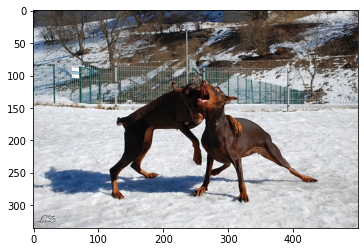

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog run in the snow .
bleu score:  0.488923022434901


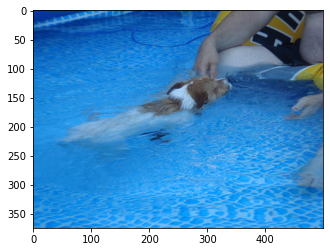

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A dog be jump into a pool .
bleu score:  4.91734272505357e-78


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


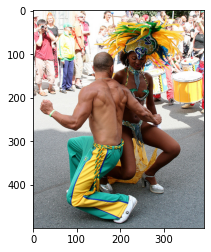

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a beach .
bleu score:  8.80154124704578e-155


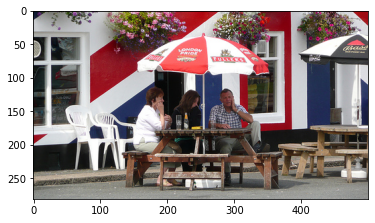

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a white shirt be ride a bicycle in front of a building .
bleu score:  0.2722589423069702


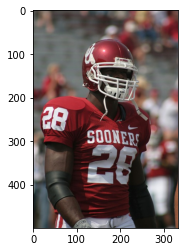

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red uniform be wear a white uniform .
bleu score:  4.887310777383362e-78


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("/content/drive/MyDrive/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score_greedy=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score_greedy)

  4%|▍         | 38/1000 [00:38<18:52,  1.18s/it]/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]


Bleu score on Greedy search
Score:  0.08973966561399764


## Beam Search Function

In [ ]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

## Predicting Captions on Test Set using Beam Search with k=3

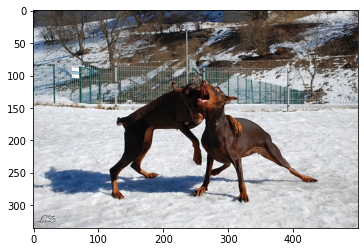

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog play in the snow .
bleu score:  1.0


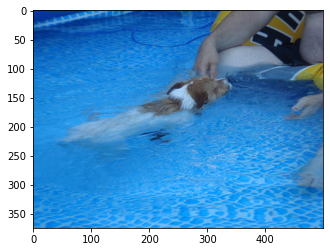

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A dog jump into a pool .
bleu score:  4.1131816762341247e-78


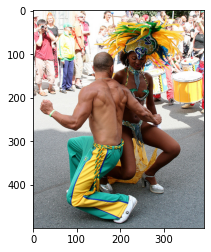

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a beach .
bleu score:  8.80154124704578e-155


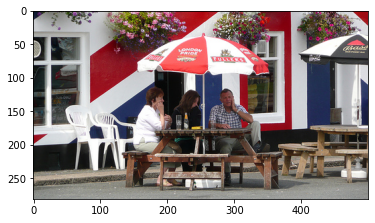

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a white shirt and white shirt be sit on a playground .
bleu score:  6.5900678916581e-155


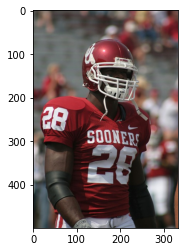

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red uniform .
bleu score:  1.0905741632475476e-154


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("/content/drive/MyDrive/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score_beam_3=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score_beam_3)

100%|██████████| 1000/1000 [1:07:46<00:00,  4.07s/it]


Bleu score on Beam search with k=3
Score:  0.10449167828533529


## Predicting Captions on Test Set using Beam Search with k=5

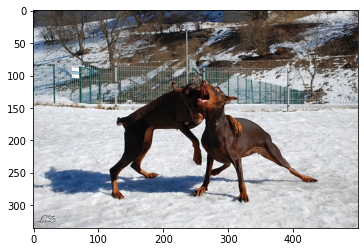

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog play in the snow .
bleu score:  1.0


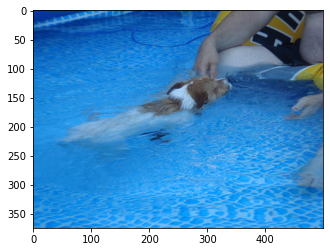

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A dog jump into a pool .
bleu score:  4.1131816762341247e-78


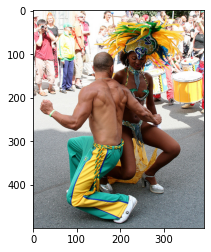

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a beach .
bleu score:  8.80154124704578e-155


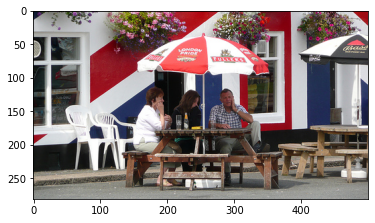

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a white shirt be sit on a playground .
bleu score:  6.585853050031193e-155


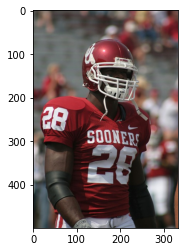

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red uniform .
bleu score:  1.0905741632475476e-154


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("/content/drive/MyDrive/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,5)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=5

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score_beam_5=tot_score/i
print()
print("Bleu score on Beam search with k=5")
print("Score: ",avg_score_beam_5)

100%|██████████| 1000/1000 [1:08:20<00:00,  4.10s/it]


Bleu score on Beam search with k=5
Score:  0.10449167828533529


##Prediction of Caption for a random image

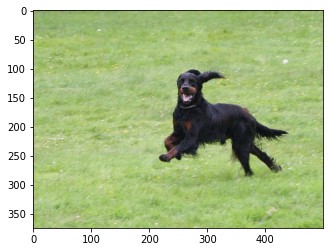

Predicted Caption from Greedy search : 
A black and white dog catch a Frisbee to catch a tennis ball .
Predicted Caption from Beam search with K=3 : 
A black and white dog catch a tennis ball to catch a tennis ball .
Predicted Caption from Beam search with K=5 : 
A black and white dog catch a tennis ball leap to catch a tennis ball .


In [ ]:
img=cv2.imread("/content/drive/MyDrive/232874193_c691df882d.jpg")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
photo=test_features[img_id]
plt.show()
candidate=greedy_search(photo)
print("Predicted Caption from Greedy search : ")
print(" ".join(candidate))
candidate=beam_search(photo,3)
print("Predicted Caption from Beam search with K=3 : ")
print(" ".join(candidate))
candidate=beam_search(photo,5)
print("Predicted Caption from Beam search with K=5 : ")
print(" ".join(candidate))